In [1]:
import argparse
import pandas as pd
import numpy as np
import math
import re
import os
import sys

from scipy import stats
from functools import reduce

from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

from sklearn.model_selection import StratifiedKFold
from sksurv.linear_model import CoxPHSurvivalAnalysis

import time
import copy

import multiprocessing
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
import pathlib
os.environ['PATH'] = os.environ['PATH'] + ';' + r"C:\ProgramData\Anaconda3\envs\OMSExpmt\Library\bin\graphviz"
# os.environ['PATH'] = os.environ['PATH'] + ';' + me_path + r'\Graphviz\bin'#r"C:\Program Files\Graphviz\bin"

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from datetime import datetime
import plotly.graph_objs as go
import plotly.io as pio
from graphviz import Digraph
from numpy import nan as NaN
import random
random.seed(10)
from sklearn.model_selection import train_test_split    
from sklearn.metrics import roc_auc_score
import pickle 

from joblib import Parallel, delayed
sys.path.append('../')
# import lib.constants as cnt
# import lib.craid_lib as crl
import lib.craid_ref as crr
import lib.argparse as argp
import lib.bootstrap as bst
import lib.boosting as boost
import lib.survival_scores as ssc
import lib.survival_criter as scrit
import lib.hierarch_clust as hclust
import lib.visualise as vis

import warnings
warnings.filterwarnings("ignore")

dir_env = './'
path_dir = "D:\\CRAID_TREE\\SurvivalTree\\tmp\\"
dataset_name = r'AGGREG_PRED_THREADS.csv'

In [2]:
import lib.constants_onk as onk
df, features, categ, sch_nan = onk.get_dataset(diag = {'C20', 'C50.4', 'C61'}, 
                                               invert_death = True,
                                               descript = False)

X = df.loc[:,set(df.columns) - {'cDeath'}]
y = df['cDeath']

DIAG {'C20': 0, 'C50.4': 1, 'C61': 2}
DS2 {'C16.8': 0, 'C44.3': 1, 'C78.0': 2, 'E11.9': 3, 'G93.4': 4, 'I25.1': 5, 'I25.2': 6, 'J12.9': 7, 'K25.0': 8, 'K56.6': 9, 'K62.5': 10, 'N02.0': 11, 'N10': 12, 'N30.2': 13, 'N40': 14, 'R31': 15, 'R33': 16, 'Z93.3': 17}
DS3 {'D63.8': 0, 'I26.9': 1, 'I50.1': 2, 'J90': 3, 'K56.4': 4, 'K61.3': 5, 'K62.5': 6, 'K65.0': 7, 'K92.2': 8, 'L98.6': 9, 'N11.9': 10, 'R31': 11, 'R33': 12}


In [7]:
dict(df.isna().sum())

{'index': 0,
 'ID_PAC': 0,
 'DIAG': 0,
 'DEATH': 0,
 'RELAPSE': 0,
 'DAYS': 0,
 'BEGIN_DATE': 0,
 'END_DATE': 0,
 'MARK': 0,
 'WEI': 1020,
 'HEI': 1020,
 'VID_HMP': 3280,
 'METOD_HMP': 3280,
 'SOD': 3247,
 'DS2': 3349,
 'DS3': 3355,
 'STAD': 6,
 'ONK_T': 39,
 'ONK_N': 553,
 'ONK_M': 11,
 'MTSTZ': 3130,
 'PROT': 3380,
 'W': 100,
 'AGE': 100,
 'PROFIL': 0,
 'SMO_NAM': 0,
 'SMO': 0,
 'ST_OKATO': 0,
 'CODE_MO': 0,
 'CODE_MD': 1604,
 'PRVS': 0,
 'PODR': 0,
 'NPR_MO': 62,
 'BINS1': 0,
 'BINS1_1': 0,
 'BINS1_2': 0,
 'BINS1_3': 0,
 'BINS1_4': 0,
 'BINS1_5': 0,
 'BINS1_6': 0,
 'BINS2': 0,
 'BINS2_1': 0,
 'BINS2_2': 0,
 'BINS2_3': 0,
 'BINS2_4': 0,
 'BINS2_5': 0,
 'BINS2_6': 0,
 'BINS2_7': 0,
 'BINS2_8': 0,
 'BINS3': 0,
 'BINS3_1': 0,
 'BINS3_2': 0,
 'BINS3_3': 0,
 'BINS4': 0,
 'BINS5': 0,
 'BINS6': 0,
 'NUM1': 0,
 'NUM1_1': 0,
 'NUM1_2': 0,
 'NUM1_3': 0,
 'NUM1_4': 0,
 'NUM1_5': 0,
 'NUM1_6': 0,
 'NUM2': 0,
 'NUM2_1': 0,
 'NUM2_2': 0,
 'NUM2_3': 0,
 'NUM2_4': 0,
 'NUM2_5': 0,
 'NUM2_6': 0,
 'NU

In [3]:
BCR_param_grid = {
    "name":["bootstrap"], 
    "size_sample" : [int(X_tv.shape[0]*0.7)], 
    "n_estimators" : [10, 30], 
    "depth" : [15, 20],
    "tolerance" : [False],
    "features" : [features], 
    "categ" : [categ],
    "sum":["COST"],
    "days":["dDeath"],
    "cens":["cDeath"],
    "criterion":[scrit.tarone_ware],
    "n_jobs":[10],
    "min_samples_leaf":[1,5,10],
    "bonf":[True],
    "thres_cont_bin_max":[100],
    "signif":[1.1],
    "max_features":[0.2],
    "verbose":[0]
}
BCR_res_grid = ssc.grid_search(bst.BootstrapCRAID, BCR_param_grid, X, y, features, ['conc','ibs'])

FULL_TIME: 51.692732671 seconds
****** End fit. ******
FULL_TIME: 47.021367956999995 seconds
****** End fit. ******
METRIC: 0.7593 -> +1 model METRIC: 0.8162
FULL_TIME: 53.27724266999999 seconds
****** End fit. ******
METRIC: 0.8162 -> +1 model METRIC: 0.8519
FULL_TIME: 49.700039644000015 seconds
****** End fit. ******
METRIC: 0.8519 -> +1 model METRIC: 0.8745
FULL_TIME: 48.173881559999984 seconds
****** End fit. ******
METRIC: 0.8745 -> +1 model METRIC: 0.8916
FULL_TIME: 46.152401450999946 seconds
****** End fit. ******
METRIC: 0.8916 -> +1 model METRIC: 0.898
FULL_TIME: 52.234319998000046 seconds
****** End fit. ******
METRIC: 0.898 -> +1 model METRIC: 0.9014
FULL_TIME: 44.53196562699998 seconds
****** End fit. ******
METRIC: 0.9014 -> +1 model METRIC: 0.9037
FULL_TIME: 49.87074485300002 seconds
****** End fit. ******
METRIC: 0.9037 -> +1 model METRIC: 0.9082
FULL_TIME: 46.95353331199999 seconds
****** End fit. ******
METRIC: 0.9082 -> +1 model METRIC: 0.9095
fitted: 10 models.
FULL_

METRIC: 0.9224 -> +1 model METRIC: 0.9266
FULL_TIME: 50.53860748700026 seconds
****** End fit. ******
METRIC: 0.9266 -> +1 model METRIC: 0.9275
FULL_TIME: 52.044876562000354 seconds
****** End fit. ******
METRIC: 0.9275 -> +1 model METRIC: 0.9289
FULL_TIME: 51.99275593099992 seconds
****** End fit. ******
METRIC: 0.9289 -> +1 model METRIC: 0.9304
FULL_TIME: 52.09592491799958 seconds
****** End fit. ******
METRIC: 0.9304 -> +1 model METRIC: 0.9322
FULL_TIME: 49.472282022999934 seconds
****** End fit. ******
METRIC: 0.9322 -> +1 model METRIC: 0.932
fitted: 19 models.
FULL_TIME: 62.7191655280003 seconds
****** End fit. ******
FULL_TIME: 55.64123911800016 seconds
****** End fit. ******
METRIC: 0.7506 -> +1 model METRIC: 0.8205
FULL_TIME: 48.48372400500011 seconds
****** End fit. ******
METRIC: 0.8205 -> +1 model METRIC: 0.8487
FULL_TIME: 54.60949511400031 seconds
****** End fit. ******
METRIC: 0.8487 -> +1 model METRIC: 0.8654
FULL_TIME: 48.277985800999886 seconds
****** End fit. ******
ME

FULL_TIME: 46.545562884999526 seconds
****** End fit. ******
METRIC: 0.9358 -> +1 model METRIC: 0.9347
fitted: 18 models.
{'bonf': True, 'categ': ['DIAG', 'DS2', 'DS3'], 'cens': 'cDeath', 'criterion': <function tarone_ware at 0x0000024F7F8DBC18>, 'days': 'dDeath', 'depth': 15, 'features': ['WEI', 'HEI', 'W', 'AGE', 'STAD', 'ONK_T', 'ONK_N', 'ONK_M', 'MTSTZ', 'INDEX_MASS', 'PRED_SUM', 'PRED_DAYS', 'PRED_MEAN_SUM_ELEMS', 'PRED_MEAN_DAYS_ELEMS', 'PRED_MEAN_SUM_THREADS', 'PRED_MEAN_DAYS_THREADS', 'DELTA_PRED', 'DELTA_POST', 'PRED_THREADS', 'DIAG', 'BINS1', 'BINS2', 'BINS3', 'BINS1_1', 'BINS1_2', 'BINS1_3', 'BINS1_4', 'BINS1_5', 'BINS1_6', 'BINS2_1', 'BINS2_2', 'BINS2_3', 'BINS2_4', 'BINS2_5', 'BINS2_6', 'BINS2_7', 'BINS2_8', 'BINS3_1', 'BINS3_2', 'BINS3_3', 'BINS4', 'BINS5', 'BINS6', 'NUM1', 'NUM2', 'NUM3', 'NUM1_1', 'NUM1_2', 'NUM1_3', 'NUM1_4', 'NUM1_5', 'NUM1_6', 'NUM2_1', 'NUM2_2', 'NUM2_3', 'NUM2_4', 'NUM2_5', 'NUM2_6', 'NUM2_7', 'NUM2_8', 'NUM3_1', 'NUM3_2', 'NUM3_3', 'NUM4', 'NUM5',

FULL_TIME: 27.65098174799641 seconds
****** End fit. ******
FULL_TIME: 30.945704099998693 seconds
****** End fit. ******
METRIC: 0.7058 -> +1 model METRIC: 0.7731
FULL_TIME: 27.70053506399563 seconds
****** End fit. ******
METRIC: 0.7731 -> +1 model METRIC: 0.8145
FULL_TIME: 26.861196783000196 seconds
****** End fit. ******
METRIC: 0.8145 -> +1 model METRIC: 0.8246
FULL_TIME: 23.655669717998535 seconds
****** End fit. ******
METRIC: 0.8246 -> +1 model METRIC: 0.8429
FULL_TIME: 26.589436902999296 seconds
****** End fit. ******
METRIC: 0.8429 -> +1 model METRIC: 0.849
FULL_TIME: 25.900602257999708 seconds
****** End fit. ******
METRIC: 0.849 -> +1 model METRIC: 0.8521
FULL_TIME: 29.014899690002494 seconds
****** End fit. ******
METRIC: 0.8521 -> +1 model METRIC: 0.8528
FULL_TIME: 27.174678329996823 seconds
****** End fit. ******
METRIC: 0.8528 -> +1 model METRIC: 0.8542
FULL_TIME: 26.692295764005394 seconds
****** End fit. ******
METRIC: 0.8542 -> +1 model METRIC: 0.8525
fitted: 9 models

FULL_TIME: 22.26836507600092 seconds
****** End fit. ******
FULL_TIME: 19.86556389999896 seconds
****** End fit. ******
METRIC: 0.7028 -> +1 model METRIC: 0.7499
FULL_TIME: 18.8174734399945 seconds
****** End fit. ******
METRIC: 0.7499 -> +1 model METRIC: 0.7881
FULL_TIME: 18.117727830998774 seconds
****** End fit. ******
METRIC: 0.7881 -> +1 model METRIC: 0.7947
FULL_TIME: 17.696493677001854 seconds
****** End fit. ******
METRIC: 0.7947 -> +1 model METRIC: 0.8068
FULL_TIME: 17.140515246996074 seconds
****** End fit. ******
METRIC: 0.8068 -> +1 model METRIC: 0.8091
FULL_TIME: 21.34851405399968 seconds
****** End fit. ******
METRIC: 0.8091 -> +1 model METRIC: 0.8114
FULL_TIME: 17.905433588995948 seconds
****** End fit. ******
METRIC: 0.8114 -> +1 model METRIC: 0.8106
fitted: 7 models.
FULL_TIME: 18.033003524004016 seconds
****** End fit. ******
FULL_TIME: 19.515505069000938 seconds
****** End fit. ******
METRIC: 0.7176 -> +1 model METRIC: 0.744
FULL_TIME: 18.572787635996065 seconds
****

METRIC: 0.7837 -> +1 model METRIC: 0.7865
FULL_TIME: 21.952839917998062 seconds
****** End fit. ******
METRIC: 0.7865 -> +1 model METRIC: 0.7896
FULL_TIME: 20.811917995997646 seconds
****** End fit. ******
METRIC: 0.7896 -> +1 model METRIC: 0.7924
FULL_TIME: 22.265092178000486 seconds
****** End fit. ******
METRIC: 0.7924 -> +1 model METRIC: 0.7948
FULL_TIME: 19.87273970199749 seconds
****** End fit. ******
METRIC: 0.7948 -> +1 model METRIC: 0.7951
FULL_TIME: 20.14118767400214 seconds
****** End fit. ******
METRIC: 0.7951 -> +1 model METRIC: 0.7961
FULL_TIME: 20.945443224001792 seconds
****** End fit. ******
METRIC: 0.7961 -> +1 model METRIC: 0.7945
fitted: 15 models.
FULL_TIME: 19.1917864460047 seconds
****** End fit. ******
FULL_TIME: 20.58198510699731 seconds
****** End fit. ******
METRIC: 0.75 -> +1 model METRIC: 0.7717
FULL_TIME: 21.82400022300135 seconds
****** End fit. ******
METRIC: 0.7717 -> +1 model METRIC: 0.7921
FULL_TIME: 19.404719958001806 seconds
****** End fit. ******
M

METRIC: 0.9152 -> +1 model METRIC: 0.9248
FULL_TIME: 64.97673423000379 seconds
****** End fit. ******
METRIC: 0.9248 -> +1 model METRIC: 0.9311
FULL_TIME: 64.57246385599865 seconds
****** End fit. ******
METRIC: 0.9311 -> +1 model METRIC: 0.9319
FULL_TIME: 62.388367162995564 seconds
****** End fit. ******
METRIC: 0.9319 -> +1 model METRIC: 0.9329
fitted: 10 models.
FULL_TIME: 63.2699088790032 seconds
****** End fit. ******
FULL_TIME: 62.798655731996405 seconds
****** End fit. ******
METRIC: 0.7463 -> +1 model METRIC: 0.8233
FULL_TIME: 63.970148446001986 seconds
****** End fit. ******
METRIC: 0.8233 -> +1 model METRIC: 0.8673
FULL_TIME: 63.76572339999984 seconds
****** End fit. ******
METRIC: 0.8673 -> +1 model METRIC: 0.8846
FULL_TIME: 60.14885646000039 seconds
****** End fit. ******
METRIC: 0.8846 -> +1 model METRIC: 0.8912
FULL_TIME: 61.3243890990052 seconds
****** End fit. ******
METRIC: 0.8912 -> +1 model METRIC: 0.9072
FULL_TIME: 62.84319876199879 seconds
****** End fit. ******
ME

METRIC: 0.9037 -> +1 model METRIC: 0.9152
FULL_TIME: 66.80943699000636 seconds
****** End fit. ******
METRIC: 0.9152 -> +1 model METRIC: 0.9248
FULL_TIME: 64.89721232999727 seconds
****** End fit. ******
METRIC: 0.9248 -> +1 model METRIC: 0.9311
FULL_TIME: 64.66261146299803 seconds
****** End fit. ******
METRIC: 0.9311 -> +1 model METRIC: 0.9319
FULL_TIME: 62.74025407899899 seconds
****** End fit. ******
METRIC: 0.9319 -> +1 model METRIC: 0.9329
FULL_TIME: 64.40565764900384 seconds
****** End fit. ******
METRIC: 0.9329 -> +1 model METRIC: 0.9337
FULL_TIME: 63.74682669599861 seconds
****** End fit. ******
METRIC: 0.9337 -> +1 model METRIC: 0.9357
FULL_TIME: 66.24222235399793 seconds
****** End fit. ******
METRIC: 0.9357 -> +1 model METRIC: 0.9382
FULL_TIME: 63.31795057599811 seconds
****** End fit. ******
METRIC: 0.9382 -> +1 model METRIC: 0.9403
FULL_TIME: 64.70912349999708 seconds
****** End fit. ******
METRIC: 0.9403 -> +1 model METRIC: 0.9409
FULL_TIME: 58.74321587699524 seconds
***

METRIC: 0.7907 -> +1 model METRIC: 0.8089
FULL_TIME: 23.599619851986063 seconds
****** End fit. ******
METRIC: 0.8089 -> +1 model METRIC: 0.819
FULL_TIME: 26.018941563990666 seconds
****** End fit. ******
METRIC: 0.819 -> +1 model METRIC: 0.8257
FULL_TIME: 29.36508822700125 seconds
****** End fit. ******
METRIC: 0.8257 -> +1 model METRIC: 0.8302
FULL_TIME: 28.519794167004875 seconds
****** End fit. ******
METRIC: 0.8302 -> +1 model METRIC: 0.8347
FULL_TIME: 27.414554748000228 seconds
****** End fit. ******
METRIC: 0.8347 -> +1 model METRIC: 0.8323
fitted: 8 models.
FULL_TIME: 27.874554620997515 seconds
****** End fit. ******
FULL_TIME: 29.023221884999657 seconds
****** End fit. ******
METRIC: 0.7806 -> +1 model METRIC: 0.8078
FULL_TIME: 28.583606928004883 seconds
****** End fit. ******
METRIC: 0.8078 -> +1 model METRIC: 0.8192
FULL_TIME: 26.408075751998695 seconds
****** End fit. ******
METRIC: 0.8192 -> +1 model METRIC: 0.8236
FULL_TIME: 27.869553110998822 seconds
****** End fit. ****

METRIC: 0.8544 -> +1 model METRIC: 0.8566
FULL_TIME: 34.033531615001266 seconds
****** End fit. ******
METRIC: 0.8566 -> +1 model METRIC: 0.8581
FULL_TIME: 31.687403481992078 seconds
****** End fit. ******
METRIC: 0.8581 -> +1 model METRIC: 0.8611
FULL_TIME: 32.78329524300352 seconds
****** End fit. ******
METRIC: 0.8611 -> +1 model METRIC: 0.8632
FULL_TIME: 30.551056890006294 seconds
****** End fit. ******
METRIC: 0.8632 -> +1 model METRIC: 0.8633
FULL_TIME: 29.452091667000786 seconds
****** End fit. ******
METRIC: 0.8633 -> +1 model METRIC: 0.8643
FULL_TIME: 31.975239677005447 seconds
****** End fit. ******
METRIC: 0.8643 -> +1 model METRIC: 0.8655
FULL_TIME: 28.87548646100913 seconds
****** End fit. ******
METRIC: 0.8655 -> +1 model METRIC: 0.8661
FULL_TIME: 33.3775259279937 seconds
****** End fit. ******
METRIC: 0.8661 -> +1 model METRIC: 0.8688
FULL_TIME: 28.14799776300788 seconds
****** End fit. ******
METRIC: 0.8688 -> +1 model METRIC: 0.8694
FULL_TIME: 29.631522819996462 second

FULL_TIME: 19.542408476991113 seconds
****** End fit. ******
METRIC: 0.7781 -> +1 model METRIC: 0.7796
FULL_TIME: 18.931407108000712 seconds
****** End fit. ******
METRIC: 0.7796 -> +1 model METRIC: 0.7837
FULL_TIME: 19.446982881010626 seconds
****** End fit. ******
METRIC: 0.7837 -> +1 model METRIC: 0.7865
fitted: 10 models.
FULL_TIME: 19.16369519699947 seconds
****** End fit. ******
FULL_TIME: 20.8169531510066 seconds
****** End fit. ******
METRIC: 0.75 -> +1 model METRIC: 0.7717
FULL_TIME: 21.772599316987908 seconds
****** End fit. ******
METRIC: 0.7717 -> +1 model METRIC: 0.7921
FULL_TIME: 19.502485637989594 seconds
****** End fit. ******
METRIC: 0.7921 -> +1 model METRIC: 0.8001
FULL_TIME: 18.41237167600775 seconds
****** End fit. ******
METRIC: 0.8001 -> +1 model METRIC: 0.8133
FULL_TIME: 19.93798947799951 seconds
****** End fit. ******
METRIC: 0.8133 -> +1 model METRIC: 0.8184
FULL_TIME: 20.902391333002015 seconds
****** End fit. ******
METRIC: 0.8184 -> +1 model METRIC: 0.8214


FULL_TIME: 23.4631313639984 seconds
****** End fit. ******
METRIC: 0.8229 -> +1 model METRIC: 0.8218
fitted: 8 models.
FULL_TIME: 21.52526232699165 seconds
****** End fit. ******
FULL_TIME: 19.290162138000596 seconds
****** End fit. ******
METRIC: 0.7332 -> +1 model METRIC: 0.7552
FULL_TIME: 21.611914192995755 seconds
****** End fit. ******
METRIC: 0.7552 -> +1 model METRIC: 0.7672
FULL_TIME: 20.15939390900894 seconds
****** End fit. ******
METRIC: 0.7672 -> +1 model METRIC: 0.7832
FULL_TIME: 21.375903619991732 seconds
****** End fit. ******
METRIC: 0.7832 -> +1 model METRIC: 0.7907
FULL_TIME: 23.316944129997864 seconds
****** End fit. ******
METRIC: 0.7907 -> +1 model METRIC: 0.7959
FULL_TIME: 23.241780083000776 seconds
****** End fit. ******
METRIC: 0.7959 -> +1 model METRIC: 0.7964
FULL_TIME: 23.957270425002207 seconds
****** End fit. ******
METRIC: 0.7964 -> +1 model METRIC: 0.8009
FULL_TIME: 21.339275623002322 seconds
****** End fit. ******
METRIC: 0.8009 -> +1 model METRIC: 0.806

### Эксперименты PBC

In [2]:
import lib.constants_other as other
df, features, categ, sch_nan = other.get_dataset_pbc()
X = df.loc[:,set(df.columns) - {'cDeath'}]
y = df['cDeath']

X_tv, X_tst, y_tv, y_tst = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)
X_t, X_v, y_t, y_v = train_test_split(X_tv, y_tv, test_size=0.2, stratify = y_tv, random_state=42)
X_t['cDeath'] = y_t
X_v['cDeath'] = y_v
X_tv['cDeath'] = y_tv
X_tst['cDeath'] = y_tst

bins = ssc.get_bins(X_tv[X_tv['cDeath'] == True]['dDeath'], 100, 'a')

In [3]:
cox_param_grid = {'alpha':[0.1, 0.01, 0.001], 
                  'ties':["breslow", "efron"]}
cox_res_grid = ssc.grid_search(CoxPHSurvivalAnalysis, cox_param_grid, X, y, features, ['conc','ibs'])

{'alpha': 0.1, 'ties': 'breslow'} [0.63976408 0.23079878]
{'alpha': 0.1, 'ties': 'efron'} [0.63976662 0.23055209]
{'alpha': 0.01, 'ties': 'breslow'} [0.63976551 0.2307541 ]
{'alpha': 0.01, 'ties': 'efron'} [0.63965186 0.23050654]
{'alpha': 0.001, 'ties': 'breslow'} [0.63976551 0.23074961]
{'alpha': 0.001, 'ties': 'efron'} [0.63965186 0.23050196]


In [4]:
from sksurv.ensemble import RandomSurvivalForest
RSF_param_grid = {'n_estimators':[30, 50, 100], 
                  'max_depth':[None, 20, 30], 
                  'min_samples_leaf':[1, 10, 20], 
                  'max_features':["sqrt"]
                 }
RSF_res_grid = ssc.grid_search(RandomSurvivalForest, RSF_param_grid, X, y, features, ['conc','ibs'])

{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 30} [0.65349901 0.21485278]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 50} [0.64683482 0.21367325]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100} [0.64742955 0.21151532]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 30} [0.65832372 0.20596092]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 50} [0.65837495 0.21486816]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 100} [0.66048662 0.20735949]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'n_estimators': 30} [0.66667126 0.21882721]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'n_estimators': 50} [0.65287729 0.22556728]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'n_estimators': 100} [0.66185232 0.22

In [5]:
from sksurv.tree import SurvivalTree
SurvTree_param_grid = {'splitter':["best", "random"], 
                       'max_depth':[None, 20, 30], 
                       'min_samples_leaf':[1, 10, 20], 
                       'max_features':["sqrt"]
                      }
SurvTree_res_grid = ssc.grid_search(SurvivalTree, SurvTree_param_grid, X, y, features, ['conc','ibs'])

{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'splitter': 'best'} [0.62092397 0.31646582]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'splitter': 'random'} [0.62121248 0.37892772]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'splitter': 'best'} [0.63033997 0.28362731]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'splitter': 'random'} [0.58473636 0.33192855]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'splitter': 'best'} [0.62017132 0.29011685]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'splitter': 'random'} [0.57641689 0.27924902]
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'splitter': 'best'} [0.61842588 0.31048185]
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'splitter': 'random'} [0.57385202 0.40771419]
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'splitter': 'best'} [0.61819975 0.3126

In [12]:
CRAID_param_grid_lr = {
    "name":["tree"],
    "depth":[10, 15],
    "features":[features],
    "categ":[categ],
    "sum":["COST"],
    "days":["dDeath"],
    "cens":["cDeath"],
    "criterion":[scrit.logrank],
    "min_samples_leaf":[1, 2, 5],
    "n_jobs":[16],
    "bonf":[True],
    "thres_cont_bin_max":[100],
    "signif":[0.05, 0.1, 0.15],
    "max_features":[1.0],
    "verbose":[0]
}
CRAID_res_grid_lr = ssc.grid_search(crr.CRAID, CRAID_param_grid_lr, X, y, features, ['conc','ibs'])

FULL_TIME: 23.704561335005565 seconds
****** End fit. ******
FULL_TIME: 16.54938289400161 seconds
****** End fit. ******
FULL_TIME: 16.532199196000875 seconds
****** End fit. ******
FULL_TIME: 17.163812226004666 seconds
****** End fit. ******
FULL_TIME: 17.670263669999258 seconds
****** End fit. ******
{'bonf': True, 'categ': ['trt', 'sex', 'ascites', 'hepato', 'spiders'], 'cens': 'cDeath', 'criterion': <function logrank at 0x000002D57ACEAB88>, 'days': 'dDeath', 'depth': 10, 'features': ['trt', 'age', 'sex', 'ascites', 'hepato', 'spiders', 'edema', 'bili', 'chol', 'albumin', 'copper', 'alk', 'ast', 'trig', 'platelet', 'protime', 'stage'], 'max_features': 1.0, 'min_samples_leaf': 1, 'n_jobs': 16, 'name': 'tree', 'signif': 0.05, 'sum': 'COST', 'thres_cont_bin_max': 100, 'verbose': 0} [0.60741614 0.30284997]
FULL_TIME: 17.086876658999245 seconds
****** End fit. ******
FULL_TIME: 17.51946697400126 seconds
****** End fit. ******
FULL_TIME: 16.927291602005425 seconds
****** End fit. ******
F

FULL_TIME: 21.285190374001104 seconds
****** End fit. ******
FULL_TIME: 20.08472479500051 seconds
****** End fit. ******
FULL_TIME: 22.30164605500613 seconds
****** End fit. ******
FULL_TIME: 22.37832464800158 seconds
****** End fit. ******
{'bonf': True, 'categ': ['trt', 'sex', 'ascites', 'hepato', 'spiders'], 'cens': 'cDeath', 'criterion': <function logrank at 0x000002D57ACEAB88>, 'days': 'dDeath', 'depth': 15, 'features': ['trt', 'age', 'sex', 'ascites', 'hepato', 'spiders', 'edema', 'bili', 'chol', 'albumin', 'copper', 'alk', 'ast', 'trig', 'platelet', 'protime', 'stage'], 'max_features': 1.0, 'min_samples_leaf': 1, 'n_jobs': 16, 'name': 'tree', 'signif': 0.1, 'sum': 'COST', 'thres_cont_bin_max': 100, 'verbose': 0} [0.61085601 0.3330535 ]
FULL_TIME: 22.76527040200017 seconds
****** End fit. ******
FULL_TIME: 20.644893822995073 seconds
****** End fit. ******
FULL_TIME: 20.992366809994564 seconds
****** End fit. ******
FULL_TIME: 21.65801906699926 seconds
****** End fit. ******
FULL_

In [13]:
CRAID_param_grid_lr = {
    "name":["tree"],
    "depth":[10, 15],
    "features":[features],
    "categ":[categ],
    "sum":["COST"],
    "days":["dDeath"],
    "cens":["cDeath"],
    "criterion":[scrit.wilcoxon],
    "min_samples_leaf":[1, 2, 5],
    "n_jobs":[16],
    "bonf":[True],
    "thres_cont_bin_max":[100],
    "signif":[0.05, 0.1, 0.15],
    "max_features":[1.0],
    "verbose":[0]
}
CRAID_res_grid_lr = ssc.grid_search(crr.CRAID, CRAID_param_grid_lr, X, y, features, ['conc','ibs'])

FULL_TIME: 16.40153629300039 seconds
****** End fit. ******
FULL_TIME: 16.01375232200371 seconds
****** End fit. ******
FULL_TIME: 16.20251162799832 seconds
****** End fit. ******
FULL_TIME: 16.638921465004387 seconds
****** End fit. ******
FULL_TIME: 17.22566183299932 seconds
****** End fit. ******
{'bonf': True, 'categ': ['trt', 'sex', 'ascites', 'hepato', 'spiders'], 'cens': 'cDeath', 'criterion': <function wilcoxon at 0x000002D57ACEAC18>, 'days': 'dDeath', 'depth': 10, 'features': ['trt', 'age', 'sex', 'ascites', 'hepato', 'spiders', 'edema', 'bili', 'chol', 'albumin', 'copper', 'alk', 'ast', 'trig', 'platelet', 'protime', 'stage'], 'max_features': 1.0, 'min_samples_leaf': 1, 'n_jobs': 16, 'name': 'tree', 'signif': 0.05, 'sum': 'COST', 'thres_cont_bin_max': 100, 'verbose': 0} [0.60293734 0.27927442]
FULL_TIME: 16.785798678996798 seconds
****** End fit. ******
FULL_TIME: 16.971937520997017 seconds
****** End fit. ******
FULL_TIME: 16.55573413199454 seconds
****** End fit. ******
FUL

FULL_TIME: 21.063510437998048 seconds
****** End fit. ******
FULL_TIME: 21.049308044006466 seconds
****** End fit. ******
FULL_TIME: 22.54346856099437 seconds
****** End fit. ******
FULL_TIME: 21.857302657001128 seconds
****** End fit. ******
{'bonf': True, 'categ': ['trt', 'sex', 'ascites', 'hepato', 'spiders'], 'cens': 'cDeath', 'criterion': <function wilcoxon at 0x000002D57ACEAC18>, 'days': 'dDeath', 'depth': 15, 'features': ['trt', 'age', 'sex', 'ascites', 'hepato', 'spiders', 'edema', 'bili', 'chol', 'albumin', 'copper', 'alk', 'ast', 'trig', 'platelet', 'protime', 'stage'], 'max_features': 1.0, 'min_samples_leaf': 1, 'n_jobs': 16, 'name': 'tree', 'signif': 0.1, 'sum': 'COST', 'thres_cont_bin_max': 100, 'verbose': 0} [0.59547969 0.42029661]
FULL_TIME: 22.016258683004708 seconds
****** End fit. ******
FULL_TIME: 22.993363991998194 seconds
****** End fit. ******
FULL_TIME: 22.416298472999188 seconds
****** End fit. ******
FULL_TIME: 23.04569429899857 seconds
****** End fit. ******
F

In [14]:
CRAID_param_grid_lr = {
    "name":["tree"],
    "depth":[10, 15],
    "features":[features],
    "categ":[categ],
    "sum":["COST"],
    "days":["dDeath"],
    "cens":["cDeath"],
    "criterion":[scrit.peto],
    "min_samples_leaf":[1, 2, 5],
    "n_jobs":[16],
    "bonf":[True],
    "thres_cont_bin_max":[100],
    "signif":[0.05, 0.1, 0.15],
    "max_features":[1.0],
    "verbose":[0]
}
CRAID_res_grid_lr = ssc.grid_search(crr.CRAID, CRAID_param_grid_lr, X, y, features, ['conc','ibs'])

FULL_TIME: 17.345295279999846 seconds
****** End fit. ******
FULL_TIME: 16.89922034600022 seconds
****** End fit. ******
FULL_TIME: 16.484520286998304 seconds
****** End fit. ******
FULL_TIME: 17.299353758004145 seconds
****** End fit. ******
FULL_TIME: 17.857240728997567 seconds
****** End fit. ******
{'bonf': True, 'categ': ['trt', 'sex', 'ascites', 'hepato', 'spiders'], 'cens': 'cDeath', 'criterion': <function peto at 0x000002D57ACEACA8>, 'days': 'dDeath', 'depth': 10, 'features': ['trt', 'age', 'sex', 'ascites', 'hepato', 'spiders', 'edema', 'bili', 'chol', 'albumin', 'copper', 'alk', 'ast', 'trig', 'platelet', 'protime', 'stage'], 'max_features': 1.0, 'min_samples_leaf': 1, 'n_jobs': 16, 'name': 'tree', 'signif': 0.05, 'sum': 'COST', 'thres_cont_bin_max': 100, 'verbose': 0} [0.61727148 0.28267677]
FULL_TIME: 18.169448615000874 seconds
****** End fit. ******
FULL_TIME: 17.65711258299416 seconds
****** End fit. ******
FULL_TIME: 16.583364094003628 seconds
****** End fit. ******
FULL

FULL_TIME: 19.79875520600035 seconds
****** End fit. ******
FULL_TIME: 20.793713711995224 seconds
****** End fit. ******
FULL_TIME: 21.502236953005195 seconds
****** End fit. ******
FULL_TIME: 21.67105215000629 seconds
****** End fit. ******
{'bonf': True, 'categ': ['trt', 'sex', 'ascites', 'hepato', 'spiders'], 'cens': 'cDeath', 'criterion': <function peto at 0x000002D57ACEACA8>, 'days': 'dDeath', 'depth': 15, 'features': ['trt', 'age', 'sex', 'ascites', 'hepato', 'spiders', 'edema', 'bili', 'chol', 'albumin', 'copper', 'alk', 'ast', 'trig', 'platelet', 'protime', 'stage'], 'max_features': 1.0, 'min_samples_leaf': 1, 'n_jobs': 16, 'name': 'tree', 'signif': 0.1, 'sum': 'COST', 'thres_cont_bin_max': 100, 'verbose': 0} [0.61466331 0.31536557]
FULL_TIME: 23.7286721499986 seconds
****** End fit. ******
FULL_TIME: 21.72798460699414 seconds
****** End fit. ******
FULL_TIME: 21.853654778999044 seconds
****** End fit. ******
FULL_TIME: 23.425379892003548 seconds
****** End fit. ******
FULL_TIM

In [15]:
CRAID_param_grid_lr = {
    "name":["tree"],
    "depth":[10, 15],
    "features":[features],
    "categ":[categ],
    "sum":["COST"],
    "days":["dDeath"],
    "cens":["cDeath"],
    "criterion":[scrit.tarone_ware],
    "min_samples_leaf":[1, 2, 5],
    "n_jobs":[16],
    "bonf":[True],
    "thres_cont_bin_max":[100],
    "signif":[0.05, 0.1, 0.15],
    "max_features":[1.0],
    "verbose":[0]
}
CRAID_res_grid_lr = ssc.grid_search(crr.CRAID, CRAID_param_grid_lr, X, y, features, ['conc','ibs'])

FULL_TIME: 20.609799388999818 seconds
****** End fit. ******
FULL_TIME: 19.179472112999065 seconds
****** End fit. ******
FULL_TIME: 18.871169081001426 seconds
****** End fit. ******
FULL_TIME: 19.460110075000557 seconds
****** End fit. ******
FULL_TIME: 20.004014081001515 seconds
****** End fit. ******
{'bonf': True, 'categ': ['trt', 'sex', 'ascites', 'hepato', 'spiders'], 'cens': 'cDeath', 'criterion': <function tarone_ware at 0x000002D57ACEAD38>, 'days': 'dDeath', 'depth': 10, 'features': ['trt', 'age', 'sex', 'ascites', 'hepato', 'spiders', 'edema', 'bili', 'chol', 'albumin', 'copper', 'alk', 'ast', 'trig', 'platelet', 'protime', 'stage'], 'max_features': 1.0, 'min_samples_leaf': 1, 'n_jobs': 16, 'name': 'tree', 'signif': 0.05, 'sum': 'COST', 'thres_cont_bin_max': 100, 'verbose': 0} [0.61004949 0.27034688]
FULL_TIME: 20.747466453001834 seconds
****** End fit. ******
FULL_TIME: 21.15347274999658 seconds
****** End fit. ******
FULL_TIME: 19.771731843000452 seconds
****** End fit. ***

FULL_TIME: 27.369142780000402 seconds
****** End fit. ******
FULL_TIME: 26.5879730700035 seconds
****** End fit. ******
FULL_TIME: 24.82475603200146 seconds
****** End fit. ******
FULL_TIME: 26.57291978000285 seconds
****** End fit. ******
FULL_TIME: 25.078001989997574 seconds
****** End fit. ******
{'bonf': True, 'categ': ['trt', 'sex', 'ascites', 'hepato', 'spiders'], 'cens': 'cDeath', 'criterion': <function tarone_ware at 0x000002D57ACEAD38>, 'days': 'dDeath', 'depth': 15, 'features': ['trt', 'age', 'sex', 'ascites', 'hepato', 'spiders', 'edema', 'bili', 'chol', 'albumin', 'copper', 'alk', 'ast', 'trig', 'platelet', 'protime', 'stage'], 'max_features': 1.0, 'min_samples_leaf': 1, 'n_jobs': 16, 'name': 'tree', 'signif': 0.1, 'sum': 'COST', 'thres_cont_bin_max': 100, 'verbose': 0} [0.59704449 0.31629761]
FULL_TIME: 27.53350065199629 seconds
****** End fit. ******
FULL_TIME: 25.841268278003554 seconds
****** End fit. ******
FULL_TIME: 25.282454343003337 seconds
****** End fit. ******
F

In [6]:
BCR_param_grid_tw = {
    "size_sample" : [0.7], 
    "n_estimators" : [10, 30], 
    "depth" : [15],
    "tolerance" : [True],
    "features" : [features], 
    "categ" : [categ],
    "sum":["COST"],
    "days":["dDeath"],
    "cens":["cDeath"],
    "criterion":[scrit.tarone_ware],#logrank_test,
    "n_jobs":[16],
    "min_samples_leaf":[1,5,10],
    "bonf":[True],
    "thres_cont_bin_max":[100],
    "signif":[1.1],
    "max_features":[0.3],
    "verbose":[0]
}
BCR_res_grid_tw = ssc.grid_search(bst.BootstrapCRAID, BCR_param_grid_tw, X, y, features, ['conc','ibs'])

FULL_TIME: 15.134726233998663 seconds
****** End fit. ******
FULL_TIME: 6.566336435000267 seconds
****** End fit. ******
FULL_TIME: 6.867445134001173 seconds
****** End fit. ******
FULL_TIME: 7.526446266001585 seconds
****** End fit. ******
FULL_TIME: 6.2580455930001335 seconds
****** End fit. ******
FULL_TIME: 6.888364480997552 seconds
****** End fit. ******
FULL_TIME: 7.438102849999268 seconds
****** End fit. ******
FULL_TIME: 7.8264475830001174 seconds
****** End fit. ******
FULL_TIME: 6.39778991500134 seconds
****** End fit. ******
FULL_TIME: 6.450617593000061 seconds
****** End fit. ******
{0: 0.7278, 1: 0.7009, 2: 0.7428, 3: 0.7418, 4: 0.757, 5: 0.7469, 6: 0.7469, 7: 0.7623, 8: 0.7791, 9: 0.7768}
fitted: 9 models.
FULL_TIME: 9.173361757999373 seconds
****** End fit. ******
FULL_TIME: 8.058204654000292 seconds
****** End fit. ******
FULL_TIME: 9.86628167500021 seconds
****** End fit. ******
FULL_TIME: 8.892948100998183 seconds
****** End fit. ******
FULL_TIME: 8.680074079002225 se

FULL_TIME: 7.6845094630007225 seconds
****** End fit. ******
FULL_TIME: 5.971483547000389 seconds
****** End fit. ******
FULL_TIME: 7.626602254997124 seconds
****** End fit. ******
FULL_TIME: 7.7101479869998 seconds
****** End fit. ******
FULL_TIME: 7.4205934229976265 seconds
****** End fit. ******
FULL_TIME: 8.225168362998375 seconds
****** End fit. ******
FULL_TIME: 7.184399991998362 seconds
****** End fit. ******
FULL_TIME: 6.559685798001738 seconds
****** End fit. ******
FULL_TIME: 8.37522436600193 seconds
****** End fit. ******
FULL_TIME: 6.382200244002888 seconds
****** End fit. ******
FULL_TIME: 8.187166743002308 seconds
****** End fit. ******
FULL_TIME: 6.6028405760007445 seconds
****** End fit. ******
FULL_TIME: 6.555361590999382 seconds
****** End fit. ******
FULL_TIME: 6.467401443998824 seconds
****** End fit. ******
FULL_TIME: 6.550063609996869 seconds
****** End fit. ******
FULL_TIME: 8.186823945998185 seconds
****** End fit. ******
FULL_TIME: 7.5874474169977475 seconds
**

FULL_TIME: 4.370405712998036 seconds
****** End fit. ******
FULL_TIME: 4.271839362998435 seconds
****** End fit. ******
FULL_TIME: 5.176841895998223 seconds
****** End fit. ******
{0: 0.7648, 1: 0.7315, 2: 0.6842, 3: 0.6815, 4: 0.7076, 5: 0.7168, 6: 0.7443, 7: 0.7454, 8: 0.7576, 9: 0.7556}
fitted: 1 models.
FULL_TIME: 4.595887616000255 seconds
****** End fit. ******
FULL_TIME: 4.134699414000352 seconds
****** End fit. ******
FULL_TIME: 5.351777201001823 seconds
****** End fit. ******
FULL_TIME: 5.995784045000619 seconds
****** End fit. ******
FULL_TIME: 4.609300553998764 seconds
****** End fit. ******
FULL_TIME: 4.5571287229977315 seconds
****** End fit. ******
FULL_TIME: 4.4670376800022495 seconds
****** End fit. ******
FULL_TIME: 4.4292028259988 seconds
****** End fit. ******
FULL_TIME: 5.238887038998655 seconds
****** End fit. ******
FULL_TIME: 4.276538059999439 seconds
****** End fit. ******
{0: 0.7483, 1: 0.767, 2: 0.7474, 3: 0.7588, 4: 0.7498, 5: 0.7539, 6: 0.7732, 7: 0.7883, 8: 

FULL_TIME: 4.792438587999641 seconds
****** End fit. ******
FULL_TIME: 4.787506321001274 seconds
****** End fit. ******
FULL_TIME: 4.64176525899893 seconds
****** End fit. ******
FULL_TIME: 5.7161574059973645 seconds
****** End fit. ******
FULL_TIME: 4.377678552998987 seconds
****** End fit. ******
FULL_TIME: 5.240923336001288 seconds
****** End fit. ******
FULL_TIME: 4.452993762002734 seconds
****** End fit. ******
FULL_TIME: 4.839503095998225 seconds
****** End fit. ******
FULL_TIME: 6.1455547910009045 seconds
****** End fit. ******
FULL_TIME: 4.8368070510005055 seconds
****** End fit. ******
FULL_TIME: 5.71189415200206 seconds
****** End fit. ******
FULL_TIME: 5.450804351999977 seconds
****** End fit. ******
FULL_TIME: 5.831971818999591 seconds
****** End fit. ******
FULL_TIME: 4.475223828998423 seconds
****** End fit. ******
FULL_TIME: 5.018662646001758 seconds
****** End fit. ******
FULL_TIME: 4.996652982001251 seconds
****** End fit. ******
{0: 0.7483, 1: 0.767, 2: 0.7474, 3: 0.7

FULL_TIME: 3.1565964389992587 seconds
****** End fit. ******
{0: 0.7723, 1: 0.7975, 2: 0.7712, 3: 0.7674, 4: 0.7679, 5: 0.7675, 6: 0.7815, 7: 0.7976, 8: 0.8007, 9: 0.8053}
fitted: 10 models.
FULL_TIME: 3.583505991002312 seconds
****** End fit. ******
FULL_TIME: 4.116186466999352 seconds
****** End fit. ******
FULL_TIME: 3.6074217579989636 seconds
****** End fit. ******
FULL_TIME: 4.188786614002311 seconds
****** End fit. ******
FULL_TIME: 3.2734738620019925 seconds
****** End fit. ******
FULL_TIME: 3.9490906150022056 seconds
****** End fit. ******
FULL_TIME: 3.5200053049993585 seconds
****** End fit. ******
FULL_TIME: 4.188022027003171 seconds
****** End fit. ******
FULL_TIME: 4.504464396999538 seconds
****** End fit. ******
FULL_TIME: 3.2573853570029314 seconds
****** End fit. ******
{0: 0.7551, 1: 0.7612, 2: 0.7572, 3: 0.7493, 4: 0.7705, 5: 0.7793, 6: 0.8014, 7: 0.8077, 8: 0.8108, 9: 0.8118}
fitted: 10 models.
FULL_TIME: 4.000463725998998 seconds
****** End fit. ******
FULL_TIME: 4.2

FULL_TIME: 3.4163379709971196 seconds
****** End fit. ******
FULL_TIME: 4.096830915001192 seconds
****** End fit. ******
FULL_TIME: 3.60010015700027 seconds
****** End fit. ******
{0: 0.7723, 1: 0.7975, 2: 0.7712, 3: 0.7674, 4: 0.7679, 5: 0.7675, 6: 0.7815, 7: 0.7976, 8: 0.8007, 9: 0.8053, 10: 0.8118, 11: 0.8064, 12: 0.8064, 13: 0.8064, 14: 0.8119, 15: 0.8144, 16: 0.818, 17: 0.8229, 18: 0.823, 19: 0.8264, 20: 0.8273, 21: 0.8289, 22: 0.831, 23: 0.8299, 24: 0.8318, 25: 0.8311, 26: 0.8347, 27: 0.8355, 28: 0.8381, 29: 0.8374}
fitted: 29 models.
FULL_TIME: 3.432893614000932 seconds
****** End fit. ******
FULL_TIME: 4.048081194003316 seconds
****** End fit. ******
FULL_TIME: 3.5571019039998646 seconds
****** End fit. ******
FULL_TIME: 4.093579958000191 seconds
****** End fit. ******
FULL_TIME: 3.227890739999566 seconds
****** End fit. ******
FULL_TIME: 3.8922556819998135 seconds
****** End fit. ******
FULL_TIME: 3.475096073001623 seconds
****** End fit. ******
FULL_TIME: 4.1439422339972225 s

In [6]:
BCR_param_grid_wilc = {
    "size_sample" : [0.7], 
    "n_estimators" : [10, 30], 
    "depth" : [15],
    "tolerance" : [True],
    "features" : [features], 
    "categ" : [categ],
    "sum":["COST"],
    "days":["dDeath"],
    "cens":["cDeath"],
    "criterion":[scrit.wilcoxon],#logrank_test,
    "n_jobs":[16],
    "min_samples_leaf":[1,5,10],
    "bonf":[True],
    "thres_cont_bin_max":[100],
    "signif":[1.1],
    "max_features":[0.3],
    "verbose":[0]
}
BCR_res_grid_wilc = ssc.grid_search(bst.BootstrapCRAID, BCR_param_grid_wilc, X, y, features, ['conc','ibs'])

FULL_TIME: 14.42198557499978 seconds
****** End fit. ******
FULL_TIME: 6.851541436999469 seconds
****** End fit. ******
FULL_TIME: 7.16900293100025 seconds
****** End fit. ******
FULL_TIME: 7.120596495000427 seconds
****** End fit. ******
FULL_TIME: 6.909067812999638 seconds
****** End fit. ******
FULL_TIME: 6.917832766999709 seconds
****** End fit. ******
FULL_TIME: 8.012710768000034 seconds
****** End fit. ******
FULL_TIME: 7.799530031999893 seconds
****** End fit. ******
FULL_TIME: 8.121827245000532 seconds
****** End fit. ******
FULL_TIME: 6.233057065000139 seconds
****** End fit. ******
{0: 0.6874, 1: 0.6789, 2: 0.6845, 3: 0.6956, 4: 0.724, 5: 0.7317, 6: 0.7618, 7: 0.7915, 8: 0.7895, 9: 0.7803}
fitted: 8 models.
FULL_TIME: 9.369018436999795 seconds
****** End fit. ******
FULL_TIME: 8.066312297999502 seconds
****** End fit. ******
FULL_TIME: 9.471529627000564 seconds
****** End fit. ******
FULL_TIME: 8.436888678000287 seconds
****** End fit. ******
FULL_TIME: 8.588847858000008 seco

FULL_TIME: 6.872237942000538 seconds
****** End fit. ******
FULL_TIME: 6.428605005000463 seconds
****** End fit. ******
FULL_TIME: 6.71303859299951 seconds
****** End fit. ******
FULL_TIME: 8.568309340999804 seconds
****** End fit. ******
FULL_TIME: 8.264101823000601 seconds
****** End fit. ******
FULL_TIME: 7.71450925299996 seconds
****** End fit. ******
FULL_TIME: 6.71024014700015 seconds
****** End fit. ******
FULL_TIME: 6.99476443399999 seconds
****** End fit. ******
FULL_TIME: 8.36635311200007 seconds
****** End fit. ******
FULL_TIME: 6.594625657999131 seconds
****** End fit. ******
FULL_TIME: 8.429300837000483 seconds
****** End fit. ******
FULL_TIME: 7.330630623000616 seconds
****** End fit. ******
FULL_TIME: 6.740460829998483 seconds
****** End fit. ******
FULL_TIME: 6.666304203999971 seconds
****** End fit. ******
FULL_TIME: 7.634302735999881 seconds
****** End fit. ******
FULL_TIME: 8.04750141600016 seconds
****** End fit. ******
FULL_TIME: 5.027471973000502 seconds
****** En

FULL_TIME: 4.117716615999598 seconds
****** End fit. ******
FULL_TIME: 3.8173091130011017 seconds
****** End fit. ******
FULL_TIME: 4.686163954000222 seconds
****** End fit. ******
{0: 0.8003, 1: 0.7502, 2: 0.7126, 3: 0.7204, 4: 0.746, 5: 0.7534, 6: 0.764, 7: 0.7703, 8: 0.781, 9: 0.7798}
fitted: 1 models.
FULL_TIME: 4.1855512610000005 seconds
****** End fit. ******
FULL_TIME: 4.060809028000222 seconds
****** End fit. ******
FULL_TIME: 5.571781190001275 seconds
****** End fit. ******
FULL_TIME: 4.956204977999732 seconds
****** End fit. ******
FULL_TIME: 5.187589995999588 seconds
****** End fit. ******
FULL_TIME: 4.260483200998351 seconds
****** End fit. ******
FULL_TIME: 4.385370256999522 seconds
****** End fit. ******
FULL_TIME: 4.034887683999841 seconds
****** End fit. ******
FULL_TIME: 4.528538152000692 seconds
****** End fit. ******
FULL_TIME: 4.775839546000498 seconds
****** End fit. ******
{0: 0.7655, 1: 0.7501, 2: 0.7632, 3: 0.7751, 4: 0.7792, 5: 0.7831, 6: 0.7981, 7: 0.8064, 8: 

FULL_TIME: 4.650853504001134 seconds
****** End fit. ******
FULL_TIME: 5.0471054689987795 seconds
****** End fit. ******
FULL_TIME: 4.235072882000168 seconds
****** End fit. ******
FULL_TIME: 4.88212295700032 seconds
****** End fit. ******
FULL_TIME: 4.126302126000155 seconds
****** End fit. ******
FULL_TIME: 4.213254364998647 seconds
****** End fit. ******
FULL_TIME: 3.2560995049989288 seconds
****** End fit. ******
FULL_TIME: 4.830246135999914 seconds
****** End fit. ******
FULL_TIME: 4.747257264998552 seconds
****** End fit. ******
FULL_TIME: 4.420275007998498 seconds
****** End fit. ******
FULL_TIME: 4.993448838000404 seconds
****** End fit. ******
FULL_TIME: 5.111429742999462 seconds
****** End fit. ******
FULL_TIME: 5.2895755319987074 seconds
****** End fit. ******
FULL_TIME: 4.357141012000284 seconds
****** End fit. ******
FULL_TIME: 4.531382922001285 seconds
****** End fit. ******
FULL_TIME: 4.71308735599996 seconds
****** End fit. ******
{0: 0.7655, 1: 0.7501, 2: 0.7632, 3: 0.

FULL_TIME: 3.8481793040009507 seconds
****** End fit. ******
{0: 0.7366, 1: 0.7455, 2: 0.752, 3: 0.7545, 4: 0.7655, 5: 0.7712, 6: 0.7938, 7: 0.805, 8: 0.8067, 9: 0.8076}
fitted: 10 models.
FULL_TIME: 3.117938970000978 seconds
****** End fit. ******
FULL_TIME: 3.533209056000487 seconds
****** End fit. ******
FULL_TIME: 3.2682421959998464 seconds
****** End fit. ******
FULL_TIME: 3.672282901001381 seconds
****** End fit. ******
FULL_TIME: 2.96522690600068 seconds
****** End fit. ******
FULL_TIME: 3.414939479000168 seconds
****** End fit. ******
FULL_TIME: 3.1120465809999587 seconds
****** End fit. ******
FULL_TIME: 3.7716465089997655 seconds
****** End fit. ******
FULL_TIME: 3.8694355959996756 seconds
****** End fit. ******
FULL_TIME: 2.908857161999549 seconds
****** End fit. ******
{0: 0.7756, 1: 0.7663, 2: 0.7563, 3: 0.7458, 4: 0.7735, 5: 0.7848, 6: 0.8059, 7: 0.8106, 8: 0.8081, 9: 0.8066}
fitted: 8 models.
FULL_TIME: 3.5267866240010335 seconds
****** End fit. ******
FULL_TIME: 5.25333

FULL_TIME: 3.0496435260010912 seconds
****** End fit. ******
FULL_TIME: 3.098724338999091 seconds
****** End fit. ******
FULL_TIME: 3.231361125001058 seconds
****** End fit. ******
{0: 0.7366, 1: 0.7455, 2: 0.752, 3: 0.7545, 4: 0.7655, 5: 0.7712, 6: 0.7938, 7: 0.805, 8: 0.8067, 9: 0.8076, 10: 0.8166, 11: 0.8094, 12: 0.8137, 13: 0.8107, 14: 0.8146, 15: 0.8172, 16: 0.8213, 17: 0.8233, 18: 0.8233, 19: 0.8294, 20: 0.8313, 21: 0.8321, 22: 0.8336, 23: 0.8309, 24: 0.8327, 25: 0.8324, 26: 0.8329, 27: 0.8344, 28: 0.835, 29: 0.8344}
fitted: 29 models.
FULL_TIME: 3.1410369999994145 seconds
****** End fit. ******
FULL_TIME: 3.5829037820003578 seconds
****** End fit. ******
FULL_TIME: 3.295888250000644 seconds
****** End fit. ******
FULL_TIME: 3.6408626760003244 seconds
****** End fit. ******
FULL_TIME: 2.99673392799923 seconds
****** End fit. ******
FULL_TIME: 3.40163771799962 seconds
****** End fit. ******
FULL_TIME: 3.118251534000592 seconds
****** End fit. ******
FULL_TIME: 3.7270269229993573 s

In [7]:
BCR_param_grid_peto = {
    "size_sample" : [0.7], 
    "n_estimators" : [10, 30], 
    "depth" : [15],
    "tolerance" : [True],
    "features" : [features], 
    "categ" : [categ],
    "sum":["COST"],
    "days":["dDeath"],
    "cens":["cDeath"],
    "criterion":[scrit.peto],#logrank_test,
    "n_jobs":[16],
    "min_samples_leaf":[1,5,10],
    "bonf":[True],
    "thres_cont_bin_max":[100],
    "signif":[1.1],
    "max_features":[0.3],
    "verbose":[0]
}
BCR_res_grid_peto = ssc.grid_search(bst.BootstrapCRAID, BCR_param_grid_peto, X, y, features, ['conc','ibs'])

FULL_TIME: 8.660088521999569 seconds
****** End fit. ******
FULL_TIME: 6.63405210000019 seconds
****** End fit. ******
FULL_TIME: 7.027004833000319 seconds
****** End fit. ******
FULL_TIME: 7.3404698009999265 seconds
****** End fit. ******
FULL_TIME: 6.546544949998861 seconds
****** End fit. ******
FULL_TIME: 7.055692928999633 seconds
****** End fit. ******
FULL_TIME: 7.275164925000354 seconds
****** End fit. ******
FULL_TIME: 8.21195876099955 seconds
****** End fit. ******
FULL_TIME: 6.372615602998849 seconds
****** End fit. ******
FULL_TIME: 6.466989405000277 seconds
****** End fit. ******
{0: 0.7386, 1: 0.7253, 2: 0.7155, 3: 0.724, 4: 0.7462, 5: 0.7679, 6: 0.7716, 7: 0.7856, 8: 0.7891, 9: 0.787}
fitted: 9 models.
FULL_TIME: 9.28924980299962 seconds
****** End fit. ******
FULL_TIME: 7.876969799001017 seconds
****** End fit. ******
FULL_TIME: 9.094480103000024 seconds
****** End fit. ******
FULL_TIME: 8.598548066000149 seconds
****** End fit. ******
FULL_TIME: 7.808258901999579 second

FULL_TIME: 6.705236687999786 seconds
****** End fit. ******
FULL_TIME: 5.841138570998737 seconds
****** End fit. ******
FULL_TIME: 7.269898151000234 seconds
****** End fit. ******
FULL_TIME: 7.411720218000482 seconds
****** End fit. ******
FULL_TIME: 7.973582259999603 seconds
****** End fit. ******
FULL_TIME: 7.910188849999031 seconds
****** End fit. ******
FULL_TIME: 6.8856908660000045 seconds
****** End fit. ******
FULL_TIME: 6.653153115999885 seconds
****** End fit. ******
FULL_TIME: 7.63924865700028 seconds
****** End fit. ******
FULL_TIME: 6.215417444000195 seconds
****** End fit. ******
FULL_TIME: 8.302488174000246 seconds
****** End fit. ******
FULL_TIME: 6.5771240329995635 seconds
****** End fit. ******
FULL_TIME: 6.682261051000751 seconds
****** End fit. ******
FULL_TIME: 7.384733913000673 seconds
****** End fit. ******
FULL_TIME: 8.407691996000722 seconds
****** End fit. ******
FULL_TIME: 7.63692271400032 seconds
****** End fit. ******
FULL_TIME: 7.415403692999462 seconds
***

FULL_TIME: 4.293716394000512 seconds
****** End fit. ******
FULL_TIME: 3.918456432002131 seconds
****** End fit. ******
FULL_TIME: 4.63684713299881 seconds
****** End fit. ******
{0: 0.7656, 1: 0.7232, 2: 0.7108, 3: 0.7132, 4: 0.7381, 5: 0.744, 6: 0.7629, 7: 0.7651, 8: 0.7735, 9: 0.7693}
fitted: 9 models.
FULL_TIME: 4.17584763999912 seconds
****** End fit. ******
FULL_TIME: 4.137850897001044 seconds
****** End fit. ******
FULL_TIME: 4.621676815000683 seconds
****** End fit. ******
FULL_TIME: 4.732601871997758 seconds
****** End fit. ******
FULL_TIME: 4.468190898001922 seconds
****** End fit. ******
FULL_TIME: 4.358649705001881 seconds
****** End fit. ******
FULL_TIME: 4.224711463000858 seconds
****** End fit. ******
FULL_TIME: 3.706948719001957 seconds
****** End fit. ******
FULL_TIME: 4.667364773998997 seconds
****** End fit. ******
FULL_TIME: 3.832753472997865 seconds
****** End fit. ******
{0: 0.7582, 1: 0.7655, 2: 0.7812, 3: 0.7838, 4: 0.7867, 5: 0.7832, 6: 0.7896, 7: 0.8018, 8: 0.

FULL_TIME: 5.385723781000706 seconds
****** End fit. ******
FULL_TIME: 4.524450441000226 seconds
****** End fit. ******
FULL_TIME: 4.592042251002567 seconds
****** End fit. ******
FULL_TIME: 5.085795119000977 seconds
****** End fit. ******
FULL_TIME: 4.267158706999908 seconds
****** End fit. ******
FULL_TIME: 4.578677587000129 seconds
****** End fit. ******
FULL_TIME: 4.14824986199892 seconds
****** End fit. ******
FULL_TIME: 4.367934460002289 seconds
****** End fit. ******
FULL_TIME: 5.010005455998908 seconds
****** End fit. ******
FULL_TIME: 4.207075256003009 seconds
****** End fit. ******
FULL_TIME: 5.015900283000519 seconds
****** End fit. ******
FULL_TIME: 4.644693411999469 seconds
****** End fit. ******
FULL_TIME: 5.201066326000728 seconds
****** End fit. ******
FULL_TIME: 4.476619394998124 seconds
****** End fit. ******
FULL_TIME: 4.461091651999595 seconds
****** End fit. ******
FULL_TIME: 4.794275937001657 seconds
****** End fit. ******
{0: 0.7582, 1: 0.7655, 2: 0.7812, 3: 0.78

FULL_TIME: 2.894534325998393 seconds
****** End fit. ******
{0: 0.7388, 1: 0.7823, 2: 0.7789, 3: 0.7802, 4: 0.7765, 5: 0.778, 6: 0.7935, 7: 0.8035, 8: 0.8002, 9: 0.8054}
fitted: 10 models.
FULL_TIME: 3.130249891000858 seconds
****** End fit. ******
FULL_TIME: 3.6079776439983107 seconds
****** End fit. ******
FULL_TIME: 3.28508212199813 seconds
****** End fit. ******
FULL_TIME: 3.6874327389996324 seconds
****** End fit. ******
FULL_TIME: 3.012912154001242 seconds
****** End fit. ******
FULL_TIME: 3.532052423001005 seconds
****** End fit. ******
FULL_TIME: 3.281996469002479 seconds
****** End fit. ******
FULL_TIME: 3.8572807150012522 seconds
****** End fit. ******
FULL_TIME: 3.9190332859980117 seconds
****** End fit. ******
FULL_TIME: 2.5124238040007185 seconds
****** End fit. ******
{0: 0.7551, 1: 0.7612, 2: 0.7359, 3: 0.7377, 4: 0.753, 5: 0.7638, 6: 0.7847, 7: 0.7948, 8: 0.7999, 9: 0.8057}
fitted: 10 models.
FULL_TIME: 3.5658692959987093 seconds
****** End fit. ******
FULL_TIME: 3.6984

FULL_TIME: 3.1025365460009198 seconds
****** End fit. ******
FULL_TIME: 3.6609247899978072 seconds
****** End fit. ******
FULL_TIME: 3.2839601109990326 seconds
****** End fit. ******
{0: 0.7388, 1: 0.7823, 2: 0.7789, 3: 0.7802, 4: 0.7765, 5: 0.778, 6: 0.7935, 7: 0.8035, 8: 0.8002, 9: 0.8054, 10: 0.8101, 11: 0.805, 12: 0.8071, 13: 0.8074, 14: 0.8089, 15: 0.8077, 16: 0.8113, 17: 0.8169, 18: 0.8157, 19: 0.8228, 20: 0.8223, 21: 0.823, 22: 0.8231, 23: 0.8231, 24: 0.8242, 25: 0.8251, 26: 0.8293, 27: 0.8298, 28: 0.8321, 29: 0.8307}
fitted: 29 models.
FULL_TIME: 3.1722860699992452 seconds
****** End fit. ******
FULL_TIME: 3.639857205998851 seconds
****** End fit. ******
FULL_TIME: 3.328915665999375 seconds
****** End fit. ******
FULL_TIME: 3.7271317609993275 seconds
****** End fit. ******
FULL_TIME: 3.0370995240009506 seconds
****** End fit. ******
FULL_TIME: 3.541403982002521 seconds
****** End fit. ******
FULL_TIME: 3.2457385740017344 seconds
****** End fit. ******
FULL_TIME: 3.7964785129988

In [8]:
BCR_param_grid_lr = {
    "size_sample" : [0.7], 
    "n_estimators" : [10, 30], 
    "depth" : [15],
    "tolerance" : [True],
    "features" : [features], 
    "categ" : [categ],
    "sum":["COST"],
    "days":["dDeath"],
    "cens":["cDeath"],
    "criterion":[scrit.logrank],#logrank_test,
    "n_jobs":[16],
    "min_samples_leaf":[1,5,10],
    "bonf":[True],
    "thres_cont_bin_max":[100],
    "signif":[1.1],
    "max_features":[0.3],
    "verbose":[0]
}
BCR_res_grid_lr = ssc.grid_search(bst.BootstrapCRAID, BCR_param_grid_lr, X, y, features, ['conc','ibs'])

FULL_TIME: 9.415824021001754 seconds
****** End fit. ******
FULL_TIME: 6.705888634001894 seconds
****** End fit. ******
FULL_TIME: 7.3746289829978195 seconds
****** End fit. ******
FULL_TIME: 6.916732211000635 seconds
****** End fit. ******
FULL_TIME: 9.009540268001729 seconds
****** End fit. ******
FULL_TIME: 7.024839805002557 seconds
****** End fit. ******
FULL_TIME: 9.014767545002542 seconds
****** End fit. ******
FULL_TIME: 9.58838657099841 seconds
****** End fit. ******
FULL_TIME: 6.182272509999166 seconds
****** End fit. ******
FULL_TIME: 6.398301427998376 seconds
****** End fit. ******
{0: 0.7558, 1: 0.7493, 2: 0.7649, 3: 0.7837, 4: 0.7834, 5: 0.7709, 6: 0.7727, 7: 0.7591, 8: 0.7734, 9: 0.7726}
fitted: 4 models.
FULL_TIME: 9.072255398998095 seconds
****** End fit. ******
FULL_TIME: 6.713893389998702 seconds
****** End fit. ******
FULL_TIME: 6.66346918599811 seconds
****** End fit. ******
FULL_TIME: 8.748485576998064 seconds
****** End fit. ******
FULL_TIME: 6.83128817800025 seco

FULL_TIME: 8.197937273998832 seconds
****** End fit. ******
FULL_TIME: 7.3092187809997995 seconds
****** End fit. ******
FULL_TIME: 7.594923592998384 seconds
****** End fit. ******
FULL_TIME: 7.509782370001631 seconds
****** End fit. ******
FULL_TIME: 7.276011919002485 seconds
****** End fit. ******
FULL_TIME: 8.356410069998674 seconds
****** End fit. ******
FULL_TIME: 7.9402086319969385 seconds
****** End fit. ******
FULL_TIME: 7.086886899000092 seconds
****** End fit. ******
FULL_TIME: 6.4789965380005015 seconds
****** End fit. ******
FULL_TIME: 6.830770325999765 seconds
****** End fit. ******
FULL_TIME: 8.658603234998736 seconds
****** End fit. ******
FULL_TIME: 7.5226794089976465 seconds
****** End fit. ******
FULL_TIME: 7.852117315000214 seconds
****** End fit. ******
FULL_TIME: 6.931709431999479 seconds
****** End fit. ******
FULL_TIME: 8.403462387999753 seconds
****** End fit. ******
FULL_TIME: 7.4435758869985875 seconds
****** End fit. ******
FULL_TIME: 7.332617670999753 second

FULL_TIME: 4.0310764529967855 seconds
****** End fit. ******
FULL_TIME: 3.876312976000918 seconds
****** End fit. ******
FULL_TIME: 3.6973226289992454 seconds
****** End fit. ******
{0: 0.7384, 1: 0.7279, 2: 0.6924, 3: 0.6896, 4: 0.6953, 5: 0.6968, 6: 0.7199, 7: 0.7284, 8: 0.741, 9: 0.7569}
fitted: 10 models.
FULL_TIME: 4.369570421997196 seconds
****** End fit. ******
FULL_TIME: 3.984435685997596 seconds
****** End fit. ******
FULL_TIME: 5.140713220996986 seconds
****** End fit. ******
FULL_TIME: 4.682552647002012 seconds
****** End fit. ******
FULL_TIME: 4.757631361000676 seconds
****** End fit. ******
FULL_TIME: 4.354295265999099 seconds
****** End fit. ******
FULL_TIME: 4.185138734999782 seconds
****** End fit. ******
FULL_TIME: 3.7104737170011504 seconds
****** End fit. ******
FULL_TIME: 4.585678333998658 seconds
****** End fit. ******
FULL_TIME: 3.322865777001425 seconds
****** End fit. ******
{0: 0.7426, 1: 0.7825, 2: 0.7751, 3: 0.7849, 4: 0.785, 5: 0.7842, 6: 0.7973, 7: 0.8085, 

FULL_TIME: 5.5269129180014716 seconds
****** End fit. ******
FULL_TIME: 4.714293237000675 seconds
****** End fit. ******
FULL_TIME: 4.471221938998497 seconds
****** End fit. ******
FULL_TIME: 5.027242791999015 seconds
****** End fit. ******
FULL_TIME: 4.102981254000042 seconds
****** End fit. ******
FULL_TIME: 4.584337381998921 seconds
****** End fit. ******
FULL_TIME: 4.084711142000742 seconds
****** End fit. ******
FULL_TIME: 4.326169396001205 seconds
****** End fit. ******
FULL_TIME: 4.970732125999348 seconds
****** End fit. ******
FULL_TIME: 4.338199447000079 seconds
****** End fit. ******
FULL_TIME: 5.154365092999797 seconds
****** End fit. ******
FULL_TIME: 4.649778303999483 seconds
****** End fit. ******
FULL_TIME: 5.159503622999182 seconds
****** End fit. ******
FULL_TIME: 4.090669359000458 seconds
****** End fit. ******
FULL_TIME: 4.401015515002655 seconds
****** End fit. ******
FULL_TIME: 4.721161839999695 seconds
****** End fit. ******
{0: 0.7426, 1: 0.7825, 2: 0.7751, 3: 0.

FULL_TIME: 2.393258469997818 seconds
****** End fit. ******
{0: 0.7883, 1: 0.802, 2: 0.7763, 3: 0.7747, 4: 0.7843, 5: 0.7853, 6: 0.7939, 7: 0.8038, 8: 0.8033, 9: 0.8082}
fitted: 10 models.
FULL_TIME: 2.9315655840000545 seconds
****** End fit. ******
FULL_TIME: 3.6452054119981767 seconds
****** End fit. ******
FULL_TIME: 3.2666657240006316 seconds
****** End fit. ******
FULL_TIME: 3.4400918479987013 seconds
****** End fit. ******
FULL_TIME: 2.9969353140004387 seconds
****** End fit. ******
FULL_TIME: 3.6015088880012627 seconds
****** End fit. ******
FULL_TIME: 3.111433644000499 seconds
****** End fit. ******
FULL_TIME: 3.768941686998005 seconds
****** End fit. ******
FULL_TIME: 3.8938136249998934 seconds
****** End fit. ******
FULL_TIME: 2.5896353640018788 seconds
****** End fit. ******
{0: 0.7314, 1: 0.7568, 2: 0.7382, 3: 0.7426, 4: 0.764, 5: 0.7699, 6: 0.7938, 7: 0.7996, 8: 0.8008, 9: 0.8036}
fitted: 10 models.
FULL_TIME: 3.0911155310022878 seconds
****** End fit. ******
FULL_TIME: 3.

FULL_TIME: 3.2788713179979823 seconds
****** End fit. ******
FULL_TIME: 3.619402070999058 seconds
****** End fit. ******
FULL_TIME: 3.1017797610002162 seconds
****** End fit. ******
{0: 0.7883, 1: 0.802, 2: 0.7763, 3: 0.7747, 4: 0.7843, 5: 0.7853, 6: 0.7939, 7: 0.8038, 8: 0.8033, 9: 0.8082, 10: 0.8167, 11: 0.8168, 12: 0.8169, 13: 0.8206, 14: 0.8239, 15: 0.8224, 16: 0.8252, 17: 0.8292, 18: 0.8274, 19: 0.8284, 20: 0.8295, 21: 0.8306, 22: 0.8311, 23: 0.8304, 24: 0.8309, 25: 0.8319, 26: 0.8324, 27: 0.8326, 28: 0.8348, 29: 0.835}
fitted: 30 models.
FULL_TIME: 2.961082631998579 seconds
****** End fit. ******
FULL_TIME: 3.6257406330005324 seconds
****** End fit. ******
FULL_TIME: 3.2458736449989374 seconds
****** End fit. ******
FULL_TIME: 3.4896076179975353 seconds
****** End fit. ******
FULL_TIME: 2.920007548000285 seconds
****** End fit. ******
FULL_TIME: 3.612004890001117 seconds
****** End fit. ******
FULL_TIME: 3.1041788470029132 seconds
****** End fit. ******
FULL_TIME: 3.6946065919983

### Эксперименты GBSG

In [8]:
import lib.constants_other as other
df, features, categ, sch_nan = other.get_dataset_gbsg()
X = df.loc[:,set(df.columns) - {'cDeath'}]
y = df['cDeath']

In [9]:
cox_param_grid = {'alpha':[0.1, 0.01, 0.001], 
                  'ties':["breslow", "efron"]}
cox_res_grid = ssc.grid_search(CoxPHSurvivalAnalysis, cox_param_grid, X, y, features, ['conc','ibs'])

{'alpha': 0.1, 'ties': 'breslow'} [0.61275011 0.6765124  0.17324943]
{'alpha': 0.1, 'ties': 'efron'} [0.61281461 0.67655223 0.17324838]
{'alpha': 0.01, 'ties': 'breslow'} [0.61277186 0.67651553 0.17324644]
{'alpha': 0.01, 'ties': 'efron'} [0.61281454 0.67655082 0.1732454 ]
{'alpha': 0.001, 'ties': 'breslow'} [0.61277186 0.67651553 0.17324615]
{'alpha': 0.001, 'ties': 'efron'} [0.61281454 0.67655082 0.17324511]


In [12]:
from sksurv.ensemble import RandomSurvivalForest
RSF_param_grid = {'n_estimators':[30, 50, 100], 
                  'max_depth':[None, 20, 30], 
                  'min_samples_leaf':[1, 10, 20], 
                  'max_features':["sqrt"],
                  'random_state':[0]
                 }
RSF_res_grid = ssc.grid_search(RandomSurvivalForest, RSF_param_grid, X, y, features, ['conc','ibs'])

{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 30, 'random_state': 0} [0.60372868 0.65938008 0.18442352]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 50, 'random_state': 0} [0.60700284 0.66522768 0.18173518]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100, 'random_state': 0} [0.60709651 0.6685114  0.17902277]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 30, 'random_state': 0} [0.60956825 0.67448607 0.17570801]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 50, 'random_state': 0} [0.6135492  0.67992366 0.17412105]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 100, 'random_state': 0} [0.61795071 0.68548538 0.17352954]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'n_estimators': 30, 'random_state': 0} [0.61598269 0.67808648 0.17534319]
{'max_d

In [15]:
from sksurv.tree import SurvivalTree
SurvTree_param_grid = {'splitter':["best"], 
                       'max_depth':[None, 20, 30], 
                       'min_samples_leaf':[1, 10, 20], 
                       'max_features':["sqrt"],
                       'random_state':[10, 20]
                      }
SurvTree_res_grid = ssc.grid_search(SurvivalTree, SurvTree_param_grid, X, y, features, ['conc','ibs'])

{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'random_state': 10, 'splitter': 'best'} [0.56819984 0.59806704 0.27974292]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'random_state': 20, 'splitter': 'best'} [0.56860211 0.608357   0.29257265]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'random_state': 10, 'splitter': 'best'} [0.59598232 0.65185537 0.19767115]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'random_state': 20, 'splitter': 'best'} [0.59191337 0.63848859 0.21025521]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'random_state': 10, 'splitter': 'best'} [0.58500092 0.62884983 0.19119348]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'random_state': 20, 'splitter': 'best'} [0.58924268 0.64321182 0.19757012]
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'random_state': 10, 'splitter': 'best'} [0.56975831 0.60353712 0.26975947]
{'ma

In [8]:
CRAID_param_grid_lr = {
    "depth":[10, 15],
    "features":[features],
    "categ":[categ],
    "sum":["COST"],
    "days":["dDeath"],
    "cens":["cDeath"],
    "criterion":[scrit.logrank],
    "min_samples_leaf":[5, 10, 20],
    "thres_cont_bin_max":[100],
    "signif":[0.05, 0.1, 0.15],
    "verbose":[0]
}
CRAID_res_grid_lr = ssc.grid_search(crr.CRAID, CRAID_param_grid_lr, X, y, features, ['conc','ibs'])

FULL_TIME: 11.897620955999855 seconds
****** End fit. ******
FULL_TIME: 6.774027553000224 seconds
****** End fit. ******
FULL_TIME: 6.5601500110001325 seconds
****** End fit. ******
FULL_TIME: 6.0064058519999435 seconds
****** End fit. ******
FULL_TIME: 6.060329210999953 seconds
****** End fit. ******
{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function logrank at 0x000001CFFD454558>, 'days': 'dDeath', 'depth': 10, 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'min_samples_leaf': 5, 'signif': 0.05, 'sum': 'COST', 'thres_cont_bin_max': 100, 'verbose': 0} [0.568413   0.20039727]
FULL_TIME: 8.54806242099994 seconds
****** End fit. ******
FULL_TIME: 6.7667118040003515 seconds
****** End fit. ******
FULL_TIME: 8.272505937999995 seconds
****** End fit. ******
FULL_TIME: 8.536907158999838 seconds
****** End fit. ******
FULL_TIME: 6.461301815999832 seconds
****** End fit. ******
{'categ': ['htreat', 'menostat', 'tumg

{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function logrank at 0x000001CFFD454558>, 'days': 'dDeath', 'depth': 15, 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'min_samples_leaf': 10, 'signif': 0.05, 'sum': 'COST', 'thres_cont_bin_max': 100, 'verbose': 0} [0.58736638 0.19377888]
FULL_TIME: 7.934571268999662 seconds
****** End fit. ******
FULL_TIME: 6.245367008999892 seconds
****** End fit. ******
FULL_TIME: 5.935304647000066 seconds
****** End fit. ******
FULL_TIME: 6.488336394999806 seconds
****** End fit. ******
FULL_TIME: 5.51717613899973 seconds
****** End fit. ******
{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function logrank at 0x000001CFFD454558>, 'days': 'dDeath', 'depth': 15, 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'min_samples_leaf': 10, 'signif': 0.1, 'sum': 'COST', 'thres_cont_bin_max': 100, 'verbose': 0} [0.565

In [9]:
CRAID_param_grid_wilc = {
    "depth":[10, 15],
    "features":[features],
    "categ":[categ],
    "sum":["COST"],
    "days":["dDeath"],
    "cens":["cDeath"],
    "criterion":[scrit.wilcoxon],
    "min_samples_leaf":[5, 10, 20],
    "thres_cont_bin_max":[100],
    "signif":[0.05, 0.1, 0.15],
    "verbose":[0]
}
CRAID_res_grid_wilc = ssc.grid_search(crr.CRAID, CRAID_param_grid_wilc, X, y, features, ['conc','ibs'])

FULL_TIME: 7.388926950000041 seconds
****** End fit. ******
FULL_TIME: 7.435731070000202 seconds
****** End fit. ******
FULL_TIME: 6.605457139999999 seconds
****** End fit. ******
FULL_TIME: 6.503923626999949 seconds
****** End fit. ******
FULL_TIME: 4.1136103750000075 seconds
****** End fit. ******
{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function wilcoxon at 0x000001CFFD4545E8>, 'days': 'dDeath', 'depth': 10, 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'min_samples_leaf': 5, 'signif': 0.05, 'sum': 'COST', 'thres_cont_bin_max': 100, 'verbose': 0} [0.57904605 0.20219052]
FULL_TIME: 8.848026190999917 seconds
****** End fit. ******
FULL_TIME: 7.203625351000028 seconds
****** End fit. ******
FULL_TIME: 8.426050856000074 seconds
****** End fit. ******
FULL_TIME: 7.573570751999796 seconds
****** End fit. ******
FULL_TIME: 8.053491816000133 seconds
****** End fit. ******
{'categ': ['htreat', 'menostat', 'tumgr

{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function wilcoxon at 0x000001CFFD4545E8>, 'days': 'dDeath', 'depth': 15, 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'min_samples_leaf': 10, 'signif': 0.05, 'sum': 'COST', 'thres_cont_bin_max': 100, 'verbose': 0} [0.59289237 0.19197283]
FULL_TIME: 6.7092468670002745 seconds
****** End fit. ******
FULL_TIME: 5.879943787000229 seconds
****** End fit. ******
FULL_TIME: 7.71713410700022 seconds
****** End fit. ******
FULL_TIME: 6.13922598299996 seconds
****** End fit. ******
FULL_TIME: 6.740395975999945 seconds
****** End fit. ******
{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function wilcoxon at 0x000001CFFD4545E8>, 'days': 'dDeath', 'depth': 15, 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'min_samples_leaf': 10, 'signif': 0.1, 'sum': 'COST', 'thres_cont_bin_max': 100, 'verbose': 0} [0.5

In [10]:
CRAID_param_grid_peto = {
    "depth":[10, 15],
    "features":[features],
    "categ":[categ],
    "sum":["COST"],
    "days":["dDeath"],
    "cens":["cDeath"],
    "criterion":[scrit.peto],
    "min_samples_leaf":[5, 10, 20],
    "thres_cont_bin_max":[100],
    "signif":[0.05, 0.1, 0.15],
    "verbose":[0]
}
CRAID_res_grid_peto = ssc.grid_search(crr.CRAID, CRAID_param_grid_peto, X, y, features, ['conc','ibs'])

FULL_TIME: 7.363686321999921 seconds
****** End fit. ******
FULL_TIME: 6.999383161999958 seconds
****** End fit. ******
FULL_TIME: 7.647521115000018 seconds
****** End fit. ******
FULL_TIME: 6.898999454000204 seconds
****** End fit. ******
FULL_TIME: 5.804911883999921 seconds
****** End fit. ******
{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function peto at 0x000001CFFD454678>, 'days': 'dDeath', 'depth': 10, 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'min_samples_leaf': 5, 'signif': 0.05, 'sum': 'COST', 'thres_cont_bin_max': 100, 'verbose': 0} [0.58055529 0.20531638]
FULL_TIME: 8.43450080699995 seconds
****** End fit. ******
FULL_TIME: 7.986612905000129 seconds
****** End fit. ******
FULL_TIME: 8.97067019799988 seconds
****** End fit. ******
FULL_TIME: 7.921500150000156 seconds
****** End fit. ******
FULL_TIME: 8.360781576000136 seconds
****** End fit. ******
{'categ': ['htreat', 'menostat', 'tumgrad'], '

FULL_TIME: 5.986945462000222 seconds
****** End fit. ******
FULL_TIME: 5.9201343290001205 seconds
****** End fit. ******
FULL_TIME: 6.432022727000003 seconds
****** End fit. ******
FULL_TIME: 6.30500477600026 seconds
****** End fit. ******
FULL_TIME: 6.8975858470003 seconds
****** End fit. ******
{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function peto at 0x000001CFFD454678>, 'days': 'dDeath', 'depth': 15, 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'min_samples_leaf': 10, 'signif': 0.1, 'sum': 'COST', 'thres_cont_bin_max': 100, 'verbose': 0} [0.58033342 0.20040738]
FULL_TIME: 7.65490805699983 seconds
****** End fit. ******
FULL_TIME: 7.1438193550002325 seconds
****** End fit. ******
FULL_TIME: 7.176342573000056 seconds
****** End fit. ******
FULL_TIME: 7.048489331999917 seconds
****** End fit. ******
FULL_TIME: 7.149998463999964 seconds
****** End fit. ******
{'categ': ['htreat', 'menostat', 'tumgrad'], '

In [11]:
CRAID_param_grid_tw = {
    "depth":[10, 15],
    "features":[features],
    "categ":[categ],
    "sum":["COST"],
    "days":["dDeath"],
    "cens":["cDeath"],
    "criterion":[scrit.tarone_ware],
    "min_samples_leaf":[5, 10, 20],
    "thres_cont_bin_max":[100],
    "signif":[0.05, 0.1, 0.15],
    "verbose":[0]
}
CRAID_res_grid_tw = ssc.grid_search(crr.CRAID, CRAID_param_grid_tw, X, y, features, ['conc','ibs'])

FULL_TIME: 8.604568698000094 seconds
****** End fit. ******
FULL_TIME: 8.318656161000035 seconds
****** End fit. ******
FULL_TIME: 8.407004941000196 seconds
****** End fit. ******
FULL_TIME: 8.388425189999907 seconds
****** End fit. ******
FULL_TIME: 8.298680844000046 seconds
****** End fit. ******
{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function tarone_ware at 0x000001CFFD454708>, 'days': 'dDeath', 'depth': 10, 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'min_samples_leaf': 5, 'signif': 0.05, 'sum': 'COST', 'thres_cont_bin_max': 100, 'verbose': 0} [0.58021064 0.20758216]
FULL_TIME: 10.027150631999575 seconds
****** End fit. ******
FULL_TIME: 9.843918487999872 seconds
****** End fit. ******
FULL_TIME: 8.897837945999527 seconds
****** End fit. ******
FULL_TIME: 8.548332074999962 seconds
****** End fit. ******
FULL_TIME: 8.227205147999484 seconds
****** End fit. ******
{'categ': ['htreat', 'menostat', 'tu

FULL_TIME: 6.641858881999724 seconds
****** End fit. ******
{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function tarone_ware at 0x000001CFFD454708>, 'days': 'dDeath', 'depth': 15, 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'min_samples_leaf': 10, 'signif': 0.05, 'sum': 'COST', 'thres_cont_bin_max': 100, 'verbose': 0} [0.59820915 0.19101596]
FULL_TIME: 7.330966593000085 seconds
****** End fit. ******
FULL_TIME: 7.164372012999593 seconds
****** End fit. ******
FULL_TIME: 7.3685976220003795 seconds
****** End fit. ******
FULL_TIME: 7.627147412999875 seconds
****** End fit. ******
FULL_TIME: 6.733350855000026 seconds
****** End fit. ******
{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function tarone_ware at 0x000001CFFD454708>, 'days': 'dDeath', 'depth': 15, 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'min_samples_leaf': 10, 'signif

In [3]:
BCR_param_grid_tw = {
    "size_sample" : [0.5, 0.7], 
    "n_estimators" : [10, 30], 
    "depth" : [15],
    "tolerance" : [True],
    "features" : [features], 
    "categ" : [categ],
    "sum":["COST"],
    "days":["dDeath"],
    "cens":["cDeath"],
    "criterion":[scrit.tarone_ware],#logrank_test,
    "min_samples_leaf":[1,5,10],
    "thres_cont_bin_max":[100],
    "signif":[1.1],
    "max_features":[0.4, 0.5],
    "verbose":[0]
}
BCR_res_grid_tw = ssc.grid_search(bst.BootstrapCRAID, BCR_param_grid_tw, X, y, features, ['conc','ibs'])

FULL_TIME: 8.595817886 seconds
****** End fit. ******
FULL_TIME: 5.4803409049999985 seconds
****** End fit. ******
FULL_TIME: 4.777714928999998 seconds
****** End fit. ******
FULL_TIME: 5.003535726000003 seconds
****** End fit. ******
FULL_TIME: 5.558247809000001 seconds
****** End fit. ******
FULL_TIME: 5.018895727999997 seconds
****** End fit. ******
FULL_TIME: 5.438531955000002 seconds
****** End fit. ******
FULL_TIME: 4.331145061999997 seconds
****** End fit. ******
FULL_TIME: 5.319242766000002 seconds
****** End fit. ******
FULL_TIME: 5.417912981000001 seconds
****** End fit. ******
{0: 0.5681, 1: 0.5694, 2: 0.5733, 3: 0.5741, 4: 0.5747, 5: 0.582, 6: 0.5922, 7: 0.5954, 8: 0.5972, 9: 0.5921}
fitted: 9 models.
FULL_TIME: 5.938546338999998 seconds
****** End fit. ******
FULL_TIME: 6.1022215440000025 seconds
****** End fit. ******
FULL_TIME: 5.927451053999988 seconds
****** End fit. ******
FULL_TIME: 6.268072993000004 seconds
****** End fit. ******
FULL_TIME: 5.697302638000025 seconds

FULL_TIME: 5.394590157999801 seconds
****** End fit. ******
FULL_TIME: 4.901597001000027 seconds
****** End fit. ******
FULL_TIME: 4.901282973999969 seconds
****** End fit. ******
FULL_TIME: 5.545847167000147 seconds
****** End fit. ******
FULL_TIME: 5.0317854510001325 seconds
****** End fit. ******
FULL_TIME: 5.440694056999973 seconds
****** End fit. ******
FULL_TIME: 4.374937157999966 seconds
****** End fit. ******
FULL_TIME: 5.325471124999922 seconds
****** End fit. ******
FULL_TIME: 5.394486294999979 seconds
****** End fit. ******
FULL_TIME: 5.086148642999888 seconds
****** End fit. ******
FULL_TIME: 6.037454023999999 seconds
****** End fit. ******
FULL_TIME: 5.265917716000104 seconds
****** End fit. ******
FULL_TIME: 4.120068403999994 seconds
****** End fit. ******
FULL_TIME: 4.396869290000041 seconds
****** End fit. ******
FULL_TIME: 5.150002851999943 seconds
****** End fit. ******
FULL_TIME: 4.298400951000076 seconds
****** End fit. ******
FULL_TIME: 5.1241292950001025 seconds
*

{0: 0.5092, 1: 0.5259, 2: 0.5551, 3: 0.5692, 4: 0.5799, 5: 0.5785, 6: 0.5747, 7: 0.5801, 8: 0.5889, 9: 0.5935, 10: 0.5974, 11: 0.5972, 12: 0.6003, 13: 0.6013, 14: 0.6002, 15: 0.602, 16: 0.6024, 17: 0.6035, 18: 0.607, 19: 0.6081, 20: 0.6097, 21: 0.61, 22: 0.6106, 23: 0.6117, 24: 0.6117, 25: 0.6116, 26: 0.6101, 27: 0.6095, 28: 0.6118, 29: 0.6107}
fitted: 29 models.
FULL_TIME: 5.539630023999962 seconds
****** End fit. ******
FULL_TIME: 5.731525695999608 seconds
****** End fit. ******
FULL_TIME: 4.565527963000022 seconds
****** End fit. ******
FULL_TIME: 5.128547612000148 seconds
****** End fit. ******
FULL_TIME: 5.027707004999684 seconds
****** End fit. ******
FULL_TIME: 4.688438698000027 seconds
****** End fit. ******
FULL_TIME: 4.918031228000018 seconds
****** End fit. ******
FULL_TIME: 4.760985205999987 seconds
****** End fit. ******
FULL_TIME: 5.217569793999701 seconds
****** End fit. ******
FULL_TIME: 5.2703540749998865 seconds
****** End fit. ******
FULL_TIME: 3.922862558000361 seco

FULL_TIME: 7.172535731000153 seconds
****** End fit. ******
FULL_TIME: 7.730058450999877 seconds
****** End fit. ******
FULL_TIME: 5.526626684999883 seconds
****** End fit. ******
FULL_TIME: 6.233650496999871 seconds
****** End fit. ******
FULL_TIME: 5.428659131000131 seconds
****** End fit. ******
FULL_TIME: 6.833598517000155 seconds
****** End fit. ******
FULL_TIME: 6.484829437999906 seconds
****** End fit. ******
FULL_TIME: 5.75726467100003 seconds
****** End fit. ******
FULL_TIME: 6.921680081999966 seconds
****** End fit. ******
FULL_TIME: 6.454334715000186 seconds
****** End fit. ******
FULL_TIME: 7.280302479000056 seconds
****** End fit. ******
FULL_TIME: 4.9309258279999995 seconds
****** End fit. ******
FULL_TIME: 6.385638934999861 seconds
****** End fit. ******
FULL_TIME: 6.528132939999978 seconds
****** End fit. ******
FULL_TIME: 7.072074004999649 seconds
****** End fit. ******
{0: 0.5881, 1: 0.5685, 2: 0.5749, 3: 0.5745, 4: 0.5791, 5: 0.5803, 6: 0.5825, 7: 0.5879, 8: 0.5912, 

FULL_TIME: 3.949587010999494 seconds
****** End fit. ******
FULL_TIME: 3.511183788999915 seconds
****** End fit. ******
FULL_TIME: 3.022781565000514 seconds
****** End fit. ******
FULL_TIME: 3.322348900000179 seconds
****** End fit. ******
FULL_TIME: 3.6188227800003006 seconds
****** End fit. ******
FULL_TIME: 2.6074539399996866 seconds
****** End fit. ******
FULL_TIME: 3.111589682000158 seconds
****** End fit. ******
FULL_TIME: 2.563517509000121 seconds
****** End fit. ******
FULL_TIME: 3.105627076000019 seconds
****** End fit. ******
FULL_TIME: 3.169030725999619 seconds
****** End fit. ******
{0: 0.5473, 1: 0.5403, 2: 0.5668, 3: 0.5787, 4: 0.5849, 5: 0.5884, 6: 0.5878, 7: 0.5936, 8: 0.597, 9: 0.5999}
fitted: 10 models.
FULL_TIME: 3.8869937850004135 seconds
****** End fit. ******
FULL_TIME: 3.8053302620000977 seconds
****** End fit. ******
FULL_TIME: 2.493912807000015 seconds
****** End fit. ******
FULL_TIME: 3.079003560000274 seconds
****** End fit. ******
FULL_TIME: 3.78848350899988

FULL_TIME: 3.7292665579998356 seconds
****** End fit. ******
FULL_TIME: 2.888893547999942 seconds
****** End fit. ******
FULL_TIME: 3.7350716629998715 seconds
****** End fit. ******
FULL_TIME: 3.955119049000132 seconds
****** End fit. ******
FULL_TIME: 3.173578749000626 seconds
****** End fit. ******
FULL_TIME: 3.5834655190001286 seconds
****** End fit. ******
FULL_TIME: 2.5133346760003406 seconds
****** End fit. ******
FULL_TIME: 2.6199862390003545 seconds
****** End fit. ******
FULL_TIME: 2.787026016000709 seconds
****** End fit. ******
FULL_TIME: 2.3552705040001456 seconds
****** End fit. ******
FULL_TIME: 2.97208916999989 seconds
****** End fit. ******
FULL_TIME: 2.9621807499997885 seconds
****** End fit. ******
FULL_TIME: 2.731330161000187 seconds
****** End fit. ******
FULL_TIME: 3.459433259999969 seconds
****** End fit. ******
FULL_TIME: 3.0318722470001376 seconds
****** End fit. ******
FULL_TIME: 2.698956640999313 seconds
****** End fit. ******
FULL_TIME: 2.9698739159994147 sec

FULL_TIME: 3.104423144000066 seconds
****** End fit. ******
{0: 0.5807, 1: 0.583, 2: 0.601, 3: 0.5996, 4: 0.6049, 5: 0.6068, 6: 0.6091, 7: 0.6099, 8: 0.6091, 9: 0.6121, 10: 0.615, 11: 0.6136, 12: 0.6134, 13: 0.6141, 14: 0.612, 15: 0.6125, 16: 0.6121, 17: 0.6105, 18: 0.6136, 19: 0.6148, 20: 0.6165, 21: 0.6163, 22: 0.6172, 23: 0.6184, 24: 0.618, 25: 0.617, 26: 0.6159, 27: 0.6159, 28: 0.6172, 29: 0.6188}
fitted: 30 models.
{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function tarone_ware at 0x0000019CFFF92288>, 'days': 'dDeath', 'depth': 15, 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'max_features': 0.4, 'min_samples_leaf': 5, 'n_estimators': 30, 'signif': 1.1, 'size_sample': 0.5, 'sum': 'COST', 'thres_cont_bin_max': 100, 'tolerance': True, 'verbose': 0} [0.62000238 0.17481194]
FULL_TIME: 4.55424738199963 seconds
****** End fit. ******
FULL_TIME: 5.287705513000219 seconds
****** End fit. ******
FULL_TIME: 4.88

FULL_TIME: 4.594905549999567 seconds
****** End fit. ******
FULL_TIME: 4.031563096999889 seconds
****** End fit. ******
FULL_TIME: 4.22047307899993 seconds
****** End fit. ******
FULL_TIME: 3.4039753639999617 seconds
****** End fit. ******
FULL_TIME: 3.7460060339999472 seconds
****** End fit. ******
FULL_TIME: 4.023932834000334 seconds
****** End fit. ******
FULL_TIME: 4.855051806999654 seconds
****** End fit. ******
FULL_TIME: 4.378558217999853 seconds
****** End fit. ******
FULL_TIME: 4.708653923000384 seconds
****** End fit. ******
FULL_TIME: 4.625694796000062 seconds
****** End fit. ******
FULL_TIME: 4.323787864000224 seconds
****** End fit. ******
FULL_TIME: 4.221998349999922 seconds
****** End fit. ******
FULL_TIME: 4.140278265000234 seconds
****** End fit. ******
FULL_TIME: 4.750604769000347 seconds
****** End fit. ******
FULL_TIME: 4.4083434560006935 seconds
****** End fit. ******
FULL_TIME: 3.7041805039998508 seconds
****** End fit. ******
{0: 0.5784, 1: 0.6011, 2: 0.5832, 3: 

FULL_TIME: 4.193611605000115 seconds
****** End fit. ******
FULL_TIME: 3.5304505940002855 seconds
****** End fit. ******
FULL_TIME: 2.9394830560004266 seconds
****** End fit. ******
FULL_TIME: 4.44966039800056 seconds
****** End fit. ******
FULL_TIME: 2.674031503000151 seconds
****** End fit. ******
FULL_TIME: 3.5679099809995023 seconds
****** End fit. ******
FULL_TIME: 4.016464947000713 seconds
****** End fit. ******
{0: 0.5685, 1: 0.5824, 2: 0.5727, 3: 0.5755, 4: 0.5865, 5: 0.5857, 6: 0.5912, 7: 0.5931, 8: 0.595, 9: 0.5963}
fitted: 10 models.
FULL_TIME: 3.3502689950000786 seconds
****** End fit. ******
FULL_TIME: 4.266938303000643 seconds
****** End fit. ******
FULL_TIME: 3.1654803699993863 seconds
****** End fit. ******
FULL_TIME: 4.573041685000135 seconds
****** End fit. ******
FULL_TIME: 3.4138101529997584 seconds
****** End fit. ******
FULL_TIME: 3.232109133000449 seconds
****** End fit. ******
FULL_TIME: 3.5594166319997385 seconds
****** End fit. ******
FULL_TIME: 2.802044196000

FULL_TIME: 2.5459973549995993 seconds
****** End fit. ******
FULL_TIME: 2.748533851000502 seconds
****** End fit. ******
FULL_TIME: 1.8711115420001079 seconds
****** End fit. ******
FULL_TIME: 2.6291890749998856 seconds
****** End fit. ******
FULL_TIME: 2.8117492800001855 seconds
****** End fit. ******
FULL_TIME: 2.3762088690000382 seconds
****** End fit. ******
FULL_TIME: 2.603620279000097 seconds
****** End fit. ******
FULL_TIME: 1.8008417280007052 seconds
****** End fit. ******
FULL_TIME: 2.4318354810002347 seconds
****** End fit. ******
FULL_TIME: 2.497452921999866 seconds
****** End fit. ******
FULL_TIME: 2.1680247670001336 seconds
****** End fit. ******
FULL_TIME: 2.3920521009995355 seconds
****** End fit. ******
FULL_TIME: 2.006345386999783 seconds
****** End fit. ******
FULL_TIME: 2.298975853999764 seconds
****** End fit. ******
FULL_TIME: 2.693566500000088 seconds
****** End fit. ******
FULL_TIME: 2.4028465250003137 seconds
****** End fit. ******
FULL_TIME: 1.8666054539999095 

FULL_TIME: 3.952065090999895 seconds
****** End fit. ******
FULL_TIME: 3.6035846830000082 seconds
****** End fit. ******
FULL_TIME: 3.224508614000115 seconds
****** End fit. ******
FULL_TIME: 3.551903884999774 seconds
****** End fit. ******
FULL_TIME: 3.118193506999887 seconds
****** End fit. ******
FULL_TIME: 2.534294496000257 seconds
****** End fit. ******
FULL_TIME: 2.7517765180000424 seconds
****** End fit. ******
FULL_TIME: 3.9047675009996965 seconds
****** End fit. ******
FULL_TIME: 3.2336919449999186 seconds
****** End fit. ******
FULL_TIME: 3.2529319320001377 seconds
****** End fit. ******
{0: 0.5685, 1: 0.5824, 2: 0.5727, 3: 0.5755, 4: 0.5865, 5: 0.5857, 6: 0.5912, 7: 0.5931, 8: 0.595, 9: 0.5963, 10: 0.5926, 11: 0.5951, 12: 0.5954, 13: 0.5985, 14: 0.6011, 15: 0.598, 16: 0.5988, 17: 0.5991, 18: 0.599, 19: 0.599, 20: 0.599, 21: 0.5995, 22: 0.5998, 23: 0.6034, 24: 0.6024, 25: 0.6026, 26: 0.6033, 27: 0.6034, 28: 0.6038, 29: 0.6028}
fitted: 29 models.
FULL_TIME: 3.2307701310000994 

FULL_TIME: 2.504143054999986 seconds
****** End fit. ******
FULL_TIME: 3.954013617999408 seconds
****** End fit. ******
FULL_TIME: 3.432029553000575 seconds
****** End fit. ******
FULL_TIME: 3.8442417790001855 seconds
****** End fit. ******
FULL_TIME: 2.551824402999955 seconds
****** End fit. ******
FULL_TIME: 2.929102133000015 seconds
****** End fit. ******
FULL_TIME: 2.8328836669998054 seconds
****** End fit. ******
FULL_TIME: 4.073689973999535 seconds
****** End fit. ******
FULL_TIME: 3.684684517000278 seconds
****** End fit. ******
FULL_TIME: 3.8403642319999562 seconds
****** End fit. ******
FULL_TIME: 2.9153093380000428 seconds
****** End fit. ******
FULL_TIME: 3.5346855660000074 seconds
****** End fit. ******
FULL_TIME: 2.8705185970002276 seconds
****** End fit. ******
FULL_TIME: 2.6101465739993728 seconds
****** End fit. ******
FULL_TIME: 3.3031347570004073 seconds
****** End fit. ******
FULL_TIME: 3.347690952999983 seconds
****** End fit. ******
FULL_TIME: 3.4000773360003222 se

FULL_TIME: 8.357030810000651 seconds
****** End fit. ******
FULL_TIME: 8.270355049999125 seconds
****** End fit. ******
FULL_TIME: 8.466893345001154 seconds
****** End fit. ******
FULL_TIME: 8.232214458999806 seconds
****** End fit. ******
FULL_TIME: 7.476681811000162 seconds
****** End fit. ******
FULL_TIME: 7.674835587000416 seconds
****** End fit. ******
FULL_TIME: 7.289032324999425 seconds
****** End fit. ******
FULL_TIME: 8.529955660998894 seconds
****** End fit. ******
FULL_TIME: 8.35422699999981 seconds
****** End fit. ******
{0: 0.5717, 1: 0.5761, 2: 0.5693, 3: 0.5757, 4: 0.5686, 5: 0.5733, 6: 0.5728, 7: 0.5767, 8: 0.5795, 9: 0.5864}
fitted: 10 models.
FULL_TIME: 8.532792141000755 seconds
****** End fit. ******
FULL_TIME: 8.309425043000374 seconds
****** End fit. ******
FULL_TIME: 7.849876218000645 seconds
****** End fit. ******
FULL_TIME: 8.940041866999309 seconds
****** End fit. ******
FULL_TIME: 8.25687482000103 seconds
****** End fit. ******
FULL_TIME: 6.734591357999307 sec

FULL_TIME: 6.49554438099949 seconds
****** End fit. ******
FULL_TIME: 6.487045179999768 seconds
****** End fit. ******
FULL_TIME: 3.854475927999374 seconds
****** End fit. ******
FULL_TIME: 6.368716114000563 seconds
****** End fit. ******
FULL_TIME: 5.062025638000705 seconds
****** End fit. ******
FULL_TIME: 5.236551829999371 seconds
****** End fit. ******
FULL_TIME: 5.246155488999648 seconds
****** End fit. ******
FULL_TIME: 6.208437176001098 seconds
****** End fit. ******
FULL_TIME: 5.589200894000896 seconds
****** End fit. ******
FULL_TIME: 6.121758977998979 seconds
****** End fit. ******
FULL_TIME: 5.119924067999818 seconds
****** End fit. ******
FULL_TIME: 5.804249209999398 seconds
****** End fit. ******
FULL_TIME: 5.821807887001341 seconds
****** End fit. ******
FULL_TIME: 5.105979137000759 seconds
****** End fit. ******
FULL_TIME: 5.163840507999339 seconds
****** End fit. ******
FULL_TIME: 5.3737883279991365 seconds
****** End fit. ******
FULL_TIME: 5.814043039999888 seconds
***

FULL_TIME: 8.874017264999566 seconds
****** End fit. ******
FULL_TIME: 8.770434776000911 seconds
****** End fit. ******
FULL_TIME: 7.836846059999516 seconds
****** End fit. ******
FULL_TIME: 7.408964194000873 seconds
****** End fit. ******
FULL_TIME: 6.977225749000354 seconds
****** End fit. ******
FULL_TIME: 6.419945865000045 seconds
****** End fit. ******
FULL_TIME: 8.25584789399909 seconds
****** End fit. ******
FULL_TIME: 6.773232733999976 seconds
****** End fit. ******
FULL_TIME: 7.623440046001633 seconds
****** End fit. ******
{0: 0.5659, 1: 0.5816, 2: 0.5792, 3: 0.5814, 4: 0.5838, 5: 0.5845, 6: 0.5842, 7: 0.5845, 8: 0.5833, 9: 0.5855, 10: 0.5809, 11: 0.5893, 12: 0.5901, 13: 0.5938, 14: 0.5915, 15: 0.5943, 16: 0.5946, 17: 0.5925, 18: 0.5915, 19: 0.5939, 20: 0.5941, 21: 0.5934, 22: 0.5968, 23: 0.5961, 24: 0.5949, 25: 0.5956, 26: 0.5978, 27: 0.5989, 28: 0.5983, 29: 0.5992}
fitted: 30 models.
FULL_TIME: 7.438808434000748 seconds
****** End fit. ******
FULL_TIME: 8.16040230499857 sec

FULL_TIME: 4.342846457000633 seconds
****** End fit. ******
FULL_TIME: 3.2627477040005033 seconds
****** End fit. ******
FULL_TIME: 3.566035572999681 seconds
****** End fit. ******
FULL_TIME: 3.639072625999688 seconds
****** End fit. ******
{0: 0.5576, 1: 0.5841, 2: 0.5938, 3: 0.5922, 4: 0.5867, 5: 0.5893, 6: 0.5893, 7: 0.5997, 8: 0.6019, 9: 0.5977}
fitted: 9 models.
FULL_TIME: 3.6474006739990728 seconds
****** End fit. ******
FULL_TIME: 4.512147810999522 seconds
****** End fit. ******
FULL_TIME: 2.974881763999292 seconds
****** End fit. ******
FULL_TIME: 3.83924563400069 seconds
****** End fit. ******
FULL_TIME: 4.05350205600007 seconds
****** End fit. ******
FULL_TIME: 3.705024085000332 seconds
****** End fit. ******
FULL_TIME: 3.5867881560006936 seconds
****** End fit. ******
FULL_TIME: 3.2956376130005083 seconds
****** End fit. ******
FULL_TIME: 3.6558028380004544 seconds
****** End fit. ******
FULL_TIME: 3.7901014300005045 seconds
****** End fit. ******
{0: 0.5776, 1: 0.5629, 2: 0

FULL_TIME: 3.24077997600034 seconds
****** End fit. ******
FULL_TIME: 3.579733769998711 seconds
****** End fit. ******
FULL_TIME: 3.6223804490000475 seconds
****** End fit. ******
FULL_TIME: 3.581306829000823 seconds
****** End fit. ******
FULL_TIME: 3.139814538999417 seconds
****** End fit. ******
FULL_TIME: 3.676714870998694 seconds
****** End fit. ******
FULL_TIME: 2.9326529749996553 seconds
****** End fit. ******
FULL_TIME: 3.590792483999394 seconds
****** End fit. ******
FULL_TIME: 3.6080512740009 seconds
****** End fit. ******
FULL_TIME: 3.4515226149997034 seconds
****** End fit. ******
FULL_TIME: 3.781665619000705 seconds
****** End fit. ******
FULL_TIME: 3.197326287001488 seconds
****** End fit. ******
FULL_TIME: 4.396622555001159 seconds
****** End fit. ******
FULL_TIME: 3.76238759700027 seconds
****** End fit. ******
FULL_TIME: 3.6794894239992573 seconds
****** End fit. ******
FULL_TIME: 3.737778436001463 seconds
****** End fit. ******
FULL_TIME: 3.716543599999568 seconds
***

FULL_TIME: 4.233908447000431 seconds
****** End fit. ******
FULL_TIME: 3.961709709999923 seconds
****** End fit. ******
FULL_TIME: 3.4103563469998335 seconds
****** End fit. ******
FULL_TIME: 3.8577488280006946 seconds
****** End fit. ******
FULL_TIME: 3.9548908440010564 seconds
****** End fit. ******
FULL_TIME: 3.190133418000187 seconds
****** End fit. ******
FULL_TIME: 3.6315476889994898 seconds
****** End fit. ******
FULL_TIME: 4.075058234000608 seconds
****** End fit. ******
FULL_TIME: 3.87219942000047 seconds
****** End fit. ******
FULL_TIME: 3.4027036530005716 seconds
****** End fit. ******
FULL_TIME: 3.1444873929995083 seconds
****** End fit. ******
FULL_TIME: 3.435527732999617 seconds
****** End fit. ******
FULL_TIME: 3.3940830350002216 seconds
****** End fit. ******
FULL_TIME: 3.0723148889992444 seconds
****** End fit. ******
FULL_TIME: 3.3046029779998207 seconds
****** End fit. ******
FULL_TIME: 3.852419152000948 seconds
****** End fit. ******
FULL_TIME: 3.7076879489995918 se

FULL_TIME: 4.6511953249992075 seconds
****** End fit. ******
FULL_TIME: 5.290464462001182 seconds
****** End fit. ******
FULL_TIME: 5.659339052001087 seconds
****** End fit. ******
FULL_TIME: 4.545284943000297 seconds
****** End fit. ******
FULL_TIME: 4.160125337999489 seconds
****** End fit. ******
FULL_TIME: 5.371754956000586 seconds
****** End fit. ******
FULL_TIME: 5.579856649999783 seconds
****** End fit. ******
FULL_TIME: 4.900343332001285 seconds
****** End fit. ******
FULL_TIME: 4.710338159000457 seconds
****** End fit. ******
{0: 0.5789, 1: 0.5858, 2: 0.5887, 3: 0.5839, 4: 0.5805, 5: 0.5812, 6: 0.5784, 7: 0.5883, 8: 0.5936, 9: 0.5976, 10: 0.6015, 11: 0.6027, 12: 0.6009, 13: 0.6038, 14: 0.6066, 15: 0.6061, 16: 0.6104, 17: 0.615, 18: 0.6151, 19: 0.6156, 20: 0.6162, 21: 0.6177, 22: 0.6203, 23: 0.6209, 24: 0.6192, 25: 0.6202, 26: 0.6202, 27: 0.6202, 28: 0.6183, 29: 0.6188}
fitted: 24 models.
FULL_TIME: 4.737249857000279 seconds
****** End fit. ******
FULL_TIME: 4.760410790000606 s

FULL_TIME: 2.50906410800053 seconds
****** End fit. ******
FULL_TIME: 2.600067974000922 seconds
****** End fit. ******
FULL_TIME: 2.6753266189989517 seconds
****** End fit. ******
FULL_TIME: 2.8954369090006367 seconds
****** End fit. ******
{0: 0.5815, 1: 0.5672, 2: 0.5929, 3: 0.59, 4: 0.5955, 5: 0.6034, 6: 0.6069, 7: 0.6109, 8: 0.6121, 9: 0.6156}
fitted: 10 models.
FULL_TIME: 3.0229122470009315 seconds
****** End fit. ******
FULL_TIME: 3.1318507440009853 seconds
****** End fit. ******
FULL_TIME: 2.5689466600015294 seconds
****** End fit. ******
FULL_TIME: 2.927022436999323 seconds
****** End fit. ******
FULL_TIME: 2.8492803480003204 seconds
****** End fit. ******
FULL_TIME: 2.6040206140005466 seconds
****** End fit. ******
FULL_TIME: 2.559444425998663 seconds
****** End fit. ******
FULL_TIME: 3.047378535000462 seconds
****** End fit. ******
FULL_TIME: 2.8172286549997807 seconds
****** End fit. ******
FULL_TIME: 2.544820240998888 seconds
****** End fit. ******
{0: 0.5796, 1: 0.5832, 2:

FULL_TIME: 2.43561306599986 seconds
****** End fit. ******
FULL_TIME: 2.348690572000123 seconds
****** End fit. ******
FULL_TIME: 2.8026483569992706 seconds
****** End fit. ******
FULL_TIME: 2.9042291690002457 seconds
****** End fit. ******
FULL_TIME: 2.244326918000297 seconds
****** End fit. ******
FULL_TIME: 2.6495608259992878 seconds
****** End fit. ******
FULL_TIME: 2.533930731999135 seconds
****** End fit. ******
FULL_TIME: 2.2359023219996743 seconds
****** End fit. ******
FULL_TIME: 2.5240661970001383 seconds
****** End fit. ******
FULL_TIME: 2.7107843310004682 seconds
****** End fit. ******
FULL_TIME: 2.1876528989996586 seconds
****** End fit. ******
FULL_TIME: 2.505450849999761 seconds
****** End fit. ******
FULL_TIME: 2.6288316499994835 seconds
****** End fit. ******
FULL_TIME: 2.2831321339999704 seconds
****** End fit. ******
FULL_TIME: 2.7376316630015936 seconds
****** End fit. ******
FULL_TIME: 2.80537317299968 seconds
****** End fit. ******
FULL_TIME: 2.492569904001357 sec

{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function tarone_ware at 0x0000019CFFF92288>, 'days': 'dDeath', 'depth': 15, 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'max_features': 0.5, 'min_samples_leaf': 10, 'n_estimators': 30, 'signif': 1.1, 'size_sample': 0.5, 'sum': 'COST', 'thres_cont_bin_max': 100, 'tolerance': True, 'verbose': 0} [0.6187534  0.17484391]
FULL_TIME: 3.8183960160004062 seconds
****** End fit. ******
FULL_TIME: 3.946192693998455 seconds
****** End fit. ******
FULL_TIME: 3.434392556000603 seconds
****** End fit. ******
FULL_TIME: 4.1111191300005885 seconds
****** End fit. ******
FULL_TIME: 3.621840167999835 seconds
****** End fit. ******
FULL_TIME: 3.727277071999197 seconds
****** End fit. ******
FULL_TIME: 4.039123144000769 seconds
****** End fit. ******
FULL_TIME: 3.716344651000327 seconds
****** End fit. ******
FULL_TIME: 4.536589231000107 seconds
****** End fit. ******
FULL_TIME: 4.01

FULL_TIME: 3.6603615890016954 seconds
****** End fit. ******
FULL_TIME: 4.364395321001211 seconds
****** End fit. ******
FULL_TIME: 4.002520502999687 seconds
****** End fit. ******
FULL_TIME: 3.531993908000004 seconds
****** End fit. ******
FULL_TIME: 3.2771193019980274 seconds
****** End fit. ******
FULL_TIME: 3.401520688999881 seconds
****** End fit. ******
FULL_TIME: 3.905680812000355 seconds
****** End fit. ******
FULL_TIME: 3.72925241700068 seconds
****** End fit. ******
FULL_TIME: 3.224397436999425 seconds
****** End fit. ******
{0: 0.5609, 1: 0.5732, 2: 0.5804, 3: 0.5875, 4: 0.5828, 5: 0.5855, 6: 0.586, 7: 0.5911, 8: 0.5915, 9: 0.592, 10: 0.594, 11: 0.5957, 12: 0.598, 13: 0.6011, 14: 0.601, 15: 0.6041, 16: 0.605, 17: 0.6069, 18: 0.6075, 19: 0.6086, 20: 0.6099, 21: 0.6119, 22: 0.6143, 23: 0.6153, 24: 0.6141, 25: 0.6157, 26: 0.6149, 27: 0.6153, 28: 0.6157, 29: 0.6157}
fitted: 26 models.
FULL_TIME: 4.098457611999038 seconds
****** End fit. ******
FULL_TIME: 4.454649717001303 second

In [4]:
BCR_param_grid_wilc = {
    "size_sample" : [0.5, 0.7], 
    "n_estimators" : [10, 30], 
    "depth" : [15],
    "tolerance" : [True],
    "features" : [features], 
    "categ" : [categ],
    "sum":["COST"],
    "days":["dDeath"],
    "cens":["cDeath"],
    "criterion":[scrit.wilcoxon],
    "min_samples_leaf":[1,5,10],
    "thres_cont_bin_max":[100],
    "signif":[1.1],
    "max_features":[0.4, 0.5],
    "verbose":[0]
}
BCR_res_grid_wilc = ssc.grid_search(bst.BootstrapCRAID, BCR_param_grid_wilc, X, y, features, ['conc','ibs'])

FULL_TIME: 9.773348787999566 seconds
****** End fit. ******
FULL_TIME: 6.328863979000744 seconds
****** End fit. ******
FULL_TIME: 4.53847339099957 seconds
****** End fit. ******
FULL_TIME: 5.192224816000817 seconds
****** End fit. ******
FULL_TIME: 5.531909063000057 seconds
****** End fit. ******
FULL_TIME: 4.322380595000141 seconds
****** End fit. ******
FULL_TIME: 5.129518460998952 seconds
****** End fit. ******
FULL_TIME: 4.08521826499782 seconds
****** End fit. ******
FULL_TIME: 4.4737156230003166 seconds
****** End fit. ******
FULL_TIME: 5.53299889200207 seconds
****** End fit. ******
{0: 0.548, 1: 0.5695, 2: 0.576, 3: 0.5836, 4: 0.5871, 5: 0.5919, 6: 0.5987, 7: 0.6018, 8: 0.6027, 9: 0.596}
fitted: 9 models.
FULL_TIME: 5.6687062149976555 seconds
****** End fit. ******
FULL_TIME: 6.040555768999184 seconds
****** End fit. ******
FULL_TIME: 6.256148267999379 seconds
****** End fit. ******
FULL_TIME: 5.820950164998067 seconds
****** End fit. ******
FULL_TIME: 5.280997824000224 second

FULL_TIME: 6.37287842999649 seconds
****** End fit. ******
FULL_TIME: 4.56195420199947 seconds
****** End fit. ******
FULL_TIME: 5.139688245002617 seconds
****** End fit. ******
FULL_TIME: 5.518181121999078 seconds
****** End fit. ******
FULL_TIME: 4.298219555999822 seconds
****** End fit. ******
FULL_TIME: 6.211715440000262 seconds
****** End fit. ******
FULL_TIME: 4.100148188001185 seconds
****** End fit. ******
FULL_TIME: 4.473662961001537 seconds
****** End fit. ******
FULL_TIME: 5.566888907000248 seconds
****** End fit. ******
FULL_TIME: 5.036376872998517 seconds
****** End fit. ******
FULL_TIME: 5.340598045000661 seconds
****** End fit. ******
FULL_TIME: 3.4806724850022874 seconds
****** End fit. ******
FULL_TIME: 4.383354926998436 seconds
****** End fit. ******
FULL_TIME: 4.514570303002984 seconds
****** End fit. ******
FULL_TIME: 5.1422111869978835 seconds
****** End fit. ******
FULL_TIME: 4.632391269002255 seconds
****** End fit. ******
FULL_TIME: 4.5183108290002565 seconds
**

{0: 0.5341, 1: 0.5436, 2: 0.5648, 3: 0.5751, 4: 0.5844, 5: 0.5877, 6: 0.5872, 7: 0.5877, 8: 0.5964, 9: 0.597, 10: 0.5994, 11: 0.602, 12: 0.6, 13: 0.6022, 14: 0.6054, 15: 0.6094, 16: 0.6099, 17: 0.613, 18: 0.6134, 19: 0.614, 20: 0.6177, 21: 0.6157, 22: 0.6151, 23: 0.6153, 24: 0.6155, 25: 0.6153, 26: 0.6153, 27: 0.6143, 28: 0.6168, 29: 0.6162}
fitted: 21 models.
FULL_TIME: 5.740442786998756 seconds
****** End fit. ******
FULL_TIME: 5.286820973000431 seconds
****** End fit. ******
FULL_TIME: 4.794629459996941 seconds
****** End fit. ******
FULL_TIME: 4.492411915001867 seconds
****** End fit. ******
FULL_TIME: 5.465773771000386 seconds
****** End fit. ******
FULL_TIME: 4.155461260997981 seconds
****** End fit. ******
FULL_TIME: 5.031354884002212 seconds
****** End fit. ******
FULL_TIME: 5.123561706001055 seconds
****** End fit. ******
FULL_TIME: 5.075912054999208 seconds
****** End fit. ******
FULL_TIME: 4.06695741799922 seconds
****** End fit. ******
FULL_TIME: 4.604567723999935 seconds
*

FULL_TIME: 6.803768906000187 seconds
****** End fit. ******
FULL_TIME: 6.1174893860006705 seconds
****** End fit. ******
FULL_TIME: 6.346264179999707 seconds
****** End fit. ******
FULL_TIME: 5.945415916998172 seconds
****** End fit. ******
FULL_TIME: 7.008637197002827 seconds
****** End fit. ******
FULL_TIME: 6.910805201001494 seconds
****** End fit. ******
FULL_TIME: 6.654543805001595 seconds
****** End fit. ******
FULL_TIME: 5.965476078999927 seconds
****** End fit. ******
FULL_TIME: 6.307157615003234 seconds
****** End fit. ******
FULL_TIME: 7.453399460999208 seconds
****** End fit. ******
FULL_TIME: 5.613944638000248 seconds
****** End fit. ******
FULL_TIME: 6.438632891997258 seconds
****** End fit. ******
FULL_TIME: 7.2328878599983 seconds
****** End fit. ******
FULL_TIME: 6.839272452998557 seconds
****** End fit. ******
{0: 0.5803, 1: 0.5726, 2: 0.5635, 3: 0.5766, 4: 0.5779, 5: 0.5772, 6: 0.5776, 7: 0.5743, 8: 0.576, 9: 0.5767, 10: 0.5774, 11: 0.583, 12: 0.586, 13: 0.5889, 14: 0

FULL_TIME: 3.1808125779971306 seconds
****** End fit. ******
FULL_TIME: 2.8071261629993387 seconds
****** End fit. ******
FULL_TIME: 2.7740724139985105 seconds
****** End fit. ******
FULL_TIME: 3.062036364997766 seconds
****** End fit. ******
FULL_TIME: 2.823915863998991 seconds
****** End fit. ******
FULL_TIME: 3.0504617510014214 seconds
****** End fit. ******
FULL_TIME: 2.4749883090007643 seconds
****** End fit. ******
FULL_TIME: 2.7509309870001744 seconds
****** End fit. ******
FULL_TIME: 2.6349498060008045 seconds
****** End fit. ******
{0: 0.5742, 1: 0.571, 2: 0.5916, 3: 0.597, 4: 0.5987, 5: 0.5975, 6: 0.5973, 7: 0.6016, 8: 0.6038, 9: 0.6063}
fitted: 10 models.
FULL_TIME: 3.528226076003193 seconds
****** End fit. ******
FULL_TIME: 3.4307441900018603 seconds
****** End fit. ******
FULL_TIME: 2.3849392009979056 seconds
****** End fit. ******
FULL_TIME: 3.009279878999223 seconds
****** End fit. ******
FULL_TIME: 3.5857534269998723 seconds
****** End fit. ******
FULL_TIME: 2.949919079

FULL_TIME: 2.796419023001363 seconds
****** End fit. ******
FULL_TIME: 3.138616459000332 seconds
****** End fit. ******
FULL_TIME: 3.542491861000599 seconds
****** End fit. ******
FULL_TIME: 2.6911386440006027 seconds
****** End fit. ******
FULL_TIME: 3.1399647260004713 seconds
****** End fit. ******
FULL_TIME: 2.4124223889994028 seconds
****** End fit. ******
FULL_TIME: 3.026916574999632 seconds
****** End fit. ******
FULL_TIME: 3.3502143819969206 seconds
****** End fit. ******
FULL_TIME: 2.2632080169969413 seconds
****** End fit. ******
FULL_TIME: 2.647498684000311 seconds
****** End fit. ******
FULL_TIME: 2.6132034580004984 seconds
****** End fit. ******
FULL_TIME: 2.6223706969976774 seconds
****** End fit. ******
FULL_TIME: 3.2656626919997507 seconds
****** End fit. ******
FULL_TIME: 2.71081602599952 seconds
****** End fit. ******
FULL_TIME: 2.635078538001835 seconds
****** End fit. ******
FULL_TIME: 2.7041907450002327 seconds
****** End fit. ******
FULL_TIME: 2.627734994999628 sec

{0: 0.5872, 1: 0.5758, 2: 0.5843, 3: 0.5895, 4: 0.5935, 5: 0.5988, 6: 0.6004, 7: 0.6004, 8: 0.5987, 9: 0.6022, 10: 0.6041, 11: 0.6068, 12: 0.6065, 13: 0.6101, 14: 0.6086, 15: 0.6097, 16: 0.6102, 17: 0.6102, 18: 0.6131, 19: 0.6151, 20: 0.6157, 21: 0.6152, 22: 0.6146, 23: 0.6162, 24: 0.6156, 25: 0.6161, 26: 0.6145, 27: 0.6152, 28: 0.6158, 29: 0.6178}
fitted: 30 models.
{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function wilcoxon at 0x0000019CFFF92168>, 'days': 'dDeath', 'depth': 15, 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'max_features': 0.4, 'min_samples_leaf': 5, 'n_estimators': 30, 'signif': 1.1, 'size_sample': 0.5, 'sum': 'COST', 'thres_cont_bin_max': 100, 'tolerance': True, 'verbose': 0} [0.613776   0.17586597]
FULL_TIME: 4.175564820998261 seconds
****** End fit. ******
FULL_TIME: 4.742083624998486 seconds
****** End fit. ******
FULL_TIME: 4.291908788996807 seconds
****** End fit. ******
FULL_TIME: 

FULL_TIME: 3.4796255669971288 seconds
****** End fit. ******
FULL_TIME: 3.8963726500005578 seconds
****** End fit. ******
FULL_TIME: 3.5513455609980156 seconds
****** End fit. ******
FULL_TIME: 3.5596994509978686 seconds
****** End fit. ******
FULL_TIME: 3.4762229609987116 seconds
****** End fit. ******
FULL_TIME: 4.4228393960001995 seconds
****** End fit. ******
FULL_TIME: 3.9704332149995025 seconds
****** End fit. ******
FULL_TIME: 4.3375548149997485 seconds
****** End fit. ******
FULL_TIME: 4.193116671001917 seconds
****** End fit. ******
FULL_TIME: 3.758433007002168 seconds
****** End fit. ******
FULL_TIME: 3.879150430999289 seconds
****** End fit. ******
FULL_TIME: 4.211257564998959 seconds
****** End fit. ******
FULL_TIME: 4.302402841000003 seconds
****** End fit. ******
FULL_TIME: 4.407362366000598 seconds
****** End fit. ******
FULL_TIME: 3.408352233000187 seconds
****** End fit. ******
{0: 0.568, 1: 0.5779, 2: 0.5735, 3: 0.5825, 4: 0.5919, 5: 0.5923, 6: 0.5883, 7: 0.5977, 8: 0

FULL_TIME: 3.1910501409984136 seconds
****** End fit. ******
FULL_TIME: 2.3874684820002585 seconds
****** End fit. ******
FULL_TIME: 3.7169307689982816 seconds
****** End fit. ******
FULL_TIME: 2.4188141010017716 seconds
****** End fit. ******
FULL_TIME: 3.1294433680013753 seconds
****** End fit. ******
FULL_TIME: 3.7681444290028594 seconds
****** End fit. ******
{0: 0.5778, 1: 0.5861, 2: 0.5918, 3: 0.5931, 4: 0.6019, 5: 0.6025, 6: 0.6026, 7: 0.6028, 8: 0.6044, 9: 0.6036}
fitted: 9 models.
FULL_TIME: 3.1466621740000846 seconds
****** End fit. ******
FULL_TIME: 3.7064767030024086 seconds
****** End fit. ******
FULL_TIME: 2.968560269997397 seconds
****** End fit. ******
FULL_TIME: 4.117870703998051 seconds
****** End fit. ******
FULL_TIME: 3.5350449409997964 seconds
****** End fit. ******
FULL_TIME: 2.793998482000461 seconds
****** End fit. ******
FULL_TIME: 2.958303690000321 seconds
****** End fit. ******
FULL_TIME: 2.6337605040025664 seconds
****** End fit. ******
FULL_TIME: 3.48614308

FULL_TIME: 2.470653863001644 seconds
****** End fit. ******
FULL_TIME: 2.325417000000016 seconds
****** End fit. ******
FULL_TIME: 2.0246793780024746 seconds
****** End fit. ******
FULL_TIME: 2.39267040300183 seconds
****** End fit. ******
FULL_TIME: 2.5865272789997107 seconds
****** End fit. ******
FULL_TIME: 2.2005513990006875 seconds
****** End fit. ******
FULL_TIME: 2.458181053996668 seconds
****** End fit. ******
FULL_TIME: 1.3538154490015586 seconds
****** End fit. ******
FULL_TIME: 2.0897536109987414 seconds
****** End fit. ******
FULL_TIME: 2.062653204000526 seconds
****** End fit. ******
FULL_TIME: 2.004166217000602 seconds
****** End fit. ******
FULL_TIME: 2.254631771997083 seconds
****** End fit. ******
FULL_TIME: 1.871638171000086 seconds
****** End fit. ******
FULL_TIME: 1.964878746002796 seconds
****** End fit. ******
FULL_TIME: 2.3475339399992663 seconds
****** End fit. ******
FULL_TIME: 2.0880815649979922 seconds
****** End fit. ******
FULL_TIME: 1.6983061579994683 seco

FULL_TIME: 3.4527421509992564 seconds
****** End fit. ******
FULL_TIME: 3.3741316120031115 seconds
****** End fit. ******
FULL_TIME: 2.9259716179985844 seconds
****** End fit. ******
FULL_TIME: 3.2028090759995393 seconds
****** End fit. ******
FULL_TIME: 2.853097430001071 seconds
****** End fit. ******
FULL_TIME: 2.4121415199988405 seconds
****** End fit. ******
FULL_TIME: 2.6799970350002695 seconds
****** End fit. ******
FULL_TIME: 3.4338727540016407 seconds
****** End fit. ******
FULL_TIME: 3.095434861003014 seconds
****** End fit. ******
FULL_TIME: 3.2850655439979164 seconds
****** End fit. ******
{0: 0.5778, 1: 0.5861, 2: 0.5918, 3: 0.5931, 4: 0.6019, 5: 0.6025, 6: 0.6026, 7: 0.6028, 8: 0.6044, 9: 0.6036, 10: 0.6001, 11: 0.5991, 12: 0.6009, 13: 0.6005, 14: 0.6034, 15: 0.6014, 16: 0.6013, 17: 0.6028, 18: 0.6027, 19: 0.6022, 20: 0.6017, 21: 0.6026, 22: 0.6018, 23: 0.6046, 24: 0.6032, 25: 0.6038, 26: 0.6041, 27: 0.6055, 28: 0.6057, 29: 0.6063}
fitted: 30 models.
FULL_TIME: 3.144211399

FULL_TIME: 3.0930299239989836 seconds
****** End fit. ******
FULL_TIME: 2.627334171000257 seconds
****** End fit. ******
FULL_TIME: 3.8256566640011442 seconds
****** End fit. ******
FULL_TIME: 3.0587307950008835 seconds
****** End fit. ******
FULL_TIME: 3.5060545230007847 seconds
****** End fit. ******
FULL_TIME: 2.5275770550033485 seconds
****** End fit. ******
FULL_TIME: 2.605606839999382 seconds
****** End fit. ******
FULL_TIME: 2.553526192998106 seconds
****** End fit. ******
FULL_TIME: 3.62507503300003 seconds
****** End fit. ******
FULL_TIME: 3.3663331190000463 seconds
****** End fit. ******
FULL_TIME: 3.489927007998631 seconds
****** End fit. ******
FULL_TIME: 2.6530238970008213 seconds
****** End fit. ******
FULL_TIME: 2.9576522309980646 seconds
****** End fit. ******
FULL_TIME: 2.550367396997899 seconds
****** End fit. ******
FULL_TIME: 2.480503769002098 seconds
****** End fit. ******
FULL_TIME: 2.8237734799986356 seconds
****** End fit. ******
FULL_TIME: 3.46323181200205 seco

FULL_TIME: 7.844864467999287 seconds
****** End fit. ******
FULL_TIME: 8.887196634001157 seconds
****** End fit. ******
FULL_TIME: 8.229670061999059 seconds
****** End fit. ******
FULL_TIME: 7.814088876999449 seconds
****** End fit. ******
FULL_TIME: 7.5746683819998 seconds
****** End fit. ******
FULL_TIME: 8.571721700001945 seconds
****** End fit. ******
FULL_TIME: 7.151979172998836 seconds
****** End fit. ******
FULL_TIME: 8.027249618000496 seconds
****** End fit. ******
FULL_TIME: 9.06422480099718 seconds
****** End fit. ******
FULL_TIME: 8.203535141001339 seconds
****** End fit. ******
{0: 0.5568, 1: 0.5834, 2: 0.5831, 3: 0.594, 4: 0.5958, 5: 0.5962, 6: 0.5965, 7: 0.5999, 8: 0.6005, 9: 0.6035}
fitted: 10 models.
FULL_TIME: 9.010584259998723 seconds
****** End fit. ******
FULL_TIME: 8.301485629002855 seconds
****** End fit. ******
FULL_TIME: 7.926117415998306 seconds
****** End fit. ******
FULL_TIME: 7.841287782001018 seconds
****** End fit. ******
FULL_TIME: 8.181251435999002 secon

FULL_TIME: 6.627628205998917 seconds
****** End fit. ******
FULL_TIME: 6.696105044000433 seconds
****** End fit. ******
FULL_TIME: 3.9970835499989334 seconds
****** End fit. ******
FULL_TIME: 6.136029150999093 seconds
****** End fit. ******
FULL_TIME: 5.394719865998923 seconds
****** End fit. ******
FULL_TIME: 6.3387753249990055 seconds
****** End fit. ******
FULL_TIME: 5.277803919998405 seconds
****** End fit. ******
FULL_TIME: 6.144301610002003 seconds
****** End fit. ******
FULL_TIME: 4.709525785998267 seconds
****** End fit. ******
FULL_TIME: 5.842370297003072 seconds
****** End fit. ******
FULL_TIME: 5.686124456999096 seconds
****** End fit. ******
FULL_TIME: 5.812791322001431 seconds
****** End fit. ******
FULL_TIME: 6.2438090659998124 seconds
****** End fit. ******
FULL_TIME: 6.171602428999904 seconds
****** End fit. ******
FULL_TIME: 5.9742502980006975 seconds
****** End fit. ******
FULL_TIME: 5.353739381000196 seconds
****** End fit. ******
FULL_TIME: 5.804016129000956 seconds

FULL_TIME: 6.579360253999766 seconds
****** End fit. ******
FULL_TIME: 7.976766411997232 seconds
****** End fit. ******
FULL_TIME: 7.892331262999505 seconds
****** End fit. ******
FULL_TIME: 7.3374324229989725 seconds
****** End fit. ******
FULL_TIME: 7.786750997998752 seconds
****** End fit. ******
FULL_TIME: 6.357138572999247 seconds
****** End fit. ******
FULL_TIME: 9.343415507999453 seconds
****** End fit. ******
FULL_TIME: 7.901378061000287 seconds
****** End fit. ******
FULL_TIME: 7.6249638560002495 seconds
****** End fit. ******
{0: 0.5438, 1: 0.5662, 2: 0.5719, 3: 0.5747, 4: 0.5744, 5: 0.5717, 6: 0.5706, 7: 0.5721, 8: 0.5686, 9: 0.5715, 10: 0.5733, 11: 0.5772, 12: 0.5769, 13: 0.5798, 14: 0.5777, 15: 0.5809, 16: 0.5799, 17: 0.5775, 18: 0.5762, 19: 0.5799, 20: 0.5779, 21: 0.5778, 22: 0.5818, 23: 0.5823, 24: 0.5792, 25: 0.5833, 26: 0.5849, 27: 0.586, 28: 0.5865, 29: 0.5867}
fitted: 30 models.
FULL_TIME: 8.161804698000196 seconds
****** End fit. ******
FULL_TIME: 9.391508405999048 

FULL_TIME: 3.7865184049987874 seconds
****** End fit. ******
FULL_TIME: 3.096500796997134 seconds
****** End fit. ******
FULL_TIME: 3.2974993429997994 seconds
****** End fit. ******
FULL_TIME: 3.4961553670000285 seconds
****** End fit. ******
{0: 0.5974, 1: 0.5885, 2: 0.5917, 3: 0.588, 4: 0.5958, 5: 0.5989, 6: 0.5992, 7: 0.6088, 8: 0.6108, 9: 0.6054}
fitted: 9 models.
FULL_TIME: 3.4430117110023275 seconds
****** End fit. ******
FULL_TIME: 3.9972542169998633 seconds
****** End fit. ******
FULL_TIME: 2.9197369200010144 seconds
****** End fit. ******
FULL_TIME: 3.45957174400246 seconds
****** End fit. ******
FULL_TIME: 3.778072354001779 seconds
****** End fit. ******
FULL_TIME: 3.348237573998631 seconds
****** End fit. ******
FULL_TIME: 3.2119631489986205 seconds
****** End fit. ******
FULL_TIME: 3.188129789999948 seconds
****** End fit. ******
FULL_TIME: 3.411547113002598 seconds
****** End fit. ******
FULL_TIME: 3.4510535259978496 seconds
****** End fit. ******
{0: 0.5509, 1: 0.5469, 2:

FULL_TIME: 3.101014199000929 seconds
****** End fit. ******
FULL_TIME: 3.2958497280014853 seconds
****** End fit. ******
FULL_TIME: 3.52354883299995 seconds
****** End fit. ******
FULL_TIME: 3.4103075849998277 seconds
****** End fit. ******
FULL_TIME: 2.892383439000696 seconds
****** End fit. ******
FULL_TIME: 2.9144837990024826 seconds
****** End fit. ******
FULL_TIME: 2.8737768680002773 seconds
****** End fit. ******
FULL_TIME: 3.54691115300011 seconds
****** End fit. ******
FULL_TIME: 3.32142778799971 seconds
****** End fit. ******
FULL_TIME: 3.150617253002565 seconds
****** End fit. ******
FULL_TIME: 3.596478121999098 seconds
****** End fit. ******
FULL_TIME: 3.087952833997406 seconds
****** End fit. ******
FULL_TIME: 4.011063590001868 seconds
****** End fit. ******
FULL_TIME: 3.835834251000051 seconds
****** End fit. ******
FULL_TIME: 3.4290931110008387 seconds
****** End fit. ******
FULL_TIME: 3.6565430439986812 seconds
****** End fit. ******
FULL_TIME: 3.8257834450014343 seconds

FULL_TIME: 3.7584998109996377 seconds
****** End fit. ******
FULL_TIME: 3.5584389559990086 seconds
****** End fit. ******
FULL_TIME: 2.858355427000788 seconds
****** End fit. ******
FULL_TIME: 3.504873508998571 seconds
****** End fit. ******
FULL_TIME: 3.7023090229995432 seconds
****** End fit. ******
FULL_TIME: 3.217183111999475 seconds
****** End fit. ******
FULL_TIME: 3.4502450529980706 seconds
****** End fit. ******
FULL_TIME: 3.5686048390016367 seconds
****** End fit. ******
FULL_TIME: 3.2056748139984848 seconds
****** End fit. ******
FULL_TIME: 3.056938796002214 seconds
****** End fit. ******
FULL_TIME: 3.1900139509998553 seconds
****** End fit. ******
FULL_TIME: 3.1491417170000204 seconds
****** End fit. ******
FULL_TIME: 3.179355084997951 seconds
****** End fit. ******
FULL_TIME: 2.931612882999616 seconds
****** End fit. ******
FULL_TIME: 3.178816265997739 seconds
****** End fit. ******
FULL_TIME: 3.604522861998703 seconds
****** End fit. ******
FULL_TIME: 3.2887524309990113 se

FULL_TIME: 4.449376116001076 seconds
****** End fit. ******
FULL_TIME: 5.004198888000246 seconds
****** End fit. ******
FULL_TIME: 5.255569463999564 seconds
****** End fit. ******
FULL_TIME: 4.401536780002061 seconds
****** End fit. ******
FULL_TIME: 3.7632887170002505 seconds
****** End fit. ******
FULL_TIME: 4.750767146000726 seconds
****** End fit. ******
FULL_TIME: 5.146342295996874 seconds
****** End fit. ******
FULL_TIME: 4.889168077999784 seconds
****** End fit. ******
FULL_TIME: 4.4213575220019266 seconds
****** End fit. ******
{0: 0.5727, 1: 0.5815, 2: 0.5816, 3: 0.5859, 4: 0.5874, 5: 0.5904, 6: 0.595, 7: 0.6001, 8: 0.6036, 9: 0.6085, 10: 0.6109, 11: 0.6115, 12: 0.6065, 13: 0.6083, 14: 0.6083, 15: 0.6108, 16: 0.6163, 17: 0.6165, 18: 0.6183, 19: 0.6189, 20: 0.6162, 21: 0.6193, 22: 0.6214, 23: 0.6215, 24: 0.6215, 25: 0.6214, 26: 0.6217, 27: 0.6218, 28: 0.622, 29: 0.622}
fitted: 29 models.
FULL_TIME: 4.376412694000464 seconds
****** End fit. ******
FULL_TIME: 4.54603343800045 sec

FULL_TIME: 2.372588296999311 seconds
****** End fit. ******
FULL_TIME: 2.2323939019988757 seconds
****** End fit. ******
FULL_TIME: 2.428715206999186 seconds
****** End fit. ******
FULL_TIME: 2.4344637479989615 seconds
****** End fit. ******
{0: 0.5824, 1: 0.581, 2: 0.599, 3: 0.5983, 4: 0.6004, 5: 0.6115, 6: 0.6118, 7: 0.6115, 8: 0.6135, 9: 0.6169}
fitted: 10 models.
FULL_TIME: 2.5837439499991888 seconds
****** End fit. ******
FULL_TIME: 3.1156827570011956 seconds
****** End fit. ******
FULL_TIME: 2.2241833719999704 seconds
****** End fit. ******
FULL_TIME: 2.248049888999958 seconds
****** End fit. ******
FULL_TIME: 2.7089167490012187 seconds
****** End fit. ******
FULL_TIME: 2.4117977489986515 seconds
****** End fit. ******
FULL_TIME: 2.36351711899988 seconds
****** End fit. ******
FULL_TIME: 2.7627182030009863 seconds
****** End fit. ******
FULL_TIME: 2.6524592339992523 seconds
****** End fit. ******
FULL_TIME: 2.378208595000615 seconds
****** End fit. ******
{0: 0.5882, 1: 0.5735, 2

FULL_TIME: 2.277442593996966 seconds
****** End fit. ******
FULL_TIME: 2.2240395249973517 seconds
****** End fit. ******
FULL_TIME: 2.53271217099973 seconds
****** End fit. ******
FULL_TIME: 2.6186906350012578 seconds
****** End fit. ******
FULL_TIME: 2.114776272999734 seconds
****** End fit. ******
FULL_TIME: 2.496554239998659 seconds
****** End fit. ******
FULL_TIME: 2.027083340999525 seconds
****** End fit. ******
FULL_TIME: 2.133987002998765 seconds
****** End fit. ******
FULL_TIME: 2.2852420620001794 seconds
****** End fit. ******
FULL_TIME: 2.561472434001189 seconds
****** End fit. ******
FULL_TIME: 2.0780268589987827 seconds
****** End fit. ******
FULL_TIME: 2.2007074379980622 seconds
****** End fit. ******
FULL_TIME: 2.1900056619997486 seconds
****** End fit. ******
FULL_TIME: 2.053198757002974 seconds
****** End fit. ******
FULL_TIME: 2.621653897000215 seconds
****** End fit. ******
FULL_TIME: 2.5543044329970144 seconds
****** End fit. ******
FULL_TIME: 2.4554815939991386 seco

{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function wilcoxon at 0x0000019CFFF92168>, 'days': 'dDeath', 'depth': 15, 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'max_features': 0.5, 'min_samples_leaf': 10, 'n_estimators': 30, 'signif': 1.1, 'size_sample': 0.5, 'sum': 'COST', 'thres_cont_bin_max': 100, 'tolerance': True, 'verbose': 0} [0.61992054 0.1740114 ]
FULL_TIME: 3.409821428998839 seconds
****** End fit. ******
FULL_TIME: 3.7427541020006174 seconds
****** End fit. ******
FULL_TIME: 3.0884536189987557 seconds
****** End fit. ******
FULL_TIME: 3.598266221000813 seconds
****** End fit. ******
FULL_TIME: 3.3087984529993264 seconds
****** End fit. ******
FULL_TIME: 3.0789382190050674 seconds
****** End fit. ******
FULL_TIME: 4.108470383005624 seconds
****** End fit. ******
FULL_TIME: 3.578721472003963 seconds
****** End fit. ******
FULL_TIME: 3.7888653150002938 seconds
****** End fit. ******
FULL_TIME: 3.86

FULL_TIME: 3.2525837709981715 seconds
****** End fit. ******
FULL_TIME: 4.10975087100087 seconds
****** End fit. ******
FULL_TIME: 3.4645201019957312 seconds
****** End fit. ******
FULL_TIME: 3.28615683499811 seconds
****** End fit. ******
FULL_TIME: 3.231337231998623 seconds
****** End fit. ******
FULL_TIME: 3.2320398910014774 seconds
****** End fit. ******
FULL_TIME: 3.6947879859944806 seconds
****** End fit. ******
FULL_TIME: 3.409599074999278 seconds
****** End fit. ******
FULL_TIME: 3.1650439519944484 seconds
****** End fit. ******
{0: 0.5675, 1: 0.5731, 2: 0.5809, 3: 0.5892, 4: 0.5978, 5: 0.6072, 6: 0.6044, 7: 0.6085, 8: 0.6105, 9: 0.6075, 10: 0.6084, 11: 0.6098, 12: 0.6122, 13: 0.6149, 14: 0.6147, 15: 0.6156, 16: 0.6167, 17: 0.6188, 18: 0.6196, 19: 0.6198, 20: 0.6201, 21: 0.6202, 22: 0.6211, 23: 0.6205, 24: 0.6191, 25: 0.6211, 26: 0.6199, 27: 0.6208, 28: 0.6214, 29: 0.6217}
fitted: 30 models.
FULL_TIME: 3.8585343829981866 seconds
****** End fit. ******
FULL_TIME: 4.0742078260009

In [5]:
BCR_param_grid_peto = {
    "size_sample" : [0.5, 0.7], 
    "n_estimators" : [10, 30], 
    "depth" : [15],
    "tolerance" : [True],
    "features" : [features], 
    "categ" : [categ],
    "sum":["COST"],
    "days":["dDeath"],
    "cens":["cDeath"],
    "criterion":[scrit.peto],
    "min_samples_leaf":[1,5,10],
    "thres_cont_bin_max":[100],
    "signif":[1.1],
    "max_features":[0.4, 0.5],
    "verbose":[0]
}
BCR_res_grid_peto = ssc.grid_search(bst.BootstrapCRAID, BCR_param_grid_peto, X, y, features, ['conc','ibs'])

FULL_TIME: 10.90789411500009 seconds
****** End fit. ******
FULL_TIME: 5.121250391996 seconds
****** End fit. ******
FULL_TIME: 4.372184547995857 seconds
****** End fit. ******
FULL_TIME: 5.172210976998031 seconds
****** End fit. ******
FULL_TIME: 5.986975694002467 seconds
****** End fit. ******
FULL_TIME: 4.312124014999426 seconds
****** End fit. ******
FULL_TIME: 5.062623947000247 seconds
****** End fit. ******
FULL_TIME: 3.9283048750003218 seconds
****** End fit. ******
FULL_TIME: 5.143064032003167 seconds
****** End fit. ******
FULL_TIME: 5.608896805999393 seconds
****** End fit. ******
{0: 0.5556, 1: 0.5587, 2: 0.5777, 3: 0.5758, 4: 0.5786, 5: 0.5834, 6: 0.5895, 7: 0.5915, 8: 0.5908, 9: 0.5914}
fitted: 8 models.
FULL_TIME: 5.775188574996719 seconds
****** End fit. ******
FULL_TIME: 5.82653925500199 seconds
****** End fit. ******
FULL_TIME: 4.580581251997501 seconds
****** End fit. ******
FULL_TIME: 6.260456870004418 seconds
****** End fit. ******
FULL_TIME: 5.775452863999817 secon

FULL_TIME: 5.124319467002351 seconds
****** End fit. ******
FULL_TIME: 4.383182309000404 seconds
****** End fit. ******
FULL_TIME: 5.168863472004887 seconds
****** End fit. ******
FULL_TIME: 6.002408350999758 seconds
****** End fit. ******
FULL_TIME: 4.305623565000133 seconds
****** End fit. ******
FULL_TIME: 5.03517245400144 seconds
****** End fit. ******
FULL_TIME: 3.936325721995672 seconds
****** End fit. ******
FULL_TIME: 5.148049451003317 seconds
****** End fit. ******
FULL_TIME: 5.624596677997033 seconds
****** End fit. ******
FULL_TIME: 5.0477744820018415 seconds
****** End fit. ******
FULL_TIME: 5.406393953999213 seconds
****** End fit. ******
FULL_TIME: 4.496833157994843 seconds
****** End fit. ******
FULL_TIME: 4.488290070999938 seconds
****** End fit. ******
FULL_TIME: 5.202733495003486 seconds
****** End fit. ******
FULL_TIME: 4.760592671002087 seconds
****** End fit. ******
FULL_TIME: 4.551487944998371 seconds
****** End fit. ******
FULL_TIME: 4.441970155996387 seconds
***

{0: 0.5436, 1: 0.5354, 2: 0.5678, 3: 0.5771, 4: 0.5851, 5: 0.5878, 6: 0.5847, 7: 0.5868, 8: 0.5905, 9: 0.5969, 10: 0.6, 11: 0.5987, 12: 0.5972, 13: 0.5985, 14: 0.595, 15: 0.5977, 16: 0.5982, 17: 0.5994, 18: 0.6048, 19: 0.6071, 20: 0.6088, 21: 0.6131, 22: 0.6117, 23: 0.6127, 24: 0.6128, 25: 0.6126, 26: 0.613, 27: 0.6117, 28: 0.6132, 29: 0.6122}
fitted: 29 models.
FULL_TIME: 4.742955000998336 seconds
****** End fit. ******
FULL_TIME: 5.070200084999669 seconds
****** End fit. ******
FULL_TIME: 4.461230136002996 seconds
****** End fit. ******
FULL_TIME: 5.163665452004352 seconds
****** End fit. ******
FULL_TIME: 5.237477820002823 seconds
****** End fit. ******
FULL_TIME: 4.802879488001054 seconds
****** End fit. ******
FULL_TIME: 5.07438580699818 seconds
****** End fit. ******
FULL_TIME: 5.282937572999799 seconds
****** End fit. ******
FULL_TIME: 4.751943283998116 seconds
****** End fit. ******
FULL_TIME: 4.827027360995999 seconds
****** End fit. ******
FULL_TIME: 3.971095401997445 seconds

FULL_TIME: 7.199643453001045 seconds
****** End fit. ******
FULL_TIME: 7.209633305996249 seconds
****** End fit. ******
FULL_TIME: 5.502798689994961 seconds
****** End fit. ******
FULL_TIME: 6.5924620919977315 seconds
****** End fit. ******
FULL_TIME: 7.658666625000478 seconds
****** End fit. ******
FULL_TIME: 6.556633301996044 seconds
****** End fit. ******
FULL_TIME: 7.4548389129995485 seconds
****** End fit. ******
FULL_TIME: 5.427227967993531 seconds
****** End fit. ******
FULL_TIME: 6.727495036997425 seconds
****** End fit. ******
FULL_TIME: 6.832630592994974 seconds
****** End fit. ******
FULL_TIME: 6.976864422998915 seconds
****** End fit. ******
FULL_TIME: 6.259334369999124 seconds
****** End fit. ******
FULL_TIME: 6.751441036001779 seconds
****** End fit. ******
FULL_TIME: 6.871928792003018 seconds
****** End fit. ******
FULL_TIME: 7.088533099995402 seconds
****** End fit. ******
{0: 0.5768, 1: 0.5752, 2: 0.5777, 3: 0.5828, 4: 0.5744, 5: 0.5731, 6: 0.5721, 7: 0.5712, 8: 0.5767

FULL_TIME: 3.2699376480013598 seconds
****** End fit. ******
FULL_TIME: 3.14670605900028 seconds
****** End fit. ******
FULL_TIME: 2.9438165269966703 seconds
****** End fit. ******
FULL_TIME: 3.1158392829966033 seconds
****** End fit. ******
FULL_TIME: 3.471598869000445 seconds
****** End fit. ******
FULL_TIME: 2.48221482399822 seconds
****** End fit. ******
FULL_TIME: 2.928920250000374 seconds
****** End fit. ******
FULL_TIME: 2.3735718250027276 seconds
****** End fit. ******
FULL_TIME: 2.9852202649999526 seconds
****** End fit. ******
FULL_TIME: 3.010363369001425 seconds
****** End fit. ******
{0: 0.5713, 1: 0.5707, 2: 0.5843, 3: 0.5884, 4: 0.5979, 5: 0.6004, 6: 0.5963, 7: 0.6023, 8: 0.6032, 9: 0.6054}
fitted: 10 models.
FULL_TIME: 3.5726350100012496 seconds
****** End fit. ******
FULL_TIME: 2.881591452001885 seconds
****** End fit. ******
FULL_TIME: 2.4216203480027616 seconds
****** End fit. ******
FULL_TIME: 3.039915525005199 seconds
****** End fit. ******
FULL_TIME: 3.531362928995

FULL_TIME: 3.0556729360032477 seconds
****** End fit. ******
FULL_TIME: 2.7959162879997166 seconds
****** End fit. ******
FULL_TIME: 3.3559931560012046 seconds
****** End fit. ******
FULL_TIME: 3.6684233949999907 seconds
****** End fit. ******
FULL_TIME: 2.861130467004841 seconds
****** End fit. ******
FULL_TIME: 2.9857312890017056 seconds
****** End fit. ******
FULL_TIME: 2.333825016001356 seconds
****** End fit. ******
FULL_TIME: 2.5289672569997492 seconds
****** End fit. ******
FULL_TIME: 2.627175207999244 seconds
****** End fit. ******
FULL_TIME: 2.274140923997038 seconds
****** End fit. ******
FULL_TIME: 3.2573127020004904 seconds
****** End fit. ******
FULL_TIME: 2.8686193210014608 seconds
****** End fit. ******
FULL_TIME: 2.4490113759966334 seconds
****** End fit. ******
FULL_TIME: 3.165801711998938 seconds
****** End fit. ******
FULL_TIME: 2.7243903659982607 seconds
****** End fit. ******
FULL_TIME: 2.3126925789983943 seconds
****** End fit. ******
FULL_TIME: 2.9488233990050503

FULL_TIME: 3.2500262100002146 seconds
****** End fit. ******
FULL_TIME: 2.9244312290029484 seconds
****** End fit. ******
{0: 0.5796, 1: 0.5735, 2: 0.5905, 3: 0.5859, 4: 0.5946, 5: 0.6028, 6: 0.6057, 7: 0.6073, 8: 0.609, 9: 0.6107, 10: 0.612, 11: 0.6133, 12: 0.6121, 13: 0.6152, 14: 0.6131, 15: 0.6129, 16: 0.613, 17: 0.6139, 18: 0.6166, 19: 0.619, 20: 0.619, 21: 0.619, 22: 0.6175, 23: 0.6189, 24: 0.6196, 25: 0.6182, 26: 0.6179, 27: 0.6183, 28: 0.6205, 29: 0.621}
fitted: 30 models.
{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function peto at 0x0000019CFFF921F8>, 'days': 'dDeath', 'depth': 15, 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'max_features': 0.4, 'min_samples_leaf': 5, 'n_estimators': 30, 'signif': 1.1, 'size_sample': 0.5, 'sum': 'COST', 'thres_cont_bin_max': 100, 'tolerance': True, 'verbose': 0} [0.6201359  0.17509991]
FULL_TIME: 4.340086045005592 seconds
****** End fit. ******
FULL_TIME: 4.9387155

FULL_TIME: 4.301555845995608 seconds
****** End fit. ******
FULL_TIME: 4.336188506000326 seconds
****** End fit. ******
FULL_TIME: 3.6220683729989105 seconds
****** End fit. ******
FULL_TIME: 3.8247131219977746 seconds
****** End fit. ******
FULL_TIME: 3.4047184950031806 seconds
****** End fit. ******
FULL_TIME: 3.3265624170016963 seconds
****** End fit. ******
FULL_TIME: 3.6636325380022754 seconds
****** End fit. ******
FULL_TIME: 4.267945236002561 seconds
****** End fit. ******
FULL_TIME: 4.115579381999851 seconds
****** End fit. ******
FULL_TIME: 4.310142818998429 seconds
****** End fit. ******
FULL_TIME: 3.961751157003164 seconds
****** End fit. ******
FULL_TIME: 3.958552375996078 seconds
****** End fit. ******
FULL_TIME: 3.93000471599953 seconds
****** End fit. ******
FULL_TIME: 3.808465653004532 seconds
****** End fit. ******
FULL_TIME: 4.309781980999105 seconds
****** End fit. ******
FULL_TIME: 4.293243403000815 seconds
****** End fit. ******
FULL_TIME: 3.405398235998291 seconds

FULL_TIME: 3.178686071005359 seconds
****** End fit. ******
FULL_TIME: 3.809173187997658 seconds
****** End fit. ******
FULL_TIME: 3.2345511300009093 seconds
****** End fit. ******
FULL_TIME: 2.4228218420030316 seconds
****** End fit. ******
FULL_TIME: 4.574212947001797 seconds
****** End fit. ******
FULL_TIME: 2.532788727003208 seconds
****** End fit. ******
FULL_TIME: 3.2801459539987263 seconds
****** End fit. ******
FULL_TIME: 3.6859006400045473 seconds
****** End fit. ******
{0: 0.5685, 1: 0.5733, 2: 0.5713, 3: 0.5734, 4: 0.5871, 5: 0.5917, 6: 0.5999, 7: 0.6009, 8: 0.6013, 9: 0.601}
fitted: 9 models.
FULL_TIME: 3.1661922939965734 seconds
****** End fit. ******
FULL_TIME: 3.836975766993419 seconds
****** End fit. ******
FULL_TIME: 2.9105843090001144 seconds
****** End fit. ******
FULL_TIME: 4.111985628995171 seconds
****** End fit. ******
FULL_TIME: 3.176142161995813 seconds
****** End fit. ******
FULL_TIME: 3.0057675589996506 seconds
****** End fit. ******
FULL_TIME: 3.041034123001

FULL_TIME: 2.3196723590008332 seconds
****** End fit. ******
FULL_TIME: 2.410173490003217 seconds
****** End fit. ******
FULL_TIME: 2.056387785996776 seconds
****** End fit. ******
FULL_TIME: 2.2097986090011545 seconds
****** End fit. ******
FULL_TIME: 2.6128801659942837 seconds
****** End fit. ******
FULL_TIME: 2.1859618359958404 seconds
****** End fit. ******
FULL_TIME: 2.423069064003357 seconds
****** End fit. ******
FULL_TIME: 1.6861727310024435 seconds
****** End fit. ******
FULL_TIME: 2.274053641005594 seconds
****** End fit. ******
FULL_TIME: 2.123384700003953 seconds
****** End fit. ******
FULL_TIME: 2.0547542620042805 seconds
****** End fit. ******
FULL_TIME: 2.272513251999044 seconds
****** End fit. ******
FULL_TIME: 1.8750515040010214 seconds
****** End fit. ******
FULL_TIME: 2.0404704350003158 seconds
****** End fit. ******
FULL_TIME: 2.5715534720002324 seconds
****** End fit. ******
FULL_TIME: 2.2541641450006864 seconds
****** End fit. ******
FULL_TIME: 1.823753974000283 s

FULL_TIME: 3.275618409999879 seconds
****** End fit. ******
FULL_TIME: 2.9095081339983153 seconds
****** End fit. ******
FULL_TIME: 3.3896827599965036 seconds
****** End fit. ******
FULL_TIME: 2.883199620002415 seconds
****** End fit. ******
FULL_TIME: 2.4058790290000616 seconds
****** End fit. ******
FULL_TIME: 2.5742226989968913 seconds
****** End fit. ******
FULL_TIME: 3.3774659499977133 seconds
****** End fit. ******
FULL_TIME: 3.0004139879965805 seconds
****** End fit. ******
FULL_TIME: 3.098159189001308 seconds
****** End fit. ******
{0: 0.5685, 1: 0.5733, 2: 0.5713, 3: 0.5734, 4: 0.5871, 5: 0.5917, 6: 0.5999, 7: 0.6009, 8: 0.6013, 9: 0.601, 10: 0.5972, 11: 0.5987, 12: 0.5989, 13: 0.602, 14: 0.6043, 15: 0.6014, 16: 0.6042, 17: 0.6045, 18: 0.6046, 19: 0.6065, 20: 0.6072, 21: 0.608, 22: 0.6075, 23: 0.6092, 24: 0.6085, 25: 0.6079, 26: 0.6074, 27: 0.6078, 28: 0.609, 29: 0.6084}
fitted: 24 models.
FULL_TIME: 3.119117058995471 seconds
****** End fit. ******
FULL_TIME: 3.852800956999999

FULL_TIME: 3.561631398006284 seconds
****** End fit. ******
FULL_TIME: 3.0625615320022916 seconds
****** End fit. ******
FULL_TIME: 3.4651705859942012 seconds
****** End fit. ******
FULL_TIME: 2.4960646700055804 seconds
****** End fit. ******
FULL_TIME: 2.8337009160022717 seconds
****** End fit. ******
FULL_TIME: 2.4566450540005462 seconds
****** End fit. ******
FULL_TIME: 3.4288263839989668 seconds
****** End fit. ******
FULL_TIME: 3.4264936140025384 seconds
****** End fit. ******
FULL_TIME: 3.4270104899987928 seconds
****** End fit. ******
FULL_TIME: 3.0474711830029264 seconds
****** End fit. ******
FULL_TIME: 3.042586215000483 seconds
****** End fit. ******
FULL_TIME: 2.56334781699843 seconds
****** End fit. ******
FULL_TIME: 2.4165456970004016 seconds
****** End fit. ******
FULL_TIME: 2.9756868229960673 seconds
****** End fit. ******
FULL_TIME: 3.512787079998816 seconds
****** End fit. ******
FULL_TIME: 3.143568718005554 seconds
****** End fit. ******
FULL_TIME: 2.9619876529977773 

FULL_TIME: 8.090441642001679 seconds
****** End fit. ******
FULL_TIME: 7.235401049001666 seconds
****** End fit. ******
FULL_TIME: 8.062330886998097 seconds
****** End fit. ******
FULL_TIME: 7.827289213004406 seconds
****** End fit. ******
FULL_TIME: 7.363160669003264 seconds
****** End fit. ******
FULL_TIME: 7.9865729200028 seconds
****** End fit. ******
FULL_TIME: 9.062808754002617 seconds
****** End fit. ******
FULL_TIME: 8.796146931999829 seconds
****** End fit. ******
{0: 0.5546, 1: 0.5626, 2: 0.5706, 3: 0.5873, 4: 0.5883, 5: 0.5942, 6: 0.5965, 7: 0.5983, 8: 0.5975, 9: 0.6008}
fitted: 10 models.
FULL_TIME: 8.366973850999784 seconds
****** End fit. ******
FULL_TIME: 7.759657905997301 seconds
****** End fit. ******
FULL_TIME: 8.514566402001947 seconds
****** End fit. ******
FULL_TIME: 8.979931547997694 seconds
****** End fit. ******
FULL_TIME: 8.07055897200189 seconds
****** End fit. ******
FULL_TIME: 6.656125641995459 seconds
****** End fit. ******
FULL_TIME: 7.451124717998027 seco

FULL_TIME: 6.406158435005636 seconds
****** End fit. ******
FULL_TIME: 6.576755392998166 seconds
****** End fit. ******
FULL_TIME: 3.9894669400018756 seconds
****** End fit. ******
FULL_TIME: 6.236886824997782 seconds
****** End fit. ******
FULL_TIME: 6.011764786002459 seconds
****** End fit. ******
FULL_TIME: 5.250969751999946 seconds
****** End fit. ******
FULL_TIME: 5.16486499599705 seconds
****** End fit. ******
FULL_TIME: 5.824512223000056 seconds
****** End fit. ******
FULL_TIME: 6.233057552999526 seconds
****** End fit. ******
FULL_TIME: 6.086420245999761 seconds
****** End fit. ******
FULL_TIME: 5.634446584001125 seconds
****** End fit. ******
FULL_TIME: 5.650567271004547 seconds
****** End fit. ******
FULL_TIME: 6.013582141997176 seconds
****** End fit. ******
FULL_TIME: 5.4141787929984275 seconds
****** End fit. ******
FULL_TIME: 6.104535296995891 seconds
****** End fit. ******
FULL_TIME: 5.992699854999955 seconds
****** End fit. ******
FULL_TIME: 5.390418089999002 seconds
**

FULL_TIME: 8.662318405004044 seconds
****** End fit. ******
FULL_TIME: 8.077851315996668 seconds
****** End fit. ******
FULL_TIME: 7.3314556749974145 seconds
****** End fit. ******
FULL_TIME: 7.941088298000977 seconds
****** End fit. ******
FULL_TIME: 7.252902673993958 seconds
****** End fit. ******
FULL_TIME: 8.501649372003158 seconds
****** End fit. ******
FULL_TIME: 7.863255999000103 seconds
****** End fit. ******
FULL_TIME: 7.260457356998813 seconds
****** End fit. ******
{0: 0.5275, 1: 0.574, 2: 0.5794, 3: 0.583, 4: 0.5916, 5: 0.5878, 6: 0.588, 7: 0.5933, 8: 0.5879, 9: 0.5879, 10: 0.5949, 11: 0.5981, 12: 0.5994, 13: 0.6034, 14: 0.6013, 15: 0.6017, 16: 0.5973, 17: 0.5961, 18: 0.5945, 19: 0.596, 20: 0.5942, 21: 0.591, 22: 0.5924, 23: 0.5928, 24: 0.5912, 25: 0.5925, 26: 0.5948, 27: 0.5958, 28: 0.5939, 29: 0.595}
fitted: 14 models.
FULL_TIME: 7.309518178997678 seconds
****** End fit. ******
FULL_TIME: 8.763196070001868 seconds
****** End fit. ******
FULL_TIME: 7.350015921001614 second

FULL_TIME: 3.259285120999266 seconds
****** End fit. ******
FULL_TIME: 3.6086642119989847 seconds
****** End fit. ******
FULL_TIME: 3.569040770002175 seconds
****** End fit. ******
{0: 0.5766, 1: 0.5896, 2: 0.5816, 3: 0.581, 4: 0.5775, 5: 0.5828, 6: 0.5859, 7: 0.5966, 8: 0.6029, 9: 0.6018}
fitted: 9 models.
FULL_TIME: 3.471025916005601 seconds
****** End fit. ******
FULL_TIME: 4.099361169995973 seconds
****** End fit. ******
FULL_TIME: 2.8525078979946557 seconds
****** End fit. ******
FULL_TIME: 3.5346148620010354 seconds
****** End fit. ******
FULL_TIME: 3.8620837630005553 seconds
****** End fit. ******
FULL_TIME: 3.6881563660062966 seconds
****** End fit. ******
FULL_TIME: 3.3952265019979677 seconds
****** End fit. ******
FULL_TIME: 3.197878758997831 seconds
****** End fit. ******
FULL_TIME: 3.5499178120007855 seconds
****** End fit. ******
FULL_TIME: 3.6086778640019475 seconds
****** End fit. ******
{0: 0.5509, 1: 0.5334, 2: 0.5467, 3: 0.5454, 4: 0.5507, 5: 0.5621, 6: 0.5691, 7: 0.5

FULL_TIME: 3.6185077789996285 seconds
****** End fit. ******
FULL_TIME: 3.6247434510005405 seconds
****** End fit. ******
FULL_TIME: 3.486145034999936 seconds
****** End fit. ******
FULL_TIME: 3.034106031002011 seconds
****** End fit. ******
FULL_TIME: 2.991416441000183 seconds
****** End fit. ******
FULL_TIME: 2.89402086300106 seconds
****** End fit. ******
FULL_TIME: 3.636689632003254 seconds
****** End fit. ******
FULL_TIME: 3.4158415749989217 seconds
****** End fit. ******
FULL_TIME: 3.1231769750011154 seconds
****** End fit. ******
FULL_TIME: 3.6227959009993356 seconds
****** End fit. ******
FULL_TIME: 3.1359033459957573 seconds
****** End fit. ******
FULL_TIME: 3.9140859020044445 seconds
****** End fit. ******
FULL_TIME: 3.5057614629986347 seconds
****** End fit. ******
FULL_TIME: 3.436747756000841 seconds
****** End fit. ******
FULL_TIME: 3.7073748979964876 seconds
****** End fit. ******
FULL_TIME: 3.6362814949970925 seconds
****** End fit. ******
FULL_TIME: 3.6379632929965737 s

FULL_TIME: 3.796488264997606 seconds
****** End fit. ******
FULL_TIME: 3.6189432219980517 seconds
****** End fit. ******
FULL_TIME: 2.678349857997091 seconds
****** End fit. ******
FULL_TIME: 3.418650259998685 seconds
****** End fit. ******
FULL_TIME: 3.637196267998661 seconds
****** End fit. ******
FULL_TIME: 2.941041485995811 seconds
****** End fit. ******
FULL_TIME: 3.4909383300037007 seconds
****** End fit. ******
FULL_TIME: 3.6853988799994113 seconds
****** End fit. ******
FULL_TIME: 3.6219503690008423 seconds
****** End fit. ******
FULL_TIME: 3.2475559310041717 seconds
****** End fit. ******
FULL_TIME: 3.0613366319958004 seconds
****** End fit. ******
FULL_TIME: 3.270024445002491 seconds
****** End fit. ******
FULL_TIME: 3.19643296799768 seconds
****** End fit. ******
FULL_TIME: 2.9793761500041 seconds
****** End fit. ******
FULL_TIME: 3.197385775994917 seconds
****** End fit. ******
FULL_TIME: 3.75158049500169 seconds
****** End fit. ******
FULL_TIME: 3.4986670930011314 seconds


FULL_TIME: 4.4368213869965984 seconds
****** End fit. ******
FULL_TIME: 5.129789089995029 seconds
****** End fit. ******
FULL_TIME: 5.004623603999789 seconds
****** End fit. ******
FULL_TIME: 4.361057080997853 seconds
****** End fit. ******
FULL_TIME: 3.8279674910008907 seconds
****** End fit. ******
FULL_TIME: 4.673619952998706 seconds
****** End fit. ******
FULL_TIME: 5.237310078002338 seconds
****** End fit. ******
FULL_TIME: 4.643125717004295 seconds
****** End fit. ******
FULL_TIME: 4.584137458004989 seconds
****** End fit. ******
{0: 0.5802, 1: 0.5911, 2: 0.5839, 3: 0.5888, 4: 0.5878, 5: 0.5897, 6: 0.5883, 7: 0.5954, 8: 0.5991, 9: 0.604, 10: 0.6089, 11: 0.6088, 12: 0.6056, 13: 0.6076, 14: 0.6111, 15: 0.6107, 16: 0.6145, 17: 0.6162, 18: 0.6169, 19: 0.6179, 20: 0.6172, 21: 0.6187, 22: 0.6211, 23: 0.6232, 24: 0.6219, 25: 0.6223, 26: 0.6226, 27: 0.6233, 28: 0.6211, 29: 0.6215}
fitted: 28 models.
FULL_TIME: 4.532815058999404 seconds
****** End fit. ******
FULL_TIME: 4.528244118002476 

FULL_TIME: 2.3934730229957495 seconds
****** End fit. ******
FULL_TIME: 2.286325551001937 seconds
****** End fit. ******
FULL_TIME: 2.448295551999763 seconds
****** End fit. ******
FULL_TIME: 2.6581200040018302 seconds
****** End fit. ******
{0: 0.5888, 1: 0.573, 2: 0.5915, 3: 0.5915, 4: 0.5936, 5: 0.6023, 6: 0.6049, 7: 0.6064, 8: 0.6109, 9: 0.6148}
fitted: 10 models.
FULL_TIME: 2.856864287001372 seconds
****** End fit. ******
FULL_TIME: 2.901762791996589 seconds
****** End fit. ******
FULL_TIME: 2.410897115994885 seconds
****** End fit. ******
FULL_TIME: 2.6464293360040756 seconds
****** End fit. ******
FULL_TIME: 2.6649968960045953 seconds
****** End fit. ******
FULL_TIME: 2.4796689650029293 seconds
****** End fit. ******
FULL_TIME: 2.3826176459988346 seconds
****** End fit. ******
FULL_TIME: 2.7868928959942423 seconds
****** End fit. ******
FULL_TIME: 2.6678465429940843 seconds
****** End fit. ******
FULL_TIME: 2.3967576259965426 seconds
****** End fit. ******
{0: 0.5757, 1: 0.5768,

FULL_TIME: 2.2456527539980016 seconds
****** End fit. ******
FULL_TIME: 2.676037079996604 seconds
****** End fit. ******
FULL_TIME: 2.697712724999292 seconds
****** End fit. ******
FULL_TIME: 2.1036244239949156 seconds
****** End fit. ******
FULL_TIME: 2.450476671998331 seconds
****** End fit. ******
FULL_TIME: 2.37654093799938 seconds
****** End fit. ******
FULL_TIME: 2.0660987200026284 seconds
****** End fit. ******
FULL_TIME: 2.383618241001386 seconds
****** End fit. ******
FULL_TIME: 2.523536155000329 seconds
****** End fit. ******
FULL_TIME: 2.0932859239983372 seconds
****** End fit. ******
FULL_TIME: 2.4858212559993262 seconds
****** End fit. ******
FULL_TIME: 2.370245286998397 seconds
****** End fit. ******
FULL_TIME: 2.093691134999972 seconds
****** End fit. ******
FULL_TIME: 2.559940822997305 seconds
****** End fit. ******
FULL_TIME: 2.62392717700277 seconds
****** End fit. ******
FULL_TIME: 2.410779111996817 seconds
****** End fit. ******
FULL_TIME: 2.9213372860031086 seconds

{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function peto at 0x0000019CFFF921F8>, 'days': 'dDeath', 'depth': 15, 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'max_features': 0.5, 'min_samples_leaf': 10, 'n_estimators': 30, 'signif': 1.1, 'size_sample': 0.5, 'sum': 'COST', 'thres_cont_bin_max': 100, 'tolerance': True, 'verbose': 0} [0.61782378 0.17360032]
FULL_TIME: 3.538016005004465 seconds
****** End fit. ******
FULL_TIME: 3.7512888999990537 seconds
****** End fit. ******
FULL_TIME: 3.291507478999847 seconds
****** End fit. ******
FULL_TIME: 3.916975045001891 seconds
****** End fit. ******
FULL_TIME: 3.332236353002372 seconds
****** End fit. ******
FULL_TIME: 3.325648619000276 seconds
****** End fit. ******
FULL_TIME: 3.5959992799980682 seconds
****** End fit. ******
FULL_TIME: 3.344281032004801 seconds
****** End fit. ******
FULL_TIME: 4.02147230799892 seconds
****** End fit. ******
FULL_TIME: 3.7691703799

FULL_TIME: 3.8054809370005387 seconds
****** End fit. ******
FULL_TIME: 3.9591560490007396 seconds
****** End fit. ******
FULL_TIME: 3.273132528003771 seconds
****** End fit. ******
FULL_TIME: 3.3343472560009104 seconds
****** End fit. ******
FULL_TIME: 3.2882184889967903 seconds
****** End fit. ******
FULL_TIME: 3.1071669770026347 seconds
****** End fit. ******
FULL_TIME: 3.4732187400004477 seconds
****** End fit. ******
FULL_TIME: 3.607307167003455 seconds
****** End fit. ******
FULL_TIME: 2.9990037940006005 seconds
****** End fit. ******
{0: 0.5606, 1: 0.579, 2: 0.5852, 3: 0.5912, 4: 0.591, 5: 0.6029, 6: 0.6033, 7: 0.6052, 8: 0.6034, 9: 0.6033, 10: 0.6028, 11: 0.6028, 12: 0.6063, 13: 0.6101, 14: 0.6099, 15: 0.612, 16: 0.6138, 17: 0.6136, 18: 0.6127, 19: 0.6126, 20: 0.6138, 21: 0.6146, 22: 0.6162, 23: 0.6155, 24: 0.6139, 25: 0.6165, 26: 0.6166, 27: 0.6163, 28: 0.6161, 29: 0.6164}
fitted: 27 models.
FULL_TIME: 3.854655859999184 seconds
****** End fit. ******
FULL_TIME: 4.1628916010013

In [6]:
BCR_param_grid_lr = {
    "size_sample" : [0.5, 0.7], 
    "n_estimators" : [10, 30], 
    "depth" : [15],
    "tolerance" : [True],
    "features" : [features], 
    "categ" : [categ],
    "sum":["COST"],
    "days":["dDeath"],
    "cens":["cDeath"],
    "criterion":[scrit.logrank],
    "min_samples_leaf":[1,5,10],
    "thres_cont_bin_max":[100],
    "signif":[1.1],
    "max_features":[0.4, 0.5],
    "verbose":[0]
}
BCR_res_grid_lr = ssc.grid_search(bst.BootstrapCRAID, BCR_param_grid_lr, X, y, features, ['conc','ibs'])

FULL_TIME: 9.494074209003884 seconds
****** End fit. ******
FULL_TIME: 6.291029612999409 seconds
****** End fit. ******
FULL_TIME: 4.394616978002887 seconds
****** End fit. ******
FULL_TIME: 5.371334139999817 seconds
****** End fit. ******
FULL_TIME: 5.940651390999847 seconds
****** End fit. ******
FULL_TIME: 4.675191549002193 seconds
****** End fit. ******
FULL_TIME: 6.0891357970031095 seconds
****** End fit. ******
FULL_TIME: 4.262447330998839 seconds
****** End fit. ******
FULL_TIME: 5.763263361994177 seconds
****** End fit. ******
FULL_TIME: 5.689593379000144 seconds
****** End fit. ******
{0: 0.5578, 1: 0.5513, 2: 0.5649, 3: 0.5611, 4: 0.557, 5: 0.5685, 6: 0.5825, 7: 0.5886, 8: 0.5881, 9: 0.5884}
fitted: 8 models.
FULL_TIME: 5.318312877003336 seconds
****** End fit. ******
FULL_TIME: 5.464798533001158 seconds
****** End fit. ******
FULL_TIME: 5.702727399999276 seconds
****** End fit. ******
FULL_TIME: 5.084033839004405 seconds
****** End fit. ******
FULL_TIME: 5.396691309004382 se

FULL_TIME: 6.239572630998737 seconds
****** End fit. ******
FULL_TIME: 4.3976158349978505 seconds
****** End fit. ******
FULL_TIME: 5.466629054993973 seconds
****** End fit. ******
FULL_TIME: 5.983770573002403 seconds
****** End fit. ******
FULL_TIME: 4.6770279230040614 seconds
****** End fit. ******
FULL_TIME: 6.149732712001423 seconds
****** End fit. ******
FULL_TIME: 4.250664015002258 seconds
****** End fit. ******
FULL_TIME: 5.8056111309997505 seconds
****** End fit. ******
FULL_TIME: 5.711869769998884 seconds
****** End fit. ******
FULL_TIME: 4.763230204000138 seconds
****** End fit. ******
FULL_TIME: 4.6519389449968 seconds
****** End fit. ******
FULL_TIME: 5.16462655000214 seconds
****** End fit. ******
FULL_TIME: 4.453795406996505 seconds
****** End fit. ******
FULL_TIME: 4.78973230200063 seconds
****** End fit. ******
FULL_TIME: 5.299715572000423 seconds
****** End fit. ******
FULL_TIME: 5.073400328998105 seconds
****** End fit. ******
FULL_TIME: 5.225831525000103 seconds
****

{0: 0.5502, 1: 0.5438, 2: 0.5694, 3: 0.5858, 4: 0.5941, 5: 0.5898, 6: 0.5865, 7: 0.5924, 8: 0.598, 9: 0.596, 10: 0.5981, 11: 0.5953, 12: 0.5987, 13: 0.6018, 14: 0.6028, 15: 0.6057, 16: 0.6067, 17: 0.6065, 18: 0.6106, 19: 0.609, 20: 0.6139, 21: 0.6126, 22: 0.6131, 23: 0.6127, 24: 0.6146, 25: 0.6149, 26: 0.6147, 27: 0.6133, 28: 0.6135, 29: 0.6143}
fitted: 26 models.
FULL_TIME: 5.6243089830022654 seconds
****** End fit. ******
FULL_TIME: 5.755394651998358 seconds
****** End fit. ******
FULL_TIME: 4.399005061997741 seconds
****** End fit. ******
FULL_TIME: 4.766800063000119 seconds
****** End fit. ******
FULL_TIME: 4.808004364997032 seconds
****** End fit. ******
FULL_TIME: 4.446011056003044 seconds
****** End fit. ******
FULL_TIME: 5.021267019001243 seconds
****** End fit. ******
FULL_TIME: 4.584825000994897 seconds
****** End fit. ******
FULL_TIME: 5.563416083998163 seconds
****** End fit. ******
FULL_TIME: 4.962856589001603 seconds
****** End fit. ******
FULL_TIME: 4.063366590002261 sec

FULL_TIME: 7.733428874002129 seconds
****** End fit. ******
FULL_TIME: 7.613464333997399 seconds
****** End fit. ******
FULL_TIME: 6.007552244998806 seconds
****** End fit. ******
FULL_TIME: 6.521917260004557 seconds
****** End fit. ******
FULL_TIME: 7.206373572000302 seconds
****** End fit. ******
FULL_TIME: 6.9315704600012396 seconds
****** End fit. ******
FULL_TIME: 7.386523963003128 seconds
****** End fit. ******
FULL_TIME: 5.309135884999705 seconds
****** End fit. ******
FULL_TIME: 7.284385314997053 seconds
****** End fit. ******
FULL_TIME: 6.667146321000473 seconds
****** End fit. ******
FULL_TIME: 7.115948509002919 seconds
****** End fit. ******
FULL_TIME: 6.372151878000295 seconds
****** End fit. ******
FULL_TIME: 7.139448336994974 seconds
****** End fit. ******
FULL_TIME: 7.466548597993096 seconds
****** End fit. ******
FULL_TIME: 6.980301650997717 seconds
****** End fit. ******
{0: 0.5711, 1: 0.5846, 2: 0.5784, 3: 0.5777, 4: 0.5783, 5: 0.587, 6: 0.5945, 7: 0.5863, 8: 0.5849, 

FULL_TIME: 3.3887753000017256 seconds
****** End fit. ******
FULL_TIME: 3.152695486001903 seconds
****** End fit. ******
FULL_TIME: 2.160954290004156 seconds
****** End fit. ******
FULL_TIME: 2.953682523999305 seconds
****** End fit. ******
FULL_TIME: 3.280452178994892 seconds
****** End fit. ******
FULL_TIME: 2.595921748994442 seconds
****** End fit. ******
FULL_TIME: 2.9510513310015085 seconds
****** End fit. ******
FULL_TIME: 2.7034222570000566 seconds
****** End fit. ******
FULL_TIME: 3.0604818360006902 seconds
****** End fit. ******
FULL_TIME: 3.0472239599985187 seconds
****** End fit. ******
{0: 0.5492, 1: 0.5659, 2: 0.5867, 3: 0.5877, 4: 0.5916, 5: 0.5906, 6: 0.5924, 7: 0.5948, 8: 0.598, 9: 0.6027}
fitted: 10 models.
FULL_TIME: 2.8379817250024644 seconds
****** End fit. ******
FULL_TIME: 2.938552677995176 seconds
****** End fit. ******
FULL_TIME: 2.687833074000082 seconds
****** End fit. ******
FULL_TIME: 3.0848837590019684 seconds
****** End fit. ******
FULL_TIME: 3.27560426999

FULL_TIME: 3.062328936997801 seconds
****** End fit. ******
FULL_TIME: 2.775516253997921 seconds
****** End fit. ******
FULL_TIME: 3.3623682879988337 seconds
****** End fit. ******
FULL_TIME: 3.650017238003784 seconds
****** End fit. ******
FULL_TIME: 3.073786523003946 seconds
****** End fit. ******
FULL_TIME: 3.294863761002489 seconds
****** End fit. ******
FULL_TIME: 2.5599471610039473 seconds
****** End fit. ******
FULL_TIME: 2.992595991003327 seconds
****** End fit. ******
FULL_TIME: 2.9712290099996608 seconds
****** End fit. ******
FULL_TIME: 2.210809443000471 seconds
****** End fit. ******
FULL_TIME: 3.415775745997962 seconds
****** End fit. ******
FULL_TIME: 2.9002336179983104 seconds
****** End fit. ******
FULL_TIME: 2.756670751994534 seconds
****** End fit. ******
FULL_TIME: 2.970375188997423 seconds
****** End fit. ******
FULL_TIME: 2.749199450998276 seconds
****** End fit. ******
FULL_TIME: 2.5808743110028445 seconds
****** End fit. ******
FULL_TIME: 2.657612393006275 second

FULL_TIME: 3.1157729659971665 seconds
****** End fit. ******
{0: 0.5683, 1: 0.5755, 2: 0.5796, 3: 0.5902, 4: 0.5976, 5: 0.6049, 6: 0.6071, 7: 0.6103, 8: 0.6141, 9: 0.6154, 10: 0.6148, 11: 0.6124, 12: 0.612, 13: 0.613, 14: 0.6121, 15: 0.6115, 16: 0.6112, 17: 0.6103, 18: 0.6117, 19: 0.6134, 20: 0.6145, 21: 0.613, 22: 0.6124, 23: 0.6125, 24: 0.6141, 25: 0.6147, 26: 0.6161, 27: 0.6166, 28: 0.618, 29: 0.6195}
fitted: 30 models.
{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function logrank at 0x0000019CFFF920D8>, 'days': 'dDeath', 'depth': 15, 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'max_features': 0.4, 'min_samples_leaf': 5, 'n_estimators': 30, 'signif': 1.1, 'size_sample': 0.5, 'sum': 'COST', 'thres_cont_bin_max': 100, 'tolerance': True, 'verbose': 0} [0.61889044 0.17459015]
FULL_TIME: 4.351420751998376 seconds
****** End fit. ******
FULL_TIME: 4.861535190997529 seconds
****** End fit. ******
FULL_TIME: 4.90

FULL_TIME: 4.231053436997172 seconds
****** End fit. ******
FULL_TIME: 3.6626197539953864 seconds
****** End fit. ******
FULL_TIME: 3.4518307899998035 seconds
****** End fit. ******
FULL_TIME: 3.1531796920025954 seconds
****** End fit. ******
FULL_TIME: 3.530412560001423 seconds
****** End fit. ******
FULL_TIME: 3.845745108999836 seconds
****** End fit. ******
FULL_TIME: 4.5977347169973655 seconds
****** End fit. ******
FULL_TIME: 3.8038713060013833 seconds
****** End fit. ******
FULL_TIME: 4.452248191999388 seconds
****** End fit. ******
FULL_TIME: 3.1867478779968224 seconds
****** End fit. ******
FULL_TIME: 3.913785041004303 seconds
****** End fit. ******
FULL_TIME: 3.7280704279983183 seconds
****** End fit. ******
FULL_TIME: 3.8091132109984756 seconds
****** End fit. ******
FULL_TIME: 4.606563548994018 seconds
****** End fit. ******
FULL_TIME: 4.658374540995283 seconds
****** End fit. ******
FULL_TIME: 4.387492375004513 seconds
****** End fit. ******
{0: 0.5751, 1: 0.5845, 2: 0.5781

FULL_TIME: 3.696665807001409 seconds
****** End fit. ******
FULL_TIME: 3.4746328350011026 seconds
****** End fit. ******
FULL_TIME: 3.25810654599627 seconds
****** End fit. ******
FULL_TIME: 3.3914898760049255 seconds
****** End fit. ******
FULL_TIME: 2.7250588919996517 seconds
****** End fit. ******
FULL_TIME: 3.3784684959973674 seconds
****** End fit. ******
FULL_TIME: 3.596146541996859 seconds
****** End fit. ******
{0: 0.5685, 1: 0.5824, 2: 0.5757, 3: 0.5883, 4: 0.5851, 5: 0.5846, 6: 0.5842, 7: 0.5834, 8: 0.5881, 9: 0.5906}
fitted: 10 models.
FULL_TIME: 3.167545436997898 seconds
****** End fit. ******
FULL_TIME: 3.82832003999647 seconds
****** End fit. ******
FULL_TIME: 3.0398540850001154 seconds
****** End fit. ******
FULL_TIME: 3.6494594010000583 seconds
****** End fit. ******
FULL_TIME: 3.0470011180004803 seconds
****** End fit. ******
FULL_TIME: 2.9494192710044445 seconds
****** End fit. ******
FULL_TIME: 3.089206502001616 seconds
****** End fit. ******
FULL_TIME: 2.50515145200

FULL_TIME: 2.343155606999062 seconds
****** End fit. ******
FULL_TIME: 2.857112486002734 seconds
****** End fit. ******
FULL_TIME: 1.8267430799969588 seconds
****** End fit. ******
FULL_TIME: 2.0122231479981565 seconds
****** End fit. ******
FULL_TIME: 3.1813962579981307 seconds
****** End fit. ******
FULL_TIME: 2.224501788005 seconds
****** End fit. ******
FULL_TIME: 2.4446023240016075 seconds
****** End fit. ******
FULL_TIME: 1.6838662920054048 seconds
****** End fit. ******
FULL_TIME: 2.1852347960011684 seconds
****** End fit. ******
FULL_TIME: 2.2916410869947867 seconds
****** End fit. ******
FULL_TIME: 2.0694784079969395 seconds
****** End fit. ******
FULL_TIME: 2.2887314640029217 seconds
****** End fit. ******
FULL_TIME: 2.012780497003405 seconds
****** End fit. ******
FULL_TIME: 2.1396438730007503 seconds
****** End fit. ******
FULL_TIME: 2.509444450995943 seconds
****** End fit. ******
FULL_TIME: 1.7473274810035946 seconds
****** End fit. ******
FULL_TIME: 1.7861092919993098 se

FULL_TIME: 3.6206094160006614 seconds
****** End fit. ******
FULL_TIME: 3.3451085220003733 seconds
****** End fit. ******
FULL_TIME: 2.7519949709967477 seconds
****** End fit. ******
FULL_TIME: 3.0461292550025973 seconds
****** End fit. ******
FULL_TIME: 2.8213714669982437 seconds
****** End fit. ******
FULL_TIME: 2.461583172000246 seconds
****** End fit. ******
FULL_TIME: 2.773422906000633 seconds
****** End fit. ******
FULL_TIME: 3.4517805659997975 seconds
****** End fit. ******
FULL_TIME: 3.0180589739975403 seconds
****** End fit. ******
FULL_TIME: 3.128049753002415 seconds
****** End fit. ******
{0: 0.5685, 1: 0.5824, 2: 0.5757, 3: 0.5883, 4: 0.5851, 5: 0.5846, 6: 0.5842, 7: 0.5834, 8: 0.5881, 9: 0.5906, 10: 0.5971, 11: 0.6011, 12: 0.6018, 13: 0.604, 14: 0.6053, 15: 0.6066, 16: 0.6082, 17: 0.6093, 18: 0.6098, 19: 0.6091, 20: 0.6115, 21: 0.6108, 22: 0.6099, 23: 0.6106, 24: 0.6085, 25: 0.6088, 26: 0.6095, 27: 0.6074, 28: 0.6087, 29: 0.608}
fitted: 21 models.
FULL_TIME: 3.142544717993

FULL_TIME: 2.83607318400027 seconds
****** End fit. ******
FULL_TIME: 3.6010729569970863 seconds
****** End fit. ******
FULL_TIME: 2.9655501970046316 seconds
****** End fit. ******
FULL_TIME: 3.429870864005352 seconds
****** End fit. ******
FULL_TIME: 2.626931398001034 seconds
****** End fit. ******
FULL_TIME: 2.717190181996557 seconds
****** End fit. ******
FULL_TIME: 2.391807804000564 seconds
****** End fit. ******
FULL_TIME: 3.4609068450008635 seconds
****** End fit. ******
FULL_TIME: 3.435798850005085 seconds
****** End fit. ******
FULL_TIME: 3.0281390360032674 seconds
****** End fit. ******
FULL_TIME: 2.566912313006469 seconds
****** End fit. ******
FULL_TIME: 3.2745344340000884 seconds
****** End fit. ******
FULL_TIME: 2.834965800997452 seconds
****** End fit. ******
FULL_TIME: 2.5315628530006506 seconds
****** End fit. ******
FULL_TIME: 2.9677888570004143 seconds
****** End fit. ******
FULL_TIME: 3.533348026998283 seconds
****** End fit. ******
FULL_TIME: 3.1950530059984885 seco

FULL_TIME: 8.527053351994255 seconds
****** End fit. ******
FULL_TIME: 8.152361465996364 seconds
****** End fit. ******
FULL_TIME: 8.701495673994941 seconds
****** End fit. ******
FULL_TIME: 7.5171454189985525 seconds
****** End fit. ******
FULL_TIME: 9.001341928000329 seconds
****** End fit. ******
FULL_TIME: 7.170739829998638 seconds
****** End fit. ******
FULL_TIME: 7.172879990001093 seconds
****** End fit. ******
FULL_TIME: 9.052583381002478 seconds
****** End fit. ******
FULL_TIME: 9.45417526300298 seconds
****** End fit. ******
{0: 0.5385, 1: 0.5592, 2: 0.5645, 3: 0.5691, 4: 0.5698, 5: 0.5741, 6: 0.5736, 7: 0.5822, 8: 0.5834, 9: 0.5879}
fitted: 10 models.
FULL_TIME: 8.624914605999948 seconds
****** End fit. ******
FULL_TIME: 8.499863223005377 seconds
****** End fit. ******
FULL_TIME: 8.82896857400192 seconds
****** End fit. ******
FULL_TIME: 8.84682518500631 seconds
****** End fit. ******
FULL_TIME: 8.465241290999984 seconds
****** End fit. ******
FULL_TIME: 8.113667915000406 sec

FULL_TIME: 6.661909779002599 seconds
****** End fit. ******
FULL_TIME: 6.381940831997781 seconds
****** End fit. ******
FULL_TIME: 3.850877787997888 seconds
****** End fit. ******
FULL_TIME: 6.570303216001776 seconds
****** End fit. ******
FULL_TIME: 4.566198437998537 seconds
****** End fit. ******
FULL_TIME: 6.473076353999204 seconds
****** End fit. ******
FULL_TIME: 5.290730214001087 seconds
****** End fit. ******
FULL_TIME: 6.962609854999755 seconds
****** End fit. ******
FULL_TIME: 5.407883631000004 seconds
****** End fit. ******
FULL_TIME: 6.181636166998942 seconds
****** End fit. ******
FULL_TIME: 6.235588782998093 seconds
****** End fit. ******
FULL_TIME: 6.021170959000301 seconds
****** End fit. ******
FULL_TIME: 6.199728298000991 seconds
****** End fit. ******
FULL_TIME: 5.477692644999479 seconds
****** End fit. ******
FULL_TIME: 5.399990539997816 seconds
****** End fit. ******
FULL_TIME: 5.906697984995844 seconds
****** End fit. ******
FULL_TIME: 5.4960071300010895 seconds
**

FULL_TIME: 8.295386976998998 seconds
****** End fit. ******
FULL_TIME: 8.389475035000942 seconds
****** End fit. ******
FULL_TIME: 7.255535817996133 seconds
****** End fit. ******
FULL_TIME: 7.601325055999041 seconds
****** End fit. ******
FULL_TIME: 6.920828211004846 seconds
****** End fit. ******
FULL_TIME: 8.034652163994906 seconds
****** End fit. ******
FULL_TIME: 7.767728489001456 seconds
****** End fit. ******
FULL_TIME: 7.50140653699782 seconds
****** End fit. ******
{0: 0.5312, 1: 0.5504, 2: 0.5615, 3: 0.5559, 4: 0.5644, 5: 0.561, 6: 0.566, 7: 0.572, 8: 0.5684, 9: 0.5758, 10: 0.5815, 11: 0.5826, 12: 0.5822, 13: 0.5812, 14: 0.5789, 15: 0.5815, 16: 0.5832, 17: 0.5807, 18: 0.5815, 19: 0.5817, 20: 0.5803, 21: 0.5813, 22: 0.5815, 23: 0.5802, 24: 0.5804, 25: 0.5815, 26: 0.584, 27: 0.5838, 28: 0.5836, 29: 0.5841}
fitted: 30 models.
FULL_TIME: 8.22563647700008 seconds
****** End fit. ******
FULL_TIME: 8.297559808001097 seconds
****** End fit. ******
FULL_TIME: 8.18441218299995 seconds


FULL_TIME: 3.060621782002272 seconds
****** End fit. ******
FULL_TIME: 3.4330330730008427 seconds
****** End fit. ******
FULL_TIME: 3.8430280950051383 seconds
****** End fit. ******
{0: 0.551, 1: 0.5819, 2: 0.5749, 3: 0.586, 4: 0.589, 5: 0.5931, 6: 0.5945, 7: 0.5995, 8: 0.6021, 9: 0.6006}
fitted: 9 models.
FULL_TIME: 3.5432179250055924 seconds
****** End fit. ******
FULL_TIME: 3.8200778139944305 seconds
****** End fit. ******
FULL_TIME: 3.0248154239961877 seconds
****** End fit. ******
FULL_TIME: 3.1585493519960437 seconds
****** End fit. ******
FULL_TIME: 3.6486382500006584 seconds
****** End fit. ******
FULL_TIME: 3.4026968270045472 seconds
****** End fit. ******
FULL_TIME: 3.6066986180012464 seconds
****** End fit. ******
FULL_TIME: 3.2338874800043413 seconds
****** End fit. ******
FULL_TIME: 3.4795148779958254 seconds
****** End fit. ******
FULL_TIME: 3.6577416119980626 seconds
****** End fit. ******
{0: 0.5961, 1: 0.5834, 2: 0.5896, 3: 0.5853, 4: 0.5864, 5: 0.5861, 6: 0.5914, 7: 0

FULL_TIME: 3.1155008749992703 seconds
****** End fit. ******
FULL_TIME: 3.4082639740008744 seconds
****** End fit. ******
FULL_TIME: 3.883615071994427 seconds
****** End fit. ******
FULL_TIME: 2.993295236999984 seconds
****** End fit. ******
FULL_TIME: 3.2028719790032483 seconds
****** End fit. ******
FULL_TIME: 3.6807552829995984 seconds
****** End fit. ******
FULL_TIME: 2.6567327279990423 seconds
****** End fit. ******
FULL_TIME: 3.4760191360037425 seconds
****** End fit. ******
FULL_TIME: 3.4184786190016894 seconds
****** End fit. ******
FULL_TIME: 3.544770016000257 seconds
****** End fit. ******
FULL_TIME: 3.593201809002494 seconds
****** End fit. ******
FULL_TIME: 3.8079877860000124 seconds
****** End fit. ******
FULL_TIME: 4.18362028899719 seconds
****** End fit. ******
FULL_TIME: 3.851372233002621 seconds
****** End fit. ******
FULL_TIME: 3.602453893996426 seconds
****** End fit. ******
FULL_TIME: 3.068799155000306 seconds
****** End fit. ******
FULL_TIME: 3.6766724479966797 sec

FULL_TIME: 3.508555521002563 seconds
****** End fit. ******
FULL_TIME: 3.9445323510008166 seconds
****** End fit. ******
FULL_TIME: 3.6593185719975736 seconds
****** End fit. ******
FULL_TIME: 3.2723674539956846 seconds
****** End fit. ******
FULL_TIME: 3.6039562480000313 seconds
****** End fit. ******
FULL_TIME: 3.1441445960008423 seconds
****** End fit. ******
FULL_TIME: 3.238417461994686 seconds
****** End fit. ******
FULL_TIME: 3.6750267329989583 seconds
****** End fit. ******
FULL_TIME: 3.5884343569996418 seconds
****** End fit. ******
FULL_TIME: 3.163028133996704 seconds
****** End fit. ******
FULL_TIME: 3.1450310880027246 seconds
****** End fit. ******
FULL_TIME: 3.284595477998664 seconds
****** End fit. ******
FULL_TIME: 3.3114925480040256 seconds
****** End fit. ******
FULL_TIME: 2.92601550299878 seconds
****** End fit. ******
FULL_TIME: 3.127029166003922 seconds
****** End fit. ******
FULL_TIME: 3.6887117639998905 seconds
****** End fit. ******
FULL_TIME: 3.592193901000428 se

FULL_TIME: 4.37381222100521 seconds
****** End fit. ******
FULL_TIME: 4.849741146994347 seconds
****** End fit. ******
FULL_TIME: 5.347587577998638 seconds
****** End fit. ******
FULL_TIME: 4.3319393929996295 seconds
****** End fit. ******
FULL_TIME: 4.274503225999069 seconds
****** End fit. ******
FULL_TIME: 4.781867981000687 seconds
****** End fit. ******
FULL_TIME: 5.006647711001278 seconds
****** End fit. ******
FULL_TIME: 4.578843865005183 seconds
****** End fit. ******
FULL_TIME: 4.744013621995691 seconds
****** End fit. ******
{0: 0.5571, 1: 0.5766, 2: 0.5708, 3: 0.5826, 4: 0.5911, 5: 0.5917, 6: 0.5871, 7: 0.5943, 8: 0.5988, 9: 0.6006, 10: 0.5982, 11: 0.602, 12: 0.6029, 13: 0.6055, 14: 0.609, 15: 0.6083, 16: 0.6108, 17: 0.6124, 18: 0.6134, 19: 0.6145, 20: 0.6128, 21: 0.6144, 22: 0.6158, 23: 0.6177, 24: 0.6172, 25: 0.6194, 26: 0.6196, 27: 0.6194, 28: 0.6189, 29: 0.6195}
fitted: 27 models.
FULL_TIME: 4.523174342000857 seconds
****** End fit. ******
FULL_TIME: 5.6830100340011995 se

FULL_TIME: 2.3143777910008794 seconds
****** End fit. ******
FULL_TIME: 2.313683909000247 seconds
****** End fit. ******
FULL_TIME: 2.3897232330054976 seconds
****** End fit. ******
FULL_TIME: 2.577266905005672 seconds
****** End fit. ******
{0: 0.5695, 1: 0.5677, 2: 0.5909, 3: 0.5992, 4: 0.6007, 5: 0.5988, 6: 0.6027, 7: 0.6062, 8: 0.6069, 9: 0.6117}
fitted: 10 models.
FULL_TIME: 2.4962787339900387 seconds
****** End fit. ******
FULL_TIME: 2.844390990008833 seconds
****** End fit. ******
FULL_TIME: 2.5563368300063303 seconds
****** End fit. ******
FULL_TIME: 2.5048203579935944 seconds
****** End fit. ******
FULL_TIME: 2.708253100005095 seconds
****** End fit. ******
FULL_TIME: 2.5921592800004873 seconds
****** End fit. ******
FULL_TIME: 2.45806743799767 seconds
****** End fit. ******
FULL_TIME: 2.6948689299897524 seconds
****** End fit. ******
FULL_TIME: 2.6192011719977017 seconds
****** End fit. ******
FULL_TIME: 2.3755364419921534 seconds
****** End fit. ******
{0: 0.5765, 1: 0.5794,

FULL_TIME: 2.67696209398855 seconds
****** End fit. ******
FULL_TIME: 2.2777551579929423 seconds
****** End fit. ******
FULL_TIME: 2.509097264992306 seconds
****** End fit. ******
FULL_TIME: 2.765273326993338 seconds
****** End fit. ******
FULL_TIME: 2.1663380930112908 seconds
****** End fit. ******
FULL_TIME: 1.9271004559996072 seconds
****** End fit. ******
FULL_TIME: 2.3102052339963848 seconds
****** End fit. ******
FULL_TIME: 2.071792648988776 seconds
****** End fit. ******
FULL_TIME: 2.4819012850057334 seconds
****** End fit. ******
FULL_TIME: 2.569812671994441 seconds
****** End fit. ******
FULL_TIME: 2.1299914520059247 seconds
****** End fit. ******
FULL_TIME: 2.445426888007205 seconds
****** End fit. ******
FULL_TIME: 2.5718713989917887 seconds
****** End fit. ******
FULL_TIME: 2.1021820470050443 seconds
****** End fit. ******
FULL_TIME: 3.054390985009377 seconds
****** End fit. ******
FULL_TIME: 2.6942901269940194 seconds
****** End fit. ******
FULL_TIME: 2.274504688990419 sec

{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function logrank at 0x0000019CFFF920D8>, 'days': 'dDeath', 'depth': 15, 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'max_features': 0.5, 'min_samples_leaf': 10, 'n_estimators': 30, 'signif': 1.1, 'size_sample': 0.5, 'sum': 'COST', 'thres_cont_bin_max': 100, 'tolerance': True, 'verbose': 0} [0.61800338 0.17528832]
FULL_TIME: 3.7223521190026077 seconds
****** End fit. ******
FULL_TIME: 3.7539888470055303 seconds
****** End fit. ******
FULL_TIME: 3.1817887920042267 seconds
****** End fit. ******
FULL_TIME: 3.275164924998535 seconds
****** End fit. ******
FULL_TIME: 3.6366706150001846 seconds
****** End fit. ******
FULL_TIME: 3.541150421006023 seconds
****** End fit. ******
FULL_TIME: 3.297587602006388 seconds
****** End fit. ******
FULL_TIME: 3.4686005000112345 seconds
****** End fit. ******
FULL_TIME: 4.183587131003151 seconds
****** End fit. ******
FULL_TIME: 3.779

FULL_TIME: 3.7906568280013744 seconds
****** End fit. ******
FULL_TIME: 3.7157463420007844 seconds
****** End fit. ******
FULL_TIME: 4.110099030993297 seconds
****** End fit. ******
FULL_TIME: 4.045207654999103 seconds
****** End fit. ******
FULL_TIME: 3.2633986759901745 seconds
****** End fit. ******
FULL_TIME: 3.3249410829885164 seconds
****** End fit. ******
FULL_TIME: 3.4035350430058315 seconds
****** End fit. ******
FULL_TIME: 3.4216379029967356 seconds
****** End fit. ******
FULL_TIME: 3.537681496993173 seconds
****** End fit. ******
FULL_TIME: 3.059544631993049 seconds
****** End fit. ******
{0: 0.5665, 1: 0.5814, 2: 0.5732, 3: 0.5853, 4: 0.5861, 5: 0.5978, 6: 0.5968, 7: 0.5989, 8: 0.6005, 9: 0.5997, 10: 0.5999, 11: 0.6009, 12: 0.6037, 13: 0.6074, 14: 0.6089, 15: 0.6095, 16: 0.6103, 17: 0.6133, 18: 0.6123, 19: 0.6118, 20: 0.6121, 21: 0.6115, 22: 0.6137, 23: 0.614, 24: 0.6132, 25: 0.6152, 26: 0.6158, 27: 0.6156, 28: 0.6176, 29: 0.6179}
fitted: 30 models.
FULL_TIME: 3.812907374987

In [8]:
X

esm  tumsize   id  dDeath  menostat  htreat  tumgrad  posnodal  prm  age
0     66       21    1    1814         2       0        2         3   48   70
1     77       12    2    2018         2       1        2         7   61   56
2    271       35    3     712         2       1        2         9   52   58
3     29       17    4    1807         2       1        2         4   60   59
4     65       35    5     772         2       0        2         1   26   73
..   ...      ...  ...     ...       ...     ...      ...       ...  ...  ...
681   84       30  682     721         1       0        3         3    1   49
682    0       25  683     186         2       1        3        17    0   53
683    0       25  684     769         1       0        3         5   43   51
684   34       23  685     727         2       0        2         3   15   52
685   15       23  686    1701         2       0        2         9  116   55

[686 rows x 10 columns]

# GBSG BOOSTING (tw, lr)

In [12]:
BOOST_param_grid_tw = {
    "size_sample" : [0.5], 
    "n_estimators" : [10, 30], 
    "ens_metric_name":["ibs"],
    "depth" : [15],
    "mode_wei":['square','exp'],
    "tolerance" : [True],
    "features" : [features], 
    "categ" : [categ],
    "sum":["COST"],
    "days":["dDeath"],
    "cens":["cDeath"],
    "criterion":[scrit.tarone_ware],
    "min_samples_leaf":[1, 5, 10, 15],
    "thres_cont_bin_max":[100],
    "signif":[1.1],
    "max_features":[0.4],
    "verbose":[0]
}
BOOST_res_grid_tw = ssc.grid_search(boost.BoostingCRAID, BOOST_param_grid_tw, X, y, features, ['conc','ibs'])

FULL_TIME: 10.240659046015935 seconds
****** End fit. ******
0.05868074043168821
FULL_TIME: 5.352643699996406 seconds
****** End fit. ******
0.012763095163756392
FULL_TIME: 4.5512143909872975 seconds
****** End fit. ******
0.026480687443773188
FULL_TIME: 3.099270473001525 seconds
****** End fit. ******
0.022689902417967017
FULL_TIME: 4.879012435005279 seconds
****** End fit. ******
0.03718679624835373
FULL_TIME: 3.6911547360068653 seconds
****** End fit. ******
0.007363798639867847
FULL_TIME: 3.9212602420011535 seconds
****** End fit. ******
0.024060840422643164
FULL_TIME: 2.7588162760075647 seconds
****** End fit. ******
0.011173648358896131
FULL_TIME: 3.690533021988813 seconds
****** End fit. ******
0.021007257538132117
FULL_TIME: 4.523600034008268 seconds
****** End fit. ******
0.016550951627868248
{0: 0.2407, 1: 0.2745, 2: 0.239, 3: 0.2224, 4: 0.2036, 5: 0.1964, 6: 0.1907, 7: 0.185, 8: 0.183, 9: 0.1836}
fitted: 9 models.
FULL_TIME: 5.776632414985215 seconds
****** End fit. ******
0

0.03761045195298831
FULL_TIME: 2.5367579480225686 seconds
****** End fit. ******
0.01332412010252597
FULL_TIME: 5.504153294983553 seconds
****** End fit. ******
0.03636946445780702
FULL_TIME: 4.049880995997228 seconds
****** End fit. ******
0.016824689345100487
FULL_TIME: 3.458753519022139 seconds
****** End fit. ******
0.016973480686660016
FULL_TIME: 3.1058299250144046 seconds
****** End fit. ******
0.004725231413432363
FULL_TIME: 4.9181789770082105 seconds
****** End fit. ******
0.015195330322730013
FULL_TIME: 4.024662798998179 seconds
****** End fit. ******
0.016248144591639726
FULL_TIME: 2.8546261149749625 seconds
****** End fit. ******
0.009915607326358452
FULL_TIME: 4.5508891489880625 seconds
****** End fit. ******
0.011509892598015615
FULL_TIME: 4.2281862369854935 seconds
****** End fit. ******
0.0174252371241013
FULL_TIME: 3.7318762939830776 seconds
****** End fit. ******
0.025205766921934877
FULL_TIME: 3.7452794819837436 seconds
****** End fit. ******
0.018192094270214412
FULL

0.024098138321851637
FULL_TIME: 5.143053792999126 seconds
****** End fit. ******
0.022081944750462986
FULL_TIME: 3.358140630007256 seconds
****** End fit. ******
0.0201428674829339
FULL_TIME: 2.6316320469777565 seconds
****** End fit. ******
0.010609303347762757
FULL_TIME: 5.203669723996427 seconds
****** End fit. ******
0.024548234527362524
FULL_TIME: 4.363290376000805 seconds
****** End fit. ******
0.03937177122711358
FULL_TIME: 3.1281331359932665 seconds
****** End fit. ******
0.018389163113602763
FULL_TIME: 3.404444452986354 seconds
****** End fit. ******
0.01987335713103132
FULL_TIME: 3.9285257669980638 seconds
****** End fit. ******
0.0521333158551121
FULL_TIME: 5.115286321990425 seconds
****** End fit. ******
0.011186677671699211
FULL_TIME: 3.3653032669972163 seconds
****** End fit. ******
0.006298091039532662
FULL_TIME: 3.89182901501772 seconds
****** End fit. ******
0.04625141356007875
FULL_TIME: 3.8718532109924126 seconds
****** End fit. ******
0.02035438371963998
FULL_TIME: 

FULL_TIME: 4.891872414009413 seconds
****** End fit. ******
0.10084708613761563
FULL_TIME: 5.295551791990874 seconds
****** End fit. ******
0.032408324659803825
FULL_TIME: 4.072353411000222 seconds
****** End fit. ******
0.04535922524471158
FULL_TIME: 4.045622619014466 seconds
****** End fit. ******
0.043524590299879366
FULL_TIME: 4.649320430005901 seconds
****** End fit. ******
0.10322201993449696
FULL_TIME: 4.70665419701254 seconds
****** End fit. ******
0.059406943447130656
FULL_TIME: 3.8175309800135437 seconds
****** End fit. ******
0.09498706837435493
FULL_TIME: 3.714546798990341 seconds
****** End fit. ******
0.036684086537740336
FULL_TIME: 4.407346274994779 seconds
****** End fit. ******
0.01842799120650521
FULL_TIME: 4.705322509020334 seconds
****** End fit. ******
0.036327459357778584
FULL_TIME: 4.1973423789895605 seconds
****** End fit. ******
0.11000636524571508
FULL_TIME: 4.954754798003705 seconds
****** End fit. ******
0.04747237776163032
FULL_TIME: 4.360238367982674 secon

FULL_TIME: 5.209985853987746 seconds
****** End fit. ******
0.04291649378639758
FULL_TIME: 4.874624351010425 seconds
****** End fit. ******
0.0517430840701976
FULL_TIME: 3.6760482960089575 seconds
****** End fit. ******
0.04250348123503743
FULL_TIME: 3.079230791016016 seconds
****** End fit. ******
0.020443899975702957
FULL_TIME: 5.589591965981526 seconds
****** End fit. ******
0.06067440955691664
FULL_TIME: 4.3227404589997604 seconds
****** End fit. ******
0.02309222798259492
FULL_TIME: 2.55109053599881 seconds
****** End fit. ******
0.0681169852777634
FULL_TIME: 4.369802528992295 seconds
****** End fit. ******
0.05572030419802002
FULL_TIME: 3.0536390769993886 seconds
****** End fit. ******
0.16859981581912328
FULL_TIME: 5.004725028993562 seconds
****** End fit. ******
0.04809005437440831
FULL_TIME: 5.423657134000678 seconds
****** End fit. ******
0.054993189680971236
FULL_TIME: 4.019251690013334 seconds
****** End fit. ******
0.04988167553208023
FULL_TIME: 4.036042366002221 seconds
*

0.010746156795044069
FULL_TIME: 3.4783777490083594 seconds
****** End fit. ******
0.05325474962035164
FULL_TIME: 2.7153133369865827 seconds
****** End fit. ******
0.03266669285100174
FULL_TIME: 2.5574447010003496 seconds
****** End fit. ******
0.013083329690517186
FULL_TIME: 1.9065877830144018 seconds
****** End fit. ******
0.01931261200780947
FULL_TIME: 2.5160828969965223 seconds
****** End fit. ******
0.0284201982204005
FULL_TIME: 2.9344020650023594 seconds
****** End fit. ******
0.038477966221608
{0: 0.2026, 1: 0.2309, 2: 0.2073, 3: 0.207, 4: 0.2017, 5: 0.1899, 6: 0.1858, 7: 0.1829, 8: 0.1795, 9: 0.1771}
fitted: 10 models.
FULL_TIME: 3.4928288299997803 seconds
****** End fit. ******
0.02787850730627949
FULL_TIME: 3.0811749279964715 seconds
****** End fit. ******
0.04949780369045513
FULL_TIME: 2.335755011998117 seconds
****** End fit. ******
0.009850064334018561
FULL_TIME: 1.9322467879974283 seconds
****** End fit. ******
0.03605557347723625
FULL_TIME: 3.6625807439850178 seconds
****

0.012501838408340047
{0: 0.2154, 1: 0.2319, 2: 0.2174, 3: 0.2024, 4: 0.1966, 5: 0.1945, 6: 0.1889, 7: 0.1856, 8: 0.1837, 9: 0.1828, 10: 0.1815, 11: 0.1803, 12: 0.1804, 13: 0.1776, 14: 0.1776, 15: 0.177, 16: 0.1775, 17: 0.1776, 18: 0.1755, 19: 0.1761, 20: 0.1771, 21: 0.1775, 22: 0.1772, 23: 0.1778, 24: 0.1767, 25: 0.1767, 26: 0.1765, 27: 0.1762, 28: 0.1757, 29: 0.1762}
fitted: 19 models.
FULL_TIME: 2.9895113130041864 seconds
****** End fit. ******
0.017296971186093888
FULL_TIME: 3.2111083529889584 seconds
****** End fit. ******
0.03021188161080412
FULL_TIME: 2.3908340289781336 seconds
****** End fit. ******
0.05967431239992731
FULL_TIME: 1.9199909699964337 seconds
****** End fit. ******
0.010746156795044069
FULL_TIME: 3.5443535900267307 seconds
****** End fit. ******
0.05325474962035164
FULL_TIME: 2.724500568001531 seconds
****** End fit. ******
0.03266669285100174
FULL_TIME: 2.5538519230030943 seconds
****** End fit. ******
0.013083329690517186
FULL_TIME: 1.8866953620163258 seconds
***

0.049819178427156836
FULL_TIME: 3.125387839972973 seconds
****** End fit. ******
0.013401558960651754
FULL_TIME: 2.8752553300000727 seconds
****** End fit. ******
0.01333601707167493
{0: 0.2362, 1: 0.2387, 2: 0.2213, 3: 0.205, 4: 0.1989, 5: 0.1869, 6: 0.1845, 7: 0.1834, 8: 0.1802, 9: 0.18, 10: 0.1793, 11: 0.1783, 12: 0.1775, 13: 0.1777, 14: 0.1758, 15: 0.1755, 16: 0.1763, 17: 0.1763, 18: 0.1751, 19: 0.1745, 20: 0.1752, 21: 0.1735, 22: 0.1734, 23: 0.1732, 24: 0.1718, 25: 0.1717, 26: 0.172, 27: 0.1717, 28: 0.1719, 29: 0.1713}
fitted: 30 models.
{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function tarone_ware at 0x0000019CFFF92288>, 'days': 'dDeath', 'depth': 15, 'ens_metric_name': 'ibs', 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'max_features': 0.4, 'min_samples_leaf': 5, 'mode_wei': 'square', 'n_estimators': 30, 'signif': 1.1, 'size_sample': 0.5, 'sum': 'COST', 'thres_cont_bin_max': 100, 'tolerance': True,

FULL_TIME: 3.2200595780159347 seconds
****** End fit. ******
0.09198182597048417
FULL_TIME: 3.3405678129929584 seconds
****** End fit. ******
0.07643748963627105
FULL_TIME: 2.466764612996485 seconds
****** End fit. ******
0.058737551109984715
FULL_TIME: 3.217820918012876 seconds
****** End fit. ******
0.052276613857088206
FULL_TIME: 3.0764206419989932 seconds
****** End fit. ******
0.061410106440428915
{0: 0.2145, 1: 0.2266, 2: 0.2135, 3: 0.2051, 4: 0.1999, 5: 0.1943, 6: 0.1936, 7: 0.1904, 8: 0.1864, 9: 0.1845, 10: 0.182, 11: 0.1801, 12: 0.1793, 13: 0.1796, 14: 0.1796, 15: 0.1787, 16: 0.1782, 17: 0.1787, 18: 0.1783, 19: 0.1782, 20: 0.1773, 21: 0.1775, 22: 0.1778, 23: 0.1775, 24: 0.1771, 25: 0.1761, 26: 0.1762, 27: 0.176, 28: 0.1763, 29: 0.1755}
fitted: 30 models.
FULL_TIME: 3.7564981339965016 seconds
****** End fit. ******
0.09169569099863656
FULL_TIME: 3.0581578430137597 seconds
****** End fit. ******
0.08325626470823756
FULL_TIME: 3.098734579019947 seconds
****** End fit. ******
0.05

FULL_TIME: 2.978731028997572 seconds
****** End fit. ******
0.06087141573845467
FULL_TIME: 3.023532986000646 seconds
****** End fit. ******
0.05084729228678097
FULL_TIME: 2.145042791002197 seconds
****** End fit. ******
0.12268568452486235
FULL_TIME: 2.834809275023872 seconds
****** End fit. ******
0.14045718469645432
FULL_TIME: 3.092873885994777 seconds
****** End fit. ******
0.06690208638931043
FULL_TIME: 3.100933740992332 seconds
****** End fit. ******
0.06294926663654903
FULL_TIME: 2.4967244189756457 seconds
****** End fit. ******
0.06621566033810644
{0: 0.2872, 1: 0.2443, 2: 0.2201, 3: 0.2134, 4: 0.2033, 5: 0.1967, 6: 0.1917, 7: 0.1925, 8: 0.1862, 9: 0.1853, 10: 0.184, 11: 0.1829, 12: 0.1833, 13: 0.1811, 14: 0.1804, 15: 0.1794, 16: 0.1783, 17: 0.1771, 18: 0.1759, 19: 0.1756, 20: 0.1753, 21: 0.1743, 22: 0.1741, 23: 0.1749, 24: 0.1759, 25: 0.175, 26: 0.1746, 27: 0.1741, 28: 0.175, 29: 0.1738}
fitted: 30 models.
FULL_TIME: 3.551446009980282 seconds
****** End fit. ******
0.1477130729

0.052637029257266876
FULL_TIME: 2.313083649991313 seconds
****** End fit. ******
0.06502139023864792
FULL_TIME: 2.0404094830155373 seconds
****** End fit. ******
0.034723496426860324
FULL_TIME: 2.1512682249885984 seconds
****** End fit. ******
0.06010719562016453
FULL_TIME: 1.8045803040149622 seconds
****** End fit. ******
0.061890282348996656
FULL_TIME: 2.075480511994101 seconds
****** End fit. ******
0.04058396388570072
FULL_TIME: 2.6102153270039707 seconds
****** End fit. ******
0.05136545509631241
{0: 0.2243, 1: 0.2078, 2: 0.1983, 3: 0.1912, 4: 0.1863, 5: 0.1814, 6: 0.1829, 7: 0.181, 8: 0.182, 9: 0.1794}
fitted: 10 models.
{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function tarone_ware at 0x0000019CFFF92288>, 'days': 'dDeath', 'depth': 15, 'ens_metric_name': 'ibs', 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'max_features': 0.4, 'min_samples_leaf': 10, 'mode_wei': 'square', 'n_estimators': 10, 'signif'

0.04693323068215463
FULL_TIME: 1.9928471150051337 seconds
****** End fit. ******
0.014868975889647865
FULL_TIME: 2.1640277529950254 seconds
****** End fit. ******
0.05746235813031305
FULL_TIME: 1.9021943349798676 seconds
****** End fit. ******
0.03246659368450553
FULL_TIME: 2.1593744040001184 seconds
****** End fit. ******
0.05853599625220854
FULL_TIME: 2.2314030609850306 seconds
****** End fit. ******
0.021180867951496454
FULL_TIME: 2.1496303110034205 seconds
****** End fit. ******
0.03871166060267869
FULL_TIME: 1.412857833027374 seconds
****** End fit. ******
0.0418856706394888
FULL_TIME: 2.1079257130040787 seconds
****** End fit. ******
0.02123653671371746
FULL_TIME: 2.4528191940044053 seconds
****** End fit. ******
0.07526625717576481
FULL_TIME: 2.7164065780234523 seconds
****** End fit. ******
0.0792441430847592
FULL_TIME: 2.0280488269927446 seconds
****** End fit. ******
0.04161796497480055
{0: 0.205, 1: 0.2133, 2: 0.2007, 3: 0.1912, 4: 0.1885, 5: 0.185, 6: 0.1835, 7: 0.182, 8: 0

FULL_TIME: 2.906503912003245 seconds
****** End fit. ******
0.09279317645989074
FULL_TIME: 2.3000295980018564 seconds
****** End fit. ******
0.10136970652959007
FULL_TIME: 2.166953467996791 seconds
****** End fit. ******
0.04043793383039876
FULL_TIME: 2.6239783769997302 seconds
****** End fit. ******
0.10320345073582875
FULL_TIME: 2.4551334349962417 seconds
****** End fit. ******
0.1053198325380675
FULL_TIME: 2.0612610510142986 seconds
****** End fit. ******
0.10532086900196838
FULL_TIME: 1.792219159018714 seconds
****** End fit. ******
0.07379269922268275
FULL_TIME: 1.43916000801255 seconds
****** End fit. ******
0.0789462576250618
FULL_TIME: 2.335732094012201 seconds
****** End fit. ******
0.08927262347182771
FULL_TIME: 2.4480478419864085 seconds
****** End fit. ******
0.07811273636303767
{0: 0.1839, 1: 0.2105, 2: 0.2024, 3: 0.1919, 4: 0.1918, 5: 0.187, 6: 0.1825, 7: 0.1803, 8: 0.1802, 9: 0.1789}
fitted: 10 models.
FULL_TIME: 2.264697206002893 seconds
****** End fit. ******
0.0684110

FULL_TIME: 1.9986717250139918 seconds
****** End fit. ******
0.12509551488766676
FULL_TIME: 1.6962259739811998 seconds
****** End fit. ******
0.10002353784769097
FULL_TIME: 1.5435114720021375 seconds
****** End fit. ******
0.07532783738214119
FULL_TIME: 1.3087126320169773 seconds
****** End fit. ******
0.16892030944379566
FULL_TIME: 1.9450833610026166 seconds
****** End fit. ******
0.07743348841122895
FULL_TIME: 2.2437642049917486 seconds
****** End fit. ******
0.1001656753433764
FULL_TIME: 2.257332693989156 seconds
****** End fit. ******
0.10541892207098606
FULL_TIME: 1.813158011995256 seconds
****** End fit. ******
0.10981604792179521
FULL_TIME: 2.6497685520153027 seconds
****** End fit. ******
0.0932355278706684
FULL_TIME: 1.9905835870013107 seconds
****** End fit. ******
0.06122219578112718
FULL_TIME: 1.855030351987807 seconds
****** End fit. ******
0.11417045242698268
FULL_TIME: 2.0099854650034104 seconds
****** End fit. ******
0.058196228504170104
FULL_TIME: 2.2865488810057286 se

0.1208581457556438
FULL_TIME: 2.3521794869739097 seconds
****** End fit. ******
0.10593498848075934
FULL_TIME: 2.27124739298597 seconds
****** End fit. ******
0.10657399580783881
FULL_TIME: 1.7976502619858366 seconds
****** End fit. ******
0.11342835227984721
FULL_TIME: 2.0738382110139355 seconds
****** End fit. ******
0.10239367496871073
FULL_TIME: 2.103142656007549 seconds
****** End fit. ******
0.10877446750934597
FULL_TIME: 1.8529014060040936 seconds
****** End fit. ******
0.10286084147619133
FULL_TIME: 2.573517601005733 seconds
****** End fit. ******
0.06684776647206472
FULL_TIME: 2.1407239489781205 seconds
****** End fit. ******
0.14617322893721924
FULL_TIME: 2.090539165015798 seconds
****** End fit. ******
0.17853370505881894
FULL_TIME: 2.1163917550002225 seconds
****** End fit. ******
0.07977403270785076
FULL_TIME: 2.1536926660046447 seconds
****** End fit. ******
0.10125190278354604
FULL_TIME: 2.487912166980095 seconds
****** End fit. ******
0.23375708863907216
FULL_TIME: 2.25

0.026168167382448374
FULL_TIME: 1.6979721389943734 seconds
****** End fit. ******
0.053262018147194015
FULL_TIME: 1.362333666998893 seconds
****** End fit. ******
0.060098048914847955
FULL_TIME: 1.3980088559910655 seconds
****** End fit. ******
0.032404585050608586
FULL_TIME: 1.846351707004942 seconds
****** End fit. ******
0.06581484061201785
FULL_TIME: 1.773292711994145 seconds
****** End fit. ******
0.016306155187812494
FULL_TIME: 1.3435510659764986 seconds
****** End fit. ******
0.10577594477194971
FULL_TIME: 1.429455413017422 seconds
****** End fit. ******
0.020820211582676402
FULL_TIME: 1.5729197799810208 seconds
****** End fit. ******
0.07215828821043559
FULL_TIME: 1.9416636879905127 seconds
****** End fit. ******
0.044239923091010755
FULL_TIME: 1.8440993939875625 seconds
****** End fit. ******
0.01985637447380786
FULL_TIME: 1.5545438549888786 seconds
****** End fit. ******
0.015381467534574507
FULL_TIME: 1.422700912982691 seconds
****** End fit. ******
0.05229367412245108
FULL_

0.02854985486823215
FULL_TIME: 1.4546180210018065 seconds
****** End fit. ******
0.0243008002488392
FULL_TIME: 1.7761096869944595 seconds
****** End fit. ******
0.023981502585875367
FULL_TIME: 2.1253093340201303 seconds
****** End fit. ******
0.06434019760100543
FULL_TIME: 1.4006424870167393 seconds
****** End fit. ******
0.02713996334800164
FULL_TIME: 1.8846249310008716 seconds
****** End fit. ******
0.1091532121887913
FULL_TIME: 1.3770002739911433 seconds
****** End fit. ******
0.03609298056544905
FULL_TIME: 1.6713018110021949 seconds
****** End fit. ******
0.018669246976366415
FULL_TIME: 1.4586559949966613 seconds
****** End fit. ******
0.02618804113564453
FULL_TIME: 1.5253900829993654 seconds
****** End fit. ******
0.03085143075803349
FULL_TIME: 1.4827048819861375 seconds
****** End fit. ******
0.015931898123265474
FULL_TIME: 1.3989967719826382 seconds
****** End fit. ******
0.10549937739052706
FULL_TIME: 1.662465178000275 seconds
****** End fit. ******
0.021065043077992868
FULL_TI

0.12450805992714817
FULL_TIME: 2.324826005002251 seconds
****** End fit. ******
0.08508960488273742
FULL_TIME: 1.548420334002003 seconds
****** End fit. ******
0.10432154859161279
FULL_TIME: 2.4192305270116776 seconds
****** End fit. ******
0.17558724120417224
FULL_TIME: 1.8220429199864157 seconds
****** End fit. ******
0.1358889725110063
FULL_TIME: 1.8775954129814636 seconds
****** End fit. ******
0.11208166578137249
FULL_TIME: 1.7329212620097678 seconds
****** End fit. ******
0.08178590610651397
FULL_TIME: 1.6211092270095833 seconds
****** End fit. ******
0.11640435722798192
FULL_TIME: 1.7344138639746234 seconds
****** End fit. ******
0.15741510489542587
FULL_TIME: 2.034652650996577 seconds
****** End fit. ******
0.13413012014637138
{0: 0.2382, 1: 0.2088, 2: 0.195, 3: 0.1886, 4: 0.1848, 5: 0.1826, 6: 0.1825, 7: 0.1812, 8: 0.1792, 9: 0.1792}
fitted: 9 models.
FULL_TIME: 2.107896455010632 seconds
****** End fit. ******
0.1528160004884524
FULL_TIME: 1.7539210669929162 seconds
****** End

0.07906945236226139
FULL_TIME: 1.4035306550213136 seconds
****** End fit. ******
0.19448519516371487
FULL_TIME: 1.775340224005049 seconds
****** End fit. ******
0.11266061971071945
FULL_TIME: 1.0863700220070314 seconds
****** End fit. ******
0.10067811960790717
FULL_TIME: 2.0427924780233297 seconds
****** End fit. ******
0.11917067897429354
FULL_TIME: 1.8261042989906855 seconds
****** End fit. ******
0.057251272938052745
FULL_TIME: 1.6106936820142437 seconds
****** End fit. ******
0.1396140089116503
FULL_TIME: 1.8953150040179025 seconds
****** End fit. ******
0.14422725481126722
FULL_TIME: 1.5587646850035526 seconds
****** End fit. ******
0.09327293615504868
FULL_TIME: 1.6744630460161716 seconds
****** End fit. ******
0.09293998655239409
FULL_TIME: 2.0123177469940856 seconds
****** End fit. ******
0.1142330781230604
FULL_TIME: 1.6064162870170549 seconds
****** End fit. ******
0.15656899475138472
FULL_TIME: 1.4602724529977422 seconds
****** End fit. ******
0.16062642921868947
FULL_TIME:

In [13]:
BOOST_param_grid_tw = {
    "size_sample" : [0.5], 
    "n_estimators" : [10, 30], 
    "ens_metric_name":["ibs"],
    "depth" : [15],
    "mode_wei":['square','exp'],
    "tolerance" : [True],
    "features" : [features], 
    "categ" : [categ],
    "sum":["COST"],
    "days":["dDeath"],
    "cens":["cDeath"],
    "criterion":[scrit.tarone_ware],
    "min_samples_leaf":[20, 25],
    "thres_cont_bin_max":[100],
    "signif":[1.1],
    "max_features":[0.4, 0.5],
    "verbose":[0]
}
BOOST_res_grid_tw = ssc.grid_search(boost.BoostingCRAID, BOOST_param_grid_tw, X, y, features, ['conc','ibs'])

FULL_TIME: 5.391086127026938 seconds
****** End fit. ******
0.08006413066155453
FULL_TIME: 1.5124511100002564 seconds
****** End fit. ******
0.05128954762534528
FULL_TIME: 1.4299313290393911 seconds
****** End fit. ******
0.014962642377122649
FULL_TIME: 1.2669470800319687 seconds
****** End fit. ******
0.11605029252671582
FULL_TIME: 2.0382863900158554 seconds
****** End fit. ******
0.059928406267616446
FULL_TIME: 1.2802912650513463 seconds
****** End fit. ******
0.05692135211467505
FULL_TIME: 1.6457676370046102 seconds
****** End fit. ******
0.05318900561963736
FULL_TIME: 1.210370586020872 seconds
****** End fit. ******
0.07399889920051993
FULL_TIME: 1.238648593018297 seconds
****** End fit. ******
0.07792087279305272
FULL_TIME: 1.8273740590084344 seconds
****** End fit. ******
0.024398496450442696
{0: 0.1835, 1: 0.1879, 2: 0.1784, 3: 0.1814, 4: 0.1814, 5: 0.1814, 6: 0.1813, 7: 0.1824, 8: 0.1815, 9: 0.1809}
fitted: 3 models.
FULL_TIME: 2.185209438961465 seconds
****** End fit. ******
0

0.007435281184428034
FULL_TIME: 0.7949995630187914 seconds
****** End fit. ******
0.010252883125323886
FULL_TIME: 1.8910229810280725 seconds
****** End fit. ******
0.048089549558555475
FULL_TIME: 1.176702925004065 seconds
****** End fit. ******
0.10398701664925844
FULL_TIME: 1.4907232910045423 seconds
****** End fit. ******
0.03253245856860626
FULL_TIME: 1.0015706209815107 seconds
****** End fit. ******
0.021902724965158292
FULL_TIME: 1.3882515979930758 seconds
****** End fit. ******
0.023753187517899496
FULL_TIME: 1.3828434139722958 seconds
****** End fit. ******
0.013040493852906971
FULL_TIME: 1.2900850939913653 seconds
****** End fit. ******
0.009857326037015566
FULL_TIME: 1.5362961720093153 seconds
****** End fit. ******
0.019858966712248117
FULL_TIME: 1.1583006659639068 seconds
****** End fit. ******
0.0752294632579035
FULL_TIME: 1.2492128610028885 seconds
****** End fit. ******
0.061436319292841726
FULL_TIME: 1.5104469960206188 seconds
****** End fit. ******
0.02668824425265193
F

0.06680325132841496
FULL_TIME: 1.685051207023207 seconds
****** End fit. ******
0.020190891934995386
FULL_TIME: 1.2480118550010957 seconds
****** End fit. ******
0.079803631242309
FULL_TIME: 1.3512983589898795 seconds
****** End fit. ******
0.06313339784111162
FULL_TIME: 1.660987692011986 seconds
****** End fit. ******
0.03632014157968709
FULL_TIME: 1.2756681480095722 seconds
****** End fit. ******
0.015598066156515114
FULL_TIME: 1.2875475250184536 seconds
****** End fit. ******
0.05608274200976644
FULL_TIME: 1.237848896998912 seconds
****** End fit. ******
0.046123226804268024
FULL_TIME: 1.3472998830256984 seconds
****** End fit. ******
0.029622802099002647
FULL_TIME: 1.7457953819539398 seconds
****** End fit. ******
0.0616074771841734
FULL_TIME: 1.279584705014713 seconds
****** End fit. ******
0.04250708414886266
FULL_TIME: 1.9318961899843998 seconds
****** End fit. ******
0.030741528326774858
FULL_TIME: 1.325237556011416 seconds
****** End fit. ******
0.02891782099781312
FULL_TIME: 

FULL_TIME: 1.396533809020184 seconds
****** End fit. ******
0.19586201574292947
FULL_TIME: 1.6333874750416726 seconds
****** End fit. ******
0.11040492746186664
FULL_TIME: 1.6492848330526613 seconds
****** End fit. ******
0.12202574215683468
FULL_TIME: 1.591064087988343 seconds
****** End fit. ******
0.10940849267901032
FULL_TIME: 1.4178013160126284 seconds
****** End fit. ******
0.06628641958615124
FULL_TIME: 1.5433344659977593 seconds
****** End fit. ******
0.15104695250835695
FULL_TIME: 1.4009872340247966 seconds
****** End fit. ******
0.16208485623859156
FULL_TIME: 0.936234536988195 seconds
****** End fit. ******
0.12657431913363917
FULL_TIME: 2.268344596028328 seconds
****** End fit. ******
0.205538723453911
FULL_TIME: 1.7111539450124837 seconds
****** End fit. ******
0.07397916023112534
FULL_TIME: 1.3498003940330818 seconds
****** End fit. ******
0.1775488647251373
FULL_TIME: 1.6013616269920021 seconds
****** End fit. ******
0.103459556695025
FULL_TIME: 1.6085686380392872 seconds

FULL_TIME: 1.703834782994818 seconds
****** End fit. ******
0.09259339363120771
FULL_TIME: 1.3028592520277016 seconds
****** End fit. ******
0.09471440607099117
FULL_TIME: 1.390819888038095 seconds
****** End fit. ******
0.0710174699650302
FULL_TIME: 1.893216779048089 seconds
****** End fit. ******
0.11157742886766957
FULL_TIME: 1.9273072060314007 seconds
****** End fit. ******
0.17603786864610235
FULL_TIME: 1.678728737984784 seconds
****** End fit. ******
0.09026466141848637
FULL_TIME: 1.4646186020108871 seconds
****** End fit. ******
0.10853096875637691
FULL_TIME: 0.8579414369887672 seconds
****** End fit. ******
0.11278948253784869
FULL_TIME: 1.5788399640005082 seconds
****** End fit. ******
0.08615037045950834
FULL_TIME: 1.9401208609924652 seconds
****** End fit. ******
0.12585557330988825
FULL_TIME: 1.4693841030239128 seconds
****** End fit. ******
0.17315848297458253
FULL_TIME: 1.6331212350050919 seconds
****** End fit. ******
0.07492707195072458
FULL_TIME: 1.231502047041431 seco

0.03269441228720855
FULL_TIME: 1.7921981919789687 seconds
****** End fit. ******
0.04698628471467607
FULL_TIME: 0.9006354159791954 seconds
****** End fit. ******
0.022064780892948475
FULL_TIME: 1.104467516997829 seconds
****** End fit. ******
0.02008225510605015
FULL_TIME: 0.9705044070142321 seconds
****** End fit. ******
0.00964023275739503
FULL_TIME: 1.0175689160241745 seconds
****** End fit. ******
0.03209790157839336
FULL_TIME: 1.3904497849871404 seconds
****** End fit. ******
0.07417785986723407
{0: 0.1854, 1: 0.1886, 2: 0.1854, 3: 0.187, 4: 0.1846, 5: 0.1807, 6: 0.1783, 7: 0.1749, 8: 0.1747, 9: 0.1738}
fitted: 10 models.
FULL_TIME: 1.498814354010392 seconds
****** End fit. ******
0.028458885811868843
FULL_TIME: 1.1029276159824803 seconds
****** End fit. ******
0.02292995610835556
FULL_TIME: 1.0429597310139798 seconds
****** End fit. ******
0.0287868447466479
FULL_TIME: 1.02716135897208 seconds
****** End fit. ******
0.04053903935457138
FULL_TIME: 1.3846388279926032 seconds
******

0.025095716855123754
{0: 0.1624, 1: 0.1955, 2: 0.1825, 3: 0.1816, 4: 0.1795, 5: 0.1766, 6: 0.1774, 7: 0.1756, 8: 0.1767, 9: 0.1774, 10: 0.1772, 11: 0.1761, 12: 0.1772, 13: 0.1766, 14: 0.1757, 15: 0.1745, 16: 0.1743, 17: 0.1743, 18: 0.1748, 19: 0.1746, 20: 0.1744, 21: 0.1753, 22: 0.1766, 23: 0.1758, 24: 0.1757, 25: 0.1746, 26: 0.1737, 27: 0.1734, 28: 0.1732, 29: 0.1729}
fitted: 1 models.
FULL_TIME: 1.3793861949816346 seconds
****** End fit. ******
0.012434654620287445
FULL_TIME: 1.4104553340002894 seconds
****** End fit. ******
0.05734906997968498
FULL_TIME: 1.0893713170080446 seconds
****** End fit. ******
0.07083960502360659
FULL_TIME: 1.1416943109943531 seconds
****** End fit. ******
0.03269441228720855
FULL_TIME: 1.8811326029826887 seconds
****** End fit. ******
0.04698628471467607
FULL_TIME: 0.8982046349556185 seconds
****** End fit. ******
0.022064780892948475
FULL_TIME: 1.0897667770041153 seconds
****** End fit. ******
0.02008225510605015
FULL_TIME: 0.9675967349903658 seconds
***

0.04473522619224496
FULL_TIME: 1.4050144799984992 seconds
****** End fit. ******
0.038930934209068395
FULL_TIME: 1.2743637669482268 seconds
****** End fit. ******
0.1365857427196751
{0: 0.1932, 1: 0.1926, 2: 0.1853, 3: 0.1797, 4: 0.1745, 5: 0.1737, 6: 0.171, 7: 0.1719, 8: 0.1713, 9: 0.1703, 10: 0.1693, 11: 0.1668, 12: 0.1684, 13: 0.1676, 14: 0.1682, 15: 0.1689, 16: 0.1681, 17: 0.169, 18: 0.1688, 19: 0.1694, 20: 0.1684, 21: 0.1688, 22: 0.1685, 23: 0.1694, 24: 0.1689, 25: 0.169, 26: 0.169, 27: 0.1688, 28: 0.1682, 29: 0.1686}
fitted: 12 models.
{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function tarone_ware at 0x0000019CFFF92288>, 'days': 'dDeath', 'depth': 15, 'ens_metric_name': 'ibs', 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'max_features': 0.4, 'min_samples_leaf': 25, 'mode_wei': 'square', 'n_estimators': 30, 'signif': 1.1, 'size_sample': 0.5, 'sum': 'COST', 'thres_cont_bin_max': 100, 'tolerance': True,

FULL_TIME: 0.9292440289864317 seconds
****** End fit. ******
0.15437250060715438
FULL_TIME: 1.3210723139927723 seconds
****** End fit. ******
0.099801116587745
FULL_TIME: 1.2709026460070163 seconds
****** End fit. ******
0.10817616141967466
FULL_TIME: 1.4750312199466862 seconds
****** End fit. ******
0.20763869349906597
FULL_TIME: 1.5355306099518202 seconds
****** End fit. ******
0.103579904340692
{0: 0.1835, 1: 0.1977, 2: 0.1861, 3: 0.1809, 4: 0.1802, 5: 0.1784, 6: 0.1775, 7: 0.1754, 8: 0.1755, 9: 0.175, 10: 0.1763, 11: 0.1764, 12: 0.1756, 13: 0.176, 14: 0.1758, 15: 0.1756, 16: 0.1754, 17: 0.1747, 18: 0.1749, 19: 0.1749, 20: 0.1755, 21: 0.1751, 22: 0.1752, 23: 0.1745, 24: 0.1744, 25: 0.1744, 26: 0.1742, 27: 0.1741, 28: 0.1739, 29: 0.1732}
fitted: 30 models.
FULL_TIME: 1.532493717968464 seconds
****** End fit. ******
0.13920132119808035
FULL_TIME: 1.2652082309941761 seconds
****** End fit. ******
0.1143167976785354
FULL_TIME: 1.1853406089940108 seconds
****** End fit. ******
0.10459949

0.13029945466570833
FULL_TIME: 1.3826161829638295 seconds
****** End fit. ******
0.20689110613589237
FULL_TIME: 1.2249074870487675 seconds
****** End fit. ******
0.13420274917700606
FULL_TIME: 1.5057180650183 seconds
****** End fit. ******
0.14283371258497746
FULL_TIME: 1.5212623869883828 seconds
****** End fit. ******
0.12021366435905621
FULL_TIME: 1.1544596909661777 seconds
****** End fit. ******
0.16929259013968853
FULL_TIME: 1.7466218970366754 seconds
****** End fit. ******
0.11137684349995082
{0: 0.2231, 1: 0.2036, 2: 0.1967, 3: 0.1895, 4: 0.1836, 5: 0.1836, 6: 0.1814, 7: 0.1796, 8: 0.1784, 9: 0.1787, 10: 0.1787, 11: 0.1769, 12: 0.1772, 13: 0.1771, 14: 0.1778, 15: 0.1781, 16: 0.179, 17: 0.1783, 18: 0.1773, 19: 0.1771, 20: 0.1763, 21: 0.1769, 22: 0.1763, 23: 0.1766, 24: 0.1764, 25: 0.1767, 26: 0.1764, 27: 0.1762, 28: 0.1762, 29: 0.1764}
fitted: 28 models.
FULL_TIME: 1.6194269400439225 seconds
****** End fit. ******
0.16195591346996177
FULL_TIME: 1.3960871489834972 seconds
****** En

0.03573284546229575
FULL_TIME: 1.6129021089873277 seconds
****** End fit. ******
0.013345219598642195
FULL_TIME: 1.8625187189900316 seconds
****** End fit. ******
0.06288696392462789
FULL_TIME: 1.7529068190488033 seconds
****** End fit. ******
0.023548275258401596
FULL_TIME: 1.566382757970132 seconds
****** End fit. ******
0.07716384538931134
FULL_TIME: 1.6592873639892787 seconds
****** End fit. ******
0.03252382953838393
FULL_TIME: 1.9664810620015487 seconds
****** End fit. ******
0.03240221896359618
{0: 0.193, 1: 0.1908, 2: 0.1857, 3: 0.1854, 4: 0.1813, 5: 0.1782, 6: 0.1748, 7: 0.1749, 8: 0.1733, 9: 0.1729}
fitted: 10 models.
{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function tarone_ware at 0x0000019CFFF92288>, 'days': 'dDeath', 'depth': 15, 'ens_metric_name': 'ibs', 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'max_features': 0.5, 'min_samples_leaf': 20, 'mode_wei': 'square', 'n_estimators': 10, 'signif

FULL_TIME: 1.621352060989011 seconds
****** End fit. ******
0.10313744604883703
FULL_TIME: 1.3117227050242946 seconds
****** End fit. ******
0.038338443898509704
FULL_TIME: 1.6354359639808536 seconds
****** End fit. ******
0.09183891242160716
FULL_TIME: 1.7742347919847816 seconds
****** End fit. ******
0.10244233206994525
FULL_TIME: 1.7911010489915498 seconds
****** End fit. ******
0.01841423273113223
FULL_TIME: 1.6557487120153382 seconds
****** End fit. ******
0.027925325987215095
FULL_TIME: 1.3267891600262374 seconds
****** End fit. ******
0.05127315072811474
FULL_TIME: 1.3784558179904707 seconds
****** End fit. ******
0.022525871844702606
FULL_TIME: 1.6176958919968456 seconds
****** End fit. ******
0.03673723543179836
FULL_TIME: 1.5019385300111026 seconds
****** End fit. ******
0.04066089066876156
FULL_TIME: 1.4400089530390687 seconds
****** End fit. ******
0.013628285189807214
FULL_TIME: 1.5962650329456665 seconds
****** End fit. ******
0.08704558036764225
{0: 0.1892, 1: 0.1972, 2:

0.09951854826449413
{0: 0.1902, 1: 0.1886, 2: 0.1851, 3: 0.1806, 4: 0.1813, 5: 0.1798, 6: 0.1774, 7: 0.1791, 8: 0.1768, 9: 0.1755}
fitted: 10 models.
FULL_TIME: 2.29029915999854 seconds
****** End fit. ******
0.07424912844573434
FULL_TIME: 1.556665971991606 seconds
****** End fit. ******
0.1472472486186145
FULL_TIME: 1.5495194270042703 seconds
****** End fit. ******
0.06383281717922738
FULL_TIME: 1.6964858759893104 seconds
****** End fit. ******
0.133750516381369
FULL_TIME: 1.6674057350028306 seconds
****** End fit. ******
0.07294567300117646
FULL_TIME: 1.891358462977223 seconds
****** End fit. ******
0.04593401504423315
FULL_TIME: 1.5441785349976271 seconds
****** End fit. ******
0.0939916155510553
FULL_TIME: 1.3407072720001452 seconds
****** End fit. ******
0.1021575814308904
FULL_TIME: 1.6487289470387623 seconds
****** End fit. ******
0.0845407611725809
FULL_TIME: 1.8472196689690463 seconds
****** End fit. ******
0.07084217335572784
{0: 0.1938, 1: 0.203, 2: 0.1877, 3: 0.1849, 4: 0.1

0.18887788578565434
FULL_TIME: 1.7954403709736653 seconds
****** End fit. ******
0.12145934034004041
FULL_TIME: 1.6797205549664795 seconds
****** End fit. ******
0.08725145258523388
FULL_TIME: 1.4862654760363512 seconds
****** End fit. ******
0.10087800323759084
FULL_TIME: 1.168534328986425 seconds
****** End fit. ******
0.0705038306265969
FULL_TIME: 1.305684517021291 seconds
****** End fit. ******
0.1525608807994791
FULL_TIME: 1.203006562020164 seconds
****** End fit. ******
0.1761168569168457
FULL_TIME: 1.4213975060265511 seconds
****** End fit. ******
0.11712649734893929
FULL_TIME: 1.8355860519804992 seconds
****** End fit. ******
0.09097736729541304
FULL_TIME: 1.8220775399822742 seconds
****** End fit. ******
0.10116228233887374
FULL_TIME: 1.5363147010211833 seconds
****** End fit. ******
0.10887829480719334
FULL_TIME: 1.4363883810001425 seconds
****** End fit. ******
0.1652188431038878
FULL_TIME: 1.4280237620114349 seconds
****** End fit. ******
0.10984578094502796
FULL_TIME: 1.95

FULL_TIME: 1.504627748974599 seconds
****** End fit. ******
0.24477460157599776
FULL_TIME: 1.5188745170016773 seconds
****** End fit. ******
0.1296157117260632
FULL_TIME: 1.959090219985228 seconds
****** End fit. ******
0.08630741730727884
FULL_TIME: 1.715386479976587 seconds
****** End fit. ******
0.10458636122400189
FULL_TIME: 1.602795715967659 seconds
****** End fit. ******
0.1052262975555068
FULL_TIME: 2.008723506005481 seconds
****** End fit. ******
0.0932033379600766
FULL_TIME: 1.6140363109880127 seconds
****** End fit. ******
0.11678415300056383
FULL_TIME: 1.1036785499891266 seconds
****** End fit. ******
0.18040985271433424
FULL_TIME: 1.8049874659627676 seconds
****** End fit. ******
0.16878064441123036
FULL_TIME: 1.779220697004348 seconds
****** End fit. ******
0.06346424613263832
FULL_TIME: 1.7732288330444135 seconds
****** End fit. ******
0.14116497431617742
FULL_TIME: 2.0489984059822746 seconds
****** End fit. ******
0.16120240746317632
FULL_TIME: 1.684095961973071 seconds


0.04260518017862407
FULL_TIME: 1.8146418359829113 seconds
****** End fit. ******
0.07882494567064373
FULL_TIME: 1.5399167439900339 seconds
****** End fit. ******
0.03333387594264177
FULL_TIME: 1.2911734599620104 seconds
****** End fit. ******
0.07483403386575008
FULL_TIME: 1.479287647001911 seconds
****** End fit. ******
0.04390370287257506
FULL_TIME: 0.8631989469868131 seconds
****** End fit. ******
0.026196233089970142
FULL_TIME: 1.2910466789617203 seconds
****** End fit. ******
0.05935628027658859
FULL_TIME: 1.3140125639620237 seconds
****** End fit. ******
0.009336247349109194
FULL_TIME: 1.3813956729718484 seconds
****** End fit. ******
0.06816447602100614
FULL_TIME: 0.9689815739984624 seconds
****** End fit. ******
0.07657816507120245
FULL_TIME: 1.2274499330087565 seconds
****** End fit. ******
0.04268213047512663
FULL_TIME: 1.106147853017319 seconds
****** End fit. ******
0.030122729273301327
FULL_TIME: 1.3822334029828198 seconds
****** End fit. ******
0.042637865577515324
FULL_T

0.08426180364713831
FULL_TIME: 1.2348963640397415 seconds
****** End fit. ******
0.025254955940059675
FULL_TIME: 1.6018945960095152 seconds
****** End fit. ******
0.06263331226799057
FULL_TIME: 1.5400206070044078 seconds
****** End fit. ******
0.0813749732124324
FULL_TIME: 1.5076856089872308 seconds
****** End fit. ******
0.06236780997371143
FULL_TIME: 1.2711552329710685 seconds
****** End fit. ******
0.11655562200871422
FULL_TIME: 1.1095387559616938 seconds
****** End fit. ******
0.03326234069602716
FULL_TIME: 1.0491544440155849 seconds
****** End fit. ******
0.043192666572943614
FULL_TIME: 1.4300269020022824 seconds
****** End fit. ******
0.06243057481253946
FULL_TIME: 1.8928388750064187 seconds
****** End fit. ******
0.05472412142353117
FULL_TIME: 0.8580238459981047 seconds
****** End fit. ******
0.023885412273999772
FULL_TIME: 1.4348987039993517 seconds
****** End fit. ******
0.06869007164110547
FULL_TIME: 1.5300980460015126 seconds
****** End fit. ******
0.06752742785562972
FULL_T

0.15249426794793314
{0: 0.1875, 1: 0.1836, 2: 0.1835, 3: 0.178, 4: 0.1749, 5: 0.1746, 6: 0.1733, 7: 0.1731, 8: 0.1734, 9: 0.1731}
fitted: 8 models.
FULL_TIME: 1.935781538952142 seconds
****** End fit. ******
0.09807174141587996
FULL_TIME: 1.4033619390102103 seconds
****** End fit. ******
0.09537445927484164
FULL_TIME: 1.0742990109720267 seconds
****** End fit. ******
0.14092844141000518
FULL_TIME: 1.6700710610020906 seconds
****** End fit. ******
0.13928545704293438
FULL_TIME: 1.4051149289589375 seconds
****** End fit. ******
0.17639940190429051
FULL_TIME: 1.2889611329883337 seconds
****** End fit. ******
0.11242430851554412
FULL_TIME: 1.2976188100292347 seconds
****** End fit. ******
0.10863675121706191
FULL_TIME: 1.2587955520139076 seconds
****** End fit. ******
0.13275039576369205
FULL_TIME: 1.3886816780432127 seconds
****** End fit. ******
0.1272690789711742
FULL_TIME: 1.5938786250189878 seconds
****** End fit. ******
0.10329317827706602
{0: 0.2231, 1: 0.1978, 2: 0.1871, 3: 0.1848,

0.13206451253742182
FULL_TIME: 1.1879469330306165 seconds
****** End fit. ******
0.11183268871214871
FULL_TIME: 1.329611012013629 seconds
****** End fit. ******
0.16016719979851693
FULL_TIME: 1.6469398729968816 seconds
****** End fit. ******
0.14303098213849616
FULL_TIME: 1.6745161970029585 seconds
****** End fit. ******
0.07133561913364563
FULL_TIME: 1.574850752018392 seconds
****** End fit. ******
0.12935690212553075
FULL_TIME: 1.227136881032493 seconds
****** End fit. ******
0.07749884175661048
FULL_TIME: 1.4365497819962911 seconds
****** End fit. ******
0.2158491543200299
FULL_TIME: 1.5241447039879858 seconds
****** End fit. ******
0.15249426794793314
FULL_TIME: 1.364749819971621 seconds
****** End fit. ******
0.12771072837458103
FULL_TIME: 1.4333500260254368 seconds
****** End fit. ******
0.11019536788244953
FULL_TIME: 1.1259768839809112 seconds
****** End fit. ******
0.08257217239507622
FULL_TIME: 1.0632485870155506 seconds
****** End fit. ******
0.1083373555017298
FULL_TIME: 1.5

{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function tarone_ware at 0x0000019CFFF92288>, 'days': 'dDeath', 'depth': 15, 'ens_metric_name': 'ibs', 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'max_features': 0.5, 'min_samples_leaf': 25, 'mode_wei': 'exp', 'n_estimators': 30, 'signif': 1.1, 'size_sample': 0.5, 'sum': 'COST', 'thres_cont_bin_max': 100, 'tolerance': True, 'verbose': 0} [0.62308573 0.17521173]


In [14]:
BOOST_param_grid_tw = {
    "size_sample" : [0.5], 
    "n_estimators" : [10, 30], 
    "ens_metric_name":["ibs"],
    "depth" : [15],
    "mode_wei":['square','exp'],
    "tolerance" : [True],
    "features" : [features], 
    "categ" : [categ],
    "sum":["COST"],
    "days":["dDeath"],
    "cens":["cDeath"],
    "criterion":[scrit.peto],
    "min_samples_leaf":[10, 15, 20, 25],
    "thres_cont_bin_max":[100],
    "signif":[1.1],
    "max_features":[0.4, 0.5],
    "verbose":[0]
}
BOOST_res_grid_tw = ssc.grid_search(boost.BoostingCRAID, BOOST_param_grid_tw, X, y, features, ['conc','ibs'])

FULL_TIME: 6.6823990469565615 seconds
****** End fit. ******
0.06569624377090551
FULL_TIME: 2.254622020001989 seconds
****** End fit. ******
0.031290576338939
FULL_TIME: 1.6958958560135216 seconds
****** End fit. ******
0.02571955882839868
FULL_TIME: 1.683278225013055 seconds
****** End fit. ******
0.03569169300964305
FULL_TIME: 1.9506729390122928 seconds
****** End fit. ******
0.018035282864940584
FULL_TIME: 1.9261042500147596 seconds
****** End fit. ******
0.018235182282592393
FULL_TIME: 1.761971171014011 seconds
****** End fit. ******
0.036716299440440685
FULL_TIME: 1.4137199430260807 seconds
****** End fit. ******
0.09603672374592669
FULL_TIME: 2.097928544972092 seconds
****** End fit. ******
0.07730139807992364
FULL_TIME: 2.3852829730021767 seconds
****** End fit. ******
0.016219628033706884
{0: 0.2329, 1: 0.2184, 2: 0.2139, 3: 0.206, 4: 0.1977, 5: 0.1921, 6: 0.1899, 7: 0.189, 8: 0.1863, 9: 0.1837}
fitted: 10 models.
FULL_TIME: 2.661253931990359 seconds
****** End fit. ******
0.04

FULL_TIME: 1.587377686984837 seconds
****** End fit. ******
0.035628192263866154
FULL_TIME: 2.2268808810040355 seconds
****** End fit. ******
0.017705605763222724
FULL_TIME: 2.0627239079913124 seconds
****** End fit. ******
0.041991281401946
FULL_TIME: 1.5116411739727482 seconds
****** End fit. ******
0.02561820273932113
FULL_TIME: 1.9741420460049994 seconds
****** End fit. ******
0.02130645356132956
FULL_TIME: 1.8274954759981483 seconds
****** End fit. ******
0.014426482949509321
FULL_TIME: 1.8945943029830232 seconds
****** End fit. ******
0.009059941072357096
FULL_TIME: 1.3197645189939067 seconds
****** End fit. ******
0.015236980355828832
FULL_TIME: 2.856200637004804 seconds
****** End fit. ******
0.028581171559686744
FULL_TIME: 1.6062134379753843 seconds
****** End fit. ******
0.01231494641639606
FULL_TIME: 1.5598335460526869 seconds
****** End fit. ******
0.05806303632179094
FULL_TIME: 1.6110125849954784 seconds
****** End fit. ******
0.010769674728867914
FULL_TIME: 2.034003143024

0.07079813602739084
FULL_TIME: 2.4311971879797056 seconds
****** End fit. ******
0.022478781900050735
FULL_TIME: 1.8537123170099221 seconds
****** End fit. ******
0.049498940266757406
FULL_TIME: 1.8258843829971738 seconds
****** End fit. ******
0.040842592764461776
FULL_TIME: 2.6156708109774627 seconds
****** End fit. ******
0.05231685389767904
FULL_TIME: 1.7901462910231203 seconds
****** End fit. ******
0.018143952871052377
FULL_TIME: 1.953460656979587 seconds
****** End fit. ******
0.028891762008873723
FULL_TIME: 1.3677740339771844 seconds
****** End fit. ******
0.02562148549392965
FULL_TIME: 2.3887148359790444 seconds
****** End fit. ******
0.03238403760486528
FULL_TIME: 1.9239124020095915 seconds
****** End fit. ******
0.02366426486833879
FULL_TIME: 1.89223471499281 seconds
****** End fit. ******
0.03651556821390738
FULL_TIME: 2.1587053909897804 seconds
****** End fit. ******
0.022398438998180458
FULL_TIME: 1.6269192079780623 seconds
****** End fit. ******
0.019412288217690702
FULL

FULL_TIME: 2.187722628994379 seconds
****** End fit. ******
0.15561794772921225
FULL_TIME: 2.1171568300342187 seconds
****** End fit. ******
0.07785518333530744
FULL_TIME: 1.8376116220024414 seconds
****** End fit. ******
0.10546995110097707
FULL_TIME: 2.049946337006986 seconds
****** End fit. ******
0.08093684037997337
FULL_TIME: 1.6968803600175306 seconds
****** End fit. ******
0.14227740900027852
FULL_TIME: 1.8878339520306326 seconds
****** End fit. ******
0.10670054611267753
FULL_TIME: 1.7472089900402352 seconds
****** End fit. ******
0.11014953031802932
FULL_TIME: 1.3643962959758937 seconds
****** End fit. ******
0.1740541698112848
FULL_TIME: 1.8780396350193769 seconds
****** End fit. ******
0.10690883740629552
FULL_TIME: 2.5480375519837253 seconds
****** End fit. ******
0.07907090740189571
FULL_TIME: 2.5240622959681787 seconds
****** End fit. ******
0.07196478451360082
FULL_TIME: 2.0828616020153277 seconds
****** End fit. ******
0.07171957847978441
FULL_TIME: 2.110615907004103 se

FULL_TIME: 2.4346670850063674 seconds
****** End fit. ******
0.07303159121454558
FULL_TIME: 2.3214448539656587 seconds
****** End fit. ******
0.136873603039519
FULL_TIME: 1.8319055040483363 seconds
****** End fit. ******
0.1457274924752799
FULL_TIME: 2.1240766319679096 seconds
****** End fit. ******
0.10220219845803179
FULL_TIME: 2.0295307009946555 seconds
****** End fit. ******
0.09508885386448385
FULL_TIME: 1.4374548030318692 seconds
****** End fit. ******
0.07543901246065496
FULL_TIME: 1.9287695759558119 seconds
****** End fit. ******
0.048436017131648405
FULL_TIME: 1.5268378249602392 seconds
****** End fit. ******
0.1308061920678276
FULL_TIME: 2.2207724759937264 seconds
****** End fit. ******
0.10275019855421148
FULL_TIME: 2.235846245952416 seconds
****** End fit. ******
0.07945176288932071
FULL_TIME: 2.1951012809877284 seconds
****** End fit. ******
0.07088624474242393
FULL_TIME: 2.1983644280117005 seconds
****** End fit. ******
0.12172007235540944
FULL_TIME: 1.6614314260077663 se

0.05992948254723209
FULL_TIME: 1.8947025549714454 seconds
****** End fit. ******
0.052276868160402765
FULL_TIME: 1.375752457010094 seconds
****** End fit. ******
0.030757490620512234
FULL_TIME: 1.4106674480135553 seconds
****** End fit. ******
0.02476706246819203
FULL_TIME: 1.4509462490095757 seconds
****** End fit. ******
0.028397695833663937
FULL_TIME: 1.981513385020662 seconds
****** End fit. ******
0.020935119945481123
FULL_TIME: 1.8761442590039223 seconds
****** End fit. ******
0.01803442046720254
{0: 0.1879, 1: 0.1953, 2: 0.1902, 3: 0.1869, 4: 0.1838, 5: 0.1802, 6: 0.1778, 7: 0.1765, 8: 0.1758, 9: 0.1749}
fitted: 10 models.
FULL_TIME: 2.14432940405095 seconds
****** End fit. ******
0.054018908218639874
FULL_TIME: 1.8653834810247645 seconds
****** End fit. ******
0.02705383469232296
FULL_TIME: 1.4640037139761262 seconds
****** End fit. ******
0.02868530061381486
FULL_TIME: 1.303623350977432 seconds
****** End fit. ******
0.0775998101990208
FULL_TIME: 1.9472381499945186 seconds
***

0.014283160559641234
{0: 0.1893, 1: 0.2037, 2: 0.1873, 3: 0.1818, 4: 0.1804, 5: 0.179, 6: 0.1776, 7: 0.176, 8: 0.1758, 9: 0.1753, 10: 0.1736, 11: 0.1735, 12: 0.174, 13: 0.175, 14: 0.1745, 15: 0.1748, 16: 0.1742, 17: 0.1738, 18: 0.1733, 19: 0.1729, 20: 0.1724, 21: 0.1724, 22: 0.1717, 23: 0.1713, 24: 0.1712, 25: 0.1706, 26: 0.1706, 27: 0.1707, 28: 0.1704, 29: 0.1698}
fitted: 30 models.
FULL_TIME: 1.6160521290148608 seconds
****** End fit. ******
0.016078693106547998
FULL_TIME: 1.8488049189909361 seconds
****** End fit. ******
0.0514679842674667
FULL_TIME: 1.4895369129953906 seconds
****** End fit. ******
0.04488328886959229
FULL_TIME: 1.3510350449942052 seconds
****** End fit. ******
0.05992948254723209
FULL_TIME: 1.8340729699702933 seconds
****** End fit. ******
0.052276868160402765
FULL_TIME: 1.3373280719970353 seconds
****** End fit. ******
0.030757490620512234
FULL_TIME: 1.4431516580516472 seconds
****** End fit. ******
0.02476706246819203
FULL_TIME: 1.4575086269760504 seconds
******

0.07334965399975331
FULL_TIME: 1.582986677007284 seconds
****** End fit. ******
0.08576543424202986
FULL_TIME: 1.7233907480258495 seconds
****** End fit. ******
0.06132151498436768
{0: 0.1978, 1: 0.209, 2: 0.1912, 3: 0.1896, 4: 0.1814, 5: 0.179, 6: 0.1771, 7: 0.1761, 8: 0.1756, 9: 0.175, 10: 0.1753, 11: 0.1748, 12: 0.1733, 13: 0.1739, 14: 0.173, 15: 0.172, 16: 0.1713, 17: 0.1704, 18: 0.1702, 19: 0.1688, 20: 0.1698, 21: 0.1698, 22: 0.1694, 23: 0.1702, 24: 0.1699, 25: 0.1692, 26: 0.1695, 27: 0.1691, 28: 0.1695, 29: 0.1696}
fitted: 20 models.
{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function peto at 0x0000019CFFF921F8>, 'days': 'dDeath', 'depth': 15, 'ens_metric_name': 'ibs', 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'max_features': 0.4, 'min_samples_leaf': 15, 'mode_wei': 'square', 'n_estimators': 30, 'signif': 1.1, 'size_sample': 0.5, 'sum': 'COST', 'thres_cont_bin_max': 100, 'tolerance': True, 'verbose

FULL_TIME: 1.088473122974392 seconds
****** End fit. ******
0.16752750566768787
FULL_TIME: 1.8804245799547061 seconds
****** End fit. ******
0.08152190507081226
FULL_TIME: 1.9288646620116197 seconds
****** End fit. ******
0.13144460379505232
FULL_TIME: 1.5568015309982002 seconds
****** End fit. ******
0.14459803320109313
FULL_TIME: 1.6882597410003655 seconds
****** End fit. ******
0.07837766376099045
{0: 0.1997, 1: 0.2091, 2: 0.196, 3: 0.1892, 4: 0.1872, 5: 0.1859, 6: 0.1849, 7: 0.1841, 8: 0.1816, 9: 0.1819, 10: 0.1808, 11: 0.1808, 12: 0.1797, 13: 0.179, 14: 0.1784, 15: 0.1797, 16: 0.1788, 17: 0.1781, 18: 0.1775, 19: 0.1772, 20: 0.1767, 21: 0.1761, 22: 0.1757, 23: 0.1759, 24: 0.1757, 25: 0.1752, 26: 0.175, 27: 0.1746, 28: 0.1746, 29: 0.1742}
fitted: 30 models.
FULL_TIME: 2.1992445799987763 seconds
****** End fit. ******
0.0942561870364573
FULL_TIME: 1.8699173629865982 seconds
****** End fit. ******
0.08146146889277994
FULL_TIME: 1.5783937930245884 seconds
****** End fit. ******
0.03817

FULL_TIME: 1.6978170750080608 seconds
****** End fit. ******
0.1957646951543838
FULL_TIME: 1.4690257030306384 seconds
****** End fit. ******
0.07302377449770056
FULL_TIME: 0.9881406159838662 seconds
****** End fit. ******
0.09950274844882603
FULL_TIME: 1.7139679960091598 seconds
****** End fit. ******
0.07392129741264486
FULL_TIME: 1.9154395330115221 seconds
****** End fit. ******
0.12542882067998556
FULL_TIME: 1.7079527259920724 seconds
****** End fit. ******
0.12507308692268512
FULL_TIME: 1.8669097289675847 seconds
****** End fit. ******
0.17512045226951092
{0: 0.2382, 1: 0.2142, 2: 0.1998, 3: 0.1933, 4: 0.1919, 5: 0.19, 6: 0.1888, 7: 0.1834, 8: 0.1811, 9: 0.1802, 10: 0.1784, 11: 0.1768, 12: 0.1764, 13: 0.1772, 14: 0.1777, 15: 0.1773, 16: 0.1767, 17: 0.1763, 18: 0.1757, 19: 0.1756, 20: 0.1749, 21: 0.1751, 22: 0.1747, 23: 0.1746, 24: 0.1746, 25: 0.1734, 26: 0.1734, 27: 0.1734, 28: 0.1732, 29: 0.1733}
fitted: 29 models.
FULL_TIME: 1.9466993309906684 seconds
****** End fit. ******
0.152

FULL_TIME: 1.07581453101011 seconds
****** End fit. ******
0.12672166948985922
FULL_TIME: 1.5301702129654586 seconds
****** End fit. ******
0.03410663904048987
FULL_TIME: 1.3430829520220868 seconds
****** End fit. ******
0.07444734743124683
FULL_TIME: 1.6140504520153627 seconds
****** End fit. ******
0.018035313019549293
FULL_TIME: 0.8345747300190851 seconds
****** End fit. ******
0.0687183085375857
FULL_TIME: 1.406617283995729 seconds
****** End fit. ******
0.10015398932275531
FULL_TIME: 1.3962280710111372 seconds
****** End fit. ******
0.04637118371538354
{0: 0.1928, 1: 0.1929, 2: 0.1805, 3: 0.1765, 4: 0.1773, 5: 0.1767, 6: 0.1766, 7: 0.1757, 8: 0.1742, 9: 0.1734}
fitted: 10 models.
{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function peto at 0x0000019CFFF921F8>, 'days': 'dDeath', 'depth': 15, 'ens_metric_name': 'ibs', 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'max_features': 0.4, 'min_samples_leaf': 20

0.026980513677389496
FULL_TIME: 0.9821980019914918 seconds
****** End fit. ******
0.035795974825177435
FULL_TIME: 1.0997400499763899 seconds
****** End fit. ******
0.03205037121390666
FULL_TIME: 1.3420058019692078 seconds
****** End fit. ******
0.036177557344450884
FULL_TIME: 1.2771914700279012 seconds
****** End fit. ******
0.03459309781783347
FULL_TIME: 1.4022335879853927 seconds
****** End fit. ******
0.05539136819643158
FULL_TIME: 1.3306564670056105 seconds
****** End fit. ******
0.02801844121156846
FULL_TIME: 1.4863381309551187 seconds
****** End fit. ******
0.010838887250189264
FULL_TIME: 0.9594281389727257 seconds
****** End fit. ******
0.021253202047111543
FULL_TIME: 1.108234863029793 seconds
****** End fit. ******
0.09548861906294565
FULL_TIME: 1.4140173909836449 seconds
****** End fit. ******
0.06598621800201282
FULL_TIME: 1.6125149390427396 seconds
****** End fit. ******
0.023181683382515434
FULL_TIME: 1.3470789910061285 seconds
****** End fit. ******
0.12260112520253036
{0:

0.17166534494433808
{0: 0.1842, 1: 0.2062, 2: 0.193, 3: 0.1856, 4: 0.1804, 5: 0.1798, 6: 0.1796, 7: 0.1789, 8: 0.1782, 9: 0.1789}
fitted: 9 models.
FULL_TIME: 2.029213748057373 seconds
****** End fit. ******
0.07493203738833423
FULL_TIME: 1.5391102219582535 seconds
****** End fit. ******
0.13256376161099861
FULL_TIME: 1.3166383929783478 seconds
****** End fit. ******
0.14214524333621076
FULL_TIME: 2.179946566990111 seconds
****** End fit. ******
0.10976754981305437
FULL_TIME: 1.7755518510239199 seconds
****** End fit. ******
0.10786892331566755
FULL_TIME: 1.228600225993432 seconds
****** End fit. ******
0.0992843045342695
FULL_TIME: 1.3006415599957108 seconds
****** End fit. ******
0.05514297754486946
FULL_TIME: 1.1071206529741175 seconds
****** End fit. ******
0.09301990504464891
FULL_TIME: 1.259763962996658 seconds
****** End fit. ******
0.07145719989671548
FULL_TIME: 1.9060562779777683 seconds
****** End fit. ******
0.09170137018601696
{0: 0.1894, 1: 0.209, 2: 0.1856, 3: 0.1797, 4: 

FULL_TIME: 0.8845132649876177 seconds
****** End fit. ******
0.04498720184620257
FULL_TIME: 1.7338404250331223 seconds
****** End fit. ******
0.0823540748860693
FULL_TIME: 1.4595239569898695 seconds
****** End fit. ******
0.11652993686299253
FULL_TIME: 1.223947852035053 seconds
****** End fit. ******
0.11337459876794657
FULL_TIME: 1.0885360260144807 seconds
****** End fit. ******
0.15527116193329651
FULL_TIME: 1.0049956580041908 seconds
****** End fit. ******
0.17265241467953135
FULL_TIME: 1.4054972230223939 seconds
****** End fit. ******
0.0960790370421951
FULL_TIME: 1.4376001139753498 seconds
****** End fit. ******
0.07417319011714811
FULL_TIME: 1.696352756000124 seconds
****** End fit. ******
0.07812493591391781
FULL_TIME: 1.2199098789715208 seconds
****** End fit. ******
0.1630983163592989
FULL_TIME: 1.4926449980121106 seconds
****** End fit. ******
0.07426208967640875
FULL_TIME: 1.396434335038066 seconds
****** End fit. ******
0.0712956551858464
FULL_TIME: 0.9556017930153757 secon

0.17138611117711913
FULL_TIME: 1.0642189490026794 seconds
****** End fit. ******
0.10786612825883041
FULL_TIME: 1.6186150549910963 seconds
****** End fit. ******
0.10720645497902942
FULL_TIME: 1.4231987709645182 seconds
****** End fit. ******
0.07749898453549538
FULL_TIME: 1.4599793929955922 seconds
****** End fit. ******
0.10266721398153751
FULL_TIME: 1.206697839021217 seconds
****** End fit. ******
0.12331530208208043
FULL_TIME: 1.3220651060109958 seconds
****** End fit. ******
0.10004984823416646
FULL_TIME: 1.3313206040184014 seconds
****** End fit. ******
0.13531626493575574
FULL_TIME: 1.280194716004189 seconds
****** End fit. ******
0.13413803655002468
FULL_TIME: 1.603935769002419 seconds
****** End fit. ******
0.15234652907324775
FULL_TIME: 1.8063591390382499 seconds
****** End fit. ******
0.08075552587281415
FULL_TIME: 1.309976053016726 seconds
****** End fit. ******
0.14302448080484417
FULL_TIME: 1.5484642189694569 seconds
****** End fit. ******
0.10111016304275763
FULL_TIME: 1

0.11899977821697738
FULL_TIME: 1.2459921370027587 seconds
****** End fit. ******
0.06170594356345552
FULL_TIME: 1.7115406270022504 seconds
****** End fit. ******
0.029132976536408183
FULL_TIME: 1.1104525540140457 seconds
****** End fit. ******
0.0573413333617371
FULL_TIME: 0.8608115639653988 seconds
****** End fit. ******
0.03935348133888956
FULL_TIME: 1.0966158750234172 seconds
****** End fit. ******
0.04916326663512232
FULL_TIME: 1.1165029319818132 seconds
****** End fit. ******
0.04910522292350219
FULL_TIME: 0.9640658849966712 seconds
****** End fit. ******
0.07405536503187247
FULL_TIME: 0.8192932350211777 seconds
****** End fit. ******
0.03448506708053715
FULL_TIME: 0.6360635290038772 seconds
****** End fit. ******
0.022469970935888695
FULL_TIME: 1.1376265920116566 seconds
****** End fit. ******
0.03603282475191109
FULL_TIME: 1.3705519989598542 seconds
****** End fit. ******
0.030787999486639638
FULL_TIME: 1.2236416270025074 seconds
****** End fit. ******
0.011842374559985646
FULL_

0.049111145117539313
FULL_TIME: 0.838463006017264 seconds
****** End fit. ******
0.017214589436261096
FULL_TIME: 1.167079760984052 seconds
****** End fit. ******
0.11470462276460563
FULL_TIME: 1.3637575149768963 seconds
****** End fit. ******
0.09973236651058194
FULL_TIME: 1.2354922349913977 seconds
****** End fit. ******
0.02349673808697587
FULL_TIME: 1.319598727975972 seconds
****** End fit. ******
0.02554521286308813
FULL_TIME: 0.9358025059918873 seconds
****** End fit. ******
0.14358163642105037
FULL_TIME: 1.1177419720334 seconds
****** End fit. ******
0.049454337960779304
FULL_TIME: 1.186480175005272 seconds
****** End fit. ******
0.041435760836684606
FULL_TIME: 1.1377621499705128 seconds
****** End fit. ******
0.041449946083078636
FULL_TIME: 0.756608335999772 seconds
****** End fit. ******
0.061667164378317964
FULL_TIME: 0.9360380269936286 seconds
****** End fit. ******
0.040868550752281636
FULL_TIME: 1.0523244559881277 seconds
****** End fit. ******
0.03243375147325655
FULL_TIME

{0: 0.1854, 1: 0.1832, 2: 0.1809, 3: 0.177, 4: 0.1768, 5: 0.1759, 6: 0.1735, 7: 0.1733, 8: 0.1736, 9: 0.1742}
fitted: 8 models.
FULL_TIME: 1.4031039879773743 seconds
****** End fit. ******
0.09807174141587996
FULL_TIME: 1.1484624639851972 seconds
****** End fit. ******
0.0752478162046835
FULL_TIME: 1.0293215119745582 seconds
****** End fit. ******
0.19627347692808889
FULL_TIME: 1.5696381030138582 seconds
****** End fit. ******
0.13270387399040148
FULL_TIME: 1.3818028350360692 seconds
****** End fit. ******
0.2094961001810825
FULL_TIME: 0.9395903309923597 seconds
****** End fit. ******
0.1245919405559537
FULL_TIME: 1.372191375005059 seconds
****** End fit. ******
0.11481577427119323
FULL_TIME: 0.7247434029704891 seconds
****** End fit. ******
0.17621468832907106
FULL_TIME: 1.1872086779912934 seconds
****** End fit. ******
0.13672988627398383
FULL_TIME: 1.4670332910027355 seconds
****** End fit. ******
0.19272621906289975
{0: 0.2231, 1: 0.2096, 2: 0.1964, 3: 0.1947, 4: 0.1895, 5: 0.1825,

0.1159635942527261
FULL_TIME: 1.3648356400080957 seconds
****** End fit. ******
0.06288100524948416
FULL_TIME: 1.6042736890376545 seconds
****** End fit. ******
0.08372159969426192
FULL_TIME: 0.9837071829824708 seconds
****** End fit. ******
0.1982736849133369
FULL_TIME: 1.3843525959528051 seconds
****** End fit. ******
0.25080135054700836
FULL_TIME: 1.0193657930358313 seconds
****** End fit. ******
0.09308387574937471
FULL_TIME: 1.2643051599734463 seconds
****** End fit. ******
0.12582520583764048
FULL_TIME: 1.2985604020068422 seconds
****** End fit. ******
0.14342462194257313
FULL_TIME: 1.4862479220028035 seconds
****** End fit. ******
0.1355511017327837
FULL_TIME: 1.4774834570125677 seconds
****** End fit. ******
0.13528522039081647
FULL_TIME: 1.0118632850353606 seconds
****** End fit. ******
0.1061937218532192
FULL_TIME: 1.274420330999419 seconds
****** End fit. ******
0.11043830132088704
FULL_TIME: 1.21640292101074 seconds
****** End fit. ******
0.10297177687544137
FULL_TIME: 1.02

FULL_TIME: 7.301600706996396 seconds
****** End fit. ******
0.06584852905318316
FULL_TIME: 3.065143962041475 seconds
****** End fit. ******
0.019027700299794177
FULL_TIME: 1.9746686749858782 seconds
****** End fit. ******
0.07710598973836408
FULL_TIME: 1.7811658100108616 seconds
****** End fit. ******
0.015351255617712334
FULL_TIME: 2.359262154030148 seconds
****** End fit. ******
0.02442103617486317
FULL_TIME: 2.0471932400250807 seconds
****** End fit. ******
0.0155675262560326
FULL_TIME: 2.735681673977524 seconds
****** End fit. ******
0.04838432909965316
FULL_TIME: 2.156974343000911 seconds
****** End fit. ******
0.013251817751660067
FULL_TIME: 2.170572088973131 seconds
****** End fit. ******
0.023419436149579462
FULL_TIME: 2.330821281997487 seconds
****** End fit. ******
0.021325977919541158
{0: 0.2325, 1: 0.2189, 2: 0.2005, 3: 0.1962, 4: 0.1892, 5: 0.1831, 6: 0.1816, 7: 0.179, 8: 0.1782, 9: 0.1763}
fitted: 10 models.
FULL_TIME: 2.919433132978156 seconds
****** End fit. ******
0.04

FULL_TIME: 1.7389960220316425 seconds
****** End fit. ******
0.009896269301916104
FULL_TIME: 2.5521945049986243 seconds
****** End fit. ******
0.06274662088925105
FULL_TIME: 1.9226870159618556 seconds
****** End fit. ******
0.0670807049673464
FULL_TIME: 1.8718298050225712 seconds
****** End fit. ******
0.0498154788516406
FULL_TIME: 2.2259739090222865 seconds
****** End fit. ******
0.012741437833479119
FULL_TIME: 2.727541361004114 seconds
****** End fit. ******
0.05044373153668652
FULL_TIME: 2.0409370869747363 seconds
****** End fit. ******
0.04710266372245298
FULL_TIME: 2.6890448079793714 seconds
****** End fit. ******
0.02858930151238428
FULL_TIME: 2.7548085339949466 seconds
****** End fit. ******
0.04635220635964076
FULL_TIME: 2.292085796012543 seconds
****** End fit. ******
0.01417290666148681
FULL_TIME: 1.8112718999618664 seconds
****** End fit. ******
0.011062977868956235
FULL_TIME: 2.1158865820034407 seconds
****** End fit. ******
0.036577947570602384
FULL_TIME: 1.918203357025049

0.0660557828098719
FULL_TIME: 2.821164717024658 seconds
****** End fit. ******
0.025190186737165245
FULL_TIME: 2.153196758008562 seconds
****** End fit. ******
0.03569051284043284
FULL_TIME: 1.7567497459822334 seconds
****** End fit. ******
0.04114666999753436
FULL_TIME: 2.3342980059678666 seconds
****** End fit. ******
0.07742888810382287
FULL_TIME: 2.2014364289934747 seconds
****** End fit. ******
0.0659796444576951
FULL_TIME: 2.7429793819901533 seconds
****** End fit. ******
0.025972708862950958
FULL_TIME: 2.295185102033429 seconds
****** End fit. ******
0.036558686656762436
FULL_TIME: 2.428244653972797 seconds
****** End fit. ******
0.02648528208593935
FULL_TIME: 2.2561702100210823 seconds
****** End fit. ******
0.0623796796499799
FULL_TIME: 2.277871211990714 seconds
****** End fit. ******
0.059204951191962
FULL_TIME: 2.9391700040432625 seconds
****** End fit. ******
0.049460684162019174
FULL_TIME: 2.183727564988658 seconds
****** End fit. ******
0.03615517588324966
FULL_TIME: 1.81

FULL_TIME: 2.4052158659906127 seconds
****** End fit. ******
0.1546441414079446
FULL_TIME: 2.600878397002816 seconds
****** End fit. ******
0.15294225529476907
FULL_TIME: 2.1609060159535147 seconds
****** End fit. ******
0.1303024668159842
FULL_TIME: 2.354174336011056 seconds
****** End fit. ******
0.0954271145907889
FULL_TIME: 2.7293314109556377 seconds
****** End fit. ******
0.0943485346484975
FULL_TIME: 2.0814640860189684 seconds
****** End fit. ******
0.05395855485274025
FULL_TIME: 2.0844702580361627 seconds
****** End fit. ******
0.03920296884753638
FULL_TIME: 2.2611800089944154 seconds
****** End fit. ******
0.10407482308161128
FULL_TIME: 2.203343506960664 seconds
****** End fit. ******
0.06442870229164012
FULL_TIME: 2.4633824870106764 seconds
****** End fit. ******
0.11587964798467099
FULL_TIME: 3.055568585987203 seconds
****** End fit. ******
0.10880164475991347
FULL_TIME: 2.3611068169702776 seconds
****** End fit. ******
0.05701848265860475
FULL_TIME: 1.8763159009977244 second

FULL_TIME: 2.779021747992374 seconds
****** End fit. ******
0.07387234401993643
FULL_TIME: 2.314150560996495 seconds
****** End fit. ******
0.11739949591556796
FULL_TIME: 1.9460327550186776 seconds
****** End fit. ******
0.08492011631881884
FULL_TIME: 2.0071567859849893 seconds
****** End fit. ******
0.10034622328687236
FULL_TIME: 2.576359933009371 seconds
****** End fit. ******
0.13683364501326511
FULL_TIME: 2.6138875870383345 seconds
****** End fit. ******
0.07371690301852442
FULL_TIME: 2.3134537520236336 seconds
****** End fit. ******
0.0650080360818864
FULL_TIME: 2.1321642830152996 seconds
****** End fit. ******
0.06656289585548912
FULL_TIME: 1.9464252879843116 seconds
****** End fit. ******
0.09015309480450838
FULL_TIME: 2.054645035008434 seconds
****** End fit. ******
0.10602356459786261
FULL_TIME: 1.9851066499832086 seconds
****** End fit. ******
0.21864466529531884
FULL_TIME: 2.280714030028321 seconds
****** End fit. ******
0.14224965253810523
FULL_TIME: 2.1378255400341004 seco

0.07928742413183854
FULL_TIME: 1.912255379022099 seconds
****** End fit. ******
0.03167954805304469
FULL_TIME: 1.84026475797873 seconds
****** End fit. ******
0.07108438260442053
FULL_TIME: 1.525650472030975 seconds
****** End fit. ******
0.035103964894346945
FULL_TIME: 1.3974695490323938 seconds
****** End fit. ******
0.01867320746107862
FULL_TIME: 1.6455126120126806 seconds
****** End fit. ******
0.02226845930460765
FULL_TIME: 1.8569179250043817 seconds
****** End fit. ******
0.02443434869750734
{0: 0.2048, 1: 0.2133, 2: 0.197, 3: 0.2001, 4: 0.1919, 5: 0.1889, 6: 0.1843, 7: 0.1827, 8: 0.1799, 9: 0.1784}
fitted: 10 models.
FULL_TIME: 2.5513689660001546 seconds
****** End fit. ******
0.054018908218639874
FULL_TIME: 1.9957304070121609 seconds
****** End fit. ******
0.013054215858413678
FULL_TIME: 1.5575173550168984 seconds
****** End fit. ******
0.023472273697863442
FULL_TIME: 1.4030596149968915 seconds
****** End fit. ******
0.009216043063410713
FULL_TIME: 2.1273388040135615 seconds
**

0.033069154168915406
{0: 0.1923, 1: 0.2105, 2: 0.1913, 3: 0.1918, 4: 0.1865, 5: 0.181, 6: 0.1804, 7: 0.1804, 8: 0.1784, 9: 0.1771, 10: 0.1772, 11: 0.1763, 12: 0.175, 13: 0.1743, 14: 0.1735, 15: 0.1724, 16: 0.1715, 17: 0.1718, 18: 0.1721, 19: 0.1716, 20: 0.1715, 21: 0.1714, 22: 0.1718, 23: 0.1713, 24: 0.1713, 25: 0.1706, 26: 0.1708, 27: 0.1703, 28: 0.1706, 29: 0.1704}
fitted: 28 models.
FULL_TIME: 1.9454393230262212 seconds
****** End fit. ******
0.021704224411510462
FULL_TIME: 1.8124241440091282 seconds
****** End fit. ******
0.017885336348583122
FULL_TIME: 1.4634049179730937 seconds
****** End fit. ******
0.05922434497883685
FULL_TIME: 1.4588476289645769 seconds
****** End fit. ******
0.07928742413183854
FULL_TIME: 1.953710806032177 seconds
****** End fit. ******
0.03167954805304469
FULL_TIME: 1.8342806959990412 seconds
****** End fit. ******
0.07108438260442053
FULL_TIME: 1.5287278359755874 seconds
****** End fit. ******
0.035103964894346945
FULL_TIME: 1.4603470580186695 seconds
****

0.03041866877778463
FULL_TIME: 1.6672438450041227 seconds
****** End fit. ******
0.02245540010397078
FULL_TIME: 1.6882236569654197 seconds
****** End fit. ******
0.06810540465966419
{0: 0.2002, 1: 0.1862, 2: 0.1813, 3: 0.1817, 4: 0.1757, 5: 0.173, 6: 0.1718, 7: 0.1725, 8: 0.1723, 9: 0.1697, 10: 0.17, 11: 0.1689, 12: 0.1679, 13: 0.1678, 14: 0.1669, 15: 0.1668, 16: 0.1677, 17: 0.1684, 18: 0.1676, 19: 0.1677, 20: 0.1675, 21: 0.1678, 22: 0.1676, 23: 0.1673, 24: 0.1675, 25: 0.1674, 26: 0.1673, 27: 0.1674, 28: 0.1672, 29: 0.1671}
fitted: 16 models.
{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function peto at 0x0000019CFFF921F8>, 'days': 'dDeath', 'depth': 15, 'ens_metric_name': 'ibs', 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'max_features': 0.5, 'min_samples_leaf': 15, 'mode_wei': 'square', 'n_estimators': 30, 'signif': 1.1, 'size_sample': 0.5, 'sum': 'COST', 'thres_cont_bin_max': 100, 'tolerance': True, 'verb

FULL_TIME: 1.85883963201195 seconds
****** End fit. ******
0.06767227986337192
FULL_TIME: 1.9048557599890046 seconds
****** End fit. ******
0.11014328228493193
FULL_TIME: 1.8987195609952323 seconds
****** End fit. ******
0.0876822923919253
FULL_TIME: 1.5788311869837344 seconds
****** End fit. ******
0.11375494762372916
FULL_TIME: 2.6091981540084817 seconds
****** End fit. ******
0.15634900943032576
{0: 0.2051, 1: 0.202, 2: 0.1893, 3: 0.1828, 4: 0.1807, 5: 0.177, 6: 0.1745, 7: 0.1751, 8: 0.1729, 9: 0.1729, 10: 0.1731, 11: 0.1733, 12: 0.1745, 13: 0.1738, 14: 0.173, 15: 0.1734, 16: 0.1732, 17: 0.1725, 18: 0.1715, 19: 0.1713, 20: 0.171, 21: 0.1716, 22: 0.1715, 23: 0.1718, 24: 0.1712, 25: 0.1713, 26: 0.1713, 27: 0.1713, 28: 0.1715, 29: 0.1718}
fitted: 21 models.
FULL_TIME: 2.4038973440183327 seconds
****** End fit. ******
0.09166560871694482
FULL_TIME: 1.6743733240291476 seconds
****** End fit. ******
0.12824613306078367
FULL_TIME: 1.6693211030215025 seconds
****** End fit. ******
0.0799212

0.19951528224015022
FULL_TIME: 1.8818269720068201 seconds
****** End fit. ******
0.11968836132403757
FULL_TIME: 1.5103777539916337 seconds
****** End fit. ******
0.08019926462233636
FULL_TIME: 1.588458251033444 seconds
****** End fit. ******
0.0908198788759783
FULL_TIME: 2.1004700159537606 seconds
****** End fit. ******
0.09159656487038818
FULL_TIME: 1.5609024070436135 seconds
****** End fit. ******
0.09010427993072177
FULL_TIME: 2.021372345974669 seconds
****** End fit. ******
0.11516309077947223
{0: 0.2382, 1: 0.2024, 2: 0.1901, 3: 0.1811, 4: 0.1767, 5: 0.1756, 6: 0.176, 7: 0.176, 8: 0.1776, 9: 0.1762, 10: 0.1767, 11: 0.1753, 12: 0.1747, 13: 0.174, 14: 0.1737, 15: 0.1742, 16: 0.1733, 17: 0.1725, 18: 0.1716, 19: 0.1714, 20: 0.1713, 21: 0.171, 22: 0.1714, 23: 0.1722, 24: 0.1722, 25: 0.1728, 26: 0.1725, 27: 0.1723, 28: 0.1726, 29: 0.1726}
fitted: 22 models.
FULL_TIME: 1.9999531890498474 seconds
****** End fit. ******
0.14564845483757982
FULL_TIME: 1.8652445090119727 seconds
****** End f

FULL_TIME: 1.5227988750557415 seconds
****** End fit. ******
0.01846779279616518
FULL_TIME: 1.2915528279845603 seconds
****** End fit. ******
0.04884588276219479
FULL_TIME: 1.2538384160143323 seconds
****** End fit. ******
0.03516853343117209
FULL_TIME: 1.7090308519545943 seconds
****** End fit. ******
0.0213904514785614
FULL_TIME: 1.577257152996026 seconds
****** End fit. ******
0.08027516375450036
FULL_TIME: 1.3439128799946047 seconds
****** End fit. ******
0.05413010142501636
{0: 0.193, 1: 0.1908, 2: 0.1863, 3: 0.1817, 4: 0.1783, 5: 0.1752, 6: 0.1743, 7: 0.1739, 8: 0.1723, 9: 0.1718}
fitted: 10 models.
{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function peto at 0x0000019CFFF921F8>, 'days': 'dDeath', 'depth': 15, 'ens_metric_name': 'ibs', 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'max_features': 0.5, 'min_samples_leaf': 20, 'mode_wei': 'square', 'n_estimators': 10, 'signif': 1.1, 'size_sample': 0.5, 's

0.03889297702253521
FULL_TIME: 1.0321321479859762 seconds
****** End fit. ******
0.021827143274585247
FULL_TIME: 1.408222526020836 seconds
****** End fit. ******
0.03115132691764485
FULL_TIME: 1.6571579320007004 seconds
****** End fit. ******
0.04818599511283332
FULL_TIME: 1.6862375850323588 seconds
****** End fit. ******
0.1050708749537843
FULL_TIME: 1.5032794820144773 seconds
****** End fit. ******
0.014355297794594043
FULL_TIME: 1.453503810975235 seconds
****** End fit. ******
0.09386797030407414
FULL_TIME: 1.2380595490103588 seconds
****** End fit. ******
0.053028269248191796
FULL_TIME: 1.3049150550505146 seconds
****** End fit. ******
0.08686952491447113
FULL_TIME: 1.7812345640268177 seconds
****** End fit. ******
0.03237386598262384
FULL_TIME: 1.6151631989632733 seconds
****** End fit. ******
0.031080744031044587
FULL_TIME: 1.5625744530116208 seconds
****** End fit. ******
0.06874747403967517
{0: 0.1892, 1: 0.1913, 2: 0.1869, 3: 0.1819, 4: 0.1795, 5: 0.1754, 6: 0.1747, 7: 0.1759,

FULL_TIME: 2.2159226160147227 seconds
****** End fit. ******
0.07424912844573434
FULL_TIME: 1.4870290879625827 seconds
****** End fit. ******
0.15029914703738542
FULL_TIME: 1.4120873949723318 seconds
****** End fit. ******
0.06372007152436741
FULL_TIME: 1.4674755620071664 seconds
****** End fit. ******
0.09253410133054604
FULL_TIME: 1.909354533010628 seconds
****** End fit. ******
0.12990805231081073
FULL_TIME: 1.4475597349810414 seconds
****** End fit. ******
0.0801643341065367
FULL_TIME: 1.7538961990503594 seconds
****** End fit. ******
0.14199064878477355
FULL_TIME: 1.479224256996531 seconds
****** End fit. ******
0.07754362066743957
FULL_TIME: 1.1570094510097988 seconds
****** End fit. ******
0.1115790652263015
FULL_TIME: 1.447524138027802 seconds
****** End fit. ******
0.04730476483272304
{0: 0.1938, 1: 0.2037, 2: 0.1944, 3: 0.1871, 4: 0.1825, 5: 0.1809, 6: 0.1788, 7: 0.1765, 8: 0.1759, 9: 0.1746}
fitted: 10 models.
FULL_TIME: 1.8354168490041047 seconds
****** End fit. ******
0.06

FULL_TIME: 1.540567716001533 seconds
****** End fit. ******
0.15565749344411228
FULL_TIME: 1.5042054709629156 seconds
****** End fit. ******
0.08730075627596859
FULL_TIME: 1.495244982012082 seconds
****** End fit. ******
0.09278645872295403
FULL_TIME: 1.229946542007383 seconds
****** End fit. ******
0.05670682128888471
FULL_TIME: 1.282764956005849 seconds
****** End fit. ******
0.06422469995997837
FULL_TIME: 1.4805325379711576 seconds
****** End fit. ******
0.17589462666120415
FULL_TIME: 1.4195747860358097 seconds
****** End fit. ******
0.05427623397723141
FULL_TIME: 1.898316300008446 seconds
****** End fit. ******
0.14679093404689356
FULL_TIME: 1.8794912759913132 seconds
****** End fit. ******
0.17899924010642293
FULL_TIME: 1.2882613990223035 seconds
****** End fit. ******
0.08465575827511103
FULL_TIME: 1.4027426619431935 seconds
****** End fit. ******
0.2125940296519202
FULL_TIME: 1.5725594300311059 seconds
****** End fit. ******
0.09296243379942216
FULL_TIME: 1.7884800959727727 seco

0.0917853010898206
FULL_TIME: 1.6153085099649616 seconds
****** End fit. ******
0.1916453234677188
FULL_TIME: 1.512259476003237 seconds
****** End fit. ******
0.12846187131618203
FULL_TIME: 1.4196537809912115 seconds
****** End fit. ******
0.08213453123692988
FULL_TIME: 1.4251711899996735 seconds
****** End fit. ******
0.11948302766383218
FULL_TIME: 1.4566923530073836 seconds
****** End fit. ******
0.09597212443488523
FULL_TIME: 1.185861874022521 seconds
****** End fit. ******
0.11766155442143617
FULL_TIME: 1.914531099027954 seconds
****** End fit. ******
0.15409226143365432
FULL_TIME: 1.982472043018788 seconds
****** End fit. ******
0.16766116595873615
FULL_TIME: 1.7358601429732516 seconds
****** End fit. ******
0.13827522203455847
FULL_TIME: 1.856935479969252 seconds
****** End fit. ******
0.21431437369377057
FULL_TIME: 1.4938001669943333 seconds
****** End fit. ******
0.1219554920772122
FULL_TIME: 1.3096795809688047 seconds
****** End fit. ******
0.13266221445729912
FULL_TIME: 1.673

FULL_TIME: 1.250373394053895 seconds
****** End fit. ******
0.046404523057518764
FULL_TIME: 0.926025256048888 seconds
****** End fit. ******
0.05190822209615905
FULL_TIME: 1.167129009962082 seconds
****** End fit. ******
0.038843632214285904
FULL_TIME: 1.5128977689892054 seconds
****** End fit. ******
0.07736147742173687
FULL_TIME: 1.4075993489823304 seconds
****** End fit. ******
0.10697079447095445
FULL_TIME: 0.9636596980271861 seconds
****** End fit. ******
0.028792017417604166
FULL_TIME: 0.9534933270188048 seconds
****** End fit. ******
0.07685118035179911
FULL_TIME: 1.2198908610153012 seconds
****** End fit. ******
0.061750056985520115
FULL_TIME: 0.9909746579942293 seconds
****** End fit. ******
0.05395593005431897
FULL_TIME: 1.2262742830207571 seconds
****** End fit. ******
0.06948379165803788
FULL_TIME: 1.6097984139923938 seconds
****** End fit. ******
0.02884893159694484
FULL_TIME: 1.4488246190012433 seconds
****** End fit. ******
0.017844485385915435
FULL_TIME: 1.2939065649989

0.0796939129261789
FULL_TIME: 1.7008022789959796 seconds
****** End fit. ******
0.03459199068824404
FULL_TIME: 1.1611298329662532 seconds
****** End fit. ******
0.06593521569514826
FULL_TIME: 1.0462145879864693 seconds
****** End fit. ******
0.0471079639967133
FULL_TIME: 1.2810807200148702 seconds
****** End fit. ******
0.05539392449040994
FULL_TIME: 1.2599892430007458 seconds
****** End fit. ******
0.043861966372928524
FULL_TIME: 1.3060721750371158 seconds
****** End fit. ******
0.03554466704597565
FULL_TIME: 1.2501290970249102 seconds
****** End fit. ******
0.05524613697726114
FULL_TIME: 1.169523220974952 seconds
****** End fit. ******
0.07660323749502847
FULL_TIME: 1.28840866003884 seconds
****** End fit. ******
0.0962740420570418
FULL_TIME: 1.3882042990298942 seconds
****** End fit. ******
0.08232783957931784
FULL_TIME: 0.962027636996936 seconds
****** End fit. ******
0.05933438866137349
FULL_TIME: 1.510555246961303 seconds
****** End fit. ******
0.037395212826083074
FULL_TIME: 1.2

0.09807174141587996
FULL_TIME: 1.466062928957399 seconds
****** End fit. ******
0.07990584586367216
FULL_TIME: 1.0695271699805744 seconds
****** End fit. ******
0.09484450650115259
FULL_TIME: 1.466917724988889 seconds
****** End fit. ******
0.09490898425698173
FULL_TIME: 1.7004107210086659 seconds
****** End fit. ******
0.16383226266142933
FULL_TIME: 1.3713112229597755 seconds
****** End fit. ******
0.07975069629987795
FULL_TIME: 1.268004237965215 seconds
****** End fit. ******
0.10031750093346582
FULL_TIME: 1.317661417007912 seconds
****** End fit. ******
0.14154934790599244
FULL_TIME: 1.3893745850073174 seconds
****** End fit. ******
0.14877209659170498
FULL_TIME: 1.332999964011833 seconds
****** End fit. ******
0.07730107533263754
{0: 0.2231, 1: 0.199, 2: 0.1901, 3: 0.1869, 4: 0.1839, 5: 0.1802, 6: 0.1775, 7: 0.1746, 8: 0.174, 9: 0.1758}
fitted: 9 models.
FULL_TIME: 1.6712013609940186 seconds
****** End fit. ******
0.16195591346996177
FULL_TIME: 1.406247669016011 seconds
****** End 

0.10693648027412232
FULL_TIME: 1.5461616819957271 seconds
****** End fit. ******
0.08599362132813362
FULL_TIME: 1.6249238700256683 seconds
****** End fit. ******
0.1117080027569695
FULL_TIME: 1.470161856035702 seconds
****** End fit. ******
0.16751301232612267
FULL_TIME: 1.4535374569823034 seconds
****** End fit. ******
0.2108718355101977
FULL_TIME: 1.9841114190057851 seconds
****** End fit. ******
0.15237110247331076
FULL_TIME: 1.1973477420397103 seconds
****** End fit. ******
0.1472050303421171
FULL_TIME: 1.3834519630181603 seconds
****** End fit. ******
0.17363609997849355
FULL_TIME: 1.2944673270103522 seconds
****** End fit. ******
0.1407508530290399
FULL_TIME: 0.9233072670176625 seconds
****** End fit. ******
0.1739950898125135
FULL_TIME: 1.5956794020021334 seconds
****** End fit. ******
0.1535884187338841
FULL_TIME: 1.2475993299740367 seconds
****** End fit. ******
0.1745975007896188
FULL_TIME: 1.0992909530177712 seconds
****** End fit. ******
0.18161732727632962
FULL_TIME: 1.113

In [15]:
BOOST_param_grid_wx = {
    "size_sample" : [0.5], 
    "n_estimators" : [10, 30], 
    "ens_metric_name":["ibs"],
    "depth" : [15],
    "mode_wei":['square','exp'],
    "tolerance" : [True],
    "features" : [features], 
    "categ" : [categ],
    "sum":["COST"],
    "days":["dDeath"],
    "cens":["cDeath"],
    "criterion":[scrit.wilcoxon],
    "min_samples_leaf":[20, 25],
    "thres_cont_bin_max":[100],
    "signif":[1.1],
    "max_features":[0.4, 0.5],
    "verbose":[0]
}
BOOST_res_grid_wx = ssc.grid_search(boost.BoostingCRAID, BOOST_param_grid_wx, X, y, features, ['conc','ibs'])

FULL_TIME: 6.034755052009132 seconds
****** End fit. ******
0.02156687108495764
FULL_TIME: 1.4126915549859405 seconds
****** End fit. ******
0.02133682387014879
FULL_TIME: 1.2267989609972574 seconds
****** End fit. ******
0.1114305207469773
FULL_TIME: 1.076866325980518 seconds
****** End fit. ******
0.05667034337084395
FULL_TIME: 1.3340327420155518 seconds
****** End fit. ******
0.06537296171574626
FULL_TIME: 1.3435286359745078 seconds
****** End fit. ******
0.02470560554359021
FULL_TIME: 1.12712327594636 seconds
****** End fit. ******
0.09470204582146446
FULL_TIME: 1.1230696989805438 seconds
****** End fit. ******
0.03518409319715701
FULL_TIME: 1.4474573340266943 seconds
****** End fit. ******
0.020845471094028546
FULL_TIME: 1.3300006189965643 seconds
****** End fit. ******
0.0645654073262516
{0: 0.2157, 1: 0.2041, 2: 0.1881, 3: 0.191, 4: 0.1859, 5: 0.1824, 6: 0.1803, 7: 0.1786, 8: 0.1784, 9: 0.1797}
fitted: 9 models.
FULL_TIME: 2.241949775023386 seconds
****** End fit. ******
0.02156

FULL_TIME: 1.0212226459989324 seconds
****** End fit. ******
0.03587618366393598
FULL_TIME: 1.4400508879916742 seconds
****** End fit. ******
0.04343334201011684
FULL_TIME: 1.2045328100211918 seconds
****** End fit. ******
0.04544434748514379
FULL_TIME: 1.6518994470243342 seconds
****** End fit. ******
0.04030667216109965
FULL_TIME: 0.9535094189923257 seconds
****** End fit. ******
0.009862410868256693
FULL_TIME: 1.4602617250056937 seconds
****** End fit. ******
0.021128975388290252
FULL_TIME: 1.2125687719671987 seconds
****** End fit. ******
0.03390237538367673
FULL_TIME: 1.2963441730244085 seconds
****** End fit. ******
0.05937937707558565
FULL_TIME: 1.445648266992066 seconds
****** End fit. ******
0.015625802742354367
FULL_TIME: 1.2855102519970387 seconds
****** End fit. ******
0.03899857441370745
FULL_TIME: 1.1538179849740118 seconds
****** End fit. ******
0.02914653518015848
FULL_TIME: 1.4195279750274494 seconds
****** End fit. ******
0.04576146106945765
FULL_TIME: 1.1617622749763

0.06680325132841496
FULL_TIME: 1.7511908880551346 seconds
****** End fit. ******
0.01777536021189356
FULL_TIME: 1.2339074719930068 seconds
****** End fit. ******
0.030766487048231712
FULL_TIME: 1.3874626299948432 seconds
****** End fit. ******
0.02070186995119978
FULL_TIME: 2.0893922849791124 seconds
****** End fit. ******
0.029951194913044953
FULL_TIME: 1.217801900987979 seconds
****** End fit. ******
0.049706054963443526
FULL_TIME: 1.4204042259952985 seconds
****** End fit. ******
0.07852669846083583
FULL_TIME: 1.4261200969922356 seconds
****** End fit. ******
0.08665304569816983
FULL_TIME: 1.5727520390064456 seconds
****** End fit. ******
0.05038552263996116
FULL_TIME: 1.4556703040143475 seconds
****** End fit. ******
0.0856964899021561
FULL_TIME: 1.152871516009327 seconds
****** End fit. ******
0.013467986128966124
FULL_TIME: 1.5946407730225474 seconds
****** End fit. ******
0.03808654240249634
FULL_TIME: 1.1009644620353356 seconds
****** End fit. ******
0.025796405965756775
FULL_T

FULL_TIME: 1.5922090170206502 seconds
****** End fit. ******
0.08125865877847044
FULL_TIME: 1.4274976219749078 seconds
****** End fit. ******
0.09053076566958759
FULL_TIME: 1.429707023955416 seconds
****** End fit. ******
0.1186451398573661
FULL_TIME: 1.7843889720388688 seconds
****** End fit. ******
0.099490811401667
FULL_TIME: 1.4229344829800539 seconds
****** End fit. ******
0.1612563995526404
FULL_TIME: 1.3021424520411529 seconds
****** End fit. ******
0.14968458099791715
FULL_TIME: 1.3855774950352497 seconds
****** End fit. ******
0.13820170605987683
FULL_TIME: 0.8534202339942567 seconds
****** End fit. ******
0.10338323811255667
FULL_TIME: 1.3814771060133353 seconds
****** End fit. ******
0.10865146071020909
FULL_TIME: 1.6636310749454424 seconds
****** End fit. ******
0.07927327505161857
FULL_TIME: 1.6919305380433798 seconds
****** End fit. ******
0.13399054444847508
FULL_TIME: 1.660649772034958 seconds
****** End fit. ******
0.1579467973928475
FULL_TIME: 1.0618788650026545 secon

FULL_TIME: 1.586172292008996 seconds
****** End fit. ******
0.09259339363120771
FULL_TIME: 1.300809302018024 seconds
****** End fit. ******
0.13402154736437896
FULL_TIME: 1.3474344649584964 seconds
****** End fit. ******
0.14830885481991005
FULL_TIME: 2.1429626080207527 seconds
****** End fit. ******
0.18263183837860206
FULL_TIME: 1.7800988990347832 seconds
****** End fit. ******
0.10177479879929043
FULL_TIME: 1.150946395995561 seconds
****** End fit. ******
0.17384254143704744
FULL_TIME: 1.4148165989900008 seconds
****** End fit. ******
0.08588994918577414
FULL_TIME: 1.4679544030223042 seconds
****** End fit. ******
0.08768365667831181
FULL_TIME: 1.2949622599990107 seconds
****** End fit. ******
0.10021314333873331
FULL_TIME: 1.674031503032893 seconds
****** End fit. ******
0.20094782323794277
FULL_TIME: 1.3600642869714648 seconds
****** End fit. ******
0.07262510729021943
FULL_TIME: 2.1190078320214525 seconds
****** End fit. ******
0.16696314973755833
FULL_TIME: 1.04400811198866 seco

0.04098143383971647
FULL_TIME: 1.1371077650110237 seconds
****** End fit. ******
0.11506599002291878
FULL_TIME: 1.2381141619989648 seconds
****** End fit. ******
0.03327856679553449
FULL_TIME: 1.2349568289937451 seconds
****** End fit. ******
0.061494282124711586
FULL_TIME: 0.7865569260320626 seconds
****** End fit. ******
0.025530194226447287
FULL_TIME: 1.2896096659824252 seconds
****** End fit. ******
0.10701951067394364
FULL_TIME: 1.5240408410318196 seconds
****** End fit. ******
0.017182849178663015
{0: 0.1805, 1: 0.1875, 2: 0.1847, 3: 0.1874, 4: 0.1835, 5: 0.1818, 6: 0.1807, 7: 0.1788, 8: 0.1784, 9: 0.1758}
fitted: 10 models.
FULL_TIME: 1.390869137016125 seconds
****** End fit. ******
0.028458885811868843
FULL_TIME: 1.2302259480347857 seconds
****** End fit. ******
0.024085522013345004
FULL_TIME: 1.0179399939952418 seconds
****** End fit. ******
0.02973321237547206
FULL_TIME: 0.9810954949934967 seconds
****** End fit. ******
0.06614048476107948
FULL_TIME: 1.3771870320197195 second

0.02771795895514083
{0: 0.1624, 1: 0.1913, 2: 0.1852, 3: 0.1824, 4: 0.1792, 5: 0.1779, 6: 0.1757, 7: 0.1753, 8: 0.1763, 9: 0.1773, 10: 0.176, 11: 0.1752, 12: 0.175, 13: 0.1751, 14: 0.1744, 15: 0.1747, 16: 0.1746, 17: 0.1741, 18: 0.1733, 19: 0.1736, 20: 0.1741, 21: 0.1746, 22: 0.1739, 23: 0.1732, 24: 0.1734, 25: 0.1731, 26: 0.173, 27: 0.1737, 28: 0.1731, 29: 0.1728}
fitted: 1 models.
FULL_TIME: 1.284815881983377 seconds
****** End fit. ******
0.012413550090907804
FULL_TIME: 1.3629880520165898 seconds
****** End fit. ******
0.03717547669107505
FULL_TIME: 1.0788953080191277 seconds
****** End fit. ******
0.03627889687477596
FULL_TIME: 0.7776320339762606 seconds
****** End fit. ******
0.04098143383971647
FULL_TIME: 1.132935696048662 seconds
****** End fit. ******
0.11506599002291878
FULL_TIME: 1.218989253975451 seconds
****** End fit. ******
0.03327856679553449
FULL_TIME: 1.1323934639804065 seconds
****** End fit. ******
0.061494282124711586
FULL_TIME: 0.8095247619785368 seconds
****** End

0.07049593085875347
FULL_TIME: 1.3022204710287042 seconds
****** End fit. ******
0.04035890898767444
FULL_TIME: 1.2501529899891466 seconds
****** End fit. ******
0.09377499260423065
{0: 0.1932, 1: 0.1947, 2: 0.1795, 3: 0.1777, 4: 0.1737, 5: 0.175, 6: 0.1732, 7: 0.1736, 8: 0.1741, 9: 0.1745, 10: 0.1746, 11: 0.1753, 12: 0.1757, 13: 0.1747, 14: 0.1732, 15: 0.1745, 16: 0.1745, 17: 0.1744, 18: 0.1735, 19: 0.1732, 20: 0.1731, 21: 0.1723, 22: 0.1725, 23: 0.1717, 24: 0.1718, 25: 0.1719, 26: 0.1723, 27: 0.1718, 28: 0.1718, 29: 0.1717}
fitted: 24 models.
{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function wilcoxon at 0x0000019CFFF92168>, 'days': 'dDeath', 'depth': 15, 'ens_metric_name': 'ibs', 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'max_features': 0.4, 'min_samples_leaf': 25, 'mode_wei': 'square', 'n_estimators': 30, 'signif': 1.1, 'size_sample': 0.5, 'sum': 'COST', 'thres_cont_bin_max': 100, 'tolerance': True,

0.09133322437319355
FULL_TIME: 1.4056083990144543 seconds
****** End fit. ******
0.09313915974520222
FULL_TIME: 1.304090002027806 seconds
****** End fit. ******
0.13793871773267144
FULL_TIME: 1.408402458007913 seconds
****** End fit. ******
0.11706822852979022
FULL_TIME: 1.293450641038362 seconds
****** End fit. ******
0.09302917794571462
{0: 0.184, 1: 0.2002, 2: 0.1917, 3: 0.1887, 4: 0.1884, 5: 0.1845, 6: 0.1831, 7: 0.1821, 8: 0.182, 9: 0.1799, 10: 0.1787, 11: 0.18, 12: 0.1795, 13: 0.1792, 14: 0.1791, 15: 0.1792, 16: 0.1793, 17: 0.1787, 18: 0.1786, 19: 0.1778, 20: 0.1775, 21: 0.1769, 22: 0.1769, 23: 0.1761, 24: 0.176, 25: 0.1766, 26: 0.177, 27: 0.1768, 28: 0.1766, 29: 0.1768}
fitted: 25 models.
FULL_TIME: 1.3876786459586583 seconds
****** End fit. ******
0.13920132119808035
FULL_TIME: 1.1960102029843256 seconds
****** End fit. ******
0.11498945302683904
FULL_TIME: 1.1592003240366466 seconds
****** End fit. ******
0.09507215547788403
FULL_TIME: 1.5117699059774168 seconds
****** End fit

FULL_TIME: 1.0693730830098502 seconds
****** End fit. ******
0.20536320866316582
FULL_TIME: 0.7683858000091277 seconds
****** End fit. ******
0.11170656927881585
FULL_TIME: 1.2603408169816248 seconds
****** End fit. ******
0.09081865159339535
FULL_TIME: 1.2063608929747716 seconds
****** End fit. ******
0.20666925224279067
FULL_TIME: 1.096858709002845 seconds
****** End fit. ******
0.17085117100989236
FULL_TIME: 1.340554159018211 seconds
****** End fit. ******
0.22764180556650682
{0: 0.2231, 1: 0.204, 2: 0.193, 3: 0.1867, 4: 0.1861, 5: 0.1849, 6: 0.1814, 7: 0.1793, 8: 0.1786, 9: 0.1775, 10: 0.1763, 11: 0.1763, 12: 0.1762, 13: 0.176, 14: 0.1759, 15: 0.1762, 16: 0.1763, 17: 0.1753, 18: 0.1742, 19: 0.1741, 20: 0.1738, 21: 0.1747, 22: 0.1748, 23: 0.1747, 24: 0.1744, 25: 0.1743, 26: 0.1736, 27: 0.1733, 28: 0.1733, 29: 0.1735}
fitted: 28 models.
FULL_TIME: 1.4727515999693424 seconds
****** End fit. ******
0.16195591346996177
FULL_TIME: 1.3717183850239962 seconds
****** End fit. ******
0.26931

FULL_TIME: 1.6764496069517918 seconds
****** End fit. ******
0.016390709159137817
FULL_TIME: 1.5063524580327794 seconds
****** End fit. ******
0.07309582656981699
FULL_TIME: 1.4774951599538326 seconds
****** End fit. ******
0.014679452149927328
FULL_TIME: 1.3595527749857865 seconds
****** End fit. ******
0.016131557666814646
FULL_TIME: 1.2775844910065643 seconds
****** End fit. ******
0.046846461828044327
FULL_TIME: 1.3619796549901366 seconds
****** End fit. ******
0.037735714634969934
{0: 0.193, 1: 0.1908, 2: 0.1862, 3: 0.1815, 4: 0.1782, 5: 0.1762, 6: 0.1752, 7: 0.1729, 8: 0.1719, 9: 0.1727}
fitted: 9 models.
{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function wilcoxon at 0x0000019CFFF92168>, 'days': 'dDeath', 'depth': 15, 'ens_metric_name': 'ibs', 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'max_features': 0.5, 'min_samples_leaf': 20, 'mode_wei': 'square', 'n_estimators': 10, 'signif': 1.1, 'size_sample

0.03935840507929498
FULL_TIME: 1.0911082169623114 seconds
****** End fit. ******
0.03812402303732711
FULL_TIME: 1.4578221670235507 seconds
****** End fit. ******
0.026426199031315597
FULL_TIME: 1.330488238018006 seconds
****** End fit. ******
0.058186942087587165
FULL_TIME: 1.6724165080231614 seconds
****** End fit. ******
0.07493462095063
FULL_TIME: 1.6197629100061022 seconds
****** End fit. ******
0.08115788922509949
FULL_TIME: 1.279277504014317 seconds
****** End fit. ******
0.01874311913517934
FULL_TIME: 1.4368711240240373 seconds
****** End fit. ******
0.03725570284127908
FULL_TIME: 1.3079860790167004 seconds
****** End fit. ******
0.016760823046314884
FULL_TIME: 1.4192788009531796 seconds
****** End fit. ******
0.04186811772413374
FULL_TIME: 1.4715286509599537 seconds
****** End fit. ******
0.05878399058617005
FULL_TIME: 1.7899673349456862 seconds
****** End fit. ******
0.04043420060128842
{0: 0.185, 1: 0.1939, 2: 0.1788, 3: 0.1772, 4: 0.177, 5: 0.1723, 6: 0.1695, 7: 0.1675, 8: 0

FULL_TIME: 2.119807039038278 seconds
****** End fit. ******
0.07356421041668802
FULL_TIME: 1.5387893680017442 seconds
****** End fit. ******
0.13920677740289755
FULL_TIME: 1.2906087969895452 seconds
****** End fit. ******
0.11521547232620126
FULL_TIME: 1.7095487030455843 seconds
****** End fit. ******
0.09585849584853483
FULL_TIME: 1.6820299190003425 seconds
****** End fit. ******
0.0815585649477584
FULL_TIME: 1.2574594750185497 seconds
****** End fit. ******
0.10695627191799541
FULL_TIME: 1.880026682978496 seconds
****** End fit. ******
0.09672795448734722
FULL_TIME: 1.8991233099950477 seconds
****** End fit. ******
0.09727949884882414
FULL_TIME: 1.6894173489999957 seconds
****** End fit. ******
0.1612849088878319
FULL_TIME: 1.6883299589972012 seconds
****** End fit. ******
0.06307837746044691
{0: 0.1867, 1: 0.1945, 2: 0.189, 3: 0.1834, 4: 0.1769, 5: 0.178, 6: 0.1754, 7: 0.1741, 8: 0.173, 9: 0.1733}
fitted: 9 models.
FULL_TIME: 1.6854217980289832 seconds
****** End fit. ******
0.06636

FULL_TIME: 1.4847221619565971 seconds
****** End fit. ******
0.1026921009369019
FULL_TIME: 1.6078469610074535 seconds
****** End fit. ******
0.15531554744616194
FULL_TIME: 1.8192405720474198 seconds
****** End fit. ******
0.05838695651456941
FULL_TIME: 1.6523168490384705 seconds
****** End fit. ******
0.1425032067127089
FULL_TIME: 1.242084844969213 seconds
****** End fit. ******
0.07624356616168199
FULL_TIME: 1.7970207440084778 seconds
****** End fit. ******
0.054179980249510075
FULL_TIME: 1.5692967709619552 seconds
****** End fit. ******
0.12716792800928967
FULL_TIME: 1.809798316040542 seconds
****** End fit. ******
0.14903691038116973
FULL_TIME: 2.1526121020433493 seconds
****** End fit. ******
0.10963158764707646
FULL_TIME: 1.3881652890122496 seconds
****** End fit. ******
0.12278984489639391
FULL_TIME: 1.3647434810409322 seconds
****** End fit. ******
0.10677219310312439
FULL_TIME: 1.481423906981945 seconds
****** End fit. ******
0.07486518062009077
FULL_TIME: 1.7081789819640107 se

0.10381838872452859
FULL_TIME: 1.8201192610431463 seconds
****** End fit. ******
0.11591564230566798
FULL_TIME: 1.5785717730177566 seconds
****** End fit. ******
0.11304143390093813
FULL_TIME: 1.4716456800233573 seconds
****** End fit. ******
0.15406497696447738
FULL_TIME: 1.830036946979817 seconds
****** End fit. ******
0.14513922244670213
FULL_TIME: 1.4792510750121437 seconds
****** End fit. ******
0.07650474010696501
FULL_TIME: 1.1344521919963881 seconds
****** End fit. ******
0.17023502103592617
FULL_TIME: 1.4833027020213194 seconds
****** End fit. ******
0.14092764288759463
FULL_TIME: 1.781271621992346 seconds
****** End fit. ******
0.13389189208473556
FULL_TIME: 1.8275944630149752 seconds
****** End fit. ******
0.16111666114992576
FULL_TIME: 1.4145883930032142 seconds
****** End fit. ******
0.15110386350885088
FULL_TIME: 1.6257928079576232 seconds
****** End fit. ******
0.10535712609711162
FULL_TIME: 1.1972565570031293 seconds
****** End fit. ******
0.10614327003710514
FULL_TIME:

0.06679476193817413
FULL_TIME: 1.5977781149558723 seconds
****** End fit. ******
0.07471833209461196
FULL_TIME: 1.2493181870086119 seconds
****** End fit. ******
0.021377235216463168
FULL_TIME: 1.183950407023076 seconds
****** End fit. ******
0.08484074077499416
FULL_TIME: 1.5802877050009556 seconds
****** End fit. ******
0.021909476643308917
FULL_TIME: 1.2099073469871655 seconds
****** End fit. ******
0.02377042902822606
FULL_TIME: 1.1454840870574117 seconds
****** End fit. ******
0.030808855844022015
FULL_TIME: 0.9822906489716843 seconds
****** End fit. ******
0.025632988720060482
FULL_TIME: 0.9730761109967716 seconds
****** End fit. ******
0.022225644617445604
FULL_TIME: 1.2115082010277547 seconds
****** End fit. ******
0.012851626463043051
FULL_TIME: 1.1520206209970638 seconds
****** End fit. ******
0.02756378059738533
FULL_TIME: 1.7775857100496069 seconds
****** End fit. ******
0.03396430465321967
FULL_TIME: 1.3106333639589138 seconds
****** End fit. ******
0.03320112896440126
FUL

0.02999855056956135
FULL_TIME: 1.4365809909650125 seconds
****** End fit. ******
0.11078750794451238
FULL_TIME: 1.1662293539848179 seconds
****** End fit. ******
0.02533942592168439
FULL_TIME: 1.112616607977543 seconds
****** End fit. ******
0.024304543695205946
FULL_TIME: 1.0501126159797423 seconds
****** End fit. ******
0.022248887488542014
FULL_TIME: 0.8306942579802126 seconds
****** End fit. ******
0.026974560426821326
FULL_TIME: 1.3221821350161918 seconds
****** End fit. ******
0.019180181302853646
FULL_TIME: 1.4806934529915452 seconds
****** End fit. ******
0.03374404524997507
FULL_TIME: 0.9367938360082917 seconds
****** End fit. ******
0.03959064432357178
FULL_TIME: 0.9443451060215011 seconds
****** End fit. ******
0.027867244903385956
FULL_TIME: 1.164129177981522 seconds
****** End fit. ******
0.04562116157629359
FULL_TIME: 1.2061078199767508 seconds
****** End fit. ******
0.03795032035009136
FULL_TIME: 1.1689312509843148 seconds
****** End fit. ******
0.021577372749702745
FULL

0.09807174141587996
FULL_TIME: 1.3038344900123775 seconds
****** End fit. ******
0.0896342326848093
FULL_TIME: 1.1233252110541798 seconds
****** End fit. ******
0.14114724769208256
FULL_TIME: 1.702833701041527 seconds
****** End fit. ******
0.15247019862568897
FULL_TIME: 1.6709034260129556 seconds
****** End fit. ******
0.14255253841309096
FULL_TIME: 1.2994439680478536 seconds
****** End fit. ******
0.24272521024775975
FULL_TIME: 1.6068644089973532 seconds
****** End fit. ******
0.07642345675276169
FULL_TIME: 1.2015363899990916 seconds
****** End fit. ******
0.1406797531594761
FULL_TIME: 1.1947736010188237 seconds
****** End fit. ******
0.15548800606056487
FULL_TIME: 1.4848679599817842 seconds
****** End fit. ******
0.1153113377606574
{0: 0.2231, 1: 0.1947, 2: 0.1853, 3: 0.18, 4: 0.1786, 5: 0.1793, 6: 0.1769, 7: 0.1752, 8: 0.1742, 9: 0.174}
fitted: 10 models.
FULL_TIME: 1.5982101449626498 seconds
****** End fit. ******
0.16195591346996177
FULL_TIME: 1.2821442169952206 seconds
****** En

0.07813990838852251
FULL_TIME: 1.4732738409657031 seconds
****** End fit. ******
0.113439724653276
FULL_TIME: 1.148873527010437 seconds
****** End fit. ******
0.09805332521549642
FULL_TIME: 1.035288995015435 seconds
****** End fit. ******
0.18245872876165614
FULL_TIME: 1.4045561180100776 seconds
****** End fit. ******
0.06076061563112102
FULL_TIME: 1.5109351020073518 seconds
****** End fit. ******
0.20255146656912873
FULL_TIME: 1.2938500019954517 seconds
****** End fit. ******
0.10682301235927338
FULL_TIME: 1.4823991439770907 seconds
****** End fit. ******
0.14816327924800993
FULL_TIME: 1.0358604840002954 seconds
****** End fit. ******
0.18777201119313558
FULL_TIME: 0.9144184589968063 seconds
****** End fit. ******
0.09682656867074074
FULL_TIME: 1.3118914210353978 seconds
****** End fit. ******
0.10893218255459557
FULL_TIME: 1.5372870140126906 seconds
****** End fit. ******
0.14546778782558084
FULL_TIME: 1.4906442959909327 seconds
****** End fit. ******
0.12003056629391615
FULL_TIME: 0

In [16]:
BOOST_param_grid_lr = {
    "size_sample" : [0.5], 
    "n_estimators" : [10, 30], 
    "ens_metric_name":["ibs"],
    "depth" : [15],
    "mode_wei":['square','exp'],
    "tolerance" : [True],
    "features" : [features], 
    "categ" : [categ],
    "sum":["COST"],
    "days":["dDeath"],
    "cens":["cDeath"],
    "criterion":[scrit.logrank],
    "min_samples_leaf":[20, 25],
    "thres_cont_bin_max":[100],
    "signif":[1.1],
    "max_features":[0.4, 0.5],
    "verbose":[0]
}
BOOST_res_grid_lr = ssc.grid_search(boost.BoostingCRAID, BOOST_param_grid_lr, X, y, features, ['conc','ibs'])

FULL_TIME: 7.088113748002797 seconds
****** End fit. ******
0.08006413066155453
FULL_TIME: 1.5044288010103628 seconds
****** End fit. ******
0.02571764254286978
FULL_TIME: 1.0964744650409557 seconds
****** End fit. ******
0.018215870459250876
FULL_TIME: 0.9007997440057807 seconds
****** End fit. ******
0.037700608185262566
FULL_TIME: 1.5668040619930252 seconds
****** End fit. ******
0.05098580596687984
FULL_TIME: 1.5323235389660113 seconds
****** End fit. ******
0.12156407651882173
FULL_TIME: 1.6643556769704446 seconds
****** End fit. ******
0.035939848359469014
FULL_TIME: 0.8621871369541623 seconds
****** End fit. ******
0.02935710299148609
FULL_TIME: 1.2585302860243246 seconds
****** End fit. ******
0.024489022068096295
FULL_TIME: 1.2412997780484147 seconds
****** End fit. ******
0.013622930750052682
{0: 0.1835, 1: 0.1946, 2: 0.1842, 3: 0.1848, 4: 0.1822, 5: 0.1801, 6: 0.1782, 7: 0.1795, 8: 0.1808, 9: 0.1801}
fitted: 7 models.
FULL_TIME: 1.947798911947757 seconds
****** End fit. ****

0.010124354514046988
FULL_TIME: 0.730852295004297 seconds
****** End fit. ******
0.055144249824380646
FULL_TIME: 1.9751665339572355 seconds
****** End fit. ******
0.0773808556664944
FULL_TIME: 1.4226731189992279 seconds
****** End fit. ******
0.08061618981827115
FULL_TIME: 1.508049372001551 seconds
****** End fit. ******
0.010147835643920204
FULL_TIME: 0.7949503139825538 seconds
****** End fit. ******
0.016111005250369723
FULL_TIME: 1.4945447610225528 seconds
****** End fit. ******
0.02587466179142354
FULL_TIME: 1.7727894880226813 seconds
****** End fit. ******
0.07062676150187025
FULL_TIME: 1.1318536690087058 seconds
****** End fit. ******
0.10704304634504955
FULL_TIME: 1.3347983040148392 seconds
****** End fit. ******
0.01167834145915061
FULL_TIME: 1.109494382981211 seconds
****** End fit. ******
0.038489956180851
FULL_TIME: 1.0126220210222527 seconds
****** End fit. ******
0.06749811818168806
FULL_TIME: 1.2231471819686703 seconds
****** End fit. ******
0.03681624474085066
FULL_TIME:

0.062258788657209324
FULL_TIME: 1.141270082036499 seconds
****** End fit. ******
0.02711693711187067
FULL_TIME: 1.0595387800130993 seconds
****** End fit. ******
0.08368495424981895
FULL_TIME: 1.7848346559912898 seconds
****** End fit. ******
0.060423317330776355
FULL_TIME: 1.3428279270301573 seconds
****** End fit. ******
0.027435348510685808
FULL_TIME: 1.3070878860307857 seconds
****** End fit. ******
0.027625262493502778
FULL_TIME: 1.36667006398784 seconds
****** End fit. ******
0.05453916446485689
FULL_TIME: 1.040766907040961 seconds
****** End fit. ******
0.05069722122654022
FULL_TIME: 1.5078631020151079 seconds
****** End fit. ******
0.022088651359955632
FULL_TIME: 1.553954322997015 seconds
****** End fit. ******
0.058270273113930814
FULL_TIME: 1.1479689929983579 seconds
****** End fit. ******
0.07908002667481176
FULL_TIME: 1.4389678859733976 seconds
****** End fit. ******
0.05667031383721982
FULL_TIME: 1.6026450410136022 seconds
****** End fit. ******
0.04540210226032881
FULL_TI

FULL_TIME: 1.2227663510129787 seconds
****** End fit. ******
0.19586201574292947
FULL_TIME: 1.538087685010396 seconds
****** End fit. ******
0.11011725402536725
FULL_TIME: 1.3736171729979105 seconds
****** End fit. ******
0.16163710641692022
FULL_TIME: 1.778207911993377 seconds
****** End fit. ******
0.08815974686137455
FULL_TIME: 1.4020273250062019 seconds
****** End fit. ******
0.11844786909759893
FULL_TIME: 1.5175555059686303 seconds
****** End fit. ******
0.1038964402786725
FULL_TIME: 1.3575813309871592 seconds
****** End fit. ******
0.12967794298450339
FULL_TIME: 0.9777484780061059 seconds
****** End fit. ******
0.12544160653186873
FULL_TIME: 1.3737444410216995 seconds
****** End fit. ******
0.11194796832876867
FULL_TIME: 1.392138410010375 seconds
****** End fit. ******
0.1477612165239021
FULL_TIME: 1.7259097880451009 seconds
****** End fit. ******
0.13832863143977803
FULL_TIME: 1.6010276079759933 seconds
****** End fit. ******
0.0632776890153394
FULL_TIME: 1.553954322997015 secon

FULL_TIME: 1.5601734170340933 seconds
****** End fit. ******
0.10231796938713962
FULL_TIME: 1.3872534410329536 seconds
****** End fit. ******
0.08620300009519616
FULL_TIME: 1.2368726839777082 seconds
****** End fit. ******
0.07405331319063607
FULL_TIME: 1.8009880139725283 seconds
****** End fit. ******
0.07940279678036002
FULL_TIME: 1.6590620839851908 seconds
****** End fit. ******
0.14134265678818259
FULL_TIME: 1.450582486053463 seconds
****** End fit. ******
0.07821781756503313
FULL_TIME: 1.315297927998472 seconds
****** End fit. ******
0.08789780257436913
FULL_TIME: 1.2308481499785557 seconds
****** End fit. ******
0.12539852126828857
FULL_TIME: 1.3420857709716074 seconds
****** End fit. ******
0.17241305543752303
FULL_TIME: 1.819041136011947 seconds
****** End fit. ******
0.12792254077208104
FULL_TIME: 1.4427688759751618 seconds
****** End fit. ******
0.15044351982966866
FULL_TIME: 2.005720746994484 seconds
****** End fit. ******
0.13252941411358843
FULL_TIME: 1.4711687890230678 se

0.057869054491931186
FULL_TIME: 1.502766994992271 seconds
****** End fit. ******
0.08589055050464059
FULL_TIME: 1.2166559959878214 seconds
****** End fit. ******
0.03943577996995678
FULL_TIME: 1.2131495270296 seconds
****** End fit. ******
0.01445148268981449
FULL_TIME: 0.8215167779708281 seconds
****** End fit. ******
0.0387282628790973
FULL_TIME: 1.1415372969931923 seconds
****** End fit. ******
0.02765582052504086
FULL_TIME: 1.4646249400102533 seconds
****** End fit. ******
0.055241307413526106
{0: 0.1854, 1: 0.1854, 2: 0.1781, 3: 0.1767, 4: 0.1763, 5: 0.1756, 6: 0.1755, 7: 0.1724, 8: 0.1713, 9: 0.1725}
fitted: 9 models.
FULL_TIME: 1.3177360240370035 seconds
****** End fit. ******
0.08194310587466161
FULL_TIME: 1.3007854080060497 seconds
****** End fit. ******
0.029185377342425895
FULL_TIME: 1.1301362750236876 seconds
****** End fit. ******
0.0361791185052271
FULL_TIME: 0.9657159880152903 seconds
****** End fit. ******
0.049776656119976705
FULL_TIME: 1.4064402780495584 seconds
*****

0.0369161417976325
{0: 0.1711, 1: 0.1855, 2: 0.1798, 3: 0.1773, 4: 0.1737, 5: 0.1716, 6: 0.1744, 7: 0.1742, 8: 0.1748, 9: 0.175, 10: 0.1745, 11: 0.1754, 12: 0.1748, 13: 0.176, 14: 0.1756, 15: 0.1762, 16: 0.1752, 17: 0.1752, 18: 0.1748, 19: 0.1747, 20: 0.1748, 21: 0.1748, 22: 0.1745, 23: 0.1739, 24: 0.1737, 25: 0.1731, 26: 0.1722, 27: 0.1726, 28: 0.1722, 29: 0.1717}
fitted: 1 models.
FULL_TIME: 1.2798392419936135 seconds
****** End fit. ******
0.012434654620287445
FULL_TIME: 1.2788883849862032 seconds
****** End fit. ******
0.03468043330519569
FULL_TIME: 1.1133563260082155 seconds
****** End fit. ******
0.08387440127463654
FULL_TIME: 0.8802860960131511 seconds
****** End fit. ******
0.057869054491931186
FULL_TIME: 1.4941995270201005 seconds
****** End fit. ******
0.08589055050464059
FULL_TIME: 1.2110083909938112 seconds
****** End fit. ******
0.03943577996995678
FULL_TIME: 1.2699927489738911 seconds
****** End fit. ******
0.01445148268981449
FULL_TIME: 0.848281215003226 seconds
****** E

0.14693237847446686
FULL_TIME: 1.370610026002396 seconds
****** End fit. ******
0.05266196894922184
FULL_TIME: 1.3295139750116505 seconds
****** End fit. ******
0.02455490362994243
{0: 0.1966, 1: 0.1919, 2: 0.1829, 3: 0.177, 4: 0.1772, 5: 0.1768, 6: 0.1742, 7: 0.1736, 8: 0.1724, 9: 0.171, 10: 0.1705, 11: 0.1693, 12: 0.1689, 13: 0.1689, 14: 0.1702, 15: 0.171, 16: 0.1712, 17: 0.1723, 18: 0.1721, 19: 0.1711, 20: 0.1706, 21: 0.1703, 22: 0.1704, 23: 0.1699, 24: 0.169, 25: 0.169, 26: 0.1689, 27: 0.1687, 28: 0.1688, 29: 0.1694}
fitted: 28 models.
{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function logrank at 0x0000019CFFF920D8>, 'days': 'dDeath', 'depth': 15, 'ens_metric_name': 'ibs', 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'max_features': 0.4, 'min_samples_leaf': 25, 'mode_wei': 'square', 'n_estimators': 30, 'signif': 1.1, 'size_sample': 0.5, 'sum': 'COST', 'thres_cont_bin_max': 100, 'tolerance': True, 'verb

FULL_TIME: 0.8094667349942029 seconds
****** End fit. ******
0.23811924131302076
FULL_TIME: 1.498158994014375 seconds
****** End fit. ******
0.12029406219839589
FULL_TIME: 1.374490010959562 seconds
****** End fit. ******
0.10082706624896785
FULL_TIME: 1.5859197049867362 seconds
****** End fit. ******
0.17828142604634364
FULL_TIME: 1.3156529149855487 seconds
****** End fit. ******
0.15619586129001156
{0: 0.1835, 1: 0.1977, 2: 0.1867, 3: 0.183, 4: 0.1802, 5: 0.179, 6: 0.1795, 7: 0.1799, 8: 0.1788, 9: 0.1778, 10: 0.1788, 11: 0.1783, 12: 0.1775, 13: 0.1768, 14: 0.1767, 15: 0.1768, 16: 0.1755, 17: 0.1759, 18: 0.1749, 19: 0.1749, 20: 0.1742, 21: 0.1741, 22: 0.174, 23: 0.1746, 24: 0.1745, 25: 0.1748, 26: 0.1744, 27: 0.1746, 28: 0.1746, 29: 0.1739}
fitted: 30 models.
FULL_TIME: 1.4638388989842497 seconds
****** End fit. ******
0.11047811610923569
FULL_TIME: 1.0647953140432946 seconds
****** End fit. ******
0.17113780261235606
FULL_TIME: 1.1274714359897189 seconds
****** End fit. ******
0.06393

FULL_TIME: 1.1549994859960862 seconds
****** End fit. ******
0.1787879811426845
FULL_TIME: 1.1394970990368165 seconds
****** End fit. ******
0.1798254674623296
FULL_TIME: 1.2667851909645833 seconds
****** End fit. ******
0.15440062632768875
FULL_TIME: 1.4368740499485284 seconds
****** End fit. ******
0.1957827285788875
FULL_TIME: 1.0327684910153039 seconds
****** End fit. ******
0.12539829213823664
FULL_TIME: 1.1489920179592445 seconds
****** End fit. ******
0.10841238800010317
FULL_TIME: 1.6373415780253708 seconds
****** End fit. ******
0.12749220866329752
{0: 0.224, 1: 0.197, 2: 0.197, 3: 0.1975, 4: 0.1923, 5: 0.188, 6: 0.185, 7: 0.1832, 8: 0.1808, 9: 0.1799, 10: 0.1791, 11: 0.1791, 12: 0.1791, 13: 0.1789, 14: 0.1785, 15: 0.1792, 16: 0.1796, 17: 0.1795, 18: 0.1791, 19: 0.178, 20: 0.1775, 21: 0.1773, 22: 0.1766, 23: 0.1756, 24: 0.1754, 25: 0.1754, 26: 0.1751, 27: 0.1751, 28: 0.1753, 29: 0.1756}
fitted: 27 models.
FULL_TIME: 1.6483417780254968 seconds
****** End fit. ******
0.125929433

0.04203222630395145
FULL_TIME: 2.0635947969858535 seconds
****** End fit. ******
0.03302434104526543
FULL_TIME: 1.5798234920366667 seconds
****** End fit. ******
0.055645350964321647
FULL_TIME: 1.3599604239570908 seconds
****** End fit. ******
0.031524978045194156
FULL_TIME: 1.6924118169699796 seconds
****** End fit. ******
0.02516590660448644
FULL_TIME: 1.4931691879755817 seconds
****** End fit. ******
0.02791906293521274
FULL_TIME: 1.3736517939832993 seconds
****** End fit. ******
0.07741346414979677
{0: 0.217, 1: 0.1949, 2: 0.1892, 3: 0.1921, 4: 0.185, 5: 0.1841, 6: 0.1816, 7: 0.178, 8: 0.1761, 9: 0.1755}
fitted: 10 models.
{'categ': ['htreat', 'menostat', 'tumgrad'], 'cens': 'cDeath', 'criterion': <function logrank at 0x0000019CFFF920D8>, 'days': 'dDeath', 'depth': 15, 'ens_metric_name': 'ibs', 'features': ['htreat', 'age', 'menostat', 'tumsize', 'tumgrad', 'posnodal', 'prm', 'esm'], 'max_features': 0.5, 'min_samples_leaf': 20, 'mode_wei': 'square', 'n_estimators': 10, 'signif': 1.

0.020791476456046454
FULL_TIME: 1.1340240620193072 seconds
****** End fit. ******
0.0320120279870328
FULL_TIME: 1.5555093410075642 seconds
****** End fit. ******
0.009273421561636706
FULL_TIME: 1.3242662189877592 seconds
****** End fit. ******
0.024954192697579553
FULL_TIME: 1.36878096597502 seconds
****** End fit. ******
0.03917711861443515
FULL_TIME: 1.3705047009862028 seconds
****** End fit. ******
0.03893066194723647
FULL_TIME: 1.274659750983119 seconds
****** End fit. ******
0.08727335942084001
FULL_TIME: 1.2896398979937658 seconds
****** End fit. ******
0.023412388535687695
FULL_TIME: 1.2672742729773745 seconds
****** End fit. ******
0.025274677155084718
FULL_TIME: 1.5149589350330643 seconds
****** End fit. ******
0.05612466595944335
FULL_TIME: 1.4006205440382473 seconds
****** End fit. ******
0.06584038881109126
FULL_TIME: 1.4061784259974957 seconds
****** End fit. ******
0.07030415908708061
{0: 0.1859, 1: 0.1895, 2: 0.1894, 3: 0.1878, 4: 0.186, 5: 0.1806, 6: 0.1788, 7: 0.1787, 

FULL_TIME: 2.080590273020789 seconds
****** End fit. ******
0.09200077370088806
FULL_TIME: 1.4748927360051312 seconds
****** End fit. ******
0.16339413353870985
FULL_TIME: 1.3504279589978978 seconds
****** End fit. ******
0.05329764696677102
FULL_TIME: 1.730103311012499 seconds
****** End fit. ******
0.0966349937785622
FULL_TIME: 1.4987694929586723 seconds
****** End fit. ******
0.16569291473993253
FULL_TIME: 1.7303788170102052 seconds
****** End fit. ******
0.17163070782689982
FULL_TIME: 1.390366890002042 seconds
****** End fit. ******
0.0707568398758336
FULL_TIME: 1.4002099690260366 seconds
****** End fit. ******
0.045566361570431146
FULL_TIME: 1.5267661439720541 seconds
****** End fit. ******
0.17870836309704016
FULL_TIME: 1.6348371659987606 seconds
****** End fit. ******
0.1474047406627964
{0: 0.1919, 1: 0.2075, 2: 0.1882, 3: 0.1799, 4: 0.178, 5: 0.1769, 6: 0.1758, 7: 0.1736, 8: 0.1733, 9: 0.1717}
fitted: 10 models.
FULL_TIME: 1.5958754250314087 seconds
****** End fit. ******
0.065

FULL_TIME: 1.6716514339786954 seconds
****** End fit. ******
0.06602191153454932
FULL_TIME: 1.6116942759836093 seconds
****** End fit. ******
0.08763068951806413
FULL_TIME: 1.664619478979148 seconds
****** End fit. ******
0.22438541171590295
FULL_TIME: 1.5559891580487601 seconds
****** End fit. ******
0.10358367009221656
FULL_TIME: 1.2209797149989754 seconds
****** End fit. ******
0.15807390494572673
FULL_TIME: 1.7185657569789328 seconds
****** End fit. ******
0.103757910508832
FULL_TIME: 1.7198316149879247 seconds
****** End fit. ******
0.06287054601737545
FULL_TIME: 1.5137164820334874 seconds
****** End fit. ******
0.1500535417463916
FULL_TIME: 1.8659803270129487 seconds
****** End fit. ******
0.09544062484822255
FULL_TIME: 1.3007468860014342 seconds
****** End fit. ******
0.16168315807961822
FULL_TIME: 1.2961930109886453 seconds
****** End fit. ******
0.08870513570481928
FULL_TIME: 1.5903794700279832 seconds
****** End fit. ******
0.0910765857831265
FULL_TIME: 1.6172901939717121 sec

0.08013332059522292
FULL_TIME: 1.4364166620071046 seconds
****** End fit. ******
0.12282780275327865
FULL_TIME: 1.7732576029957272 seconds
****** End fit. ******
0.11523705350148436
FULL_TIME: 1.2851708690286614 seconds
****** End fit. ******
0.07949758240184297
FULL_TIME: 1.0630579270073213 seconds
****** End fit. ******
0.12517923941601572
FULL_TIME: 1.2643012590124272 seconds
****** End fit. ******
0.16700429910530687
FULL_TIME: 1.4363147499971092 seconds
****** End fit. ******
0.14893443880006846
FULL_TIME: 1.7189734060084447 seconds
****** End fit. ******
0.11812968824809351
FULL_TIME: 1.6016283549834043 seconds
****** End fit. ******
0.10358785843214176
FULL_TIME: 1.6260614859638736 seconds
****** End fit. ******
0.11841793812178013
FULL_TIME: 1.702429951983504 seconds
****** End fit. ******
0.1489716567676848
FULL_TIME: 1.622842711978592 seconds
****** End fit. ******
0.10842277388384704
FULL_TIME: 1.5077704540453851 seconds
****** End fit. ******
0.20534811358371338
FULL_TIME: 

0.04358487925354744
FULL_TIME: 1.210451042978093 seconds
****** End fit. ******
0.020372716819694936
FULL_TIME: 1.3478387020295486 seconds
****** End fit. ******
0.057273212157197786
FULL_TIME: 0.9984947189805098 seconds
****** End fit. ******
0.10147392608097074
FULL_TIME: 1.4948636640328914 seconds
****** End fit. ******
0.03177839012963158
FULL_TIME: 1.4345578590291552 seconds
****** End fit. ******
0.03164750664886383
FULL_TIME: 1.1169871379970573 seconds
****** End fit. ******
0.022065781055699736
FULL_TIME: 1.0883287870092317 seconds
****** End fit. ******
0.02955655636080267
FULL_TIME: 1.0846609169966541 seconds
****** End fit. ******
0.028648370245625946
FULL_TIME: 0.8953564520343207 seconds
****** End fit. ******
0.08593041972970498
FULL_TIME: 1.4101905569550581 seconds
****** End fit. ******
0.05142920431689374
FULL_TIME: 1.459847735997755 seconds
****** End fit. ******
0.030571634290937157
FULL_TIME: 1.2861017339746468 seconds
****** End fit. ******
0.04565491230633933
FULL_

0.07094127293605705
FULL_TIME: 1.13652603601804 seconds
****** End fit. ******
0.018989404684439073
FULL_TIME: 1.1959989870083518 seconds
****** End fit. ******
0.10366882407433256
FULL_TIME: 1.3899031640030444 seconds
****** End fit. ******
0.027208722999013342
FULL_TIME: 1.0773027450195514 seconds
****** End fit. ******
0.031249835192901924
FULL_TIME: 0.9230468790046871 seconds
****** End fit. ******
0.044600747975387676
FULL_TIME: 1.1169096059747972 seconds
****** End fit. ******
0.051803717121480984
FULL_TIME: 1.1554841789766215 seconds
****** End fit. ******
0.05745045306129955
FULL_TIME: 1.3056733019766398 seconds
****** End fit. ******
0.023225562995287073
FULL_TIME: 1.1148538049892522 seconds
****** End fit. ******
0.022448829383290035
FULL_TIME: 1.007342568016611 seconds
****** End fit. ******
0.03227397133541886
FULL_TIME: 1.089629754947964 seconds
****** End fit. ******
0.014962065699416507
FULL_TIME: 1.4206538870348595 seconds
****** End fit. ******
0.030523064866201814
FUL

0.1790747424869598
FULL_TIME: 1.1828347349655814 seconds
****** End fit. ******
0.07918321695482335
FULL_TIME: 1.124526705010794 seconds
****** End fit. ******
0.14629911322892858
FULL_TIME: 1.7071159720071591 seconds
****** End fit. ******
0.15138242698876503
FULL_TIME: 1.34775824501412 seconds
****** End fit. ******
0.18069685930989832
FULL_TIME: 1.440344433998689 seconds
****** End fit. ******
0.09960187020393631
FULL_TIME: 1.3182724039652385 seconds
****** End fit. ******
0.18662883167646865
FULL_TIME: 1.3505557150347158 seconds
****** End fit. ******
0.19736658617843988
FULL_TIME: 1.5405964849633165 seconds
****** End fit. ******
0.21727175973986176
FULL_TIME: 1.5904755310039036 seconds
****** End fit. ******
0.19931462903560146
{0: 0.224, 1: 0.196, 2: 0.1827, 3: 0.1794, 4: 0.1759, 5: 0.1768, 6: 0.1746, 7: 0.1727, 8: 0.1724, 9: 0.1724}
fitted: 9 models.
FULL_TIME: 1.4826868390082382 seconds
****** End fit. ******
0.13716266491285486
FULL_TIME: 1.5665773180080578 seconds
****** End

0.1879427732323015
FULL_TIME: 1.3337177399662323 seconds
****** End fit. ******
0.10513383042510072
FULL_TIME: 1.419805918005295 seconds
****** End fit. ******
0.14231370656848474
FULL_TIME: 1.1619982830015942 seconds
****** End fit. ******
0.18844329802421986
FULL_TIME: 1.4044342130073346 seconds
****** End fit. ******
0.22334410679015423
FULL_TIME: 1.5424557760125026 seconds
****** End fit. ******
0.09705789103545504
FULL_TIME: 1.4307919759885408 seconds
****** End fit. ******
0.06724505415318757
FULL_TIME: 1.1560507930116728 seconds
****** End fit. ******
0.17867129641281443
FULL_TIME: 1.0360179850249551 seconds
****** End fit. ******
0.09343858771646381
FULL_TIME: 0.9472912999917753 seconds
****** End fit. ******
0.1533418211234875
FULL_TIME: 1.6336561529897153 seconds
****** End fit. ******
0.10572824243940944
FULL_TIME: 1.307442384015303 seconds
****** End fit. ******
0.10756062201162
FULL_TIME: 1.0971576189622283 seconds
****** End fit. ******
0.12342335443328657
FULL_TIME: 1.11

# COUNT PBC BEST PARAM

In [2]:
import lib.constants_other as other
df, features, categ, sch_nan = other.get_dataset_pbc()
X = df.loc[:,set(df.columns) - {'cDeath'}]
y = df['cDeath']

In [3]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.tree import SurvivalTree

CoxBP = {'alpha': 0.01, 'ties': 'efron'}
RSFBP = {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 30}
STBP = {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'splitter': 'best'}

methodCox = ssc.make_function(CoxPHSurvivalAnalysis, X, y, features, ['conc', 'cens_conc', 'ibs'])
methodRSF = ssc.make_function(RandomSurvivalForest, X, y, features, ['conc', 'cens_conc', 'ibs'])
methodST = ssc.make_function(SurvivalTree, X, y, features, ['conc', 'cens_conc', 'ibs'])

In [4]:
print(methodCox(**CoxBP))
print(methodRSF(**RSFBP))
print(methodST(**STBP))

[0.63965186 0.79430038 0.23050654]
[0.64634835 0.80767165 0.20801953]
[0.64220331 0.76078904 0.2205315 ]


In [3]:
BOOSTCRAIDlogrankBP   = {'criterion':scrit.logrank, 'depth': 15, 'ens_metric_name': 'ibs', 'max_features': 0.3, 'min_samples_leaf': 1, 'mode_wei': 'exp', 'n_estimators': 10, 'signif': 1.1, 'size_sample': 0.5, 'thres_cont_bin_max': 100, 'tolerance': True}
BOOSTCRAIDwilcoxonBP  = {'criterion':scrit.wilcoxon,'depth': 15, 'ens_metric_name': 'ibs', 'max_features': 0.3, 'min_samples_leaf': 1, 'mode_wei': 'exp', 'n_estimators': 10, 'signif': 1.1, 'size_sample': 0.5, 'thres_cont_bin_max': 100, 'tolerance': True}
BOOSTCRAIDpetoBP      = {'criterion':scrit.peto,    'depth': 15, 'ens_metric_name': 'ibs', 'max_features': 0.3, 'min_samples_leaf': 1, 'mode_wei': 'square', 'n_estimators': 10, 'signif': 1.1, 'size_sample': 0.5, 'thres_cont_bin_max': 100, 'tolerance': True} 
BOOSTCRAIDtarone_ware = {'criterion':scrit.tarone_ware, 'depth': 15, 'ens_metric_name': 'ibs', 'max_features': 0.3, 'min_samples_leaf': 10, 'mode_wei': 'square', 'n_estimators': 10, 'signif': 1.1, 'size_sample': 0.5, 'thres_cont_bin_max': 100, 'tolerance': True}

shared = {"sum":"COST", 
          "days":"dDeath", 
          "cens":"cDeath",
          "features":features, 
          "categ":categ}
BOOSTCRAIDlogrankBP.update(shared)
BOOSTCRAIDwilcoxonBP.update(shared)
BOOSTCRAIDpetoBP.update(shared)
BOOSTCRAIDtarone_ware.update(shared)
        
methodBOOSTCRAID = ssc.make_function(boost.BoostingCRAID, X, y, features, ['conc', 'cens_conc', 'ibs'])

print(methodBOOSTCRAID(**BOOSTCRAIDlogrankBP))
print(methodBOOSTCRAID(**BOOSTCRAIDwilcoxonBP))
print(methodBOOSTCRAID(**BOOSTCRAIDpetoBP))
print(methodBOOSTCRAID(**BOOSTCRAIDtarone_ware))

FULL_TIME: 11.345439615000032 seconds
****** End fit. ******
0.044077097549970724
FULL_TIME: 4.425182892999999 seconds
****** End fit. ******
0.027933816164814367
FULL_TIME: 3.367203518999986 seconds
****** End fit. ******
0.021304438916299486
FULL_TIME: 2.841505749000021 seconds
****** End fit. ******
0.04849250530143453
FULL_TIME: 6.123288151999986 seconds
****** End fit. ******
0.03716463899633483
FULL_TIME: 4.005648578999967 seconds
****** End fit. ******
0.03384999595922939
FULL_TIME: 2.570352464999985 seconds
****** End fit. ******
0.010513774588080858
FULL_TIME: 4.409464491999984 seconds
****** End fit. ******
0.030377575894379824
FULL_TIME: 4.491094856000018 seconds
****** End fit. ******
0.017426650990524234
FULL_TIME: 3.5051246330000367 seconds
****** End fit. ******
0.012986381726313976
{0: 0.2678, 1: 0.2491, 2: 0.2309, 3: 0.2055, 4: 0.1867, 5: 0.1852, 6: 0.1777, 7: 0.1735, 8: 0.1756, 9: 0.1733}
fitted: 10 models.
FULL_TIME: 5.013662600000089 seconds
****** End fit. ******
0

0.029224686046493923
FULL_TIME: 3.4451089610001873 seconds
****** End fit. ******
0.018374905869744496
{0: 0.2188, 1: 0.2065, 2: 0.1746, 3: 0.1579, 4: 0.1582, 5: 0.1578, 6: 0.148, 7: 0.1465, 8: 0.1443, 9: 0.1466}
fitted: 9 models.
FULL_TIME: 5.492269042999851 seconds
****** End fit. ******
0.03900586858848274
FULL_TIME: 4.416819251000106 seconds
****** End fit. ******
0.03849158385473857
FULL_TIME: 4.7368227030001435 seconds
****** End fit. ******
0.02996906121910225
FULL_TIME: 2.5777569620004215 seconds
****** End fit. ******
0.04045328085064482
FULL_TIME: 6.130407879000359 seconds
****** End fit. ******
0.028516562862653933
FULL_TIME: 5.046460835999824 seconds
****** End fit. ******
0.04459533476837033
FULL_TIME: 4.077135979000104 seconds
****** End fit. ******
0.011418167842343811
FULL_TIME: 3.8101108800001384 seconds
****** End fit. ******
0.02474404610800811
FULL_TIME: 5.1289479470001424 seconds
****** End fit. ******
0.017052570378643276
FULL_TIME: 3.768224886000098 seconds
*****

0.04134376682265153
FULL_TIME: 1.9921941929997047 seconds
****** End fit. ******
0.02792795563978429
FULL_TIME: 1.3700726690003648 seconds
****** End fit. ******
0.06497969390167022
FULL_TIME: 1.9825320210002246 seconds
****** End fit. ******
0.06616879647520367
FULL_TIME: 2.372342536999895 seconds
****** End fit. ******
0.05105681451918257
FULL_TIME: 1.6356987899998785 seconds
****** End fit. ******
0.050098222147270145
{0: 0.1913, 1: 0.191, 2: 0.1762, 3: 0.1599, 4: 0.1531, 5: 0.1452, 6: 0.1355, 7: 0.1371, 8: 0.136, 9: 0.1357}
fitted: 7 models.
FULL_TIME: 2.410669398000209 seconds
****** End fit. ******
0.05997079295718916
FULL_TIME: 1.8874706759997935 seconds
****** End fit. ******
0.03778341467416088
FULL_TIME: 2.1422253279997676 seconds
****** End fit. ******
0.04590674069968008
FULL_TIME: 1.849265230999663 seconds
****** End fit. ******
0.04690855260367564
FULL_TIME: 1.917294435000258 seconds
****** End fit. ******
0.057009636784036324
FULL_TIME: 1.9648026779996144 seconds
****** 

# COUNT GBSG BEST PARAM

In [6]:
import lib.constants_other as other
df, features, categ, sch_nan = other.get_dataset_gbsg()
X = df.loc[:,set(df.columns) - {'cDeath'}]
y = df['cDeath']

In [6]:
BOOSTCRAIDlogrankBP   = {'criterion':scrit.logrank, 'depth': 15, 'ens_metric_name': 'ibs', 'max_features': 0.5, 'min_samples_leaf': 20, 'mode_wei': 'square', 'n_estimators': 30, 'signif': 1.1, 'size_sample': 0.5, 'thres_cont_bin_max': 100, 'tolerance': True}
BOOSTCRAIDwilcoxonBP  = {'criterion':scrit.wilcoxon,'depth': 15, 'ens_metric_name': 'ibs','max_features': 0.5, 'min_samples_leaf': 20, 'mode_wei': 'exp', 'n_estimators': 30, 'signif': 1.1, 'size_sample': 0.5, 'thres_cont_bin_max': 100, 'tolerance': True}
BOOSTCRAIDpetoBP      = {'criterion':scrit.peto,    'depth': 15, 'ens_metric_name': 'ibs','max_features': 0.4, 'min_samples_leaf': 20, 'mode_wei': 'square', 'n_estimators': 10, 'signif': 1.1, 'size_sample': 0.5, 'thres_cont_bin_max': 100, 'tolerance': True} 
BOOSTCRAIDtarone_ware = {'criterion':scrit.tarone_ware, 'depth': 15, 'ens_metric_name': 'ibs','max_features': 0.5, 'min_samples_leaf': 20, 'mode_wei': 'square', 'n_estimators': 30, 'signif': 1.1, 'size_sample': 0.5, 'thres_cont_bin_max': 100, 'tolerance': True}

shared = {"sum":"COST", 
          "days":"dDeath", 
          "cens":"cDeath",
          "features":features, 
          "categ":categ}
BOOSTCRAIDlogrankBP.update(shared)
BOOSTCRAIDwilcoxonBP.update(shared)
BOOSTCRAIDpetoBP.update(shared)
BOOSTCRAIDtarone_ware.update(shared)
        
methodBOOSTCRAID = ssc.make_function(boost.BoostingCRAID, X, y, features, ['conc', 'cens_conc', 'ibs'])

print(methodBOOSTCRAID(**BOOSTCRAIDlogrankBP))
print(methodBOOSTCRAID(**BOOSTCRAIDwilcoxonBP))
print(methodBOOSTCRAID(**BOOSTCRAIDpetoBP))
print(methodBOOSTCRAID(**BOOSTCRAIDtarone_ware))

FULL_TIME: 7.348322420000841 seconds
****** End fit. ******
0.07958226054444455
FULL_TIME: 1.4853628939999908 seconds
****** End fit. ******
0.032596842752236496
FULL_TIME: 1.1991572970000561 seconds
****** End fit. ******
0.03245719646757766
FULL_TIME: 1.1141062839997176 seconds
****** End fit. ******
0.024088832783240623
FULL_TIME: 1.862096439999732 seconds
****** End fit. ******
0.07740403682661172
FULL_TIME: 1.3257427290000123 seconds
****** End fit. ******
0.01276724332857726
FULL_TIME: 1.4868706119996205 seconds
****** End fit. ******
0.03966609515371538
FULL_TIME: 1.2969946580005853 seconds
****** End fit. ******
0.060610528813719484
FULL_TIME: 1.7852954559994032 seconds
****** End fit. ******
0.01774903774038432
FULL_TIME: 1.3047434129994144 seconds
****** End fit. ******
0.04405757129032104
FULL_TIME: 1.0662708500003646 seconds
****** End fit. ******
0.029057974334276475
FULL_TIME: 1.3871017920000668 seconds
****** End fit. ******
0.016371481512579285
FULL_TIME: 1.844158884000

FULL_TIME: 1.834885831000065 seconds
****** End fit. ******
0.0290172269747231
FULL_TIME: 1.3325932900006592 seconds
****** End fit. ******
0.05098595913659279
FULL_TIME: 1.144445458001428 seconds
****** End fit. ******
0.09231401214480743
FULL_TIME: 1.1350568390007538 seconds
****** End fit. ******
0.023158762755208014
FULL_TIME: 1.5765227979991323 seconds
****** End fit. ******
0.032818890340287954
FULL_TIME: 1.407029808999141 seconds
****** End fit. ******
0.07146846544686325
FULL_TIME: 1.2958921509998618 seconds
****** End fit. ******
0.03617952254828329
FULL_TIME: 1.351499746000627 seconds
****** End fit. ******
0.03661526718594937
FULL_TIME: 1.769873526000083 seconds
****** End fit. ******
0.07789769785399885
FULL_TIME: 1.6215529600012815 seconds
****** End fit. ******
0.03544642837377958
FULL_TIME: 1.121960365000632 seconds
****** End fit. ******
0.06651188551190623
FULL_TIME: 1.2643095490002452 seconds
****** End fit. ******
0.029610910295244368
FULL_TIME: 1.3507775819998642 se

FULL_TIME: 2.091419318001499 seconds
****** End fit. ******
0.07356421041668802
FULL_TIME: 1.5136345619994245 seconds
****** End fit. ******
0.13920677740289755
FULL_TIME: 1.2966816059997655 seconds
****** End fit. ******
0.11521547232620126
FULL_TIME: 1.7464785370011668 seconds
****** End fit. ******
0.09585849584853483
FULL_TIME: 1.640403827001137 seconds
****** End fit. ******
0.0815585649477584
FULL_TIME: 1.2672011300001031 seconds
****** End fit. ******
0.10695627191799541
FULL_TIME: 1.8628873589987052 seconds
****** End fit. ******
0.09672795448734722
FULL_TIME: 1.8871293420015718 seconds
****** End fit. ******
0.09727949884882414
FULL_TIME: 1.6628206519999367 seconds
****** End fit. ******
0.1612849088878319
FULL_TIME: 1.701902348000658 seconds
****** End fit. ******
0.06307837746044691
FULL_TIME: 1.6020418559983227 seconds
****** End fit. ******
0.05660644090063254
FULL_TIME: 1.4184059639992483 seconds
****** End fit. ******
0.12178786564827851
FULL_TIME: 1.0779771210000035 sec

FULL_TIME: 1.7799136030007503 seconds
****** End fit. ******
0.1579739832074289
FULL_TIME: 1.43955351600016 seconds
****** End fit. ******
0.16749439886787085
FULL_TIME: 1.4778311290010606 seconds
****** End fit. ******
0.19314384666492268
FULL_TIME: 1.3656509399988863 seconds
****** End fit. ******
0.081656859377247
FULL_TIME: 1.3841126869992877 seconds
****** End fit. ******
0.071073909204329
FULL_TIME: 1.419458244999987 seconds
****** End fit. ******
0.22314339491957355
FULL_TIME: 2.0309638130001986 seconds
****** End fit. ******
0.11556660786135814
FULL_TIME: 1.3723084029988968 seconds
****** End fit. ******
0.10337061114298737
FULL_TIME: 1.418242124000244 seconds
****** End fit. ******
0.06512990195465419
FULL_TIME: 1.631111755999882 seconds
****** End fit. ******
0.15061595040331316
FULL_TIME: 2.008153966999089 seconds
****** End fit. ******
0.14888356097862948
FULL_TIME: 1.312935413001469 seconds
****** End fit. ******
0.10170242374457528
FULL_TIME: 1.261173670000062 seconds
***

FULL_TIME: 1.7930968740001845 seconds
****** End fit. ******
0.052902979896885506
FULL_TIME: 1.796257133999461 seconds
****** End fit. ******
0.02369563096888403
FULL_TIME: 1.3688589859993954 seconds
****** End fit. ******
0.045717507174244575
FULL_TIME: 1.6013582140003564 seconds
****** End fit. ******
0.027066988325215337
FULL_TIME: 1.282887347999349 seconds
****** End fit. ******
0.020742598014181837
FULL_TIME: 1.0225153240007785 seconds
****** End fit. ******
0.015063877781060112
FULL_TIME: 1.588159340000857 seconds
****** End fit. ******
0.02190408582574659
FULL_TIME: 1.4828331249991606 seconds
****** End fit. ******
0.010195183147546595
FULL_TIME: 1.154592324000987 seconds
****** End fit. ******
0.02862532551314377
FULL_TIME: 1.4851439520007261 seconds
****** End fit. ******
0.06338747075988861
FULL_TIME: 1.3872558799994295 seconds
****** End fit. ******
0.059306644445394074
FULL_TIME: 1.6088182989988127 seconds
****** End fit. ******
0.06518617072596714
FULL_TIME: 1.599258038999

0.06550667147054835
FULL_TIME: 1.5628138739994029 seconds
****** End fit. ******
0.035471179474011
FULL_TIME: 1.4127817650005454 seconds
****** End fit. ******
0.03403474678571615
FULL_TIME: 1.6904823090007994 seconds
****** End fit. ******
0.015165338880730829
FULL_TIME: 1.7941749999990861 seconds
****** End fit. ******
0.030122474334581904
FULL_TIME: 1.1009030219975102 seconds
****** End fit. ******
0.05362933753027945
FULL_TIME: 1.2648547060016426 seconds
****** End fit. ******
0.029775323085411056
FULL_TIME: 1.7094038810027996 seconds
****** End fit. ******
0.01477953916808175
FULL_TIME: 1.0023249680016306 seconds
****** End fit. ******
0.08384097650837907
FULL_TIME: 1.2662639260015567 seconds
****** End fit. ******
0.047760032888911876
FULL_TIME: 1.4365770889999112 seconds
****** End fit. ******
0.03096819679719346
FULL_TIME: 1.7059998120021191 seconds
****** End fit. ******
0.07170937644830609
FULL_TIME: 1.267647302000114 seconds
****** End fit. ******
0.05549524038575906
FULL_TI

# COUNT ONK BEST PARAM

In [2]:
import lib.constants_onk as onk
df, features, categ, sch_nan = onk.get_dataset(diag = {'C20', 'C50.4', 'C61'}, 
                                               invert_death = True,
                                               descript = False)

X = df.loc[:,set(df.columns) - {'cDeath'}]
y = df['cDeath']

DIAG {'C20': 0, 'C50.4': 1, 'C61': 2}
DS2 {'C16.8': 0, 'C44.3': 1, 'C78.0': 2, 'E11.9': 3, 'G93.4': 4, 'I25.1': 5, 'I25.2': 6, 'J12.9': 7, 'K25.0': 8, 'K56.6': 9, 'K62.5': 10, 'N02.0': 11, 'N10': 12, 'N30.2': 13, 'N40': 14, 'R31': 15, 'R33': 16, 'Z93.3': 17}
DS3 {'D63.8': 0, 'I26.9': 1, 'I50.1': 2, 'J90': 3, 'K56.4': 4, 'K61.3': 5, 'K62.5': 6, 'K65.0': 7, 'K92.2': 8, 'L98.6': 9, 'N11.9': 10, 'R31': 11, 'R33': 12}


In [5]:
BOOSTCRAIDlogrankBP   = {'criterion':scrit.logrank, 'depth': 15, 'ens_metric_name': 'ibs', 'max_features': 0.3, 'min_samples_leaf': 5, 'mode_wei': 'exp', 'n_estimators': 30, 'signif': 1.1, 'size_sample': 0.5, 'thres_cont_bin_max': 100, 'tolerance': True}
BOOSTCRAIDwilcoxonBP  = {'criterion':scrit.wilcoxon,'depth': 15, 'ens_metric_name': 'ibs', 'max_features': 0.3, 'min_samples_leaf': 10, 'mode_wei': 'exp', 'n_estimators': 30, 'signif': 1.1, 'size_sample': 0.5, 'thres_cont_bin_max': 100, 'tolerance': True}
BOOSTCRAIDpetoBP      = {'criterion':scrit.peto,    'depth': 15, 'ens_metric_name': 'ibs', 'max_features': 0.3, 'min_samples_leaf': 10, 'mode_wei': 'square', 'n_estimators': 30, 'signif': 1.1, 'size_sample': 0.5, 'thres_cont_bin_max': 100, 'tolerance': True} 
BOOSTCRAIDtarone_ware = {'criterion':scrit.tarone_ware, 'depth': 15, 'ens_metric_name': 'ibs','max_features': 0.3, 'min_samples_leaf': 5, 'mode_wei': 'exp', 'n_estimators': 30, 'signif': 1.1, 'size_sample': 0.5, 'thres_cont_bin_max': 100, 'tolerance': True}

shared = {"sum":"COST", 
          "days":"dDeath", 
          "cens":"cDeath",
          "features":features, 
          "categ":categ}
BOOSTCRAIDlogrankBP.update(shared)
BOOSTCRAIDwilcoxonBP.update(shared)
BOOSTCRAIDpetoBP.update(shared)
BOOSTCRAIDtarone_ware.update(shared)
        
methodBOOSTCRAID = ssc.make_function(boost.BoostingCRAID, X, y, features, ['conc', 'cens_conc', 'ibs'])

print(methodBOOSTCRAID(**BOOSTCRAIDlogrankBP))
print(methodBOOSTCRAID(**BOOSTCRAIDwilcoxonBP))
print(methodBOOSTCRAID(**BOOSTCRAIDpetoBP))
print(methodBOOSTCRAID(**BOOSTCRAIDtarone_ware))

FULL_TIME: 35.24593557299886 seconds
****** End fit. ******
0.06258010520367414
FULL_TIME: 27.088961230001587 seconds
****** End fit. ******
0.047055129681297235
FULL_TIME: 25.980031021998002 seconds
****** End fit. ******
0.06365681899918091
FULL_TIME: 28.363851625003008 seconds
****** End fit. ******
0.036820640543633626
FULL_TIME: 27.09430504699776 seconds
****** End fit. ******
0.0386587146947311
FULL_TIME: 25.058974604999094 seconds
****** End fit. ******
0.047876027438859256
FULL_TIME: 25.21483278800224 seconds
****** End fit. ******
0.0423683938490378
FULL_TIME: 27.478068599000835 seconds
****** End fit. ******
0.05911711933150278
FULL_TIME: 28.658219966000615 seconds
****** End fit. ******
0.050044563899740796
FULL_TIME: 25.825146127001062 seconds
****** End fit. ******
0.048675750387354624
FULL_TIME: 26.007010011999228 seconds
****** End fit. ******
0.050090139387616854
FULL_TIME: 28.92659479500071 seconds
****** End fit. ******
0.057007224249538524
FULL_TIME: 26.5836883609990

FULL_TIME: 37.590707150004164 seconds
****** End fit. ******
0.05644813325708198
FULL_TIME: 27.947101615995052 seconds
****** End fit. ******
0.041027029592385425
FULL_TIME: 27.447861570995883 seconds
****** End fit. ******
0.04861199421362793
FULL_TIME: 25.30931581599725 seconds
****** End fit. ******
0.03432689958367674
FULL_TIME: 26.39306586100429 seconds
****** End fit. ******
0.04747094783819305
FULL_TIME: 26.99322697000025 seconds
****** End fit. ******
0.043576779485728884
FULL_TIME: 26.32118007799727 seconds
****** End fit. ******
0.0357745455411596
FULL_TIME: 27.10150279399386 seconds
****** End fit. ******
0.06791651408868107
FULL_TIME: 28.36812073100009 seconds
****** End fit. ******
0.044603791794492156
FULL_TIME: 26.62867366100545 seconds
****** End fit. ******
0.03714784283008433
FULL_TIME: 27.608377004005888 seconds
****** End fit. ******
0.043591420599648704
FULL_TIME: 30.244248898001388 seconds
****** End fit. ******
0.06811464431967788
FULL_TIME: 28.82963368599303 sec

FULL_TIME: 18.53708904099767 seconds
****** End fit. ******
0.06970776728427591
FULL_TIME: 17.163916575998883 seconds
****** End fit. ******
0.04418405546024484
FULL_TIME: 18.382539140002336 seconds
****** End fit. ******
0.052279411797349025
FULL_TIME: 17.26375268699485 seconds
****** End fit. ******
0.04574639280746736
FULL_TIME: 18.46369553799741 seconds
****** End fit. ******
0.09178518941794277
FULL_TIME: 16.84970603900001 seconds
****** End fit. ******
0.044312264469139655
FULL_TIME: 16.569813158996112 seconds
****** End fit. ******
0.04665626691328928
FULL_TIME: 19.127513371000532 seconds
****** End fit. ******
0.049032262307256755
FULL_TIME: 18.141575332003413 seconds
****** End fit. ******
0.04176442643465612
FULL_TIME: 17.45820982299483 seconds
****** End fit. ******
0.09962568773603502
FULL_TIME: 18.515216886000417 seconds
****** End fit. ******
0.04752422512330325
FULL_TIME: 18.162353756997618 seconds
****** End fit. ******
0.04991298713288003
FULL_TIME: 17.285738457998377 

KeyboardInterrupt: 

# ONK BOOSTING (tarone_ware, logrank)

In [4]:
BOOST_param_grid_tw = {
    "size_sample" : [0.5], 
    "n_estimators" : [10, 15, 20], 
    "ens_metric_name":["ibs"],
    "depth" : [15],
    "mode_wei":['square','exp'],
    "tolerance" : [True],
    "features" : [features], 
    "categ" : [categ],
    "sum":["COST"],
    "days":["dDeath"],
    "cens":["cDeath"],
    "criterion":[scrit.tarone_ware],
    "min_samples_leaf":[5, 10, 15],
    "thres_cont_bin_max":[100],
    "signif":[1.1],
    "max_features":[0.4, 0.5],
    "verbose":[0],
    "aggreg_func":['wei']
}
BOOST_res_grid_tw = ssc.grid_search(boost.BoostingCRAID, BOOST_param_grid_tw, X, y, features)

# {'aggreg_func':'mean','depth': 15, 'ens_metric_name': 'ibs',
# 'max_features': 0.4, 'min_samples_leaf': 5, 'mode_wei': 'square', 
# 'n_estimators': 20, 'signif': 1.1, 'size_sample': 0.5, 
# 'thres_cont_bin_max': 100, 'tolerance': True, 'verbose': 0} 
# [0.86412062 0.87270638 0.05770789]

# {'aggreg_func':'mean','depth': 15, 'ens_metric_name': 'ibs',
#  'max_features': 0.4, 'min_samples_leaf': 5, 'mode_wei': 'exp', 
#  'n_estimators': 20, 'signif': 1.1, 'size_sample': 0.5, 
#  'thres_cont_bin_max': 100, 'tolerance': True, 'verbose': 0} 
# [0.86218289 0.87034716 0.05727731]

# {'aggreg_func':'mean','depth': 15, 'ens_metric_name': 'ibs', 
# 'max_features': 0.5, 'min_samples_leaf': 10, 'mode_wei': 'exp', 
# 'n_estimators': 20, 'signif': 1.1, 'size_sample': 0.5, 
# 'thres_cont_bin_max': 100, 'tolerance': True, 'verbose': 0} 
# [0.86093169 0.8687019  0.05668576]

FULL_TIME: 48.00083967996761 seconds
****** End fit. ******
0.016390511115635942
FULL_TIME: 38.827508154907264 seconds
****** End fit. ******
0.012516294053589108
FULL_TIME: 34.63661014998797 seconds
****** End fit. ******
0.011869304519684458
FULL_TIME: 28.79777899303008 seconds
****** End fit. ******
0.005714421278878409
FULL_TIME: 36.74018386204261 seconds
****** End fit. ******
0.02317518795726516
FULL_TIME: 37.910765703069046 seconds
****** End fit. ******
0.010310217659971584
FULL_TIME: 33.58645023498684 seconds
****** End fit. ******
0.005963271072237595
FULL_TIME: 29.97593307204079 seconds
****** End fit. ******
0.00623546624004883
FULL_TIME: 40.45631542301271 seconds
****** End fit. ******
0.008064361659854868
FULL_TIME: 37.80501477199141 seconds
****** End fit. ******
0.007470315553323084
{0: 0.0745, 1: 0.0652, 2: 0.0592, 3: 0.0571, 4: 0.0544, 5: 0.0523, 6: 0.0514, 7: 0.0511, 8: 0.0503, 9: 0.0502}
fitted: 10 models.
FULL_TIME: 39.41956161998678 seconds
****** End fit. ******


0.00643061189825568
FULL_TIME: 38.79401603597216 seconds
****** End fit. ******
0.00905630779536334
FULL_TIME: 38.323317312053405 seconds
****** End fit. ******
0.023600850043741003
FULL_TIME: 36.52378337900154 seconds
****** End fit. ******
0.009286463226383573
FULL_TIME: 28.372998871956952 seconds
****** End fit. ******
0.009235581380777007
FULL_TIME: 40.33999339689035 seconds
****** End fit. ******
0.008780058635880682
FULL_TIME: 36.28833405394107 seconds
****** End fit. ******
0.011343282964845377
FULL_TIME: 34.53817838104442 seconds
****** End fit. ******
0.008046433820500394
FULL_TIME: 31.156432110932656 seconds
****** End fit. ******
0.011955997249911615
FULL_TIME: 39.515151544008404 seconds
****** End fit. ******
0.012223111204161594
FULL_TIME: 40.29726284695789 seconds
****** End fit. ******
0.0054462156695686695
FULL_TIME: 32.383808900020085 seconds
****** End fit. ******
0.007034957785640538
{0: 0.0831, 1: 0.0737, 2: 0.0635, 3: 0.0622, 4: 0.0591, 5: 0.0578, 6: 0.0576, 7: 0.0

0.00859543104308616
FULL_TIME: 37.96792392805219 seconds
****** End fit. ******
0.010897913619191084
FULL_TIME: 33.2244744800264 seconds
****** End fit. ******
0.010015935609036524
FULL_TIME: 35.86914497404359 seconds
****** End fit. ******
0.009207404895752737
FULL_TIME: 37.99416271201335 seconds
****** End fit. ******
0.008024278854023733
FULL_TIME: 35.290888203075156 seconds
****** End fit. ******
0.006323654779048109
FULL_TIME: 34.50247637403663 seconds
****** End fit. ******
0.005835345317801981
FULL_TIME: 31.362150322063826 seconds
****** End fit. ******
0.016882509967691924
{0: 0.0745, 1: 0.0652, 2: 0.0592, 3: 0.0571, 4: 0.0544, 5: 0.0523, 6: 0.0514, 7: 0.0511, 8: 0.0503, 9: 0.0502, 10: 0.0506, 11: 0.0505, 12: 0.0497, 13: 0.0495, 14: 0.0497, 15: 0.0494, 16: 0.0491, 17: 0.0492, 18: 0.0492, 19: 0.0492}
fitted: 17 models.
FULL_TIME: 38.650308834039606 seconds
****** End fit. ******
0.01242013058065747
FULL_TIME: 39.21554715000093 seconds
****** End fit. ******
0.015605645378256476


{'aggreg_func': 'wei', 'categ': ['DIAG', 'DS2', 'DS3'], 'cens': 'cDeath', 'criterion': <function tarone_ware at 0x00000244FF1589D8>, 'days': 'dDeath', 'depth': 15, 'ens_metric_name': 'ibs', 'features': ['WEI', 'HEI', 'W', 'AGE', 'STAD', 'ONK_T', 'ONK_N', 'ONK_M', 'MTSTZ', 'INDEX_MASS', 'PRED_SUM', 'PRED_DAYS', 'PRED_MEAN_SUM_ELEMS', 'PRED_MEAN_DAYS_ELEMS', 'PRED_MEAN_SUM_THREADS', 'PRED_MEAN_DAYS_THREADS', 'DELTA_PRED', 'DELTA_POST', 'PRED_THREADS', 'DIAG', 'BINS1', 'BINS2', 'BINS3', 'BINS1_1', 'BINS1_2', 'BINS1_3', 'BINS1_4', 'BINS1_5', 'BINS1_6', 'BINS2_1', 'BINS2_2', 'BINS2_3', 'BINS2_4', 'BINS2_5', 'BINS2_6', 'BINS2_7', 'BINS2_8', 'BINS3_1', 'BINS3_2', 'BINS3_3', 'BINS4', 'BINS5', 'BINS6', 'NUM1', 'NUM2', 'NUM3', 'NUM1_1', 'NUM1_2', 'NUM1_3', 'NUM1_4', 'NUM1_5', 'NUM1_6', 'NUM2_1', 'NUM2_2', 'NUM2_3', 'NUM2_4', 'NUM2_5', 'NUM2_6', 'NUM2_7', 'NUM2_8', 'NUM3_1', 'NUM3_2', 'NUM3_3', 'NUM4', 'NUM5', 'NUM6', 'PRED_BINS1', 'PRED_BINS2', 'PRED_BINS3', 'PRED_BINS1_1', 'PRED_BINS1_2', 'PRED

FULL_TIME: 40.81586088507902 seconds
****** End fit. ******
0.06012478001959322
FULL_TIME: 41.65529815200716 seconds
****** End fit. ******
0.05742330348660202
FULL_TIME: 41.61917971691582 seconds
****** End fit. ******
0.037242452854351134
FULL_TIME: 38.8691010880284 seconds
****** End fit. ******
0.024984058788149226
FULL_TIME: 40.224442785955034 seconds
****** End fit. ******
0.04545852586554586
FULL_TIME: 36.924613599083386 seconds
****** End fit. ******
0.037284341933168236
FULL_TIME: 38.3509462979855 seconds
****** End fit. ******
0.035163826258907044
FULL_TIME: 37.07657911803108 seconds
****** End fit. ******
0.06515878980145044
FULL_TIME: 39.507133624050766 seconds
****** End fit. ******
0.054913383369070666
FULL_TIME: 38.020550220040604 seconds
****** End fit. ******
0.0367422685268794
FULL_TIME: 41.16938132303767 seconds
****** End fit. ******
0.0464049301398168
FULL_TIME: 40.71758320403751 seconds
****** End fit. ******
0.056193254782080954
FULL_TIME: 38.983194694970734 seco

FULL_TIME: 42.90786778391339 seconds
****** End fit. ******
0.06012478001959322
FULL_TIME: 43.00887515489012 seconds
****** End fit. ******
0.05742330348660202
FULL_TIME: 44.79362106509507 seconds
****** End fit. ******
0.037242452854351134
FULL_TIME: 43.216510684927925 seconds
****** End fit. ******
0.024984058788149226
FULL_TIME: 43.08534358302131 seconds
****** End fit. ******
0.04545852586554586
FULL_TIME: 35.50064097484574 seconds
****** End fit. ******
0.037284341933168236
FULL_TIME: 38.51028559310362 seconds
****** End fit. ******
0.035163826258907044
FULL_TIME: 37.65612125303596 seconds
****** End fit. ******
0.06515878980145044
FULL_TIME: 40.08247882081196 seconds
****** End fit. ******
0.054913383369070666
FULL_TIME: 39.720674220938236 seconds
****** End fit. ******
0.0367422685268794
FULL_TIME: 42.93812893680297 seconds
****** End fit. ******
0.0464049301398168
FULL_TIME: 42.89818074204959 seconds
****** End fit. ******
0.056193254782080954
FULL_TIME: 41.0588717169594 second

0.038600503592781436
FULL_TIME: 38.49598762602545 seconds
****** End fit. ******
0.03889291466700208
FULL_TIME: 40.45123443217017 seconds
****** End fit. ******
0.05165021634504969
FULL_TIME: 38.201658295001835 seconds
****** End fit. ******
0.028617437680184755
FULL_TIME: 37.92918648989871 seconds
****** End fit. ******
0.040261976610686735
FULL_TIME: 37.58533505117521 seconds
****** End fit. ******
0.05267220375541701
FULL_TIME: 37.38745336490683 seconds
****** End fit. ******
0.036312764934036804
FULL_TIME: 36.79791211197153 seconds
****** End fit. ******
0.044088535497333346
FULL_TIME: 39.788222145987675 seconds
****** End fit. ******
0.036553595400592796
FULL_TIME: 37.48911414691247 seconds
****** End fit. ******
0.047650016676233385
FULL_TIME: 35.7868631510064 seconds
****** End fit. ******
0.04024381014185098
{0: 0.0863, 1: 0.0718, 2: 0.063, 3: 0.0594, 4: 0.0573, 5: 0.0557, 6: 0.055, 7: 0.0542, 8: 0.0533, 9: 0.0532, 10: 0.0527, 11: 0.0524, 12: 0.0524, 13: 0.0521, 14: 0.0519, 15:

FULL_TIME: 24.661611357005313 seconds
****** End fit. ******
0.011524396048512247
FULL_TIME: 23.615295344032347 seconds
****** End fit. ******
0.01824213956493649
FULL_TIME: 23.313997935969383 seconds
****** End fit. ******
0.01911471952829524
FULL_TIME: 19.618369293864816 seconds
****** End fit. ******
0.009524363752476766
FULL_TIME: 23.493929872987792 seconds
****** End fit. ******
0.01096575077848423
FULL_TIME: 23.319156457902864 seconds
****** End fit. ******
0.01782009965546176
FULL_TIME: 21.5580649508629 seconds
****** End fit. ******
0.004791652169767608
FULL_TIME: 18.696813555900007 seconds
****** End fit. ******
0.012300303955587996
FULL_TIME: 24.193215657956898 seconds
****** End fit. ******
0.031467348388818685
FULL_TIME: 23.083589618094265 seconds
****** End fit. ******
0.0136919059929881
FULL_TIME: 24.43596902792342 seconds
****** End fit. ******
0.005855075731455553
FULL_TIME: 24.280692575033754 seconds
****** End fit. ******
0.007597019909966636
FULL_TIME: 31.13056684308

FULL_TIME: 24.624369935132563 seconds
****** End fit. ******
0.011524396048512247
FULL_TIME: 23.628715595928952 seconds
****** End fit. ******
0.01824213956493649
FULL_TIME: 23.305290520889685 seconds
****** End fit. ******
0.01911471952829524
FULL_TIME: 19.694822606863454 seconds
****** End fit. ******
0.009524363752476766
FULL_TIME: 23.491929659852758 seconds
****** End fit. ******
0.01096575077848423
FULL_TIME: 23.343273123027757 seconds
****** End fit. ******
0.01782009965546176
FULL_TIME: 21.56405242695473 seconds
****** End fit. ******
0.004791652169767608
FULL_TIME: 18.742374734021723 seconds
****** End fit. ******
0.012300303955587996
FULL_TIME: 24.166481940075755 seconds
****** End fit. ******
0.031467348388818685
FULL_TIME: 23.24502518796362 seconds
****** End fit. ******
0.0136919059929881
FULL_TIME: 24.47327725403011 seconds
****** End fit. ******
0.005855075731455553
FULL_TIME: 24.218049610964954 seconds
****** End fit. ******
0.007597019909966636
FULL_TIME: 24.82864674483

0.011383064024657389
FULL_TIME: 23.003347017802298 seconds
****** End fit. ******
0.011229324747114067
FULL_TIME: 20.654204909922555 seconds
****** End fit. ******
0.010754894423503546
FULL_TIME: 24.89869956788607 seconds
****** End fit. ******
0.014217337151946369
FULL_TIME: 24.58425594889559 seconds
****** End fit. ******
0.007984917179291368
FULL_TIME: 23.978025931864977 seconds
****** End fit. ******
0.010058510921928264
FULL_TIME: 21.527545358985662 seconds
****** End fit. ******
0.012548571200246484
FULL_TIME: 24.971003729850054 seconds
****** End fit. ******
0.017770791275035173
FULL_TIME: 24.52055241400376 seconds
****** End fit. ******
0.008987723000486303
FULL_TIME: 23.910288812126964 seconds
****** End fit. ******
0.00944567540027228
FULL_TIME: 21.395106059964746 seconds
****** End fit. ******
0.008848394287557085
FULL_TIME: 24.34496516198851 seconds
****** End fit. ******
0.011746406051142222
{0: 0.073, 1: 0.0663, 2: 0.0609, 3: 0.0613, 4: 0.0596, 5: 0.0574, 6: 0.0561, 7: 0.

FULL_TIME: 24.97915915888734 seconds
****** End fit. ******
0.05089628905247699
FULL_TIME: 23.54794051591307 seconds
****** End fit. ******
0.07085305788695613
FULL_TIME: 24.53540529194288 seconds
****** End fit. ******
0.06266740890250047
FULL_TIME: 25.219850388821214 seconds
****** End fit. ******
0.05292477207457001
FULL_TIME: 26.174765614094213 seconds
****** End fit. ******
0.06046980629368441
FULL_TIME: 22.014177524950355 seconds
****** End fit. ******
0.07126325397423962
FULL_TIME: 34.7960289278999 seconds
****** End fit. ******
0.05936665274261676
FULL_TIME: 27.66365253087133 seconds
****** End fit. ******
0.03958433727097819
FULL_TIME: 25.294594595907256 seconds
****** End fit. ******
0.03885075180800908
FULL_TIME: 23.72546507883817 seconds
****** End fit. ******
0.048550700585657344
FULL_TIME: 27.18808346707374 seconds
****** End fit. ******
0.05362558172133307
FULL_TIME: 27.849373483099043 seconds
****** End fit. ******
0.04188239522723694
FULL_TIME: 25.290868697920814 secon

FULL_TIME: 25.2728882310912 seconds
****** End fit. ******
0.05089628905247699
FULL_TIME: 23.704295095987618 seconds
****** End fit. ******
0.07085305788695613
FULL_TIME: 24.935054986039177 seconds
****** End fit. ******
0.06266740890250047
FULL_TIME: 25.841953383060172 seconds
****** End fit. ******
0.05292477207457001
FULL_TIME: 25.764208855107427 seconds
****** End fit. ******
0.06046980629368441
FULL_TIME: 21.54315160913393 seconds
****** End fit. ******
0.07126325397423962
FULL_TIME: 25.131759559037164 seconds
****** End fit. ******
0.05936665274261676
FULL_TIME: 27.506895665079355 seconds
****** End fit. ******
0.03958433727097819
FULL_TIME: 32.21278576296754 seconds
****** End fit. ******
0.03885075180800908
FULL_TIME: 23.47953535686247 seconds
****** End fit. ******
0.048550700585657344
FULL_TIME: 27.06344119599089 seconds
****** End fit. ******
0.05362558172133307
FULL_TIME: 27.500088503118604 seconds
****** End fit. ******
0.04188239522723694
FULL_TIME: 25.300736159086227 sec

0.04826071355919507
FULL_TIME: 28.88377891201526 seconds
****** End fit. ******
0.0669033632842073
FULL_TIME: 27.354611730901524 seconds
****** End fit. ******
0.04838056731630302
FULL_TIME: 23.02905185916461 seconds
****** End fit. ******
0.060446721363115616
FULL_TIME: 26.076246561016887 seconds
****** End fit. ******
0.06829149702724543
FULL_TIME: 26.610817537177354 seconds
****** End fit. ******
0.0508213753553076
FULL_TIME: 23.51489847083576 seconds
****** End fit. ******
0.051513719661353555
FULL_TIME: 24.62596835102886 seconds
****** End fit. ******
0.05864330795950411
FULL_TIME: 24.498846049187705 seconds
****** End fit. ******
0.03923559958254752
FULL_TIME: 25.668078648857772 seconds
****** End fit. ******
0.057903307135129964
FULL_TIME: 23.39656257792376 seconds
****** End fit. ******
0.052728358095579284
{0: 0.073, 1: 0.0651, 2: 0.0611, 3: 0.0584, 4: 0.0564, 5: 0.0545, 6: 0.0538, 7: 0.0533, 8: 0.053, 9: 0.0528, 10: 0.0527, 11: 0.0526, 12: 0.0523, 13: 0.052, 14: 0.0519, 15: 0

FULL_TIME: 19.79412038694136 seconds
****** End fit. ******
0.023724094929078468
FULL_TIME: 17.630432991078123 seconds
****** End fit. ******
0.028284736617079077
FULL_TIME: 18.41991855786182 seconds
****** End fit. ******
0.009928449881731262
FULL_TIME: 15.497375878039747 seconds
****** End fit. ******
0.009057268117550766
FULL_TIME: 18.845753886038437 seconds
****** End fit. ******
0.019491932187363413
FULL_TIME: 16.542581583140418 seconds
****** End fit. ******
0.011137547053150152
FULL_TIME: 16.469270488014445 seconds
****** End fit. ******
0.017541120107312
FULL_TIME: 17.833633626112714 seconds
****** End fit. ******
0.009446889971246092
FULL_TIME: 19.15520038502291 seconds
****** End fit. ******
0.011127591285824533
FULL_TIME: 16.493120912928134 seconds
****** End fit. ******
0.011896154130095692
FULL_TIME: 16.763592016883194 seconds
****** End fit. ******
0.005396756845287892
FULL_TIME: 19.844451456097886 seconds
****** End fit. ******
0.01453641739445707
FULL_TIME: 18.766402165

FULL_TIME: 19.716635271906853 seconds
****** End fit. ******
0.023724094929078468
FULL_TIME: 17.431131846038625 seconds
****** End fit. ******
0.028284736617079077
FULL_TIME: 18.45291964407079 seconds
****** End fit. ******
0.009928449881731262
FULL_TIME: 15.372982780914754 seconds
****** End fit. ******
0.009057268117550766
FULL_TIME: 18.706032481975853 seconds
****** End fit. ******
0.019491932187363413
FULL_TIME: 16.51334491604939 seconds
****** End fit. ******
0.011137547053150152
FULL_TIME: 16.330368771916255 seconds
****** End fit. ******
0.017541120107312
FULL_TIME: 17.585905076935887 seconds
****** End fit. ******
0.009446889971246092
FULL_TIME: 19.091655812924728 seconds
****** End fit. ******
0.011127591285824533
FULL_TIME: 16.41136669390835 seconds
****** End fit. ******
0.011896154130095692
FULL_TIME: 16.49716425104998 seconds
****** End fit. ******
0.005396756845287892
FULL_TIME: 19.58425107318908 seconds
****** End fit. ******
0.01453641739445707
FULL_TIME: 19.00769121595

0.01100441146249339
FULL_TIME: 16.3107791619841 seconds
****** End fit. ******
0.010773603210471813
FULL_TIME: 16.82813181891106 seconds
****** End fit. ******
0.013377760283426543
FULL_TIME: 19.941865561995655 seconds
****** End fit. ******
0.023760729110045082
FULL_TIME: 18.54141373396851 seconds
****** End fit. ******
0.01322700876793706
FULL_TIME: 17.673062117071822 seconds
****** End fit. ******
0.012181093576530628
FULL_TIME: 17.440446346998215 seconds
****** End fit. ******
0.010974315074641078
FULL_TIME: 20.18762705498375 seconds
****** End fit. ******
0.013343427255793282
FULL_TIME: 18.040039868094027 seconds
****** End fit. ******
0.009792208403687058
FULL_TIME: 17.524274897994474 seconds
****** End fit. ******
0.006746169148214456
FULL_TIME: 17.033969009993598 seconds
****** End fit. ******
0.008968247372674607
FULL_TIME: 18.58249905705452 seconds
****** End fit. ******
0.013808687984506273
{0: 0.0644, 1: 0.0621, 2: 0.0599, 3: 0.0604, 4: 0.0584, 5: 0.0569, 6: 0.0561, 7: 0.05

FULL_TIME: 28.358777947956696 seconds
****** End fit. ******
0.0743009676144146
FULL_TIME: 18.44841209310107 seconds
****** End fit. ******
0.0780633755218318
FULL_TIME: 20.537079288158566 seconds
****** End fit. ******
0.05365840540570189
FULL_TIME: 18.413412743946537 seconds
****** End fit. ******
0.04889806223161172
FULL_TIME: 18.284856843063608 seconds
****** End fit. ******
0.06915201275182861
FULL_TIME: 15.944999489933252 seconds
****** End fit. ******
0.04885261652924329
FULL_TIME: 18.18524796096608 seconds
****** End fit. ******
0.04108500630548022
FULL_TIME: 17.77595949987881 seconds
****** End fit. ******
0.07863839484740369
FULL_TIME: 18.975792148848996 seconds
****** End fit. ******
0.06670486593737879
FULL_TIME: 18.53275166801177 seconds
****** End fit. ******
0.07107730485131274
FULL_TIME: 20.762154516065493 seconds
****** End fit. ******
0.05173368704611026
FULL_TIME: 19.23770505003631 seconds
****** End fit. ******
0.0575474171047901
FULL_TIME: 19.189334698021412 second

FULL_TIME: 19.654924149159342 seconds
****** End fit. ******
0.0743009676144146
FULL_TIME: 18.185980853857473 seconds
****** End fit. ******
0.0780633755218318
FULL_TIME: 20.587522021960467 seconds
****** End fit. ******
0.05365840540570189
FULL_TIME: 18.65882948995568 seconds
****** End fit. ******
0.04889806223161172
FULL_TIME: 18.241905889008194 seconds
****** End fit. ******
0.06915201275182861
FULL_TIME: 15.989496197085828 seconds
****** End fit. ******
0.04885261652924329
FULL_TIME: 18.3217496171128 seconds
****** End fit. ******
0.04108500630548022
FULL_TIME: 17.731341864913702 seconds
****** End fit. ******
0.07863839484740369
FULL_TIME: 18.939548396039754 seconds
****** End fit. ******
0.06670486593737879
FULL_TIME: 18.45157917891629 seconds
****** End fit. ******
0.07107730485131274
FULL_TIME: 20.681585697922856 seconds
****** End fit. ******
0.05173368704611026
FULL_TIME: 19.3688389940653 seconds
****** End fit. ******
0.0575474171047901
FULL_TIME: 19.295234351884574 seconds

0.05553535455423726
FULL_TIME: 19.01642349897884 seconds
****** End fit. ******
0.06680522526207239
FULL_TIME: 20.12971497210674 seconds
****** End fit. ******
0.04752132528418264
FULL_TIME: 18.42778921779245 seconds
****** End fit. ******
0.04235069178960675
FULL_TIME: 19.143131812103093 seconds
****** End fit. ******
0.06928516776565695
FULL_TIME: 18.528865832136944 seconds
****** End fit. ******
0.04439246298435302
FULL_TIME: 18.440909585915506 seconds
****** End fit. ******
0.05269283318901133
FULL_TIME: 18.073059970978647 seconds
****** End fit. ******
0.07741930250215336
FULL_TIME: 18.9528540589381 seconds
****** End fit. ******
0.05328193683687546
FULL_TIME: 18.243316570995376 seconds
****** End fit. ******
0.04529671431255079
FULL_TIME: 15.671204776037484 seconds
****** End fit. ******
0.048749540194678566
{0: 0.0644, 1: 0.0606, 2: 0.0585, 3: 0.0564, 4: 0.0552, 5: 0.0546, 6: 0.0548, 7: 0.0546, 8: 0.0548, 9: 0.0549, 10: 0.055, 11: 0.0546, 12: 0.0547, 13: 0.0547, 14: 0.0544, 15: 

FULL_TIME: 48.30808311491273 seconds
****** End fit. ******
0.01596563638954171
FULL_TIME: 50.36158712208271 seconds
****** End fit. ******
0.012738181026232646
FULL_TIME: 49.200715240091085 seconds
****** End fit. ******
0.008344308220488416
FULL_TIME: 34.273713283007964 seconds
****** End fit. ******
0.003377535692503369
FULL_TIME: 50.659271273063496 seconds
****** End fit. ******
0.014410306317204467
FULL_TIME: 47.525283293798566 seconds
****** End fit. ******
0.006511668662146461
FULL_TIME: 49.41203229408711 seconds
****** End fit. ******
0.005807151312360136
FULL_TIME: 36.73097956296988 seconds
****** End fit. ******
0.007187942807817227
FULL_TIME: 49.17651275289245 seconds
****** End fit. ******
0.015240231318963522
FULL_TIME: 49.776826000073925 seconds
****** End fit. ******
0.010276728542364456
FULL_TIME: 45.30117696686648 seconds
****** End fit. ******
0.003872132666502797
FULL_TIME: 40.077800604049116 seconds
****** End fit. ******
0.009716032764726507
FULL_TIME: 50.105057536

FULL_TIME: 48.38308527413756 seconds
****** End fit. ******
0.01596563638954171
FULL_TIME: 50.49986614799127 seconds
****** End fit. ******
0.012738181026232646
FULL_TIME: 49.25035388907418 seconds
****** End fit. ******
0.008344308220488416
FULL_TIME: 34.32258978416212 seconds
****** End fit. ******
0.003377535692503369
FULL_TIME: 50.45486183091998 seconds
****** End fit. ******
0.014410306317204467
FULL_TIME: 47.52038515987806 seconds
****** End fit. ******
0.006511668662146461
FULL_TIME: 49.404287928016856 seconds
****** End fit. ******
0.005807151312360136
FULL_TIME: 36.833132839994505 seconds
****** End fit. ******
0.007187942807817227
FULL_TIME: 49.08180736983195 seconds
****** End fit. ******
0.015240231318963522
FULL_TIME: 49.80169457406737 seconds
****** End fit. ******
0.010276728542364456
FULL_TIME: 45.246207177173346 seconds
****** End fit. ******
0.003872132666502797
FULL_TIME: 40.062386963982135 seconds
****** End fit. ******
0.009716032764726507
FULL_TIME: 49.88860682793

FULL_TIME: 49.10512824100442 seconds
****** End fit. ******
0.011242255007331182
FULL_TIME: 42.79373858100735 seconds
****** End fit. ******
0.005760281417362073
FULL_TIME: 38.11280921800062 seconds
****** End fit. ******
0.007454901066665138
FULL_TIME: 51.17029024497606 seconds
****** End fit. ******
0.009907584319102011
FULL_TIME: 45.76675715204328 seconds
****** End fit. ******
0.00851149610458879
FULL_TIME: 38.40854435390793 seconds
****** End fit. ******
0.005979883458199878
FULL_TIME: 42.48922727489844 seconds
****** End fit. ******
0.0060766610915294695
FULL_TIME: 50.66501445113681 seconds
****** End fit. ******
0.007241566558433009
FULL_TIME: 50.11916386988014 seconds
****** End fit. ******
0.007588026867110302
FULL_TIME: 39.57991760200821 seconds
****** End fit. ******
0.009490255269889223
FULL_TIME: 39.413655089912936 seconds
****** End fit. ******
0.006637384898681747
{0: 0.0919, 1: 0.0768, 2: 0.0683, 3: 0.0653, 4: 0.0611, 5: 0.0585, 6: 0.058, 7: 0.0572, 8: 0.0563, 9: 0.0553

FULL_TIME: 48.342911798041314 seconds
****** End fit. ******
0.054990374665183785
FULL_TIME: 50.27609286387451 seconds
****** End fit. ******
0.06101116654728423
FULL_TIME: 50.287115982035175 seconds
****** End fit. ******
0.05812823405221306
FULL_TIME: 46.113704485818744 seconds
****** End fit. ******
0.03442021443087723
FULL_TIME: 49.778866685926914 seconds
****** End fit. ******
0.03745381510699226
FULL_TIME: 46.581753487931564 seconds
****** End fit. ******
0.04978851874275674
FULL_TIME: 48.04494141484611 seconds
****** End fit. ******
0.03122447631333509
FULL_TIME: 47.28871390991844 seconds
****** End fit. ******
0.04528957304359642
FULL_TIME: 50.27591244503856 seconds
****** End fit. ******
0.0425396531137282
FULL_TIME: 48.054214467993006 seconds
****** End fit. ******
0.0370749232743226
FULL_TIME: 45.712056040996686 seconds
****** End fit. ******
0.04748755495185663
FULL_TIME: 51.96350658591837 seconds
****** End fit. ******
0.03787422341636857
FULL_TIME: 46.35551870195195 secon

FULL_TIME: 48.43413558090106 seconds
****** End fit. ******
0.054990374665183785
FULL_TIME: 50.27075489796698 seconds
****** End fit. ******
0.06101116654728423
FULL_TIME: 50.296873239800334 seconds
****** End fit. ******
0.05812823405221306
FULL_TIME: 46.142665648134425 seconds
****** End fit. ******
0.03442021443087723
FULL_TIME: 49.83673829608597 seconds
****** End fit. ******
0.03745381510699226
FULL_TIME: 46.90830322704278 seconds
****** End fit. ******
0.04978851874275674
FULL_TIME: 48.38609290798195 seconds
****** End fit. ******
0.03122447631333509
FULL_TIME: 47.60709310299717 seconds
****** End fit. ******
0.04528957304359642
FULL_TIME: 50.0990607959684 seconds
****** End fit. ******
0.0425396531137282
FULL_TIME: 48.07482271385379 seconds
****** End fit. ******
0.0370749232743226
FULL_TIME: 45.67697672313079 seconds
****** End fit. ******
0.04748755495185663
FULL_TIME: 52.258553691906855 seconds
****** End fit. ******
0.03787422341636857
FULL_TIME: 46.82522804685868 seconds
**

0.03344341559566601
FULL_TIME: 50.30314060789533 seconds
****** End fit. ******
0.06996636465754345
FULL_TIME: 54.509462979855016 seconds
****** End fit. ******
0.054945034662415994
FULL_TIME: 50.07030297303572 seconds
****** End fit. ******
0.056809837535526
FULL_TIME: 48.92923817806877 seconds
****** End fit. ******
0.0500959804075008
FULL_TIME: 51.291586473817006 seconds
****** End fit. ******
0.037373341306142865
FULL_TIME: 51.31935882009566 seconds
****** End fit. ******
0.057059495186254895
FULL_TIME: 50.30866484600119 seconds
****** End fit. ******
0.03159805939187457
FULL_TIME: 49.702333403984085 seconds
****** End fit. ******
0.04690036370857773
FULL_TIME: 52.10307097597979 seconds
****** End fit. ******
0.042459057686703834
FULL_TIME: 48.474054519087076 seconds
****** End fit. ******
0.046756189345609545
{0: 0.0919, 1: 0.0785, 2: 0.0651, 3: 0.0598, 4: 0.0581, 5: 0.0564, 6: 0.0546, 7: 0.0536, 8: 0.0527, 9: 0.0517, 10: 0.0517, 11: 0.0514, 12: 0.0509, 13: 0.0513, 14: 0.0509, 15:

FULL_TIME: 30.392408551182598 seconds
****** End fit. ******
0.010906284816414702
FULL_TIME: 30.51536560896784 seconds
****** End fit. ******
0.014115994998681958
FULL_TIME: 28.362573574995622 seconds
****** End fit. ******
0.018477742322368422
FULL_TIME: 24.86528790788725 seconds
****** End fit. ******
0.009078676139396011
FULL_TIME: 30.383102339925244 seconds
****** End fit. ******
0.018277926473664812
FULL_TIME: 27.847430319990963 seconds
****** End fit. ******
0.007763452333818839
FULL_TIME: 28.72294652601704 seconds
****** End fit. ******
0.010679720872266348
FULL_TIME: 27.65987494494766 seconds
****** End fit. ******
0.01727940452513914
FULL_TIME: 32.604648668086156 seconds
****** End fit. ******
0.014119918259745772
FULL_TIME: 29.53497131098993 seconds
****** End fit. ******
0.007485357005119155
FULL_TIME: 27.644711453001946 seconds
****** End fit. ******
0.00629478799863586
FULL_TIME: 28.450818493030965 seconds
****** End fit. ******
0.0062469350144652306
FULL_TIME: 28.81343449

FULL_TIME: 30.652685489039868 seconds
****** End fit. ******
0.010906284816414702
FULL_TIME: 30.827755865175277 seconds
****** End fit. ******
0.014115994998681958
FULL_TIME: 28.589358395896852 seconds
****** End fit. ******
0.018477742322368422
FULL_TIME: 25.016510294983163 seconds
****** End fit. ******
0.009078676139396011
FULL_TIME: 30.53034868091345 seconds
****** End fit. ******
0.018277926473664812
FULL_TIME: 28.22435160097666 seconds
****** End fit. ******
0.007763452333818839
FULL_TIME: 29.148995918920264 seconds
****** End fit. ******
0.010679720872266348
FULL_TIME: 27.92835656204261 seconds
****** End fit. ******
0.01727940452513914
FULL_TIME: 32.80688527901657 seconds
****** End fit. ******
0.014119918259745772
FULL_TIME: 29.85281802387908 seconds
****** End fit. ******
0.007485357005119155
FULL_TIME: 27.896216124063358 seconds
****** End fit. ******
0.00629478799863586
FULL_TIME: 28.632152336183935 seconds
****** End fit. ******
0.0062469350144652306
FULL_TIME: 28.94764482

0.009494912059152776
FULL_TIME: 28.707935659913346 seconds
****** End fit. ******
0.009687865041687987
FULL_TIME: 26.62752336799167 seconds
****** End fit. ******
0.009039190657879356
FULL_TIME: 27.10145988315344 seconds
****** End fit. ******
0.01437861906909214
FULL_TIME: 31.046808508923277 seconds
****** End fit. ******
0.007941956794604398
FULL_TIME: 30.18420445593074 seconds
****** End fit. ******
0.023632945653411452
FULL_TIME: 24.95184419886209 seconds
****** End fit. ******
0.013385694165455328
FULL_TIME: 28.97658940590918 seconds
****** End fit. ******
0.01423978886243378
FULL_TIME: 30.26027986383997 seconds
****** End fit. ******
0.009204628360921405
FULL_TIME: 30.394643309060484 seconds
****** End fit. ******
0.011669592206854684
FULL_TIME: 26.232992699136958 seconds
****** End fit. ******
0.009425624538815005
FULL_TIME: 29.992132754065096 seconds
****** End fit. ******
0.02608126438053595
{0: 0.0712, 1: 0.0645, 2: 0.059, 3: 0.0604, 4: 0.0584, 5: 0.0564, 6: 0.0562, 7: 0.0556

FULL_TIME: 30.365820144070312 seconds
****** End fit. ******
0.047827647843351896
FULL_TIME: 30.55711458204314 seconds
****** End fit. ******
0.05944528983907262
FULL_TIME: 29.895661213900894 seconds
****** End fit. ******
0.05237216780352291
FULL_TIME: 29.354822381865233 seconds
****** End fit. ******
0.048318676656084476
FULL_TIME: 30.903690838022158 seconds
****** End fit. ******
0.058878394543792796
FULL_TIME: 28.950536405900493 seconds
****** End fit. ******
0.05256990471774704
FULL_TIME: 29.19993992499076 seconds
****** End fit. ******
0.05430366436149652
FULL_TIME: 32.8430636911653 seconds
****** End fit. ******
0.058632494881621734
FULL_TIME: 29.58837584289722 seconds
****** End fit. ******
0.06740589010442907
FULL_TIME: 30.589026326779276 seconds
****** End fit. ******
0.06906367672580078
FULL_TIME: 29.460777625907212 seconds
****** End fit. ******
0.03923754506752461
FULL_TIME: 32.28715499211103 seconds
****** End fit. ******
0.08254865995304543
FULL_TIME: 29.344950045924634 

FULL_TIME: 30.333770890021697 seconds
****** End fit. ******
0.047827647843351896
FULL_TIME: 30.575550484936684 seconds
****** End fit. ******
0.05944528983907262
FULL_TIME: 29.961499057943 seconds
****** End fit. ******
0.05237216780352291
FULL_TIME: 29.268169540911913 seconds
****** End fit. ******
0.048318676656084476
FULL_TIME: 30.8461030209437 seconds
****** End fit. ******
0.058878394543792796
FULL_TIME: 36.18809614516795 seconds
****** End fit. ******
0.05256990471774704
FULL_TIME: 29.15738979494199 seconds
****** End fit. ******
0.05430366436149652
FULL_TIME: 33.10897262999788 seconds
****** End fit. ******
0.058632494881621734
FULL_TIME: 29.539771921001375 seconds
****** End fit. ******
0.06740589010442907
FULL_TIME: 30.662770915078 seconds
****** End fit. ******
0.06906367672580078
FULL_TIME: 29.439999687951058 seconds
****** End fit. ******
0.03923754506752461
FULL_TIME: 32.52254970208742 seconds
****** End fit. ******
0.08254865995304543
FULL_TIME: 29.571819223929197 second

0.0508776628159779
FULL_TIME: 30.72007591300644 seconds
****** End fit. ******
0.06242935691275245
FULL_TIME: 32.46325716911815 seconds
****** End fit. ******
0.05145915812884335
FULL_TIME: 32.12415855191648 seconds
****** End fit. ******
0.06175574926283843
FULL_TIME: 31.050874275853857 seconds
****** End fit. ******
0.04915085717041429
FULL_TIME: 29.75191305181943 seconds
****** End fit. ******
0.04092553366180993
FULL_TIME: 30.03025383898057 seconds
****** End fit. ******
0.050747905515916576
FULL_TIME: 29.930903885047883 seconds
****** End fit. ******
0.04464670451460314
FULL_TIME: 31.15166465798393 seconds
****** End fit. ******
0.05438609403659133
FULL_TIME: 32.16483963909559 seconds
****** End fit. ******
0.05325674072957711
FULL_TIME: 31.273018913110718 seconds
****** End fit. ******
0.0488740585135603
{0: 0.0712, 1: 0.0645, 2: 0.0598, 3: 0.0577, 4: 0.0558, 5: 0.054, 6: 0.0533, 7: 0.053, 8: 0.0527, 9: 0.0521, 10: 0.0516, 11: 0.0517, 12: 0.0513, 13: 0.0515, 14: 0.0511, 15: 0.051

FULL_TIME: 22.61019874899648 seconds
****** End fit. ******
0.012701072791692372
FULL_TIME: 22.721955196000636 seconds
****** End fit. ******
0.02098210879265063
FULL_TIME: 21.574384100036696 seconds
****** End fit. ******
0.014928173087015986
FULL_TIME: 19.20306312595494 seconds
****** End fit. ******
0.012219970642084741
FULL_TIME: 21.790368156973273 seconds
****** End fit. ******
0.0315898983260072
FULL_TIME: 20.639123826054856 seconds
****** End fit. ******
0.013612039069070686
FULL_TIME: 22.46351853199303 seconds
****** End fit. ******
0.019687991262568778
FULL_TIME: 20.623178682057187 seconds
****** End fit. ******
0.018239749975394435
FULL_TIME: 22.44127091113478 seconds
****** End fit. ******
0.009961178253303178
FULL_TIME: 23.60630364716053 seconds
****** End fit. ******
0.013140537997223688
FULL_TIME: 20.770112947095186 seconds
****** End fit. ******
0.010998650165353669
FULL_TIME: 21.90766347106546 seconds
****** End fit. ******
0.015652771009309854
FULL_TIME: 22.68641458987

FULL_TIME: 22.56127202301286 seconds
****** End fit. ******
0.012701072791692372
FULL_TIME: 22.657787447795272 seconds
****** End fit. ******
0.02098210879265063
FULL_TIME: 21.597121292026713 seconds
****** End fit. ******
0.014928173087015986
FULL_TIME: 19.199235314968973 seconds
****** End fit. ******
0.012219970642084741
FULL_TIME: 21.84267944796011 seconds
****** End fit. ******
0.0315898983260072
FULL_TIME: 20.523706335108727 seconds
****** End fit. ******
0.013612039069070686
FULL_TIME: 22.395476162899286 seconds
****** End fit. ******
0.019687991262568778
FULL_TIME: 20.637209434062243 seconds
****** End fit. ******
0.018239749975394435
FULL_TIME: 22.425908958772197 seconds
****** End fit. ******
0.009961178253303178
FULL_TIME: 23.604136667912826 seconds
****** End fit. ******
0.013140537997223688
FULL_TIME: 20.7480623240117 seconds
****** End fit. ******
0.010998650165353669
FULL_TIME: 21.828474128153175 seconds
****** End fit. ******
0.015652771009309854
FULL_TIME: 22.796799854

0.014504105534703346
FULL_TIME: 21.733850663993508 seconds
****** End fit. ******
0.01457578386106514
FULL_TIME: 21.08351745107211 seconds
****** End fit. ******
0.008751253541407206
FULL_TIME: 21.81498658307828 seconds
****** End fit. ******
0.01641463162510972
FULL_TIME: 23.013219353975728 seconds
****** End fit. ******
0.014320535390781855
FULL_TIME: 21.56809966592118 seconds
****** End fit. ******
0.009790675718716224
FULL_TIME: 19.972248133970425 seconds
****** End fit. ******
0.00976237427238564
FULL_TIME: 23.26299200206995 seconds
****** End fit. ******
0.01384808551476315
FULL_TIME: 21.155916696880013 seconds
****** End fit. ******
0.02149127736600498
FULL_TIME: 22.58754640398547 seconds
****** End fit. ******
0.006129527400384438
FULL_TIME: 20.5783513688948 seconds
****** End fit. ******
0.01786043219380865
FULL_TIME: 22.864551115082577 seconds
****** End fit. ******
0.0225315845372326
{0: 0.0693, 1: 0.0633, 2: 0.0578, 3: 0.0604, 4: 0.0581, 5: 0.0563, 6: 0.0555, 7: 0.0555, 8: 

FULL_TIME: 22.55745786591433 seconds
****** End fit. ******
0.05426262438342966
FULL_TIME: 21.011267902096733 seconds
****** End fit. ******
0.047431670650944335
FULL_TIME: 22.480310671962798 seconds
****** End fit. ******
0.06813754181895895
FULL_TIME: 22.03599458001554 seconds
****** End fit. ******
0.07170495979761332
FULL_TIME: 21.2466933329124 seconds
****** End fit. ******
0.07453048500118989
FULL_TIME: 20.347771410131827 seconds
****** End fit. ******
0.04958031695161015
FULL_TIME: 22.01910247793421 seconds
****** End fit. ******
0.038125243557994744
FULL_TIME: 21.957487904001027 seconds
****** End fit. ******
0.05901688822206889
FULL_TIME: 22.97247877693735 seconds
****** End fit. ******
0.06706237515330037
FULL_TIME: 21.182880083099008 seconds
****** End fit. ******
0.05061743792341924
FULL_TIME: 22.690353577956557 seconds
****** End fit. ******
0.045350058435861776
FULL_TIME: 23.803241789806634 seconds
****** End fit. ******
0.0464149165473102
FULL_TIME: 21.930000813910738 se

FULL_TIME: 22.45438884012401 seconds
****** End fit. ******
0.05426262438342966
FULL_TIME: 20.84787941793911 seconds
****** End fit. ******
0.047431670650944335
FULL_TIME: 22.466698785079643 seconds
****** End fit. ******
0.06813754181895895
FULL_TIME: 22.135051964083686 seconds
****** End fit. ******
0.07170495979761332
FULL_TIME: 21.351133055984974 seconds
****** End fit. ******
0.07453048500118989
FULL_TIME: 20.375018102116883 seconds
****** End fit. ******
0.04958031695161015
FULL_TIME: 21.95682571688667 seconds
****** End fit. ******
0.038125243557994744
FULL_TIME: 22.04351512901485 seconds
****** End fit. ******
0.05901688822206889
FULL_TIME: 22.83434993796982 seconds
****** End fit. ******
0.06706237515330037
FULL_TIME: 21.37179299001582 seconds
****** End fit. ******
0.05061743792341924
FULL_TIME: 22.66512513998896 seconds
****** End fit. ******
0.045350058435861776
FULL_TIME: 23.92378318309784 seconds
****** End fit. ******
0.0464149165473102
FULL_TIME: 22.01252547209151 secon

0.050679024941003965
FULL_TIME: 22.31873125396669 seconds
****** End fit. ******
0.0550379519161596
FULL_TIME: 24.32061931490898 seconds
****** End fit. ******
0.06207610247352695
FULL_TIME: 24.453505273908377 seconds
****** End fit. ******
0.069212190213619
FULL_TIME: 22.1981542641297 seconds
****** End fit. ******
0.06906246326069568
FULL_TIME: 21.745834392029792 seconds
****** End fit. ******
0.06069960660417332
FULL_TIME: 23.203716535121202 seconds
****** End fit. ******
0.06420204235491803
FULL_TIME: 22.716450952226296 seconds
****** End fit. ******
0.07385128061502273
FULL_TIME: 24.07917861500755 seconds
****** End fit. ******
0.05449524308429104
FULL_TIME: 23.142152672167867 seconds
****** End fit. ******
0.061263358902651145
FULL_TIME: 22.384387704078108 seconds
****** End fit. ******
0.05489916139550021
{0: 0.0693, 1: 0.0617, 2: 0.0578, 3: 0.0556, 4: 0.0546, 5: 0.0544, 6: 0.0544, 7: 0.0539, 8: 0.0535, 9: 0.0532, 10: 0.053, 11: 0.0527, 12: 0.0527, 13: 0.0526, 14: 0.0524, 15: 0.

In [3]:
BOOST_param_grid_lr = {
    "size_sample" : [0.5], 
    "n_estimators" : [10, 20, 30], 
    "ens_metric_name":["ibs"],
    "depth" : [15],
    "mode_wei":['exp','square'],
    "tolerance" : [True],
    "features" : [features], 
    "categ" : [categ],
    "sum":["COST"],
    "days":["dDeath"],
    "cens":["cDeath"],
    "criterion":[scrit.logrank],
    "min_samples_leaf":[5, 10, 15],
    "thres_cont_bin_max":[100],
    "signif":[1.1],
    "max_features":[0.3, 0.4, 0.5],
    "verbose":[0],
    "aggreg_func":['wei', 'mean']
}
BOOST_res_grid_lr = ssc.grid_search(boost.BoostingCRAID, BOOST_param_grid_lr, X, y, features)

# {'aggreg_func': 'wei', 'depth': 15, 'ens_metric_name': 'ibs', 
#  'max_features': 0.4, 'min_samples_leaf': 5, 'mode_wei': 'exp', 
#  'n_estimators': 30, 'signif': 1.1, 'size_sample': 0.5, 
#  'thres_cont_bin_max': 100, 'tolerance': True, 'verbose': 0} 
# [0.86531194 0.8743273  0.05657682]

FULL_TIME: 35.90224992399999 seconds
****** End fit. ******
0.06258010520367414
FULL_TIME: 29.38872214999998 seconds
****** End fit. ******
0.047055129681297235
FULL_TIME: 26.04470199399998 seconds
****** End fit. ******
0.06365681899918091
FULL_TIME: 28.632717974000002 seconds
****** End fit. ******
0.036820640543633626
FULL_TIME: 28.155634366000072 seconds
****** End fit. ******
0.0386587146947311
FULL_TIME: 26.038662344000045 seconds
****** End fit. ******
0.047876027438859256
FULL_TIME: 25.95703197900002 seconds
****** End fit. ******
0.0423683938490378
FULL_TIME: 27.841100536 seconds
****** End fit. ******
0.05911711933150278
FULL_TIME: 28.903239302000088 seconds
****** End fit. ******
0.050044563899740796
FULL_TIME: 26.519308496999997 seconds
****** End fit. ******
0.048675750387354624
{0: 0.0763, 1: 0.0682, 2: 0.0596, 3: 0.057, 4: 0.0547, 5: 0.0531, 6: 0.052, 7: 0.0513, 8: 0.0511, 9: 0.0507}
fitted: 10 models.
FULL_TIME: 30.649102462999963 seconds
****** End fit. ******
0.070266

FULL_TIME: 30.631135650000033 seconds
****** End fit. ******
0.07026699006586008
FULL_TIME: 30.036137452999355 seconds
****** End fit. ******
0.05472077413211917
FULL_TIME: 29.87587948199962 seconds
****** End fit. ******
0.06730720514418556
FULL_TIME: 29.317970079999213 seconds
****** End fit. ******
0.03783330135156997
FULL_TIME: 27.762093076000383 seconds
****** End fit. ******
0.06269420597332755
FULL_TIME: 27.13040544099931 seconds
****** End fit. ******
0.037509254714109964
FULL_TIME: 29.496383573000458 seconds
****** End fit. ******
0.043197023079400154
FULL_TIME: 25.752213425000264 seconds
****** End fit. ******
0.051453373661587865
FULL_TIME: 29.067241699999613 seconds
****** End fit. ******
0.04075038689097483
FULL_TIME: 26.81956532699951 seconds
****** End fit. ******
0.048673865555249794
FULL_TIME: 28.034694099000262 seconds
****** End fit. ******
0.04059694787064432
FULL_TIME: 29.692238712999824 seconds
****** End fit. ******
0.05272205673015134
FULL_TIME: 28.3419331459990

FULL_TIME: 28.356021438001335 seconds
****** End fit. ******
0.06258010520367414
FULL_TIME: 28.534360324998488 seconds
****** End fit. ******
0.047055129681297235
FULL_TIME: 26.791732027999387 seconds
****** End fit. ******
0.06365681899918091
FULL_TIME: 28.768941197999084 seconds
****** End fit. ******
0.036820640543633626
FULL_TIME: 28.205678714000896 seconds
****** End fit. ******
0.0386587146947311
FULL_TIME: 25.227129566999793 seconds
****** End fit. ******
0.047876027438859256
FULL_TIME: 26.00621909399888 seconds
****** End fit. ******
0.0423683938490378
FULL_TIME: 28.465410983000766 seconds
****** End fit. ******
0.05911711933150278
FULL_TIME: 28.77235599499909 seconds
****** End fit. ******
0.050044563899740796
FULL_TIME: 26.509651202000896 seconds
****** End fit. ******
0.048675750387354624
FULL_TIME: 26.60929616499925 seconds
****** End fit. ******
0.050090139387616854
FULL_TIME: 29.42695051299961 seconds
****** End fit. ******
0.057007224249538524
FULL_TIME: 27.7681673469996

FULL_TIME: 36.16494740300186 seconds
****** End fit. ******
0.05644813325708198
FULL_TIME: 28.100544622000598 seconds
****** End fit. ******
0.041027029592385425
FULL_TIME: 28.048951107000903 seconds
****** End fit. ******
0.04861199421362793
FULL_TIME: 26.35208440200222 seconds
****** End fit. ******
0.03432689958367674
FULL_TIME: 26.566271580999455 seconds
****** End fit. ******
0.04747094783819305
FULL_TIME: 27.85575885399885 seconds
****** End fit. ******
0.043576779485728884
FULL_TIME: 25.830423142000654 seconds
****** End fit. ******
0.0357745455411596
FULL_TIME: 27.61358136200215 seconds
****** End fit. ******
0.06791651408868107
FULL_TIME: 29.355397284998617 seconds
****** End fit. ******
0.044603791794492156
FULL_TIME: 26.611643563999678 seconds
****** End fit. ******
0.03714784283008433
FULL_TIME: 28.39629536299981 seconds
****** End fit. ******
0.043591420599648704
FULL_TIME: 31.6491346469993 seconds
****** End fit. ******
0.06811464431967788
FULL_TIME: 29.314323177000915 se

0.010876992987814952
{0: 0.0763, 1: 0.0741, 2: 0.0638, 3: 0.0609, 4: 0.0581, 5: 0.0551, 6: 0.0548, 7: 0.0542, 8: 0.0534, 9: 0.0525}
fitted: 10 models.
FULL_TIME: 30.910569192001276 seconds
****** End fit. ******
0.02131324560559952
FULL_TIME: 28.80791951900028 seconds
****** End fit. ******
0.01567406114774771
FULL_TIME: 27.231044660999032 seconds
****** End fit. ******
0.014749786074468746
FULL_TIME: 24.654634503000125 seconds
****** End fit. ******
0.006358073968639726
FULL_TIME: 26.455144162002398 seconds
****** End fit. ******
0.016734920890759022
FULL_TIME: 25.731336988003022 seconds
****** End fit. ******
0.019055708237674017
FULL_TIME: 27.265372558998934 seconds
****** End fit. ******
0.0067966905786369415
FULL_TIME: 22.237920089999534 seconds
****** End fit. ******
0.010978392427130211
FULL_TIME: 31.63199288499891 seconds
****** End fit. ******
0.012537500058641512
FULL_TIME: 28.457483271002275 seconds
****** End fit. ******
0.008241356388924618
{0: 0.0799, 1: 0.0703, 2: 0.0661

0.0067966905786369415
FULL_TIME: 22.962230486999033 seconds
****** End fit. ******
0.010978392427130211
FULL_TIME: 31.35151973799657 seconds
****** End fit. ******
0.012537500058641512
FULL_TIME: 27.953606454997498 seconds
****** End fit. ******
0.008241356388924618
FULL_TIME: 24.412283906000084 seconds
****** End fit. ******
0.00742078194201574
FULL_TIME: 25.504627748996427 seconds
****** End fit. ******
0.012398627603174218
FULL_TIME: 28.107446382004127 seconds
****** End fit. ******
0.011374898618205303
FULL_TIME: 27.393611507002788 seconds
****** End fit. ******
0.009519987670368534
FULL_TIME: 23.893437671002175 seconds
****** End fit. ******
0.016831493165048377
FULL_TIME: 29.011051886998757 seconds
****** End fit. ******
0.02616028160659389
FULL_TIME: 26.343524734998937 seconds
****** End fit. ******
0.01733358224367151
FULL_TIME: 28.920562458995846 seconds
****** End fit. ******
0.00916800855473135
FULL_TIME: 25.59010298999783 seconds
****** End fit. ******
0.008769233286991035


FULL_TIME: 27.792523920994427 seconds
****** End fit. ******
0.015794594457825464
FULL_TIME: 27.027155509000295 seconds
****** End fit. ******
0.020683894925815495
FULL_TIME: 26.700886636994255 seconds
****** End fit. ******
0.009814584701870063
FULL_TIME: 22.11005319400283 seconds
****** End fit. ******
0.01085708686639321
FULL_TIME: 28.392794744999264 seconds
****** End fit. ******
0.010319072238554836
FULL_TIME: 25.12275957300153 seconds
****** End fit. ******
0.012415663952573817
FULL_TIME: 26.187540259001253 seconds
****** End fit. ******
0.006151888595974296
FULL_TIME: 19.154394837998552 seconds
****** End fit. ******
0.01187942940193979
FULL_TIME: 31.267055331001757 seconds
****** End fit. ******
0.018780220149996977
FULL_TIME: 28.111309300998983 seconds
****** End fit. ******
0.010876992987814952
FULL_TIME: 23.7835414900037 seconds
****** End fit. ******
0.007380661352290229
FULL_TIME: 25.15845036599785 seconds
****** End fit. ******
0.01173107973802718
FULL_TIME: 29.5103016849

FULL_TIME: 35.79959196099662 seconds
****** End fit. ******
0.015072956128954039
FULL_TIME: 29.807042779997573 seconds
****** End fit. ******
0.009261712553095514
FULL_TIME: 25.937565736996476 seconds
****** End fit. ******
0.011899160462413466
FULL_TIME: 21.046899694003514 seconds
****** End fit. ******
0.008486178175384424
FULL_TIME: 27.301977636998345 seconds
****** End fit. ******
0.010669393893534884
FULL_TIME: 27.183358925001812 seconds
****** End fit. ******
0.012406130294947979
FULL_TIME: 23.957398669001122 seconds
****** End fit. ******
0.010693661605818526
FULL_TIME: 19.361240913000074 seconds
****** End fit. ******
0.011948245985093546
FULL_TIME: 30.83308066600148 seconds
****** End fit. ******
0.010819980866433973
FULL_TIME: 28.218639143000473 seconds
****** End fit. ******
0.007342339500512526
FULL_TIME: 24.343712467998557 seconds
****** End fit. ******
0.009735715060770698
FULL_TIME: 23.574764930999663 seconds
****** End fit. ******
0.006465413026215818
FULL_TIME: 28.8946

0.051867508908470764
{0: 0.0806, 1: 0.066, 2: 0.0606, 3: 0.0572, 4: 0.0544, 5: 0.0523, 6: 0.0521, 7: 0.052, 8: 0.0513, 9: 0.0515}
fitted: 9 models.
FULL_TIME: 18.17220122400613 seconds
****** End fit. ******
0.061486331817574964
FULL_TIME: 18.25112627800263 seconds
****** End fit. ******
0.060104772924093955
FULL_TIME: 18.930479169001046 seconds
****** End fit. ******
0.06879163454417522
FULL_TIME: 20.49112606300332 seconds
****** End fit. ******
0.04666344440452945
FULL_TIME: 18.004819628004043 seconds
****** End fit. ******
0.06918832604286539
FULL_TIME: 17.538408050997532 seconds
****** End fit. ******
0.04288297768447466
FULL_TIME: 18.18619589300215 seconds
****** End fit. ******
0.06061814368083031
FULL_TIME: 19.313703413004987 seconds
****** End fit. ******
0.06584314828703912
FULL_TIME: 19.09857854100119 seconds
****** End fit. ******
0.046788547280302434
FULL_TIME: 17.448552526999265 seconds
****** End fit. ******
0.06067827090651385
{0: 0.0727, 1: 0.0652, 2: 0.061, 3: 0.0589, 

0.06584314828703912
FULL_TIME: 18.524916117006796 seconds
****** End fit. ******
0.046788547280302434
FULL_TIME: 17.421674475001055 seconds
****** End fit. ******
0.06067827090651385
FULL_TIME: 20.112023662994034 seconds
****** End fit. ******
0.05700823941252929
FULL_TIME: 18.043687746001524 seconds
****** End fit. ******
0.06475704334782241
FULL_TIME: 19.474793749002856 seconds
****** End fit. ******
0.06690963123613443
FULL_TIME: 20.09255644600489 seconds
****** End fit. ******
0.05317467726955588
FULL_TIME: 20.2916888740001 seconds
****** End fit. ******
0.07784149105680926
FULL_TIME: 19.132248153997352 seconds
****** End fit. ******
0.056312339537639755
FULL_TIME: 17.858139898991794 seconds
****** End fit. ******
0.06138040713184792
FULL_TIME: 19.85158288400271 seconds
****** End fit. ******
0.07285735274249004
FULL_TIME: 18.012740512000164 seconds
****** End fit. ******
0.0771016497076562
FULL_TIME: 17.281935515988152 seconds
****** End fit. ******
0.05873869319639386
{0: 0.0727,

FULL_TIME: 19.946320449991617 seconds
****** End fit. ******
0.06360686046543396
FULL_TIME: 17.127650391994393 seconds
****** End fit. ******
0.06577384323918416
FULL_TIME: 20.841252673999406 seconds
****** End fit. ******
0.0763379471417594
FULL_TIME: 18.61742380099895 seconds
****** End fit. ******
0.061121250907271586
FULL_TIME: 16.15911645400047 seconds
****** End fit. ******
0.05987107093003192
FULL_TIME: 15.97370270099782 seconds
****** End fit. ******
0.05526407553207799
FULL_TIME: 17.015829579002457 seconds
****** End fit. ******
0.05522359839190095
FULL_TIME: 18.364034482001443 seconds
****** End fit. ******
0.08224387187912045
FULL_TIME: 18.04777106900292 seconds
****** End fit. ******
0.06828471226739789
FULL_TIME: 17.684931740994216 seconds
****** End fit. ******
0.051867508908470764
FULL_TIME: 18.52740443799121 seconds
****** End fit. ******
0.08085494082562251
FULL_TIME: 19.923005917997216 seconds
****** End fit. ******
0.07068040774406134
FULL_TIME: 18.883620922992122 se

FULL_TIME: 19.984706801988068 seconds
****** End fit. ******
0.07336322952069375
FULL_TIME: 18.2005977230001 seconds
****** End fit. ******
0.03827866372947779
FULL_TIME: 18.88859122499707 seconds
****** End fit. ******
0.05956956557270323
FULL_TIME: 17.39496123699064 seconds
****** End fit. ******
0.044578811909053224
FULL_TIME: 18.303449757993803 seconds
****** End fit. ******
0.06019462542345544
FULL_TIME: 16.79365032199712 seconds
****** End fit. ******
0.06617532186051966
FULL_TIME: 17.545197658997495 seconds
****** End fit. ******
0.050625615829931934
FULL_TIME: 18.031953192010405 seconds
****** End fit. ******
0.06832039684151266
FULL_TIME: 18.555214330001036 seconds
****** End fit. ******
0.053573703148657746
FULL_TIME: 18.28427706399816 seconds
****** End fit. ******
0.04176789126684151
FULL_TIME: 18.365613393005333 seconds
****** End fit. ******
0.04945962945563177
FULL_TIME: 18.31585040000209 seconds
****** End fit. ******
0.05886761880899389
FULL_TIME: 20.49416344400379 sec

0.012704761134319918
{0: 0.0806, 1: 0.069, 2: 0.0618, 3: 0.058, 4: 0.0564, 5: 0.0542, 6: 0.0538, 7: 0.0533, 8: 0.0526, 9: 0.0519}
fitted: 10 models.
FULL_TIME: 18.644085839012405 seconds
****** End fit. ******
0.015244243470431408
FULL_TIME: 18.46811824401084 seconds
****** End fit. ******
0.014029270336155433
FULL_TIME: 17.25443477400404 seconds
****** End fit. ******
0.014361912051898273
FULL_TIME: 16.500996449001832 seconds
****** End fit. ******
0.0168194140378909
FULL_TIME: 18.033320476999506 seconds
****** End fit. ******
0.02349015512506895
FULL_TIME: 17.417297117004637 seconds
****** End fit. ******
0.010805413144122079
FULL_TIME: 16.91330717400706 seconds
****** End fit. ******
0.01195886436797902
FULL_TIME: 14.498553965997417 seconds
****** End fit. ******
0.006007958066118935
FULL_TIME: 20.30426700899261 seconds
****** End fit. ******
0.013744447996601976
FULL_TIME: 18.307624754001154 seconds
****** End fit. ******
0.014383680549321083
{0: 0.0727, 1: 0.0658, 2: 0.0603, 3: 0.

FULL_TIME: 15.0403773010039 seconds
****** End fit. ******
0.006007958066118935
FULL_TIME: 18.900862159003736 seconds
****** End fit. ******
0.013744447996601976
FULL_TIME: 19.038971007001237 seconds
****** End fit. ******
0.014383680549321083
FULL_TIME: 16.731933346003643 seconds
****** End fit. ******
0.005427592783059777
FULL_TIME: 18.169911365999724 seconds
****** End fit. ******
0.02572608461453181
FULL_TIME: 19.357517452997854 seconds
****** End fit. ******
0.021387621743387254
FULL_TIME: 18.32093968099798 seconds
****** End fit. ******
0.012156164874687705
FULL_TIME: 19.833777473002556 seconds
****** End fit. ******
0.021809524942278287
FULL_TIME: 20.13270700299472 seconds
****** End fit. ******
0.01745016599510475
FULL_TIME: 17.276207454997348 seconds
****** End fit. ******
0.02102800602180178
FULL_TIME: 18.013682104996406 seconds
****** End fit. ******
0.007595855249862376
FULL_TIME: 18.945708001003368 seconds
****** End fit. ******
0.012543467319792587
FULL_TIME: 17.412938778

FULL_TIME: 19.863281843005097 seconds
****** End fit. ******
0.01569636927097125
FULL_TIME: 18.822657807002543 seconds
****** End fit. ******
0.016725600797911605
FULL_TIME: 17.940568494988838 seconds
****** End fit. ******
0.013426107383304476
FULL_TIME: 15.40807038800267 seconds
****** End fit. ******
0.009610236412699296
FULL_TIME: 17.269738212009543 seconds
****** End fit. ******
0.015596736703600619
FULL_TIME: 17.662764088003314 seconds
****** End fit. ******
0.02828228228680649
FULL_TIME: 14.926501171998098 seconds
****** End fit. ******
0.011257802224652695
FULL_TIME: 15.449435605987674 seconds
****** End fit. ******
0.013187798955471466
FULL_TIME: 18.591570723991026 seconds
****** End fit. ******
0.01990673679926937
FULL_TIME: 16.858863526009372 seconds
****** End fit. ******
0.012704761134319918
FULL_TIME: 17.226758976001292 seconds
****** End fit. ******
0.012567169348796205
FULL_TIME: 17.643048184996587 seconds
****** End fit. ******
0.027842228062458417
FULL_TIME: 19.690203

FULL_TIME: 19.96551801401074 seconds
****** End fit. ******
0.021679575629136624
FULL_TIME: 18.262358583990135 seconds
****** End fit. ******
0.016453584881495186
FULL_TIME: 18.13046102899534 seconds
****** End fit. ******
0.01795782099548678
FULL_TIME: 16.381513189990073 seconds
****** End fit. ******
0.01073122260580835
FULL_TIME: 17.70050239400007 seconds
****** End fit. ******
0.021320024756617716
FULL_TIME: 16.09134325000923 seconds
****** End fit. ******
0.010002846357310552
FULL_TIME: 15.439457943008165 seconds
****** End fit. ******
0.010275922455242096
FULL_TIME: 16.04314356400573 seconds
****** End fit. ******
0.018445693074788647
FULL_TIME: 18.116200607997598 seconds
****** End fit. ******
0.02702966697760105
FULL_TIME: 17.950431079007103 seconds
****** End fit. ******
0.00667250867864839
FULL_TIME: 16.7890228160104 seconds
****** End fit. ******
0.011210398197563113
FULL_TIME: 18.736651061000885 seconds
****** End fit. ******
0.020874917425699007
FULL_TIME: 19.8008948789938

0.08725805749260865
{0: 0.0702, 1: 0.0595, 2: 0.0558, 3: 0.0527, 4: 0.0521, 5: 0.051, 6: 0.0511, 7: 0.0509, 8: 0.0509, 9: 0.0508}
fitted: 10 models.
FULL_TIME: 15.090941938993637 seconds
****** End fit. ******
0.06360919868540046
FULL_TIME: 14.085237282008165 seconds
****** End fit. ******
0.06476193519554152
FULL_TIME: 14.939710773003753 seconds
****** End fit. ******
0.059836087974221366
FULL_TIME: 14.868001020004158 seconds
****** End fit. ******
0.0671833873612738
FULL_TIME: 12.771120367993717 seconds
****** End fit. ******
0.06776256972772006
FULL_TIME: 12.447767948004184 seconds
****** End fit. ******
0.04518996748356508
FULL_TIME: 13.951405341998907 seconds
****** End fit. ******
0.05582193528073281
FULL_TIME: 14.367594101990107 seconds
****** End fit. ******
0.08247646005574107
FULL_TIME: 14.288500818991452 seconds
****** End fit. ******
0.05445968520233337
FULL_TIME: 14.140981410993845 seconds
****** End fit. ******
0.07938090579978076
{0: 0.0778, 1: 0.0679, 2: 0.0622, 3: 0.06

0.08247646005574107
FULL_TIME: 14.360884951005573 seconds
****** End fit. ******
0.05445968520233337
FULL_TIME: 14.149768795003183 seconds
****** End fit. ******
0.07938090579978076
FULL_TIME: 13.933046970996656 seconds
****** End fit. ******
0.07103163709898247
FULL_TIME: 15.604798366999603 seconds
****** End fit. ******
0.059281633583902434
FULL_TIME: 13.66150456899777 seconds
****** End fit. ******
0.07416976428467545
FULL_TIME: 15.63175541399687 seconds
****** End fit. ******
0.07893191081724087
FULL_TIME: 13.786589109004126 seconds
****** End fit. ******
0.07271821420483364
FULL_TIME: 15.02348227299808 seconds
****** End fit. ******
0.08243486235479314
FULL_TIME: 14.494891458991333 seconds
****** End fit. ******
0.07048096350306207
FULL_TIME: 15.494470644000103 seconds
****** End fit. ******
0.06293009894615867
FULL_TIME: 13.249505433006561 seconds
****** End fit. ******
0.07549500130315928
FULL_TIME: 14.767657785007032 seconds
****** End fit. ******
0.0527948239216812
{0: 0.0778,

FULL_TIME: 14.226029985991772 seconds
****** End fit. ******
0.07583557379635336
FULL_TIME: 12.983233216989902 seconds
****** End fit. ******
0.07925165120684288
FULL_TIME: 16.64745626100921 seconds
****** End fit. ******
0.08019667106979693
FULL_TIME: 14.835235942009604 seconds
****** End fit. ******
0.07332735843147892
FULL_TIME: 13.760315217004973 seconds
****** End fit. ******
0.06497952420335786
FULL_TIME: 12.430803679002565 seconds
****** End fit. ******
0.05221594965104525
FULL_TIME: 13.113546985012363 seconds
****** End fit. ******
0.0543868002988865
FULL_TIME: 13.176092913010507 seconds
****** End fit. ******
0.059699283827180344
FULL_TIME: 14.24856773999636 seconds
****** End fit. ******
0.04347299143413672
FULL_TIME: 12.800290718005272 seconds
****** End fit. ******
0.08725805749260865
FULL_TIME: 14.3974471190013 seconds
****** End fit. ******
0.05805446014427108
FULL_TIME: 15.586944680995657 seconds
****** End fit. ******
0.07603306528830191
FULL_TIME: 15.401603584003169 se

FULL_TIME: 15.69909707599436 seconds
****** End fit. ******
0.07817631930968626
FULL_TIME: 13.823961700007203 seconds
****** End fit. ******
0.056573811335559436
FULL_TIME: 15.03451953199692 seconds
****** End fit. ******
0.058102887149770334
FULL_TIME: 14.941662225013715 seconds
****** End fit. ******
0.049042531046162435
FULL_TIME: 12.659884210006567 seconds
****** End fit. ******
0.07004730518109874
FULL_TIME: 13.234242955004447 seconds
****** End fit. ******
0.05512529200686403
FULL_TIME: 13.636626728999545 seconds
****** End fit. ******
0.06849899597637937
FULL_TIME: 14.546815091991448 seconds
****** End fit. ******
0.05099108193547788
FULL_TIME: 15.056771541989292 seconds
****** End fit. ******
0.04464843741258694
FULL_TIME: 13.599174656003015 seconds
****** End fit. ******
0.035253414319025456
FULL_TIME: 14.210506631992757 seconds
****** End fit. ******
0.08587230029361959
FULL_TIME: 14.94979473699641 seconds
****** End fit. ******
0.05511135949853752
FULL_TIME: 13.4723424879921

0.015605269247599998
{0: 0.0702, 1: 0.0581, 2: 0.0551, 3: 0.0559, 4: 0.0555, 5: 0.0538, 6: 0.0532, 7: 0.0529, 8: 0.0526, 9: 0.0527}
fitted: 9 models.
FULL_TIME: 15.097418983001262 seconds
****** End fit. ******
0.01423046662663957
FULL_TIME: 12.438353973993799 seconds
****** End fit. ******
0.019254750595701427
FULL_TIME: 13.894230052013882 seconds
****** End fit. ******
0.02070922890507609
FULL_TIME: 13.307440922013484 seconds
****** End fit. ******
0.012931179592538578
FULL_TIME: 12.783247454994125 seconds
****** End fit. ******
0.021486352105066765
FULL_TIME: 12.753060420014663 seconds
****** End fit. ******
0.017386845731424926
FULL_TIME: 12.19861799001228 seconds
****** End fit. ******
0.020183613059296012
FULL_TIME: 14.387421669991454 seconds
****** End fit. ******
0.022770194190559142
FULL_TIME: 13.99019593000412 seconds
****** End fit. ******
0.018711374164830385
FULL_TIME: 14.139226471015718 seconds
****** End fit. ******
0.015743369117024623
{0: 0.0778, 1: 0.0671, 2: 0.0652, 

FULL_TIME: 13.80385570198996 seconds
****** End fit. ******
0.022770194190559142
FULL_TIME: 13.912518206983805 seconds
****** End fit. ******
0.018711374164830385
FULL_TIME: 14.152915401005885 seconds
****** End fit. ******
0.015743369117024623
FULL_TIME: 11.776296444993932 seconds
****** End fit. ******
0.009518978564595205
FULL_TIME: 15.29138411101303 seconds
****** End fit. ******
0.01774049100778575
FULL_TIME: 15.121396189992083 seconds
****** End fit. ******
0.025721665379815895
FULL_TIME: 14.1255575309915 seconds
****** End fit. ******
0.012156166877762152
FULL_TIME: 13.373786376992939 seconds
****** End fit. ******
0.010942003715446812
FULL_TIME: 14.706770249991678 seconds
****** End fit. ******
0.015642347273767215
FULL_TIME: 11.887168351997389 seconds
****** End fit. ******
0.011624088096892585
FULL_TIME: 13.799862589017721 seconds
****** End fit. ******
0.010943036890476843
FULL_TIME: 13.351613360980991 seconds
****** End fit. ******
0.030848231902637354
FULL_TIME: 14.2893034

FULL_TIME: 14.198601898009656 seconds
****** End fit. ******
0.023318316765299354
FULL_TIME: 12.56790656800149 seconds
****** End fit. ******
0.016011245645535237
FULL_TIME: 14.20600395600195 seconds
****** End fit. ******
0.01256082448547573
FULL_TIME: 11.128310141008114 seconds
****** End fit. ******
0.008674631128800176
FULL_TIME: 13.331054364010924 seconds
****** End fit. ******
0.015273301572054768
FULL_TIME: 13.027427112014266 seconds
****** End fit. ******
0.011133506231307396
FULL_TIME: 11.212648253975203 seconds
****** End fit. ******
0.013511037755238849
FULL_TIME: 12.791949993988965 seconds
****** End fit. ******
0.009759301278912077
FULL_TIME: 14.637330851022853 seconds
****** End fit. ******
0.012956024190670535
FULL_TIME: 14.40826641098829 seconds
****** End fit. ******
0.015605269247599998
FULL_TIME: 12.468237222987227 seconds
****** End fit. ******
0.00944036382969898
FULL_TIME: 13.343023950001225 seconds
****** End fit. ******
0.02221896729874067
FULL_TIME: 15.77160652

FULL_TIME: 15.36853276801412 seconds
****** End fit. ******
0.02499169214079865
FULL_TIME: 13.448387712007388 seconds
****** End fit. ******
0.012065289020051533
FULL_TIME: 12.82739746500738 seconds
****** End fit. ******
0.017151510483077722
FULL_TIME: 13.242185295006493 seconds
****** End fit. ******
0.013792327264360396
FULL_TIME: 13.549203450005734 seconds
****** End fit. ******
0.010403400713538605
FULL_TIME: 13.138063011021586 seconds
****** End fit. ******
0.02861918417654229
FULL_TIME: 12.147789062000811 seconds
****** End fit. ******
0.011890185109805522
FULL_TIME: 13.169349628005875 seconds
****** End fit. ******
0.018579595546894125
FULL_TIME: 13.398009344004095 seconds
****** End fit. ******
0.01921699974372931
FULL_TIME: 14.643907856981969 seconds
****** End fit. ******
0.012381861881101243
FULL_TIME: 12.251672899001278 seconds
****** End fit. ******
0.013341905983625377
FULL_TIME: 14.877839710999979 seconds
****** End fit. ******
0.01409446245361784
FULL_TIME: 14.01109333

0.04303300045611941
{0: 0.0753, 1: 0.0699, 2: 0.06, 3: 0.0574, 4: 0.0555, 5: 0.0538, 6: 0.0532, 7: 0.0529, 8: 0.0529, 9: 0.0527}
fitted: 10 models.
FULL_TIME: 37.91402982600266 seconds
****** End fit. ******
0.04967597554885273
FULL_TIME: 37.75897816498764 seconds
****** End fit. ******
0.045639069300124804
FULL_TIME: 43.94850595900789 seconds
****** End fit. ******
0.052470006186861644
FULL_TIME: 41.04258523898898 seconds
****** End fit. ******
0.033959215826524884
FULL_TIME: 45.45969754899852 seconds
****** End fit. ******
0.03908418427089164
FULL_TIME: 37.49026590399444 seconds
****** End fit. ******
0.0481108830678591
FULL_TIME: 39.98012562099029 seconds
****** End fit. ******
0.03714517755918879
FULL_TIME: 35.90360013997997 seconds
****** End fit. ******
0.04729952247178645
FULL_TIME: 36.082525145990076 seconds
****** End fit. ******
0.04870438135601638
FULL_TIME: 35.62519937500474 seconds
****** End fit. ******
0.04208619048018075
{0: 0.0858, 1: 0.0758, 2: 0.0672, 3: 0.0636, 4: 0

FULL_TIME: 36.21407844100031 seconds
****** End fit. ******
0.04870438135601638
FULL_TIME: 35.51245111000026 seconds
****** End fit. ******
0.04208619048018075
FULL_TIME: 36.66752666499815 seconds
****** End fit. ******
0.0481439202961943
FULL_TIME: 40.76570779597387 seconds
****** End fit. ******
0.04783274959690814
FULL_TIME: 40.525674851989606 seconds
****** End fit. ******
0.037608786232308025
FULL_TIME: 38.399311774992384 seconds
****** End fit. ******
0.03746535942209505
FULL_TIME: 35.98483016999671 seconds
****** End fit. ******
0.05282333887635228
FULL_TIME: 39.29781629599165 seconds
****** End fit. ******
0.03587158729986502
FULL_TIME: 36.918043418001616 seconds
****** End fit. ******
0.03818874069503994
FULL_TIME: 38.2798836150032 seconds
****** End fit. ******
0.06378151739539803
FULL_TIME: 37.45389390698983 seconds
****** End fit. ******
0.037307711291984756
FULL_TIME: 37.32947935402626 seconds
****** End fit. ******
0.049825304994474094
{0: 0.0858, 1: 0.0758, 2: 0.0672, 3:

FULL_TIME: 40.535456491983496 seconds
****** End fit. ******
0.05705792412457552
FULL_TIME: 39.9773105950153 seconds
****** End fit. ******
0.05502507470515392
FULL_TIME: 40.23639481700957 seconds
****** End fit. ******
0.035444526669993544
FULL_TIME: 37.339448726997944 seconds
****** End fit. ******
0.02723754073126384
FULL_TIME: 37.843230457016034 seconds
****** End fit. ******
0.042496365447269265
FULL_TIME: 37.801584859989816 seconds
****** End fit. ******
0.05119008225474416
FULL_TIME: 38.80529612899409 seconds
****** End fit. ******
0.04090065086269822
FULL_TIME: 39.04578012001002 seconds
****** End fit. ******
0.04266831469530775
FULL_TIME: 38.94619854600751 seconds
****** End fit. ******
0.05406865259533868
FULL_TIME: 35.22379035098129 seconds
****** End fit. ******
0.04303300045611941
FULL_TIME: 38.358445391990244 seconds
****** End fit. ******
0.04464717468859433
FULL_TIME: 40.51162459599436 seconds
****** End fit. ******
0.04215268603860824
FULL_TIME: 37.84492493298603 secon

FULL_TIME: 44.615523062006105 seconds
****** End fit. ******
0.054668313868850175
FULL_TIME: 38.82257735001622 seconds
****** End fit. ******
0.04202932870926979
FULL_TIME: 39.574738111987244 seconds
****** End fit. ******
0.030025035424994826
FULL_TIME: 38.058437736995984 seconds
****** End fit. ******
0.0332476557568045
FULL_TIME: 38.780082319979556 seconds
****** End fit. ******
0.06303045233460161
FULL_TIME: 37.54926683998201 seconds
****** End fit. ******
0.04837466659809778
FULL_TIME: 36.87294060099521 seconds
****** End fit. ******
0.039215478862101597
FULL_TIME: 38.22001032799017 seconds
****** End fit. ******
0.0411243576016773
FULL_TIME: 39.81356468598824 seconds
****** End fit. ******
0.06845064757600111
FULL_TIME: 39.65864614499151 seconds
****** End fit. ******
0.044845197949105985
FULL_TIME: 40.790679258003365 seconds
****** End fit. ******
0.05369320666518499
FULL_TIME: 40.13374758200371 seconds
****** End fit. ******
0.04646433144365368
FULL_TIME: 38.434734863985796 sec

{0: 0.0753, 1: 0.0656, 2: 0.0604, 3: 0.0585, 4: 0.0552, 5: 0.0534, 6: 0.0525, 7: 0.0527, 8: 0.0523, 9: 0.0517}
fitted: 10 models.
FULL_TIME: 38.52123849399504 seconds
****** End fit. ******
0.012421830140163386
FULL_TIME: 39.92854868399445 seconds
****** End fit. ******
0.010298586903156094
FULL_TIME: 38.23926884500543 seconds
****** End fit. ******
0.007774673586272746
FULL_TIME: 25.707928832998732 seconds
****** End fit. ******
0.008556458329858725
FULL_TIME: 39.43529172599665 seconds
****** End fit. ******
0.016051977897854508
FULL_TIME: 37.77026020898484 seconds
****** End fit. ******
0.006040894056130952
FULL_TIME: 35.441857516008895 seconds
****** End fit. ******
0.007175200327084675
FULL_TIME: 25.46490190899931 seconds
****** End fit. ******
0.013600372815829221
FULL_TIME: 41.9950360369985 seconds
****** End fit. ******
0.008106763040511904
FULL_TIME: 38.36805246400763 seconds
****** End fit. ******
0.007899932753131732
{0: 0.0858, 1: 0.0787, 2: 0.0671, 3: 0.065, 4: 0.0615, 5: 0

0.013600372815829221
FULL_TIME: 41.846053771005245 seconds
****** End fit. ******
0.008106763040511904
FULL_TIME: 38.325581815006444 seconds
****** End fit. ******
0.007899932753131732
FULL_TIME: 35.636171293008374 seconds
****** End fit. ******
0.0061378117947967215
FULL_TIME: 27.992688639002154 seconds
****** End fit. ******
0.008197564951917086
FULL_TIME: 41.6601421610103 seconds
****** End fit. ******
0.018487771499888665
FULL_TIME: 39.60574629899929 seconds
****** End fit. ******
0.007501948559511923
FULL_TIME: 34.70841206301702 seconds
****** End fit. ******
0.013601595740987493
FULL_TIME: 30.574128587992163 seconds
****** End fit. ******
0.015169476538714382
FULL_TIME: 37.59548971799086 seconds
****** End fit. ******
0.011969291304938977
FULL_TIME: 38.22848417199566 seconds
****** End fit. ******
0.008138206683191077
FULL_TIME: 34.600913017988205 seconds
****** End fit. ******
0.007751567503227627
FULL_TIME: 32.816854164004326 seconds
****** End fit. ******
0.012679966835408382


FULL_TIME: 40.15709966100985 seconds
****** End fit. ******
0.016027645059938075
FULL_TIME: 36.47954901101184 seconds
****** End fit. ******
0.0179733956367027
FULL_TIME: 36.44855057701352 seconds
****** End fit. ******
0.008778137757157337
FULL_TIME: 29.820035879005445 seconds
****** End fit. ******
0.009103534158918812
FULL_TIME: 39.548823107004864 seconds
****** End fit. ******
0.01805710935037626
FULL_TIME: 36.75521374499658 seconds
****** End fit. ******
0.007394787762172711
FULL_TIME: 35.6702422160015 seconds
****** End fit. ******
0.00855061640991866
FULL_TIME: 27.041848934983136 seconds
****** End fit. ******
0.006965883627458785
FULL_TIME: 37.91701112900046 seconds
****** End fit. ******
0.008857405920149608
FULL_TIME: 36.214627501001814 seconds
****** End fit. ******
0.011154595374929495
FULL_TIME: 35.31322457100032 seconds
****** End fit. ******
0.008416510288238439
FULL_TIME: 29.474217871000292 seconds
****** End fit. ******
0.015130507780069496
FULL_TIME: 40.51868336999905

FULL_TIME: 45.917651372990804 seconds
****** End fit. ******
0.014830003143284747
FULL_TIME: 37.971974580024835 seconds
****** End fit. ******
0.012906940986130346
FULL_TIME: 35.330418997007655 seconds
****** End fit. ******
0.012630115436368106
FULL_TIME: 26.18788061698433 seconds
****** End fit. ******
0.005035739080441473
FULL_TIME: 40.61511638699449 seconds
****** End fit. ******
0.022362839992943702
FULL_TIME: 35.244409325008746 seconds
****** End fit. ******
0.007615078745859717
FULL_TIME: 36.117513766977936 seconds
****** End fit. ******
0.007754235918252592
FULL_TIME: 28.151987462013494 seconds
****** End fit. ******
0.0054476282704112675
FULL_TIME: 39.78724983299617 seconds
****** End fit. ******
0.0128488485790564
FULL_TIME: 36.62445039200247 seconds
****** End fit. ******
0.009462516789293197
FULL_TIME: 32.960885145992506 seconds
****** End fit. ******
0.0059699281910849025
FULL_TIME: 32.39753830299014 seconds
****** End fit. ******
0.011369975829946862
FULL_TIME: 38.4469487

0.045422896912598196
{0: 0.0643, 1: 0.0596, 2: 0.0544, 3: 0.052, 4: 0.0508, 5: 0.0502, 6: 0.0504, 7: 0.05, 8: 0.0498, 9: 0.0494}
fitted: 10 models.
FULL_TIME: 22.423677614016924 seconds
****** End fit. ******
0.06983865148002795
FULL_TIME: 23.198501935985405 seconds
****** End fit. ******
0.07194239534076341
FULL_TIME: 25.335412704007467 seconds
****** End fit. ******
0.06300610095990637
FULL_TIME: 25.86547417799011 seconds
****** End fit. ******
0.049687920833826185
FULL_TIME: 24.046707570989383 seconds
****** End fit. ******
0.062151654162036434
FULL_TIME: 22.082182348996866 seconds
****** End fit. ******
0.04584538389531422
FULL_TIME: 25.131406522996258 seconds
****** End fit. ******
0.04732467728252159
FULL_TIME: 27.54660834101378 seconds
****** End fit. ******
0.051672958068549386
FULL_TIME: 26.142329677997623 seconds
****** End fit. ******
0.06490813898172695
FULL_TIME: 24.04951430700021 seconds
****** End fit. ******
0.06758044379397797
{0: 0.0749, 1: 0.0686, 2: 0.065, 3: 0.0621

0.051672958068549386
FULL_TIME: 25.666686984011903 seconds
****** End fit. ******
0.06490813898172695
FULL_TIME: 23.58522972499486 seconds
****** End fit. ******
0.06758044379397797
FULL_TIME: 27.405297299002996 seconds
****** End fit. ******
0.07781921922492695
FULL_TIME: 25.87677523799357 seconds
****** End fit. ******
0.06288204462291087
FULL_TIME: 23.503741746011656 seconds
****** End fit. ******
0.07161614957172806
FULL_TIME: 26.878747170005227 seconds
****** End fit. ******
0.07665479075957331
FULL_TIME: 23.880766400980065 seconds
****** End fit. ******
0.06442761215265344
FULL_TIME: 25.08462190697901 seconds
****** End fit. ******
0.0588831832504084
FULL_TIME: 21.543138442997588 seconds
****** End fit. ******
0.08124994507735034
FULL_TIME: 26.75124793901341 seconds
****** End fit. ******
0.062101774383081815
FULL_TIME: 23.463071386009688 seconds
****** End fit. ******
0.06962436454258834
FULL_TIME: 23.461426647001645 seconds
****** End fit. ******
0.05478055787970609
{0: 0.0749,

FULL_TIME: 25.001846613013186 seconds
****** End fit. ******
0.07802630234775686
FULL_TIME: 23.56914414599305 seconds
****** End fit. ******
0.072045642905631
FULL_TIME: 23.443370110995602 seconds
****** End fit. ******
0.08357112694646968
FULL_TIME: 23.826832315011416 seconds
****** End fit. ******
0.053064583527675256
FULL_TIME: 24.31293590099085 seconds
****** End fit. ******
0.07191231952069027
FULL_TIME: 22.86953068198636 seconds
****** End fit. ******
0.05144485069403524
FULL_TIME: 24.34257192799123 seconds
****** End fit. ******
0.055705570021707077
FULL_TIME: 25.591774547996465 seconds
****** End fit. ******
0.08664360506818501
FULL_TIME: 23.211817352013895 seconds
****** End fit. ******
0.05027790654363911
FULL_TIME: 22.458369275002042 seconds
****** End fit. ******
0.045422896912598196
FULL_TIME: 25.85278096498223 seconds
****** End fit. ******
0.056761468382449054
FULL_TIME: 25.801421508018393 seconds
****** End fit. ******
0.06573369495166324
FULL_TIME: 23.856709223997314 s

FULL_TIME: 24.83915932502714 seconds
****** End fit. ******
0.06855242197651691
FULL_TIME: 23.127134003996616 seconds
****** End fit. ******
0.04837550272396426
FULL_TIME: 25.35260712800664 seconds
****** End fit. ******
0.054379972423929765
FULL_TIME: 24.58251173599274 seconds
****** End fit. ******
0.040460648635959086
FULL_TIME: 23.96034779000911 seconds
****** End fit. ******
0.07420221113910004
FULL_TIME: 21.66547671300941 seconds
****** End fit. ******
0.05529114507876026
FULL_TIME: 22.883596053987276 seconds
****** End fit. ******
0.03867354279247656
FULL_TIME: 24.21038521398441 seconds
****** End fit. ******
0.051989790979665704
FULL_TIME: 23.406720658997074 seconds
****** End fit. ******
0.06725658589146356
FULL_TIME: 22.500093378999736 seconds
****** End fit. ******
0.04999902846145526
FULL_TIME: 26.202130797988502 seconds
****** End fit. ******
0.052973441453539306
FULL_TIME: 25.161222480004653 seconds
****** End fit. ******
0.060234323964906876
FULL_TIME: 24.115918764990056

0.016106657116926982
{0: 0.0643, 1: 0.0599, 2: 0.0567, 3: 0.0568, 4: 0.0541, 5: 0.0515, 6: 0.0508, 7: 0.0508, 8: 0.0505, 9: 0.0501}
fitted: 10 models.
FULL_TIME: 22.314980487979483 seconds
****** End fit. ******
0.01962314530279378
FULL_TIME: 23.863779701001476 seconds
****** End fit. ******
0.016395823823476326
FULL_TIME: 24.953814669017447 seconds
****** End fit. ******
0.01098170607224183
FULL_TIME: 20.07415613901685 seconds
****** End fit. ******
0.009708653989301503
FULL_TIME: 24.565329013974406 seconds
****** End fit. ******
0.02510741100061971
FULL_TIME: 22.738993095001206 seconds
****** End fit. ******
0.01665228034710132
FULL_TIME: 22.741993416973855 seconds
****** End fit. ******
0.01403721145290109
FULL_TIME: 21.761121250980068 seconds
****** End fit. ******
0.01974212607639646
FULL_TIME: 24.991014642990194 seconds
****** End fit. ******
0.020053865994714034
FULL_TIME: 22.66000855198945 seconds
****** End fit. ******
0.011173773594240623
{0: 0.0749, 1: 0.07, 2: 0.0639, 3: 0.

FULL_TIME: 22.775553312996635 seconds
****** End fit. ******
0.01974212607639646
FULL_TIME: 25.21513657498872 seconds
****** End fit. ******
0.020053865994714034
FULL_TIME: 22.96405954597867 seconds
****** End fit. ******
0.011173773594240623
FULL_TIME: 25.030455714004347 seconds
****** End fit. ******
0.011244603709130434
FULL_TIME: 21.95245518698357 seconds
****** End fit. ******
0.013541194641461666
FULL_TIME: 24.36417199097923 seconds
****** End fit. ******
0.020822695888325686
FULL_TIME: 23.405152963998262 seconds
****** End fit. ******
0.01100510628472796
FULL_TIME: 21.308810643997276 seconds
****** End fit. ******
0.009040602930010298
FULL_TIME: 24.442785455990816 seconds
****** End fit. ******
0.015277454069535635
FULL_TIME: 22.89964506198885 seconds
****** End fit. ******
0.008883688814624525
FULL_TIME: 23.1163566459727 seconds
****** End fit. ******
0.009491035291620735
FULL_TIME: 22.04616338800406 seconds
****** End fit. ******
0.009421779775627198
FULL_TIME: 24.450514219002

FULL_TIME: 24.931027251994237 seconds
****** End fit. ******
0.024826423199088905
FULL_TIME: 22.955295079998905 seconds
****** End fit. ******
0.008615274253682813
FULL_TIME: 22.55164544598665 seconds
****** End fit. ******
0.014051389790611345
FULL_TIME: 21.901568230998237 seconds
****** End fit. ******
0.00819880168340962
FULL_TIME: 24.89357322899741 seconds
****** End fit. ******
0.024095304328480317
FULL_TIME: 21.926438269001665 seconds
****** End fit. ******
0.006671697591448138
FULL_TIME: 24.20603565199417 seconds
****** End fit. ******
0.015623595303226163
FULL_TIME: 21.944132503995206 seconds
****** End fit. ******
0.01793473667877102
FULL_TIME: 22.93267833100981 seconds
****** End fit. ******
0.010027734241258473
FULL_TIME: 23.597956582991173 seconds
****** End fit. ******
0.016106657116926982
FULL_TIME: 23.846123013005126 seconds
****** End fit. ******
0.009099121641457852
FULL_TIME: 23.292615836980985 seconds
****** End fit. ******
0.011228082950991966
FULL_TIME: 24.33422973

FULL_TIME: 25.187755299033597 seconds
****** End fit. ******
0.019696339635362697
FULL_TIME: 24.1680023369845 seconds
****** End fit. ******
0.009627287169229812
FULL_TIME: 21.64852853596676 seconds
****** End fit. ******
0.009789183468116651
FULL_TIME: 21.73162663396215 seconds
****** End fit. ******
0.004939818492871896
FULL_TIME: 25.310612884000875 seconds
****** End fit. ******
0.017263531700866093
FULL_TIME: 21.422392737003975 seconds
****** End fit. ******
0.014199508092020464
FULL_TIME: 22.400971141993068 seconds
****** End fit. ******
0.017999520549155306
FULL_TIME: 21.607618756010197 seconds
****** End fit. ******
0.012028495997737344
FULL_TIME: 22.373462598014157 seconds
****** End fit. ******
0.010769019103323327
FULL_TIME: 23.28454525396228 seconds
****** End fit. ******
0.015104268061172875
FULL_TIME: 22.705096254008822 seconds
****** End fit. ******
0.008047714371497476
FULL_TIME: 24.345905780035537 seconds
****** End fit. ******
0.0183735016656036
FULL_TIME: 24.450662454

0.07597241842163639
{0: 0.0645, 1: 0.0591, 2: 0.0564, 3: 0.0543, 4: 0.0528, 5: 0.0518, 6: 0.0514, 7: 0.0515, 8: 0.0513, 9: 0.051}
fitted: 10 models.
FULL_TIME: 19.08420499303611 seconds
****** End fit. ******
0.07783749240505577
FULL_TIME: 17.952800419996493 seconds
****** End fit. ******
0.06220013048982805
FULL_TIME: 19.145370958955027 seconds
****** End fit. ******
0.05414882916077025
FULL_TIME: 17.843599097046535 seconds
****** End fit. ******
0.052530946273271616
FULL_TIME: 18.09643691900419 seconds
****** End fit. ******
0.06730682317207677
FULL_TIME: 18.901745724957436 seconds
****** End fit. ******
0.06350270643909614
FULL_TIME: 17.100558275007643 seconds
****** End fit. ******
0.05539382823254214
FULL_TIME: 20.106853438017424 seconds
****** End fit. ******
0.04877567210369381
FULL_TIME: 17.39598913799273 seconds
****** End fit. ******
0.06429220890188521
FULL_TIME: 17.645186882000417 seconds
****** End fit. ******
0.08364407231958734
{0: 0.0647, 1: 0.0618, 2: 0.0581, 3: 0.0574

0.04877567210369381
FULL_TIME: 17.23103051999351 seconds
****** End fit. ******
0.06429220890188521
FULL_TIME: 18.26918622700032 seconds
****** End fit. ******
0.08364407231958734
FULL_TIME: 19.710513213998638 seconds
****** End fit. ******
0.06403706081466651
FULL_TIME: 19.235319129016716 seconds
****** End fit. ******
0.0820378689535748
FULL_TIME: 18.77258712699404 seconds
****** End fit. ******
0.05137596217096757
FULL_TIME: 19.66564396698959 seconds
****** End fit. ******
0.0748955325905691
FULL_TIME: 18.24340726796072 seconds
****** End fit. ******
0.049020068952618095
FULL_TIME: 17.315326696960256 seconds
****** End fit. ******
0.054570175825496656
FULL_TIME: 17.201690965972375 seconds
****** End fit. ******
0.04488970109482958
FULL_TIME: 19.907190967001952 seconds
****** End fit. ******
0.09210450031312149
FULL_TIME: 17.31676029699156 seconds
****** End fit. ******
0.07095500338903875
FULL_TIME: 17.044573750987183 seconds
****** End fit. ******
0.05281084905257744
{0: 0.0647, 1:

FULL_TIME: 17.8244146979996 seconds
****** End fit. ******
0.048671448149922095
FULL_TIME: 18.203407872992102 seconds
****** End fit. ******
0.09342240357122693
FULL_TIME: 19.043476607999764 seconds
****** End fit. ******
0.06208378439453676
FULL_TIME: 17.975429848011117 seconds
****** End fit. ******
0.049449748273954035
FULL_TIME: 18.08171764801955 seconds
****** End fit. ******
0.08960248606974858
FULL_TIME: 17.08703415899072 seconds
****** End fit. ******
0.07022595024878656
FULL_TIME: 18.81446726800641 seconds
****** End fit. ******
0.07312594615929613
FULL_TIME: 17.306444715010002 seconds
****** End fit. ******
0.057023349403500255
FULL_TIME: 16.928839792963117 seconds
****** End fit. ******
0.06865939809102944
FULL_TIME: 16.23842477600556 seconds
****** End fit. ******
0.07597241842163639
FULL_TIME: 19.171695075987373 seconds
****** End fit. ******
0.08423823869652881
FULL_TIME: 18.29307322402019 seconds
****** End fit. ******
0.08806444795143083
FULL_TIME: 18.420138962042984 se

FULL_TIME: 18.362582839967217 seconds
****** End fit. ******
0.07279731203397416
FULL_TIME: 18.861229453003034 seconds
****** End fit. ******
0.06710215879298247
FULL_TIME: 18.659990023996215 seconds
****** End fit. ******
0.07598430028225207
FULL_TIME: 18.780281268002 seconds
****** End fit. ******
0.06928942481852057
FULL_TIME: 17.99453964101849 seconds
****** End fit. ******
0.0890806215740929
FULL_TIME: 15.505663938994985 seconds
****** End fit. ******
0.06410865355113489
FULL_TIME: 18.19738723896444 seconds
****** End fit. ******
0.08123375900039936
FULL_TIME: 19.033088858006522 seconds
****** End fit. ******
0.08209576597573574
FULL_TIME: 17.995650924975052 seconds
****** End fit. ******
0.05824764035258407
FULL_TIME: 19.017781518981792 seconds
****** End fit. ******
0.0611266332449928
FULL_TIME: 19.916073924978264 seconds
****** End fit. ******
0.07742666134651703
FULL_TIME: 20.134757929015905 seconds
****** End fit. ******
0.06575803309020192
FULL_TIME: 17.66792846302269 second

0.02057053815902812
{0: 0.0645, 1: 0.0577, 2: 0.0549, 3: 0.0547, 4: 0.0533, 5: 0.052, 6: 0.0519, 7: 0.0514, 8: 0.0511, 9: 0.0503}
fitted: 10 models.
FULL_TIME: 16.945872816024348 seconds
****** End fit. ******
0.024309969796594232
FULL_TIME: 17.15232489502523 seconds
****** End fit. ******
0.027834514760820498
FULL_TIME: 18.966325999994297 seconds
****** End fit. ******
0.010509903536792195
FULL_TIME: 16.48588952200953 seconds
****** End fit. ******
0.007915652438024317
FULL_TIME: 16.57299877499463 seconds
****** End fit. ******
0.015645644803434066
FULL_TIME: 15.478240241005551 seconds
****** End fit. ******
0.011799677820763532
FULL_TIME: 16.002781866991427 seconds
****** End fit. ******
0.007651184011059772
FULL_TIME: 17.100139410002157 seconds
****** End fit. ******
0.009738725885213559
FULL_TIME: 18.097093741991557 seconds
****** End fit. ******
0.019120975850685687
FULL_TIME: 16.480391616991255 seconds
****** End fit. ******
0.014739905556561397
{0: 0.0647, 1: 0.0623, 2: 0.0593, 

FULL_TIME: 17.015981715987436 seconds
****** End fit. ******
0.009738725885213559
FULL_TIME: 17.924532165983692 seconds
****** End fit. ******
0.019120975850685687
FULL_TIME: 16.187618278025184 seconds
****** End fit. ******
0.014739905556561397
FULL_TIME: 16.065496997965965 seconds
****** End fit. ******
0.006899525131968178
FULL_TIME: 19.827542775019538 seconds
****** End fit. ******
0.022800285676372
FULL_TIME: 18.330361945030745 seconds
****** End fit. ******
0.008397000847904268
FULL_TIME: 18.392780603957362 seconds
****** End fit. ******
0.005712797410298244
FULL_TIME: 15.3045781099936 seconds
****** End fit. ******
0.019451738425948176
FULL_TIME: 18.807062285020947 seconds
****** End fit. ******
0.009941511206507804
FULL_TIME: 15.950811909977347 seconds
****** End fit. ******
0.015037633828246648
FULL_TIME: 16.9512770990259 seconds
****** End fit. ******
0.01797286039069011
FULL_TIME: 17.341627410030924 seconds
****** End fit. ******
0.007465635123309668
FULL_TIME: 17.4793407979

FULL_TIME: 18.40334536001319 seconds
****** End fit. ******
0.010488334770319928
FULL_TIME: 17.733850177028216 seconds
****** End fit. ******
0.017153997629282505
FULL_TIME: 16.870336227992084 seconds
****** End fit. ******
0.0077903314005820555
FULL_TIME: 14.94257163500879 seconds
****** End fit. ******
0.01952311929280217
FULL_TIME: 18.150851797952782 seconds
****** End fit. ******
0.01567606688744335
FULL_TIME: 16.133303360955324 seconds
****** End fit. ******
0.014182285584248956
FULL_TIME: 15.724477651005145 seconds
****** End fit. ******
0.009195865866574674
FULL_TIME: 15.377245547017083 seconds
****** End fit. ******
0.010301198678667979
FULL_TIME: 19.38765914097894 seconds
****** End fit. ******
0.022621079490686147
FULL_TIME: 17.74878790101502 seconds
****** End fit. ******
0.02057053815902812
FULL_TIME: 17.002969600027427 seconds
****** End fit. ******
0.012098495683251791
FULL_TIME: 15.944939514040016 seconds
****** End fit. ******
0.012172219667629302
FULL_TIME: 19.13626272

FULL_TIME: 18.947801349975634 seconds
****** End fit. ******
0.021579037963911418
FULL_TIME: 17.159126206010114 seconds
****** End fit. ******
0.008622994321308699
FULL_TIME: 16.40412798797479 seconds
****** End fit. ******
0.016560189410341816
FULL_TIME: 14.698710392985959 seconds
****** End fit. ******
0.011891850316937907
FULL_TIME: 17.719626815000083 seconds
****** End fit. ******
0.022507346770587883
FULL_TIME: 16.31102102098521 seconds
****** End fit. ******
0.023301151662998277
FULL_TIME: 16.59746408800129 seconds
****** End fit. ******
0.012072865245156921
FULL_TIME: 17.036258381034713 seconds
****** End fit. ******
0.019010098984779275
FULL_TIME: 17.58091722097015 seconds
****** End fit. ******
0.0159384123265808
FULL_TIME: 17.27633716200944 seconds
****** End fit. ******
0.01885482454276987
FULL_TIME: 18.494309728965163 seconds
****** End fit. ******
0.011436748430406204
FULL_TIME: 19.041198450955562 seconds
****** End fit. ******
0.014629598029343056
FULL_TIME: 18.8125772569

0.03463518412188799
{0: 0.0717, 1: 0.0692, 2: 0.0622, 3: 0.0592, 4: 0.0559, 5: 0.0545, 6: 0.0539, 7: 0.0525, 8: 0.0518, 9: 0.0508}
fitted: 10 models.
FULL_TIME: 54.89180219598347 seconds
****** End fit. ******
0.05826663930389447
FULL_TIME: 51.76403526298236 seconds
****** End fit. ******
0.04762111037652744
FULL_TIME: 48.615613758040126 seconds
****** End fit. ******
0.054929056667357236
FULL_TIME: 50.840383736998774 seconds
****** End fit. ******
0.03636614670856628
FULL_TIME: 47.342708459997084 seconds
****** End fit. ******
0.0494788818263397
FULL_TIME: 46.92479938099859 seconds
****** End fit. ******
0.04316684576831668
FULL_TIME: 48.42814371699933 seconds
****** End fit. ******
0.03508380222980245
FULL_TIME: 49.43027948902454 seconds
****** End fit. ******
0.046065518387746536
FULL_TIME: 50.839176392008085 seconds
****** End fit. ******
0.04798389866234891
FULL_TIME: 47.73802858503768 seconds
****** End fit. ******
0.03453956309006677
{0: 0.0832, 1: 0.0763, 2: 0.065, 3: 0.0607, 4

FULL_TIME: 48.96072130597895 seconds
****** End fit. ******
0.04798389866234891
FULL_TIME: 47.581402401963715 seconds
****** End fit. ******
0.03453956309006677
FULL_TIME: 49.393169725022744 seconds
****** End fit. ******
0.04721637947093314
FULL_TIME: 50.72563233197434 seconds
****** End fit. ******
0.053267686736890196
FULL_TIME: 50.181464037974365 seconds
****** End fit. ******
0.040600706315473946
FULL_TIME: 47.88630331499735 seconds
****** End fit. ******
0.03736396263082073
FULL_TIME: 50.35432501096511 seconds
****** End fit. ******
0.04842406926582505
FULL_TIME: 49.68546324502677 seconds
****** End fit. ******
0.03687385163639193
FULL_TIME: 49.5095093040145 seconds
****** End fit. ******
0.03263755635120811
FULL_TIME: 51.2495624840376 seconds
****** End fit. ******
0.05672182766250175
FULL_TIME: 49.26757757103769 seconds
****** End fit. ******
0.04099066258863453
FULL_TIME: 48.96340223494917 seconds
****** End fit. ******
0.05063987342067169
{0: 0.0832, 1: 0.0763, 2: 0.065, 3: 0

FULL_TIME: 49.391616170003545 seconds
****** End fit. ******
0.05717203265828738
FULL_TIME: 51.59431943297386 seconds
****** End fit. ******
0.04724849311804442
FULL_TIME: 50.54272348002996 seconds
****** End fit. ******
0.04700012501869973
FULL_TIME: 49.78827675897628 seconds
****** End fit. ******
0.0314694419392584
FULL_TIME: 47.390361525991466 seconds
****** End fit. ******
0.04627336279018307
FULL_TIME: 45.58343577402411 seconds
****** End fit. ******
0.040013638309773274
FULL_TIME: 49.45006219600327 seconds
****** End fit. ******
0.037109845666151754
FULL_TIME: 49.47976161300903 seconds
****** End fit. ******
0.046136966318877426
FULL_TIME: 50.081421663984656 seconds
****** End fit. ******
0.03353870047664207
FULL_TIME: 49.439204869035166 seconds
****** End fit. ******
0.03463518412188799
FULL_TIME: 47.05274478398496 seconds
****** End fit. ******
0.04077427422826326
FULL_TIME: 48.005003947997466 seconds
****** End fit. ******
0.056601674793623345
FULL_TIME: 50.516259415016975 se

FULL_TIME: 56.27019949996611 seconds
****** End fit. ******
0.05856358187272551
FULL_TIME: 51.656879501009826 seconds
****** End fit. ******
0.05017255596335939
FULL_TIME: 51.91474662604742 seconds
****** End fit. ******
0.041361811984326084
FULL_TIME: 48.943897471996024 seconds
****** End fit. ******
0.03660507506774397
FULL_TIME: 50.92692393803736 seconds
****** End fit. ******
0.05256266940631432
FULL_TIME: 45.541723861009814 seconds
****** End fit. ******
0.04194415724780091
FULL_TIME: 48.47557686502114 seconds
****** End fit. ******
0.028851679563197057
FULL_TIME: 50.58652776601957 seconds
****** End fit. ******
0.04745364488591581
FULL_TIME: 52.177865895966534 seconds
****** End fit. ******
0.03120153770861047
FULL_TIME: 51.51166604401078 seconds
****** End fit. ******
0.029984435260518784
FULL_TIME: 48.43527222098783 seconds
****** End fit. ******
0.039600884613743205
FULL_TIME: 50.48390344902873 seconds
****** End fit. ******
0.040362735943441246
FULL_TIME: 49.33202618901851 se

{0: 0.0717, 1: 0.0699, 2: 0.062, 3: 0.0593, 4: 0.056, 5: 0.0535, 6: 0.0527, 7: 0.0534, 8: 0.0526, 9: 0.0524}
fitted: 10 models.
FULL_TIME: 55.47403745201882 seconds
****** End fit. ******
0.01599850460108771
FULL_TIME: 50.490068417973816 seconds
****** End fit. ******
0.007296783444533149
FULL_TIME: 50.30118086701259 seconds
****** End fit. ******
0.012648626872891205
FULL_TIME: 38.390108939027414 seconds
****** End fit. ******
0.0048166793140925245
FULL_TIME: 48.00296326098032 seconds
****** End fit. ******
0.01323484000326541
FULL_TIME: 52.55677276098868 seconds
****** End fit. ******
0.010488742471533334
FULL_TIME: 46.576369197980966 seconds
****** End fit. ******
0.009025439517205483
FULL_TIME: 38.48197101498954 seconds
****** End fit. ******
0.00828589773598364
FULL_TIME: 55.1189971040003 seconds
****** End fit. ******
0.007316816294112829
FULL_TIME: 48.47971675102599 seconds
****** End fit. ******
0.008737476261237182
{0: 0.0832, 1: 0.0765, 2: 0.0641, 3: 0.0627, 4: 0.0596, 5: 0.0

0.00828589773598364
FULL_TIME: 52.97823024500394 seconds
****** End fit. ******
0.007316816294112829
FULL_TIME: 49.493977659964 seconds
****** End fit. ******
0.008737476261237182
FULL_TIME: 42.61578198702773 seconds
****** End fit. ******
0.009235337503215597
FULL_TIME: 36.21831829001894 seconds
****** End fit. ******
0.009329827968622405
FULL_TIME: 52.77221263595857 seconds
****** End fit. ******
0.015295006454433078
FULL_TIME: 53.18838286498794 seconds
****** End fit. ******
0.005406155765348155
FULL_TIME: 44.1426022570231 seconds
****** End fit. ******
0.006704383701106327
FULL_TIME: 40.100936667993665 seconds
****** End fit. ******
0.006939609690907312
FULL_TIME: 53.65010110801086 seconds
****** End fit. ******
0.01593572510689299
FULL_TIME: 49.46924903197214 seconds
****** End fit. ******
0.0056824048745306634
FULL_TIME: 48.84350254898891 seconds
****** End fit. ******
0.006897041373227603
FULL_TIME: 41.86350029602181 seconds
****** End fit. ******
0.008146493918625066
{0: 0.0832

FULL_TIME: 49.07751437101979 seconds
****** End fit. ******
0.014739662187648616
FULL_TIME: 49.181622025964316 seconds
****** End fit. ******
0.012195008443819693
FULL_TIME: 50.45316589099821 seconds
****** End fit. ******
0.00750799173644021
FULL_TIME: 38.097524309006985 seconds
****** End fit. ******
0.004042807657160035
FULL_TIME: 48.49420001497492 seconds
****** End fit. ******
0.009442543698169
FULL_TIME: 46.18207404902205 seconds
****** End fit. ******
0.011803610678682738
FULL_TIME: 48.929631199047435 seconds
****** End fit. ******
0.00643266676018999
FULL_TIME: 36.71079359500436 seconds
****** End fit. ******
0.005468197752632364
FULL_TIME: 49.39745540905278 seconds
****** End fit. ******
0.00760732767485808
FULL_TIME: 46.53447881602915 seconds
****** End fit. ******
0.009935964233015857
FULL_TIME: 43.53510248096427 seconds
****** End fit. ******
0.008437867697140406
FULL_TIME: 38.002702385012526 seconds
****** End fit. ******
0.012900163178454304
FULL_TIME: 50.38217098696623 s

FULL_TIME: 56.324938156991266 seconds
****** End fit. ******
0.01679650846665346
FULL_TIME: 48.346816163975745 seconds
****** End fit. ******
0.005165066773684064
FULL_TIME: 46.554973933962174 seconds
****** End fit. ******
0.008891158858882323
FULL_TIME: 37.433512891002465 seconds
****** End fit. ******
0.005455288894757155
FULL_TIME: 50.900099522958044 seconds
****** End fit. ******
0.018857217692260907
FULL_TIME: 49.28394938301062 seconds
****** End fit. ******
0.014011475402673734
FULL_TIME: 44.89901310799178 seconds
****** End fit. ******
0.007277793564573406
FULL_TIME: 41.52056801802246 seconds
****** End fit. ******
0.006918112547131649
FULL_TIME: 52.64334319403861 seconds
****** End fit. ******
0.008437463638579707
FULL_TIME: 50.52434462698875 seconds
****** End fit. ******
0.008064525944301123
FULL_TIME: 43.55091938102851 seconds
****** End fit. ******
0.009339708853643143
FULL_TIME: 42.63482009997824 seconds
****** End fit. ******
0.005894264484143379
FULL_TIME: 50.0067203670

0.04982642229779918
{0: 0.0655, 1: 0.0605, 2: 0.0577, 3: 0.0537, 4: 0.0521, 5: 0.0511, 6: 0.0504, 7: 0.0499, 8: 0.0495, 9: 0.0494}
fitted: 10 models.
FULL_TIME: 32.28209643100854 seconds
****** End fit. ******
0.07616450800162197
FULL_TIME: 30.010293150960933 seconds
****** End fit. ******
0.06178122539706451
FULL_TIME: 30.401088170998264 seconds
****** End fit. ******
0.057444620048765764
FULL_TIME: 31.798846878984477 seconds
****** End fit. ******
0.07976994677584083
FULL_TIME: 30.19157774501946 seconds
****** End fit. ******
0.05604604588422465
FULL_TIME: 28.694894774002023 seconds
****** End fit. ******
0.062366925221236894
FULL_TIME: 29.236656669003423 seconds
****** End fit. ******
0.061043233886394904
FULL_TIME: 30.77888472698396 seconds
****** End fit. ******
0.07055487481395233
FULL_TIME: 32.13833997899201 seconds
****** End fit. ******
0.07950662140885383
FULL_TIME: 30.84941541799344 seconds
****** End fit. ******
0.044465403493028334
{0: 0.0789, 1: 0.069, 2: 0.0632, 3: 0.060

0.07055487481395233
FULL_TIME: 31.822017074970063 seconds
****** End fit. ******
0.07950662140885383
FULL_TIME: 31.12048921798123 seconds
****** End fit. ******
0.044465403493028334
FULL_TIME: 30.817761136044282 seconds
****** End fit. ******
0.07930104723398704
FULL_TIME: 32.22739824501332 seconds
****** End fit. ******
0.06320226467601042
FULL_TIME: 31.195104206039105 seconds
****** End fit. ******
0.05953207315411161
FULL_TIME: 32.43584370997269 seconds
****** End fit. ******
0.04413906726524879
FULL_TIME: 30.026625953963958 seconds
****** End fit. ******
0.06774251966282287
FULL_TIME: 30.37045886402484 seconds
****** End fit. ******
0.061605331511063725
FULL_TIME: 32.14655782398768 seconds
****** End fit. ******
0.058907526851363336
FULL_TIME: 31.71383926400449 seconds
****** End fit. ******
0.061917041840497754
FULL_TIME: 31.838764841028024 seconds
****** End fit. ******
0.06871670561390834
FULL_TIME: 29.635289676953107 seconds
****** End fit. ******
0.04616892143877565
{0: 0.0789

FULL_TIME: 30.313515680027194 seconds
****** End fit. ******
0.06919094230962805
FULL_TIME: 30.426606742024887 seconds
****** End fit. ******
0.060029341016917905
FULL_TIME: 31.881553904968314 seconds
****** End fit. ******
0.060232013487012036
FULL_TIME: 31.278269595990423 seconds
****** End fit. ******
0.054368603566628024
FULL_TIME: 28.54019176104339 seconds
****** End fit. ******
0.07771377355083918
FULL_TIME: 26.652408033958636 seconds
****** End fit. ******
0.034976116527259855
FULL_TIME: 29.752659595978912 seconds
****** End fit. ******
0.06967231829316312
FULL_TIME: 29.322003178007435 seconds
****** End fit. ******
0.059453056797467915
FULL_TIME: 30.765807269955985 seconds
****** End fit. ******
0.047052722369261515
FULL_TIME: 31.274970364989713 seconds
****** End fit. ******
0.04982642229779918
FULL_TIME: 30.891846081998665 seconds
****** End fit. ******
0.06444684555731996
FULL_TIME: 32.04230778396595 seconds
****** End fit. ******
0.06211194940175628
FULL_TIME: 30.7935118380

FULL_TIME: 29.95565786899533 seconds
****** End fit. ******
0.06753341292686242
FULL_TIME: 29.606238307023887 seconds
****** End fit. ******
0.05579113053721294
FULL_TIME: 30.763228740019258 seconds
****** End fit. ******
0.05137876103629252
FULL_TIME: 30.176385485043284 seconds
****** End fit. ******
0.047011061666847334
FULL_TIME: 31.247827534971293 seconds
****** End fit. ******
0.06505732163237066
FULL_TIME: 29.929520509031136 seconds
****** End fit. ******
0.06330017471024398
FULL_TIME: 29.020123552996665 seconds
****** End fit. ******
0.06004623295877745
FULL_TIME: 29.871191999001894 seconds
****** End fit. ******
0.05003704800823787
FULL_TIME: 30.622173212002963 seconds
****** End fit. ******
0.050595187358343105
FULL_TIME: 27.696529761014972 seconds
****** End fit. ******
0.05386664713379766
FULL_TIME: 30.659487775992602 seconds
****** End fit. ******
0.04891957532423717
FULL_TIME: 33.59678288502619 seconds
****** End fit. ******
0.05363250873224084
FULL_TIME: 29.38093243498588

0.014016038229043737
{0: 0.0655, 1: 0.0603, 2: 0.0582, 3: 0.0575, 4: 0.0547, 5: 0.0527, 6: 0.0513, 7: 0.0509, 8: 0.0505, 9: 0.0498}
fitted: 10 models.
FULL_TIME: 32.25609560497105 seconds
****** End fit. ******
0.023418839384054285
FULL_TIME: 30.174182421003934 seconds
****** End fit. ******
0.01866118515479973
FULL_TIME: 29.925306993012782 seconds
****** End fit. ******
0.011633943962738503
FULL_TIME: 28.611196418001782 seconds
****** End fit. ******
0.008490357335923921
FULL_TIME: 29.022801069018897 seconds
****** End fit. ******
0.010220617656981196
FULL_TIME: 29.727239524014294 seconds
****** End fit. ******
0.01625144594336155
FULL_TIME: 28.97847746795742 seconds
****** End fit. ******
0.01604846624631192
FULL_TIME: 27.521016140002757 seconds
****** End fit. ******
0.010563675324838283
FULL_TIME: 32.16804817301454 seconds
****** End fit. ******
0.011230797054106744
FULL_TIME: 30.921477720024996 seconds
****** End fit. ******
0.009335572746435638
{0: 0.0789, 1: 0.0728, 2: 0.0669, 3

FULL_TIME: 28.17035266099265 seconds
****** End fit. ******
0.010563675324838283
FULL_TIME: 31.99461132095894 seconds
****** End fit. ******
0.011230797054106744
FULL_TIME: 29.79009996703826 seconds
****** End fit. ******
0.009335572746435638
FULL_TIME: 27.445480039983522 seconds
****** End fit. ******
0.010116716428742758
FULL_TIME: 32.000847969029564 seconds
****** End fit. ******
0.01758795747284614
FULL_TIME: 30.270459887979086 seconds
****** End fit. ******
0.015877266328997892
FULL_TIME: 32.09514180198312 seconds
****** End fit. ******
0.007350854719378567
FULL_TIME: 25.312276639044285 seconds
****** End fit. ******
0.014912596693196545
FULL_TIME: 32.03981507499702 seconds
****** End fit. ******
0.012247846214608086
FULL_TIME: 30.5372558060335 seconds
****** End fit. ******
0.012919659137262382
FULL_TIME: 30.64404926705174 seconds
****** End fit. ******
0.010942172319804207
FULL_TIME: 26.253502445993945 seconds
****** End fit. ******
0.010378122860182823
FULL_TIME: 31.19847219099

FULL_TIME: 30.31558464799309 seconds
****** End fit. ******
0.020087806677933057
FULL_TIME: 29.185385958000552 seconds
****** End fit. ******
0.013810066577433448
FULL_TIME: 29.239070870971773 seconds
****** End fit. ******
0.015428941926612183
FULL_TIME: 26.69357917702291 seconds
****** End fit. ******
0.006992395610249105
FULL_TIME: 29.89537351799663 seconds
****** End fit. ******
0.00727371565242677
FULL_TIME: 28.287015532027 seconds
****** End fit. ******
0.010136554289432317
FULL_TIME: 28.38387911702739 seconds
****** End fit. ******
0.01597021698232109
FULL_TIME: 25.87418305600295 seconds
****** End fit. ******
0.0060811954025547284
FULL_TIME: 31.757513356977142 seconds
****** End fit. ******
0.027037975208777393
FULL_TIME: 29.709215659997426 seconds
****** End fit. ******
0.014016038229043737
FULL_TIME: 26.63390727795195 seconds
****** End fit. ******
0.00989261732065774
FULL_TIME: 31.502240365953185 seconds
****** End fit. ******
0.0156689335772314
FULL_TIME: 31.96286000299733 

FULL_TIME: 31.06158678099746 seconds
****** End fit. ******
0.0194848034378581
FULL_TIME: 31.677597461966798 seconds
****** End fit. ******
0.02107900616356242
FULL_TIME: 32.41280322003877 seconds
****** End fit. ******
0.013402247123366275
FULL_TIME: 28.238132204976864 seconds
****** End fit. ******
0.0066594387406278465
FULL_TIME: 30.671591456979513 seconds
****** End fit. ******
0.020777868882680843
FULL_TIME: 31.392977114999667 seconds
****** End fit. ******
0.009470887394117385
FULL_TIME: 29.640243887959514 seconds
****** End fit. ******
0.009282280326767589
FULL_TIME: 27.03252321999753 seconds
****** End fit. ******
0.008770683507483844
FULL_TIME: 33.68709530698834 seconds
****** End fit. ******
0.018415674423122936
FULL_TIME: 34.84209381695837 seconds
****** End fit. ******
0.00892451597098188
FULL_TIME: 29.043585347011685 seconds
****** End fit. ******
0.012367839873380236
FULL_TIME: 34.0012366019655 seconds
****** End fit. ******
0.026960065839517076
FULL_TIME: 30.385319544991

0.07664045910963371
{0: 0.0651, 1: 0.0579, 2: 0.0551, 3: 0.0534, 4: 0.0521, 5: 0.0515, 6: 0.0508, 7: 0.0503, 8: 0.05, 9: 0.0497}
fitted: 10 models.
FULL_TIME: 29.525097511999775 seconds
****** End fit. ******
0.06408084453061462
FULL_TIME: 28.01129520899849 seconds
****** End fit. ******
0.05970876000491708
FULL_TIME: 24.71656846802216 seconds
****** End fit. ******
0.058019349867528616
FULL_TIME: 22.500981333025265 seconds
****** End fit. ******
0.053478024048815576
FULL_TIME: 24.411779707006644 seconds
****** End fit. ******
0.06555774874015782
FULL_TIME: 23.813951856049243 seconds
****** End fit. ******
0.0587740534928025
FULL_TIME: 23.24662019003881 seconds
****** End fit. ******
0.0698196259945657
FULL_TIME: 25.826248146011494 seconds
****** End fit. ******
0.05352552610215734
FULL_TIME: 24.861432790989056 seconds
****** End fit. ******
0.06447471264133012
FULL_TIME: 22.46456935099559 seconds
****** End fit. ******
0.06968546817395445
{0: 0.0768, 1: 0.0688, 2: 0.0635, 3: 0.0597, 4

0.05352552610215734
FULL_TIME: 23.62009936699178 seconds
****** End fit. ******
0.06447471264133012
FULL_TIME: 22.637400580046233 seconds
****** End fit. ******
0.06968546817395445
FULL_TIME: 24.18368855601875 seconds
****** End fit. ******
0.05466137570391565
FULL_TIME: 22.937059588963166 seconds
****** End fit. ******
0.05633111973851709
FULL_TIME: 22.266562348988373 seconds
****** End fit. ******
0.0600041476831774
FULL_TIME: 24.67448255099589 seconds
****** End fit. ******
0.06444881205005923
FULL_TIME: 22.087733893014956 seconds
****** End fit. ******
0.0654468728396047
FULL_TIME: 23.074036671954673 seconds
****** End fit. ******
0.04424656062894597
FULL_TIME: 21.388608534995 seconds
****** End fit. ******
0.06328141627678537
FULL_TIME: 25.323670835001394 seconds
****** End fit. ******
0.04992262596512014
FULL_TIME: 22.828021616965998 seconds
****** End fit. ******
0.044966567769983715
FULL_TIME: 23.15236195299076 seconds
****** End fit. ******
0.06601339459493683
{0: 0.0768, 1: 0

FULL_TIME: 21.96907909703441 seconds
****** End fit. ******
0.08081898086259666
FULL_TIME: 23.516055590996984 seconds
****** End fit. ******
0.062349448570771626
FULL_TIME: 22.88744483201299 seconds
****** End fit. ******
0.06914643211424619
FULL_TIME: 21.573372777958866 seconds
****** End fit. ******
0.04148641640263377
FULL_TIME: 22.837968559004366 seconds
****** End fit. ******
0.07912574796828524
FULL_TIME: 21.606816623010673 seconds
****** End fit. ******
0.07738017089684811
FULL_TIME: 22.99668516602833 seconds
****** End fit. ******
0.06202971393776484
FULL_TIME: 23.397479789040517 seconds
****** End fit. ******
0.05298941269535521
FULL_TIME: 21.626864106976427 seconds
****** End fit. ******
0.056763404798245154
FULL_TIME: 22.238257035030983 seconds
****** End fit. ******
0.07664045910963371
FULL_TIME: 22.667212638014462 seconds
****** End fit. ******
0.06647651017257035
FULL_TIME: 23.786098563985433 seconds
****** End fit. ******
0.061734010022102416
FULL_TIME: 21.84209528000792

FULL_TIME: 24.14573033398483 seconds
****** End fit. ******
0.07594950871795417
FULL_TIME: 21.879813593055587 seconds
****** End fit. ******
0.06459889274686319
FULL_TIME: 23.07327891199384 seconds
****** End fit. ******
0.05338904221766764
FULL_TIME: 22.432357234007213 seconds
****** End fit. ******
0.055702760486057275
FULL_TIME: 23.31120972899953 seconds
****** End fit. ******
0.08402201588026145
FULL_TIME: 21.12196962995222 seconds
****** End fit. ******
0.07652634976570441
FULL_TIME: 21.678661933983676 seconds
****** End fit. ******
0.03960684768425551
FULL_TIME: 23.17245576204732 seconds
****** End fit. ******
0.06477974878391769
FULL_TIME: 23.84466113097733 seconds
****** End fit. ******
0.065197450587768
FULL_TIME: 23.229592531046364 seconds
****** End fit. ******
0.04741637935118971
FULL_TIME: 24.44256407697685 seconds
****** End fit. ******
0.05646155569712502
FULL_TIME: 23.72567475499818 seconds
****** End fit. ******
0.06120288447871992
FULL_TIME: 22.301905956992414 seconds

0.007433243973500808
{0: 0.0651, 1: 0.0594, 2: 0.0558, 3: 0.0552, 4: 0.054, 5: 0.0527, 6: 0.0523, 7: 0.0521, 8: 0.0513, 9: 0.0509}
fitted: 10 models.
FULL_TIME: 24.749240412027575 seconds
****** End fit. ******
0.016008856626657672
FULL_TIME: 23.351402708969545 seconds
****** End fit. ******
0.011219973651954873
FULL_TIME: 24.046684166009072 seconds
****** End fit. ******
0.01200381940718657
FULL_TIME: 19.825676169013605 seconds
****** End fit. ******
0.006484012276746121
FULL_TIME: 21.97593209601473 seconds
****** End fit. ******
0.02682482394644057
FULL_TIME: 22.93967176397564 seconds
****** End fit. ******
0.025757954711268103
FULL_TIME: 21.833406883000862 seconds
****** End fit. ******
0.024173403744882693
FULL_TIME: 20.972132568014786 seconds
****** End fit. ******
0.010389890692317105
FULL_TIME: 24.257469228003174 seconds
****** End fit. ******
0.01414598177592027
FULL_TIME: 22.73330745700514 seconds
****** End fit. ******
0.012901960144314164
{0: 0.0768, 1: 0.0678, 2: 0.0626, 3:

FULL_TIME: 21.97820440097712 seconds
****** End fit. ******
0.010389890692317105
FULL_TIME: 25.433643572963774 seconds
****** End fit. ******
0.01414598177592027
FULL_TIME: 23.717673412989825 seconds
****** End fit. ******
0.012901960144314164
FULL_TIME: 21.153468848962802 seconds
****** End fit. ******
0.012008138632665918
FULL_TIME: 23.503712975012604 seconds
****** End fit. ******
0.01574595647064953
FULL_TIME: 22.213271918997634 seconds
****** End fit. ******
0.01642029494828305
FULL_TIME: 22.01462906098459 seconds
****** End fit. ******
0.01991650096452052
FULL_TIME: 21.348103478958365 seconds
****** End fit. ******
0.017570465659722315
FULL_TIME: 24.225105946999975 seconds
****** End fit. ******
0.022820744709640396
FULL_TIME: 23.196593883039895 seconds
****** End fit. ******
0.015614564486215855
FULL_TIME: 23.039082670991775 seconds
****** End fit. ******
0.0048304075208239474
FULL_TIME: 22.626927984994836 seconds
****** End fit. ******
0.014380756540402596
FULL_TIME: 24.3941825

FULL_TIME: 23.294001650996506 seconds
****** End fit. ******
0.02427783251346623
FULL_TIME: 22.97219010698609 seconds
****** End fit. ******
0.01881326616763488
FULL_TIME: 22.318786355957855 seconds
****** End fit. ******
0.007674663053443973
FULL_TIME: 19.866856577980798 seconds
****** End fit. ******
0.00596908712942591
FULL_TIME: 21.65701700997306 seconds
****** End fit. ******
0.017575322256765554
FULL_TIME: 20.775749823951628 seconds
****** End fit. ******
0.01692126028159894
FULL_TIME: 22.316370690008625 seconds
****** End fit. ******
0.01843003251487559
FULL_TIME: 22.837331729009748 seconds
****** End fit. ******
0.01695824068480121
FULL_TIME: 24.20072694204282 seconds
****** End fit. ******
0.01824103448903272
FULL_TIME: 26.850871448987164 seconds
****** End fit. ******
0.007433243973500808
FULL_TIME: 24.119258955004625 seconds
****** End fit. ******
0.009342398224109462
FULL_TIME: 24.756446446001064 seconds
****** End fit. ******
0.01677921064101098
FULL_TIME: 25.5218636220088

FULL_TIME: 23.38142395502655 seconds
****** End fit. ******
0.02209188296527192
FULL_TIME: 22.88724978500977 seconds
****** End fit. ******
0.01806456411132498
FULL_TIME: 23.213985793001484 seconds
****** End fit. ******
0.020610828411698236
FULL_TIME: 21.266005975950975 seconds
****** End fit. ******
0.007494303232951738
FULL_TIME: 22.82440153299831 seconds
****** End fit. ******
0.020333358168983448
FULL_TIME: 21.56152558402391 seconds
****** End fit. ******
0.010183354724305316
FULL_TIME: 23.072716686991043 seconds
****** End fit. ******
0.015282310286640712
FULL_TIME: 23.65947168500861 seconds
****** End fit. ******
0.012566422256601272
FULL_TIME: 27.101763182028662 seconds
****** End fit. ******
0.016775037840600453
FULL_TIME: 22.316512587014586 seconds
****** End fit. ******
0.014999246861521263
FULL_TIME: 23.720246091019362 seconds
****** End fit. ******
0.012040009853217307
FULL_TIME: 24.913227692013606 seconds
****** End fit. ******
0.020166835713807143
FULL_TIME: 22.744535374

0.048675750387354624
{0: 0.0763, 1: 0.0682, 2: 0.0596, 3: 0.057, 4: 0.0547, 5: 0.0531, 6: 0.052, 7: 0.0513, 8: 0.0511, 9: 0.0507}
fitted: 10 models.
FULL_TIME: 29.927142878004815 seconds
****** End fit. ******
0.07026699006586008
FULL_TIME: 30.39708043000428 seconds
****** End fit. ******
0.05472077413211917
FULL_TIME: 29.416526679007802 seconds
****** End fit. ******
0.06730720514418556
FULL_TIME: 28.906503911945038 seconds
****** End fit. ******
0.03783330135156997
FULL_TIME: 27.951242965005804 seconds
****** End fit. ******
0.06269420597332755
FULL_TIME: 26.502255481958855 seconds
****** End fit. ******
0.037509254714109964
FULL_TIME: 28.553239961038344 seconds
****** End fit. ******
0.043197023079400154
FULL_TIME: 25.89115171303274 seconds
****** End fit. ******
0.051453373661587865
FULL_TIME: 28.262717471981887 seconds
****** End fit. ******
0.04075038689097483
FULL_TIME: 27.03023823600961 seconds
****** End fit. ******
0.048673865555249794
{0: 0.0799, 1: 0.0757, 2: 0.0686, 3: 0.0

0.051453373661587865
FULL_TIME: 28.052778916957323 seconds
****** End fit. ******
0.04075038689097483
FULL_TIME: 26.766374858969357 seconds
****** End fit. ******
0.048673865555249794
FULL_TIME: 27.032435934990644 seconds
****** End fit. ******
0.04059694787064432
FULL_TIME: 28.989350885967724 seconds
****** End fit. ******
0.05272205673015134
FULL_TIME: 28.39292396401288 seconds
****** End fit. ******
0.04496967250920451
FULL_TIME: 26.580985488020815 seconds
****** End fit. ******
0.03384111723092361
FULL_TIME: 29.51527003600495 seconds
****** End fit. ******
0.04912692505235006
FULL_TIME: 27.559541950002313 seconds
****** End fit. ******
0.04348329317772928
FULL_TIME: 26.5182523149997 seconds
****** End fit. ******
0.04431788857378483
FULL_TIME: 27.675962475012057 seconds
****** End fit. ******
0.07051442682884805
FULL_TIME: 27.707573358959053 seconds
****** End fit. ******
0.053072692305943726
FULL_TIME: 26.14198688196484 seconds
****** End fit. ******
0.044888154358726035
{0: 0.079

FULL_TIME: 27.818869006005116 seconds
****** End fit. ******
0.06258010520367414
FULL_TIME: 27.411190662998706 seconds
****** End fit. ******
0.047055129681297235
FULL_TIME: 26.144088519969955 seconds
****** End fit. ******
0.06365681899918091
FULL_TIME: 28.60131822898984 seconds
****** End fit. ******
0.036820640543633626
FULL_TIME: 27.768894875014666 seconds
****** End fit. ******
0.0386587146947311
FULL_TIME: 25.915152812027372 seconds
****** End fit. ******
0.047876027438859256
FULL_TIME: 26.26402819197392 seconds
****** End fit. ******
0.0423683938490378
FULL_TIME: 28.691577501944266 seconds
****** End fit. ******
0.05911711933150278
FULL_TIME: 29.676662207988556 seconds
****** End fit. ******
0.050044563899740796
FULL_TIME: 25.983286367962137 seconds
****** End fit. ******
0.048675750387354624
FULL_TIME: 26.2357253159862 seconds
****** End fit. ******
0.050090139387616854
FULL_TIME: 29.124909484991804 seconds
****** End fit. ******
0.057007224249538524
FULL_TIME: 26.8837340499740

FULL_TIME: 36.696907665987965 seconds
****** End fit. ******
0.05644813325708198
FULL_TIME: 28.96462128398707 seconds
****** End fit. ******
0.041027029592385425
FULL_TIME: 28.73077232495416 seconds
****** End fit. ******
0.04861199421362793
FULL_TIME: 26.320767063996755 seconds
****** End fit. ******
0.03432689958367674
FULL_TIME: 26.8211476499564 seconds
****** End fit. ******
0.04747094783819305
FULL_TIME: 27.298236622998957 seconds
****** End fit. ******
0.043576779485728884
FULL_TIME: 25.850452584039886 seconds
****** End fit. ******
0.0357745455411596
FULL_TIME: 27.56008613301674 seconds
****** End fit. ******
0.06791651408868107
FULL_TIME: 28.658514000009745 seconds
****** End fit. ******
0.044603791794492156
FULL_TIME: 27.778147934994195 seconds
****** End fit. ******
0.03714784283008433
FULL_TIME: 28.939801959029865 seconds
****** End fit. ******
0.043591420599648704
FULL_TIME: 31.674645416031126 seconds
****** End fit. ******
0.06811464431967788
FULL_TIME: 29.678982787998393 

0.010876992987814952
{0: 0.0763, 1: 0.0741, 2: 0.0638, 3: 0.0609, 4: 0.0581, 5: 0.0551, 6: 0.0548, 7: 0.0542, 8: 0.0534, 9: 0.0525}
fitted: 10 models.
FULL_TIME: 29.719087020959705 seconds
****** End fit. ******
0.02131324560559952
FULL_TIME: 28.90149655204732 seconds
****** End fit. ******
0.01567406114774771
FULL_TIME: 27.25066937902011 seconds
****** End fit. ******
0.014749786074468746
FULL_TIME: 24.65631776303053 seconds
****** End fit. ******
0.006358073968639726
FULL_TIME: 27.18787964200601 seconds
****** End fit. ******
0.016734920890759022
FULL_TIME: 25.37738207995426 seconds
****** End fit. ******
0.019055708237674017
FULL_TIME: 26.239666740992106 seconds
****** End fit. ******
0.0067966905786369415
FULL_TIME: 22.355477741919458 seconds
****** End fit. ******
0.010978392427130211
FULL_TIME: 31.072405099053867 seconds
****** End fit. ******
0.012537500058641512
FULL_TIME: 27.411769466940314 seconds
****** End fit. ******
0.008241356388924618
{0: 0.0799, 1: 0.0703, 2: 0.0661, 3

0.0067966905786369415
FULL_TIME: 22.18372463900596 seconds
****** End fit. ******
0.010978392427130211
FULL_TIME: 31.048469827044755 seconds
****** End fit. ******
0.012537500058641512
FULL_TIME: 27.368548859958537 seconds
****** End fit. ******
0.008241356388924618
FULL_TIME: 23.744988373015076 seconds
****** End fit. ******
0.00742078194201574
FULL_TIME: 25.71734573401045 seconds
****** End fit. ******
0.012398627603174218
FULL_TIME: 27.123937173979357 seconds
****** End fit. ******
0.011374898618205303
FULL_TIME: 27.599724689964205 seconds
****** End fit. ******
0.009519987670368534
FULL_TIME: 24.366104426095262 seconds
****** End fit. ******
0.016831493165048377
FULL_TIME: 28.853711829986423 seconds
****** End fit. ******
0.02616028160659389
FULL_TIME: 27.201843589893542 seconds
****** End fit. ******
0.01733358224367151
FULL_TIME: 28.46522178594023 seconds
****** End fit. ******
0.00916800855473135
FULL_TIME: 25.555954537005164 seconds
****** End fit. ******
0.008769233286991035
F

FULL_TIME: 27.74787507695146 seconds
****** End fit. ******
0.015794594457825464
FULL_TIME: 27.26240588305518 seconds
****** End fit. ******
0.020683894925815495
FULL_TIME: 27.425448647001758 seconds
****** End fit. ******
0.009814584701870063
FULL_TIME: 22.773321969085373 seconds
****** End fit. ******
0.01085708686639321
FULL_TIME: 27.191705013043247 seconds
****** End fit. ******
0.010319072238554836
FULL_TIME: 25.05275160993915 seconds
****** End fit. ******
0.012415663952573817
FULL_TIME: 24.953878058935516 seconds
****** End fit. ******
0.006151888595974296
FULL_TIME: 19.58135120209772 seconds
****** End fit. ******
0.01187942940193979
FULL_TIME: 30.966066098073497 seconds
****** End fit. ******
0.018780220149996977
FULL_TIME: 28.02953947801143 seconds
****** End fit. ******
0.010876992987814952
FULL_TIME: 23.8381762849167 seconds
****** End fit. ******
0.007380661352290229
FULL_TIME: 24.599128819070756 seconds
****** End fit. ******
0.01173107973802718
FULL_TIME: 29.619754620944

FULL_TIME: 36.04895744600799 seconds
****** End fit. ******
0.015072956128954039
FULL_TIME: 30.174467678996734 seconds
****** End fit. ******
0.009261712553095514
FULL_TIME: 25.806599534931593 seconds
****** End fit. ******
0.011899160462413466
FULL_TIME: 21.00745033205021 seconds
****** End fit. ******
0.008486178175384424
FULL_TIME: 27.953859530040063 seconds
****** End fit. ******
0.010669393893534884
FULL_TIME: 27.787213750067167 seconds
****** End fit. ******
0.012406130294947979
FULL_TIME: 24.75737731088884 seconds
****** End fit. ******
0.010693661605818526
FULL_TIME: 19.057187967933714 seconds
****** End fit. ******
0.011948245985093546
FULL_TIME: 30.16017800103873 seconds
****** End fit. ******
0.010819980866433973
FULL_TIME: 27.852467426098883 seconds
****** End fit. ******
0.007342339500512526
FULL_TIME: 24.272680017980747 seconds
****** End fit. ******
0.009735715060770698
FULL_TIME: 23.00110933301039 seconds
****** End fit. ******
0.006465413026215818
FULL_TIME: 28.2410028

FULL_TIME: 18.10576409706846 seconds
****** End fit. ******
0.051867508908470764
{0: 0.0806, 1: 0.066, 2: 0.0606, 3: 0.0572, 4: 0.0544, 5: 0.0523, 6: 0.0521, 7: 0.052, 8: 0.0513, 9: 0.0515}
fitted: 9 models.
FULL_TIME: 18.7013996130554 seconds
****** End fit. ******
0.061486331817574964
FULL_TIME: 18.22952182602603 seconds
****** End fit. ******
0.060104772924093955
FULL_TIME: 18.99582598102279 seconds
****** End fit. ******
0.06879163454417522
FULL_TIME: 20.45565177395474 seconds
****** End fit. ******
0.04666344440452945
FULL_TIME: 17.54189257591497 seconds
****** End fit. ******
0.06918832604286539
FULL_TIME: 17.59991339908447 seconds
****** End fit. ******
0.04288297768447466
FULL_TIME: 22.190470849978738 seconds
****** End fit. ******
0.06061814368083031
FULL_TIME: 18.848319249926135 seconds
****** End fit. ******
0.06584314828703912
FULL_TIME: 18.517360946978442 seconds
****** End fit. ******
0.046788547280302434
FULL_TIME: 17.703042890061624 seconds
****** End fit. ******
0.0606

FULL_TIME: 18.63699341902975 seconds
****** End fit. ******
0.06584314828703912
FULL_TIME: 18.868337964988314 seconds
****** End fit. ******
0.046788547280302434
FULL_TIME: 17.311878742999397 seconds
****** End fit. ******
0.06067827090651385
FULL_TIME: 20.596627332968637 seconds
****** End fit. ******
0.05700823941252929
FULL_TIME: 18.435792510048486 seconds
****** End fit. ******
0.06475704334782241
FULL_TIME: 19.226658039027825 seconds
****** End fit. ******
0.06690963123613443
FULL_TIME: 18.387385098962113 seconds
****** End fit. ******
0.05317467726955588
FULL_TIME: 20.287222770042717 seconds
****** End fit. ******
0.07784149105680926
FULL_TIME: 19.121969143045135 seconds
****** End fit. ******
0.056312339537639755
FULL_TIME: 17.721919112023897 seconds
****** End fit. ******
0.06138040713184792
FULL_TIME: 19.49607198406011 seconds
****** End fit. ******
0.07285735274249004
FULL_TIME: 17.331495658960193 seconds
****** End fit. ******
0.0771016497076562
FULL_TIME: 17.80168287095148 

FULL_TIME: 20.1973379899282 seconds
****** End fit. ******
0.06360686046543396
FULL_TIME: 16.874742842046544 seconds
****** End fit. ******
0.06577384323918416
FULL_TIME: 20.118289567995816 seconds
****** End fit. ******
0.0763379471417594
FULL_TIME: 18.834607401047833 seconds
****** End fit. ******
0.061121250907271586
FULL_TIME: 16.70218516793102 seconds
****** End fit. ******
0.05987107093003192
FULL_TIME: 15.66093502996955 seconds
****** End fit. ******
0.05526407553207799
FULL_TIME: 16.58069486694876 seconds
****** End fit. ******
0.05522359839190095
FULL_TIME: 18.860191800049506 seconds
****** End fit. ******
0.08224387187912045
FULL_TIME: 18.138726172968745 seconds
****** End fit. ******
0.06828471226739789
FULL_TIME: 17.894409495056607 seconds
****** End fit. ******
0.051867508908470764
FULL_TIME: 19.03557035094127 seconds
****** End fit. ******
0.08085494082562251
FULL_TIME: 19.878556997980922 seconds
****** End fit. ******
0.07068040774406134
FULL_TIME: 18.987331656040624 sec

FULL_TIME: 19.936394963995554 seconds
****** End fit. ******
0.07336322952069375
FULL_TIME: 17.415414906921797 seconds
****** End fit. ******
0.03827866372947779
FULL_TIME: 19.0204843909014 seconds
****** End fit. ******
0.05956956557270323
FULL_TIME: 17.815710210008547 seconds
****** End fit. ******
0.044578811909053224
FULL_TIME: 17.585856802994385 seconds
****** End fit. ******
0.06019462542345544
FULL_TIME: 16.783522960031405 seconds
****** End fit. ******
0.06617532186051966
FULL_TIME: 17.44090178294573 seconds
****** End fit. ******
0.050625615829931934
FULL_TIME: 18.782259050989524 seconds
****** End fit. ******
0.06832039684151266
FULL_TIME: 18.47840310598258 seconds
****** End fit. ******
0.053573703148657746
FULL_TIME: 18.23508848506026 seconds
****** End fit. ******
0.04176789126684151
FULL_TIME: 17.783110433956608 seconds
****** End fit. ******
0.04945962945563177
FULL_TIME: 18.0666482669767 seconds
****** End fit. ******
0.05886761880899389
FULL_TIME: 19.559149903943762 se

{0: 0.0806, 1: 0.069, 2: 0.0618, 3: 0.058, 4: 0.0564, 5: 0.0542, 6: 0.0538, 7: 0.0533, 8: 0.0526, 9: 0.0519}
fitted: 10 models.
FULL_TIME: 18.355046687065624 seconds
****** End fit. ******
0.015244243470431408
FULL_TIME: 18.93159337900579 seconds
****** End fit. ******
0.014029270336155433
FULL_TIME: 17.440288358018734 seconds
****** End fit. ******
0.014361912051898273
FULL_TIME: 15.904442258994095 seconds
****** End fit. ******
0.0168194140378909
FULL_TIME: 17.250320731895044 seconds
****** End fit. ******
0.02349015512506895
FULL_TIME: 17.74977532902267 seconds
****** End fit. ******
0.010805413144122079
FULL_TIME: 16.349563897936605 seconds
****** End fit. ******
0.01195886436797902
FULL_TIME: 18.127617722027935 seconds
****** End fit. ******
0.006007958066118935
FULL_TIME: 18.807419709977694 seconds
****** End fit. ******
0.013744447996601976
FULL_TIME: 18.71010068897158 seconds
****** End fit. ******
0.014383680549321083
{0: 0.0727, 1: 0.0658, 2: 0.0603, 3: 0.061, 4: 0.0597, 5: 0

0.006007958066118935
FULL_TIME: 18.691157174063846 seconds
****** End fit. ******
0.013744447996601976
FULL_TIME: 18.358527799951844 seconds
****** End fit. ******
0.014383680549321083
FULL_TIME: 16.262653594021685 seconds
****** End fit. ******
0.005427592783059777
FULL_TIME: 18.395537602016702 seconds
****** End fit. ******
0.02572608461453181
FULL_TIME: 19.04215808492154 seconds
****** End fit. ******
0.021387621743387254
FULL_TIME: 18.088421922991984 seconds
****** End fit. ******
0.012156164874687705
FULL_TIME: 18.773359027924016 seconds
****** End fit. ******
0.021809524942278287
FULL_TIME: 20.142242395086214 seconds
****** End fit. ******
0.01745016599510475
FULL_TIME: 17.080522981006652 seconds
****** End fit. ******
0.02102800602180178
FULL_TIME: 18.10272622993216 seconds
****** End fit. ******
0.007595855249862376
FULL_TIME: 18.255351498024538 seconds
****** End fit. ******
0.012543467319792587
FULL_TIME: 17.25935728906188 seconds
****** End fit. ******
0.0186990259739954
{0:

FULL_TIME: 19.816210019984283 seconds
****** End fit. ******
0.01569636927097125
FULL_TIME: 18.184762293007225 seconds
****** End fit. ******
0.016725600797911605
FULL_TIME: 18.2859320420539 seconds
****** End fit. ******
0.013426107383304476
FULL_TIME: 15.37577293801587 seconds
****** End fit. ******
0.009610236412699296
FULL_TIME: 17.28891968401149 seconds
****** End fit. ******
0.015596736703600619
FULL_TIME: 17.047573582967743 seconds
****** End fit. ******
0.02828228228680649
FULL_TIME: 15.09297823603265 seconds
****** End fit. ******
0.011257802224652695
FULL_TIME: 15.441180213005282 seconds
****** End fit. ******
0.013187798955471466
FULL_TIME: 17.846920270938426 seconds
****** End fit. ******
0.01990673679926937
FULL_TIME: 16.769473678898066 seconds
****** End fit. ******
0.012704761134319918
FULL_TIME: 16.88416022900492 seconds
****** End fit. ******
0.012567169348796205
FULL_TIME: 18.157086495077237 seconds
****** End fit. ******
0.027842228062458417
FULL_TIME: 18.88783492799

FULL_TIME: 20.198199125006795 seconds
****** End fit. ******
0.021679575629136624
FULL_TIME: 18.048540043993853 seconds
****** End fit. ******
0.016453584881495186
FULL_TIME: 18.07160832802765 seconds
****** End fit. ******
0.01795782099548678
FULL_TIME: 15.834388460032642 seconds
****** End fit. ******
0.01073122260580835
FULL_TIME: 17.548732898081653 seconds
****** End fit. ******
0.021320024756617716
FULL_TIME: 15.552511945017613 seconds
****** End fit. ******
0.010002846357310552
FULL_TIME: 15.513962728902698 seconds
****** End fit. ******
0.010275922455242096
FULL_TIME: 15.352937247022055 seconds
****** End fit. ******
0.018445693074788647
FULL_TIME: 18.411620256025344 seconds
****** End fit. ******
0.02702966697760105
FULL_TIME: 17.771831316989847 seconds
****** End fit. ******
0.00667250867864839
FULL_TIME: 16.266252711066045 seconds
****** End fit. ******
0.011210398197563113
FULL_TIME: 19.049994123983197 seconds
****** End fit. ******
0.020874917425699007
FULL_TIME: 19.4814029

0.08725805749260865
{0: 0.0702, 1: 0.0595, 2: 0.0558, 3: 0.0527, 4: 0.0521, 5: 0.051, 6: 0.0511, 7: 0.0509, 8: 0.0509, 9: 0.0508}
fitted: 10 models.
FULL_TIME: 15.110674420953728 seconds
****** End fit. ******
0.06360919868540046
FULL_TIME: 14.028119042981416 seconds
****** End fit. ******
0.06476193519554152
FULL_TIME: 14.805721331969835 seconds
****** End fit. ******
0.059836087974221366
FULL_TIME: 15.29572782292962 seconds
****** End fit. ******
0.0671833873612738
FULL_TIME: 17.241505065001547 seconds
****** End fit. ******
0.06776256972772006
FULL_TIME: 12.693890279042535 seconds
****** End fit. ******
0.04518996748356508
FULL_TIME: 13.461300841066986 seconds
****** End fit. ******
0.05582193528073281
FULL_TIME: 13.903708879952319 seconds
****** End fit. ******
0.08247646005574107
FULL_TIME: 14.580998654011637 seconds
****** End fit. ******
0.05445968520233337
FULL_TIME: 13.785777712007985 seconds
****** End fit. ******
0.07938090579978076
{0: 0.0778, 1: 0.0679, 2: 0.0622, 3: 0.060

0.08247646005574107
FULL_TIME: 14.563432662980631 seconds
****** End fit. ******
0.05445968520233337
FULL_TIME: 13.708350135944784 seconds
****** End fit. ******
0.07938090579978076
FULL_TIME: 14.01505280204583 seconds
****** End fit. ******
0.07103163709898247
FULL_TIME: 15.321940763969906 seconds
****** End fit. ******
0.059281633583902434
FULL_TIME: 13.59142151195556 seconds
****** End fit. ******
0.07416976428467545
FULL_TIME: 15.210334015078843 seconds
****** End fit. ******
0.07893191081724087
FULL_TIME: 13.448968953918666 seconds
****** End fit. ******
0.07271821420483364
FULL_TIME: 14.192258461029269 seconds
****** End fit. ******
0.08243486235479314
FULL_TIME: 14.495712609030306 seconds
****** End fit. ******
0.07048096350306207
FULL_TIME: 15.457580307032913 seconds
****** End fit. ******
0.06293009894615867
FULL_TIME: 13.201242355979048 seconds
****** End fit. ******
0.07549500130315928
FULL_TIME: 14.66661920491606 seconds
****** End fit. ******
0.0527948239216812
{0: 0.0778,

FULL_TIME: 14.202786644920707 seconds
****** End fit. ******
0.07583557379635336
FULL_TIME: 13.085535218007863 seconds
****** End fit. ******
0.07925165120684288
FULL_TIME: 15.827342850971036 seconds
****** End fit. ******
0.08019667106979693
FULL_TIME: 14.419488964951597 seconds
****** End fit. ******
0.07332735843147892
FULL_TIME: 13.7276744809933 seconds
****** End fit. ******
0.06497952420335786
FULL_TIME: 12.232809841982089 seconds
****** End fit. ******
0.05221594965104525
FULL_TIME: 12.6322415699251 seconds
****** End fit. ******
0.0543868002988865
FULL_TIME: 13.316006437991746 seconds
****** End fit. ******
0.059699283827180344
FULL_TIME: 14.011183544062078 seconds
****** End fit. ******
0.04347299143413672
FULL_TIME: 12.364039845997468 seconds
****** End fit. ******
0.08725805749260865
FULL_TIME: 14.611734749050811 seconds
****** End fit. ******
0.05805446014427108
FULL_TIME: 15.703412991948426 seconds
****** End fit. ******
0.07603306528830191
FULL_TIME: 14.595155698945746 se

FULL_TIME: 15.254637624020688 seconds
****** End fit. ******
0.07817631930968626
FULL_TIME: 13.857612782972865 seconds
****** End fit. ******
0.056573811335559436
FULL_TIME: 15.143326371908188 seconds
****** End fit. ******
0.058102887149770334
FULL_TIME: 14.21530626702588 seconds
****** End fit. ******
0.049042531046162435
FULL_TIME: 12.939982376992702 seconds
****** End fit. ******
0.07004730518109874
FULL_TIME: 12.749790446017869 seconds
****** End fit. ******
0.05512529200686403
FULL_TIME: 13.512061501969583 seconds
****** End fit. ******
0.06849899597637937
FULL_TIME: 14.400594700011425 seconds
****** End fit. ******
0.05099108193547788
FULL_TIME: 15.091875730082393 seconds
****** End fit. ******
0.04464843741258694
FULL_TIME: 13.227037895005196 seconds
****** End fit. ******
0.035253414319025456
FULL_TIME: 14.4306437401101 seconds
****** End fit. ******
0.08587230029361959
FULL_TIME: 14.926551396027207 seconds
****** End fit. ******
0.05511135949853752
FULL_TIME: 13.2751064109615

0.015605269247599998
{0: 0.0702, 1: 0.0581, 2: 0.0551, 3: 0.0559, 4: 0.0555, 5: 0.0538, 6: 0.0532, 7: 0.0529, 8: 0.0526, 9: 0.0527}
fitted: 9 models.
FULL_TIME: 14.879650728078559 seconds
****** End fit. ******
0.01423046662663957
FULL_TIME: 12.372817966039293 seconds
****** End fit. ******
0.019254750595701427
FULL_TIME: 13.864924630965106 seconds
****** End fit. ******
0.02070922890507609
FULL_TIME: 13.2062458160799 seconds
****** End fit. ******
0.012931179592538578
FULL_TIME: 12.74746011395473 seconds
****** End fit. ******
0.021486352105066765
FULL_TIME: 12.885132053983398 seconds
****** End fit. ******
0.017386845731424926
FULL_TIME: 12.308205995941535 seconds
****** End fit. ******
0.020183613059296012
FULL_TIME: 13.552343716961332 seconds
****** End fit. ******
0.022770194190559142
FULL_TIME: 14.114645590889268 seconds
****** End fit. ******
0.018711374164830385
FULL_TIME: 13.74442761100363 seconds
****** End fit. ******
0.015743369117024623
{0: 0.0778, 1: 0.0671, 2: 0.0652, 3:

FULL_TIME: 13.526051783002913 seconds
****** End fit. ******
0.022770194190559142
FULL_TIME: 13.915488781989552 seconds
****** End fit. ******
0.018711374164830385
FULL_TIME: 14.190078803920187 seconds
****** End fit. ******
0.015743369117024623
FULL_TIME: 11.728922298992984 seconds
****** End fit. ******
0.009518978564595205
FULL_TIME: 15.431989568984136 seconds
****** End fit. ******
0.01774049100778575
FULL_TIME: 14.834416741039604 seconds
****** End fit. ******
0.025721665379815895
FULL_TIME: 14.111127418931574 seconds
****** End fit. ******
0.012156166877762152
FULL_TIME: 13.081984864082187 seconds
****** End fit. ******
0.010942003715446812
FULL_TIME: 14.74695201497525 seconds
****** End fit. ******
0.015642347273767215
FULL_TIME: 11.805769606959075 seconds
****** End fit. ******
0.011624088096892585
FULL_TIME: 13.798308058991097 seconds
****** End fit. ******
0.010943036890476843
FULL_TIME: 13.275260986061767 seconds
****** End fit. ******
0.030848231902637354
FULL_TIME: 12.2063

FULL_TIME: 17.834645434981212 seconds
****** End fit. ******
0.023318316765299354
FULL_TIME: 12.346378769958392 seconds
****** End fit. ******
0.016011245645535237
FULL_TIME: 13.577438545995392 seconds
****** End fit. ******
0.01256082448547573
FULL_TIME: 11.098079707007855 seconds
****** End fit. ******
0.008674631128800176
FULL_TIME: 12.94512139505241 seconds
****** End fit. ******
0.015273301572054768
FULL_TIME: 12.84684078907594 seconds
****** End fit. ******
0.011133506231307396
FULL_TIME: 11.17801120702643 seconds
****** End fit. ******
0.013511037755238849
FULL_TIME: 12.293733460945077 seconds
****** End fit. ******
0.009759301278912077
FULL_TIME: 14.55821416398976 seconds
****** End fit. ******
0.012956024190670535
FULL_TIME: 14.143239088007249 seconds
****** End fit. ******
0.015605269247599998
FULL_TIME: 11.895244786981493 seconds
****** End fit. ******
0.00944036382969898
FULL_TIME: 13.259419217007235 seconds
****** End fit. ******
0.02221896729874067
FULL_TIME: 15.272602485

FULL_TIME: 15.175145957036875 seconds
****** End fit. ******
0.02499169214079865
FULL_TIME: 13.427325979922898 seconds
****** End fit. ******
0.012065289020051533
FULL_TIME: 12.697589356917888 seconds
****** End fit. ******
0.017151510483077722
FULL_TIME: 13.164672874030657 seconds
****** End fit. ******
0.013792327264360396
FULL_TIME: 13.45745742705185 seconds
****** End fit. ******
0.010403400713538605
FULL_TIME: 13.081454333965667 seconds
****** End fit. ******
0.02861918417654229
FULL_TIME: 12.103055860032327 seconds
****** End fit. ******
0.011890185109805522
FULL_TIME: 12.609507305081934 seconds
****** End fit. ******
0.018579595546894125
FULL_TIME: 13.280231287004426 seconds
****** End fit. ******
0.01921699974372931
FULL_TIME: 14.583891698042862 seconds
****** End fit. ******
0.012381861881101243
FULL_TIME: 12.074540869914927 seconds
****** End fit. ******
0.013341905983625377
FULL_TIME: 14.336110486998223 seconds
****** End fit. ******
0.01409446245361784
FULL_TIME: 13.9303792

0.04303300045611941
{0: 0.0753, 1: 0.0699, 2: 0.06, 3: 0.0574, 4: 0.0555, 5: 0.0538, 6: 0.0532, 7: 0.0529, 8: 0.0529, 9: 0.0527}
fitted: 10 models.
FULL_TIME: 37.326981769059785 seconds
****** End fit. ******
0.04967597554885273
FULL_TIME: 36.590870014973916 seconds
****** End fit. ******
0.045639069300124804
FULL_TIME: 40.3729018359445 seconds
****** End fit. ******
0.052470006186861644
FULL_TIME: 37.66686984105036 seconds
****** End fit. ******
0.033959215826524884
FULL_TIME: 38.6284425300546 seconds
****** End fit. ******
0.03908418427089164
FULL_TIME: 37.17159023799468 seconds
****** End fit. ******
0.0481108830678591
FULL_TIME: 39.76188632508274 seconds
****** End fit. ******
0.03714517755918879
FULL_TIME: 35.247679298976436 seconds
****** End fit. ******
0.04729952247178645
FULL_TIME: 35.87741304398514 seconds
****** End fit. ******
0.04870438135601638
FULL_TIME: 35.254644450033084 seconds
****** End fit. ******
0.04208619048018075
{0: 0.0858, 1: 0.0758, 2: 0.0672, 3: 0.0636, 4: 

0.04729952247178645
FULL_TIME: 35.88345025596209 seconds
****** End fit. ******
0.04870438135601638
FULL_TIME: 35.27298819296993 seconds
****** End fit. ******
0.04208619048018075
FULL_TIME: 36.202503338921815 seconds
****** End fit. ******
0.0481439202961943
FULL_TIME: 40.06796532601584 seconds
****** End fit. ******
0.04783274959690814
FULL_TIME: 39.16920578095596 seconds
****** End fit. ******
0.037608786232308025
FULL_TIME: 37.241228585946374 seconds
****** End fit. ******
0.03746535942209505
FULL_TIME: 35.55913576402236 seconds
****** End fit. ******
0.05282333887635228
FULL_TIME: 38.79380050790496 seconds
****** End fit. ******
0.03587158729986502
FULL_TIME: 40.338882114039734 seconds
****** End fit. ******
0.03818874069503994
FULL_TIME: 37.31693535298109 seconds
****** End fit. ******
0.06378151739539803
FULL_TIME: 36.89304074901156 seconds
****** End fit. ******
0.037307711291984756
FULL_TIME: 37.100399311981164 seconds
****** End fit. ******
0.049825304994474094
{0: 0.0858, 1:

FULL_TIME: 39.58551547001116 seconds
****** End fit. ******
0.05705792412457552
FULL_TIME: 38.63101081899367 seconds
****** End fit. ******
0.05502507470515392
FULL_TIME: 38.97941174602602 seconds
****** End fit. ******
0.035444526669993544
FULL_TIME: 36.4121493230341 seconds
****** End fit. ******
0.02723754073126384
FULL_TIME: 36.99286028102506 seconds
****** End fit. ******
0.042496365447269265
FULL_TIME: 37.33766940492205 seconds
****** End fit. ******
0.05119008225474416
FULL_TIME: 36.79863866500091 seconds
****** End fit. ******
0.04090065086269822
FULL_TIME: 38.4226536139613 seconds
****** End fit. ******
0.04266831469530775
FULL_TIME: 38.098061666009016 seconds
****** End fit. ******
0.05406865259533868
FULL_TIME: 34.502176000969484 seconds
****** End fit. ******
0.04303300045611941
FULL_TIME: 44.46865998907015 seconds
****** End fit. ******
0.04464717468859433
FULL_TIME: 40.49431996897329 seconds
****** End fit. ******
0.04215268603860824
FULL_TIME: 37.926528965937905 seconds


FULL_TIME: 45.52047488302924 seconds
****** End fit. ******
0.054668313868850175
FULL_TIME: 38.789358298061416 seconds
****** End fit. ******
0.04202932870926979
FULL_TIME: 39.32200903003104 seconds
****** End fit. ******
0.030025035424994826
FULL_TIME: 37.01271856890526 seconds
****** End fit. ******
0.0332476557568045
FULL_TIME: 37.297454970073886 seconds
****** End fit. ******
0.06303045233460161
FULL_TIME: 36.97685174597427 seconds
****** End fit. ******
0.04837466659809778
FULL_TIME: 36.78128039999865 seconds
****** End fit. ******
0.039215478862101597
FULL_TIME: 38.728751631919295 seconds
****** End fit. ******
0.0411243576016773
FULL_TIME: 39.69957933097612 seconds
****** End fit. ******
0.06845064757600111
FULL_TIME: 38.109642131021246 seconds
****** End fit. ******
0.044845197949105985
FULL_TIME: 40.2287172540091 seconds
****** End fit. ******
0.05369320666518499
FULL_TIME: 39.23269963997882 seconds
****** End fit. ******
0.04646433144365368
FULL_TIME: 38.01038628700189 second

{0: 0.0753, 1: 0.0656, 2: 0.0604, 3: 0.0585, 4: 0.0552, 5: 0.0534, 6: 0.0525, 7: 0.0527, 8: 0.0523, 9: 0.0517}
fitted: 10 models.
FULL_TIME: 37.991186772007495 seconds
****** End fit. ******
0.012421830140163386
FULL_TIME: 39.12205252505373 seconds
****** End fit. ******
0.010298586903156094
FULL_TIME: 38.45928258600179 seconds
****** End fit. ******
0.007774673586272746
FULL_TIME: 25.87824736093171 seconds
****** End fit. ******
0.008556458329858725
FULL_TIME: 37.85598998598289 seconds
****** End fit. ******
0.016051977897854508
FULL_TIME: 37.63202067895327 seconds
****** End fit. ******
0.006040894056130952
FULL_TIME: 35.48229820700362 seconds
****** End fit. ******
0.007175200327084675
FULL_TIME: 25.28061065496877 seconds
****** End fit. ******
0.013600372815829221
FULL_TIME: 41.70767722197343 seconds
****** End fit. ******
0.008106763040511904
FULL_TIME: 38.0406089189928 seconds
****** End fit. ******
0.007899932753131732
{0: 0.0858, 1: 0.0787, 2: 0.0671, 3: 0.065, 4: 0.0615, 5: 0.

0.013600372815829221
FULL_TIME: 42.30666268093046 seconds
****** End fit. ******
0.008106763040511904
FULL_TIME: 37.86732713098172 seconds
****** End fit. ******
0.007899932753131732
FULL_TIME: 35.57912229502108 seconds
****** End fit. ******
0.0061378117947967215
FULL_TIME: 28.148212802945636 seconds
****** End fit. ******
0.008197564951917086
FULL_TIME: 40.83928025502246 seconds
****** End fit. ******
0.018487771499888665
FULL_TIME: 39.51807725895196 seconds
****** End fit. ******
0.007501948559511923
FULL_TIME: 34.931369073921815 seconds
****** End fit. ******
0.013601595740987493
FULL_TIME: 30.742975968052633 seconds
****** End fit. ******
0.015169476538714382
FULL_TIME: 37.98977023898624 seconds
****** End fit. ******
0.011969291304938977
FULL_TIME: 37.98349458002485 seconds
****** End fit. ******
0.008138206683191077
FULL_TIME: 33.73863469599746 seconds
****** End fit. ******
0.007751567503227627
FULL_TIME: 32.649620314943604 seconds
****** End fit. ******
0.012679966835408382
{0

FULL_TIME: 41.48797848203685 seconds
****** End fit. ******
0.016027645059938075
FULL_TIME: 37.38294776505791 seconds
****** End fit. ******
0.0179733956367027
FULL_TIME: 36.716941009042785 seconds
****** End fit. ******
0.008778137757157337
FULL_TIME: 30.47672081994824 seconds
****** End fit. ******
0.009103534158918812
FULL_TIME: 40.07410981494468 seconds
****** End fit. ******
0.01805710935037626
FULL_TIME: 36.89105321303941 seconds
****** End fit. ******
0.007394787762172711
FULL_TIME: 36.280677458969876 seconds
****** End fit. ******
0.00855061640991866
FULL_TIME: 27.559185500023887 seconds
****** End fit. ******
0.006965883627458785
FULL_TIME: 38.652978547965176 seconds
****** End fit. ******
0.008857405920149608
FULL_TIME: 36.59776397398673 seconds
****** End fit. ******
0.011154595374929495
FULL_TIME: 35.52149205596652 seconds
****** End fit. ******
0.008416510288238439
FULL_TIME: 30.329345259000547 seconds
****** End fit. ******
0.015130507780069496
FULL_TIME: 41.4152764239115

FULL_TIME: 43.954257913981564 seconds
****** End fit. ******
0.014830003143284747
FULL_TIME: 38.609135738923214 seconds
****** End fit. ******
0.012906940986130346
FULL_TIME: 36.39437170501333 seconds
****** End fit. ******
0.012630115436368106
FULL_TIME: 26.822647567023523 seconds
****** End fit. ******
0.005035739080441473
FULL_TIME: 39.717670975020155 seconds
****** End fit. ******
0.022362839992943702
FULL_TIME: 35.93622429703828 seconds
****** End fit. ******
0.007615078745859717
FULL_TIME: 37.01110308698844 seconds
****** End fit. ******
0.007754235918252592
FULL_TIME: 28.75914395507425 seconds
****** End fit. ******
0.0054476282704112675
FULL_TIME: 40.587114371941425 seconds
****** End fit. ******
0.0128488485790564
FULL_TIME: 38.10716551402584 seconds
****** End fit. ******
0.009462516789293197
FULL_TIME: 33.60863983107265 seconds
****** End fit. ******
0.0059699281910849025
FULL_TIME: 30.56550211890135 seconds
****** End fit. ******
0.011369975829946862
FULL_TIME: 39.231920911

0.045422896912598196
{0: 0.0643, 1: 0.0596, 2: 0.0544, 3: 0.052, 4: 0.0508, 5: 0.0502, 6: 0.0504, 7: 0.05, 8: 0.0498, 9: 0.0494}
fitted: 10 models.
FULL_TIME: 23.38933996297419 seconds
****** End fit. ******
0.06983865148002795
FULL_TIME: 24.043419556110166 seconds
****** End fit. ******
0.07194239534076341
FULL_TIME: 26.151067812927067 seconds
****** End fit. ******
0.06300610095990637
FULL_TIME: 25.144446433056146 seconds
****** End fit. ******
0.049687920833826185
FULL_TIME: 24.358757468056865 seconds
****** End fit. ******
0.062151654162036434
FULL_TIME: 22.388869898975827 seconds
****** End fit. ******
0.04584538389531422
FULL_TIME: 25.416478405008093 seconds
****** End fit. ******
0.04732467728252159
FULL_TIME: 25.299013401032425 seconds
****** End fit. ******
0.051672958068549386
FULL_TIME: 26.026176369050518 seconds
****** End fit. ******
0.06490813898172695
FULL_TIME: 24.053850215976126 seconds
****** End fit. ******
0.06758044379397797
{0: 0.0749, 1: 0.0686, 2: 0.065, 3: 0.06

0.051672958068549386
FULL_TIME: 26.44544980698265 seconds
****** End fit. ******
0.06490813898172695
FULL_TIME: 24.018891338957474 seconds
****** End fit. ******
0.06758044379397797
FULL_TIME: 27.04634039499797 seconds
****** End fit. ******
0.07781921922492695
FULL_TIME: 25.86288150702603 seconds
****** End fit. ******
0.06288204462291087
FULL_TIME: 24.03006708191242 seconds
****** End fit. ******
0.07161614957172806
FULL_TIME: 27.505315779941157 seconds
****** End fit. ******
0.07665479075957331
FULL_TIME: 23.909199959016405 seconds
****** End fit. ******
0.06442761215265344
FULL_TIME: 25.048961835098453 seconds
****** End fit. ******
0.0588831832504084
FULL_TIME: 22.439049317967147 seconds
****** End fit. ******
0.08124994507735034
FULL_TIME: 27.560680540977046 seconds
****** End fit. ******
0.062101774383081815
FULL_TIME: 23.535840734955855 seconds
****** End fit. ******
0.06962436454258834
FULL_TIME: 23.627972953021526 seconds
****** End fit. ******
0.05478055787970609
{0: 0.0749,

FULL_TIME: 25.063753272988833 seconds
****** End fit. ******
0.07802630234775686
FULL_TIME: 24.250695222988725 seconds
****** End fit. ******
0.072045642905631
FULL_TIME: 24.20968791807536 seconds
****** End fit. ******
0.08357112694646968
FULL_TIME: 24.309310453012586 seconds
****** End fit. ******
0.053064583527675256
FULL_TIME: 25.12763820309192 seconds
****** End fit. ******
0.07191231952069027
FULL_TIME: 23.53836465300992 seconds
****** End fit. ******
0.05144485069403524
FULL_TIME: 28.631714454037137 seconds
****** End fit. ******
0.055705570021707077
FULL_TIME: 25.157045047963038 seconds
****** End fit. ******
0.08664360506818501
FULL_TIME: 23.472467318060808 seconds
****** End fit. ******
0.05027790654363911
FULL_TIME: 22.902998905978166 seconds
****** End fit. ******
0.045422896912598196
FULL_TIME: 26.43439304304775 seconds
****** End fit. ******
0.056761468382449054
FULL_TIME: 26.057699481025338 seconds
****** End fit. ******
0.06573369495166324
FULL_TIME: 23.63788868696429 s

FULL_TIME: 24.9200953199761 seconds
****** End fit. ******
0.06855242197651691
FULL_TIME: 23.65128797199577 seconds
****** End fit. ******
0.04837550272396426
FULL_TIME: 25.188540366012603 seconds
****** End fit. ******
0.054379972423929765
FULL_TIME: 24.32383418804966 seconds
****** End fit. ******
0.040460648635959086
FULL_TIME: 24.995912775979377 seconds
****** End fit. ******
0.07420221113910004
FULL_TIME: 22.360347594018094 seconds
****** End fit. ******
0.05529114507876026
FULL_TIME: 22.88087562704459 seconds
****** End fit. ******
0.03867354279247656
FULL_TIME: 24.665534740081057 seconds
****** End fit. ******
0.051989790979665704
FULL_TIME: 23.91023956297431 seconds
****** End fit. ******
0.06725658589146356
FULL_TIME: 22.83899304701481 seconds
****** End fit. ******
0.04999902846145526
FULL_TIME: 26.650533625972457 seconds
****** End fit. ******
0.052973441453539306
FULL_TIME: 25.267539049964398 seconds
****** End fit. ******
0.060234323964906876
FULL_TIME: 23.881969356909394 

0.016106657116926982
{0: 0.0643, 1: 0.0599, 2: 0.0567, 3: 0.0568, 4: 0.0541, 5: 0.0515, 6: 0.0508, 7: 0.0508, 8: 0.0505, 9: 0.0501}
fitted: 10 models.
FULL_TIME: 22.779419156955555 seconds
****** End fit. ******
0.01962314530279378
FULL_TIME: 24.062111946986988 seconds
****** End fit. ******
0.016395823823476326
FULL_TIME: 24.458785213995725 seconds
****** End fit. ******
0.01098170607224183
FULL_TIME: 20.398578395950608 seconds
****** End fit. ******
0.009708653989301503
FULL_TIME: 24.956998333917 seconds
****** End fit. ******
0.02510741100061971
FULL_TIME: 22.49912106699776 seconds
****** End fit. ******
0.01665228034710132
FULL_TIME: 22.97397869406268 seconds
****** End fit. ******
0.01403721145290109
FULL_TIME: 22.29894854698796 seconds
****** End fit. ******
0.01974212607639646
FULL_TIME: 25.957479613949545 seconds
****** End fit. ******
0.020053865994714034
FULL_TIME: 23.744333500042558 seconds
****** End fit. ******
0.011173773594240623
{0: 0.0749, 1: 0.07, 2: 0.0639, 3: 0.062,

FULL_TIME: 22.22252546797972 seconds
****** End fit. ******
0.01974212607639646
FULL_TIME: 25.496386986109428 seconds
****** End fit. ******
0.020053865994714034
FULL_TIME: 23.335204978007823 seconds
****** End fit. ******
0.011173773594240623
FULL_TIME: 22.912485047942027 seconds
****** End fit. ******
0.011244603709130434
FULL_TIME: 22.682319077081047 seconds
****** End fit. ******
0.013541194641461666
FULL_TIME: 25.368514238973148 seconds
****** End fit. ******
0.020822695888325686
FULL_TIME: 23.473247996997088 seconds
****** End fit. ******
0.01100510628472796
FULL_TIME: 21.699914813041687 seconds
****** End fit. ******
0.009040602930010298
FULL_TIME: 25.441146080032922 seconds
****** End fit. ******
0.015277454069535635
FULL_TIME: 23.787583364057355 seconds
****** End fit. ******
0.008883688814624525
FULL_TIME: 23.250394362024963 seconds
****** End fit. ******
0.009491035291620735
FULL_TIME: 22.97493296500761 seconds
****** End fit. ******
0.009421779775627198
FULL_TIME: 25.075590

FULL_TIME: 24.748828861047514 seconds
****** End fit. ******
0.024826423199088905
FULL_TIME: 22.925287488033064 seconds
****** End fit. ******
0.008615274253682813
FULL_TIME: 23.567679825006053 seconds
****** End fit. ******
0.014051389790611345
FULL_TIME: 22.37119273096323 seconds
****** End fit. ******
0.00819880168340962
FULL_TIME: 24.58168814703822 seconds
****** End fit. ******
0.024095304328480317
FULL_TIME: 22.870334277977236 seconds
****** End fit. ******
0.006671697591448138
FULL_TIME: 25.759858316974714 seconds
****** End fit. ******
0.015623595303226163
FULL_TIME: 22.013382705976255 seconds
****** End fit. ******
0.01793473667877102
FULL_TIME: 23.46236287499778 seconds
****** End fit. ******
0.010027734241258473
FULL_TIME: 24.665842914953828 seconds
****** End fit. ******
0.016106657116926982
FULL_TIME: 24.18917963502463 seconds
****** End fit. ******
0.009099121641457852
FULL_TIME: 23.751798948971555 seconds
****** End fit. ******
0.011228082950991966
FULL_TIME: 24.90238060

FULL_TIME: 25.85452371602878 seconds
****** End fit. ******
0.019696339635362697
FULL_TIME: 25.004805973963812 seconds
****** End fit. ******
0.009627287169229812
FULL_TIME: 22.531792034045793 seconds
****** End fit. ******
0.009789183468116651
FULL_TIME: 21.512881189933978 seconds
****** End fit. ******
0.004939818492871896
FULL_TIME: 25.545887640095316 seconds
****** End fit. ******
0.017263531700866093
FULL_TIME: 22.339991935063154 seconds
****** End fit. ******
0.014199508092020464
FULL_TIME: 22.81591696094256 seconds
****** End fit. ******
0.017999520549155306
FULL_TIME: 21.25521252595354 seconds
****** End fit. ******
0.012028495997737344
FULL_TIME: 23.50800597493071 seconds
****** End fit. ******
0.010769019103323327
FULL_TIME: 23.69071636593435 seconds
****** End fit. ******
0.015104268061172875
FULL_TIME: 22.524890761938877 seconds
****** End fit. ******
0.008047714371497476
FULL_TIME: 25.62889113894198 seconds
****** End fit. ******
0.0183735016656036
FULL_TIME: 26.0636893949

0.07597241842163639
{0: 0.0645, 1: 0.0591, 2: 0.0564, 3: 0.0543, 4: 0.0528, 5: 0.0518, 6: 0.0514, 7: 0.0515, 8: 0.0513, 9: 0.051}
fitted: 10 models.
FULL_TIME: 17.12321842194069 seconds
****** End fit. ******
0.07783749240505577
FULL_TIME: 18.031574312015437 seconds
****** End fit. ******
0.06220013048982805
FULL_TIME: 19.03225405293051 seconds
****** End fit. ******
0.05414882916077025
FULL_TIME: 17.808021432021633 seconds
****** End fit. ******
0.052530946273271616
FULL_TIME: 18.213413816993125 seconds
****** End fit. ******
0.06730682317207677
FULL_TIME: 18.383343710913323 seconds
****** End fit. ******
0.06350270643909614
FULL_TIME: 16.835987849975936 seconds
****** End fit. ******
0.05539382823254214
FULL_TIME: 19.96393569104839 seconds
****** End fit. ******
0.04877567210369381
FULL_TIME: 17.395953542087227 seconds
****** End fit. ******
0.06429220890188521
FULL_TIME: 17.62387841497548 seconds
****** End fit. ******
0.08364407231958734
{0: 0.0647, 1: 0.0618, 2: 0.0581, 3: 0.0574,

0.04877567210369381
FULL_TIME: 17.301762109040283 seconds
****** End fit. ******
0.06429220890188521
FULL_TIME: 18.176830681040883 seconds
****** End fit. ******
0.08364407231958734
FULL_TIME: 19.68458211806137 seconds
****** End fit. ******
0.06403706081466651
FULL_TIME: 19.003288991050795 seconds
****** End fit. ******
0.0820378689535748
FULL_TIME: 18.35553625691682 seconds
****** End fit. ******
0.05137596217096757
FULL_TIME: 19.66435226390604 seconds
****** End fit. ******
0.0748955325905691
FULL_TIME: 17.730921537033282 seconds
****** End fit. ******
0.049020068952618095
FULL_TIME: 17.855614032014273 seconds
****** End fit. ******
0.054570175825496656
FULL_TIME: 17.12074131704867 seconds
****** End fit. ******
0.04488970109482958
FULL_TIME: 19.087070730049163 seconds
****** End fit. ******
0.09210450031312149
FULL_TIME: 17.665973110008053 seconds
****** End fit. ******
0.07095500338903875
FULL_TIME: 16.782381444005296 seconds
****** End fit. ******
0.05281084905257744
{0: 0.0647, 

FULL_TIME: 18.129842728027143 seconds
****** End fit. ******
0.048671448149922095
FULL_TIME: 18.488501696963795 seconds
****** End fit. ******
0.09342240357122693
FULL_TIME: 19.07516453496646 seconds
****** End fit. ******
0.06208378439453676
FULL_TIME: 17.779817542992532 seconds
****** End fit. ******
0.049449748273954035
FULL_TIME: 18.017586471047252 seconds
****** End fit. ******
0.08960248606974858
FULL_TIME: 16.64462904597167 seconds
****** End fit. ******
0.07022595024878656
FULL_TIME: 18.775204666075297 seconds
****** End fit. ******
0.07312594615929613
FULL_TIME: 17.868191679008305 seconds
****** End fit. ******
0.057023349403500255
FULL_TIME: 17.01899568992667 seconds
****** End fit. ******
0.06865939809102944
FULL_TIME: 16.923054679995403 seconds
****** End fit. ******
0.07597241842163639
FULL_TIME: 19.92658357997425 seconds
****** End fit. ******
0.08423823869652881
FULL_TIME: 17.94204598199576 seconds
****** End fit. ******
0.08806444795143083
FULL_TIME: 18.264990265015513 

FULL_TIME: 18.33865000703372 seconds
****** End fit. ******
0.07279731203397416
FULL_TIME: 16.953186615020968 seconds
****** End fit. ******
0.06710215879298247
FULL_TIME: 19.010068846982904 seconds
****** End fit. ******
0.07598430028225207
FULL_TIME: 18.442287108977325 seconds
****** End fit. ******
0.06928942481852057
FULL_TIME: 18.3556337809423 seconds
****** End fit. ******
0.0890806215740929
FULL_TIME: 15.495111861964688 seconds
****** End fit. ******
0.06410865355113489
FULL_TIME: 18.024777876911685 seconds
****** End fit. ******
0.08123375900039936
FULL_TIME: 19.455501099000685 seconds
****** End fit. ******
0.08209576597573574
FULL_TIME: 17.59149611799512 seconds
****** End fit. ******
0.05824764035258407
FULL_TIME: 18.718247827957384 seconds
****** End fit. ******
0.0611266332449928
FULL_TIME: 19.64047794509679 seconds
****** End fit. ******
0.07742666134651703
FULL_TIME: 20.15253652096726 seconds
****** End fit. ******
0.06575803309020192
FULL_TIME: 17.64473973598797 seconds

0.02057053815902812
{0: 0.0645, 1: 0.0577, 2: 0.0549, 3: 0.0547, 4: 0.0533, 5: 0.052, 6: 0.0519, 7: 0.0514, 8: 0.0511, 9: 0.0503}
fitted: 10 models.
FULL_TIME: 17.380681799026206 seconds
****** End fit. ******
0.024309969796594232
FULL_TIME: 17.22135127999354 seconds
****** End fit. ******
0.027834514760820498
FULL_TIME: 18.81660742906388 seconds
****** End fit. ******
0.010509903536792195
FULL_TIME: 16.43830862501636 seconds
****** End fit. ******
0.007915652438024317
FULL_TIME: 16.74276434199419 seconds
****** End fit. ******
0.015645644803434066
FULL_TIME: 15.92772460798733 seconds
****** End fit. ******
0.011799677820763532
FULL_TIME: 16.028672004002146 seconds
****** End fit. ******
0.007651184011059772
FULL_TIME: 16.993692646967247 seconds
****** End fit. ******
0.009738725885213559
FULL_TIME: 17.46316061995458 seconds
****** End fit. ******
0.019120975850685687
FULL_TIME: 16.243366795941256 seconds
****** End fit. ******
0.014739905556561397
{0: 0.0647, 1: 0.0623, 2: 0.0593, 3: 

FULL_TIME: 17.02374851400964 seconds
****** End fit. ******
0.009738725885213559
FULL_TIME: 18.148107477929443 seconds
****** End fit. ******
0.019120975850685687
FULL_TIME: 16.20517402898986 seconds
****** End fit. ******
0.014739905556561397
FULL_TIME: 16.313993546995334 seconds
****** End fit. ******
0.006899525131968178
FULL_TIME: 20.15208791103214 seconds
****** End fit. ******
0.022800285676372
FULL_TIME: 17.971125146956183 seconds
****** End fit. ******
0.008397000847904268
FULL_TIME: 18.394659887999296 seconds
****** End fit. ******
0.005712797410298244
FULL_TIME: 15.362527252058499 seconds
****** End fit. ******
0.019451738425948176
FULL_TIME: 19.145087652024813 seconds
****** End fit. ******
0.009941511206507804
FULL_TIME: 16.391038341098465 seconds
****** End fit. ******
0.015037633828246648
FULL_TIME: 16.649373580003157 seconds
****** End fit. ******
0.01797286039069011
FULL_TIME: 17.353468750952743 seconds
****** End fit. ******
0.007465635123309668
FULL_TIME: 17.419585513

FULL_TIME: 18.04123892309144 seconds
****** End fit. ******
0.010488334770319928
FULL_TIME: 17.859911906998605 seconds
****** End fit. ******
0.017153997629282505
FULL_TIME: 16.893125107046217 seconds
****** End fit. ******
0.0077903314005820555
FULL_TIME: 15.485938284080476 seconds
****** End fit. ******
0.01952311929280217
FULL_TIME: 17.838607827899978 seconds
****** End fit. ******
0.01567606688744335
FULL_TIME: 15.732235670089722 seconds
****** End fit. ******
0.014182285584248956
FULL_TIME: 16.328603102941997 seconds
****** End fit. ******
0.009195865866574674
FULL_TIME: 15.275698379962705 seconds
****** End fit. ******
0.010301198678667979
FULL_TIME: 19.11804868397303 seconds
****** End fit. ******
0.022621079490686147
FULL_TIME: 17.163425543927588 seconds
****** End fit. ******
0.02057053815902812
FULL_TIME: 16.98762861592695 seconds
****** End fit. ******
0.012098495683251791
FULL_TIME: 16.343617871054448 seconds
****** End fit. ******
0.012172219667629302
FULL_TIME: 19.1240390

FULL_TIME: 18.411525171017274 seconds
****** End fit. ******
0.021579037963911418
FULL_TIME: 17.20670905406587 seconds
****** End fit. ******
0.008622994321308699
FULL_TIME: 16.913809422054328 seconds
****** End fit. ******
0.016560189410341816
FULL_TIME: 14.896685214014724 seconds
****** End fit. ******
0.011891850316937907
FULL_TIME: 17.636356099974364 seconds
****** End fit. ******
0.022507346770587883
FULL_TIME: 15.779202166944742 seconds
****** End fit. ******
0.023301151662998277
FULL_TIME: 16.55575412500184 seconds
****** End fit. ******
0.012072865245156921
FULL_TIME: 17.449235680978745 seconds
****** End fit. ******
0.019010098984779275
FULL_TIME: 18.149498653947376 seconds
****** End fit. ******
0.0159384123265808
FULL_TIME: 17.271219111979008 seconds
****** End fit. ******
0.01885482454276987
FULL_TIME: 17.90229283401277 seconds
****** End fit. ******
0.011436748430406204
FULL_TIME: 18.939704435062595 seconds
****** End fit. ******
0.014629598029343056
FULL_TIME: 18.90197197

0.03463518412188799
{0: 0.0717, 1: 0.0692, 2: 0.0622, 3: 0.0592, 4: 0.0559, 5: 0.0545, 6: 0.0539, 7: 0.0525, 8: 0.0518, 9: 0.0508}
fitted: 10 models.
FULL_TIME: 54.639858669019304 seconds
****** End fit. ******
0.05826663930389447
FULL_TIME: 51.862699625082314 seconds
****** End fit. ******
0.04762111037652744
FULL_TIME: 48.47046027891338 seconds
****** End fit. ******
0.054929056667357236
FULL_TIME: 50.94380384800024 seconds
****** End fit. ******
0.03636614670856628
FULL_TIME: 46.76400210498832 seconds
****** End fit. ******
0.0494788818263397
FULL_TIME: 51.94483077409677 seconds
****** End fit. ******
0.04316684576831668
FULL_TIME: 48.55410353397019 seconds
****** End fit. ******
0.03508380222980245
FULL_TIME: 50.00583728903439 seconds
****** End fit. ******
0.046065518387746536
FULL_TIME: 48.7971158309374 seconds
****** End fit. ******
0.04798389866234891
FULL_TIME: 47.01204906892963 seconds
****** End fit. ******
0.03453956309006677
{0: 0.0832, 1: 0.0763, 2: 0.065, 3: 0.0607, 4: 0

FULL_TIME: 48.665904843015596 seconds
****** End fit. ******
0.04798389866234891
FULL_TIME: 47.78834990202449 seconds
****** End fit. ******
0.03453956309006677
FULL_TIME: 48.45266754401382 seconds
****** End fit. ******
0.04721637947093314
FULL_TIME: 50.01625917199999 seconds
****** End fit. ******
0.053267686736890196
FULL_TIME: 48.253245471045375 seconds
****** End fit. ******
0.040600706315473946
FULL_TIME: 47.543229141039774 seconds
****** End fit. ******
0.03736396263082073
FULL_TIME: 49.58420913701411 seconds
****** End fit. ******
0.04842406926582505
FULL_TIME: 49.30374964408111 seconds
****** End fit. ******
0.03687385163639193
FULL_TIME: 49.328219347051345 seconds
****** End fit. ******
0.03263755635120811
FULL_TIME: 49.61794262798503 seconds
****** End fit. ******
0.05672182766250175
FULL_TIME: 49.127566034090705 seconds
****** End fit. ******
0.04099066258863453
FULL_TIME: 49.33282929705456 seconds
****** End fit. ******
0.05063987342067169
{0: 0.0832, 1: 0.0763, 2: 0.065, 

FULL_TIME: 48.4752287059091 seconds
****** End fit. ******
0.05717203265828738
FULL_TIME: 51.37237764603924 seconds
****** End fit. ******
0.04724849311804442
FULL_TIME: 50.24171864299569 seconds
****** End fit. ******
0.04700012501869973
FULL_TIME: 49.76240661495831 seconds
****** End fit. ******
0.0314694419392584
FULL_TIME: 46.624835610971786 seconds
****** End fit. ******
0.04627336279018307
FULL_TIME: 45.17676095094066 seconds
****** End fit. ******
0.040013638309773274
FULL_TIME: 49.71421814407222 seconds
****** End fit. ******
0.037109845666151754
FULL_TIME: 49.83651886798907 seconds
****** End fit. ******
0.046136966318877426
FULL_TIME: 48.875362606020644 seconds
****** End fit. ******
0.03353870047664207
FULL_TIME: 49.8626323339995 seconds
****** End fit. ******
0.03463518412188799
FULL_TIME: 47.29096719797235 seconds
****** End fit. ******
0.04077427422826326
FULL_TIME: 47.1682793040527 seconds
****** End fit. ******
0.056601674793623345
FULL_TIME: 51.10673250898253 seconds
*

FULL_TIME: 55.76894802507013 seconds
****** End fit. ******
0.05856358187272551
FULL_TIME: 51.43628890695982 seconds
****** End fit. ******
0.05017255596335939
FULL_TIME: 52.27829495200422 seconds
****** End fit. ******
0.041361811984326084
FULL_TIME: 47.88403344794642 seconds
****** End fit. ******
0.03660507506774397
FULL_TIME: 51.04010472097434 seconds
****** End fit. ******
0.05256266940631432
FULL_TIME: 45.71893439604901 seconds
****** End fit. ******
0.04194415724780091
FULL_TIME: 47.91985736193601 seconds
****** End fit. ******
0.028851679563197057
FULL_TIME: 50.29379343800247 seconds
****** End fit. ******
0.04745364488591581
FULL_TIME: 52.57605175697245 seconds
****** End fit. ******
0.03120153770861047
FULL_TIME: 51.79847189900465 seconds
****** End fit. ******
0.029984435260518784
FULL_TIME: 47.90951447293628 seconds
****** End fit. ******
0.039600884613743205
FULL_TIME: 50.17379037605133 seconds
****** End fit. ******
0.040362735943441246
FULL_TIME: 48.291450427961536 secon

{0: 0.0717, 1: 0.0699, 2: 0.062, 3: 0.0593, 4: 0.056, 5: 0.0535, 6: 0.0527, 7: 0.0534, 8: 0.0526, 9: 0.0524}
fitted: 10 models.
FULL_TIME: 55.18688294896856 seconds
****** End fit. ******
0.01599850460108771
FULL_TIME: 51.15926078893244 seconds
****** End fit. ******
0.007296783444533149
FULL_TIME: 50.955160010023974 seconds
****** End fit. ******
0.012648626872891205
FULL_TIME: 37.96174140495714 seconds
****** End fit. ******
0.0048166793140925245
FULL_TIME: 47.92064535396639 seconds
****** End fit. ******
0.01323484000326541
FULL_TIME: 52.82984433695674 seconds
****** End fit. ******
0.010488742471533334
FULL_TIME: 47.12102803704329 seconds
****** End fit. ******
0.009025439517205483
FULL_TIME: 36.71260168706067 seconds
****** End fit. ******
0.00828589773598364
FULL_TIME: 53.18251583201345 seconds
****** End fit. ******
0.007316816294112829
FULL_TIME: 48.93863703601528 seconds
****** End fit. ******
0.008737476261237182
{0: 0.0832, 1: 0.0765, 2: 0.0641, 3: 0.0627, 4: 0.0596, 5: 0.05

0.00828589773598364
FULL_TIME: 52.65817461698316 seconds
****** End fit. ******
0.007316816294112829
FULL_TIME: 49.06750745198224 seconds
****** End fit. ******
0.008737476261237182
FULL_TIME: 42.217916004010476 seconds
****** End fit. ******
0.009235337503215597
FULL_TIME: 36.46070009493269 seconds
****** End fit. ******
0.009329827968622405
FULL_TIME: 52.52356785105076 seconds
****** End fit. ******
0.015295006454433078
FULL_TIME: 52.863865521969274 seconds
****** End fit. ******
0.005406155765348155
FULL_TIME: 44.32206705608405 seconds
****** End fit. ******
0.006704383701106327
FULL_TIME: 39.9661548450822 seconds
****** End fit. ******
0.006939609690907312
FULL_TIME: 52.816932671004906 seconds
****** End fit. ******
0.01593572510689299
FULL_TIME: 48.96815066994168 seconds
****** End fit. ******
0.0056824048745306634
FULL_TIME: 48.50324291107245 seconds
****** End fit. ******
0.006897041373227603
FULL_TIME: 41.02873685595114 seconds
****** End fit. ******
0.008146493918625066
{0: 0.

FULL_TIME: 49.27613772498444 seconds
****** End fit. ******
0.014739662187648616
FULL_TIME: 48.44919325900264 seconds
****** End fit. ******
0.012195008443819693
FULL_TIME: 50.35921680601314 seconds
****** End fit. ******
0.00750799173644021
FULL_TIME: 38.041095076012425 seconds
****** End fit. ******
0.004042807657160035
FULL_TIME: 48.524176398990676 seconds
****** End fit. ******
0.009442543698169
FULL_TIME: 45.76118415396195 seconds
****** End fit. ******
0.011803610678682738
FULL_TIME: 48.85294382995926 seconds
****** End fit. ******
0.00643266676018999
FULL_TIME: 36.56565913197119 seconds
****** End fit. ******
0.005468197752632364
FULL_TIME: 49.290012926911004 seconds
****** End fit. ******
0.00760732767485808
FULL_TIME: 46.65747829794418 seconds
****** End fit. ******
0.009935964233015857
FULL_TIME: 43.25081273901742 seconds
****** End fit. ******
0.008437867697140406
FULL_TIME: 37.768606692086905 seconds
****** End fit. ******
0.012900163178454304
FULL_TIME: 49.53263561602216 s

FULL_TIME: 58.760687758098356 seconds
****** End fit. ******
0.01679650846665346
FULL_TIME: 47.76863594900351 seconds
****** End fit. ******
0.005165066773684064
FULL_TIME: 46.62491948204115 seconds
****** End fit. ******
0.008891158858882323
FULL_TIME: 37.12493581697345 seconds
****** End fit. ******
0.005455288894757155
FULL_TIME: 51.205155010917224 seconds
****** End fit. ******
0.018857217692260907
FULL_TIME: 48.38678971596528 seconds
****** End fit. ******
0.014011475402673734
FULL_TIME: 45.44695898797363 seconds
****** End fit. ******
0.007277793564573406
FULL_TIME: 41.607490512076765 seconds
****** End fit. ******
0.006918112547131649
FULL_TIME: 52.35528123204131 seconds
****** End fit. ******
0.008437463638579707
FULL_TIME: 50.43305452901404 seconds
****** End fit. ******
0.008064525944301123
FULL_TIME: 43.58438760705758 seconds
****** End fit. ******
0.009339708853643143
FULL_TIME: 42.467338052927516 seconds
****** End fit. ******
0.005894264484143379
FULL_TIME: 49.29376174195

0.04982642229779918
{0: 0.0655, 1: 0.0605, 2: 0.0577, 3: 0.0537, 4: 0.0521, 5: 0.0511, 6: 0.0504, 7: 0.0499, 8: 0.0495, 9: 0.0494}
fitted: 10 models.
FULL_TIME: 32.20948945800774 seconds
****** End fit. ******
0.07616450800162197
FULL_TIME: 29.98727655399125 seconds
****** End fit. ******
0.06178122539706451
FULL_TIME: 29.867690406972542 seconds
****** End fit. ******
0.057444620048765764
FULL_TIME: 31.284842701046728 seconds
****** End fit. ******
0.07976994677584083
FULL_TIME: 30.133533517015167 seconds
****** End fit. ******
0.05604604588422465
FULL_TIME: 28.86074817390181 seconds
****** End fit. ******
0.062366925221236894
FULL_TIME: 29.45389439398423 seconds
****** End fit. ******
0.061043233886394904
FULL_TIME: 30.967991219018586 seconds
****** End fit. ******
0.07055487481395233
FULL_TIME: 31.543551456998102 seconds
****** End fit. ******
0.07950662140885383
FULL_TIME: 30.421953391982242 seconds
****** End fit. ******
0.044465403493028334
{0: 0.0789, 1: 0.069, 2: 0.0632, 3: 0.06

0.07055487481395233
FULL_TIME: 31.383060893043876 seconds
****** End fit. ******
0.07950662140885383
FULL_TIME: 30.620872242958285 seconds
****** End fit. ******
0.044465403493028334
FULL_TIME: 30.454204519977793 seconds
****** End fit. ******
0.07930104723398704
FULL_TIME: 31.984791159979068 seconds
****** End fit. ******
0.06320226467601042
FULL_TIME: 31.07516697293613 seconds
****** End fit. ******
0.05953207315411161
FULL_TIME: 31.451825425960124 seconds
****** End fit. ******
0.04413906726524879
FULL_TIME: 29.53579636302311 seconds
****** End fit. ******
0.06774251966282287
FULL_TIME: 30.329482768080197 seconds
****** End fit. ******
0.061605331511063725
FULL_TIME: 31.965782304061577 seconds
****** End fit. ******
0.058907526851363336
FULL_TIME: 30.671596334083006 seconds
****** End fit. ******
0.061917041840497754
FULL_TIME: 31.076383095001802 seconds
****** End fit. ******
0.06871670561390834
FULL_TIME: 29.71120514604263 seconds
****** End fit. ******
0.04616892143877565
{0: 0.0

FULL_TIME: 30.79752494301647 seconds
****** End fit. ******
0.06919094230962805
FULL_TIME: 30.27622793498449 seconds
****** End fit. ******
0.060029341016917905
FULL_TIME: 30.293762230081484 seconds
****** End fit. ******
0.060232013487012036
FULL_TIME: 29.991064867004752 seconds
****** End fit. ******
0.054368603566628024
FULL_TIME: 28.573392283986323 seconds
****** End fit. ******
0.07771377355083918
FULL_TIME: 26.512416976038367 seconds
****** End fit. ******
0.034976116527259855
FULL_TIME: 29.239028447889723 seconds
****** End fit. ******
0.06967231829316312
FULL_TIME: 28.504397592972964 seconds
****** End fit. ******
0.059453056797467915
FULL_TIME: 29.852787790936418 seconds
****** End fit. ******
0.047052722369261515
FULL_TIME: 30.673497559968382 seconds
****** End fit. ******
0.04982642229779918
FULL_TIME: 30.710209428099915 seconds
****** End fit. ******
0.06444684555731996
FULL_TIME: 32.050427617970854 seconds
****** End fit. ******
0.06211194940175628
FULL_TIME: 30.4312337599

FULL_TIME: 29.52941684203688 seconds
****** End fit. ******
0.06753341292686242
FULL_TIME: 29.435878818971105 seconds
****** End fit. ******
0.05579113053721294
FULL_TIME: 30.27683501993306 seconds
****** End fit. ******
0.05137876103629252
FULL_TIME: 29.112800927949138 seconds
****** End fit. ******
0.047011061666847334
FULL_TIME: 29.891938729095273 seconds
****** End fit. ******
0.06505732163237066
FULL_TIME: 29.289542861981317 seconds
****** End fit. ******
0.06330017471024398
FULL_TIME: 28.688105652923696 seconds
****** End fit. ******
0.06004623295877745
FULL_TIME: 29.779172910028137 seconds
****** End fit. ******
0.05003704800823787
FULL_TIME: 30.864490163046867 seconds
****** End fit. ******
0.050595187358343105
FULL_TIME: 27.572466295096092 seconds
****** End fit. ******
0.05386664713379766
FULL_TIME: 30.42112785403151 seconds
****** End fit. ******
0.04891957532423717
FULL_TIME: 32.57696604297962 seconds
****** End fit. ******
0.05363250873224084
FULL_TIME: 28.36376141605433 s

0.014016038229043737
{0: 0.0655, 1: 0.0603, 2: 0.0582, 3: 0.0575, 4: 0.0547, 5: 0.0527, 6: 0.0513, 7: 0.0509, 8: 0.0505, 9: 0.0498}
fitted: 10 models.
FULL_TIME: 32.239557515014894 seconds
****** End fit. ******
0.023418839384054285
FULL_TIME: 30.24521487194579 seconds
****** End fit. ******
0.01866118515479973
FULL_TIME: 30.052713087992743 seconds
****** End fit. ******
0.011633943962738503
FULL_TIME: 27.30932313099038 seconds
****** End fit. ******
0.008490357335923921
FULL_TIME: 28.002991543966345 seconds
****** End fit. ******
0.010220617656981196
FULL_TIME: 29.361793873016723 seconds
****** End fit. ******
0.01625144594336155
FULL_TIME: 29.035174892051145 seconds
****** End fit. ******
0.01604846624631192
FULL_TIME: 27.259834180003963 seconds
****** End fit. ******
0.010563675324838283
FULL_TIME: 30.95579830405768 seconds
****** End fit. ******
0.011230797054106744
FULL_TIME: 29.49546392308548 seconds
****** End fit. ******
0.009335572746435638
{0: 0.0789, 1: 0.0728, 2: 0.0669, 3:

FULL_TIME: 26.94482638593763 seconds
****** End fit. ******
0.010563675324838283
FULL_TIME: 31.29383537301328 seconds
****** End fit. ******
0.011230797054106744
FULL_TIME: 29.98548601695802 seconds
****** End fit. ******
0.009335572746435638
FULL_TIME: 27.476753003080375 seconds
****** End fit. ******
0.010116716428742758
FULL_TIME: 27.26508535107132 seconds
****** End fit. ******
0.01758795747284614
FULL_TIME: 29.185923313954845 seconds
****** End fit. ******
0.015877266328997892
FULL_TIME: 31.752114439033903 seconds
****** End fit. ******
0.007350854719378567
FULL_TIME: 25.962486973963678 seconds
****** End fit. ******
0.014912596693196545
FULL_TIME: 32.07109925406985 seconds
****** End fit. ******
0.012247846214608086
FULL_TIME: 29.19572592107579 seconds
****** End fit. ******
0.012919659137262382
FULL_TIME: 30.61537628795486 seconds
****** End fit. ******
0.010942172319804207
FULL_TIME: 27.790790923056193 seconds
****** End fit. ******
0.010378122860182823
FULL_TIME: 31.4685800189

FULL_TIME: 31.14770811703056 seconds
****** End fit. ******
0.020087806677933057
FULL_TIME: 29.872864533099346 seconds
****** End fit. ******
0.013810066577433448
FULL_TIME: 28.11511272995267 seconds
****** End fit. ******
0.015428941926612183
FULL_TIME: 27.06296528002713 seconds
****** End fit. ******
0.006992395610249105
FULL_TIME: 31.47747955599334 seconds
****** End fit. ******
0.00727371565242677
FULL_TIME: 30.888974980916828 seconds
****** End fit. ******
0.010136554289432317
FULL_TIME: 30.316453097970225 seconds
****** End fit. ******
0.01597021698232109
FULL_TIME: 26.316929988912307 seconds
****** End fit. ******
0.0060811954025547284
FULL_TIME: 32.83061770093627 seconds
****** End fit. ******
0.027037975208777393
FULL_TIME: 31.37270044896286 seconds
****** End fit. ******
0.014016038229043737
FULL_TIME: 27.411597826052457 seconds
****** End fit. ******
0.00989261732065774
FULL_TIME: 32.392643096041866 seconds
****** End fit. ******
0.0156689335772314
FULL_TIME: 33.938077736995

FULL_TIME: 29.68594891403336 seconds
****** End fit. ******
0.0194848034378581
FULL_TIME: 30.503574979957193 seconds
****** End fit. ******
0.02107900616356242
FULL_TIME: 31.05642679601442 seconds
****** End fit. ******
0.013402247123366275
FULL_TIME: 27.651128522004 seconds
****** End fit. ******
0.0066594387406278465
FULL_TIME: 29.121937935007736 seconds
****** End fit. ******
0.020777868882680843
FULL_TIME: 28.584819149109535 seconds
****** End fit. ******
0.009470887394117385
FULL_TIME: 26.99027297401335 seconds
****** End fit. ******
0.009282280326767589
FULL_TIME: 25.867092586006038 seconds
****** End fit. ******
0.008770683507483844
FULL_TIME: 33.36393110698555 seconds
****** End fit. ******
0.018415674423122936
FULL_TIME: 31.066267437068745 seconds
****** End fit. ******
0.00892451597098188
FULL_TIME: 27.167464981088415 seconds
****** End fit. ******
0.012367839873380236
FULL_TIME: 29.727711052983068 seconds
****** End fit. ******
0.026960065839517076
FULL_TIME: 29.401944429962

0.07664045910963371
{0: 0.0651, 1: 0.0579, 2: 0.0551, 3: 0.0534, 4: 0.0521, 5: 0.0515, 6: 0.0508, 7: 0.0503, 8: 0.05, 9: 0.0497}
fitted: 10 models.
FULL_TIME: 24.200567491003312 seconds
****** End fit. ******
0.06408084453061462
FULL_TIME: 23.61624668899458 seconds
****** End fit. ******
0.05970876000491708
FULL_TIME: 24.40463169896975 seconds
****** End fit. ******
0.058019349867528616
FULL_TIME: 21.488137932959944 seconds
****** End fit. ******
0.053478024048815576
FULL_TIME: 21.612141423043795 seconds
****** End fit. ******
0.06555774874015782
FULL_TIME: 21.926712799002416 seconds
****** End fit. ******
0.0587740534928025
FULL_TIME: 22.157460010959767 seconds
****** End fit. ******
0.0698196259945657
FULL_TIME: 23.705385898938403 seconds
****** End fit. ******
0.05352552610215734
FULL_TIME: 22.88643155898899 seconds
****** End fit. ******
0.06447471264133012
FULL_TIME: 21.654612559941597 seconds
****** End fit. ******
0.06968546817395445
{0: 0.0768, 1: 0.0688, 2: 0.0635, 3: 0.0597, 

0.05352552610215734
FULL_TIME: 22.795753423008136 seconds
****** End fit. ******
0.06447471264133012
FULL_TIME: 22.503253638045862 seconds
****** End fit. ******
0.06968546817395445
FULL_TIME: 23.62576598895248 seconds
****** End fit. ******
0.05466137570391565
FULL_TIME: 22.49721788894385 seconds
****** End fit. ******
0.05633111973851709
FULL_TIME: 22.375814871978946 seconds
****** End fit. ******
0.0600041476831774
FULL_TIME: 25.256995261996053 seconds
****** End fit. ******
0.06444881205005923
FULL_TIME: 21.8393899690127 seconds
****** End fit. ******
0.0654468728396047
FULL_TIME: 23.071388899930753 seconds
****** End fit. ******
0.04424656062894597
FULL_TIME: 21.907868270995095 seconds
****** End fit. ******
0.06328141627678537
FULL_TIME: 25.332076902035624 seconds
****** End fit. ******
0.04992262596512014
FULL_TIME: 22.551909249043092 seconds
****** End fit. ******
0.044966567769983715
FULL_TIME: 22.442889805999584 seconds
****** End fit. ******
0.06601339459493683
{0: 0.0768, 1

FULL_TIME: 21.3525832350133 seconds
****** End fit. ******
0.08081898086259666
FULL_TIME: 23.062786323949695 seconds
****** End fit. ******
0.062349448570771626
FULL_TIME: 22.621189196011983 seconds
****** End fit. ******
0.06914643211424619
FULL_TIME: 21.7251642170595 seconds
****** End fit. ******
0.04148641640263377
FULL_TIME: 22.411477382993326 seconds
****** End fit. ******
0.07912574796828524
FULL_TIME: 21.25543049199041 seconds
****** End fit. ******
0.07738017089684811
FULL_TIME: 22.91260207700543 seconds
****** End fit. ******
0.06202971393776484
FULL_TIME: 23.099503067089245 seconds
****** End fit. ******
0.05298941269535521
FULL_TIME: 21.154414342949167 seconds
****** End fit. ******
0.056763404798245154
FULL_TIME: 21.726142382016405 seconds
****** End fit. ******
0.07664045910963371
FULL_TIME: 22.445166988065466 seconds
****** End fit. ******
0.06647651017257035
FULL_TIME: 22.887026453972794 seconds
****** End fit. ******
0.061734010022102416
FULL_TIME: 21.145452879020013 s

FULL_TIME: 23.125856928993016 seconds
****** End fit. ******
0.07594950871795417
FULL_TIME: 21.35072784498334 seconds
****** End fit. ******
0.06459889274686319
FULL_TIME: 22.21299007500056 seconds
****** End fit. ******
0.05338904221766764
FULL_TIME: 22.399980788002722 seconds
****** End fit. ******
0.055702760486057275
FULL_TIME: 23.796300530899316 seconds
****** End fit. ******
0.08402201588026145
FULL_TIME: 20.87375443801284 seconds
****** End fit. ******
0.07652634976570441
FULL_TIME: 21.440399535931647 seconds
****** End fit. ******
0.03960684768425551
FULL_TIME: 23.018430538941175 seconds
****** End fit. ******
0.06477974878391769
FULL_TIME: 24.27318177896086 seconds
****** End fit. ******
0.065197450587768
FULL_TIME: 23.668250291026197 seconds
****** End fit. ******
0.04741637935118971
FULL_TIME: 23.884662476950325 seconds
****** End fit. ******
0.05646155569712502
FULL_TIME: 23.354529810952954 seconds
****** End fit. ******
0.06120288447871992
FULL_TIME: 22.053624449064955 sec

0.007433243973500808
{0: 0.0651, 1: 0.0594, 2: 0.0558, 3: 0.0552, 4: 0.054, 5: 0.0527, 6: 0.0523, 7: 0.0521, 8: 0.0513, 9: 0.0509}
fitted: 10 models.
FULL_TIME: 25.04761844407767 seconds
****** End fit. ******
0.016008856626657672
FULL_TIME: 22.786897285026498 seconds
****** End fit. ******
0.011219973651954873
FULL_TIME: 22.728889627964236 seconds
****** End fit. ******
0.01200381940718657
FULL_TIME: 18.93222387006972 seconds
****** End fit. ******
0.006484012276746121
FULL_TIME: 21.367380524985492 seconds
****** End fit. ******
0.02682482394644057
FULL_TIME: 22.228490999084897 seconds
****** End fit. ******
0.025757954711268103
FULL_TIME: 21.736663740011863 seconds
****** End fit. ******
0.024173403744882693
FULL_TIME: 21.249850666965358 seconds
****** End fit. ******
0.010389890692317105
FULL_TIME: 23.87516609497834 seconds
****** End fit. ******
0.01414598177592027
FULL_TIME: 22.232598214992322 seconds
****** End fit. ******
0.012901960144314164
{0: 0.0768, 1: 0.0678, 2: 0.0626, 3:

FULL_TIME: 21.3853600169532 seconds
****** End fit. ******
0.010389890692317105
FULL_TIME: 23.683341127005406 seconds
****** End fit. ******
0.01414598177592027
FULL_TIME: 22.253837440977804 seconds
****** End fit. ******
0.012901960144314164
FULL_TIME: 20.223635775968432 seconds
****** End fit. ******
0.012008138632665918
FULL_TIME: 22.555907725007273 seconds
****** End fit. ******
0.01574595647064953
FULL_TIME: 21.437622545054182 seconds
****** End fit. ******
0.01642029494828305
FULL_TIME: 22.26492784905713 seconds
****** End fit. ******
0.01991650096452052
FULL_TIME: 21.184904190013185 seconds
****** End fit. ******
0.017570465659722315
FULL_TIME: 23.760649236035533 seconds
****** End fit. ******
0.022820744709640396
FULL_TIME: 23.39256605191622 seconds
****** End fit. ******
0.015614564486215855
FULL_TIME: 23.044033956015483 seconds
****** End fit. ******
0.0048304075208239474
FULL_TIME: 20.720051044016145 seconds
****** End fit. ******
0.014380756540402596
FULL_TIME: 22.773151788

FULL_TIME: 21.070052335970104 seconds
****** End fit. ******
0.02427783251346623
FULL_TIME: 21.653604162973352 seconds
****** End fit. ******
0.01881326616763488
FULL_TIME: 21.340045572957024 seconds
****** End fit. ******
0.007674663053443973
FULL_TIME: 18.79377807804849 seconds
****** End fit. ******
0.00596908712942591
FULL_TIME: 20.48761618102435 seconds
****** End fit. ******
0.017575322256765554
FULL_TIME: 19.859899227973074 seconds
****** End fit. ******
0.01692126028159894
FULL_TIME: 21.38956768193748 seconds
****** End fit. ******
0.01843003251487559
FULL_TIME: 21.265711941057816 seconds
****** End fit. ******
0.01695824068480121
FULL_TIME: 22.858246198971756 seconds
****** End fit. ******
0.01824103448903272
FULL_TIME: 22.07888360589277 seconds
****** End fit. ******
0.007433243973500808
FULL_TIME: 22.224946983042173 seconds
****** End fit. ******
0.009342398224109462
FULL_TIME: 22.744292540010065 seconds
****** End fit. ******
0.01677921064101098
FULL_TIME: 23.28336180199403

FULL_TIME: 22.646772618987598 seconds
****** End fit. ******
0.02209188296527192
FULL_TIME: 21.85346509399824 seconds
****** End fit. ******
0.01806456411132498
FULL_TIME: 22.008575269952416 seconds
****** End fit. ******
0.020610828411698236
FULL_TIME: 20.17749091598671 seconds
****** End fit. ******
0.007494303232951738
FULL_TIME: 21.68478984304238 seconds
****** End fit. ******
0.020333358168983448
FULL_TIME: 20.779659066931345 seconds
****** End fit. ******
0.010183354724305316
FULL_TIME: 21.846631112042814 seconds
****** End fit. ******
0.015282310286640712
FULL_TIME: 21.99809536000248 seconds
****** End fit. ******
0.012566422256601272
FULL_TIME: 24.52353371703066 seconds
****** End fit. ******
0.016775037840600453
FULL_TIME: 20.198738920036703 seconds
****** End fit. ******
0.014999246861521263
FULL_TIME: 19.8628463979112 seconds
****** End fit. ******
0.012040009853217307
FULL_TIME: 22.508740817080252 seconds
****** End fit. ******
0.020166835713807143
FULL_TIME: 21.89935005304

In [2]:
import lib.constants_other as other
df, features, categ, sch_nan = other.get_dataset_pbc()
X = df.loc[:,set(df.columns) - {'cDeath'}]
y = df['cDeath']

In [3]:
info = {
    "name":'CRAID_TEST',
    "depth":2,
    "features":features,
    "categ":categ,
    "sum":"COST",
    "days":"dDeath",
    "cens":"cDeath",
    "criterion":scrit.tarone_ware,
    "min_samples_leaf":10,
    "n_jobs":10,
    "bonf":True,
    "thres_cont_bin_max":100,
    "signif":0.15,
    "max_features":1.0,
    "verbose":1
}
cr = crr.CRAID(**info)
cr.fit(df)

====== 2.277593441550447e-33 bili
====== 3.6362243743451566e-12 protime
====== 9.304946282391827e-11 age
FULL_TIME: 8.887084324000002 seconds
****** End fit. ******


In [4]:
cr.visualize('D:\\CRAID_TREE\\SurvivalTree\\tmp\\', mode = "surv", target = "dDeath")

In [5]:
df

Unnamed: 0   id  dDeath  cDeath  trt        age  sex  ascites  hepato  \
0             1    1     400       1  1.0  58.765229    1      1.0     1.0   
1             2    2    4500       0  1.0  56.446270    1      0.0     1.0   
2             3    3    1012       1  1.0  70.072553    0      0.0     0.0   
3             4    4    1925       1  1.0  54.740589    1      0.0     1.0   
4             5    5    1504       0  2.0  38.105407    1      0.0     1.0   
..          ...  ...     ...     ...  ...        ...  ...      ...     ...   
413         414  414     681       1  NaN  67.000684    1      NaN     NaN   
414         415  415    1103       0  NaN  39.000684    1      NaN     NaN   
415         416  416    1055       0  NaN  56.999316    1      NaN     NaN   
416         417  417     691       0  NaN  58.001369    1      NaN     NaN   
417         418  418     976       0  NaN  52.999316    1      NaN     NaN   

     spiders  ...  bili   chol  albumin  copper     alk     ast   trig  \
0        1.0  ...  14.5  261.0     2.60   156.0  1718.0  137.95  172.0   
1        1.0  ...   1.1  302.0     4.14    54.0  7394.8  113.52   88.0   
2        0.0  ...   1.4  176.0     3.48   210.0   516.0   96.10   55.0   
3        1.0  ...   1.8  244.0     2.54    64.0  6121.8   60.63   92.0   
4        1.0  ...   3.4  279.0     3.53   143.0   671.0  113.15   72.0   
..       ...  ...   ...    ...      ...     ...     ...     ...    ...   
413      NaN  ...   1.2    NaN     2.96     NaN     NaN     NaN    NaN   
414      NaN  ...   0.9    NaN     3.83     NaN     NaN     NaN    NaN   
415      NaN  ...   1.6    NaN     3.42     NaN     NaN     NaN    NaN   
416      NaN  ...   0.8    NaN     3.75     NaN     NaN     NaN    NaN   
417      NaN  ...   0.7    NaN     3.29     NaN     NaN     NaN    NaN   

     platelet  protime  stage  
0       190.0     12.2    4.0  
1       221.0     10.6    3.0  
2       151.0     12.0    4.0  
3       183.0     10.3    4.0  
4       136.0     10.9    3.0  
..        ...      ...    ...  
413     174.0     10.9    3.0  
414     180.0     11.2    4.0  
415     143.0      9.9    3.0  
416     269.0     10.4    3.0  
417     350.0     10.6    4.0  

[418 rows x 21 columns]

In [49]:
rule = "age <= 70"
d1 = df.query(rule)
d2 = df.loc[df.index.difference(d1.index),:]
left_child_pair = (d1["cDeath"], d1["dDeath"])
right_child_pair = (d2["cDeath"], d2["dDeath"])
p_val = scrit.peto(right_child_pair[1], left_child_pair[1],
                 right_child_pair[0], left_child_pair[0])

In [99]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

kmf0 = KaplanMeierFitter()
kmf0.fit(df["dDeath"], df["cDeath"], label = "Node of tree") 
kmf1.plot_survival_function(legend = False, ax = axs[0])
axs[0].set_title("Survival of parent node")

feature = "age"
rules = ["30", "65"]
for i in range(len(rules)):
    rule1 = feature + " <= " + rules[i]
    rule2 = feature + " > " + rules[i]
    d1 = df.query(rule1)
    d1 = df.query(rule2)
    left_child_pair = (d1["cDeath"], d1["dDeath"])
    right_child_pair = (d2["cDeath"], d2["dDeath"])
    p_val = scrit.peto(right_child_pair[1], left_child_pair[1],
                       right_child_pair[0], left_child_pair[0])

    kmf1 = KaplanMeierFitter()
    kmf1.fit(right_child_pair[1], right_child_pair[0], label = "left:" + rule1) 
    kmf2 = KaplanMeierFitter()
    kmf2.fit(left_child_pair[1], left_child_pair[0], label = "right:" + rule2)

    kmf1.plot_survival_function(ax = axs[i+1])
    kmf2.plot_survival_function(ax = axs[i+1])
    axs[i+1].set_title('Split with p-value = ' + str(round(p_val,5)))
# fig.suptitle('Split: rule = "' + rule + '", p-value =' + str(round(p_val,5)))

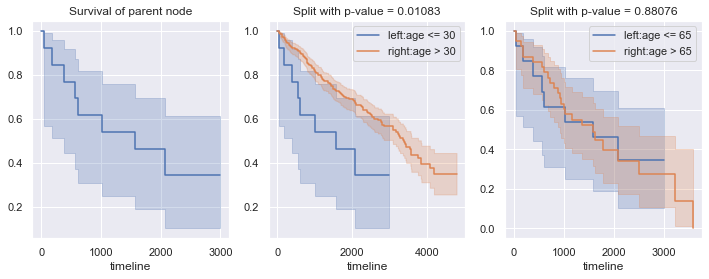

In [100]:
plt.show()

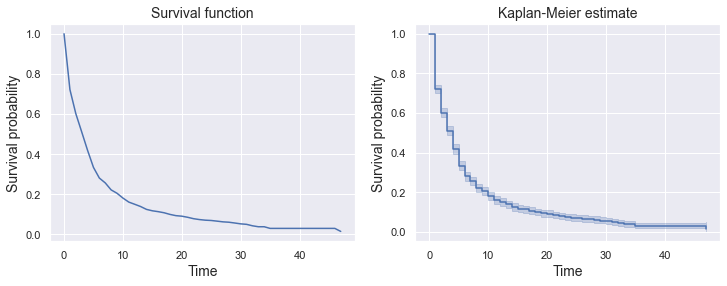

In [65]:
from lifelines.datasets import load_dd
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
data = load_dd()
data.head()
kmf = KaplanMeierFitter()
T = data["duration"]
E = data["observed"]

kmf.fit(T, event_observed=E)

naf = NelsonAalenFitter()
naf.fit(T, event_observed=E)

kmf.survival_function_.plot(ax = axs[0], legend = False)
kmf.plot_survival_function(ax = axs[1], legend = False)#, show_censors = True, censor_styles={"marker": "o", "ms": 4})

axis_font = {'fontname':'Arial', 'size':'14'}
axs[0].set_title('Survival function', **axis_font)
axs[1].set_title('Kaplan-Meier estimate', **axis_font)

axs[0].set_xlabel("Time", **axis_font)
axs[0].set_ylabel("Survival probability", **axis_font)

# axs[1].set_title('Hazard function')
axs[1].set_xlabel("Time", **axis_font)
axs[1].set_ylabel("Survival probability", **axis_font)
plt.show()

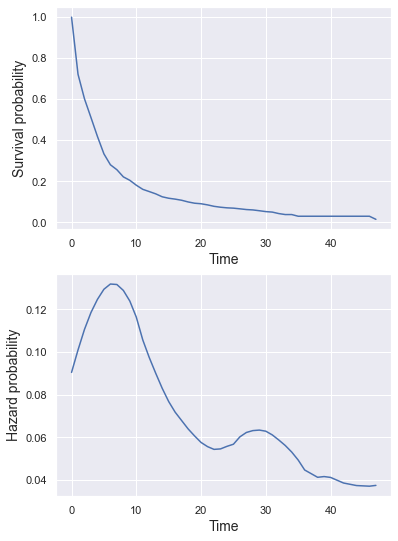

In [67]:
from lifelines.datasets import load_dd
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter


fig, axs = plt.subplots(2, 1, figsize=(6, 9))

data = load_dd()
data.head()
kmf = KaplanMeierFitter()
T = data["duration"]
E = data["observed"]

kmf.fit(T, event_observed=E)

naf = NelsonAalenFitter()
naf.fit(T, event_observed=E)


kmf.survival_function_.plot(ax = axs[0], legend = False)
naf.smoothed_hazard_(bandwidth = 10).plot(ax = axs[1], legend = False)#, show_censors = True, censor_styles={"marker": "o", "ms": 4})


# axs[0].set_title('Survival function')
axis_font = {'fontname':'Arial', 'size':'14'}
axs[0].set_xlabel("Time", **axis_font)
axs[0].set_ylabel("Survival probability", **axis_font)

# axs[1].set_title('Hazard function')
axs[1].set_xlabel("Time", **axis_font)
axs[1].set_ylabel("Hazard probability", **axis_font)

plt.show()


### COVID-19 DATA + forward CENS
#### Source: https://www.nature.com/articles/s42256-020-0180-7

In [70]:
[f for f in features if f.find('fatigue') != -1] 

[]

In [89]:
a = X.isna().sum(axis = 0)

In [114]:
%%time 
for i in range(100):
    X[X['max_Quantification_of_Treponema_pallidum_antibodies']!=X['max_Quantification_of_Treponema_pallidum_antibodies']]

Wall time: 67.6 ms


In [113]:
import lib.constants_other as other
df, features, categ, sch_nan = other.get_dataset_covid()
X = df.loc[:,set(df.columns) - {'cDeath'}]
y = df['cDeath']
y_bw = 1 - y

results_forward = []
results_backward = []

In [74]:
224/(224+151)

0.5973333333333334

In [16]:
cox_param_grid = {'alpha':[128, 64], 
                  'ties':["breslow", "efron"]}
cox_res_grid = ssc.grid_search(CoxPHSurvivalAnalysis, cox_param_grid, X, y, features, ['conc','ibs'], return_best = True)
results_forward.append(cox_res_grid)

{'alpha': 128, 'ties': 'breslow'} [[0.739819   0.88532383 0.16193355]
 [0.63622468 0.77890467 0.13283586]
 [0.7224736  0.85603113 0.15918037]
 [0.71779373 0.85949008 0.14427276]
 [0.73432155 0.80514962 0.24631733]]
{'alpha': 128, 'ties': 'efron'} [[0.73906486 0.8781937  0.16772182]
 [0.62820023 0.76876268 0.13448452]
 [0.71568627 0.84769316 0.16996967]
 [0.71892709 0.86005666 0.14381167]
 [0.73432155 0.80236604 0.25286195]]
{'alpha': 64, 'ties': 'breslow'} [[0.71945701 0.86036839 0.171855  ]
 [0.64233856 0.76402975 0.14491657]
 [0.71832579 0.84602557 0.16638625]
 [0.72006045 0.84645892 0.15298183]
 [0.73622197 0.80167015 0.24690011]]
{'alpha': 64, 'ties': 'efron'} [[0.71606335 0.85442662 0.17829624]
 [0.63469622 0.75524003 0.14609655]
 [0.7153092  0.84213452 0.22326626]
 [0.72383831 0.84929178 0.15000065]
 [0.73736222 0.79888657 0.253095  ]]


In [17]:
from sksurv.tree import SurvivalTree
SurvTree_param_grid = {'splitter':["best", "random"], 
                       'max_depth':[None, 20, 30], 
                       'min_samples_leaf':[1, 10, 20], 
                       'max_features':["sqrt"]
                      }
SurvTree_res_grid = ssc.grid_search(SurvivalTree, SurvTree_param_grid, X, y, features, ['conc','ibs'], return_best = True)
results_forward.append(SurvTree_res_grid)

{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'splitter': 'best'} [[0.66308446 0.81372549 0.27315736]
 [0.61807413 0.80493577 0.16228906]
 [0.6806184  0.79544191 0.21118629]
 [0.60804685 0.71501416 0.24119165]
 [0.65488407 0.79749478 0.31696556]]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'splitter': 'random'} [[0.70003771 0.84105764 0.1909446 ]
 [0.61157814 0.83603786 0.07650829]
 [0.66892911 0.82128961 0.20166494]
 [0.65961466 0.81699717 0.19764791]
 [0.6427214  0.7533055  0.26852159]]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'splitter': 'best'} [[0.65648567 0.80421866 0.14333551]
 [0.58884219 0.78566599 0.14452372]
 [0.69023379 0.81878822 0.14352637]
 [0.70853797 0.86883853 0.13553342]
 [0.64063094 0.78322895 0.29862902]]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'splitter': 'random'} [[0.66779789 0.80243613 0.21062304]
 [0.58139091 0.78769439 0.12627489]
 [0.72435897 0.82128961 0.16330

In [18]:
from sksurv.ensemble import RandomSurvivalForest
RSF_param_grid = {'n_estimators':[30, 50, 100], 
                  'max_depth':[None, 20, 30], 
                  'min_samples_leaf':[1, 10, 20], 
                  'max_features':["sqrt"]
                 }
RSF_res_grid = ssc.grid_search(RandomSurvivalForest, RSF_param_grid, X, y, features, ['conc','ibs'], return_best = True)
results_forward.append(RSF_res_grid)

{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 30} [[0.7239819  0.89542484 0.10621742]
 [0.64386702 0.88640974 0.09279525]
 [0.73831071 0.86381323 0.13739496]
 [0.71458255 0.89065156 0.10256666]
 [0.71151653 0.82811413 0.25717403]]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 50} [[0.71662896 0.88710636 0.10777882]
 [0.64845243 0.89114266 0.08777665]
 [0.7413273  0.87604225 0.12852493]
 [0.70249339 0.88441926 0.10098697]
 [0.72786013 0.83785665 0.2455469 ]]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100} [[0.72812971 0.90136661 0.10471951]
 [0.65074513 0.90060852 0.08558993]
 [0.73925339 0.87326292 0.1285896 ]
 [0.70551568 0.88441926 0.10433807]
 [0.73394147 0.85421016 0.25108442]]
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 30} [[0.70644796 0.86155674 0.12084052]
 [0.61520825 0.88235294 0.09839474]
 [0.74962293 0.87604225 0.13027023]

In [19]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
GBSA_param_grid = {'loss':["coxph"], 
                  'learning_rate':[0.01, 0.05, 0.1, 0.5],
                  'n_estimators':[30, 50, 100], 
                  'max_depth':[20, 30], 
                  'min_samples_leaf':[1, 10, 20], 
                  'max_features':["sqrt"]
                 }
GBSA_res_grid = ssc.grid_search(GradientBoostingSurvivalAnalysis, GBSA_param_grid, X, y, features, ['conc','ibs'], return_best = True)
results_forward.append(GBSA_res_grid)

{'learning_rate': 0.01, 'loss': 'coxph', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 30} [[0.72058824 0.84491979 0.18874356]
 [0.66832251 0.85057471 0.17541712]
 [0.73717949 0.86492496 0.18472177]
 [0.70381564 0.8776204  0.17446896]
 [0.74325352 0.84968685 0.28011434]]
{'learning_rate': 0.01, 'loss': 'coxph', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 50} [[0.74736048 0.8704694  0.17232148]
 [0.66220864 0.84110886 0.16214078]
 [0.76206637 0.86992774 0.17258445]
 [0.70532679 0.87875354 0.16081744]
 [0.73508172 0.86325678 0.2699332 ]]
{'learning_rate': 0.01, 'loss': 'coxph', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100} [[0.73642534 0.87522282 0.15116793]
 [0.66946886 0.85733604 0.13979596]
 [0.7745098  0.8782657  0.15492264]
 [0.70268228 0.8776204  0.13824347]
 [0.75009502 0.86430063 0.26930266]]
{'learning_rate': 0.01, 'loss': 'coxph', 'max_depth': 20, 'max_features': 'sqrt',

{'learning_rate': 0.05, 'loss': 'coxph', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 30} [[0.74434389 0.87284611 0.13951322]
 [0.68895682 0.88438134 0.12808633]
 [0.76168929 0.87770984 0.14751854]
 [0.72157159 0.89631728 0.12671734]
 [0.74971494 0.8670842  0.27622979]]
{'learning_rate': 0.05, 'loss': 'coxph', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 50} [[0.75       0.88175876 0.12793188]
 [0.67902178 0.87897228 0.11101934]
 [0.75414781 0.87381879 0.1499702 ]
 [0.70948243 0.88838527 0.11880588]
 [0.75066515 0.8729993  0.29099224]]
{'learning_rate': 0.05, 'loss': 'coxph', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100} [[0.73604827 0.87403446 0.11913814]
 [0.68895682 0.88640974 0.1082995 ]
 [0.76998492 0.87493052 0.14534883]
 [0.71666037 0.88895184 0.11814861]
 [0.75218548 0.87230341 0.3145108 ]]
{'learning_rate': 0.05, 'loss': 'coxph', 'max_depth': 30, 'max_features': 'sqrt',

{'learning_rate': 0.5, 'loss': 'coxph', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 30} [[0.78846154 0.91027926 0.11035981]
 [0.70576997 0.89858012 0.11345418]
 [0.75037707 0.86770428 0.15322665]
 [0.72308274 0.88215297 0.1294214 ]
 [0.75731661 0.87613083 0.36479036]]
{'learning_rate': 0.5, 'loss': 'coxph', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 50} [[0.76508296 0.88888889 0.12541803]
 [0.69774551 0.87762001 0.12666058]
 [0.76847662 0.86826014 0.15224558]
 [0.73139403 0.90084986 0.12153142]
 [0.75921703 0.87613083 0.37056457]]
{'learning_rate': 0.5, 'loss': 'coxph', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100} [[0.77224736 0.89601901 0.12254025]
 [0.69889186 0.88302907 0.13474477]
 [0.76508296 0.87270706 0.15312097]
 [0.72610502 0.89291785 0.13594763]
 [0.75807678 0.88169798 0.38532163]]
{'learning_rate': 0.5, 'loss': 'coxph', 'max_depth': 20, 'max_features': 'sqrt', 'mi

In [20]:
CRAID_param_grid_lr = {
    "name":["tree"],
    "depth":[10, 15],
    "features":[features],
    "categ":[categ],
    "days":["dDeath"],
    "cens":["cDeath"],
    "criterion":[],
    "min_samples_leaf":[10, 15],
    "n_jobs":[32],
    "bonf":[True],
    "thres_cont_bin_max":[100],
    "signif":[0.05, 0.1, 0.15],
    "max_features":[1.0],
    "verbose":[1]
}
for crit in [scrit.peto, scrit.wilcoxon, scrit.tarone_ware, scrit.logrank]:
    CRAID_param_grid_lr["criterion"] = [crit]
    CRAID_res_grid_lr = ssc.grid_search(crr.CRAID, CRAID_param_grid_lr, X, y, features, ['conc','ibs'], return_best = True)
    results_forward.append(CRAID_res_grid_lr)

====== 1.3022462577452505e-43 min_neutrophils_count
====== 1.0496121957191657e-05 min_mean_corpuscular_hemoglobin_concentration
====== 1.686610504813406e-31 min_Hypersensitive_c_reactive_protein
====== 0.0002281078702594076 min_Hypersensitive_c_reactive_protein
====== 0.038408212339173284 mean_Platelet_count
====== 1.057027453892385e-06 max_Serum_chloride
====== 6.777485771420054e-17 mean_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.05
====== 0.0028783777262204597 mean_mean_corpuscular_hemoglobin_concentration
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 0.00012793841505958235 min_Total_bilirubin
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 9.127341799289188e-11 max_globulin
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 0.0001211376187973329 max_glucose
====== 0.019162912352699173 max_neutrophils___
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-

====== 1.3022462577452505e-43 min_neutrophils_count
====== 1.0496121957191657e-05 min_mean_corpuscular_hemoglobin_concentration
====== 1.686610504813406e-31 min_Hypersensitive_c_reactive_protein
====== 0.0002281078702594076 min_Hypersensitive_c_reactive_protein
====== 0.038408212339173284 mean_Platelet_count
====== 1.057027453892385e-06 max_Serum_chloride
====== 6.777485771420054e-17 mean_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.1
====== 0.0028783777262204597 mean_mean_corpuscular_hemoglobin_concentration
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 0.00012793841505958235 min_Total_bilirubin
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 9.127341799289188e-11 max_globulin
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 0.0001211376187973329 max_glucose
====== 0.019162912352699173 max_neutrophils___
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0

====== 1.3022462577452505e-43 min_neutrophils_count
====== 1.0496121957191657e-05 min_mean_corpuscular_hemoglobin_concentration
====== 1.686610504813406e-31 min_Hypersensitive_c_reactive_protein
====== 0.0002281078702594076 min_Hypersensitive_c_reactive_protein
====== 0.038408212339173284 mean_Platelet_count
====== 1.057027453892385e-06 max_Serum_chloride
====== 6.777485771420054e-17 mean_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.15
====== 0.0028783777262204597 mean_mean_corpuscular_hemoglobin_concentration
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 0.00012793841505958235 min_Total_bilirubin
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 9.127341799289188e-11 max_globulin
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 0.0001211376187973329 max_glucose
====== 0.019162912352699173 max_neutrophils___
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-

====== 1.3022462577452505e-43 min_neutrophils_count
====== 1.0496121957191657e-05 min_mean_corpuscular_hemoglobin_concentration
====== 1.6866105048134061e-31 min_Hypersensitive_c_reactive_protein
====== 0.0003455790660578646 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.05
====== 7.416743345850904e-06 min_aspartate_aminotransferase
====== 6.777485771420054e-17 mean_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 0.0030307835667605213 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.05
====== 9.127341799289188e-11 max_globulin
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
FULL_TIME: 28.315370635000363 seconds
****** End fit. ******
====== 1.2942225889774884e-47 min_Hypersensitive_c_reactive_protein
====== 8.958269390358226e-08 min_aspartat

====== 1.3022462577452505e-43 min_neutrophils_count
====== 1.0496121957191657e-05 min_mean_corpuscular_hemoglobin_concentration
====== 1.6866105048134061e-31 min_Hypersensitive_c_reactive_protein
====== 0.0003455790660578646 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.1
====== 7.416743345850904e-06 min_aspartate_aminotransferase
====== 6.777485771420054e-17 mean_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 0.0030307835667605213 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.1
====== 9.127341799289188e-11 max_globulin
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
FULL_TIME: 28.44507498799976 seconds
****** End fit. ******
====== 1.2942225889774884e-47 min_Hypersensitive_c_reactive_protein
====== 8.958269390358226e-08 min_aspartate_aminotra

====== 1.3022462577452505e-43 min_neutrophils_count
====== 1.0496121957191657e-05 min_mean_corpuscular_hemoglobin_concentration
====== 1.6866105048134061e-31 min_Hypersensitive_c_reactive_protein
====== 0.0003455790660578646 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.15
====== 7.416743345850904e-06 min_aspartate_aminotransferase
====== 6.777485771420054e-17 mean_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 0.0030307835667605213 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.15
====== 9.127341799289188e-11 max_globulin
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
FULL_TIME: 28.458046592999835 seconds
****** End fit. ******
====== 1.2942225889774884e-47 min_Hypersensitive_c_reactive_protein
====== 8.958269390358226e-08 min_aspartat

====== 1.3022462577452505e-43 min_neutrophils_count
====== 1.0496121957191657e-05 min_mean_corpuscular_hemoglobin_concentration
====== 1.686610504813406e-31 min_Hypersensitive_c_reactive_protein
====== 0.0002281078702594076 min_Hypersensitive_c_reactive_protein
====== 0.038408212339173284 mean_Platelet_count
====== 1.057027453892385e-06 max_Serum_chloride
====== 6.777485771420054e-17 mean_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.05
====== 0.0028783777262204597 mean_mean_corpuscular_hemoglobin_concentration
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 0.00012793841505958235 min_Total_bilirubin
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 9.127341799289188e-11 max_globulin
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 0.0001211376187973329 max_glucose
====== 0.019162912352699173 max_neutrophils___
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-

====== 1.3022462577452505e-43 min_neutrophils_count
====== 1.0496121957191657e-05 min_mean_corpuscular_hemoglobin_concentration
====== 1.686610504813406e-31 min_Hypersensitive_c_reactive_protein
====== 0.0002281078702594076 min_Hypersensitive_c_reactive_protein
====== 0.038408212339173284 mean_Platelet_count
====== 1.057027453892385e-06 max_Serum_chloride
====== 6.777485771420054e-17 mean_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.1
====== 0.0028783777262204597 mean_mean_corpuscular_hemoglobin_concentration
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 0.00012793841505958235 min_Total_bilirubin
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 9.127341799289188e-11 max_globulin
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 0.0001211376187973329 max_glucose
====== 0.019162912352699173 max_neutrophils___
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0

====== 1.3022462577452505e-43 min_neutrophils_count
====== 1.0496121957191657e-05 min_mean_corpuscular_hemoglobin_concentration
====== 1.686610504813406e-31 min_Hypersensitive_c_reactive_protein
====== 0.0002281078702594076 min_Hypersensitive_c_reactive_protein
====== 0.038408212339173284 mean_Platelet_count
====== 1.057027453892385e-06 max_Serum_chloride
====== 6.777485771420054e-17 mean_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.15
====== 0.0028783777262204597 mean_mean_corpuscular_hemoglobin_concentration
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 0.00012793841505958235 min_Total_bilirubin
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 9.127341799289188e-11 max_globulin
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 0.0001211376187973329 max_glucose
====== 0.019162912352699173 max_neutrophils___
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-

====== 1.3022462577452505e-43 min_neutrophils_count
====== 1.0496121957191657e-05 min_mean_corpuscular_hemoglobin_concentration
====== 1.6866105048134061e-31 min_Hypersensitive_c_reactive_protein
====== 0.0003455790660578646 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.05
====== 7.416743345850904e-06 min_aspartate_aminotransferase
====== 6.777485771420054e-17 mean_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 0.0030307835667605213 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.05
====== 9.127341799289188e-11 max_globulin
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
FULL_TIME: 28.486542482999994 seconds
****** End fit. ******
====== 1.2942225889774884e-47 min_Hypersensitive_c_reactive_protein
====== 8.958269390358226e-08 min_aspartat

====== 1.3022462577452505e-43 min_neutrophils_count
====== 1.0496121957191657e-05 min_mean_corpuscular_hemoglobin_concentration
====== 1.6866105048134061e-31 min_Hypersensitive_c_reactive_protein
====== 0.0003455790660578646 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.1
====== 7.416743345850904e-06 min_aspartate_aminotransferase
====== 6.777485771420054e-17 mean_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 0.0030307835667605213 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.1
====== 9.127341799289188e-11 max_globulin
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
FULL_TIME: 28.197894760000054 seconds
****** End fit. ******
====== 1.2942225889774884e-47 min_Hypersensitive_c_reactive_protein
====== 8.958269390358226e-08 min_aspartate_aminotr

====== 1.3022462577452505e-43 min_neutrophils_count
====== 1.0496121957191657e-05 min_mean_corpuscular_hemoglobin_concentration
====== 1.6866105048134061e-31 min_Hypersensitive_c_reactive_protein
====== 0.0003455790660578646 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.15
====== 7.416743345850904e-06 min_aspartate_aminotransferase
====== 6.777485771420054e-17 mean_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 0.0030307835667605213 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.15
====== 9.127341799289188e-11 max_globulin
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
FULL_TIME: 28.381554496000263 seconds
****** End fit. ******
====== 1.2942225889774884e-47 min_Hypersensitive_c_reactive_protein
====== 8.958269390358226e-08 min_aspartat

====== 1.3084735079710263e-41 min_neutrophils_count
====== 1.4443106438460044e-05 min_mean_corpuscular_hemoglobin_concentration
====== 3.087491302648473e-28 min_aspartate_aminotransferase
====== 0.0003713837589507322 min_Hypersensitive_c_reactive_protein
====== 0.03557861660011626 mean_Serum_potassium
====== 0.0031675303292105056 min_eGFR
====== 5.181818595142552e-28 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 5.1227301765934205e-18 max____lymphocyte
====== 5.130818303445917e-07 mean_Prothrombin_time
====== 6.55173973952021e-05 mean_mean_corpuscular_hemoglobin_concentration
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 0.02151427277449448 max_HCO3_
К

====== 1.3084735079710263e-41 min_neutrophils_count
====== 1.4443106438460044e-05 min_mean_corpuscular_hemoglobin_concentration
====== 3.087491302648473e-28 min_aspartate_aminotransferase
====== 0.0003713837589507322 min_Hypersensitive_c_reactive_protein
====== 0.03557861660011626 mean_Serum_potassium
====== 0.0031675303292105056 min_eGFR
====== 5.181818595142552e-28 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 5.1227301765934205e-18 max____lymphocyte
====== 5.130818303445917e-07 mean_Prothrombin_time
====== 6.55173973952021e-05 mean_mean_corpuscular_hemoglobin_concentration
Конец ветви, незначащее p-value: 0.1
====== 0.08326451666355042 min_antithrombin
Конец ветви, незначащее p-value: 0.1
====== 0.02151427277449448 max_HCO3_
Коне

====== 1.3084735079710263e-41 min_neutrophils_count
====== 1.4443106438460044e-05 min_mean_corpuscular_hemoglobin_concentration
====== 3.087491302648473e-28 min_aspartate_aminotransferase
====== 0.0003713837589507322 min_Hypersensitive_c_reactive_protein
====== 0.03557861660011626 mean_Serum_potassium
====== 0.0031675303292105056 min_eGFR
====== 5.181818595142552e-28 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 5.122730176593421e-18 max____lymphocyte
====== 5.130818303445917e-07 mean_Prothrombin_time
====== 6.55173973952021e-05 mean_mean_corpuscular_hemoglobin_concentration
Конец ветви, незначащее p-value: 0.15
====== 0.08326451666355042 min_antithrombin
Конец ветви, незначащее p-value: 0.15
====== 0.02151427277449448 max_HC

====== 1.3084735079710263e-41 min_neutrophils_count
====== 1.4443106438460044e-05 min_mean_corpuscular_hemoglobin_concentration
====== 3.087491302648473e-28 min_aspartate_aminotransferase
====== 0.0003713837589507322 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 5.181818595142552e-28 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 5.1227301765934205e-18 max____lymphocyte
====== 1.1473646340354859e-05 min_neutrophils___
====== 0.0014034979832626114 min_aspartate_aminotransferase
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
FULL_TIME: 31.390104383999642 seconds
****** End fit. ******
====== 1.2668759238963374e-45 min_Hypersensitive_c_reactive_protein
====== 1.0993797856572007e-07 min_aspartate_aminot

====== 1.3084735079710263e-41 min_neutrophils_count
====== 1.4443106438460044e-05 min_mean_corpuscular_hemoglobin_concentration
====== 3.087491302648473e-28 min_aspartate_aminotransferase
====== 0.0003713837589507322 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 5.181818595142552e-28 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 5.1227301765934205e-18 max____lymphocyte
====== 1.7909703179924977e-05 min_Urea
====== 0.0014034979832626114 min_aspartate_aminotransferase
Конец ветви, незначащее p-value: 0.1
====== 0.0005320055051392492 max_HCV_antibody_quantification
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 0.08326451666355042 gender
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
FULL_TIME: 37.19653284300057 

====== 1.3084735079710263e-41 min_neutrophils_count
====== 1.4443106438460044e-05 min_mean_corpuscular_hemoglobin_concentration
====== 3.087491302648473e-28 min_aspartate_aminotransferase
====== 0.0003713837589507322 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 5.181818595142552e-28 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 5.1227301765934205e-18 max____lymphocyte
====== 1.7909703179924977e-05 min_Urea
====== 0.0014034979832626114 min_aspartate_aminotransferase
Конец ветви, незначащее p-value: 0.15
====== 0.0005320055051392492 max_HCV_antibody_quantification
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 0.08326451666355042 gender
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
FULL_TIME: 37.2769

====== 1.3084735079710263e-41 min_neutrophils_count
====== 1.4443106438460044e-05 min_mean_corpuscular_hemoglobin_concentration
====== 3.087491302648473e-28 min_aspartate_aminotransferase
====== 0.0003713837589507322 min_Hypersensitive_c_reactive_protein
====== 0.03557861660011626 mean_Serum_potassium
====== 0.0031675303292105056 min_eGFR
====== 5.181818595142552e-28 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 5.1227301765934205e-18 max____lymphocyte
====== 5.130818303445917e-07 mean_Prothrombin_time
====== 6.55173973952021e-05 mean_mean_corpuscular_hemoglobin_concentration
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 0.02151427277449448 max_HCO3_
К

====== 1.3084735079710263e-41 min_neutrophils_count
====== 1.4443106438460044e-05 min_mean_corpuscular_hemoglobin_concentration
====== 3.087491302648473e-28 min_aspartate_aminotransferase
====== 0.0003713837589507322 min_Hypersensitive_c_reactive_protein
====== 0.03557861660011626 mean_Serum_potassium
====== 0.0031675303292105056 min_eGFR
====== 5.181818595142552e-28 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 5.1227301765934205e-18 max____lymphocyte
====== 5.130818303445917e-07 mean_Prothrombin_time
====== 6.55173973952021e-05 mean_mean_corpuscular_hemoglobin_concentration
Конец ветви, незначащее p-value: 0.1
====== 0.08326451666355042 min_antithrombin
Конец ветви, незначащее p-value: 0.1
====== 0.02151427277449448 max_HCO3_
Коне

====== 1.3084735079710263e-41 min_neutrophils_count
====== 1.4443106438460044e-05 min_mean_corpuscular_hemoglobin_concentration
====== 3.087491302648473e-28 min_aspartate_aminotransferase
====== 0.0003713837589507322 min_Hypersensitive_c_reactive_protein
====== 0.03557861660011626 mean_Serum_potassium
====== 0.0031675303292105056 min_eGFR
====== 5.181818595142552e-28 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 5.122730176593421e-18 max____lymphocyte
====== 5.130818303445917e-07 mean_Prothrombin_time
====== 6.55173973952021e-05 mean_mean_corpuscular_hemoglobin_concentration
Конец ветви, незначащее p-value: 0.15
====== 0.08326451666355042 min_antithrombin
Конец ветви, незначащее p-value: 0.15
====== 0.02151427277449448 max_HC

====== 1.3084735079710263e-41 min_neutrophils_count
====== 1.4443106438460044e-05 min_mean_corpuscular_hemoglobin_concentration
====== 3.087491302648473e-28 min_aspartate_aminotransferase
====== 0.0003713837589507322 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 5.181818595142552e-28 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 5.1227301765934205e-18 max____lymphocyte
====== 1.1473646340354859e-05 min_neutrophils___
====== 0.0014034979832626114 min_aspartate_aminotransferase
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
FULL_TIME: 31.239294476000396 seconds
****** End fit. ******
====== 1.2668759238963374e-45 min_Hypersensitive_c_reactive_protein
====== 1.0993797856572007e-07 min_aspartate_aminot

====== 1.3084735079710263e-41 min_neutrophils_count
====== 1.4443106438460044e-05 min_mean_corpuscular_hemoglobin_concentration
====== 3.087491302648473e-28 min_aspartate_aminotransferase
====== 0.0003713837589507322 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 5.181818595142552e-28 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 5.1227301765934205e-18 max____lymphocyte
====== 1.7909703179924977e-05 min_Urea
====== 0.0014034979832626114 min_aspartate_aminotransferase
Конец ветви, незначащее p-value: 0.1
====== 0.0005320055051392492 max_HCV_antibody_quantification
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 0.08326451666355042 gender
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
FULL_TIME: 37.22890626800017 

====== 1.3084735079710263e-41 min_neutrophils_count
====== 1.4443106438460044e-05 min_mean_corpuscular_hemoglobin_concentration
====== 3.087491302648473e-28 min_aspartate_aminotransferase
====== 0.0003713837589507322 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 5.181818595142552e-28 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 5.1227301765934205e-18 max____lymphocyte
====== 1.7909703179924977e-05 min_Urea
====== 0.0014034979832626114 min_aspartate_aminotransferase
Конец ветви, незначащее p-value: 0.15
====== 0.0005320055051392492 max_HCV_antibody_quantification
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 0.08326451666355042 gender
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
FULL_TIME: 37.0670

====== 4.757876826244011e-44 min_neutrophils_count
====== 5.30734977365536e-06 min_mean_corpuscular_hemoglobin_concentration
====== 6.829789728434614e-31 min_Hypersensitive_c_reactive_protein
====== 0.00022510134605173966 min_Hypersensitive_c_reactive_protein
====== 0.02760825495035383 mean_Serum_potassium
====== 3.8379946842690965e-07 max_Serum_chloride
====== 1.1689720452557899e-18 mean_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.05
====== 0.010382201612895891 max_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 0.00015693128099081907 min_Total_bilirubin
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 9.127341799289154e-11 max_globulin
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 0.0002265192383703022 max_glucose
====== 0.021763836820025837 min_mean_corpuscular_volume
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
К

====== 4.757876826244011e-44 min_neutrophils_count
====== 5.30734977365536e-06 min_mean_corpuscular_hemoglobin_concentration
====== 6.829789728434614e-31 min_Hypersensitive_c_reactive_protein
====== 0.00022510134605173966 min_Hypersensitive_c_reactive_protein
====== 0.02760825495035383 mean_Serum_potassium
====== 3.8379946842690965e-07 max_Serum_chloride
====== 1.1689720452557899e-18 mean_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.1
====== 0.010382201612895891 max_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 0.00015693128099081907 min_Total_bilirubin
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 9.127341799289154e-11 max_globulin
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 0.00022651923837030218 max_glucose
====== 0.022467781416637675 max_neutrophils___
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незна

====== 4.757876826244011e-44 min_neutrophils_count
====== 5.30734977365536e-06 min_mean_corpuscular_hemoglobin_concentration
====== 6.829789728434614e-31 min_Hypersensitive_c_reactive_protein
====== 0.00022510134605173966 min_Hypersensitive_c_reactive_protein
====== 0.02760825495035383 mean_Serum_potassium
====== 3.8379946842690965e-07 max_Serum_chloride
====== 1.1689720452557899e-18 mean_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.15
====== 0.010382201612895891 max_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 0.00015693128099081907 min_Total_bilirubin
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 9.127341799289154e-11 max_globulin
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 0.00022651923837030218 max_glucose
====== 0.022467781416637675 max_neutrophils___
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец вет

====== 4.757876826244011e-44 min_neutrophils_count
====== 5.30734977365536e-06 min_mean_corpuscular_hemoglobin_concentration
====== 6.829789728434613e-31 min_Hypersensitive_c_reactive_protein
====== 0.00022510134605173966 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.05
====== 3.874322229440875e-05 min_aspartate_aminotransferase
====== 1.1689720452557899e-18 mean_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 0.0015092429833178024 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.05
====== 9.127341799289154e-11 max_globulin
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
FULL_TIME: 30.066226769999957 seconds
****** End fit. ******
====== 1.4929852995855812e-48 min_Hypersensitive_c_reactive_protein
====== 2.682736500145931e-07 min_aspartate_

====== 4.757876826244011e-44 min_neutrophils_count
====== 5.30734977365536e-06 min_mean_corpuscular_hemoglobin_concentration
====== 6.829789728434613e-31 min_Hypersensitive_c_reactive_protein
====== 0.00022510134605173966 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.1
====== 3.874322229440875e-05 min_aspartate_aminotransferase
====== 1.1689720452557899e-18 mean_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 0.0015092429833178024 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.1
====== 9.127341799289154e-11 max_globulin
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
FULL_TIME: 30.316029407000315 seconds
****** End fit. ******
====== 1.4929852995855812e-48 min_Hypersensitive_c_reactive_protein
====== 2.682736500145931e-07 min_aspartate_aminotran

====== 4.757876826244011e-44 min_neutrophils_count
====== 5.30734977365536e-06 min_mean_corpuscular_hemoglobin_concentration
====== 6.829789728434613e-31 min_Hypersensitive_c_reactive_protein
====== 0.00022510134605173966 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.15
====== 3.874322229440875e-05 min_aspartate_aminotransferase
====== 1.1689720452557899e-18 mean_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 0.0015092429833178024 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.15
====== 9.127341799289154e-11 max_globulin
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
FULL_TIME: 30.04312295699947 seconds
****** End fit. ******
====== 1.4929852995855812e-48 min_Hypersensitive_c_reactive_protein
====== 2.682736500145931e-07 min_aspartate_a

====== 4.757876826244011e-44 min_neutrophils_count
====== 5.30734977365536e-06 min_mean_corpuscular_hemoglobin_concentration
====== 6.829789728434614e-31 min_Hypersensitive_c_reactive_protein
====== 0.00022510134605173966 min_Hypersensitive_c_reactive_protein
====== 0.02760825495035383 mean_Serum_potassium
====== 3.8379946842690965e-07 max_Serum_chloride
====== 1.1689720452557899e-18 mean_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.05
====== 0.010382201612895891 max_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 0.00015693128099081907 min_Total_bilirubin
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 9.127341799289154e-11 max_globulin
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 0.0002265192383703022 max_glucose
====== 0.021763836820025837 min_mean_corpuscular_volume
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
К

====== 4.757876826244011e-44 min_neutrophils_count
====== 5.30734977365536e-06 min_mean_corpuscular_hemoglobin_concentration
====== 6.829789728434614e-31 min_Hypersensitive_c_reactive_protein
====== 0.00022510134605173966 min_Hypersensitive_c_reactive_protein
====== 0.02760825495035383 mean_Serum_potassium
====== 3.8379946842690965e-07 max_Serum_chloride
====== 1.1689720452557899e-18 mean_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.1
====== 0.010382201612895891 max_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 0.00015693128099081907 min_Total_bilirubin
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 9.127341799289154e-11 max_globulin
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 0.00022651923837030218 max_glucose
====== 0.022467781416637675 max_neutrophils___
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незна

====== 4.757876826244011e-44 min_neutrophils_count
====== 5.30734977365536e-06 min_mean_corpuscular_hemoglobin_concentration
====== 6.829789728434614e-31 min_Hypersensitive_c_reactive_protein
====== 0.00022510134605173966 min_Hypersensitive_c_reactive_protein
====== 0.02760825495035383 mean_Serum_potassium
====== 3.8379946842690965e-07 max_Serum_chloride
====== 1.1689720452557899e-18 mean_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.15
====== 0.010382201612895891 max_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 0.00015693128099081907 min_Total_bilirubin
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 9.127341799289154e-11 max_globulin
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 0.00022651923837030218 max_glucose
====== 0.022467781416637675 max_neutrophils___
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец вет

====== 4.757876826244011e-44 min_neutrophils_count
====== 5.30734977365536e-06 min_mean_corpuscular_hemoglobin_concentration
====== 6.829789728434613e-31 min_Hypersensitive_c_reactive_protein
====== 0.00022510134605173966 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.05
====== 3.874322229440875e-05 min_aspartate_aminotransferase
====== 1.1689720452557899e-18 mean_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 0.0015092429833178024 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.05
====== 9.127341799289154e-11 max_globulin
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
FULL_TIME: 30.041508942999826 seconds
****** End fit. ******
====== 1.4929852995855812e-48 min_Hypersensitive_c_reactive_protein
====== 2.682736500145931e-07 min_aspartate_

====== 4.757876826244011e-44 min_neutrophils_count
====== 5.30734977365536e-06 min_mean_corpuscular_hemoglobin_concentration
====== 6.829789728434613e-31 min_Hypersensitive_c_reactive_protein
====== 0.00022510134605173966 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.1
====== 3.874322229440875e-05 min_aspartate_aminotransferase
====== 1.1689720452557899e-18 mean_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 0.0015092429833178024 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.1
====== 9.127341799289154e-11 max_globulin
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
FULL_TIME: 30.645234731999153 seconds
****** End fit. ******
====== 1.4929852995855812e-48 min_Hypersensitive_c_reactive_protein
====== 2.682736500145931e-07 min_aspartate_aminotran

====== 4.757876826244011e-44 min_neutrophils_count
====== 5.30734977365536e-06 min_mean_corpuscular_hemoglobin_concentration
====== 6.829789728434613e-31 min_Hypersensitive_c_reactive_protein
====== 0.00022510134605173966 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.15
====== 3.874322229440875e-05 min_aspartate_aminotransferase
====== 1.1689720452557899e-18 mean_Lactate_dehydrogenase
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 0.0015092429833178024 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.15
====== 9.127341799289154e-11 max_globulin
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
FULL_TIME: 30.665012992999436 seconds
****** End fit. ******
====== 1.4929852995855812e-48 min_Hypersensitive_c_reactive_protein
====== 2.682736500145931e-07 min_aspartate_

====== 1.4091480701302898e-47 min_Hypersensitive_c_reactive_protein
====== 1.4289217139210742e-07 min_basophil_count___
====== 3.152396188067935e-39 mean_HCO3_
====== 0.0007610883155104669 min_mean_corpuscular_hemoglobin_concentration
====== 0.00016749339355039193 max_basophil___
====== 7.634894800434951e-15 max____lymphocyte
Конец ветви, незначащее p-value: 0.05
====== 0.0013003300026173045 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.05
====== 2.7529044150171468e-05 min_globulin
====== 0.0001648358926923745 max_Serum_potassium
====== 2.2090496998585455e-05 mean_basophil___
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 0.0038499315098553004 age
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 0.012086020670246242 min_Quantification_of_Treponema_pallidum_antibodies
Конец ветви, незначащее p-value: 0.05
====== 0.00

====== 1.4091480701302898e-47 min_Hypersensitive_c_reactive_protein
====== 1.4289217139210742e-07 min_basophil_count___
====== 3.152396188067935e-39 mean_HCO3_
====== 0.0007610883155104669 min_mean_corpuscular_hemoglobin_concentration
====== 0.00016749339355039193 max_basophil___
====== 7.634894800434951e-15 max____lymphocyte
Конец ветви, незначащее p-value: 0.1
====== 0.0013003300026173045 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.1
====== 2.7529044150171468e-05 min_globulin
====== 0.0001648358926923745 max_Serum_potassium
====== 2.2090496998585455e-05 mean_basophil___
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 0.0038499315098553004 age
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 0.012086020670246242 min_Quantification_of_Treponema_pallidum_antibodies
Конец ветви, незначащее p-value: 0.1
====== 0.00885379149

====== 1.4091480701302898e-47 min_Hypersensitive_c_reactive_protein
====== 1.4289217139210742e-07 min_basophil_count___
====== 3.152396188067935e-39 mean_HCO3_
====== 0.0007610883155104669 min_mean_corpuscular_hemoglobin_concentration
====== 0.00016749339355039193 max_basophil___
====== 7.634894800434951e-15 max____lymphocyte
Конец ветви, незначащее p-value: 0.15
====== 0.0013003300026173045 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.15
====== 2.7529044150171468e-05 min_globulin
====== 0.0001648358926923745 max_Serum_potassium
====== 2.2090496998585455e-05 mean_basophil___
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 0.0038499315098553004 age
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 0.014305878435429641 mean_creatinine
Конец ветви, незначащее p-value: 0.15
====== 0.008853791498184578 age
Конец ветви, не

====== 1.4091480701302898e-47 min_Hypersensitive_c_reactive_protein
====== 1.4289217139210742e-07 min_basophil_count___
====== 2.30115720348214e-30 mean____lymphocyte
====== 0.0017739624307606101 min_glucose
====== 0.00016749339355039193 max_basophil___
====== 4.819347603234263e-09 mean_Platelet_count
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 2.7529044150171468e-05 min_globulin
====== 0.0001648358926923745 max_Serum_potassium
====== 0.012086020670246242 min_Quantification_of_Treponema_pallidum_antibodies
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
FULL_TIME: 31.246139652999773 seconds
****** End fit. ******
====== 2.7173800793433114e-49 min_Hypersensitive_c_reactive_protein
====== 6.4097852

====== 1.4091480701302898e-47 min_Hypersensitive_c_reactive_protein
====== 1.4289217139210742e-07 min_basophil_count___
====== 2.30115720348214e-30 mean____lymphocyte
====== 0.013836733446034713 mean_Serum_chloride
====== 0.00016749339355039193 max_basophil___
====== 4.819347603234263e-09 mean_Platelet_count
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 0.032260855759124164 age
====== 2.7529044150171468e-05 min_globulin
====== 0.0001648358926923745 max_Serum_potassium
====== 0.012086020670246242 min_Quantification_of_Treponema_pallidum_antibodies
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 0.08326451666355042 max_Fibrin_degradation_products
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незнача

====== 1.4091480701302898e-47 min_Hypersensitive_c_reactive_protein
====== 1.4289217139210742e-07 min_basophil_count___
====== 2.30115720348214e-30 mean____lymphocyte
====== 0.0027760132471993243 min_mean_corpuscular_hemoglobin_concentration
====== 0.00016749339355039193 max_basophil___
====== 4.819347603234263e-09 mean_Platelet_count
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 2.7529044150171468e-05 min_globulin
====== 0.0001648358926923745 max_Serum_potassium
====== 0.014305878435429641 max_Quantification_of_Treponema_pallidum_antibodies
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 0.03894745574202525 gender
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
FULL_TIME: 34.091753556000185 seconds
*

====== 1.4091480701302898e-47 min_Hypersensitive_c_reactive_protein
====== 1.4289217139210742e-07 min_basophil_count___
====== 3.152396188067935e-39 mean_HCO3_
====== 0.0007610883155104669 min_mean_corpuscular_hemoglobin_concentration
====== 0.00016749339355039193 max_basophil___
====== 7.634894800434951e-15 max____lymphocyte
Конец ветви, незначащее p-value: 0.05
====== 0.0013003300026173045 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.05
====== 2.7529044150171468e-05 min_globulin
====== 0.0001648358926923745 max_Serum_potassium
====== 2.2090496998585455e-05 mean_basophil___
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 0.0038499315098553004 age
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 0.012086020670246242 min_Quantification_of_Treponema_pallidum_antibodies
Конец ветви, незначащее p-value: 0.05
====== 0.00

====== 1.4091480701302898e-47 min_Hypersensitive_c_reactive_protein
====== 1.4289217139210742e-07 min_basophil_count___
====== 3.152396188067935e-39 mean_HCO3_
====== 0.0007610883155104669 min_mean_corpuscular_hemoglobin_concentration
====== 0.00016749339355039193 max_basophil___
====== 7.634894800434951e-15 max____lymphocyte
Конец ветви, незначащее p-value: 0.1
====== 0.0013003300026173045 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.1
====== 2.7529044150171468e-05 min_globulin
====== 0.0001648358926923745 max_Serum_potassium
====== 2.2090496998585455e-05 mean_basophil___
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 0.0038499315098553004 age
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 0.012086020670246242 min_Quantification_of_Treponema_pallidum_antibodies
Конец ветви, незначащее p-value: 0.1
====== 0.00885379149

====== 1.4091480701302898e-47 min_Hypersensitive_c_reactive_protein
====== 1.4289217139210742e-07 min_basophil_count___
====== 3.152396188067935e-39 mean_HCO3_
====== 0.0007610883155104669 min_mean_corpuscular_hemoglobin_concentration
====== 0.00016749339355039193 max_basophil___
====== 7.634894800434951e-15 max____lymphocyte
Конец ветви, незначащее p-value: 0.15
====== 0.0013003300026173045 min_Hypersensitive_c_reactive_protein
Конец ветви, незначащее p-value: 0.15
====== 2.7529044150171468e-05 min_globulin
====== 0.0001648358926923745 max_Serum_potassium
====== 2.2090496998585455e-05 mean_basophil___
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 0.0038499315098553004 age
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 0.014305878435429641 mean_creatinine
Конец ветви, незначащее p-value: 0.15
====== 0.008853791498184578 age
Конец ветви, не

====== 1.4091480701302898e-47 min_Hypersensitive_c_reactive_protein
====== 1.4289217139210742e-07 min_basophil_count___
====== 2.30115720348214e-30 mean____lymphocyte
====== 0.0017739624307606101 min_glucose
====== 0.00016749339355039193 max_basophil___
====== 4.819347603234263e-09 mean_Platelet_count
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
====== 2.7529044150171468e-05 min_globulin
====== 0.0001648358926923745 max_Serum_potassium
====== 0.012086020670246242 min_Quantification_of_Treponema_pallidum_antibodies
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
Конец ветви, незначащее p-value: 0.05
FULL_TIME: 31.55670969199855 seconds
****** End fit. ******
====== 2.7173800793433114e-49 min_Hypersensitive_c_reactive_protein
====== 6.40978522

====== 1.4091480701302898e-47 min_Hypersensitive_c_reactive_protein
====== 1.4289217139210742e-07 min_basophil_count___
====== 2.30115720348214e-30 mean____lymphocyte
====== 0.013836733446034713 mean_Serum_chloride
====== 0.00016749339355039193 max_basophil___
====== 4.819347603234263e-09 mean_Platelet_count
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 0.032260855759124164 age
====== 2.7529044150171468e-05 min_globulin
====== 0.0001648358926923745 max_Serum_potassium
====== 0.012086020670246242 min_Quantification_of_Treponema_pallidum_antibodies
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
====== 0.08326451666355042 max_Fibrin_degradation_products
Конец ветви, незначащее p-value: 0.1
Конец ветви, незначащее p-value: 0.1
Конец ветви, незнача

====== 1.4091480701302898e-47 min_Hypersensitive_c_reactive_protein
====== 1.4289217139210742e-07 min_basophil_count___
====== 2.30115720348214e-30 mean____lymphocyte
====== 0.0027760132471993243 min_mean_corpuscular_hemoglobin_concentration
====== 0.00016749339355039193 max_basophil___
====== 4.819347603234263e-09 mean_Platelet_count
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 2.7529044150171468e-05 min_globulin
====== 0.0001648358926923745 max_Serum_potassium
====== 0.014305878435429641 max_Quantification_of_Treponema_pallidum_antibodies
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
====== 0.03894745574202525 gender
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
Конец ветви, незначащее p-value: 0.15
FULL_TIME: 34.22721033400012 seconds
**

In [57]:
BCR_param_grid_lr = {
    "size_sample" : [0.7], 
    "n_estimators" : [10, 30], 
    "depth" : [15],
    "tolerance" : [True],
    "features" : [features], 
    "categ" : [categ],
    "days":["dDeath"],
    "cens":["cDeath"],
    "criterion":[],
    "min_samples_leaf":[1,5,10],
    "thres_cont_bin_max":[100],
    "signif":[1.1],
    "max_features":[0.1],
    "verbose":[0]
}
for crit in [scrit.tarone_ware, scrit.logrank]: #[scrit.peto, scrit.wilcoxon, scrit.tarone_ware, scrit.logrank]:
    BCR_param_grid_lr["criterion"] = [crit]
    BCR_res_grid_lr = ssc.grid_search(bst.BootstrapCRAID, BCR_param_grid_lr, X, y, features, ['conc','ibs'], return_best = True)
    results_forward.append(BCR_res_grid_lr)

FULL_TIME: 12.162649752994184 seconds
****** End fit. ******
FULL_TIME: 10.670503567002015 seconds
****** End fit. ******
FULL_TIME: 7.801997964998009 seconds
****** End fit. ******
FULL_TIME: 9.949058580998098 seconds
****** End fit. ******
FULL_TIME: 8.953674370000954 seconds
****** End fit. ******
FULL_TIME: 10.112921039995854 seconds
****** End fit. ******
FULL_TIME: 9.710218077001628 seconds
****** End fit. ******
FULL_TIME: 8.816200317000039 seconds
****** End fit. ******
FULL_TIME: 9.069646921008825 seconds
****** End fit. ******
FULL_TIME: 8.841920200007735 seconds
****** End fit. ******
{0: 0.9222, 1: 0.9024, 2: 0.9246, 3: 0.9502, 4: 0.9632, 5: 0.962, 6: 0.962, 7: 0.9705, 8: 0.9698, 9: 0.9722}
fitted: 10 models.
FULL_TIME: 8.460631454989198 seconds
****** End fit. ******
FULL_TIME: 8.04851942199457 seconds
****** End fit. ******
FULL_TIME: 7.990831325005274 seconds
****** End fit. ******
FULL_TIME: 7.770872352994047 seconds
****** End fit. ******
FULL_TIME: 8.259414557003765 s

FULL_TIME: 7.315192655005376 seconds
****** End fit. ******
FULL_TIME: 10.544711859998642 seconds
****** End fit. ******
FULL_TIME: 7.83875312199234 seconds
****** End fit. ******
FULL_TIME: 9.905659145006211 seconds
****** End fit. ******
FULL_TIME: 9.048957302991766 seconds
****** End fit. ******
FULL_TIME: 10.085626152009354 seconds
****** End fit. ******
FULL_TIME: 9.70840316399699 seconds
****** End fit. ******
FULL_TIME: 8.766663236994646 seconds
****** End fit. ******
FULL_TIME: 9.20334437499696 seconds
****** End fit. ******
FULL_TIME: 8.781817907001823 seconds
****** End fit. ******
FULL_TIME: 8.936622378998436 seconds
****** End fit. ******
FULL_TIME: 7.631916918006027 seconds
****** End fit. ******
FULL_TIME: 8.037570941989543 seconds
****** End fit. ******
FULL_TIME: 10.012245054997038 seconds
****** End fit. ******
FULL_TIME: 8.985973678005394 seconds
****** End fit. ******
FULL_TIME: 10.90576642099768 seconds
****** End fit. ******
FULL_TIME: 8.099728542991215 seconds
***

FULL_TIME: 10.258624128997326 seconds
****** End fit. ******
{0: 0.9211, 1: 0.924, 2: 0.9378, 3: 0.9425, 4: 0.9424, 5: 0.9422, 6: 0.9478, 7: 0.9569, 8: 0.9625, 9: 0.9597, 10: 0.9678, 11: 0.9727, 12: 0.9765, 13: 0.9742, 14: 0.9766, 15: 0.9794, 16: 0.9793, 17: 0.9806, 18: 0.9796, 19: 0.9798, 20: 0.9804, 21: 0.9811, 22: 0.9811, 23: 0.9814, 24: 0.9823, 25: 0.9815, 26: 0.9822, 27: 0.983, 28: 0.9828, 29: 0.983}
fitted: 28 models.
FULL_TIME: 7.969294227004866 seconds
****** End fit. ******
FULL_TIME: 10.003876560993376 seconds
****** End fit. ******
FULL_TIME: 9.338462258005165 seconds
****** End fit. ******
FULL_TIME: 8.599703918007435 seconds
****** End fit. ******
FULL_TIME: 8.377121076002368 seconds
****** End fit. ******
FULL_TIME: 8.466743255994515 seconds
****** End fit. ******
FULL_TIME: 10.169606107010623 seconds
****** End fit. ******
FULL_TIME: 10.020534067996778 seconds
****** End fit. ******
FULL_TIME: 9.215304661003756 seconds
****** End fit. ******
FULL_TIME: 7.997088434989564 

FULL_TIME: 5.7855964560003486 seconds
****** End fit. ******
FULL_TIME: 6.840475875986158 seconds
****** End fit. ******
FULL_TIME: 5.3169661199935945 seconds
****** End fit. ******
FULL_TIME: 4.858626467990689 seconds
****** End fit. ******
FULL_TIME: 5.851094237994403 seconds
****** End fit. ******
FULL_TIME: 6.457774016002077 seconds
****** End fit. ******
FULL_TIME: 6.35086042599869 seconds
****** End fit. ******
FULL_TIME: 6.086037700995803 seconds
****** End fit. ******
FULL_TIME: 5.6843387440021615 seconds
****** End fit. ******
FULL_TIME: 5.462050909991376 seconds
****** End fit. ******
{0: 0.8985, 1: 0.9097, 2: 0.927, 3: 0.9521, 4: 0.9571, 5: 0.9611, 6: 0.9644, 7: 0.9676, 8: 0.9676, 9: 0.9691}
fitted: 10 models.
FULL_TIME: 5.587369140994269 seconds
****** End fit. ******
FULL_TIME: 6.0597760759992525 seconds
****** End fit. ******
FULL_TIME: 6.494447253004182 seconds
****** End fit. ******
FULL_TIME: 5.506971713009989 seconds
****** End fit. ******
FULL_TIME: 5.811608909003553

FULL_TIME: 5.635254172986606 seconds
****** End fit. ******
FULL_TIME: 6.647640637005679 seconds
****** End fit. ******
FULL_TIME: 5.8190372770040995 seconds
****** End fit. ******
FULL_TIME: 4.913629255999695 seconds
****** End fit. ******
FULL_TIME: 5.848074421999627 seconds
****** End fit. ******
FULL_TIME: 6.178978607000317 seconds
****** End fit. ******
FULL_TIME: 6.751393489001202 seconds
****** End fit. ******
FULL_TIME: 5.973802252003225 seconds
****** End fit. ******
FULL_TIME: 5.494572570998571 seconds
****** End fit. ******
FULL_TIME: 5.649966572993435 seconds
****** End fit. ******
FULL_TIME: 6.238433829988935 seconds
****** End fit. ******
FULL_TIME: 5.054129463998834 seconds
****** End fit. ******
FULL_TIME: 5.5359318160044495 seconds
****** End fit. ******
FULL_TIME: 7.652601171997958 seconds
****** End fit. ******
FULL_TIME: 6.2783931250014575 seconds
****** End fit. ******
FULL_TIME: 5.4961592799954815 seconds
****** End fit. ******
FULL_TIME: 6.012558105998323 seconds

FULL_TIME: 6.68765990799875 seconds
****** End fit. ******
{0: 0.8835, 1: 0.9248, 2: 0.9297, 3: 0.9331, 4: 0.9433, 5: 0.9491, 6: 0.9491, 7: 0.957, 8: 0.9604, 9: 0.9652, 10: 0.9674, 11: 0.971, 12: 0.9726, 13: 0.9707, 14: 0.9699, 15: 0.9716, 16: 0.9732, 17: 0.9731, 18: 0.9719, 19: 0.9737, 20: 0.9732, 21: 0.9732, 22: 0.9748, 23: 0.9767, 24: 0.9775, 25: 0.9777, 26: 0.9772, 27: 0.9777, 28: 0.9784, 29: 0.9781}
fitted: 29 models.
FULL_TIME: 6.06519399600802 seconds
****** End fit. ******
FULL_TIME: 6.3609848319902085 seconds
****** End fit. ******
FULL_TIME: 6.452748627998517 seconds
****** End fit. ******
FULL_TIME: 5.661086695006816 seconds
****** End fit. ******
FULL_TIME: 5.359496135002701 seconds
****** End fit. ******
FULL_TIME: 5.431673792001675 seconds
****** End fit. ******
FULL_TIME: 6.006186893006088 seconds
****** End fit. ******
FULL_TIME: 6.631669207999948 seconds
****** End fit. ******
FULL_TIME: 6.41983687200991 seconds
****** End fit. ******
FULL_TIME: 5.1060144229995785 seco

FULL_TIME: 2.924408531995141 seconds
****** End fit. ******
FULL_TIME: 3.631903752000653 seconds
****** End fit. ******
FULL_TIME: 3.4953907940071076 seconds
****** End fit. ******
FULL_TIME: 3.0252941920043668 seconds
****** End fit. ******
FULL_TIME: 3.1175046450080117 seconds
****** End fit. ******
FULL_TIME: 3.1124948609940475 seconds
****** End fit. ******
FULL_TIME: 4.030123556993203 seconds
****** End fit. ******
FULL_TIME: 3.2555024000030244 seconds
****** End fit. ******
FULL_TIME: 3.315632974001346 seconds
****** End fit. ******
FULL_TIME: 3.304913674001 seconds
****** End fit. ******
{0: 0.9055, 1: 0.9322, 2: 0.9486, 3: 0.9673, 4: 0.9701, 5: 0.97, 6: 0.9723, 7: 0.9752, 8: 0.9755, 9: 0.9772}
fitted: 10 models.
FULL_TIME: 3.7752765160112176 seconds
****** End fit. ******
FULL_TIME: 3.3509681889991043 seconds
****** End fit. ******
FULL_TIME: 3.9767406370083336 seconds
****** End fit. ******
FULL_TIME: 3.387415172997862 seconds
****** End fit. ******
FULL_TIME: 3.63214951100235

FULL_TIME: 2.9296509099949617 seconds
****** End fit. ******
FULL_TIME: 3.616103476000717 seconds
****** End fit. ******
FULL_TIME: 3.510204619000433 seconds
****** End fit. ******
FULL_TIME: 3.0041905859980034 seconds
****** End fit. ******
FULL_TIME: 3.1456011770060286 seconds
****** End fit. ******
FULL_TIME: 3.1348150730045745 seconds
****** End fit. ******
FULL_TIME: 3.98572206699464 seconds
****** End fit. ******
FULL_TIME: 3.1900782480079215 seconds
****** End fit. ******
FULL_TIME: 3.2623183200048516 seconds
****** End fit. ******
FULL_TIME: 3.3587037560064346 seconds
****** End fit. ******
FULL_TIME: 3.2375132079905597 seconds
****** End fit. ******
FULL_TIME: 3.151943132004817 seconds
****** End fit. ******
FULL_TIME: 3.2894196229899535 seconds
****** End fit. ******
FULL_TIME: 4.028393001994118 seconds
****** End fit. ******
FULL_TIME: 4.838993030003621 seconds
****** End fit. ******
FULL_TIME: 4.564444283998455 seconds
****** End fit. ******
FULL_TIME: 4.565685759007465 sec

FULL_TIME: 3.4093287119903835 seconds
****** End fit. ******
FULL_TIME: 3.6400201479991665 seconds
****** End fit. ******
{0: 0.934, 1: 0.9482, 2: 0.9561, 3: 0.9624, 4: 0.962, 5: 0.9648, 6: 0.9653, 7: 0.9649, 8: 0.9657, 9: 0.9657, 10: 0.9681, 11: 0.9701, 12: 0.9714, 13: 0.9714, 14: 0.9713, 15: 0.9721, 16: 0.9729, 17: 0.9733, 18: 0.9726, 19: 0.9715, 20: 0.9713, 21: 0.9708, 22: 0.9706, 23: 0.9711, 24: 0.9714, 25: 0.9714, 26: 0.9714, 27: 0.9723, 28: 0.9719, 29: 0.9724}
fitted: 18 models.
FULL_TIME: 3.2363117179920664 seconds
****** End fit. ******
FULL_TIME: 3.9982869990053587 seconds
****** End fit. ******
FULL_TIME: 4.01609674700012 seconds
****** End fit. ******
FULL_TIME: 3.476083084999118 seconds
****** End fit. ******
FULL_TIME: 3.4592358930094633 seconds
****** End fit. ******
FULL_TIME: 3.5248146200028714 seconds
****** End fit. ******
FULL_TIME: 3.4210120310017373 seconds
****** End fit. ******
FULL_TIME: 3.7173450970003614 seconds
****** End fit. ******
FULL_TIME: 3.876548368993

FULL_TIME: 8.862939935002942 seconds
****** End fit. ******
FULL_TIME: 8.963063447998138 seconds
****** End fit. ******
FULL_TIME: 9.313152949995128 seconds
****** End fit. ******
FULL_TIME: 9.28482041299867 seconds
****** End fit. ******
FULL_TIME: 9.445891259994823 seconds
****** End fit. ******
FULL_TIME: 11.714231657999335 seconds
****** End fit. ******
FULL_TIME: 12.499469716000021 seconds
****** End fit. ******
FULL_TIME: 10.312727259995881 seconds
****** End fit. ******
FULL_TIME: 9.492999516005511 seconds
****** End fit. ******
FULL_TIME: 11.729829572999734 seconds
****** End fit. ******
{0: 0.8752, 1: 0.9052, 2: 0.9203, 3: 0.9476, 4: 0.953, 5: 0.9574, 6: 0.9515, 7: 0.965, 8: 0.9628, 9: 0.9624}
fitted: 8 models.
FULL_TIME: 9.51947471901076 seconds
****** End fit. ******
FULL_TIME: 9.214686848994461 seconds
****** End fit. ******
FULL_TIME: 9.666735257997061 seconds
****** End fit. ******
FULL_TIME: 9.779400785992038 seconds
****** End fit. ******
FULL_TIME: 11.011779868000303 s

FULL_TIME: 8.943188151999493 seconds
****** End fit. ******
FULL_TIME: 8.980261723991134 seconds
****** End fit. ******
FULL_TIME: 9.32356992700079 seconds
****** End fit. ******
FULL_TIME: 9.369654674999765 seconds
****** End fit. ******
FULL_TIME: 9.494024977000663 seconds
****** End fit. ******
FULL_TIME: 11.768424999012495 seconds
****** End fit. ******
FULL_TIME: 11.748392202993273 seconds
****** End fit. ******
FULL_TIME: 10.244145296004717 seconds
****** End fit. ******
FULL_TIME: 9.555359966994729 seconds
****** End fit. ******
FULL_TIME: 11.679764403001172 seconds
****** End fit. ******
FULL_TIME: 10.180853497004136 seconds
****** End fit. ******
FULL_TIME: 7.987131768997642 seconds
****** End fit. ******
FULL_TIME: 10.48821891300031 seconds
****** End fit. ******
FULL_TIME: 11.629550508994726 seconds
****** End fit. ******
FULL_TIME: 11.810742411995307 seconds
****** End fit. ******
FULL_TIME: 11.89234328099701 seconds
****** End fit. ******
FULL_TIME: 8.666430009994656 secon

FULL_TIME: 10.522190748990397 seconds
****** End fit. ******
FULL_TIME: 8.524834611991537 seconds
****** End fit. ******
{0: 0.9067, 1: 0.9242, 2: 0.9302, 3: 0.9355, 4: 0.9461, 5: 0.9503, 6: 0.9511, 7: 0.9631, 8: 0.9611, 9: 0.9618, 10: 0.9692, 11: 0.9733, 12: 0.9753, 13: 0.9749, 14: 0.9784, 15: 0.9811, 16: 0.9823, 17: 0.9826, 18: 0.983, 19: 0.9829, 20: 0.9837, 21: 0.9846, 22: 0.9847, 23: 0.9855, 24: 0.986, 25: 0.9857, 26: 0.9857, 27: 0.9863, 28: 0.9864, 29: 0.9865}
fitted: 30 models.
FULL_TIME: 9.088627439006814 seconds
****** End fit. ******
FULL_TIME: 9.772783327003708 seconds
****** End fit. ******
FULL_TIME: 8.425935020000907 seconds
****** End fit. ******
FULL_TIME: 11.595004260001588 seconds
****** End fit. ******
FULL_TIME: 9.881980916994507 seconds
****** End fit. ******
FULL_TIME: 9.084830848005367 seconds
****** End fit. ******
FULL_TIME: 12.747245813006884 seconds
****** End fit. ******
FULL_TIME: 12.092597622002359 seconds
****** End fit. ******
FULL_TIME: 9.938346107999678

FULL_TIME: 3.8211798690026626 seconds
****** End fit. ******
FULL_TIME: 5.800775994997821 seconds
****** End fit. ******
FULL_TIME: 5.520960490001016 seconds
****** End fit. ******
FULL_TIME: 3.712456729990663 seconds
****** End fit. ******
FULL_TIME: 5.000349622001522 seconds
****** End fit. ******
FULL_TIME: 4.957863981006085 seconds
****** End fit. ******
FULL_TIME: 4.979639523997321 seconds
****** End fit. ******
FULL_TIME: 5.477988206999726 seconds
****** End fit. ******
FULL_TIME: 5.869914818002144 seconds
****** End fit. ******
FULL_TIME: 5.100957339993329 seconds
****** End fit. ******
{0: 0.8981, 1: 0.9245, 2: 0.9387, 3: 0.9552, 4: 0.9647, 5: 0.9689, 6: 0.9667, 7: 0.9698, 8: 0.969, 9: 0.968}
fitted: 8 models.
FULL_TIME: 4.881701024991344 seconds
****** End fit. ******
FULL_TIME: 5.45060798600025 seconds
****** End fit. ******
FULL_TIME: 5.404543231998105 seconds
****** End fit. ******
FULL_TIME: 4.512425230001099 seconds
****** End fit. ******
FULL_TIME: 4.3006679880054435 sec

FULL_TIME: 3.8458762420050334 seconds
****** End fit. ******
FULL_TIME: 5.797270512004616 seconds
****** End fit. ******
FULL_TIME: 5.492408036996494 seconds
****** End fit. ******
FULL_TIME: 3.7735903340071673 seconds
****** End fit. ******
FULL_TIME: 5.029566211000201 seconds
****** End fit. ******
FULL_TIME: 4.959942695000791 seconds
****** End fit. ******
FULL_TIME: 4.9271416289993795 seconds
****** End fit. ******
FULL_TIME: 5.463087586002075 seconds
****** End fit. ******
FULL_TIME: 5.895001772005344 seconds
****** End fit. ******
FULL_TIME: 5.0622170900023775 seconds
****** End fit. ******
FULL_TIME: 4.7182052549906075 seconds
****** End fit. ******
FULL_TIME: 3.923584946009214 seconds
****** End fit. ******
FULL_TIME: 5.570015803998103 seconds
****** End fit. ******
FULL_TIME: 5.190478582997457 seconds
****** End fit. ******
FULL_TIME: 6.16757810600393 seconds
****** End fit. ******
FULL_TIME: 6.4293410280079115 seconds
****** End fit. ******
FULL_TIME: 4.161872490993119 second

FULL_TIME: 4.832865625998238 seconds
****** End fit. ******
{0: 0.8883, 1: 0.9268, 2: 0.9214, 3: 0.9313, 4: 0.9449, 5: 0.9519, 6: 0.9538, 7: 0.9565, 8: 0.962, 9: 0.9605, 10: 0.9618, 11: 0.9639, 12: 0.9645, 13: 0.9634, 14: 0.9649, 15: 0.9682, 16: 0.9692, 17: 0.9702, 18: 0.9682, 19: 0.969, 20: 0.9697, 21: 0.9712, 22: 0.9715, 23: 0.9736, 24: 0.9748, 25: 0.9746, 26: 0.9746, 27: 0.9748, 28: 0.9752, 29: 0.9753}
fitted: 30 models.
FULL_TIME: 5.290983900005813 seconds
****** End fit. ******
FULL_TIME: 5.863943452000967 seconds
****** End fit. ******
FULL_TIME: 5.496152940002503 seconds
****** End fit. ******
FULL_TIME: 5.476389796007425 seconds
****** End fit. ******
FULL_TIME: 5.650663866996183 seconds
****** End fit. ******
FULL_TIME: 5.23620151700743 seconds
****** End fit. ******
FULL_TIME: 5.7073148019990185 seconds
****** End fit. ******
FULL_TIME: 6.370493376001832 seconds
****** End fit. ******
FULL_TIME: 4.747687595998286 seconds
****** End fit. ******
FULL_TIME: 5.5090343359916005 se

FULL_TIME: 3.267492430997663 seconds
****** End fit. ******
FULL_TIME: 5.110972519003553 seconds
****** End fit. ******
FULL_TIME: 3.786377133001224 seconds
****** End fit. ******
FULL_TIME: 3.8662250159977702 seconds
****** End fit. ******
FULL_TIME: 3.034918302000733 seconds
****** End fit. ******
FULL_TIME: 3.1180541909998283 seconds
****** End fit. ******
FULL_TIME: 3.816503127993201 seconds
****** End fit. ******
FULL_TIME: 3.980900016002124 seconds
****** End fit. ******
FULL_TIME: 3.9475016179931117 seconds
****** End fit. ******
FULL_TIME: 3.7280263629945694 seconds
****** End fit. ******
{0: 0.9222, 1: 0.9413, 2: 0.9525, 3: 0.9642, 4: 0.9654, 5: 0.9656, 6: 0.9618, 7: 0.9647, 8: 0.9668, 9: 0.9702}
fitted: 10 models.
FULL_TIME: 3.554717774997698 seconds
****** End fit. ******
FULL_TIME: 3.7669943299988518 seconds
****** End fit. ******
FULL_TIME: 4.240693451007246 seconds
****** End fit. ******
FULL_TIME: 3.129677046003053 seconds
****** End fit. ******
FULL_TIME: 3.081927571998

FULL_TIME: 3.2591702600038843 seconds
****** End fit. ******
FULL_TIME: 4.253726983995875 seconds
****** End fit. ******
FULL_TIME: 3.7652496340015205 seconds
****** End fit. ******
FULL_TIME: 3.821847904997412 seconds
****** End fit. ******
FULL_TIME: 2.9191169050027383 seconds
****** End fit. ******
FULL_TIME: 3.1825026199949207 seconds
****** End fit. ******
FULL_TIME: 4.782007590998546 seconds
****** End fit. ******
FULL_TIME: 3.932554672996048 seconds
****** End fit. ******
FULL_TIME: 3.949980664998293 seconds
****** End fit. ******
FULL_TIME: 3.7386057159892516 seconds
****** End fit. ******
FULL_TIME: 3.8921652999997605 seconds
****** End fit. ******
FULL_TIME: 2.830112048992305 seconds
****** End fit. ******
FULL_TIME: 2.784116537004593 seconds
****** End fit. ******
FULL_TIME: 3.5169498350005597 seconds
****** End fit. ******
FULL_TIME: 3.1569938759930665 seconds
****** End fit. ******
FULL_TIME: 3.522472105003544 seconds
****** End fit. ******
FULL_TIME: 3.1085827050119406 se

FULL_TIME: 4.752398469005129 seconds
****** End fit. ******
{0: 0.9168, 1: 0.9328, 2: 0.9402, 3: 0.9502, 4: 0.9555, 5: 0.96, 6: 0.9604, 7: 0.9645, 8: 0.9687, 9: 0.9659, 10: 0.966, 11: 0.9674, 12: 0.9692, 13: 0.9689, 14: 0.9684, 15: 0.97, 16: 0.9709, 17: 0.9723, 18: 0.9721, 19: 0.9724, 20: 0.9718, 21: 0.9727, 22: 0.9729, 23: 0.9733, 24: 0.9736, 25: 0.9735, 26: 0.975, 27: 0.9758, 28: 0.9752, 29: 0.9748}
fitted: 28 models.
FULL_TIME: 4.4970072459982475 seconds
****** End fit. ******
FULL_TIME: 5.874066395001137 seconds
****** End fit. ******
FULL_TIME: 5.030189386001439 seconds
****** End fit. ******
FULL_TIME: 4.0497501689969795 seconds
****** End fit. ******
FULL_TIME: 4.249574918998405 seconds
****** End fit. ******
FULL_TIME: 4.525128644992947 seconds
****** End fit. ******
FULL_TIME: 4.5331338649993995 seconds
****** End fit. ******
FULL_TIME: 5.1745368970005075 seconds
****** End fit. ******
FULL_TIME: 5.54353279901261 seconds
****** End fit. ******
FULL_TIME: 4.409101969009498 seco

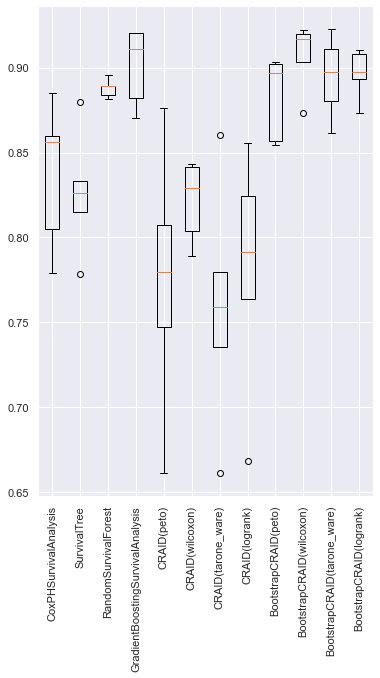

In [58]:
def name_crit(params):
    pars = params.split(',')
    ret = ""
    for p in pars:
        if p.find('criterion') != -1:
            ret = "(" + p.split()[2] + ")"
    return ret

df = pd.concat(results_forward)
df['Method']+=df['Param'].apply(name_crit)

fig, axs = plt.subplots(1, figsize=(6, 9))
plt.boxplot(df["CICENS"], labels = df['Method'])
plt.xticks(rotation=90)
plt.show()

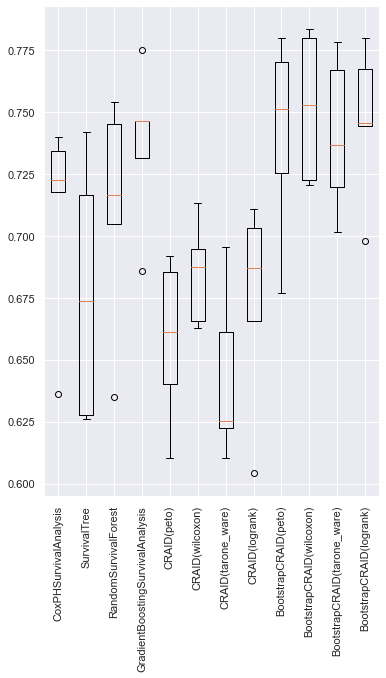

In [59]:
fig, axs = plt.subplots(1, figsize=(6, 9))
plt.boxplot(df["CI"], labels = df['Method'])
plt.xticks(rotation=90)
plt.show()

In [60]:
df_table = df.copy()
for c in ["CI", "CICENS", "IBS"]:
    df_table[c] = df_table[c].apply(lambda x: np.mean(x))
df_table.loc[:,["Method", "Param", "CICENS", "IBS"]]

Method  \
0             CoxPHSurvivalAnalysis   
0                      SurvivalTree   
0              RandomSurvivalForest   
0  GradientBoostingSurvivalAnalysis   
0                       CRAID(peto)   
0                   CRAID(wilcoxon)   
0                CRAID(tarone_ware)   
0                    CRAID(logrank)   
0              BootstrapCRAID(peto)   
0          BootstrapCRAID(wilcoxon)   
0       BootstrapCRAID(tarone_ware)   
0           BootstrapCRAID(logrank)   

                                               Param    CICENS       IBS  
0                  {'alpha': 128, 'ties': 'breslow'}  0.836980  0.168908  
0  {'max_depth': 20, 'max_features': 'sqrt', 'min...  0.826514  0.153649  
0  {'max_depth': 30, 'max_features': 'sqrt', 'min...  0.887906  0.132565  
0  {'learning_rate': 0.5, 'loss': 'coxph', 'max_d...  0.900793  0.134300  
0  {'bonf': True, 'categ': [], 'cens': 'cDeath', ...  0.774177  0.141273  
0  {'bonf': True, 'categ': [], 'cens': 'cDeath', ...  0.821287  0.140725  
0  {'bonf': True, 'categ': [], 'cens': 'cDeath', ...  0.759113  0.142174  
0  {'bonf': True, 'categ': [], 'cens': 'cDeath', ...  0.780837  0.164180  
0  {'categ': [], 'cens': 'cDeath', 'criterion': <...  0.882680  0.123121  
0  {'categ': [], 'cens': 'cDeath', 'criterion': <...  0.907023  0.127481  
0  {'categ': [], 'cens': 'cDeath', 'criterion': <...  0.894576  0.127451  
0  {'categ': [], 'cens': 'cDeath', 'criterion': <...  0.896406  0.126443

In [61]:
df_table = df.copy()
for c in ["CI", "CICENS", "IBS"]:
    df_table[c] = df_table[c].apply(lambda x: np.mean(x))
df_table.loc[:,["Method", "Param", "CI", "IBS"]]

Method  \
0             CoxPHSurvivalAnalysis   
0                      SurvivalTree   
0              RandomSurvivalForest   
0  GradientBoostingSurvivalAnalysis   
0                       CRAID(peto)   
0                   CRAID(wilcoxon)   
0                CRAID(tarone_ware)   
0                    CRAID(logrank)   
0              BootstrapCRAID(peto)   
0          BootstrapCRAID(wilcoxon)   
0       BootstrapCRAID(tarone_ware)   
0           BootstrapCRAID(logrank)   

                                               Param        CI       IBS  
0                  {'alpha': 128, 'ties': 'breslow'}  0.710127  0.168908  
0  {'max_depth': 20, 'max_features': 'sqrt', 'min...  0.677222  0.153649  
0  {'max_depth': 30, 'max_features': 'sqrt', 'min...  0.711154  0.132565  
0  {'learning_rate': 0.5, 'loss': 'coxph', 'max_d...  0.737022  0.134300  
0  {'bonf': True, 'categ': [], 'cens': 'cDeath', ...  0.657833  0.141273  
0  {'bonf': True, 'categ': [], 'cens': 'cDeath', ...  0.684735  0.140725  
0  {'bonf': True, 'categ': [], 'cens': 'cDeath', ...  0.642956  0.142174  
0  {'bonf': True, 'categ': [], 'cens': 'cDeath', ...  0.674180  0.164180  
0  {'categ': [], 'cens': 'cDeath', 'criterion': <...  0.740732  0.123121  
0  {'categ': [], 'cens': 'cDeath', 'criterion': <...  0.751825  0.127481  
0  {'categ': [], 'cens': 'cDeath', 'criterion': <...  0.740548  0.127451  
0  {'categ': [], 'cens': 'cDeath', 'criterion': <...  0.746929  0.126443

In [62]:
df.to_excel(dir_env + 'surv_res_covid.xlsx', index = False)

In [1]:
import sksurv.metrics
from survivors.tree import CRAID
import os
import random
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter
import survivors.constants as cnt
import survivors.metrics as metr
import survivors.datasets as ds
from survivors.experiments.grid import generate_sample

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
i = 0
for X_train, y_train, X_test, y_test, bins in generate_sample(X, y, 5):
    if i == 2:
        break
    i += 1

In [2]:
CRAID_param_grid_lr = {
    "depth":10,
    "criterion":"peto",
    "min_samples_leaf":5,
    "thres_cont_bin_max":100,
    "signif": 0.05,
    "cut":True,
    "max_features":1.0
}
craid_tree = CRAID(**CRAID_param_grid_lr)
craid_tree.fit(X_train, y_train)

In [28]:
pred_surv = craid_tree.predict_at_times(X_test, bins, mode = "surv")
pred_cens = craid_tree.predict(X_test, target = "cens")
pred_hazard = craid_tree.predict_at_times(X_test, bins, mode = "hazard")

In [4]:
import survivors.metrics as metr
metr.iauc(y_train, y_test, 1 - pred_surv, bins)

0.0

In [8]:
1 - pred_surv

array([[0.        , 0.        , 0.        , ..., 0.6003353 , 0.6003353 ,
        0.73355686],
       [0.        , 0.        , 0.        , ..., 0.37677855, 0.37677855,
        0.37677855],
       [0.00952381, 0.00952381, 0.00952381, ..., 0.88055994, 0.88055994,
        0.88055994],
       ...,
       [0.        , 0.        , 0.        , ..., 0.37677855, 0.37677855,
        0.37677855],
       [0.        , 0.        , 0.        , ..., 0.37677855, 0.37677855,
        0.37677855],
       [0.00952381, 0.00952381, 0.00952381, ..., 0.88055994, 0.88055994,
        0.88055994]])

In [24]:
def iauc(survival_train, survival_test, estimate, times, tied_tol=1e-8):
    if survival_train[cnt.CENS_NAME].sum() == 0:
        survival_train[cnt.CENS_NAME] = 1
        survival_test[cnt.CENS_NAME] = 1 - survival_test[cnt.CENS_NAME]
    if survival_test[cnt.CENS_NAME].sum() == 0:
        survival_test[cnt.CENS_NAME] = 1
    test_event, test_time = sksurv.metrics.check_y_survival(survival_test)
    #estimate, times = _check_estimate_2d(estimate, test_time, times)
    estimate = np.array(estimate)
    n_samples = estimate.shape[0]
    n_times = times.shape[0]
    if estimate.ndim == 1:
        estimate = np.broadcast_to(estimate[:, np.newaxis], (n_samples, n_times))

    # fit and transform IPCW
    cens = sksurv.metrics.CensoringDistributionEstimator()
    cens.fit(survival_train)
    Ghat = cens.predict_proba(test_time[test_event])
    ipcw = np.zeros(test_time.shape[0])
    if not((Ghat == 0.0).any()):
        ipcw[test_event] = 1.0 / Ghat
    else:
        ipcw = np.ones(test_time.shape[0])

    # expand arrays to (n_samples, n_times) shape
    test_time = np.broadcast_to(test_time[:, np.newaxis], (n_samples, n_times))
    test_event = np.broadcast_to(test_event[:, np.newaxis], (n_samples, n_times))
    times_2d = np.broadcast_to(times, (n_samples, n_times))
    ipcw = np.broadcast_to(ipcw[:, np.newaxis], (n_samples, n_times))

    # sort each time point (columns) by risk score (descending)
    o = np.argsort(-estimate, axis=0)
    test_time = np.take_along_axis(test_time, o, axis=0)
    test_event = np.take_along_axis(test_event, o, axis=0)
    estimate = np.take_along_axis(estimate, o, axis=0)
    ipcw = np.take_along_axis(ipcw, o, axis=0)

    is_case = (test_time <= times_2d) & test_event
    is_control = test_time > times_2d
    n_controls = is_control.sum(axis=0)

    # prepend row of infinity values
    estimate_diff = np.concatenate((np.broadcast_to(np.infty, (1, n_times)), estimate))
    is_tied = np.absolute(np.diff(estimate_diff, axis=0)) <= tied_tol

    cumsum_tp = np.cumsum(is_case * ipcw, axis=0)
    cumsum_fp = np.cumsum(is_control, axis=0)
    true_pos = cumsum_tp / cumsum_tp[-1]
    false_pos = cumsum_fp / n_controls

    scores = np.empty(n_times, dtype=float)
    #print(is_case, cumsum_tp, cumsum_tp[-1])
    it = np.nditer((true_pos, false_pos, is_tied), order="F", flags=["external_loop"])
    with it:
        for i, (tp, fp, mask) in enumerate(it):
            idx = np.flatnonzero(mask) - 1
            # only keep the last estimate for tied risk scores
            tp_no_ties = np.delete(tp, idx)
            fp_no_ties = np.delete(fp, idx)
            # Add an extra threshold position
            # to make sure that the curve starts at (0, 0)
            tp_no_ties = np.r_[0, tp_no_ties]
            fp_no_ties = np.r_[0, fp_no_ties]
            scores[i] = np.trapz(tp_no_ties, fp_no_ties)

    scores[np.isnan(scores)] = 0
    #print(scores)
    if n_times == 1:
        mean_auc = scores[0]
    else:
        surv = KaplanMeierFitter()
        surv.fit(survival_test[cnt.TIME_NAME], survival_test[cnt.CENS_NAME]) 
        s_times = surv.survival_function_at_times(times).to_numpy()
        
        # compute integral of AUC over survival function
        d = -np.diff(np.r_[1.0, s_times])
        integral = (scores * d).sum()
        mean_auc = integral / (1.0 - s_times[-1])
        # print(scores, s_times, integral, s_times[-1])

    return mean_auc

In [25]:
iauc(y_train, y_test, 1 - pred_surv, bins)

[0.71505054 0.39055313 0.93911347 0.55033567 0.61139776 0.84044841
 0.88548125 0.73560416 0.9454641  0.96147207 0.75574252 0.95169339
 0.82468887 0.55033567 0.93028429 0.81663828 0.17786841 0.79764627
 0.54341321 0.92116898 0.96147207 0.89277917 0.84815187 0.82468887
 0.96334995 0.90948427 0.95169339 0.93911347 0.30042548 0.97632058
 0.73560416 0.84561249 0.74715454 0.93028429 0.96334995 0.93028429
 0.94961998 0.73560416 0.95169339 0.82201997 0.92802632 0.84815187
 0.93911347 0.92116898 0.92116898 0.41607132 0.95169339 0.79764627
 0.94125268 0.08046428 0.9454641  0.93473019 0.91884866 0.20751315
 0.24735873 0.         0.93251519 0.95370543 0.92116898 0.93473019]
[[False False False ...  True  True  True]
 [False False False ... False False False]
 [False False False ...  True  True  True]
 ...
 [False False False ...  True  True  True]
 [False False False ... False False False]
 [False False False ...  True  True  True]] [[ 0.  0.  0. ...  1.  1.  1.]
 [ 0.  0.  0. ...  1.  1.  1.]
 [ 

0.5877382723964616

In [34]:
iauc(y_test, 1 - pred_surv, bins)

0.5946427359828396

In [35]:
iauc(y_test, pred_hazard, bins)

0.6299452972166365

In [29]:
pred_cens

245    0.477064
246    0.269231
247    0.654545
248    0.477064
249    0.477064
         ...   
424    0.269231
425    0.654545
426    0.269231
427    0.269231
428    0.654545
Name: res, Length: 137, dtype: float64

In [38]:
pred_surv[:, 1235]

array([0.52767802, 0.77075424, 0.33828338, 0.52767802, 0.52767802,
       0.33828338, 0.33828338, 0.52767802, 0.52767802, 0.33828338,
       0.52767802, 0.52767802, 0.77075424, 0.52767802, 0.77075424,
       0.77075424, 0.77075424, 0.33828338, 0.77075424, 0.77075424,
       0.33828338, 0.3956044 , 0.77075424, 0.33828338, 0.77075424,
       0.33828338, 0.77075424, 0.77075424, 0.33828338, 0.33828338,
       0.77075424, 0.52767802, 0.52767802, 0.33828338, 0.52767802,
       0.77075424, 0.77075424, 0.33828338, 0.33828338, 0.77075424,
       0.52767802, 0.77075424, 0.33828338, 0.77075424, 0.52767802,
       0.33828338, 0.52767802, 0.33828338, 0.77075424, 0.77075424,
       0.33828338, 0.52767802, 0.77075424, 0.3956044 , 0.52767802,
       0.52767802, 0.52767802, 0.77075424, 0.77075424, 0.77075424,
       0.33828338, 0.52767802, 0.77075424, 0.52767802, 0.52767802,
       0.33828338, 0.52767802, 0.52767802, 0.33828338, 0.77075424,
       0.33828338, 0.52767802, 0.33828338, 0.33828338, 0.77075

In [39]:
bins.argmean()

AttributeError: 'numpy.ndarray' object has no attribute 'argmean'

In [80]:
class A:
    __name__ = "1231231"
    def __init__(self):
        self.money = 10
        
    def fit(self):
        print("fit_A")
        self.money += 10
        print(self.money)
        
    def pred(self):
        self.fit()
        print("pred_A")
        
# class B(A):
#     def __init__(self):
#         self.money = 50
        
# #     def fit(self):
# #         print("fit_B")
# #         print(self.money)
        
#     def pred(self):
#         super().pred()
#         print("pred_B")

In [69]:
b = B()
b.pred()

fit_A
60
pred_A
pred_B


In [70]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
cph = CoxPHSurvivalAnalysis(alpha = 0.1, ties = "breslow")
cph.__str__

<method-wrapper '__str__' of CoxPHSurvivalAnalysis object at 0x00000189FC92C488>

In [ ]:
from survivors.tests.experiment import run
PBC_exp = run("PBC", with_self = ["BSTR", "BOOST"], #["TREE", "BSTR", "BOOST"], 
              with_external = False)

[0.573  0.5833 0.6081 0.6102 0.6119 0.6223 0.6261 0.6313 0.621  0.6162]
fitted: 8 models.
[0.6361 0.6341 0.6559 0.6607 0.6545 0.6637 0.6688 0.6776 0.682  0.6842]
fitted: 10 models.
[0.5959 0.6162 0.6164 0.6154 0.6224 0.632  0.6461 0.6451 0.6479 0.6546]
fitted: 10 models.
[0.6514 0.6411 0.6641 0.6749 0.6872 0.6927 0.7025 0.7032 0.7093 0.709 ]
fitted: 9 models.
[0.6292 0.6243 0.6432 0.6456 0.6572 0.6649 0.6707 0.667  0.6699 0.6776]
fitted: 10 models.
EXECUTION TIME OF BootstrapCRAID: 360.449547290802 {'CI': 0.6358648822341247, 'CI_CENS': 0.7758234599500156, 'IBS': 0.22837304770430816, 'IAUC': 0.7283741565235919}
[0.573  0.5833 0.6081 0.6102 0.6119 0.6223 0.6261 0.6313 0.621  0.6162
 0.6167 0.6132 0.6147 0.6185 0.621  0.6249 0.6251 0.6282 0.6339 0.6394
 0.6409 0.6462 0.6464 0.6439 0.6449 0.6486 0.6523 0.6533 0.6521 0.6532]
fitted: 28 models.
[0.6361 0.6341 0.6559 0.6607 0.6545 0.6637 0.6688 0.6776 0.682  0.6842
 0.6832 0.6772 0.6815 0.681  0.6814 0.6788 0.674  0.6766 0.6777 0.679
 0.6813 

EXECUTION TIME OF BootstrapCRAID: 148.75455927848816 {'CI': 0.6472734477012346, 'CI_CENS': 0.7713123008442243, 'IBS': 0.31588275022054557, 'IAUC': 0.7307984375476161}
[0.6433 0.6205 0.6149 0.6231 0.6216 0.6314 0.6397 0.641  0.6415 0.6382
 0.6406 0.643  0.6425 0.643  0.6466 0.6495 0.6506 0.6526 0.6543 0.6586
 0.6549 0.6557 0.6571 0.6567 0.6563 0.6536 0.6547 0.6575 0.6565 0.6568]
fitted: 20 models.
[0.6405 0.666  0.6665 0.6631 0.6593 0.6684 0.6786 0.6767 0.6834 0.6897
 0.684  0.6851 0.6895 0.6916 0.6915 0.6921 0.696  0.6953 0.6949 0.6963
 0.6959 0.6982 0.6965 0.6976 0.6963 0.6966 0.6953 0.6946 0.6931 0.6924]
fitted: 22 models.
[0.6273 0.6259 0.6408 0.6521 0.6592 0.6738 0.6771 0.6735 0.6794 0.6842
 0.6831 0.6835 0.6885 0.6911 0.6935 0.694  0.6927 0.692  0.6931 0.6928
 0.694  0.6943 0.694  0.6949 0.6956 0.6983 0.6985 0.6994 0.6987 0.6971]
fitted: 28 models.
[0.6541 0.6727 0.6718 0.6761 0.6765 0.6758 0.689  0.6927 0.6973 0.6988
 0.6974 0.6941 0.6981 0.6993 0.7002 0.7039 0.704  0.7043 0.7089

[0.1819 0.1634 0.146  0.1439 0.1412 0.1362 0.1355 0.1352 0.1339 0.1328
 0.1318 0.1336 0.1327 0.1344 0.1335 0.1318 0.1299 0.1293 0.1288 0.1271
 0.1265 0.1267 0.1261 0.1263 0.1268 0.1257 0.1257 0.1251 0.1254 0.1254]
fitted: 28 models.
[0.2046 0.2121 0.1769 0.1646 0.1624 0.1536 0.147  0.1438 0.143  0.1382
 0.1354 0.1346 0.1308 0.1309 0.1291 0.1292 0.1283 0.1269 0.125  0.1247
 0.1249 0.1248 0.1245 0.1241 0.1238 0.1235 0.1246 0.1243 0.1248 0.1247]
fitted: 26 models.
[0.1731 0.1793 0.1636 0.1506 0.1478 0.1386 0.1372 0.1348 0.1309 0.1277
 0.1286 0.1305 0.128  0.1268 0.1261 0.1251 0.1258 0.1258 0.1242 0.1237
 0.1226 0.1231 0.1235 0.1237 0.1238 0.1236 0.1234 0.1233 0.1229 0.1228]
fitted: 21 models.
[0.1636 0.1783 0.155  0.143  0.1397 0.1352 0.1309 0.1324 0.1298 0.1279
 0.127  0.127  0.1255 0.1251 0.1253 0.1248 0.1234 0.1232 0.122  0.1212
 0.1206 0.1211 0.1203 0.1197 0.1193 0.1186 0.1183 0.118  0.1176 0.1182]
fitted: 29 models.
EXECUTION TIME OF BootstrapCRAID: 369.187864780426 {'CI': 0.66400278

[0.6632 0.6787 0.7157 0.7324 0.7512 0.7711 0.7835 0.7791 0.7943 0.7905
 0.7937 0.793  0.795  0.7933 0.7991 0.8019 0.8018 0.8027 0.8037 0.8026
 0.8074 0.8091 0.8097 0.8088 0.8084 0.8108 0.8124 0.8111 0.8103 0.8107]
fitted: 27 models.
[0.6542 0.7032 0.7123 0.7174 0.753  0.7817 0.7982 0.8063 0.8115 0.8186
 0.8176 0.8181 0.817  0.8176 0.8182 0.8145 0.8146 0.8193 0.8188 0.8229
 0.8236 0.8274 0.8281 0.8297 0.827  0.8316 0.8326 0.8307 0.8307 0.8294]
fitted: 27 models.
EXECUTION TIME OF BootstrapCRAID: 1081.9759781360626 {'CI': 0.6476995873201612, 'CI_CENS': 0.7985613807329969, 'IBS': 0.19767406762645162, 'IAUC': 0.7678424713462906}
[0.739  0.7474 0.7142 0.7259 0.726  0.7401 0.7526 0.7562 0.7623 0.7623]
fitted: 9 models.
[0.6768 0.6997 0.7361 0.7415 0.7408 0.7532 0.7699 0.7769 0.778  0.7792]
fitted: 10 models.
[0.7195 0.7099 0.7081 0.7505 0.75   0.7668 0.7711 0.7823 0.7921 0.7969]
fitted: 10 models.
[0.6758 0.7174 0.7467 0.7322 0.7257 0.7297 0.7455 0.7463 0.7578 0.7601]
fitted: 10 models.
[0.7

EXECUTION TIME OF BootstrapCRAID: 457.9178729057312 {'CI': 0.6552746088983703, 'CI_CENS': 0.8032772909686317, 'IBS': 0.20895170201276225, 'IAUC': 0.7632920352485902}
[0.7549 0.7744 0.7446 0.7554 0.7412 0.7713 0.7708 0.7798 0.7925 0.7878]
fitted: 9 models.
[0.6926 0.7249 0.7241 0.7396 0.7513 0.7609 0.7753 0.7794 0.7884 0.7915]
fitted: 10 models.
[0.731  0.7549 0.7732 0.7931 0.7785 0.7843 0.7872 0.7951 0.7944 0.8017]
fitted: 10 models.
[0.6986 0.7663 0.7663 0.7588 0.7795 0.7972 0.8076 0.8075 0.8167 0.8191]
fitted: 10 models.
[0.6927 0.7527 0.7795 0.7694 0.7878 0.7926 0.8042 0.804  0.8072 0.8147]
fitted: 10 models.
EXECUTION TIME OF BootstrapCRAID: 98.09598731994629 {'CI': 0.6566459606710986, 'CI_CENS': 0.8071989854710646, 'IBS': 0.22017290344357615, 'IAUC': 0.782994034444879}
[0.7549 0.7744 0.7446 0.7554 0.7412 0.7713 0.7708 0.7798 0.7925 0.7878
 0.8007 0.8052 0.8105 0.8104 0.8149 0.815  0.8162 0.8199 0.8265 0.824
 0.8266 0.8277 0.8286 0.8278 0.8288 0.8297 0.8288 0.828  0.828  0.8271]
fi

[0.6326 0.6504 0.6489 0.6584 0.6699 0.6758 0.6846 0.6963 0.7067 0.7125]
fitted: 10 models.
[0.6059 0.6078 0.6276 0.6299 0.631  0.6411 0.6416 0.6469 0.6493 0.6613]
fitted: 10 models.
EXECUTION TIME OF BootstrapCRAID: 346.3179090023041 {'CI': 0.62216275137082, 'CI_CENS': 0.7673216081984544, 'IBS': 0.23810389103227445, 'IAUC': 0.7378389649418114}
[0.5814 0.6114 0.6213 0.6242 0.6235 0.6211 0.6202 0.6214 0.6271 0.6264
 0.6273 0.6256 0.6253 0.6328 0.6376 0.6414 0.6438 0.6394 0.6458 0.6467
 0.6443 0.6446 0.6469 0.6481 0.6487 0.6496 0.6505 0.6509 0.6521 0.6539]
fitted: 30 models.
[0.6028 0.6389 0.6334 0.6417 0.6381 0.6544 0.6625 0.6603 0.662  0.6626
 0.6652 0.6652 0.6658 0.6671 0.6688 0.6718 0.6698 0.6712 0.6739 0.6744
 0.6731 0.6756 0.674  0.6743 0.6732 0.6775 0.6795 0.6797 0.6789 0.679 ]
fitted: 28 models.
[0.6144 0.6112 0.628  0.6307 0.6383 0.642  0.65   0.6573 0.662  0.6675
 0.6688 0.6766 0.6774 0.6796 0.685  0.6842 0.6835 0.6865 0.6902 0.6904
 0.6905 0.6947 0.6945 0.6935 0.6941 0.6955 0.6

[0.2283 0.2039 0.1819 0.1715 0.1629 0.1587 0.1477 0.1442 0.1429 0.1447
 0.1446 0.1448 0.1421 0.1416 0.1393 0.1376 0.1368 0.1357 0.1337 0.1318
 0.1313 0.1306 0.129  0.129  0.1287 0.1276 0.1272 0.1268 0.1275 0.1273]
fitted: 28 models.
[0.1997 0.2086 0.1878 0.1681 0.1646 0.1589 0.1534 0.1493 0.1428 0.1392
 0.1399 0.1391 0.1372 0.1369 0.1351 0.1345 0.1329 0.1334 0.1323 0.1319
 0.1321 0.1313 0.1304 0.1303 0.1298 0.1281 0.1274 0.1276 0.127  0.1267]
fitted: 30 models.
[0.1999 0.1954 0.189  0.1722 0.1596 0.1568 0.1484 0.1493 0.1485 0.1436
 0.1415 0.1405 0.1385 0.1374 0.1378 0.1366 0.1375 0.1361 0.1348 0.1339
 0.1338 0.1336 0.1339 0.1342 0.1335 0.1321 0.1318 0.1307 0.1311 0.1299]
fitted: 30 models.
[0.1636 0.1664 0.1641 0.1546 0.1609 0.1478 0.1429 0.1425 0.1389 0.1346
 0.1344 0.1327 0.1309 0.1294 0.1265 0.1254 0.1248 0.1243 0.1229 0.1224
 0.1224 0.1226 0.1229 0.1218 0.1214 0.1202 0.1203 0.1206 0.1195 0.1196]
fitted: 29 models.
EXECUTION TIME OF BootstrapCRAID: 602.5815870761871 {'CI': 0.6628099

[0.2012 0.1953 0.182  0.1739 0.1579 0.1485 0.1446 0.1406 0.1364 0.1341
 0.1346 0.1364 0.132  0.132  0.1315 0.131  0.1315 0.1313 0.1295 0.1296
 0.1302 0.1295 0.1306 0.1301 0.1315 0.1322 0.1317 0.1318 0.1314 0.1315]
fitted: 19 models.
[0.186  0.1844 0.1613 0.1512 0.1459 0.1382 0.1338 0.1332 0.1295 0.1267
 0.1256 0.1272 0.1266 0.1268 0.1253 0.1258 0.1248 0.1245 0.1235 0.1234
 0.1246 0.1243 0.1242 0.124  0.1232 0.1222 0.1214 0.1207 0.12   0.12  ]
fitted: 29 models.
EXECUTION TIME OF BootstrapCRAID: 351.6462149620056 {'CI': 0.6638367056494302, 'CI_CENS': 0.8132153226203978, 'IBS': 0.2029924058213904, 'IAUC': 0.7768185805972287}
[0.7277 0.7242 0.7131 0.7353 0.722  0.7507 0.7726 0.7735 0.7679 0.7716]
fitted: 8 models.
[0.652  0.7065 0.7035 0.722  0.7359 0.7609 0.7689 0.7805 0.7825 0.7762]
fitted: 9 models.
[0.6951 0.7079 0.7404 0.7706 0.7665 0.7711 0.7839 0.7853 0.7917 0.8006]
fitted: 10 models.
[0.5928 0.6416 0.6895 0.7395 0.7623 0.7682 0.7784 0.7762 0.793  0.7965]
fitted: 10 models.
[0.6501

EXECUTION TIME OF BootstrapCRAID: 983.8502378463745 {'CI': 0.6465748419908465, 'CI_CENS': 0.7978365457832624, 'IBS': 0.2048094537694715, 'IAUC': 0.7634722226342153}
[0.7576 0.7776 0.7531 0.75   0.7529 0.7613 0.7673 0.777  0.7783 0.7948]
fitted: 10 models.
[0.6798 0.7127 0.6991 0.7097 0.7135 0.7246 0.7416 0.7461 0.7622 0.7692]
fitted: 10 models.
[0.7222 0.7118 0.7755 0.7919 0.7799 0.7845 0.79   0.7986 0.8013 0.8026]
fitted: 10 models.
[0.6869 0.7319 0.747  0.7356 0.7386 0.7354 0.748  0.7479 0.7548 0.7603]
fitted: 10 models.
[0.6991 0.7354 0.7725 0.7643 0.766  0.7854 0.7991 0.7964 0.7995 0.8077]
fitted: 10 models.
EXECUTION TIME OF BootstrapCRAID: 157.48160648345947 {'CI': 0.6570382383926965, 'CI_CENS': 0.7994951566427315, 'IBS': 0.21582977484499258, 'IAUC': 0.7479018538273385}
[0.7576 0.7776 0.7531 0.75   0.7529 0.7613 0.7673 0.777  0.7783 0.7948
 0.803  0.8047 0.8167 0.8156 0.8177 0.818  0.8169 0.8175 0.8175 0.8123
 0.8127 0.8134 0.8168 0.8171 0.8164 0.8166 0.8163 0.8149 0.8131 0.8122]

[0.6371 0.654  0.65   0.66   0.6603 0.6751 0.6866 0.6929 0.6973 0.7039]
fitted: 10 models.
[0.6554 0.6271 0.6522 0.6517 0.6618 0.6704 0.676  0.6758 0.6818 0.6848]
fitted: 10 models.
EXECUTION TIME OF BootstrapCRAID: 108.57336902618408 {'CI': 0.6558401425444019, 'CI_CENS': 0.8020785429498621, 'IBS': 0.20656561141820765, 'IAUC': 0.7833272164486715}
[0.611  0.6148 0.6092 0.6258 0.6242 0.6327 0.6411 0.6438 0.6438 0.6467
 0.6468 0.6418 0.6451 0.6449 0.6434 0.6467 0.6464 0.6488 0.6479 0.6487
 0.6502 0.6522 0.6545 0.6538 0.6572 0.6572 0.6572 0.6568 0.6548 0.6554]
fitted: 25 models.
[0.5987 0.6251 0.6616 0.6637 0.6683 0.6606 0.6691 0.6725 0.674  0.6768
 0.6756 0.6718 0.676  0.6764 0.6792 0.6818 0.6841 0.6823 0.6823 0.6832
 0.6835 0.6841 0.6867 0.6885 0.6909 0.6939 0.6948 0.6948 0.6948 0.6932]
fitted: 27 models.
[0.6357 0.6396 0.6582 0.6594 0.6567 0.6566 0.6712 0.6688 0.672  0.6749
 0.6781 0.6826 0.6858 0.6837 0.6835 0.6831 0.6838 0.6855 0.6886 0.6917
 0.6919 0.6918 0.6896 0.6914 0.6918 0.6941 

[0.2649 0.2497 0.2178 0.1951 0.193  0.1722 0.1575 0.1509 0.1502 0.1493
 0.1496 0.1471 0.1432 0.1443 0.1437 0.1408 0.1414 0.142  0.1415 0.1396
 0.1362 0.1358 0.1338 0.1335 0.1338 0.1326 0.1327 0.1333 0.1357 0.1349]
fitted: 26 models.
[0.2589 0.2336 0.2071 0.1901 0.1784 0.1718 0.1618 0.1603 0.1607 0.154
 0.1473 0.1436 0.1437 0.1425 0.1392 0.1386 0.1391 0.1382 0.136  0.1365
 0.1361 0.1353 0.1354 0.1357 0.1367 0.136  0.1367 0.1363 0.1365 0.1348]
fitted: 30 models.
[0.2454 0.2531 0.2127 0.1836 0.1687 0.1585 0.1638 0.1581 0.1509 0.1505
 0.1479 0.1471 0.1418 0.14   0.1408 0.1396 0.1401 0.1414 0.1406 0.1402
 0.1413 0.1401 0.1398 0.1387 0.1384 0.137  0.1369 0.1368 0.1365 0.1361]
fitted: 30 models.
[0.2085 0.2301 0.2102 0.1888 0.1767 0.1636 0.1495 0.1499 0.1389 0.1371
 0.1368 0.1327 0.1305 0.1264 0.127  0.1265 0.1255 0.1255 0.1245 0.1225
 0.1235 0.1246 0.1243 0.1246 0.1251 0.1249 0.125  0.1261 0.1268 0.1271]
fitted: 20 models.
EXECUTION TIME OF BootstrapCRAID: 1249.932728767395 {'CI': 0.65820670

[0.1988 0.2038 0.1906 0.1814 0.1653 0.1582 0.1554 0.1541 0.1516 0.1505
 0.1478 0.1482 0.1439 0.1422 0.1412 0.1398 0.1405 0.1402 0.1388 0.1397
 0.1387 0.1395 0.1382 0.1383 0.1385 0.1378 0.1383 0.1373 0.1382 0.137 ]
fitted: 30 models.
[0.2203 0.1958 0.1709 0.159  0.1605 0.1481 0.1433 0.1418 0.1386 0.1377
 0.1376 0.1341 0.1336 0.1329 0.1298 0.1292 0.1277 0.128  0.1258 0.1255
 0.1264 0.1261 0.1254 0.1257 0.1252 0.1247 0.1237 0.1234 0.1229 0.1207]
fitted: 30 models.
EXECUTION TIME OF BootstrapCRAID: 563.3878335952759 {'CI': 0.6499839483772715, 'CI_CENS': 0.8049670199966549, 'IBS': 0.2158621433524342, 'IAUC': 0.7608824380182811}
[0.2088 0.1916 0.1911 0.1751 0.1775 0.1731 0.1703 0.1658 0.1607 0.1589]
fitted: 10 models.
[0.1492 0.1703 0.172  0.1622 0.1565 0.1571 0.1531 0.1525 0.1472 0.1467]
fitted: 10 models.
[0.1807 0.1858 0.1635 0.1602 0.161  0.1533 0.148  0.1459 0.143  0.1408]
fitted: 10 models.
[0.1935 0.1918 0.1738 0.1704 0.166  0.1544 0.1492 0.1465 0.1409 0.1394]
fitted: 10 models.
[0.17

EXECUTION TIME OF BootstrapCRAID: 285.15973830223083 {'CI': 0.6539804489921777, 'CI_CENS': 0.8071916341139896, 'IBS': 0.23514233244346056, 'IAUC': 0.7764167121884331}
[0.7047 0.6896 0.7045 0.7472 0.7491 0.7621 0.782  0.7782 0.7799 0.7888]
fitted: 10 models.
[0.6224 0.6996 0.6817 0.6933 0.715  0.7253 0.7464 0.7549 0.7699 0.7759]
fitted: 10 models.
[0.6972 0.7488 0.7795 0.7946 0.7907 0.7898 0.8066 0.8084 0.8077 0.8073]
fitted: 8 models.
[0.6502 0.683  0.7057 0.7202 0.7224 0.7239 0.7385 0.7444 0.751  0.7533]
fitted: 10 models.
[0.7187 0.7405 0.7551 0.7303 0.7296 0.7404 0.7652 0.7698 0.778  0.7854]
fitted: 10 models.
EXECUTION TIME OF BootstrapCRAID: 350.2807831764221 {'CI': 0.6481689342660957, 'CI_CENS': 0.7872758379080104, 'IBS': 0.2096615793366164, 'IAUC': 0.7390700929544302}
[0.7047 0.6896 0.7045 0.7472 0.7491 0.7621 0.782  0.7782 0.7799 0.7888
 0.7956 0.7956 0.8018 0.8005 0.795  0.7959 0.8002 0.8049 0.8053 0.8033
 0.8085 0.8072 0.8104 0.8114 0.8092 0.8119 0.8111 0.8122 0.8121 0.8158]


[0.6742 0.6751 0.6743 0.6811 0.6773 0.684  0.6975 0.6979 0.6978 0.7   ]
fitted: 10 models.
[0.6648 0.6584 0.6682 0.6754 0.6724 0.6704 0.6806 0.6782 0.6826 0.6844]
fitted: 10 models.
EXECUTION TIME OF BootstrapCRAID: 164.93094563484192 {'CI': 0.6595260824473801, 'CI_CENS': 0.802606513850319, 'IBS': 0.19350138388756882, 'IAUC': 0.7863783859446002}
[0.6135 0.6119 0.5922 0.6152 0.6048 0.6125 0.6138 0.6194 0.6271 0.6285
 0.6318 0.63   0.6304 0.6302 0.6321 0.6311 0.6332 0.6351 0.6372 0.6398
 0.6425 0.6455 0.647  0.646  0.6452 0.6451 0.6461 0.6455 0.6482 0.6467]
fitted: 29 models.
[0.6372 0.6631 0.6673 0.6655 0.664  0.6622 0.6747 0.6803 0.6855 0.6892
 0.6856 0.6835 0.6869 0.6867 0.6902 0.6909 0.6931 0.6959 0.6979 0.6991
 0.6978 0.6987 0.7011 0.7012 0.7014 0.7017 0.7019 0.7016 0.7    0.6981]
fitted: 27 models.
[0.5904 0.6175 0.6267 0.6249 0.6365 0.6405 0.6548 0.6559 0.6591 0.6661
 0.6667 0.6681 0.6719 0.6725 0.6746 0.676  0.6774 0.6801 0.6809 0.6816
 0.6809 0.6812 0.6847 0.6859 0.6866 0.6875 0

[0.5605 0.5864 0.6027 0.6255 0.6233 0.6307 0.6408 0.656  0.6618 0.6696
 0.6667 0.6637 0.6637 0.6675 0.6703 0.6739 0.6777 0.6781 0.6799 0.6788
 0.6794 0.68   0.6811 0.6831 0.6822 0.6828 0.6834 0.6831 0.6812 0.6812]
fitted: 27 models.
[0.5927 0.6048 0.6363 0.6337 0.64   0.655  0.6695 0.6721 0.6758 0.6802
 0.6768 0.6773 0.6798 0.6849 0.6863 0.6868 0.6894 0.6902 0.6896 0.6935
 0.6931 0.6944 0.6948 0.698  0.6983 0.6982 0.6974 0.6965 0.6966 0.6964]
fitted: 25 models.
[0.6869 0.6721 0.6736 0.6854 0.6954 0.7037 0.7102 0.7097 0.7093 0.7077
 0.707  0.7048 0.7093 0.7082 0.7098 0.7129 0.7121 0.7129 0.7153 0.7166
 0.7188 0.72   0.721  0.7235 0.7231 0.723  0.7221 0.7212 0.7208 0.721 ]
fitted: 24 models.
[0.6506 0.6565 0.6718 0.6773 0.6945 0.6937 0.6932 0.686  0.6853 0.6886
 0.6883 0.6819 0.6822 0.6823 0.6841 0.6853 0.6861 0.6868 0.6891 0.6888
 0.6867 0.6869 0.6903 0.6909 0.6909 0.6913 0.6902 0.6911 0.6925 0.6929]
fitted: 5 models.
EXECUTION TIME OF BootstrapCRAID: 268.83156061172485 {'CI': 0.6577432

[0.2173 0.2317 0.198  0.1786 0.1754 0.17   0.1621 0.1599 0.1502 0.1402
 0.1391 0.1384 0.1382 0.1399 0.1364 0.1379 0.1377 0.1378 0.1355 0.1349
 0.1353 0.1347 0.1351 0.1355 0.1361 0.1367 0.1369 0.136  0.1359 0.1337]
fitted: 30 models.
[0.2397 0.2229 0.1931 0.185  0.1845 0.1758 0.1635 0.1597 0.156  0.1483
 0.1469 0.1433 0.1407 0.1387 0.1358 0.1354 0.1333 0.1316 0.1296 0.1285
 0.128  0.1266 0.126  0.1248 0.1237 0.1235 0.1227 0.1223 0.1214 0.1217]
fitted: 29 models.
EXECUTION TIME OF BootstrapCRAID: 1179.915559053421 {'CI': 0.6453619505512692, 'CI_CENS': 0.7909244794714946, 'IBS': 0.19527268758905977, 'IAUC': 0.7660742297331904}
[0.2194 0.2039 0.2042 0.1808 0.1794 0.1774 0.1654 0.1596 0.1554 0.1568]
fitted: 9 models.
[0.2335 0.2116 0.2017 0.1795 0.1715 0.1633 0.1534 0.1519 0.145  0.1402]
fitted: 10 models.
[0.2396 0.1992 0.1774 0.1678 0.1698 0.1625 0.1629 0.1629 0.157  0.1539]
fitted: 10 models.
[0.196  0.195  0.1713 0.1639 0.1583 0.1514 0.1464 0.1479 0.1435 0.1428]
fitted: 10 models.
[0.17

EXECUTION TIME OF BootstrapCRAID: 472.65614795684814 {'CI': 0.6622799314615786, 'CI_CENS': 0.8127996992477549, 'IBS': 0.1873739376741039, 'IAUC': 0.7844656511358359}
[0.7788 0.766  0.752  0.7655 0.7605 0.7744 0.7875 0.7915 0.7926 0.7987]
fitted: 10 models.
[0.6793 0.7297 0.7437 0.7467 0.7461 0.7548 0.773  0.7772 0.7841 0.7904]
fitted: 10 models.
[0.6759 0.7401 0.7631 0.7885 0.782  0.7913 0.7943 0.8006 0.8057 0.81  ]
fitted: 10 models.
[0.6795 0.74   0.7783 0.7712 0.7841 0.7781 0.7826 0.7798 0.7893 0.7904]
fitted: 10 models.
[0.7614 0.7886 0.8016 0.8009 0.8166 0.8233 0.8225 0.8154 0.8119 0.8134]
fitted: 6 models.
EXECUTION TIME OF BootstrapCRAID: 109.41124391555786 {'CI': 0.6581313585810749, 'CI_CENS': 0.8140324287739373, 'IBS': 0.21416224678093337, 'IAUC': 0.7944439612991223}
[0.7788 0.766  0.752  0.7655 0.7605 0.7744 0.7875 0.7915 0.7926 0.7987
 0.8064 0.8073 0.8095 0.8089 0.8083 0.8079 0.8109 0.8099 0.8122 0.8163
 0.8186 0.8195 0.8192 0.8163 0.8195 0.8184 0.8186 0.8158 0.8171 0.8167]

[0.6269 0.6408 0.6509 0.6576 0.6741 0.677  0.6991 0.6991 0.7008 0.7057]
fitted: 10 models.
[0.611  0.6071 0.6405 0.6377 0.6517 0.6473 0.6434 0.6411 0.6513 0.6534]
fitted: 10 models.
EXECUTION TIME OF BoostingCRAID: 309.3044738769531 {'CI': 0.6437059894406485, 'CI_CENS': 0.7821297730808991, 'IBS': 0.21393338308260237, 'IAUC': 0.7503187087696398}
[0.4859 0.5538 0.5746 0.5894 0.6012 0.6067 0.6173 0.6066 0.6193 0.6202]
fitted: 10 models.
[0.6181 0.6164 0.6004 0.6212 0.627  0.6341 0.6366 0.6418 0.6516 0.6572]
fitted: 10 models.
[0.6175 0.6175 0.6476 0.6589 0.6618 0.6505 0.6457 0.6468 0.6417 0.6539]
fitted: 5 models.
[0.6698 0.6624 0.6576 0.6701 0.6719 0.6693 0.6698 0.6722 0.6817 0.6851]
fitted: 10 models.
[0.607  0.643  0.6478 0.6487 0.6569 0.6625 0.6709 0.6738 0.6798 0.678 ]
fitted: 9 models.
EXECUTION TIME OF BoostingCRAID: 369.21184062957764 {'CI': 0.6295350633657577, 'CI_CENS': 0.7763882313758297, 'IBS': 0.2422179737245247, 'IAUC': 0.7300999436977534}
[0.5738 0.6257 0.6105 0.6279 0.6187

D:\CRAID_TREE\SurvivalTree\survivors\tree\decision_tree.py:162: ConvergenceWarning: Optimization did not converge: Maximum number of iterations has been exceeded.
  self.coxph.fit(ohenc_node, y)


[0.6169 0.6371 0.6316 0.6277 0.632  0.6584 0.6601 0.6566 0.6593 0.6593
 0.6625 0.6601 0.6618 0.6653 0.6686]
fitted: 15 models.
[0.6494 0.6389 0.6618 0.661  0.665  0.6588 0.6745 0.6673 0.669  0.6677
 0.6712 0.6686 0.6691 0.6735 0.6703]
fitted: 7 models.
[0.671  0.6703 0.6633 0.6589 0.6666 0.6785 0.6799 0.6874 0.6932 0.6943
 0.7    0.7094 0.7092 0.7057 0.7013]
fitted: 12 models.
[0.6585 0.6554 0.6566 0.6633 0.6584 0.6662 0.6716 0.6663 0.663  0.6644
 0.6691 0.6727 0.6754 0.6746 0.676 ]
fitted: 15 models.
EXECUTION TIME OF BoostingCRAID: 286.8925702571869 {'CI': 0.6335528451485977, 'CI_CENS': 0.764180108448215, 'IBS': 0.2239126653518629, 'IAUC': 0.7133760956676162}
[0.5991 0.6036 0.617  0.6291 0.6359 0.6355 0.6386 0.6381 0.6374 0.6422
 0.6384 0.6397 0.639  0.6408 0.642  0.6456 0.6478 0.6444 0.645  0.6441
 0.6473 0.6504 0.653  0.6541 0.6524]
fitted: 24 models.
[0.6349 0.6143 0.6495 0.65   0.6566 0.6666 0.6752 0.6802 0.6768 0.6741
 0.6792 0.6821 0.6835 0.6847 0.6847 0.6858 0.6787 0.6805 0.68

D:\CRAID_TREE\SurvivalTree\survivors\tree\decision_tree.py:162: ConvergenceWarning: Optimization did not converge: Maximum number of iterations has been exceeded.
  self.coxph.fit(ohenc_node, y)


[0.6169 0.6371 0.6316 0.6277 0.632  0.6584 0.6601 0.6566 0.6593 0.6593
 0.6625 0.6601 0.6618 0.6653 0.6686 0.6723 0.6808 0.6821 0.6821 0.6853
 0.6848 0.6844 0.6861 0.6875 0.6869]
fitted: 24 models.
[0.6494 0.6389 0.6618 0.661  0.665  0.6588 0.6745 0.6673 0.669  0.6677
 0.6712 0.6686 0.6691 0.6735 0.6703 0.6732 0.6775 0.6832 0.685  0.6833
 0.6861 0.687  0.6871 0.6875 0.6865]
fitted: 24 models.
[0.671  0.6703 0.6633 0.6589 0.6666 0.6785 0.6799 0.6874 0.6932 0.6943
 0.7    0.7094 0.7092 0.7057 0.7013 0.7003 0.7005 0.7067 0.707  0.7061
 0.7075 0.7092 0.7105 0.7129 0.7143]
fitted: 25 models.
[0.6585 0.6554 0.6566 0.6633 0.6584 0.6662 0.6716 0.6663 0.663  0.6644
 0.6691 0.6727 0.6754 0.6746 0.676  0.6787 0.6789 0.6796 0.6805 0.6787
 0.6796 0.6821 0.6826 0.6827 0.683 ]
fitted: 25 models.
EXECUTION TIME OF BoostingCRAID: 487.7294292449951 {'CI': 0.6463022447354574, 'CI_CENS': 0.788573152298819, 'IBS': 0.21944658813927945, 'IAUC': 0.7286997208167623}
[0.6259 0.633  0.6336 0.6415 0.6261 0.6266 0

[0.2295 0.2668 0.2331 0.2034 0.1952 0.182  0.1705 0.1667 0.1574 0.1582
 0.1596 0.1541 0.1526 0.1506 0.1494]
fitted: 15 models.
[0.2385 0.2682 0.1873 0.1742 0.1668 0.1648 0.1601 0.1529 0.1529 0.1504
 0.1471 0.1452 0.1464 0.1452 0.1443]
fitted: 15 models.
[0.2293 0.2507 0.2161 0.1917 0.1759 0.1735 0.1672 0.1623 0.161  0.1566
 0.1523 0.1495 0.1456 0.1434 0.14  ]
fitted: 15 models.
[0.2503 0.2142 0.1831 0.1691 0.1565 0.145  0.1387 0.1392 0.1316 0.1317
 0.1291 0.1266 0.1279 0.1266 0.1279]
fitted: 12 models.
EXECUTION TIME OF BoostingCRAID: 660.6165633201599 {'CI': 0.6350773397356112, 'CI_CENS': 0.7840280018084573, 'IBS': 0.2257128406668428, 'IAUC': 0.7368722732301538}
[0.2519 0.2215 0.2207 0.2079 0.1941 0.1939 0.1892 0.1888 0.1858 0.1858
 0.1804 0.1818 0.18   0.1772 0.1766 0.1743 0.1736 0.1692 0.1649 0.1648
 0.1639 0.1628 0.1614 0.1622 0.1623]
fitted: 23 models.
[0.2439 0.2186 0.184  0.1773 0.1701 0.1621 0.158  0.1555 0.1524 0.1501
 0.1514 0.1486 0.149  0.1455 0.1427 0.1432 0.144  0.1426 0.

D:\CRAID_TREE\SurvivalTree\survivors\tree\decision_tree.py:162: ConvergenceWarning: Optimization did not converge: Maximum number of iterations has been exceeded.
  self.coxph.fit(ohenc_node, y)


[0.193  0.1929 0.1751 0.172  0.1638 0.1524 0.1503 0.1499 0.1466 0.1447
 0.145  0.1428 0.1451 0.1438 0.1421]
fitted: 15 models.
[0.18   0.2005 0.1737 0.163  0.1586 0.1541 0.1494 0.1501 0.1504 0.1492
 0.146  0.1476 0.1452 0.1431 0.1434]
fitted: 14 models.
[0.2    0.1975 0.1867 0.1791 0.1726 0.1617 0.1552 0.1503 0.148  0.1467
 0.1443 0.1392 0.1376 0.1385 0.1398]
fitted: 13 models.
[0.1737 0.1719 0.1612 0.1438 0.1395 0.1338 0.1303 0.1292 0.1299 0.1269
 0.1249 0.1238 0.1225 0.1233 0.1227]
fitted: 13 models.
EXECUTION TIME OF BoostingCRAID: 344.56524443626404 {'CI': 0.648132332994211, 'CI_CENS': 0.7841236676815029, 'IBS': 0.21725238334210467, 'IAUC': 0.7265346146579008}
[0.2362 0.2248 0.2045 0.1904 0.1826 0.1788 0.1694 0.1626 0.1627 0.1623
 0.1582 0.1585 0.1587 0.1574 0.1565 0.1574 0.1576 0.1577 0.1559 0.1556
 0.1546 0.1539 0.1507 0.1493 0.1488]
fitted: 25 models.
[0.2092 0.1975 0.1672 0.1655 0.1533 0.1516 0.1452 0.1439 0.1437 0.1471
 0.1441 0.1416 0.1414 0.1412 0.1406 0.1405 0.1417 0.1412 0

D:\CRAID_TREE\SurvivalTree\survivors\tree\decision_tree.py:162: ConvergenceWarning: Optimization did not converge: Maximum number of iterations has been exceeded.
  self.coxph.fit(ohenc_node, y)


[0.193  0.1929 0.1751 0.172  0.1638 0.1524 0.1503 0.1499 0.1466 0.1447
 0.145  0.1428 0.1451 0.1438 0.1421 0.1403 0.1384 0.138  0.1382 0.1374
 0.1369 0.1368 0.1366 0.1363 0.1358]
fitted: 25 models.
[0.18   0.2005 0.1737 0.163  0.1586 0.1541 0.1494 0.1501 0.1504 0.1492
 0.146  0.1476 0.1452 0.1431 0.1434 0.1414 0.1394 0.1382 0.1382 0.1376
 0.1346 0.1339 0.1337 0.134  0.1336]
fitted: 25 models.
[0.2    0.1975 0.1867 0.1791 0.1726 0.1617 0.1552 0.1503 0.148  0.1467
 0.1443 0.1392 0.1376 0.1385 0.1398 0.1384 0.139  0.1386 0.14   0.138
 0.1377 0.1363 0.136  0.1353 0.1352]
fitted: 25 models.
[0.1737 0.1719 0.1612 0.1438 0.1395 0.1338 0.1303 0.1292 0.1299 0.1269
 0.1249 0.1238 0.1225 0.1233 0.1227 0.1219 0.1215 0.122  0.1217 0.1223
 0.1225 0.1218 0.121  0.1228 0.1226]
fitted: 23 models.
EXECUTION TIME OF BoostingCRAID: 597.8262813091278 {'CI': 0.6512063482546078, 'CI_CENS': 0.7970176867793182, 'IBS': 0.20887346651194622, 'IAUC': 0.7348638399919813}
[0.1849 0.1695 0.1729 0.165  0.1656 0.1646 0

[0.6154 0.6133 0.6505 0.6764 0.6835 0.68   0.6778 0.6791 0.6771 0.6769
 0.675  0.6775 0.6781 0.6788 0.6778]
fitted: 5 models.
[0.631  0.6155 0.6276 0.6395 0.6472 0.6535 0.6587 0.6586 0.6628 0.6652
 0.6699 0.6738 0.6766 0.6822 0.6831]
fitted: 15 models.
[0.6635 0.6505 0.6241 0.6533 0.6781 0.679  0.6911 0.6972 0.7024 0.7039
 0.7074 0.7049 0.7082 0.7138 0.7165]
fitted: 15 models.
[0.6115 0.5924 0.6113 0.6269 0.6339 0.642  0.6444 0.6518 0.6473 0.6547
 0.663  0.663  0.6609 0.6657 0.6649]
fitted: 14 models.
EXECUTION TIME OF BoostingCRAID: 553.935252904892 {'CI': 0.6458029802661839, 'CI_CENS': 0.7905469666120719, 'IBS': 0.21285853472645372, 'IAUC': 0.7366229947824285}
[0.5922 0.5973 0.5896 0.6058 0.6016 0.5954 0.6129 0.6264 0.6283 0.6296
 0.6257 0.6217 0.6212 0.6244 0.6223 0.6209 0.6228 0.6194 0.6223 0.6264
 0.6276 0.6283 0.6287 0.6324 0.631 ]
fitted: 24 models.
[0.6127 0.6211 0.6454 0.6527 0.6491 0.6598 0.6543 0.6607 0.6643 0.6737
 0.6753 0.679  0.683  0.6781 0.6807 0.6782 0.6812 0.684  0.6

[0.677  0.6752 0.6666 0.6785 0.6671 0.6689 0.6759 0.6719 0.6766 0.6769]
fitted: 4 models.
[0.6573 0.6738 0.6765 0.6826 0.6792 0.6918 0.6972 0.6934 0.6929 0.6967]
fitted: 7 models.
[0.6649 0.6675 0.6897 0.6765 0.6903 0.6935 0.701  0.7055 0.7095 0.7174]
fitted: 10 models.
[0.6324 0.6195 0.6316 0.6625 0.6762 0.6767 0.6875 0.6877 0.6825 0.6871]
fitted: 8 models.
EXECUTION TIME OF BoostingCRAID: 67.25575995445251 {'CI': 0.6427432316357852, 'CI_CENS': 0.7877894992136334, 'IBS': 0.20636973593336877, 'IAUC': 0.76400357912704}
[0.5565 0.6167 0.6265 0.6202 0.624  0.6243 0.6236 0.6252 0.6327 0.6349]
fitted: 10 models.
[0.6572 0.6357 0.6676 0.6602 0.6589 0.6537 0.6536 0.6584 0.6657 0.6657]
fitted: 3 models.
[0.6334 0.6439 0.6627 0.6841 0.683  0.6892 0.6931 0.6932 0.6952 0.6946]
fitted: 9 models.
[0.6791 0.6808 0.675  0.6844 0.6928 0.7016 0.7079 0.7013 0.7047 0.709 ]
fitted: 10 models.
[0.638  0.6545 0.6654 0.6694 0.671  0.6769 0.6806 0.6794 0.6819 0.6856]
fitted: 10 models.
EXECUTION TIME OF Boost

[0.2654 0.2481 0.19   0.1687 0.1633 0.1553 0.1502 0.1483 0.1492 0.1449
 0.1423 0.1407 0.1376 0.1376 0.1358 0.1354 0.136  0.1356 0.1333 0.133
 0.1323 0.1317 0.133  0.1327 0.1314]
fitted: 25 models.
[0.2531 0.2131 0.1693 0.1604 0.1507 0.1486 0.1429 0.142  0.1415 0.1407
 0.1361 0.1369 0.1387 0.1385 0.1378 0.1374 0.1379 0.1366 0.1357 0.1351
 0.1333 0.1326 0.1312 0.1318 0.1314]
fitted: 23 models.
[0.232  0.2009 0.1744 0.1578 0.1439 0.1446 0.1374 0.132  0.1318 0.1288
 0.1257 0.1248 0.1257 0.1255 0.1265 0.1266 0.1263 0.1255 0.1242 0.124
 0.1237 0.1239 0.1223 0.1228 0.1229]
fitted: 23 models.
EXECUTION TIME OF BoostingCRAID: 916.6148903369904 {'CI': 0.6378763154081247, 'CI_CENS': 0.7887183324617666, 'IBS': 0.20907730100323024, 'IAUC': 0.742310942619678}
[0.3366 0.3137 0.2465 0.2295 0.2172 0.2015 0.1921 0.1849 0.1816 0.1833
 0.1802 0.1775 0.1731 0.1711 0.1711 0.1704 0.1691 0.169  0.1696 0.1688
 0.1692 0.1689 0.1663 0.1643 0.1638]
fitted: 25 models.
[0.2619 0.2713 0.2139 0.1853 0.1727 0.1649 0.1

[0.1849 0.1695 0.1753 0.173  0.1655 0.1717 0.1662 0.1642 0.1607 0.1605
 0.1587 0.1596 0.1585 0.1565 0.1558]
fitted: 15 models.
[0.1627 0.1439 0.1404 0.1369 0.1413 0.1403 0.1392 0.1371 0.136  0.1363
 0.134  0.1361 0.1363 0.1349 0.1348]
fitted: 11 models.
[0.1804 0.168  0.1618 0.1539 0.157  0.1507 0.1409 0.1406 0.1376 0.1352
 0.1321 0.1308 0.1314 0.1309 0.131 ]
fitted: 12 models.
[0.1737 0.1554 0.1477 0.151  0.1468 0.1434 0.1416 0.1385 0.1365 0.1339
 0.1316 0.1311 0.1303 0.1328 0.1326]
fitted: 13 models.
[0.1697 0.1661 0.157  0.1419 0.1349 0.1332 0.1291 0.1303 0.1296 0.129
 0.127  0.1274 0.1266 0.1273 0.1272]
fitted: 13 models.
EXECUTION TIME OF BoostingCRAID: 135.31457901000977 {'CI': 0.6462831680254555, 'CI_CENS': 0.792319397655465, 'IBS': 0.2110453295408504, 'IAUC': 0.7833910299991205}
[0.1522 0.1524 0.1612 0.1536 0.157  0.1503 0.1489 0.1459 0.1463 0.1476
 0.1577 0.159  0.1562 0.1556 0.1533]
fitted: 8 models.
[0.1674 0.1775 0.1693 0.1663 0.1599 0.156  0.1521 0.1503 0.1442 0.1442
 0.13

[0.6055 0.5903 0.6077 0.6356 0.6498 0.6565 0.659  0.659  0.6647 0.6708
 0.677  0.6791 0.6829 0.6815 0.6848 0.6864 0.6861 0.6898 0.6916 0.6916
 0.6917 0.6927 0.6946 0.6935 0.6925]
fitted: 23 models.
[0.6684 0.667  0.6573 0.6758 0.6903 0.6931 0.6908 0.6993 0.6961 0.701
 0.7061 0.7105 0.7107 0.7132 0.7142 0.7148 0.715  0.7186 0.7183 0.7201
 0.7197 0.7193 0.7207 0.7206 0.7221]
fitted: 25 models.
[0.6083 0.6376 0.6343 0.6485 0.6448 0.6448 0.6495 0.6555 0.6606 0.6674
 0.6746 0.6735 0.6711 0.6757 0.6772 0.6793 0.6808 0.6804 0.6806 0.6812
 0.6817 0.683  0.681  0.6788 0.6808]
fitted: 22 models.
EXECUTION TIME OF BoostingCRAID: 929.8131091594696 {'CI': 0.6437022142717101, 'CI_CENS': 0.8015221105790662, 'IBS': 0.20849238733818637, 'IAUC': 0.7422161973852364}
[0.6211 0.6233 0.6172 0.6177 0.611  0.6146 0.618  0.6202 0.6195 0.624 ]
fitted: 10 models.
[0.6078 0.6345 0.6466 0.6639 0.6795 0.6802 0.6905 0.6852 0.6833 0.6875]
fitted: 7 models.
[0.6087 0.6232 0.6406 0.6628 0.6743 0.6834 0.6861 0.6859 0.68

[0.6874 0.6797 0.6861 0.7016 0.7087 0.7134 0.717  0.7176 0.7166 0.7178
 0.7215 0.7196 0.715  0.7214 0.7213]
fitted: 11 models.
[0.6312 0.6328 0.6427 0.6588 0.6647 0.678  0.6863 0.6833 0.6818 0.6818
 0.6857 0.6878 0.6846 0.6885 0.6861]
fitted: 14 models.
EXECUTION TIME OF BoostingCRAID: 144.07157468795776 {'CI': 0.6508470650828592, 'CI_CENS': 0.7851892612084793, 'IBS': 0.22766795643632737, 'IAUC': 0.7519198995121323}
[0.5977 0.6279 0.6455 0.635  0.6384 0.6434 0.6456 0.6488 0.6547 0.6517
 0.6504 0.6471 0.6478 0.6492 0.6463 0.6454 0.6477 0.65   0.6492 0.6487
 0.6453 0.6466 0.6497 0.6521 0.653 ]
fitted: 9 models.
[0.5647 0.6579 0.6475 0.6671 0.6639 0.6725 0.6798 0.6837 0.6848 0.6857
 0.687  0.6907 0.6922 0.6955 0.694  0.6966 0.6948 0.6943 0.6929 0.6923
 0.6926 0.6942 0.6951 0.6945 0.6942]
fitted: 16 models.
[0.6573 0.6629 0.6659 0.679  0.6777 0.6772 0.6817 0.6736 0.6757 0.6783
 0.6818 0.6796 0.6765 0.6796 0.6778 0.6786 0.6798 0.681  0.6832 0.6879
 0.6901 0.691  0.6903 0.6898 0.6898]
fitted

[0.1847 0.1786 0.1631 0.144  0.1398 0.1389 0.1316 0.1333 0.1316 0.1301]
fitted: 10 models.
EXECUTION TIME OF BoostingCRAID: 196.3776400089264 {'CI': 0.654142587622096, 'CI_CENS': 0.8000622363573981, 'IBS': 0.21203747533930722, 'IAUC': 0.7811246168601778}
[0.2285 0.2215 0.1953 0.1821 0.1729 0.1762 0.1708 0.173  0.1652 0.159 ]
fitted: 10 models.
[0.1895 0.2224 0.1935 0.1897 0.1762 0.1719 0.1621 0.1558 0.15   0.1462]
fitted: 10 models.
[0.1714 0.1848 0.179  0.1586 0.1509 0.1459 0.1489 0.1481 0.1423 0.1387]
fitted: 10 models.
[0.1884 0.1858 0.1708 0.1658 0.1574 0.153  0.1437 0.1456 0.1452 0.1463]
fitted: 7 models.
[0.1847 0.181  0.1522 0.138  0.1344 0.1352 0.1364 0.1336 0.1306 0.1292]
fitted: 10 models.
EXECUTION TIME OF BoostingCRAID: 252.98055362701416 {'CI': 0.6288365866467504, 'CI_CENS': 0.773155272371485, 'IBS': 0.2295114050926283, 'IAUC': 0.7500726479315379}
[0.235  0.2059 0.1967 0.1858 0.1852 0.1813 0.175  0.1655 0.1662 0.1654
 0.1612 0.1617 0.1613 0.1617 0.1589]
fitted: 15 models.


[0.1737 0.159  0.1454 0.1392 0.1379 0.1411 0.1373 0.138  0.1368 0.138
 0.1359 0.1369 0.1361 0.1351 0.134  0.1347 0.1356 0.1364 0.1361 0.1371
 0.1376 0.1377 0.1375 0.1372 0.1376]
fitted: 15 models.
[0.1578 0.1484 0.141  0.1265 0.1251 0.1231 0.1217 0.1213 0.1205 0.12
 0.1193 0.1197 0.1198 0.1206 0.1211 0.1199 0.1197 0.1203 0.121  0.122
 0.1224 0.1225 0.1224 0.1229 0.123 ]
fitted: 11 models.
EXECUTION TIME OF BoostingCRAID: 209.87283444404602 {'CI': 0.6593774585269148, 'CI_CENS': 0.8065108606238228, 'IBS': 0.2211685014459499, 'IAUC': 0.780044382357623}
[0.152  0.1623 0.1864 0.1747 0.1725 0.17   0.1638 0.1621 0.1589 0.1565
 0.158  0.1541 0.1562 0.1548 0.156  0.1558 0.1564 0.1567 0.156  0.1543
 0.1537 0.1529 0.1521 0.1517 0.1521]
fitted: 24 models.
[0.1863 0.1977 0.1819 0.1742 0.1574 0.1595 0.1519 0.147  0.1472 0.1455
 0.1457 0.1432 0.1417 0.1399 0.1411 0.1416 0.1415 0.1408 0.1401 0.1405
 0.1397 0.1387 0.1392 0.1393 0.1383]
fitted: 25 models.
[0.1592 0.1664 0.1505 0.1414 0.1437 0.1475 0.139

[0.6561 0.6346 0.6652 0.665  0.6774 0.6834 0.6829 0.6834 0.6933 0.6869
 0.6918 0.6895 0.6896 0.6857 0.6869]
fitted: 9 models.
[0.6391 0.6284 0.6629 0.6633 0.6711 0.6756 0.6859 0.6855 0.6914 0.6984
 0.6951 0.6945 0.6984 0.7013 0.7019]
fitted: 15 models.
[0.6486 0.6442 0.6674 0.6852 0.6906 0.691  0.7008 0.7067 0.712  0.7145
 0.7195 0.7218 0.7207 0.725  0.7256]
fitted: 15 models.
[0.6198 0.6068 0.6314 0.6496 0.6585 0.6687 0.6751 0.6749 0.6755 0.6734
 0.6776 0.6794 0.6775 0.6841 0.6872]
fitted: 15 models.
EXECUTION TIME OF BoostingCRAID: 236.89261436462402 {'CI': 0.6527523927328989, 'CI_CENS': 0.8082817168567212, 'IBS': 0.2157207748003857, 'IAUC': 0.7737470739445824}
[0.5479 0.5945 0.5914 0.5895 0.5934 0.6103 0.6207 0.6256 0.6282 0.6274
 0.6318 0.6349 0.6342 0.6337 0.6335]
fitted: 12 models.
[0.6192 0.6468 0.6617 0.6743 0.675  0.6798 0.6795 0.6828 0.6795 0.6794
 0.6826 0.6871 0.6945 0.6948 0.6954]
fitted: 15 models.
[0.6488 0.6329 0.6322 0.6373 0.6455 0.6515 0.6578 0.664  0.6705 0.6692
 0.

[0.6833 0.6851 0.7    0.7008 0.6955 0.7012 0.7083 0.707  0.7059 0.7105
 0.7068 0.7073 0.7047 0.709  0.7127 0.7133 0.7106 0.7124 0.7145 0.7144
 0.7155 0.7143 0.7149 0.7145 0.7141]
fitted: 21 models.
[0.603  0.6384 0.648  0.6431 0.654  0.6621 0.6716 0.6718 0.6844 0.686
 0.6878 0.6915 0.6895 0.6895 0.6851 0.6867 0.685  0.69   0.6907 0.6915
 0.6919 0.6919 0.6913 0.6905 0.6894]
fitted: 21 models.
EXECUTION TIME OF BoostingCRAID: 244.54538655281067 {'CI': 0.6552598784098478, 'CI_CENS': 0.805989275441846, 'IBS': 0.2037202039373069, 'IAUC': 0.7983300091314025}
[0.2544 0.243  0.2121 0.1798 0.1676 0.1621 0.1579 0.16   0.1576 0.156 ]
fitted: 10 models.
[0.2746 0.2441 0.2025 0.1881 0.1762 0.1642 0.1589 0.1558 0.1562 0.1551]
fitted: 10 models.
[0.2431 0.2462 0.1973 0.1743 0.1609 0.1557 0.1478 0.1441 0.1419 0.1396]
fitted: 10 models.
[0.2477 0.2194 0.1886 0.1688 0.16   0.159  0.1492 0.1451 0.1468 0.1417]
fitted: 10 models.
[0.2338 0.2351 0.1893 0.1705 0.1637 0.1529 0.145  0.1445 0.1417 0.1394]
fitte

[0.1833 0.1817 0.1535 0.1427 0.1423 0.141  0.1418 0.1408 0.1357 0.134
 0.1317 0.1305 0.1271 0.1272 0.1274]
fitted: 13 models.
EXECUTION TIME OF BoostingCRAID: 364.4181718826294 {'CI': 0.6486978769408492, 'CI_CENS': 0.7931392901117245, 'IBS': 0.21860818570577636, 'IAUC': 0.7478266616582103}
[0.2338 0.2117 0.1931 0.1859 0.1797 0.1815 0.1727 0.1728 0.1764 0.173
 0.1677 0.1646 0.1644 0.1623 0.1604 0.1587 0.1586 0.1597 0.1572 0.1572
 0.1556 0.1552 0.1541 0.1544 0.1542]
fitted: 23 models.
[0.2113 0.1932 0.1655 0.164  0.1514 0.1508 0.1456 0.1415 0.1422 0.1439
 0.1405 0.1364 0.1371 0.1372 0.1371 0.1359 0.1337 0.1327 0.1335 0.1331
 0.1327 0.1315 0.1302 0.1292 0.1307]
fitted: 24 models.
[0.1736 0.195  0.1642 0.1598 0.1545 0.1495 0.1426 0.1417 0.1376 0.1351
 0.1353 0.1337 0.1332 0.1321 0.1322 0.1332 0.1323 0.1323 0.1319 0.1305
 0.1307 0.1305 0.1306 0.1318 0.1303]
fitted: 25 models.
[0.202  0.1992 0.1671 0.1498 0.1454 0.143  0.1409 0.1376 0.135  0.1357
 0.1347 0.1348 0.1356 0.1327 0.1314 0.1312 0.

[0.4859 0.5538 0.5746 0.5894 0.6012 0.6067 0.6173 0.6066 0.6193 0.6202]
fitted: 10 models.
[0.6181 0.6164 0.6004 0.6212 0.627  0.6341 0.6366 0.6418 0.6516 0.6572]
fitted: 10 models.
[0.6175 0.6175 0.6476 0.6589 0.6618 0.6505 0.6457 0.6468 0.6417 0.6539]
fitted: 5 models.
[0.6698 0.6624 0.6576 0.6701 0.6719 0.6693 0.6698 0.6722 0.6817 0.6851]
fitted: 10 models.
[0.607  0.643  0.6478 0.6487 0.6569 0.6625 0.6709 0.6738 0.6798 0.678 ]
fitted: 9 models.
EXECUTION TIME OF BoostingCRAID: 387.53339314460754 {'CI': 0.6314148500297808, 'CI_CENS': 0.7770991188333667, 'IBS': 0.2425803629133742, 'IAUC': 0.732639972293649}
[0.5738 0.6257 0.6105 0.6279 0.6187 0.6219 0.6283 0.6369 0.6443 0.6395
 0.6367 0.6256 0.6229 0.6271 0.6288]
fitted: 9 models.
[0.6253 0.6233 0.6521 0.6689 0.6668 0.6747 0.6817 0.6745 0.6781 0.6817
 0.6801 0.6798 0.6808 0.6815 0.6847]
fitted: 15 models.
[0.5793 0.5847 0.6098 0.6124 0.6182 0.6351 0.6479 0.6566 0.655  0.6569
 0.6636 0.6689 0.669  0.6705 0.6704]
fitted: 14 models.
[0.

D:\CRAID_TREE\SurvivalTree\survivors\tree\decision_tree.py:162: ConvergenceWarning: Optimization did not converge: Maximum number of iterations has been exceeded.
  self.coxph.fit(ohenc_node, y)


[0.6169 0.6371 0.6316 0.6277 0.632  0.6584 0.6601 0.6566 0.6593 0.6593
 0.6625 0.6601 0.6618 0.6653 0.6686]
fitted: 15 models.
[0.6494 0.6389 0.6618 0.661  0.665  0.6588 0.6745 0.6673 0.669  0.6677
 0.6712 0.6686 0.6691 0.6735 0.6703]
fitted: 7 models.
[0.671  0.6703 0.6633 0.6589 0.6666 0.6785 0.6799 0.6874 0.6932 0.6943
 0.7    0.7094 0.7092 0.7057 0.7013]
fitted: 12 models.
[0.6585 0.6554 0.6566 0.6633 0.6584 0.6662 0.6716 0.6663 0.663  0.6644
 0.6691 0.6727 0.6754 0.6746 0.676 ]
fitted: 15 models.
EXECUTION TIME OF BoostingCRAID: 281.52837467193604 {'CI': 0.6341496272174055, 'CI_CENS': 0.7657457594780593, 'IBS': 0.2242941978480002, 'IAUC': 0.7134587041956049}
[0.5991 0.6036 0.617  0.6291 0.6359 0.6355 0.6386 0.6381 0.6374 0.6422
 0.6384 0.6397 0.639  0.6408 0.642  0.6456 0.6478 0.6444 0.645  0.6441
 0.6473 0.6504 0.653  0.6541 0.6524]
fitted: 24 models.
[0.6349 0.6143 0.6495 0.65   0.6566 0.6666 0.6752 0.6802 0.6768 0.6741
 0.6792 0.6821 0.6835 0.6847 0.6847 0.6858 0.6787 0.6805 0.

D:\CRAID_TREE\SurvivalTree\survivors\tree\decision_tree.py:162: ConvergenceWarning: Optimization did not converge: Maximum number of iterations has been exceeded.
  self.coxph.fit(ohenc_node, y)


[0.6169 0.6371 0.6316 0.6277 0.632  0.6584 0.6601 0.6566 0.6593 0.6593
 0.6625 0.6601 0.6618 0.6653 0.6686 0.6723 0.6808 0.6821 0.6821 0.6853
 0.6848 0.6844 0.6861 0.6875 0.6869]
fitted: 24 models.
[0.6494 0.6389 0.6618 0.661  0.665  0.6588 0.6745 0.6673 0.669  0.6677
 0.6712 0.6686 0.6691 0.6735 0.6703 0.6732 0.6775 0.6832 0.685  0.6833
 0.6861 0.687  0.6871 0.6875 0.6865]
fitted: 24 models.
[0.671  0.6703 0.6633 0.6589 0.6666 0.6785 0.6799 0.6874 0.6932 0.6943
 0.7    0.7094 0.7092 0.7057 0.7013 0.7003 0.7005 0.7067 0.707  0.7061
 0.7075 0.7092 0.7105 0.7129 0.7143]
fitted: 25 models.
[0.6585 0.6554 0.6566 0.6633 0.6584 0.6662 0.6716 0.6663 0.663  0.6644
 0.6691 0.6727 0.6754 0.6746 0.676  0.6787 0.6789 0.6796 0.6805 0.6787
 0.6796 0.6821 0.6826 0.6827 0.683 ]
fitted: 25 models.
EXECUTION TIME OF BoostingCRAID: 484.1963949203491 {'CI': 0.6450874986100075, 'CI_CENS': 0.7882841585091434, 'IBS': 0.22002108637368165, 'IAUC': 0.7292301066458003}
[0.6259 0.633  0.6336 0.6415 0.6261 0.6266 

[0.2295 0.2668 0.2331 0.2034 0.1952 0.182  0.1705 0.1667 0.1574 0.1582
 0.1596 0.1541 0.1526 0.1506 0.1494]
fitted: 15 models.
[0.2385 0.2682 0.1873 0.1742 0.1668 0.1648 0.1601 0.1529 0.1529 0.1504
 0.1471 0.1452 0.1464 0.1452 0.1443]
fitted: 15 models.
[0.2293 0.2507 0.2161 0.1917 0.1759 0.1735 0.1672 0.1623 0.161  0.1566
 0.1523 0.1495 0.1456 0.1434 0.14  ]
fitted: 15 models.
[0.2503 0.2142 0.1831 0.1691 0.1565 0.145  0.1387 0.1392 0.1316 0.1317
 0.1291 0.1266 0.1279 0.1266 0.1279]
fitted: 12 models.
EXECUTION TIME OF BoostingCRAID: 673.97052693367 {'CI': 0.6368058354408008, 'CI_CENS': 0.7858687705231616, 'IBS': 0.22568096718619132, 'IAUC': 0.7382629924804226}
[0.2519 0.2215 0.2207 0.2079 0.1941 0.1939 0.1892 0.1888 0.1858 0.1858
 0.1804 0.1818 0.18   0.1772 0.1766 0.1743 0.1736 0.1692 0.1649 0.1648
 0.1639 0.1628 0.1614 0.1622 0.1623]
fitted: 23 models.
[0.2439 0.2186 0.184  0.1773 0.1701 0.1621 0.158  0.1555 0.1524 0.1501
 0.1514 0.1486 0.149  0.1455 0.1427 0.1432 0.144  0.1426 0.1

D:\CRAID_TREE\SurvivalTree\survivors\tree\decision_tree.py:162: ConvergenceWarning: Optimization did not converge: Maximum number of iterations has been exceeded.
  self.coxph.fit(ohenc_node, y)


[0.193  0.1929 0.1751 0.172  0.1638 0.1524 0.1503 0.1499 0.1466 0.1447
 0.145  0.1428 0.1451 0.1438 0.1421]
fitted: 15 models.
[0.18   0.2005 0.1737 0.163  0.1586 0.1541 0.1494 0.1501 0.1504 0.1492
 0.146  0.1476 0.1452 0.1431 0.1434]
fitted: 14 models.
[0.2    0.1975 0.1867 0.1791 0.1726 0.1617 0.1552 0.1503 0.148  0.1467
 0.1443 0.1392 0.1376 0.1385 0.1398]
fitted: 13 models.
[0.1737 0.1719 0.1612 0.1438 0.1395 0.1338 0.1303 0.1292 0.1299 0.1269
 0.1249 0.1238 0.1225 0.1233 0.1227]
fitted: 13 models.
EXECUTION TIME OF BoostingCRAID: 360.92512679100037 {'CI': 0.6476653869954371, 'CI_CENS': 0.7848345455711021, 'IBS': 0.21833083574712253, 'IAUC': 0.7257729859981572}
[0.2362 0.2248 0.2045 0.1904 0.1826 0.1788 0.1694 0.1626 0.1627 0.1623
 0.1582 0.1585 0.1587 0.1574 0.1565 0.1574 0.1576 0.1577 0.1559 0.1556
 0.1546 0.1539 0.1507 0.1493 0.1488]
fitted: 25 models.
[0.2092 0.1975 0.1672 0.1655 0.1533 0.1516 0.1452 0.1439 0.1437 0.1471
 0.1441 0.1416 0.1414 0.1412 0.1406 0.1405 0.1417 0.1412 

D:\CRAID_TREE\SurvivalTree\survivors\tree\decision_tree.py:162: ConvergenceWarning: Optimization did not converge: Maximum number of iterations has been exceeded.
  self.coxph.fit(ohenc_node, y)


[0.193  0.1929 0.1751 0.172  0.1638 0.1524 0.1503 0.1499 0.1466 0.1447
 0.145  0.1428 0.1451 0.1438 0.1421 0.1403 0.1384 0.138  0.1382 0.1374
 0.1369 0.1368 0.1366 0.1363 0.1358]
fitted: 25 models.
[0.18   0.2005 0.1737 0.163  0.1586 0.1541 0.1494 0.1501 0.1504 0.1492
 0.146  0.1476 0.1452 0.1431 0.1434 0.1414 0.1394 0.1382 0.1382 0.1376
 0.1346 0.1339 0.1337 0.134  0.1336]
fitted: 25 models.
[0.2    0.1975 0.1867 0.1791 0.1726 0.1617 0.1552 0.1503 0.148  0.1467
 0.1443 0.1392 0.1376 0.1385 0.1398 0.1384 0.139  0.1386 0.14   0.138
 0.1377 0.1363 0.136  0.1353 0.1352]
fitted: 25 models.
[0.1737 0.1719 0.1612 0.1438 0.1395 0.1338 0.1303 0.1292 0.1299 0.1269
 0.1249 0.1238 0.1225 0.1233 0.1227 0.1219 0.1215 0.122  0.1217 0.1223
 0.1225 0.1218 0.121  0.1228 0.1226]
fitted: 23 models.
EXECUTION TIME OF BoostingCRAID: 624.1986186504364 {'CI': 0.6509054600181841, 'CI_CENS': 0.79734427412767, 'IBS': 0.2093251242598199, 'IAUC': 0.7346997542681745}
[0.1849 0.1695 0.1729 0.165  0.1656 0.1646 0.16

[0.6154 0.6133 0.6505 0.6764 0.6835 0.68   0.6778 0.6791 0.6771 0.6769
 0.675  0.6775 0.6781 0.6788 0.6778]
fitted: 5 models.
[0.631  0.6155 0.6276 0.6395 0.6472 0.6535 0.6587 0.6586 0.6628 0.6652
 0.6699 0.6738 0.6766 0.6822 0.6831]
fitted: 15 models.
[0.6635 0.6505 0.6241 0.6533 0.6781 0.679  0.6911 0.6972 0.7024 0.7039
 0.7074 0.7049 0.7082 0.7138 0.7165]
fitted: 15 models.
[0.6115 0.5924 0.6113 0.6269 0.6339 0.642  0.6444 0.6518 0.6473 0.6547
 0.663  0.663  0.6609 0.6657 0.6649]
fitted: 14 models.
EXECUTION TIME OF BoostingCRAID: 544.5639846324921 {'CI': 0.6453840937254058, 'CI_CENS': 0.7894707266942318, 'IBS': 0.21393491167658563, 'IAUC': 0.7371529450808989}
[0.5922 0.5973 0.5896 0.6058 0.6016 0.5954 0.6129 0.6264 0.6283 0.6296
 0.6257 0.6217 0.6212 0.6244 0.6223 0.6209 0.6228 0.6194 0.6223 0.6264
 0.6276 0.6283 0.6287 0.6324 0.631 ]
fitted: 24 models.
[0.6127 0.6211 0.6454 0.6527 0.6491 0.6598 0.6543 0.6607 0.6643 0.6737
 0.6753 0.679  0.683  0.6781 0.6807 0.6782 0.6812 0.684  0.

[0.677  0.6752 0.6666 0.6785 0.6671 0.6689 0.6759 0.6719 0.6766 0.6769]
fitted: 4 models.
[0.6573 0.6738 0.6765 0.6826 0.6792 0.6918 0.6972 0.6934 0.6929 0.6967]
fitted: 7 models.
[0.6649 0.6675 0.6897 0.6765 0.6903 0.6935 0.701  0.7055 0.7095 0.7174]
fitted: 10 models.
[0.6324 0.6195 0.6316 0.6625 0.6762 0.6767 0.6875 0.6877 0.6825 0.6871]
fitted: 8 models.
EXECUTION TIME OF BoostingCRAID: 67.50339007377625 {'CI': 0.6429262678512302, 'CI_CENS': 0.7874841941639742, 'IBS': 0.2090630221951438, 'IAUC': 0.7628728483360929}
[0.5565 0.6167 0.6265 0.6202 0.624  0.6243 0.6236 0.6252 0.6327 0.6349]
fitted: 10 models.
[0.6572 0.6357 0.6676 0.6602 0.6589 0.6537 0.6536 0.6584 0.6657 0.6657]
fitted: 3 models.
[0.6334 0.6439 0.6627 0.6841 0.683  0.6892 0.6931 0.6932 0.6952 0.6946]
fitted: 9 models.
[0.6791 0.6808 0.675  0.6844 0.6928 0.7016 0.7079 0.7013 0.7047 0.709 ]
fitted: 10 models.
[0.638  0.6545 0.6654 0.6694 0.671  0.6769 0.6806 0.6794 0.6819 0.6856]
fitted: 10 models.
EXECUTION TIME OF Boos

[0.2654 0.2481 0.19   0.1687 0.1633 0.1553 0.1502 0.1483 0.1492 0.1449
 0.1423 0.1407 0.1376 0.1376 0.1358 0.1354 0.136  0.1356 0.1333 0.133
 0.1323 0.1317 0.133  0.1327 0.1314]
fitted: 25 models.
[0.2531 0.2131 0.1693 0.1604 0.1507 0.1486 0.1429 0.142  0.1415 0.1407
 0.1361 0.1369 0.1387 0.1385 0.1378 0.1374 0.1379 0.1366 0.1357 0.1351
 0.1333 0.1326 0.1312 0.1318 0.1314]
fitted: 23 models.
[0.232  0.2009 0.1744 0.1578 0.1439 0.1446 0.1374 0.132  0.1318 0.1288
 0.1257 0.1248 0.1257 0.1255 0.1265 0.1266 0.1263 0.1255 0.1242 0.124
 0.1237 0.1239 0.1223 0.1228 0.1229]
fitted: 23 models.
EXECUTION TIME OF BoostingCRAID: 919.650928735733 {'CI': 0.6371071054672324, 'CI_CENS': 0.7885760371831873, 'IBS': 0.20983765634818358, 'IAUC': 0.7409620312085454}
[0.3366 0.3137 0.2465 0.2295 0.2172 0.2015 0.1921 0.1849 0.1816 0.1833
 0.1802 0.1775 0.1731 0.1711 0.1711 0.1704 0.1691 0.169  0.1696 0.1688
 0.1692 0.1689 0.1663 0.1643 0.1638]
fitted: 25 models.
[0.2619 0.2713 0.2139 0.1853 0.1727 0.1649 0.1

[0.1849 0.1695 0.1753 0.173  0.1655 0.1717 0.1662 0.1642 0.1607 0.1605
 0.1587 0.1596 0.1585 0.1565 0.1558]
fitted: 15 models.
[0.1627 0.1439 0.1404 0.1369 0.1413 0.1403 0.1392 0.1371 0.136  0.1363
 0.134  0.1361 0.1363 0.1349 0.1348]
fitted: 11 models.
[0.1804 0.168  0.1618 0.1539 0.157  0.1507 0.1409 0.1406 0.1376 0.1352
 0.1321 0.1308 0.1314 0.1309 0.131 ]
fitted: 12 models.
[0.1737 0.1554 0.1477 0.151  0.1468 0.1434 0.1416 0.1385 0.1365 0.1339
 0.1316 0.1311 0.1303 0.1328 0.1326]
fitted: 13 models.
[0.1697 0.1661 0.157  0.1419 0.1349 0.1332 0.1291 0.1303 0.1296 0.129
 0.127  0.1274 0.1266 0.1273 0.1272]
fitted: 13 models.
EXECUTION TIME OF BoostingCRAID: 136.6040015220642 {'CI': 0.6459512459091098, 'CI_CENS': 0.7926606069334443, 'IBS': 0.2121366055207634, 'IAUC': 0.7834999551371782}
[0.1522 0.1524 0.1612 0.1536 0.157  0.1503 0.1489 0.1459 0.1463 0.1476
 0.1577 0.159  0.1562 0.1556 0.1533]
fitted: 8 models.
[0.1674 0.1775 0.1693 0.1663 0.1599 0.156  0.1521 0.1503 0.1442 0.1442
 0.13

[0.6055 0.5903 0.6077 0.6356 0.6498 0.6565 0.659  0.659  0.6647 0.6708
 0.677  0.6791 0.6829 0.6815 0.6848 0.6864 0.6861 0.6898 0.6916 0.6916
 0.6917 0.6927 0.6946 0.6935 0.6925]
fitted: 23 models.
[0.6684 0.667  0.6573 0.6758 0.6903 0.6931 0.6908 0.6993 0.6961 0.701
 0.7061 0.7105 0.7107 0.7132 0.7142 0.7148 0.715  0.7186 0.7183 0.7201
 0.7197 0.7193 0.7207 0.7206 0.7221]
fitted: 25 models.
[0.6083 0.6376 0.6343 0.6485 0.6448 0.6448 0.6495 0.6555 0.6606 0.6674
 0.6746 0.6735 0.6711 0.6757 0.6772 0.6793 0.6808 0.6804 0.6806 0.6812
 0.6817 0.683  0.681  0.6788 0.6808]
fitted: 22 models.
EXECUTION TIME OF BoostingCRAID: 952.4027297496796 {'CI': 0.6432896747679993, 'CI_CENS': 0.8020116877645833, 'IBS': 0.2070243775500611, 'IAUC': 0.7426760019674109}
[0.6211 0.6233 0.6172 0.6177 0.611  0.6146 0.618  0.6202 0.6195 0.624 ]
fitted: 10 models.
[0.6078 0.6345 0.6466 0.6639 0.6795 0.6802 0.6905 0.6852 0.6833 0.6875]
fitted: 7 models.
[0.6087 0.6232 0.6406 0.6628 0.6743 0.6834 0.6861 0.6859 0.688

[0.6874 0.6797 0.6861 0.7016 0.7087 0.7134 0.717  0.7176 0.7166 0.7178
 0.7215 0.7196 0.715  0.7214 0.7213]
fitted: 11 models.
[0.6312 0.6328 0.6427 0.6588 0.6647 0.678  0.6863 0.6833 0.6818 0.6818
 0.6857 0.6878 0.6846 0.6885 0.6861]
fitted: 14 models.
EXECUTION TIME OF BoostingCRAID: 141.76202607154846 {'CI': 0.652065610442094, 'CI_CENS': 0.7850409837241191, 'IBS': 0.22889110119203152, 'IAUC': 0.7514778150958542}
[0.5977 0.6279 0.6455 0.635  0.6384 0.6434 0.6456 0.6488 0.6547 0.6517
 0.6504 0.6471 0.6478 0.6492 0.6463 0.6454 0.6477 0.65   0.6492 0.6487
 0.6453 0.6466 0.6497 0.6521 0.653 ]
fitted: 9 models.
[0.5647 0.6579 0.6475 0.6671 0.6639 0.6725 0.6798 0.6837 0.6848 0.6857
 0.687  0.6907 0.6922 0.6955 0.694  0.6966 0.6948 0.6943 0.6929 0.6923
 0.6926 0.6942 0.6951 0.6945 0.6942]
fitted: 16 models.
[0.6573 0.6629 0.6659 0.679  0.6777 0.6772 0.6817 0.6736 0.6757 0.6783
 0.6818 0.6796 0.6765 0.6796 0.6778 0.6786 0.6798 0.681  0.6832 0.6879
 0.6901 0.691  0.6903 0.6898 0.6898]
fitted:

[0.1847 0.1786 0.1631 0.144  0.1398 0.1389 0.1316 0.1333 0.1316 0.1301]
fitted: 10 models.
EXECUTION TIME OF BoostingCRAID: 189.45000529289246 {'CI': 0.652625054457012, 'CI_CENS': 0.799745929537597, 'IBS': 0.21388367690073012, 'IAUC': 0.7799685750198958}
[0.2285 0.2215 0.1953 0.1821 0.1729 0.1762 0.1708 0.173  0.1652 0.159 ]
fitted: 10 models.
[0.1895 0.2224 0.1935 0.1897 0.1762 0.1719 0.1621 0.1558 0.15   0.1462]
fitted: 10 models.
[0.1714 0.1848 0.179  0.1586 0.1509 0.1459 0.1489 0.1481 0.1423 0.1387]
fitted: 10 models.
[0.1884 0.1858 0.1708 0.1658 0.1574 0.153  0.1437 0.1456 0.1452 0.1463]
fitted: 7 models.
[0.1847 0.181  0.1522 0.138  0.1344 0.1352 0.1364 0.1336 0.1306 0.1292]
fitted: 10 models.
EXECUTION TIME OF BoostingCRAID: 243.79221081733704 {'CI': 0.629903526160253, 'CI_CENS': 0.7717064899897553, 'IBS': 0.2299958089606647, 'IAUC': 0.7513790089611125}
[0.235  0.2059 0.1967 0.1858 0.1852 0.1813 0.175  0.1655 0.1662 0.1654
 0.1612 0.1617 0.1613 0.1617 0.1589]
fitted: 15 models.


[0.1737 0.159  0.1454 0.1392 0.1379 0.1411 0.1373 0.138  0.1368 0.138
 0.1359 0.1369 0.1361 0.1351 0.134  0.1347 0.1356 0.1364 0.1361 0.1371
 0.1376 0.1377 0.1375 0.1372 0.1376]
fitted: 15 models.
[0.1578 0.1484 0.141  0.1265 0.1251 0.1231 0.1217 0.1213 0.1205 0.12
 0.1193 0.1197 0.1198 0.1206 0.1211 0.1199 0.1197 0.1203 0.121  0.122
 0.1224 0.1225 0.1224 0.1229 0.123 ]
fitted: 11 models.
EXECUTION TIME OF BoostingCRAID: 215.70999026298523 {'CI': 0.6577504060593193, 'CI_CENS': 0.8050769551918371, 'IBS': 0.21885463420121426, 'IAUC': 0.7776031520198081}
[0.152  0.1623 0.1864 0.1747 0.1725 0.17   0.1638 0.1621 0.1589 0.1565
 0.158  0.1541 0.1562 0.1548 0.156  0.1558 0.1564 0.1567 0.156  0.1543
 0.1537 0.1529 0.1521 0.1517 0.1521]
fitted: 24 models.
[0.1863 0.1977 0.1819 0.1742 0.1574 0.1595 0.1519 0.147  0.1472 0.1455
 0.1457 0.1432 0.1417 0.1399 0.1411 0.1416 0.1415 0.1408 0.1401 0.1405
 0.1397 0.1387 0.1392 0.1393 0.1383]
fitted: 25 models.
[0.1592 0.1664 0.1505 0.1414 0.1437 0.1475 0.1

[0.6561 0.6346 0.6652 0.665  0.6774 0.6834 0.6829 0.6834 0.6933 0.6869
 0.6918 0.6895 0.6896 0.6857 0.6869]
fitted: 9 models.
[0.6391 0.6284 0.6629 0.6633 0.6711 0.6756 0.6859 0.6855 0.6914 0.6984
 0.6951 0.6945 0.6984 0.7013 0.7019]
fitted: 15 models.
[0.6486 0.6442 0.6674 0.6852 0.6906 0.691  0.7008 0.7067 0.712  0.7145
 0.7195 0.7218 0.7207 0.725  0.7256]
fitted: 15 models.
[0.6198 0.6068 0.6314 0.6496 0.6585 0.6687 0.6751 0.6749 0.6755 0.6734
 0.6776 0.6794 0.6775 0.6841 0.6872]
fitted: 15 models.
EXECUTION TIME OF BoostingCRAID: 231.12804055213928 {'CI': 0.6544339697346079, 'CI_CENS': 0.8083784993426393, 'IBS': 0.21430396415541736, 'IAUC': 0.7738253261761504}
[0.5479 0.5945 0.5914 0.5895 0.5934 0.6103 0.6207 0.6256 0.6282 0.6274
 0.6318 0.6349 0.6342 0.6337 0.6335]
fitted: 12 models.
[0.6192 0.6468 0.6617 0.6743 0.675  0.6798 0.6795 0.6828 0.6795 0.6794
 0.6826 0.6871 0.6945 0.6948 0.6954]
fitted: 15 models.
[0.6488 0.6329 0.6322 0.6373 0.6455 0.6515 0.6578 0.664  0.6705 0.6692
 0

[0.6833 0.6851 0.7    0.7008 0.6955 0.7012 0.7083 0.707  0.7059 0.7105
 0.7068 0.7073 0.7047 0.709  0.7127 0.7133 0.7106 0.7124 0.7145 0.7144
 0.7155 0.7143 0.7149 0.7145 0.7141]
fitted: 21 models.
[0.603  0.6384 0.648  0.6431 0.654  0.6621 0.6716 0.6718 0.6844 0.686
 0.6878 0.6915 0.6895 0.6895 0.6851 0.6867 0.685  0.69   0.6907 0.6915
 0.6919 0.6919 0.6913 0.6905 0.6894]
fitted: 21 models.
EXECUTION TIME OF BoostingCRAID: 244.25892424583435 {'CI': 0.6556781642998277, 'CI_CENS': 0.8062356948237586, 'IBS': 0.20275657389601437, 'IAUC': 0.8003119183314003}
[0.2544 0.243  0.2121 0.1798 0.1676 0.1621 0.1579 0.16   0.1576 0.156 ]
fitted: 10 models.
[0.2746 0.2441 0.2025 0.1881 0.1762 0.1642 0.1589 0.1558 0.1562 0.1551]
fitted: 10 models.
[0.2431 0.2462 0.1973 0.1743 0.1609 0.1557 0.1478 0.1441 0.1419 0.1396]
fitted: 10 models.
[0.2477 0.2194 0.1886 0.1688 0.16   0.159  0.1492 0.1451 0.1468 0.1417]
fitted: 10 models.
[0.2338 0.2351 0.1893 0.1705 0.1637 0.1529 0.145  0.1445 0.1417 0.1394]
fit

[0.1833 0.1817 0.1535 0.1427 0.1423 0.141  0.1418 0.1408 0.1357 0.134
 0.1317 0.1305 0.1271 0.1272 0.1274]
fitted: 13 models.
EXECUTION TIME OF BoostingCRAID: 355.9634573459625 {'CI': 0.6484576495165895, 'CI_CENS': 0.7928121922965644, 'IBS': 0.2194423470513866, 'IAUC': 0.7426950435735278}
[0.2338 0.2117 0.1931 0.1859 0.1797 0.1815 0.1727 0.1728 0.1764 0.173
 0.1677 0.1646 0.1644 0.1623 0.1604 0.1587 0.1586 0.1597 0.1572 0.1572
 0.1556 0.1552 0.1541 0.1544 0.1542]
fitted: 23 models.
[0.2113 0.1932 0.1655 0.164  0.1514 0.1508 0.1456 0.1415 0.1422 0.1439
 0.1405 0.1364 0.1371 0.1372 0.1371 0.1359 0.1337 0.1327 0.1335 0.1331
 0.1327 0.1315 0.1302 0.1292 0.1307]
fitted: 24 models.
[0.1736 0.195  0.1642 0.1598 0.1545 0.1495 0.1426 0.1417 0.1376 0.1351
 0.1353 0.1337 0.1332 0.1321 0.1322 0.1332 0.1323 0.1323 0.1319 0.1305
 0.1307 0.1305 0.1306 0.1318 0.1303]
fitted: 25 models.
[0.202  0.1992 0.1671 0.1498 0.1454 0.143  0.1409 0.1376 0.135  0.1357
 0.1347 0.1348 0.1356 0.1327 0.1314 0.1312 0.1

In [2]:
PBC_exp.get_best_results("IBS", choose = "min")

METHOD  \
0             CoxPHSurvivalAnalysis   
1                      SurvivalTree   
2              RandomSurvivalForest   
3  GradientBoostingSurvivalAnalysis   

                                              PARAMS      TIME  \
0                  {'alpha': 0.001, 'ties': 'efron'}  3.361861   
1  {'max_depth': None, 'max_features': 'sqrt', 'm...  2.783464   
2  {'max_depth': None, 'max_features': 'sqrt', 'm...  5.179738   
3  {'learning_rate': 0.1, 'loss': 'coxph', 'max_d...  3.923031   

                                                  CI  \
0  [0.6906432748538012, 0.6249641319942612, 0.646...   
1  [0.6260233918128655, 0.6225251076040172, 0.618...   
2  [0.6923976608187135, 0.6593974175035868, 0.705...   
3  [0.7029239766081872, 0.6559540889526543, 0.686...   

                                             CI_CENS  \
0  [0.8644153225806451, 0.7908680947012401, 0.818...   
1  [0.7784778225806451, 0.7153325817361894, 0.736...   
2  [0.8629032258064516, 0.8027057497181511, 0.837...   
3  [0.8508064516129032, 0.798196166854566, 0.8176...   

                                                 IBS  \
0  [0.5855995530044027, 0.12651444027146394, 0.10...   
1  [0.6865564656418707, 0.15966398541021215, 0.12...   
2  [0.5165760621818244, 0.126261295036937, 0.1036...   
3  [0.6393677441582276, 0.12597404535391896, 0.10...   

                                                IAUC CRIT   CI_mean  \
0  [0.8761433774266685, 0.6370767407049751, 0.661...       0.639165   
1  [0.8183358304724803, 0.46296749803138776, 0.57...       0.596026   
2  [0.8930320317693664, 0.6754759850570211, 0.722...       0.661466   
3  [0.890144431689648, 0.6632554517771188, 0.6462...       0.652743   

   CI_CENS_mean  IBS_mean  IAUC_mean  
0      0.794300  0.230558   0.745849  
1      0.702675  0.276527   0.635252  
2      0.818409  0.202231   0.797839  
3      0.806089  0.230800   0.773745

### PBC EXPERIM

In [2]:
pbc_exp = PBC_exp

In [9]:
df_best = pbc_exp.get_best_results("IBS", choose = "min")
df_full = pbc_exp.get_result()

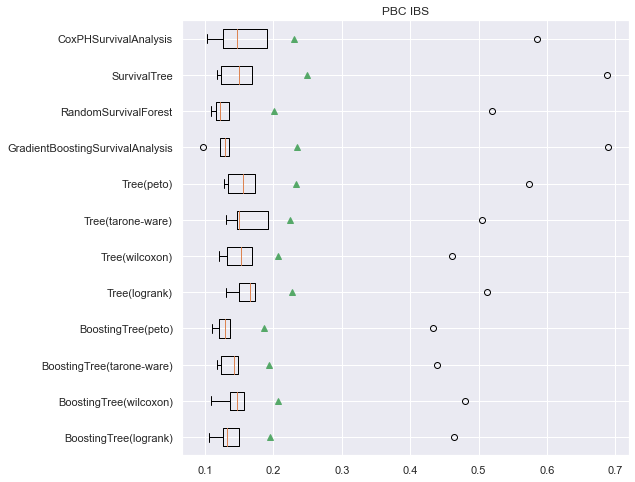

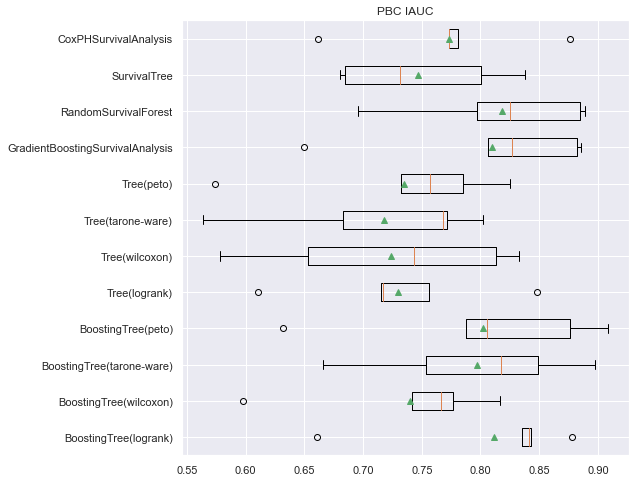

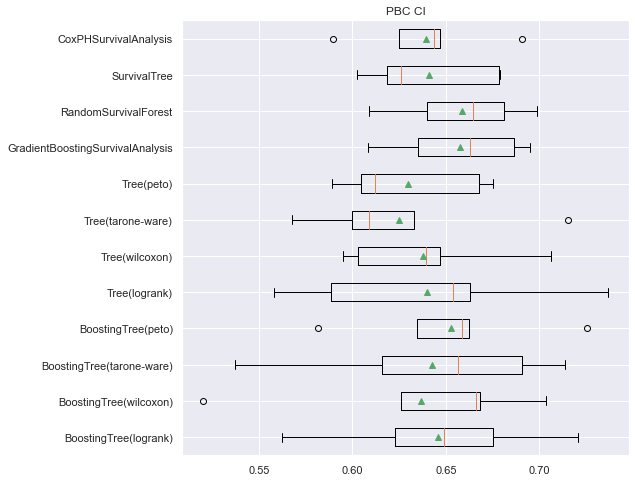

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
import numpy as np

def get_best_results(df, by_metric, choose = "max"):
    if not(by_metric in df.columns):
        return None

    best_table = pd.DataFrame([], columns = df.columns)
    for method in df["METHOD"].unique():
        sub_table = df[df["METHOD"] == method]
        if sub_table.shape[0] == 0:
            continue
        if choose == "max":
            best_row = sub_table.loc[sub_table[by_metric].apply(np.mean).idxmax()]
        else:
            best_row = sub_table.loc[sub_table[by_metric].apply(np.mean).idxmin()]
        best_table = best_table.append(dict(best_row), ignore_index = True)
    return best_table

def plot_results(df_best, dir_path = "./", metrics = [], dataset_name = ""):
    df = df_best.copy()
    #df = df[df["METHOD"].isin(methods)]
    df['METHOD'] = df.apply(lambda x: x["METHOD"].replace("CRAID", "Tree(%s)" %(x['CRIT'])),
                                 axis = 1)
    df_ = get_best_results(df, "IBS", choose = "min")
    for m in metrics:
#         df_ = get_best_results(df, m, choose = "min" if m == "IBS" else "max")
        plt.rcParams.update({'font.size': 15})
        fig, axs = plt.subplots(1, figsize=(8, 8))
        
        plt.title("%s %s" % (dataset_name, m))
        plt.boxplot(df_[m][::-1], labels = df_['METHOD'][::-1], showmeans = True, vert = False)
#         plt.xticks(rotation=90)
        #plt.savefig(dir_path + dataset_name + "%s_boxplot.png" %(m))
        #plt.close(fig)
        plt.show()
#         plt.rcdefaults()

plot_results(df_full[df_full["METHOD"] != "BootstrapCRAID"], dir_path = "./EXP_RES/", 
             metrics = ["IBS", "IAUC", "CI"], #"CI_CENS"], 
             dataset_name = "PBC")

In [16]:
df = df_full.copy()
df['METHOD'] = df.apply(lambda x: x["METHOD"].replace("CRAID", "Tree(%s)" %(x['CRIT'])), axis = 1)
df_best = get_best_results(df, "IBS", "min")
df_fin = df_best.loc[:, ['METHOD', "CI_mean","IBS_mean","IAUC_mean"]].round(5)
df_fin.to_csv('./table_gbsg_res.csv', index = False, sep = "&")

METHOD   CI_mean  CI_CENS_mean  IBS_mean  \
0              CoxPHSurvivalAnalysis  0.639165      0.794300  0.230611   
1                       SurvivalTree  0.640797      0.758307  0.249392   
2               RandomSurvivalForest  0.658613      0.817098  0.200582   
3   GradientBoostingSurvivalAnalysis  0.657567      0.811064  0.234499   
4                         Tree(peto)  0.629764      0.752495  0.232924   
5                  Tree(tarone-ware)  0.624939      0.713977  0.224979   
6                     Tree(wilcoxon)  0.638029      0.748991  0.206954   
7                      Tree(logrank)  0.640048      0.737701  0.226744   
8                BootstrapTree(peto)  0.648916      0.802184  0.192677   
9         BootstrapTree(tarone-ware)  0.658078      0.804517  0.191593   
10           BootstrapTree(wilcoxon)  0.655646      0.805261  0.189693   
11            BootstrapTree(logrank)  0.662280      0.812800  0.187402   
12                BoostingTree(peto)  0.652555      0.799289  0.186159   
13         BoostingTree(tarone-ware)  0.642768      0.778862  0.194166   
14            BoostingTree(wilcoxon)  0.636782      0.770313  0.206203   
15             BoostingTree(logrank)  0.645933      0.791053  0.195537   

    IAUC_mean  
0    0.773082  
1    0.746993  
2    0.818465  
3    0.810199  
4    0.734733  
5    0.717584  
6    0.724173  
7    0.729495  
8    0.804292  
9    0.812505  
10   0.797702  
11   0.814863  
12   0.802144  
13   0.796801  
14   0.739872  
15   0.811568

In [27]:
df_full[df_full['METHOD'] == "RandomSurvivalForest"].loc[:, ['METHOD', "PARAMS", "CI_mean","CI_CENS_mean","IBS_mean","IAUC_mean"]].sort_values("IBS_mean").loc[25, 'PARAMS']

"{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 50}"

In [15]:
from survivors.tests.experiment import run, import_tables, plot_results, get_best_by_full_name
# df = import_tables(['./EXP_RES/GBSG/NEW_GBSG_FULL_TABLE.xlsx'])
# df = import_tables(['./EXP_RES/NEW_Wuhan/WUHAN_SCIKIT.xlsx',
#                     './EXP_RES/NEW_Wuhan/WUHAN_TREE_TABLE.xlsx',
#                     './EXP_RES/NEW_Wuhan/WUHAN_BSTR_BOOST.xlsx',
#                     './EXP_RES/NEW_Wuhan/WUHAN_BOOST.xlsx',
#                     './EXP_RES/NEW_Wuhan/WUHAN_BOOST_ADD.xlsx'])
# df = import_tables(['./EXP_RES/NEW_PBC/PBC_FULL_SCIKIT.xlsx',
#                     './EXP_RES/NEW_PBC/PBC_TREE_TABLE.xlsx',
#                     './EXP_RES/NEW_PBC/PBC_BSTR_BOOST.xlsx',
#                     './EXP_RES/NEW_PBC/PBC_BOOST_ADD.xlsx'
#                     ])
# df = import_tables(['./EXP_RES/ONK/ONK_SCIKIT.xlsx',
#                     './EXP_RES/ONK/ONK_TREE_BSTR_BOOST.xlsx',
#                     './EXP_RES/ONK/ONK_TREE_BSTR_BOOST_LEAF_30_50.xlsx',
#                     './EXP_RES/ONK/ONK_BOOST_BAD.xlsx',
#                     './EXP_RES/ONK/ONK_BOOST_BAD_ALL.xlsx',
#                     './EXP_RES/ONK/ONK_BOOST_20_100_0.4.xlsx',
#                     './EXP_RES/ONK/ONK_BOOST_20_100_0.2_0.5.xlsx',
# #                     './EXP_RES/ONK/ONK_BOOST_DEPTH_5_10.xlsx',
#                     './EXP_RES/ONK/ONK_BOOST_DEPTH_5.xlsx'
#                    ])

df = import_tables(['./EXP_RES/COVID/COVID_SCIKIT_COX_ST_RF.xlsx',
                    './EXP_RES/COVID/COVID_SCIKIT_GBOOST.xlsx',
                    './EXP_RES/COVID/COVID_TREE.xlsx',
                    './EXP_RES/COVID/COVID_BSTR_BOOST.xlsx',
                    './EXP_RES/COVID/COVID_BOOST_LEAF_250.xlsx',
                    './EXP_RES/COVID/COVID_BOOST_LEAF_100.xlsx'
                   ])

df = df.reset_index()

In [16]:
df

index                 METHOD  \
0        0  CoxPHSurvivalAnalysis   
1        1  CoxPHSurvivalAnalysis   
2        2  CoxPHSurvivalAnalysis   
3        3  CoxPHSurvivalAnalysis   
4        4  CoxPHSurvivalAnalysis   
..     ...                    ...   
338     11          BoostingCRAID   
339     12          BoostingCRAID   
340     13          BoostingCRAID   
341     14          BoostingCRAID   
342     15          BoostingCRAID   

                                                PARAMS          TIME  \
0                    {'alpha': 100, 'ties': 'breslow'}    409.502424   
1                      {'alpha': 100, 'ties': 'efron'}    619.701672   
2                     {'alpha': 10, 'ties': 'breslow'}    438.262645   
3                       {'alpha': 10, 'ties': 'efron'}    645.913867   
4                      {'alpha': 1, 'ties': 'breslow'}    447.676486   
..                                                 ...           ...   
338  {'aggreg_func': 'mean', 'categ': ['has_odyshka...  38243.386676   
339  {'aggreg_func': 'mean', 'categ': ['has_odyshka...  17488.559142   
340  {'aggreg_func': 'mean', 'categ': ['has_odyshka...  40889.807051   
341  {'aggreg_func': 'mean', 'categ': ['has_odyshka...  17847.874034   
342  {'aggreg_func': 'mean', 'categ': ['has_odyshka...  40756.488153   

                                                    CI  \
0    [0.54149212, 0.54439854, 0.54679424, 0.5459505...   
1    [0.54150285, 0.5444014, 0.54680807, 0.54595582...   
2    [0.54234618, 0.54513854, 0.54751291, 0.5467586...   
3    [0.54235246, 0.54514062, 0.54752555, 0.5467614...   
4    [0.54258262, 0.54544038, 0.54775311, 0.5470620...   
..                                                 ...   
338  [0.58115171, 0.58032756, 0.58705058, 0.5821927...   
339  [0.57470649, 0.57914968, 0.58145005, 0.5852505...   
340  [0.57470649, 0.56516253, 0.56000544, 0.5853171...   
341  [0.57731931, 0.58393109, 0.58735493, 0.5799409...   
342  [0.57499483, 0.58307636, 0.58657708, 0.5758386...   

                                               CI_CENS  \
0    [0.81325825, 0.82004477, 0.8232369, 0.82480373...   
1    [0.81328947, 0.82006502, 0.82325063, 0.8248394...   
2    [0.81356916, 0.8204888, 0.82384982, 0.82514665...   
3    [0.81360281, 0.82050382, 0.82385963, 0.8251716...   
4    [0.81356001, 0.8206863, 0.82400943, 0.82517047...   
..                                                 ...   
338  [0.68834443, 0.7112391, 0.71223274, 0.71500436...   
339  [0.67737736, 0.71008915, 0.71749619, 0.7346231...   
340  [0.67737736, 0.60165786, 0.70081143, 0.7369495...   
341  [0.70789217, 0.70141816, 0.72822081, 0.6857917...   
342  [0.69377207, 0.69879437, 0.72654174, 0.6599610...   

                                                   IBS  \
0    [0.16927476, 0.16249682, 0.17104276, 0.1665129...   
1    [0.16944853, 0.16251774, 0.17119335, 0.1666897...   
2    [0.16866994, 0.16319514, 0.17134398, 0.1670201...   
3    [0.16884318, 0.16321633, 0.17149923, 0.1672000...   
4    [0.16868935, 0.1633131, 0.17145468, 0.16719148...   
..                                                 ...   
338  [0.1616475, 0.16078489, 0.15973764, 0.16128746...   
339  [0.15849417, 0.15901023, 0.16484428, 0.1638714...   
340  [0.15849417, 0.15932216, 0.17895464, 0.1644025...   
341  [0.16263692, 0.16099286, 0.16179569, 0.1660008...   
342  [0.17546569, 0.16146452, 0.1616606, 0.16652539...   

                                                  IAUC         CRIT   CI_mean  \
0    [0.80061546, 0.82011886, 0.81037452, 0.7034034...          NaN  0.543967   
1    [0.80065924, 0.82014803, 0.8103479, 0.70342026...          NaN  0.543974   
2    [0.80090826, 0.81991352, 0.81056942, 0.7028655...          NaN  0.544740   
3    [0.80090854, 0.81996835, 0.81057874, 0.7028760...          NaN  0.544746   
4    [0.80086161, 0.8199965, 0.81062638, 0.70259784...          NaN  0.544998   
..                                                 ...          ...       ...   
338  [0.80330833, 0.81730826, 0.81417

In [11]:
df_best = get_best_by_full_name(df, by_metric = "IBS", choose = "min")
df_fin = df_best.loc[:, ["METHOD", "CI_mean", "IBS_mean", "IAUC_mean"]].round(5)
df_fin.to_csv('./table_onk_res.csv', index = False, sep = "&")

In [4]:
df_best = get_best_by_full_name(df, by_metric = "IAUC", choose = "max")
df_fin = df_best.loc[:, ["METHOD", "CI_mean", "IBS_mean", "IAUC_mean"]].round(5)
df_fin#.to_csv('./table_covid_moscow_res.csv', index = False, sep = "&")

METHOD  CI_mean  IBS_mean  IAUC_mean
0              CoxPHSurvivalAnalysis  0.73021   0.14799    0.81320
1                       SurvivalTree  0.61912   0.19368    0.67203
2               RandomSurvivalForest  0.76557   0.15987    0.80483
3   GradientBoostingSurvivalAnalysis  0.81041   0.13885    0.84064
4                         Tree(peto)  0.73194   0.18189    0.75915
5                  Tree(tarone-ware)  0.80199   0.15993    0.79466
6                     Tree(wilcoxon)  0.81415   0.16123    0.80080
7                      Tree(logrank)  0.73254   0.18816    0.74319
8                BootstrapTree(peto)  0.83823   0.15709    0.82689
9         BootstrapTree(tarone-ware)  0.83813   0.15732    0.82593
10           BootstrapTree(wilcoxon)  0.83760   0.15762    0.82361
11            BootstrapTree(logrank)  0.83701   0.15542    0.82858
12                BoostingTree(peto)  0.83445   0.14912    0.84265
13         BoostingTree(tarone-ware)  0.83663   0.14980    0.84296
14            BoostingTree(wilcoxon)  0.83296   0.15480    0.84535
15             BoostingTree(logrank)  0.83432   0.14733    0.84530

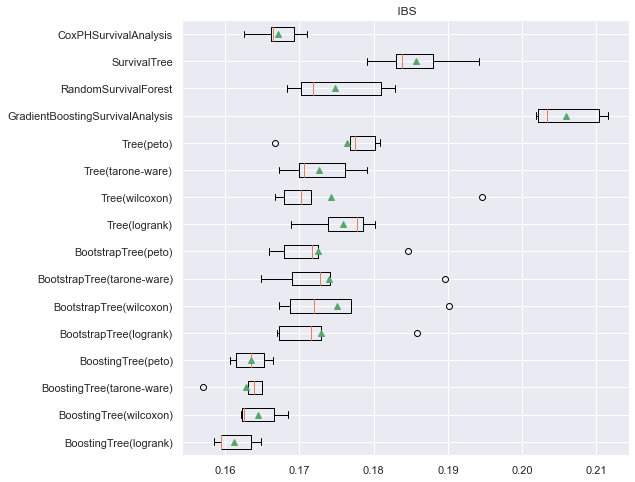

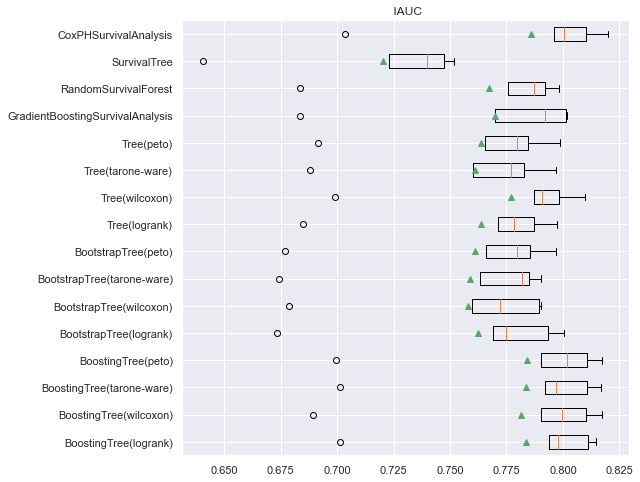

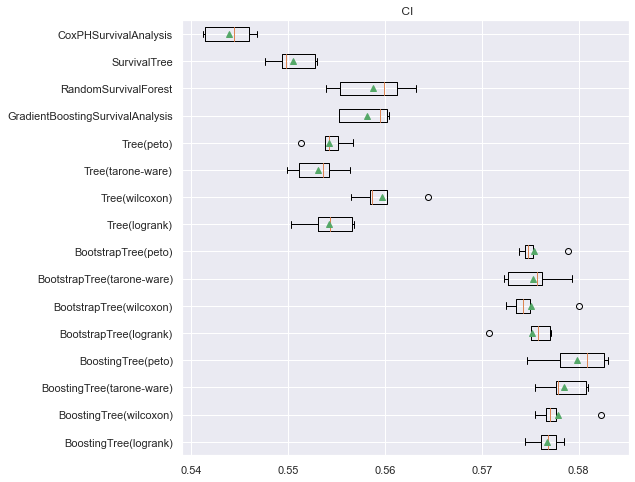

In [30]:
plot_results(df, metrics = ["IBS", "IAUC", "CI"], by_metric = "IBS", choose = "min")

In [1]:
from survivors.tests.experiment import run
ONK_exp = run("ONK", with_self = ["BOOST"], #["TREE", "BSTR", "BOOST"], 
              with_external = False)

c:\programdata\anaconda3\envs\omsexpmt\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


DIAG {'C20': 0, 'C50.4': 1, 'C61': 2}
[0.8066 0.8178 0.8326 0.8404 0.8473 0.8501 0.8508 0.8533 0.8538 0.8558
 0.858  0.8571 0.8566 0.8571 0.8571 0.857  0.8537 0.8542 0.8548 0.8545
 0.8546 0.8555 0.8549 0.8556 0.8563 0.8568 0.856  0.8564 0.8563 0.8567]
fitted: 11 models.
[0.7853 0.7928 0.8144 0.825  0.8326 0.8373 0.8392 0.8384 0.8396 0.8417
 0.8428 0.8428 0.8425 0.8432 0.8442 0.8448 0.8424 0.843  0.8439 0.8444
 0.8446 0.8445 0.8451 0.8453 0.8462 0.8467 0.8471 0.8475 0.8473 0.8473]
fitted: 28 models.
[0.7885 0.8052 0.799  0.8122 0.8185 0.8221 0.8258 0.8278 0.8298 0.8339
 0.8342 0.834  0.8335 0.8338 0.8351 0.8352 0.8361 0.8362 0.8366 0.8368
 0.8368 0.8365 0.8357 0.8362 0.8373 0.8375 0.8389 0.8385 0.8387 0.8394]
fitted: 30 models.
[0.7877 0.7656 0.7643 0.785  0.7963 0.8054 0.8174 0.8156 0.8185 0.82
 0.8229 0.8235 0.8263 0.8275 0.8282 0.8269 0.8278 0.8296 0.8308 0.8312
 0.8319 0.8321 0.8322 0.8322 0.8329 0.8329 0.8333 0.8336 0.8341 0.8343]
fitted: 30 models.
[0.7877 0.7753 0.7944 0.7964 0.8

[0.1721 0.1645 0.1677 0.1577 0.1563 0.1537 0.1525 0.1542 0.1524 0.1522
 0.151  0.1502 0.1501 0.1492 0.1496 0.1492 0.1494 0.1488 0.1482 0.1487
 0.1481 0.148  0.1477 0.147  0.1469 0.1467 0.1475 0.1469 0.1466 0.1465]
fitted: 30 models.
[0.158  0.1456 0.1519 0.146  0.144  0.1421 0.1421 0.1403 0.1392 0.1394
 0.1397 0.1394 0.1387 0.1382 0.1393 0.1384 0.1384 0.1376 0.1369 0.1367
 0.1365 0.1359 0.1357 0.1357 0.1357 0.1353 0.136  0.1358 0.1359 0.1356]
fitted: 26 models.
[0.1845 0.1662 0.1675 0.1597 0.155  0.1516 0.1521 0.1514 0.1481 0.1467
 0.1455 0.1459 0.1449 0.1448 0.1453 0.1443 0.1445 0.1442 0.1446 0.1444
 0.1441 0.144  0.1434 0.1434 0.1431 0.1425 0.1425 0.1421 0.1423 0.1423]
fitted: 28 models.
[0.1912 0.1687 0.1595 0.1525 0.1477 0.1455 0.145  0.1426 0.143  0.1438
 0.1423 0.1423 0.1413 0.141  0.141  0.14   0.1408 0.1406 0.1401 0.1397
 0.1399 0.1392 0.1391 0.1394 0.1393 0.1395 0.14   0.1395 0.1392 0.1395]
fitted: 23 models.
EXECUTION TIME OF BoostingCRAID: 1344.9502727985382 {'CI': 0.8376332

[0.1662 0.1488 0.1542 0.1568 0.1529 0.1477 0.1451 0.143  0.1426 0.1397
 0.1378 0.1376 0.1367 0.1373 0.1375 0.1365 0.1372 0.1365 0.137  0.1367
 0.1365 0.1361 0.1362 0.136  0.1355 0.1352 0.1356 0.136  0.1355 0.1353]
fitted: 26 models.
[0.1672 0.1553 0.1596 0.1525 0.1529 0.1496 0.1483 0.1478 0.1475 0.1461
 0.144  0.1446 0.1433 0.1427 0.1429 0.1421 0.1436 0.1426 0.1425 0.143
 0.1429 0.1432 0.143  0.143  0.1425 0.1425 0.1428 0.1427 0.1432 0.1434]
fitted: 16 models.
[0.1815 0.1577 0.1578 0.1496 0.1474 0.1448 0.1447 0.1435 0.1462 0.1453
 0.145  0.1447 0.1439 0.1444 0.1422 0.1419 0.143  0.1423 0.1429 0.1431
 0.1425 0.1413 0.1413 0.1407 0.1416 0.1406 0.1412 0.1413 0.1413 0.1412]
fitted: 26 models.
EXECUTION TIME OF BoostingCRAID: 1156.748046875 {'CI': 0.8374286031289497, 'CI_CENS': 0.796434507864461, 'IBS': 0.14644825100175476, 'IAUC': 0.8356311921967204}
[0.1783 0.1638 0.1531 0.1501 0.1449 0.1408 0.14   0.1396 0.1379 0.1372
 0.1387 0.1394 0.1382 0.1377 0.1371 0.1375 0.1372 0.1363 0.1375 0.1375

[0.8001 0.792  0.7992 0.8161 0.8121 0.8165 0.817  0.8204 0.8215 0.8244
 0.8272 0.8231 0.8234 0.8258 0.8266 0.8282 0.8292 0.8299 0.8298 0.8298
 0.8306 0.8314 0.8322 0.8324 0.8325 0.8325 0.8329 0.8331 0.8337 0.8342]
fitted: 30 models.
[0.7643 0.759  0.7936 0.8092 0.8117 0.8126 0.8157 0.8175 0.8176 0.8127
 0.8171 0.817  0.8165 0.8198 0.8212 0.822  0.8229 0.8249 0.8271 0.8284
 0.8289 0.8301 0.83   0.8306 0.8306 0.8309 0.8309 0.8297 0.8304 0.831 ]
fitted: 30 models.
EXECUTION TIME OF BoostingCRAID: 1239.755003452301 {'CI': 0.835728770348962, 'CI_CENS': 0.7969251508751238, 'IBS': 0.1481362656192871, 'IAUC': 0.8427115861245931}
[0.7974 0.8267 0.8307 0.8364 0.8388 0.8384 0.8383 0.8409 0.8466 0.849
 0.851  0.8525 0.8523 0.8527 0.8523 0.8534 0.8541 0.8543 0.8546 0.8555
 0.8555 0.8558 0.8561 0.8557 0.8556 0.8555 0.856  0.8568 0.8567 0.8569]
fitted: 30 models.
[0.7966 0.7761 0.7925 0.8084 0.8142 0.8224 0.8269 0.8283 0.8285 0.8306
 0.8335 0.8346 0.8348 0.8338 0.8359 0.836  0.8373 0.838  0.8386 0.83

[0.7725 0.7646 0.7626 0.7786 0.7836 0.7924 0.7967 0.7877 0.7911 0.7994
 0.8032 0.8002 0.801  0.805  0.8071 0.8084 0.8086 0.8099 0.8103 0.813
 0.8158 0.8168 0.8173 0.8188 0.8195 0.8202 0.8193 0.8198 0.8205 0.8192]
fitted: 29 models.
EXECUTION TIME OF BoostingCRAID: 1098.4345915317535 {'CI': 0.8374815107381366, 'CI_CENS': 0.7946209306457805, 'IBS': 0.14713396606106408, 'IAUC': 0.8372453571105168}
[0.8062 0.8217 0.8303 0.8375 0.8384 0.8414 0.8429 0.8447 0.8451 0.8458
 0.8477 0.8491 0.8491 0.8508 0.8513 0.8525 0.8519 0.8522 0.8531 0.852
 0.8525 0.8539 0.8537 0.8537 0.8543 0.8552 0.8553 0.8555 0.8554 0.8556]
fitted: 30 models.
[0.7848 0.8035 0.8028 0.8084 0.8112 0.8119 0.8193 0.8184 0.8175 0.8209
 0.8183 0.8204 0.8233 0.8264 0.8309 0.8319 0.8324 0.8316 0.8327 0.8347
 0.836  0.8372 0.8361 0.8364 0.8374 0.8378 0.8393 0.8391 0.8394 0.8406]
fitted: 30 models.
[0.7873 0.7921 0.8131 0.8188 0.7909 0.7894 0.7929 0.7952 0.7966 0.803
 0.8039 0.8078 0.8096 0.8053 0.809  0.8124 0.8147 0.8155 0.8158 0.8

EXECUTION TIME OF BoostingCRAID: 1347.5767080783844 {'CI': 0.8378997606948223, 'CI_CENS': 0.7965632052541286, 'IBS': 0.1437064405211883, 'IAUC': 0.84027849758904}
[0.1443 0.1525 0.1614 0.1533 0.1471 0.1442 0.1417 0.142  0.1405 0.1407
 0.1388 0.1389 0.1361 0.138  0.1371 0.1375 0.1363 0.137  0.1378 0.1379
 0.1377 0.137  0.1371 0.1378 0.137  0.1366 0.137  0.1367 0.1358 0.1359]
fitted: 29 models.
[0.1721 0.1773 0.1747 0.1695 0.1644 0.1633 0.1619 0.1584 0.1571 0.1562
 0.1547 0.1548 0.1543 0.1525 0.1534 0.1536 0.1528 0.1529 0.1531 0.1544
 0.153  0.1532 0.1532 0.1527 0.1529 0.1517 0.1513 0.1509 0.151  0.151 ]
fitted: 28 models.
[0.1638 0.1606 0.1633 0.1573 0.1521 0.1507 0.1477 0.1476 0.1471 0.1456
 0.147  0.1453 0.1441 0.1456 0.1449 0.1429 0.1423 0.1414 0.1413 0.141
 0.1414 0.1414 0.1415 0.1409 0.1409 0.1407 0.1407 0.1408 0.1408 0.141 ]
fitted: 26 models.
[0.1861 0.168  0.1654 0.1625 0.1619 0.1657 0.1644 0.1605 0.1576 0.1554
 0.1533 0.1525 0.1522 0.1497 0.1479 0.1488 0.1481 0.1484 0.1483 0.14

In [ ]:
from survivors.tests.experiment import run
ONK_exp = run("ONK", with_self = ["BOOST"], #["TREE", "BSTR", "BOOST"], 
              with_external = False)

c:\programdata\anaconda3\envs\omsexpmt\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


DIAG {'C20': 0, 'C50.4': 1, 'C61': 2}
[0.8166 0.8257 0.8495 0.8479 0.8535 0.857  0.8594 0.8607 0.8635 0.8641
 0.8654 0.8654 0.8658 0.866  0.866  0.867  0.8676 0.8677 0.8671 0.8678
 0.8674 0.8679 0.8662 0.8667 0.8669 0.8669 0.8679 0.8681 0.8677 0.8671]
fitted: 28 models.
[0.8069 0.8282 0.8401 0.8387 0.8422 0.8455 0.8484 0.8425 0.8472 0.849
 0.8492 0.8479 0.8484 0.8495 0.8507 0.851  0.853  0.8538 0.8545 0.8539
 0.8545 0.8546 0.8547 0.8556 0.8553 0.8547 0.8539 0.8542 0.8551 0.855 ]
fitted: 24 models.
[0.7844 0.8115 0.8223 0.7997 0.8078 0.8195 0.8249 0.8275 0.8325 0.8293
 0.8308 0.831  0.833  0.8354 0.8357 0.8363 0.8406 0.8428 0.8423 0.8396
 0.8415 0.8418 0.8428 0.8442 0.8456 0.8462 0.8461 0.8458 0.848  0.8478]
fitted: 29 models.
[0.8349 0.8373 0.8398 0.8348 0.8375 0.8425 0.8455 0.844  0.8476 0.8479
 0.8455 0.8458 0.8447 0.8445 0.8456 0.8456 0.8472 0.8468 0.848  0.8488
 0.8494 0.8498 0.8487 0.8482 0.8488 0.8488 0.8487 0.8479 0.8488 0.8498]
fitted: 22 models.
[0.7746 0.7947 0.8127 0.7979 0.

c:\programdata\anaconda3\envs\omsexpmt\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[0.7762 0.8077 0.8023 0.8146 0.8221 0.8219 0.8258 0.8283 0.831  0.8307
 0.8322 0.8341 0.8295 0.8316 0.832  0.8296 0.8291 0.8302 0.8312 0.834
 0.8361 0.8348 0.8339 0.8348 0.8359 0.8363 0.8368 0.8379 0.8378 0.8379
 0.8384 0.8391 0.84   0.8395 0.8399 0.8402 0.8408 0.8408 0.8407 0.8414
 0.842  0.8426 0.8428 0.8437 0.8443 0.8446 0.8443 0.8445 0.8439 0.8445]
fitted: 46 models.
EXECUTION TIME OF BoostingCRAID: 6763.978486537933 {'CI': 0.843509082155518, 'CI_CENS': 0.7833058170026733, 'IBS': 0.1563106609972212, 'IAUC': 0.8213012778716244}
[0.8166 0.8338 0.8442 0.8479 0.8511 0.8561 0.8605 0.8616 0.864  0.8625
 0.8593 0.8606 0.8618 0.8626 0.8644 0.8636 0.8641 0.8644 0.8644 0.8647
 0.8649 0.865  0.8652 0.8657 0.8665 0.8674 0.8671 0.8672 0.8679 0.8672]
fitted: 29 models.
[0.8069 0.8188 0.8344 0.8388 0.8425 0.8472 0.8502 0.8547 0.8549 0.8576
 0.8584 0.8594 0.86   0.8595 0.8598 0.8602 0.8585 0.8587 0.8596 0.8592
 0.8598 0.8608 0.862  0.8631 0.8628 0.8627 0.8624 0.8628 0.8625 0.8628]
fitted: 24 model

[0.7335 0.7648 0.7987 0.8044 0.8046 0.8095 0.8115 0.8108 0.8115 0.8124
 0.8147 0.8146 0.8178 0.8179 0.8178 0.8181 0.8138 0.8159 0.8147 0.8157
 0.8176 0.8165 0.8164 0.8169 0.8183 0.8181 0.8174 0.8175 0.8186 0.8161]
fitted: 29 models.
EXECUTION TIME OF BoostingCRAID: 668.0160086154938 {'CI': 0.8331027995092208, 'CI_CENS': 0.7765774448497358, 'IBS': 0.15968184077411895, 'IAUC': 0.8253682779052113}
[0.7645 0.8027 0.8104 0.8284 0.8341 0.8229 0.8316 0.8366 0.8429 0.8436
 0.8461 0.8495 0.8503 0.8472 0.8487 0.849  0.8456 0.8455 0.8459 0.8464
 0.8471 0.846  0.8459 0.8448 0.8456 0.8469 0.8463 0.8452 0.8468 0.8478]
fitted: 13 models.
[0.7317 0.7907 0.8207 0.8247 0.8264 0.8309 0.8346 0.8361 0.8371 0.8373
 0.8377 0.8371 0.8354 0.8386 0.8385 0.8379 0.8388 0.8402 0.8395 0.8399
 0.8404 0.8399 0.8392 0.8378 0.8385 0.8382 0.8383 0.8386 0.8388 0.8393]
fitted: 21 models.
[0.8002 0.8142 0.8221 0.8189 0.8238 0.8248 0.8278 0.8283 0.829  0.8324
 0.8334 0.8341 0.8319 0.8325 0.834  0.833  0.8306 0.8307 0.8294 0

EXECUTION TIME OF BoostingCRAID: 992.9235193729401 {'CI': 0.8377015018679795, 'CI_CENS': 0.783138880388841, 'IBS': 0.1503884382060739, 'IAUC': 0.8353565347107257}
[0.6961 0.7555 0.7904 0.8123 0.8207 0.8276 0.8352 0.8366 0.8385 0.8378
 0.8417 0.8417 0.8419 0.8425 0.845  0.8466 0.8386 0.8385 0.839  0.8385
 0.8389 0.8335 0.8334 0.8354 0.8354 0.836  0.8349 0.8324 0.8335 0.8337
 0.8352 0.8346 0.8357 0.8371 0.8356 0.8341 0.8356 0.836  0.8375 0.8384
 0.8401 0.8399 0.8407 0.8411 0.8424 0.8422 0.8429 0.8437 0.8435 0.8444]
fitted: 16 models.
[0.7779 0.8108 0.8315 0.8317 0.8314 0.8319 0.8332 0.8357 0.8369 0.8407
 0.8404 0.8399 0.8395 0.8395 0.8389 0.839  0.837  0.8372 0.8363 0.8359
 0.8357 0.8371 0.8365 0.8367 0.8372 0.8372 0.837  0.8369 0.837  0.8368
 0.8367 0.8376 0.8386 0.8389 0.8394 0.8386 0.8393 0.8399 0.84   0.8398
 0.8401 0.8401 0.8407 0.8405 0.841  0.8411 0.8414 0.8412 0.8413 0.8414]
fitted: 47 models.
[0.757  0.7863 0.8071 0.8196 0.8259 0.8269 0.8301 0.8304 0.8321 0.8337
 0.8338 0.8346 0

[0.1647 0.1723 0.1599 0.1586 0.1527 0.151  0.148  0.1481 0.1474 0.1463
 0.1477 0.1475 0.1467 0.1461 0.1453 0.1458 0.1457 0.1451 0.1457 0.1453
 0.1453 0.1458 0.1459 0.1454 0.1447 0.1445 0.145  0.145  0.1452 0.1453
 0.1456 0.1456 0.1448 0.144  0.144  0.1446 0.1444 0.1445 0.1444 0.1443
 0.1448 0.1447 0.1445 0.1445 0.1444 0.1442 0.1445 0.1445 0.1443 0.144 ]
fitted: 34 models.
EXECUTION TIME OF BoostingCRAID: 5266.865103721619 {'CI': 0.841136381723264, 'CI_CENS': 0.7794404183274246, 'IBS': 0.15347905101901813, 'IAUC': 0.8230685420165627}
[0.1955 0.1769 0.1606 0.1557 0.1503 0.1524 0.1483 0.1488 0.15   0.1491
 0.148  0.1487 0.1479 0.1463 0.146  0.1453 0.1454 0.1446 0.1451 0.1442
 0.1432 0.1421 0.1409 0.1406 0.14   0.1395 0.1398 0.1403 0.1405 0.1402
 0.1404 0.1404 0.1406 0.1406 0.1403 0.14   0.1398 0.1399 0.1403 0.1402
 0.1399 0.1398 0.1396 0.1396 0.1392 0.139  0.1387 0.1389 0.139  0.1384]
fitted: 50 models.
[0.2055 0.2069 0.193  0.1861 0.1764 0.1724 0.1694 0.165  0.1647 0.1623
 0.1617 0.1626 

c:\programdata\anaconda3\envs\omsexpmt\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[0.1787 0.1936 0.1926 0.1782 0.1697 0.1637 0.1594 0.1588 0.1569 0.1574
 0.1558 0.1549 0.1555 0.1536 0.1529 0.1531 0.1516 0.1521 0.1515 0.1507
 0.1496 0.1502 0.1501 0.15   0.15   0.1488 0.1487 0.1486 0.1482 0.148
 0.1481 0.148  0.148  0.1475 0.1478 0.1479 0.1474 0.1471 0.1476 0.1474
 0.1473 0.1475 0.1471 0.147  0.1467 0.1463 0.1465 0.1463 0.1462 0.1458]
fitted: 50 models.
EXECUTION TIME OF BoostingCRAID: 7155.3358516693115 {'CI': 0.8431333171315372, 'CI_CENS': 0.7824936424431786, 'IBS': 0.1555619709215846, 'IAUC': 0.8231384839305}
[0.1717 0.1629 0.1582 0.1542 0.1506 0.1479 0.1501 0.1469 0.1437 0.144
 0.1421 0.1403 0.1402 0.14   0.1385 0.1387 0.1383 0.1377 0.1372 0.137
 0.1378 0.1374 0.1379 0.1372 0.1371 0.1368 0.1361 0.1366 0.1357 0.1355]
fitted: 30 models.
[0.1697 0.1811 0.1736 0.1641 0.161  0.1578 0.1569 0.155  0.1545 0.1544
 0.1547 0.1531 0.1535 0.1544 0.1548 0.1549 0.1556 0.1533 0.1521 0.1534
 0.1539 0.1537 0.1539 0.1542 0.1546 0.1543 0.154  0.1542 0.1548 0.1545]
fitted: 19 models.


[0.1752 0.172  0.1616 0.1615 0.1598 0.1595 0.1567 0.1578 0.1575 0.1578
 0.154  0.1532 0.1524 0.154  0.1542 0.1536 0.1546 0.1542 0.1536 0.1536
 0.1533 0.1528 0.1524 0.1524 0.1527 0.1519 0.1522 0.1519 0.1523 0.1521]
fitted: 26 models.
EXECUTION TIME OF BoostingCRAID: 824.9382238388062 {'CI': 0.8297968575565683, 'CI_CENS': 0.7718628042392618, 'IBS': 0.15758342163329758, 'IAUC': 0.827520966077112}
[0.1704 0.1655 0.1602 0.1569 0.1532 0.1478 0.144  0.1442 0.1439 0.1446
 0.1429 0.143  0.1413 0.1423 0.142  0.1411 0.142  0.1411 0.1419 0.1422
 0.1419 0.1418 0.1421 0.1417 0.1417 0.1417 0.1418 0.1421 0.1423 0.1422]
fitted: 16 models.
[0.1847 0.1788 0.1719 0.1658 0.1646 0.1676 0.1646 0.1626 0.1661 0.1647
 0.1633 0.1646 0.1644 0.1639 0.1629 0.1624 0.162  0.1611 0.1614 0.161
 0.161  0.1598 0.1595 0.1595 0.1602 0.1596 0.1599 0.1599 0.1599 0.1605]
fitted: 23 models.
[0.1631 0.1636 0.1512 0.1496 0.1486 0.1437 0.144  0.1437 0.1443 0.1469
 0.1456 0.1454 0.1438 0.1448 0.1459 0.1467 0.1466 0.1447 0.1446 0.1

EXECUTION TIME OF BoostingCRAID: 1057.8461697101593 {'CI': 0.8365489240863596, 'CI_CENS': 0.7808090096090711, 'IBS': 0.14839514221351963, 'IAUC': 0.8324257393110758}
[0.1788 0.1689 0.1605 0.1519 0.1482 0.146  0.1456 0.1435 0.1431 0.144
 0.144  0.1435 0.1445 0.1448 0.1434 0.1427 0.1436 0.1432 0.1425 0.1435
 0.1437 0.1431 0.1433 0.143  0.1431 0.1427 0.1424 0.1428 0.1428 0.1427
 0.1435 0.1429 0.1428 0.1431 0.1437 0.1438 0.1436 0.1438 0.1438 0.144
 0.1439 0.1439 0.1441 0.1443 0.1437 0.144  0.1444 0.1445 0.1444 0.1442]
fitted: 27 models.
[0.1857 0.1769 0.1647 0.1638 0.1609 0.1607 0.1582 0.1589 0.1573 0.1587
 0.1586 0.1574 0.1576 0.1572 0.1566 0.156  0.1563 0.1558 0.1557 0.156
 0.1556 0.155  0.155  0.1546 0.1546 0.1547 0.1548 0.1551 0.1554 0.1552
 0.1548 0.1549 0.1547 0.1546 0.1546 0.1551 0.1548 0.1543 0.1545 0.1541
 0.1541 0.1545 0.1545 0.1548 0.1543 0.1543 0.1546 0.1545 0.1543 0.1545]
fitted: 40 models.
[0.1799 0.1719 0.1569 0.1538 0.1501 0.1482 0.1474 0.1453 0.1439 0.1441
 0.143  0.1432 0

[0.7746 0.7947 0.8127 0.7979 0.8088 0.8169 0.8189 0.8159 0.8213 0.8263
 0.8276 0.8288 0.8321 0.8359 0.8366 0.8375 0.8364 0.8353 0.8368 0.8331
 0.833  0.8321 0.8326 0.8345 0.8363 0.8367 0.8368 0.8374 0.837  0.8375
 0.8367 0.8342 0.8353 0.8371 0.8343 0.8339 0.8353 0.8363 0.8367 0.837
 0.8376 0.8388 0.8397 0.8402 0.8402 0.8383 0.8387 0.8392 0.8387 0.8398]
fitted: 44 models.
EXECUTION TIME OF BoostingCRAID: 4888.000167608261 {'CI': 0.8418648225120172, 'CI_CENS': 0.7817151127853145, 'IBS': 0.15311334877697186, 'IAUC': 0.8255347297870547}
[0.8179 0.842  0.8486 0.8515 0.8567 0.8572 0.8597 0.8604 0.8638 0.864
 0.8658 0.8674 0.8656 0.8659 0.8664 0.8637 0.8636 0.8653 0.8642 0.8662
 0.8668 0.8665 0.8657 0.8666 0.8671 0.8673 0.8681 0.8676 0.8678 0.8682
 0.8687 0.869  0.8695 0.8695 0.8696 0.8687 0.8689 0.869  0.8694 0.8694
 0.8695 0.8687 0.8681 0.869  0.8692 0.8691 0.8698 0.8699 0.8701 0.8705]
fitted: 50 models.
[0.7802 0.8193 0.8225 0.8302 0.8381 0.8413 0.8447 0.8474 0.8494 0.8457
 0.8473 0.8471 0

c:\programdata\anaconda3\envs\omsexpmt\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[0.7762 0.8077 0.8023 0.8146 0.8221 0.8219 0.8258 0.8283 0.831  0.8307
 0.8322 0.8341 0.8295 0.8316 0.832  0.8296 0.8291 0.8302 0.8312 0.834
 0.8361 0.8348 0.8339 0.8348 0.8359 0.8363 0.8368 0.8379 0.8378 0.8379
 0.8384 0.8391 0.84   0.8395 0.8399 0.8402 0.8408 0.8408 0.8407 0.8414
 0.842  0.8426 0.8428 0.8437 0.8443 0.8446 0.8443 0.8445 0.8439 0.8445]
fitted: 46 models.
EXECUTION TIME OF BoostingCRAID: 6730.0469744205475 {'CI': 0.843509082155518, 'CI_CENS': 0.7833058170026733, 'IBS': 0.1563106609972212, 'IAUC': 0.8213012778716244}
[0.8166 0.8338 0.8442 0.8479 0.8511 0.8561 0.8605 0.8616 0.864  0.8625
 0.8593 0.8606 0.8618 0.8626 0.8644 0.8636 0.8641 0.8644 0.8644 0.8647
 0.8649 0.865  0.8652 0.8657 0.8665 0.8674 0.8671 0.8672 0.8679 0.8672]
fitted: 29 models.
[0.8069 0.8188 0.8344 0.8388 0.8425 0.8472 0.8502 0.8547 0.8549 0.8576
 0.8584 0.8594 0.86   0.8595 0.8598 0.8602 0.8585 0.8587 0.8596 0.8592
 0.8598 0.8608 0.862  0.8631 0.8628 0.8627 0.8624 0.8628 0.8625 0.8628]
fitted: 24 mode

[0.7335 0.7648 0.7987 0.8044 0.8046 0.8095 0.8115 0.8108 0.8115 0.8124
 0.8147 0.8146 0.8178 0.8179 0.8178 0.8181 0.8138 0.8159 0.8147 0.8157
 0.8176 0.8165 0.8164 0.8169 0.8183 0.8181 0.8174 0.8175 0.8186 0.8161]
fitted: 29 models.
EXECUTION TIME OF BoostingCRAID: 665.6318035125732 {'CI': 0.8331027995092208, 'CI_CENS': 0.7765774448497358, 'IBS': 0.15968184077411895, 'IAUC': 0.8253682779052113}
[0.7645 0.8027 0.8104 0.8284 0.8341 0.8229 0.8316 0.8366 0.8429 0.8436
 0.8461 0.8495 0.8503 0.8472 0.8487 0.849  0.8456 0.8455 0.8459 0.8464
 0.8471 0.846  0.8459 0.8448 0.8456 0.8469 0.8463 0.8452 0.8468 0.8478]
fitted: 13 models.
[0.7317 0.7907 0.8207 0.8247 0.8264 0.8309 0.8346 0.8361 0.8371 0.8373
 0.8377 0.8371 0.8354 0.8386 0.8385 0.8379 0.8388 0.8402 0.8395 0.8399
 0.8404 0.8399 0.8392 0.8378 0.8385 0.8382 0.8383 0.8386 0.8388 0.8393]
fitted: 21 models.
[0.8002 0.8142 0.8221 0.8189 0.8238 0.8248 0.8278 0.8283 0.829  0.8324
 0.8334 0.8341 0.8319 0.8325 0.834  0.833  0.8306 0.8307 0.8294 0

EXECUTION TIME OF BoostingCRAID: 989.5849602222443 {'CI': 0.8377015018679795, 'CI_CENS': 0.783138880388841, 'IBS': 0.1503884382060739, 'IAUC': 0.8353565347107257}
[0.6961 0.7555 0.7904 0.8123 0.8207 0.8276 0.8352 0.8366 0.8385 0.8378
 0.8417 0.8417 0.8419 0.8425 0.845  0.8466 0.8386 0.8385 0.839  0.8385
 0.8389 0.8335 0.8334 0.8354 0.8354 0.836  0.8349 0.8324 0.8335 0.8337
 0.8352 0.8346 0.8357 0.8371 0.8356 0.8341 0.8356 0.836  0.8375 0.8384
 0.8401 0.8399 0.8407 0.8411 0.8424 0.8422 0.8429 0.8437 0.8435 0.8444]
fitted: 16 models.
[0.7779 0.8108 0.8315 0.8317 0.8314 0.8319 0.8332 0.8357 0.8369 0.8407
 0.8404 0.8399 0.8395 0.8395 0.8389 0.839  0.837  0.8372 0.8363 0.8359
 0.8357 0.8371 0.8365 0.8367 0.8372 0.8372 0.837  0.8369 0.837  0.8368
 0.8367 0.8376 0.8386 0.8389 0.8394 0.8386 0.8393 0.8399 0.84   0.8398
 0.8401 0.8401 0.8407 0.8405 0.841  0.8411 0.8414 0.8412 0.8413 0.8414]
fitted: 47 models.
[0.757  0.7863 0.8071 0.8196 0.8259 0.8269 0.8301 0.8304 0.8321 0.8337
 0.8338 0.8346 0

[0.1647 0.1723 0.1599 0.1586 0.1527 0.151  0.148  0.1481 0.1474 0.1463
 0.1477 0.1475 0.1467 0.1461 0.1453 0.1458 0.1457 0.1451 0.1457 0.1453
 0.1453 0.1458 0.1459 0.1454 0.1447 0.1445 0.145  0.145  0.1452 0.1453
 0.1456 0.1456 0.1448 0.144  0.144  0.1446 0.1444 0.1445 0.1444 0.1443
 0.1448 0.1447 0.1445 0.1445 0.1444 0.1442 0.1445 0.1445 0.1443 0.144 ]
fitted: 34 models.
EXECUTION TIME OF BoostingCRAID: 5264.243775844574 {'CI': 0.841136381723264, 'CI_CENS': 0.7794404183274246, 'IBS': 0.15347905101901813, 'IAUC': 0.8230685420165627}
[0.1955 0.1769 0.1606 0.1557 0.1503 0.1524 0.1483 0.1488 0.15   0.1491
 0.148  0.1487 0.1479 0.1463 0.146  0.1453 0.1454 0.1446 0.1451 0.1442
 0.1432 0.1421 0.1409 0.1406 0.14   0.1395 0.1398 0.1403 0.1405 0.1402
 0.1404 0.1404 0.1406 0.1406 0.1403 0.14   0.1398 0.1399 0.1403 0.1402
 0.1399 0.1398 0.1396 0.1396 0.1392 0.139  0.1387 0.1389 0.139  0.1384]
fitted: 50 models.
[0.2055 0.2069 0.193  0.1861 0.1764 0.1724 0.1694 0.165  0.1647 0.1623
 0.1617 0.1626 

c:\programdata\anaconda3\envs\omsexpmt\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[0.1787 0.1936 0.1926 0.1782 0.1697 0.1637 0.1594 0.1588 0.1569 0.1574
 0.1558 0.1549 0.1555 0.1536 0.1529 0.1531 0.1516 0.1521 0.1515 0.1507
 0.1496 0.1502 0.1501 0.15   0.15   0.1488 0.1487 0.1486 0.1482 0.148
 0.1481 0.148  0.148  0.1475 0.1478 0.1479 0.1474 0.1471 0.1476 0.1474
 0.1473 0.1475 0.1471 0.147  0.1467 0.1463 0.1465 0.1463 0.1462 0.1458]
fitted: 50 models.
EXECUTION TIME OF BoostingCRAID: 7168.942430019379 {'CI': 0.8431333171315372, 'CI_CENS': 0.7824936424431786, 'IBS': 0.1555619709215846, 'IAUC': 0.8231384839305}
[0.1717 0.1629 0.1582 0.1542 0.1506 0.1479 0.1501 0.1469 0.1437 0.144
 0.1421 0.1403 0.1402 0.14   0.1385 0.1387 0.1383 0.1377 0.1372 0.137
 0.1378 0.1374 0.1379 0.1372 0.1371 0.1368 0.1361 0.1366 0.1357 0.1355]
fitted: 30 models.
[0.1697 0.1811 0.1736 0.1641 0.161  0.1578 0.1569 0.155  0.1545 0.1544
 0.1547 0.1531 0.1535 0.1544 0.1548 0.1549 0.1556 0.1533 0.1521 0.1534
 0.1539 0.1537 0.1539 0.1542 0.1546 0.1543 0.154  0.1542 0.1548 0.1545]
fitted: 19 models.
[

[0.1752 0.172  0.1616 0.1615 0.1598 0.1595 0.1567 0.1578 0.1575 0.1578
 0.154  0.1532 0.1524 0.154  0.1542 0.1536 0.1546 0.1542 0.1536 0.1536
 0.1533 0.1528 0.1524 0.1524 0.1527 0.1519 0.1522 0.1519 0.1523 0.1521]
fitted: 26 models.
EXECUTION TIME OF BoostingCRAID: 835.0846514701843 {'CI': 0.8297968575565683, 'CI_CENS': 0.7718628042392618, 'IBS': 0.15758342163329758, 'IAUC': 0.827520966077112}
[0.1704 0.1655 0.1602 0.1569 0.1532 0.1478 0.144  0.1442 0.1439 0.1446
 0.1429 0.143  0.1413 0.1423 0.142  0.1411 0.142  0.1411 0.1419 0.1422
 0.1419 0.1418 0.1421 0.1417 0.1417 0.1417 0.1418 0.1421 0.1423 0.1422]
fitted: 16 models.
[0.1847 0.1788 0.1719 0.1658 0.1646 0.1676 0.1646 0.1626 0.1661 0.1647
 0.1633 0.1646 0.1644 0.1639 0.1629 0.1624 0.162  0.1611 0.1614 0.161
 0.161  0.1598 0.1595 0.1595 0.1602 0.1596 0.1599 0.1599 0.1599 0.1605]
fitted: 23 models.
[0.1631 0.1636 0.1512 0.1496 0.1486 0.1437 0.144  0.1437 0.1443 0.1469
 0.1456 0.1454 0.1438 0.1448 0.1459 0.1467 0.1466 0.1447 0.1446 0.1

EXECUTION TIME OF BoostingCRAID: 1050.6496951580048 {'CI': 0.8365489240863596, 'CI_CENS': 0.7808090096090711, 'IBS': 0.14839514221351963, 'IAUC': 0.8324257393110758}
[0.1788 0.1689 0.1605 0.1519 0.1482 0.146  0.1456 0.1435 0.1431 0.144
 0.144  0.1435 0.1445 0.1448 0.1434 0.1427 0.1436 0.1432 0.1425 0.1435
 0.1437 0.1431 0.1433 0.143  0.1431 0.1427 0.1424 0.1428 0.1428 0.1427
 0.1435 0.1429 0.1428 0.1431 0.1437 0.1438 0.1436 0.1438 0.1438 0.144
 0.1439 0.1439 0.1441 0.1443 0.1437 0.144  0.1444 0.1445 0.1444 0.1442]
fitted: 27 models.
[0.1857 0.1769 0.1647 0.1638 0.1609 0.1607 0.1582 0.1589 0.1573 0.1587
 0.1586 0.1574 0.1576 0.1572 0.1566 0.156  0.1563 0.1558 0.1557 0.156
 0.1556 0.155  0.155  0.1546 0.1546 0.1547 0.1548 0.1551 0.1554 0.1552
 0.1548 0.1549 0.1547 0.1546 0.1546 0.1551 0.1548 0.1543 0.1545 0.1541
 0.1541 0.1545 0.1545 0.1548 0.1543 0.1543 0.1546 0.1545 0.1543 0.1545]
fitted: 40 models.
[0.1799 0.1719 0.1569 0.1538 0.1501 0.1482 0.1474 0.1453 0.1439 0.1441
 0.143  0.1432 0

[0.7823 0.7946 0.8036 0.813  0.8254 0.8279 0.8253 0.8187 0.822  0.82
 0.8215 0.8254 0.8265 0.8305 0.8238 0.8226 0.8238 0.8263 0.827  0.8278
 0.8298 0.8305 0.8303 0.8325 0.834  0.8351 0.8343 0.8354 0.8352 0.8357
 0.8361 0.8335 0.8356 0.835  0.8352 0.8303 0.8316 0.8321 0.8335 0.8332
 0.8339 0.8343 0.8343 0.8355 0.8347 0.8349 0.8346 0.8355 0.8358 0.836 ]
fitted: 31 models.
EXECUTION TIME OF BoostingCRAID: 4826.430306196213 {'CI': 0.8371993713370205, 'CI_CENS': 0.7738719872242303, 'IBS': 0.1555818393081595, 'IAUC': 0.8206338810411763}
[0.813  0.8253 0.837  0.8444 0.8465 0.8441 0.8478 0.8492 0.8515 0.8522
 0.8553 0.8549 0.8551 0.8563 0.8575 0.8564 0.8587 0.8589 0.858  0.859
 0.8594 0.859  0.859  0.8602 0.8605 0.861  0.861  0.8616 0.8612 0.8624
 0.863  0.8628 0.8635 0.864  0.864  0.864  0.8648 0.865  0.8654 0.8661
 0.8662 0.8664 0.8668 0.8669 0.8667 0.8667 0.8673 0.8674 0.8672 0.8676]
fitted: 50 models.
[0.7827 0.8071 0.8236 0.8348 0.8413 0.8461 0.8475 0.8509 0.8503 0.8514
 0.8534 0.8545 0.8

[0.8062 0.8171 0.815  0.8213 0.8227 0.8213 0.827  0.8297 0.833  0.8351
 0.8352 0.8364 0.8392 0.8394 0.8403 0.8416 0.8379 0.8394 0.8412 0.842
 0.8435 0.844  0.8452 0.845  0.8454 0.8463 0.8463 0.8459 0.846  0.8467
 0.8467 0.8476 0.8481 0.8483 0.8483 0.8482 0.8491 0.8496 0.8496 0.8498
 0.8504 0.8503 0.8505 0.851  0.8503 0.8503 0.85   0.8502 0.8497 0.8503]
fitted: 44 models.
[0.7708 0.8105 0.811  0.8228 0.8314 0.8272 0.83   0.8348 0.8376 0.8389
 0.837  0.8388 0.8413 0.8418 0.8419 0.8428 0.8422 0.8426 0.8434 0.8417
 0.8419 0.8409 0.8436 0.8438 0.8444 0.8457 0.8463 0.8462 0.847  0.8479
 0.8487 0.8486 0.8495 0.8497 0.8502 0.8507 0.8496 0.8499 0.8495 0.8486
 0.8487 0.8481 0.8485 0.8493 0.8485 0.8481 0.8478 0.8481 0.849  0.8495]
fitted: 36 models.
EXECUTION TIME OF BoostingCRAID: 6719.853764772415 {'CI': 0.8475200739431863, 'CI_CENS': 0.7911867220841813, 'IBS': 0.15550696484949955, 'IAUC': 0.8280293713731016}
[0.7054 0.7753 0.8034 0.8206 0.8224 0.8308 0.8338 0.8334 0.8351 0.8368
 0.8405 0.84   

[0.7948 0.7947 0.81   0.8228 0.8264 0.8275 0.8192 0.818  0.8199 0.8261
 0.8265 0.8286 0.8288 0.8295 0.8282 0.8277 0.8212 0.8214 0.8205 0.8184
 0.8194 0.8205 0.8224 0.8227 0.8206 0.8224 0.8219 0.8208 0.8209 0.8215]
fitted: 14 models.
[0.731  0.766  0.7977 0.8063 0.8117 0.8138 0.8157 0.8192 0.8199 0.82
 0.8207 0.8211 0.8221 0.8225 0.8215 0.8226 0.8206 0.8211 0.8205 0.8193
 0.819  0.816  0.817  0.8171 0.8177 0.8173 0.8166 0.8182 0.8178 0.8189]
fitted: 16 models.
EXECUTION TIME OF BoostingCRAID: 648.7619893550873 {'CI': 0.8297994360919375, 'CI_CENS': 0.7783571377174056, 'IBS': 0.1541825249083953, 'IAUC': 0.8415991720027953}
[0.7645 0.7967 0.8125 0.8271 0.8381 0.8397 0.8456 0.8428 0.8471 0.8494
 0.8487 0.8519 0.8529 0.8535 0.8531 0.8542 0.849  0.8489 0.8504 0.8529
 0.8529 0.8531 0.8538 0.8546 0.8551 0.8553 0.8537 0.8521 0.8518 0.8535]
fitted: 26 models.
[0.7317 0.7883 0.8151 0.8244 0.8254 0.8288 0.8306 0.8321 0.8338 0.8352
 0.8358 0.8361 0.8369 0.8386 0.8388 0.8389 0.8335 0.8334 0.8332 0.83

[0.1875 0.2022 0.1872 0.177  0.1725 0.1667 0.1631 0.1606 0.1621 0.1614
 0.1587 0.158  0.1562 0.1549 0.1563 0.1562 0.1549 0.1535 0.1534 0.1528
 0.1534 0.1543 0.1546 0.1543 0.1547 0.1538 0.1537 0.1534 0.1527 0.1521]
fitted: 30 models.
EXECUTION TIME OF BoostingCRAID: 4262.270565748215 {'CI': 0.8422648107965613, 'CI_CENS': 0.7901671143971021, 'IBS': 0.15633023141180596, 'IAUC': 0.829822722189849}
[0.1772 0.1729 0.1544 0.1518 0.1482 0.1434 0.1409 0.1398 0.1391 0.1384
 0.1374 0.1372 0.137  0.1366 0.1382 0.1374 0.1377 0.1381 0.138  0.1386
 0.1382 0.1385 0.1391 0.1385 0.1385 0.1384 0.1384 0.1379 0.1376 0.1372
 0.1372 0.1373 0.1372 0.1374 0.1372 0.1369 0.1373 0.1375 0.1372 0.1372
 0.1375 0.1379 0.138  0.1379 0.138  0.138  0.1376 0.1377 0.1377 0.1378]
fitted: 14 models.
[0.1865 0.1829 0.18   0.1766 0.1726 0.17   0.1697 0.1702 0.1684 0.1665
 0.1666 0.1641 0.1636 0.1635 0.1619 0.1626 0.1612 0.1616 0.1616 0.1614
 0.1609 0.1605 0.161  0.1601 0.1594 0.1599 0.1601 0.1599 0.1591 0.1595
 0.1593 0.1592 

[0.1754 0.1732 0.1566 0.1506 0.1461 0.1452 0.1458 0.1444 0.1441 0.1447
 0.1453 0.1448 0.1443 0.1461 0.1463 0.1454 0.1449 0.145  0.1441 0.1447
 0.1448 0.1442 0.144  0.1439 0.1439 0.1433 0.1437 0.1439 0.1435 0.1441
 0.1446 0.1446 0.1442 0.1442 0.1443 0.1442 0.1437 0.1433 0.1438 0.1441
 0.1438 0.1442 0.1442 0.1444 0.1438 0.1441 0.1444 0.1444 0.1444 0.1446]
fitted: 26 models.
[0.168  0.1612 0.1552 0.1507 0.149  0.1504 0.1483 0.1442 0.1439 0.1456
 0.1462 0.1465 0.1451 0.1445 0.1442 0.145  0.1451 0.1437 0.1428 0.1432
 0.144  0.1431 0.1431 0.1433 0.1442 0.1429 0.1425 0.1427 0.1429 0.1429
 0.1427 0.142  0.1418 0.142  0.1423 0.1423 0.142  0.1417 0.1419 0.1419
 0.1411 0.1417 0.142  0.1418 0.1416 0.1418 0.1415 0.1414 0.1415 0.141 ]
fitted: 50 models.
EXECUTION TIME OF BoostingCRAID: 5301.053479671478 {'CI': 0.8410896215497532, 'CI_CENS': 0.7766964573475322, 'IBS': 0.15339136057114006, 'IAUC': 0.8197887124457768}
[0.1878 0.1662 0.1552 0.1471 0.1456 0.142  0.1414 0.1407 0.1388 0.1385
 0.1392 0.1382

c:\programdata\anaconda3\envs\omsexpmt\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[0.1875 0.1809 0.1709 0.1551 0.1543 0.1549 0.1533 0.1515 0.1518 0.1496
 0.1531 0.153  0.1514 0.1512 0.1497 0.1484 0.1485 0.1474 0.1465 0.1467
 0.1457 0.1459 0.1459 0.1454 0.145  0.1445 0.1448 0.1441 0.1448 0.1447
 0.1443 0.1447 0.1449 0.1448 0.1449 0.1446 0.1446 0.1448 0.1449 0.145
 0.1452 0.1447 0.1443 0.1441 0.1438 0.1439 0.144  0.144  0.1437 0.1436]
fitted: 50 models.
EXECUTION TIME OF BoostingCRAID: 7593.186281442642 {'CI': 0.8472614273354063, 'CI_CENS': 0.7917173227384897, 'IBS': 0.15561537037591816, 'IAUC': 0.8296833213543506}
[0.1738 0.1618 0.1565 0.1493 0.1466 0.1481 0.1474 0.1468 0.1465 0.147
 0.1455 0.146  0.1468 0.1456 0.1453 0.1449 0.1451 0.1445 0.1446 0.1442
 0.1443 0.1445 0.1446 0.1447 0.1443 0.1442 0.1443 0.1448 0.1441 0.144 ]
fitted: 30 models.
[0.1857 0.1792 0.1598 0.1635 0.1597 0.1609 0.1632 0.1623 0.1604 0.1609
 0.1619 0.1611 0.1616 0.1608 0.1601 0.1601 0.1605 0.1606 0.1601 0.1592
 0.1586 0.1592 0.16   0.1606 0.1601 0.1601 0.1601 0.1608 0.1604 0.1606]
fitted: 21 mode

[0.1752 0.1745 0.1647 0.1567 0.1542 0.1525 0.1523 0.1526 0.1533 0.1539
 0.1526 0.1527 0.152  0.1503 0.1495 0.1487 0.1499 0.149  0.1489 0.1498
 0.1504 0.1501 0.1497 0.1496 0.1489 0.1482 0.1493 0.1498 0.149  0.1482]
fitted: 26 models.
EXECUTION TIME OF BoostingCRAID: 795.5951063632965 {'CI': 0.828025497286174, 'CI_CENS': 0.7774342494137051, 'IBS': 0.1530454282575855, 'IAUC': 0.8382005331041373}
[0.1704 0.1586 0.1565 0.1512 0.1463 0.1462 0.1437 0.1446 0.1431 0.1439
 0.1428 0.1436 0.1425 0.141  0.1412 0.1406 0.1407 0.1405 0.1402 0.1409
 0.1408 0.1398 0.1403 0.1405 0.1407 0.1403 0.1402 0.1399 0.1401 0.1394]
fitted: 30 models.
[0.1847 0.1804 0.1785 0.1705 0.1702 0.1661 0.1642 0.1646 0.1637 0.1631
 0.1618 0.1612 0.1609 0.1613 0.1608 0.1603 0.1611 0.1604 0.1603 0.16
 0.1602 0.1591 0.1591 0.1589 0.1582 0.1579 0.1572 0.1576 0.1574 0.1572]
fitted: 27 models.
[0.1557 0.1555 0.1638 0.1567 0.1506 0.1504 0.1477 0.1491 0.1475 0.1472
 0.147  0.1464 0.1457 0.1463 0.1459 0.1449 0.1451 0.1448 0.1448 0.144

EXECUTION TIME OF BoostingCRAID: 4009.7064270973206 {'CI': 0.8427828209727906, 'CI_CENS': 0.7920889467650982, 'IBS': 0.15775942838266482, 'IAUC': 0.8223840152924875}
[0.792  0.8168 0.8423 0.8408 0.8457 0.8514 0.8583 0.8606 0.8613 0.8631
 0.8646 0.8641 0.8651 0.8659 0.8654 0.8657 0.8628 0.863  0.8619 0.8611
 0.8622 0.8626 0.8631 0.8638 0.8642 0.8641 0.8637 0.8638 0.8647 0.8654
 0.8662 0.8667 0.8669 0.8669 0.8669 0.8668 0.8675 0.8678 0.8683 0.868
 0.8682 0.8684 0.8684 0.8685 0.8688 0.8689 0.8689 0.8691 0.8687 0.8687]
fitted: 48 models.
[0.7854 0.818  0.8306 0.8217 0.8317 0.8322 0.8341 0.8412 0.8424 0.8425
 0.8444 0.8475 0.8483 0.85   0.8509 0.8512 0.8529 0.8529 0.8515 0.8526
 0.8538 0.8538 0.8554 0.8562 0.8557 0.8559 0.8558 0.8557 0.8558 0.8562
 0.8565 0.8565 0.857  0.8575 0.8575 0.8577 0.8577 0.8581 0.8585 0.8588
 0.859  0.8588 0.8593 0.8595 0.8592 0.8593 0.8596 0.86   0.8598 0.8601]
fitted: 50 models.
[0.7871 0.8129 0.8209 0.8211 0.8341 0.8391 0.8354 0.8379 0.8423 0.8403
 0.8401 0.8308

[0.7823 0.7966 0.8167 0.8256 0.8271 0.834  0.8375 0.8383 0.8388 0.8378
 0.8393 0.8417 0.844  0.844  0.8433 0.8438 0.8433 0.8426 0.8433 0.844
 0.8427 0.8431 0.843  0.8428 0.8431 0.8442 0.8447 0.846  0.8463 0.8476
 0.847  0.848  0.848  0.8477 0.8476 0.8478 0.8475 0.8484 0.8486 0.8486
 0.8491 0.8478 0.8483 0.8477 0.8475 0.8474 0.8475 0.8477 0.8473 0.8476]
fitted: 41 models.
EXECUTION TIME OF BoostingCRAID: 4991.230504751205 {'CI': 0.8430639736878449, 'CI_CENS': 0.778838378883567, 'IBS': 0.1527085769255494, 'IAUC': 0.8233601921667215}
[0.813  0.8397 0.8517 0.8564 0.8585 0.8627 0.8648 0.8668 0.8679 0.8682
 0.8663 0.8667 0.8669 0.8681 0.8683 0.8691 0.8666 0.8673 0.8675 0.8681
 0.8682 0.869  0.8688 0.8693 0.8691 0.8702 0.8689 0.8694 0.8702 0.8706
 0.8706 0.8699 0.8703 0.8707 0.8707 0.87   0.8706 0.8712 0.872  0.8721
 0.8721 0.8717 0.8721 0.8722 0.8723 0.8722 0.8722 0.8723 0.8725 0.8728]
fitted: 50 models.
[0.7827 0.8072 0.8084 0.824  0.8382 0.8448 0.8484 0.8515 0.8514 0.8532
 0.8539 0.8548 0.

In [2]:
from survivors.tests.experiment import run, import_tables, plot_results, get_best_by_full_name
df = ONK_exp.get_result()
df_best = get_best_by_full_name(df, by_metric = "IAUC", choose = "max")
df_fin = df_best.loc[:, ["METHOD", "CI_mean", "IBS_mean", "IAUC_mean"]].round(5)
df_fin

METHOD  CI_mean  IBS_mean  IAUC_mean
0         BoostingTree(peto)  0.79996   0.16313    0.82427
1  BoostingTree(tarone-ware)  0.80185   0.16154    0.82446
2     BoostingTree(wilcoxon)  0.79861   0.16758    0.82293
3      BoostingTree(logrank)  0.83175   0.16106    0.82644